In [1]:
import os
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import hist
import mplhep as hep

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval # hyperparameter optimization
import pickle

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from CommonTools import (
    convert_Et_to_logEt, 
    convert_logEt_to_Et, 
    convert_GenEt_to_GenEtByL1Et, 
    convert_GenEtByL1Et_to_GenEt, 
    convert_GenEt_to_logGenEtByL1Et, 
    convert_logGenEtByL1Et_to_GenEt,
    convert_CaloToolMPEta_to_IEta,
    GaussianFunction,
    calculate_errorOfRatio
)


parser = argparse.ArgumentParser()
parser.add_argument('--MLTarget',           type=str,   dest='MLTarget',  default='logGenEt', choices=['GenEt', 'logGenEt', 'GenEtByL1Et', 'logGenEtByL1Et'])
parser.add_argument('--PUForSFComputation', type=int,   dest='PUForSFComputation', help="PU at which SFs to compute", default='48')
parser.add_argument('--fracOfDataToUse',    type=float, dest='fracOfDataToUse', help="fraction of data to use", default='1.0')
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    args = parser.parse_args("--ChunkyDonut --l1MatchGen --MLTarget logGenEt --fracOfDataToUse 0.01".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen
fracOfDataToUse   = args.fracOfDataToUse
MLTarget          = args.MLTarget
PUForSFComputation = args.PUForSFComputation



printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
RefJetPtThrsh            = 10.0 # GeV
snVtx                    = 'nVertexReco'

NCompPtBins = 16 # 16 # No. of compressed pT bins
calibSF_L1JetPtRange = [15., 255., 1.] # [<lowest pT>,  <hightest pT>,  <pT bin width>] # pT range for SFs to read from Syed's SF.csv file
LUT_PtRange = [0., 255., 1.] # pT range for SFs for LUT
SF_forZeroPt = 1.0



sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 

version         = "v%s_%s_MLTarget_%s_dataFrac%.2f_20230403" % (sL1JetEt, sRefJetEt, MLTarget, fracOfDataToUse) 
sIpFileName     = "../data/L1T_Jet_MLInputs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330.csv"
sOpFileName_SFs = "../data/L1T_Jet_SFs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330_%s.csv" % (version)
sOutDir         = "./plots_%s" % (version)


sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_%s.csv' % (sL1JetEt))
sOutDir = '%s_%s' % (sOutDir, sL1JetEt)


PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))


sOutDirBeforeJEC    = "%s/beforeJEC" % (sOutDir)
sOutDirAfterJEC     = "%s/afterJEC_atPU%d" % (sOutDir,PUForSFComputation)
sOutDirBeforeJEC_1D = '%s/1D' % (sOutDirBeforeJEC)
sOutDirAfterJEC_1D  = '%s/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir):             os.mkdir( sOutDir )
if not os.path.exists(sOutDirBeforeJEC):    os.mkdir( sOutDirBeforeJEC )
if not os.path.exists(sOutDirAfterJEC):     os.mkdir( sOutDirAfterJEC )    
if not os.path.exists(sOutDirBeforeJEC_1D): os.mkdir( sOutDirBeforeJEC_1D )    
if not os.path.exists(sOutDirAfterJEC_1D):  os.mkdir( sOutDirAfterJEC_1D )
if not os.path.exists("../data"):           os.mkdir("../data")

In [2]:

data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print(f"{fracOfDataToUse = }")
print(f"{PUForSFComputation = }")
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

Input file: ../data/L1T_Jet_MLInputs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330.csv
fracOfDataToUse = 0.01
PUForSFComputation = 48
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: GenJetEt, 	 sL1Jet: L1JetEt_PUS_ChunkyDonut, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut True, l1Jet_PhiRing False, l1MatchOffline False, l1MatchGen True


In [3]:
print("Original sample: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

Original sample: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (23718951, 18)


In [4]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

In [5]:
#%%script false --no-raise-error
# L1JetEt per iEta bin before data cleaning -------------

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetEt' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEta in ETA_Bins:
    print("iEta %d"%(int(iEta)))
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      
    
    iEtaBin = int(iEta)
    data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
    axs.hist(
        (data_all_iEtaBin[sL1JetEt]), 
        bins=100, range=(0, 300),
        label='iEta %d' % (iEtaBin),
        histtype='step',#, linewidth=2
    )
    axs.set_xlabel('L1JetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('iEta %d' % (iEtaBin))
    axs.legend()
      
    fig.savefig('%s/L1JetEt_ieta_%d.png' % (sOutDir1D_toUse, iEtaBin))
    plt.close(fig) 

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21
iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


In [6]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[(
    (data_all[sL1JetEt]  < L1JetPtThrsh) | 
    (data_all[sRefJetEt] < RefJetPtThrsh)
)]
if printLevel >= 8:
    print("data_all[ data_all['{}'] < {} ]: \n{}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("\nDoes any of the columns have NaN entries: \ndata_all.isna().sum(): \n{}".format(data_all.isna().sum()))
if printLevel >= 5:
    print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))


Does any of the columns have NaN entries: 
data_all.isna().sum(): 
runNumber                        0
lumiSectionNumber                0
eventNumber                      0
nVertexReco                      0
nTT_Unpacked                     0
nTT_Emulated                     0
GenJetEt                         0
nVertexGen                       0
nMeanPUGen                       0
matchedPFJetEtCorr               0
L1JetType                        0
L1JetDefault_Et                  0
L1JetTowerIEtaAbs                0
L1JetDefault_RawEt               0
L1JetDefault_PUEt_ChunkyDonut    0
L1Jet9x9_RawEt                   0
L1Jet9x9_EtSum7PUTowers          0
L1Jet9x9_PUEt_ChunkyDonut        0
L1JetEt_PUS_ChunkyDonut          0
L1JetEt_PUS_PhiRing              0
dtype: int64

After cleaning, data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  20757034.0       2.075703e+07  2.075703e+07  2.075703e+07   
mean          1.0       5.028602e+03  4.9605

In [7]:
print("After data cleaning: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

After data cleaning: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut',
       'L1JetEt_PUS_ChunkyDonut', 'L1JetEt_PUS_PhiRing'],
      dtype='object'), 
data_all.shape: (20757034, 20)


In [8]:
data_all = data_all.sample(frac=fracOfDataToUse, random_state=1)

In [9]:
print("Sample to use: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

Sample to use: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut',
       'L1JetEt_PUS_ChunkyDonut', 'L1JetEt_PUS_PhiRing'],
      dtype='object'), 
data_all.shape: (207570, 20)


In [10]:
#%%script false --no-raise-error
# L1JetEt per iEta bin after data cleaning -------------

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetEt' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEta in ETA_Bins:
    print("iEta %d"%(int(iEta)))
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      
    
    iEtaBin = int(iEta)
    data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
    axs.hist(
        (data_all_iEtaBin[sL1JetEt]), 
        bins=100, range=(0, 300),
        label='iEta %d' % (iEtaBin),
        histtype='step',#, linewidth=2
    )
    axs.set_xlabel('L1JetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('iEta %d' % (iEtaBin))
    axs.legend()
      
    fig.savefig('%s/L1JetEt_ieta_%d_afterDataCleaning.png' % (sOutDir1D_toUse, iEtaBin))
    plt.close(fig)

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21
iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


In [11]:
# Closer for Et_to_logEt
if printLevel >= 15:
    data_all['logRefJetEt_tmp'] = convert_Et_to_logEt( data_all[sRefJetEt] )
    data_all['RefJetEt_recal_tmp'] = convert_logEt_to_Et( data_all['logRefJetEt_tmp'] )
    data_all['closure_logRefJetEt__tmp'] = data_all['RefJetEt_recal_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, 'logRefJetEt_tmp', 'RefJetEt_recal_tmp', 'closure_logRefJetEt__tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_logRefJetEt__tmp'])) = }")

In [12]:
# Closer for GenEt_to_GenEtByL1Et
if printLevel >= 15:
    data_all['GenEtByL1Et_tmp'] = convert_GenEt_to_GenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )
    data_all['RefJetEt_recal2_tmp'] = convert_GenEtByL1Et_to_GenEt( data_all['GenEtByL1Et_tmp'], data_all[sL1JetEt] )
    data_all['closure_GenEtByL1Et_tmp'] = data_all['RefJetEt_recal2_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, sL1JetEt, 'GenEtByL1Et_tmp', 'RefJetEt_recal2_tmp', 'closure_GenEtByL1Et_tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_GenEtByL1Et_tmp'])) = }")

In [13]:
# Closer for GenEt_to_logGenEtByL1Et
if printLevel >= 15:
    data_all['logGenEtByL1Et_tmp'] = convert_GenEt_to_logGenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )
    data_all['RefJetEt_recal3_tmp'] = convert_logGenEtByL1Et_to_GenEt( data_all['logGenEtByL1Et_tmp'], data_all[sL1JetEt] )
    data_all['closure_logGenEtByL1Et_tmp'] = data_all['RefJetEt_recal3_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, sL1JetEt, 'logGenEtByL1Et_tmp', 'RefJetEt_recal3_tmp', 'closure_logGenEtByL1Et_tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_logGenEtByL1Et_tmp'])) = }")

In [14]:
# set trainning and target variables

sL1JetEt_forML  = None
sRefJetEt_forML = None

if   MLTarget == 'GenEt':
    sL1JetEt_forML  = sL1JetEt
    sRefJetEt_forML = sRefJetEt    
    
elif MLTarget == 'logGenEt':    
    sL1JetEt_forML  = 'log%s' % (sL1JetEt)
    sRefJetEt_forML = 'log%s' % (sRefJetEt)
    
    data_all[sL1JetEt_forML] = convert_Et_to_logEt( data_all[sL1JetEt] )
    data_all[sRefJetEt_forML] = convert_Et_to_logEt( data_all[sRefJetEt] )
    
elif MLTarget == 'GenEtByL1Et':    
    sL1JetEt_forML  = sL1JetEt
    sRefJetEt_forML = '%sBy%s' % (sRefJetEt, sL1JetEt)
        
    data_all[sRefJetEt_forML] = convert_GenEt_to_GenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )   
    
elif MLTarget == 'logGenEtByL1Et':    
    sL1JetEt_forML  = 'log%s' % (sL1JetEt)
    sRefJetEt_forML = 'log%sBy%s' % (sRefJetEt, sL1JetEt)
    
    data_all[sL1JetEt_forML] = convert_Et_to_logEt( data_all[sL1JetEt] )
    data_all[sRefJetEt_forML] = convert_GenEt_to_logGenEtByL1Et( data_all[sRefJetEt],  data_all[sL1JetEt] )
    
    
train_vars = [sL1JetTowerIEtaAbs, sL1JetEt_forML, snVtx]
target_var = sRefJetEt_forML
print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}".format(sL1JetEt_forML, sRefJetEt_forML))
print("train_vars: {}, \ntarget_var: {}\n".format(train_vars, target_var))

if printLevel >= 1:
    print("data_all.describe(): \n{}".format(data_all.describe()))


sL1JetEt_forML: logL1JetEt_PUS_ChunkyDonut, sRefJetEt_forML: logGenJetEt
train_vars: ['L1JetTowerIEtaAbs', 'logL1JetEt_PUS_ChunkyDonut', 'nVertexReco'], 
target_var: logGenJetEt

data_all.describe(): 
       runNumber  lumiSectionNumber   eventNumber    nVertexReco  \
count   207570.0      207570.000000  2.075700e+05  207570.000000   
mean         1.0        5041.550691  4.971695e+06      40.093279   
std          0.0        2896.720739  2.970255e+06      23.271984   
min          1.0           1.000000  1.620000e+02       0.000000   
25%          1.0        2543.000000  2.331186e+06      20.000000   
50%          1.0        5003.000000  5.002708e+06      40.000000   
75%          1.0        7575.000000  7.657546e+06      60.000000   
max          1.0       10000.000000  9.999958e+06      80.000000   

       nTT_Unpacked   nTT_Emulated       GenJetEt     nVertexGen  \
count      207570.0  207570.000000  207570.000000  207570.000000   
mean            0.0    1344.752358     134.732820

In [15]:
## L1Jet response per iEta before JEC

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEtaBin' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

#print("".format())
for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/L1JetResponse_beforeJEC_%s_ieta_%d_to_%d.png' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
    plt.close(fig)    


In [16]:
## L1Jet response per iEta bin range before JEC

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEtaBinRange' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_all_iEtaBin = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBin_first) &  
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_all[sRefJetEt] >= pt_range[0]) &
            (data_all[sRefJetEt] <  pt_range[2])
        ]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/L1JetResponse_beforeJEC_%s_ieta_%d_to_%d_inPtCat_%s.png' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1]), pt_cat))
    plt.close(fig)    


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 1
popt: [4.07256664e+02 6.60579574e-01 1.60986287e-01], 
pcov: 
[[ 1.04879253e+02  1.09173749e-03 -1.37439598e-02]
 [ 1.09173749e-03  1.11568214e-05 -4.71367684e-07]
 [-1.37439598e-02 -4.71367684e-07  5.48732160e-06]],  
poptErr = array([1.02410572e+01, 3.34018283e-03, 2.34250328e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 2
popt: [3.84669493e+02 6.54631420e-01 1.62290160e-01], 
pcov: 
[[ 7.46917072e+01  1.16155720e-03 -1.07291992e-02]
 [ 1.16155720e-03  8.96264013e-06 -5.23227316e-07]
 [-1.07291992e-02 -5.23227316e-07  4.57352313e-06]],  
poptErr = array([8.64243641e+00, 2.99376688e-03, 2.13857970e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 3
popt: [3.75568695e+02 6.52406361e-01 1.63704177e-01], 
pcov: 
[[ 7.54414670e+01  7.25266769e-04 -1.11081145e-02]
 [ 7.25266769e-04  9.67916122e-06 -3.54424525e-07]
 [-1.11081145e-02 -3.54424525e-07  4.89734243e-06]],  
poptErr = array([8.68570475e+00, 3.11113504e-03, 2.21299400e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 4
popt: [3.73465210e+02 6.50166913e-01 1.62497190e-01], 
pcov: 
[[ 1.01399042e+02  1.77936046e-03 -1.47213314e-02]
 [ 1.77936046e-03  1.31734953e-05 -8.46648677e-07]
 [-1.47213314e-02 -8.46648677e-07  6.49877177e-06]],  
poptErr = array([1.00697091e+01, 3.62953100e-03, 2.54926887e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 5
popt: [3.90342079e+02 6.42300470e-01 1.61196976e-01], 
pcov: 
[[ 9.12959356e+01  6.43770321e-05 -1.21560548e-02]
 [ 6.43770321e-05  1.06232612e-05 -4.12756407e-08]
 [-1.21560548e-02 -4.12756407e-08  5.04374861e-06]],  
poptErr = array([9.55489067e+00, 3.25933447e-03, 2.24582916e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 6
popt: [3.72447138e+02 6.38137119e-01 1.61993243e-01], 
pcov: 
[[ 9.54127165e+01  9.52544875e-04 -1.38356827e-02]
 [ 9.52544875e-04  1.23041175e-05 -4.72354189e-07]
 [-1.38356827e-02 -4.72354189e-07  6.09762236e-06]],  
poptErr = array([9.76794331e+00, 3.50772256e-03, 2.46933642e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 7
popt: [3.51247977e+02 6.38693800e-01 1.60765770e-01], 
pcov: 
[[ 9.06282432e+01  1.50156045e-03 -1.34138123e-02]
 [ 1.50156045e-03  1.31707018e-05 -7.47013051e-07]
 [-1.34138123e-02 -7.47013051e-07  6.21746286e-06]],  
poptErr = array([9.51988672e+00, 3.62914615e-03, 2.49348408e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 8
popt: [3.52155093e+02 6.36318933e-01 1.63138219e-01], 
pcov: 
[[ 6.43190700e+01  6.83001206e-04 -1.01176881e-02]
 [ 6.83001206e-04  9.29653949e-06 -3.52352592e-07]
 [-1.01176881e-02 -3.52352592e-07  4.74019300e-06]],  
poptErr = array([8.01991708e+00, 3.04902271e-03, 2.17719843e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 9
popt: [3.49532923e+02 6.35156054e-01 1.59418527e-01], 
pcov: 
[[ 7.68353344e+01  6.51013502e-04 -1.13823077e-02]
 [ 6.51013502e-04  1.09754066e-05 -3.28504414e-07]
 [-1.13823077e-02 -3.28504414e-07  5.24492622e-06]],  
poptErr = array([8.76557667e+00, 3.31291512e-03, 2.29018039e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 10
popt: [3.58267167e+02 6.27131496e-01 1.59407471e-01], 
pcov: 
[[ 8.56685792e+01  1.43929107e-04 -1.20488887e-02]
 [ 1.43929107e-04  1.17595137e-05 -9.59012919e-08]
 [-1.20488887e-02 -9.59012919e-08  5.41145068e-06]],  
poptErr = array([9.25573223e+00, 3.42921474e-03, 2.32625250e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 11
popt: [3.34262386e+02 6.26100912e-01 1.59314240e-01], 
pcov: 
[[ 7.63828916e+01 -9.40631081e-04 -1.12833860e-02]
 [-9.40631081e-04  1.21114899e-05  4.31558923e-07]
 [-1.12833860e-02  4.31558923e-07  5.40939957e-06]],  
poptErr = array([8.73973064e+00, 3.48015660e-03, 2.32581159e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 12
popt: [3.33420044e+02 6.10713078e-01 1.55911929e-01], 
pcov: 
[[ 7.02553510e+01 -2.53142062e-04 -1.03147386e-02]
 [-2.53142062e-04  1.06927244e-05  8.66685465e-08]
 [-1.03147386e-02  8.66685465e-08  4.87089199e-06]],  
poptErr = array([8.38184652e+00, 3.26997315e-03, 2.20700974e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 13
popt: [3.21942253e+02 5.99168653e-01 1.57689968e-01], 
pcov: 
[[ 8.87038649e+01 -1.62971208e-04 -1.30342551e-02]
 [-1.62971208e-04  1.50491223e-05  6.45277184e-08]
 [-1.30342551e-02  6.45277184e-08  6.42978001e-06]],  
poptErr = array([9.41827292e+00, 3.87931983e-03, 2.53570109e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 14
popt: [3.04541373e+02 5.89035234e-01 1.61004642e-01], 
pcov: 
[[ 7.70604985e+01 -5.60670757e-04 -1.27114410e-02]
 [-5.60670757e-04  1.52184799e-05  2.05286995e-07]
 [-1.27114410e-02  2.05286995e-07  6.84236385e-06]],  
poptErr = array([8.77841093e+00, 3.90108701e-03, 2.61579125e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 15
popt: [2.90157284e+02 5.70952191e-01 1.60351173e-01], 
pcov: 
[[ 5.47826462e+01 -1.87830376e-04 -9.79499699e-03]
 [-1.87830376e-04  1.17170207e-05  6.97024700e-09]
 [-9.79499699e-03  6.97024700e-09  5.54222734e-06]],  
poptErr = array([7.40152999e+00, 3.42301340e-03, 2.35419356e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 16
popt: [2.72908479e+02 5.47355296e-01 1.52606173e-01], 
pcov: 
[[ 5.03411218e+01 -8.61236258e-04 -9.65530193e-03]
 [-8.61236258e-04  1.07591946e-05  3.99555620e-07]
 [-9.65530193e-03  3.99555620e-07  5.52993065e-06]],  
poptErr = array([7.09514776e+00, 3.28012113e-03, 2.35158046e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 17
popt: [2.94689830e+02 5.37549974e-01 1.43613660e-01], 
pcov: 
[[ 7.18020309e+01 -1.68030418e-03 -1.12983908e-02]
 [-1.68030418e-03  1.18626956e-05  7.84395849e-07]
 [-1.12983908e-02  7.84395849e-07  5.57052217e-06]],  
poptErr = array([8.47360791e+00, 3.44422642e-03, 2.36019537e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 18
popt: [2.14790949e+02 5.89174376e-01 1.69208228e-01], 
pcov: 
[[ 3.56558285e+01  8.96605306e-04 -9.54407868e-03]
 [ 8.96605306e-04  1.56037901e-05 -9.46327394e-07]
 [-9.54407868e-03 -9.46327394e-07  7.82632046e-06]],  
poptErr = array([5.97125016e+00, 3.95016330e-03, 2.79755616e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 19
popt: [2.38622214e+02 6.07469021e-01 1.71877461e-01], 
pcov: 
[[ 6.29771091e+01  7.79406760e-04 -1.44567332e-02]
 [ 7.79406760e-04  2.30603462e-05 -7.53983081e-07]
 [-1.44567332e-02 -7.53983081e-07  1.06548027e-05]],  
poptErr = array([7.93581181e+00, 4.80211893e-03, 3.26416952e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 20
popt: [2.44959402e+02 6.17847720e-01 1.69216016e-01], 
pcov: 
[[ 7.20776948e+01 -4.45266039e-04 -1.49515728e-02]
 [-4.45266039e-04  2.45576161e-05  2.41709177e-07]
 [-1.49515728e-02  2.41709177e-07  1.04736550e-05]],  
poptErr = array([8.48985835e+00, 4.95556415e-03, 3.23630268e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 21
popt: [2.16347507e+02 6.37762509e-01 1.71826082e-01], 
pcov: 
[[ 3.14982280e+01  8.11456724e-04 -8.14677302e-03]
 [ 8.11456724e-04  1.38457724e-05 -7.01952663e-07]
 [-8.14677302e-03 -7.01952663e-07  6.59333941e-06]],  
poptErr = array([5.61232822e+00, 3.72099078e-03, 2.56774987e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 22
popt: [2.33687888e+02 6.64663866e-01 1.81648350e-01], 
pcov: 
[[ 3.39243937e+01  1.29229505e-03 -9.24097558e-03]
 [ 1.29229505e-03  1.37917299e-05 -1.08468724e-06]
 [-9.24097558e-03 -1.08468724e-06  7.29720856e-06]],  
poptErr = array([5.82446510e+00, 3.71372183e-03, 2.70133459e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 23
popt: [2.36156179e+02 6.98668181e-01 1.84376245e-01], 
pcov: 
[[ 4.40852897e+01  2.12535560e-03 -1.15555950e-02]
 [ 2.12535560e-03  1.84615739e-05 -1.73240849e-06]
 [-1.15555950e-02 -1.73240849e-06  9.12016770e-06]],  
poptErr = array([6.63967542e+00, 4.29669336e-03, 3.01996154e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 24
popt: [2.44743888e+02 8.58065151e-01 2.03573438e-01], 
pcov: 
[[ 6.56703810e+01 -1.27963824e-04 -2.01123104e-02]
 [-1.27963824e-04  2.89729381e-05  5.44184042e-08]
 [-2.01123104e-02  5.44184042e-08  1.68271870e-05]],  
poptErr = array([8.10372636e+00, 5.38265158e-03, 4.10209544e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 25
popt: [2.58513506e+02 9.16128402e-01 2.23907204e-01], 
pcov: 
[[ 8.03157472e+01 -1.15181398e-03 -2.63614638e-02]
 [-1.15181398e-03  3.79180044e-05  9.14023546e-07]
 [-2.63614638e-02  9.14023546e-07  2.30062412e-05]],  
poptErr = array([8.96190533e+00, 6.15775969e-03, 4.79648217e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 26
popt: [258.71998671   1.09743374   0.31820131], 
pcov: 
[[ 7.94484496e+01 -1.06694554e-02 -3.60029184e-02]
 [-1.06694554e-02  8.20289747e-05  1.27812643e-05]
 [-3.60029184e-02  1.27812643e-05  4.51427046e-05]],  
poptErr = array([8.91338598e+00, 9.05698486e-03, 6.71883209e-03])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 27
popt: [100.27702664   1.44657636   0.39386145], 
pcov: 
[[ 4.91674028e+00 -1.32445087e-03 -7.43633571e-03]
 [-1.32445087e-03  5.27447065e-05  5.43024790e-06]
 [-7.43633571e-03  5.43024790e-06  3.11854565e-05]],  
poptErr = array([2.21737238, 0.00726256, 0.00558439])
PU: [0, 99], Pt: [0, 255.0], iEta: 28
popt: [216.31563217   1.65850727   0.5139644 ], 
pcov: 
[[ 2.57285595e+01 -1.13977669e-02 -2.69681156e-02]
 [-1.13977669e-02  1.58408929e-04  5.42361350e-05]
 [-2.69681156e-02  5.42361350e-05  8.80391032e-05]],  
poptErr = array([5.07233275, 0.01258606, 0.00938292])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 30
popt: [102.19595324   1.04994777   0.24849171], 
pcov: 
[[ 2.21067230e+01 -6.58088891e-03 -2.07826441e-02]
 [-6.58088891e-03  8.78718240e-05  1.55853267e-05]
 [-2.07826441e-02  1.55853267e-05  5.16031635e-05]],  
poptErr = array([4.70177871, 0.009374  , 0.00718353])
PU: [0, 99], Pt: [0, 255.0], iEta: 31
popt: [106.40967512   1.13619392   0.27332408], 
pcov: 
[[ 2.47762073e+01 -8.06760153e-03 -2.46050923e-02]
 [-8.06760153e-03  1.09897676e-04  2.03354338e-05]
 [-2.46050923e-02  2.03354338e-05  6.43457441e-05]],  
poptErr = array([4.97757043, 0.01048321, 0.00802158])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 32
popt: [73.34111485  1.1445737   0.28797336], 
pcov: 
[[ 1.22901051e+01 -5.60348408e-03 -1.92756690e-02]
 [-5.60348408e-03  1.25995602e-04  2.09638937e-05]
 [-1.92756690e-02  2.09638937e-05  7.81235069e-05]],  
poptErr = array([3.50572462, 0.01122478, 0.00883875])
PU: [0, 99], Pt: [0, 255.0], iEta: 33
popt: [62.4393991   1.28985429  0.33328823], 
pcov: 
[[ 1.01404779e+01 -8.24721892e-03 -2.19473256e-02]
 [-8.24721892e-03  1.99404086e-04  4.26760879e-05]
 [-2.19473256e-02  4.26760879e-05  1.21849376e-04]],  
poptErr = array([3.1844117 , 0.01412105, 0.01103854])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 34
popt: [75.20399489  1.09369189  0.25965504], 
pcov: 
[[ 1.04818617e+01 -2.72041298e-03 -1.45168106e-02]
 [-2.72041298e-03  7.80813957e-05  9.16846951e-06]
 [-1.45168106e-02  9.16846951e-06  5.07349562e-05]],  
poptErr = array([3.23757034, 0.00883637, 0.00712285])
PU: [0, 99], Pt: [0, 255.0], iEta: 35
popt: [53.36018111  1.17754603  0.26906259], 
pcov: 
[[ 9.99786660e+00 -7.08464885e-03 -2.07037341e-02]
 [-7.08464885e-03  1.66285014e-04  3.51127539e-05]
 [-2.07037341e-02  3.51127539e-05  1.06226758e-04]],  
poptErr = array([3.16194032, 0.01289515, 0.01030664])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 36
popt: [39.03423523  1.21153777  0.27554369], 
pcov: 
[[ 7.47478211e+00 -7.97782596e-03 -2.12678435e-02]
 [-7.97782596e-03  2.54820097e-04  5.44862668e-05]
 [-2.12678435e-02  5.44862668e-05  1.54980038e-04]],  
poptErr = array([2.73400477, 0.01596309, 0.0124491 ])
PU: [0, 99], Pt: [0, 255.0], iEta: 37
popt: [21.60916066  1.36680993  0.39855795], 
pcov: 
[[ 1.41994806e+00 -2.47192596e-03 -1.21642366e-02]
 [-2.47192596e-03  3.24364539e-04  3.80104678e-05]
 [-1.21642366e-02  3.80104678e-05  2.51273374e-04]],  
poptErr = array([1.19161573, 0.01801012, 0.0158516 ])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 38
popt: [14.22377178  1.30119028  0.39650104], 
pcov: 
[[ 1.29000509e+00 -2.38987519e-03 -1.75240623e-02]
 [-2.38987519e-03  6.96242760e-04  1.87127351e-05]
 [-1.75240623e-02  1.87127351e-05  5.76088574e-04]],  
poptErr = array([1.13578391, 0.02638641, 0.02400185])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 39
popt: [13.81254022  1.21521537  0.34857709], 
pcov: 
[[ 8.39968457e-01 -1.13404187e-03 -1.02511502e-02]
 [-1.13404187e-03  3.56282538e-04  1.03438513e-05]
 [-1.02511502e-02  1.03438513e-05  2.96845424e-04]],  
poptErr = array([0.91649793, 0.01887545, 0.0172292 ])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 40
popt: [2.74694571 1.06062151 0.40312093], 
pcov: 
[[ 0.07884077  0.00143594 -0.01111576]
 [ 0.00143594  0.00222559 -0.00101749]
 [-0.01111576 -0.00101749  0.00357891]],  
poptErr = array([0.28078599, 0.04717616, 0.05982403])


/tmp/ipykernel_41566/491093505.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 41
popt: [2.11578877 1.03374936 0.78028524], 
pcov: 
[[ 0.05630486  0.00326601 -0.02718363]
 [ 0.00326601  0.02558593 -0.0151408 ]
 [-0.02718363 -0.0151408   0.0442405 ]],  
poptErr = array([0.23728646, 0.15995603, 0.21033427])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


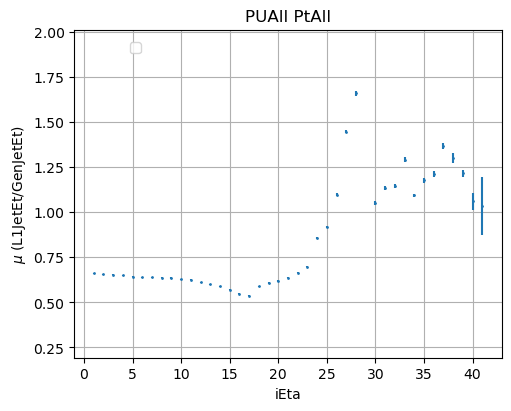

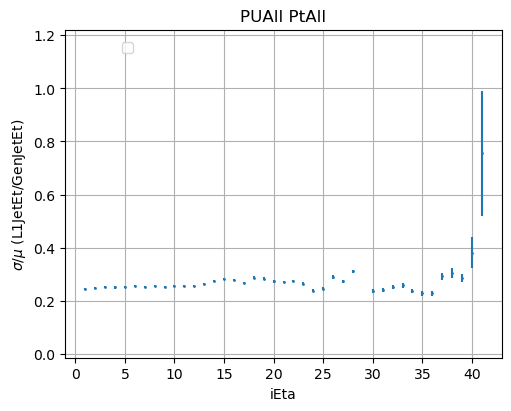

In [17]:
# L1JetResponse vs Eta before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat' % (sOutDirBeforeJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat/1D' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    


Pt_Cat_forResolutionPlots = OD()
#Pt_Cat_forResolutionPlots['Pt25to35'] = [25, 35]
Pt_Cat_forResolutionPlots['PtAll'] = [0, L1JetPtMax]

PU_Cat_forResolutionPlots = OD()
PU_Cat_forResolutionPlots['PUAll'] = [0, 99]

sL1JetEt_forResolutionPlots = sL1JetEt
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)

for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]

    for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        JES = OD()
        JER = OD()
        for iEtaBin in iEtaBins:
            data_toUse_ = data_all[
                (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_all[sRefJetEt]               >= PtRangeMin) &
                (data_all[sRefJetEt]               <  PtRangeMax) & 
                (data_all[snVtx]                   >= PURangeMin) &
                (data_all[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
            print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")
            
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            try:
                popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            except:
                print(f"{PU_category = }, {Pt_category = }, {iEtaBin = }, {pInitial = }:  fit did not converge *** ")
                continue
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
            JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.png' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
            plt.close(fig)
            
                        
            
                    
            
        # plot JES vs iEta
        JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
        errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JES_iEtawise)
        axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.png' % (sOutDir_toUse, PU_category, Pt_category))
        plt.close(fig)
        
        
        # plot JER vs iEta
        JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
        errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JER_iEtawise)
        axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.png' % (sOutDir_toUse, PU_category, Pt_category))     
        plt.close(fig)

RefJetPtBins_forResolutionPlots: [20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 65.5, 70.5, 75.5, 80.5, 85.5, 90.5, 95.5, 100.5, 105.5, 110.5, 115.5, 120.5, 130.5, 140.5, 150.5, 160.5, 170.5, 180.5, 190.5, 200.5, 210.5, 220.5, 230.5, 240.5, 250.5]
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 0.7294920742150409, 0.24861933834334318]
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 0.7294920742150409, 0.24861933834334318]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [9.0, 0.6458233441831747, 0.18971539930473852]
popt: [4.26977196 0.50188674 0.29309386], 
pcov: 
[[ 0.24283467 -0.02123865  0.00516538]
 [-0.02123865  0.01174423 -0.00782517]
 [ 0.00516538 -0.00782517  0.0064413 ]],  
poptErr = array([0.49278258, 0.10837081, 0.08025772])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [14.0, 0.6085584588359496, 0.1758438860367726]
popt: [6.4293974  0.37487868 0.31053364], 
pcov: 
[[ 2.16691003 -0.22550351  0.10104263]
 [-0.22550351  0.03634915 -0.01952531]
 [ 0.10104263 -0.01952531  0.01168817]],  
poptErr = array([1.47204281, 0.19065454, 0.10811185])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [12.0, 0.6194051117786488, 0.1656080407654367]
popt: [4.799214   0.61776341 0.15658898], 
pcov: 
[[ 5.55417076e-01  8.71204037e-04 -9.54269993e-03]
 [ 8.71204037e-04  4.39209389e-04 -4.38269443e-05]
 [-9.54269993e-03 -4.38269443e-05  3.93101536e-04]],  
poptErr = array([0.74526309, 0.02095732, 0.01982679])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [12.0, 0.6143642588816474, 0.17677165701475306]
popt: [6.50114893 0.5980069  0.15738279], 
pcov: 
[[ 5.77873696e-01  9.89283083e-04 -7.46073229e-03]
 [ 9.89283083e-04  2.51495812e-04 -4.06398071e-05]
 [-7.46073229e-03 -4.06398071e-05  2.27572001e-04]],  
poptErr = array([0.76018004, 0.01585862, 0.01508549])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [13.0, 0.5677114344655302, 0.17593386132018624]
popt: [6.01301573 0.52882062 0.19070725], 
pcov: 
[[ 6.31997336e-01  3.15519977e-03 -1.37523641e-02]
 [ 3.15519977e-03  6.69000999e-04 -2.92221208e-04]
 [-1.37523641e-02 -2.92221208e-04  7.12235004e-04]],  
poptErr = array([0.7949826 , 0.02586505, 0.02668773])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [11.0, 0.5823149223827135, 0.1952090475816051]
popt: [5.94452415 0.56182901 0.17328435], 
pcov: 
[[ 8.44127386e-01  2.70061238e-03 -1.46752414e-02]
 [ 2.70061238e-03  5.57619559e-04 -1.29264783e-04]
 [-1.46752414e-02 -1.29264783e-04  5.73496770e-04]],  
poptErr = array([0.91876405, 0.02361397, 0.02394779])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.5375706719241586, 0.17038346407068258]
popt: [6.09238471 0.52988735 0.19746778], 
pcov: 
[[ 6.02360660e-01  9.18943840e-04 -1.26522170e-02]
 [ 9.18943840e-04  6.01284231e-04 -1.32603165e-04]
 [-1.26522170e-02 -1.32603165e-04  6.49184267e-04]],  
poptErr = array([0.77611897, 0.0245211 , 0.02547909])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5435717426183734, 0.1737950864370297]
popt: [5.56164962 0.46302279 0.25467142], 
pcov: 
[[ 0.39500716  0.00480525 -0.01590299]
 [ 0.00480525  0.00234444 -0.00164835]
 [-0.01590299 -0.00164835  0.00226378]],  
poptErr = array([0.62849595, 0.04841947, 0.0475792 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [12.0, 0.5571955339259526, 0.16926845044015584]
popt: [8.60098528 0.54897192 0.13499432], 
pcov: 
[[ 1.31748958e+00  5.09851521e-05 -1.06821814e-02]
 [ 5.09851521e-05  2.17060957e-04 -1.38228243e-06]
 [-1.06821814e-02 -1.38228243e-06  1.98733451e-04]],  
poptErr = array([1.14781949, 0.01473299, 0.01409729])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.5539814215104639, 0.16402678053527167]
popt: [7.46009441 0.53231999 0.18066289], 
pcov: 
[[ 3.65644429e-01  5.33705387e-04 -5.22310401e-03]
 [ 5.33705387e-04  1.88655513e-04 -4.02258880e-05]
 [-5.22310401e-03 -4.02258880e-05  1.83462840e-04]],  
poptErr = array([0.6046854 , 0.01373519, 0.01354485])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [12.0, 0.5709487677936161, 0.18260890228504448]
popt: [6.59288603 0.54267944 0.18293691], 
pcov: 
[[ 4.97749865e-01  1.23764698e-03 -8.45576330e-03]
 [ 1.23764698e-03  2.96702824e-04 -6.49703120e-05]
 [-8.45576330e-03 -6.49703120e-05  3.19468597e-04]],  
poptErr = array([0.7055139 , 0.01722506, 0.01787368])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [13.0, 0.5411832377801057, 0.15636798570618915]
popt: [7.2740184  0.55929864 0.1828045 ], 
pcov: 
[[ 5.23291592e-01  7.63938856e-04 -7.17606640e-03]
 [ 7.63938856e-04  2.84855923e-04  1.68555106e-05]
 [-7.17606640e-03  1.68555106e-05  2.54827660e-04]],  
poptErr = array([0.72338896, 0.01687768, 0.01596332])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [10.0, 0.556956418664785, 0.16357490750145853]
popt: [5.84969508 0.54551829 0.18987506], 
pcov: 
[[ 3.39616624e-01  3.54163369e-04 -6.32445354e-03]
 [ 3.54163369e-04  3.03454857e-04 -2.20369037e-05]
 [-6.32445354e-03 -2.20369037e-05  2.91177918e-04]],  
poptErr = array([0.58276635, 0.01741996, 0.01706394])
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [12.0, 0.5683073558350267, 0.14527645183187754]
popt: [6.88366889 0.54122975 0.18299879], 
pcov: 
[[ 5.85471081e-01  1.44015865e-03 -1.01756717e-02]
 [ 1.44015865e-03  4.07353359e-04 -1.09150556e-04]
 [-1.01756717e-02 -1.09150556e-04  4.33077195e-04]],  
poptErr = array([0.76516082, 0.020183  , 0.02081051])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [13.0, 0.5861101397355337, 0.1490702372496109]
popt: [7.80389301 0.55861216 0.1282803 ], 
pcov: 
[[ 1.20216688e+00  5.13025617e-04 -9.55220441e-03]
 [ 5.13025617e-04  2.11659709e-04 -7.07029440e-06]
 [-9.55220441e-03 -7.07029440e-06  1.78022951e-04]],  
poptErr = array([1.09643371, 0.01454853, 0.01334252])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [16.0, 0.5603014185973227, 0.17229148864905167]
popt: [12.68706095  0.54584622  0.17602703], 
pcov: 
[[ 1.04327189e+00  6.79844490e-04 -7.73335100e-03]
 [ 6.79844490e-04  1.48387427e-04 -1.40255500e-05]
 [-7.73335100e-03 -1.40255500e-05  1.35947343e-04]],  
poptErr = array([1.02140682, 0.01218144, 0.01165965])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [20.0, 0.587382377057586, 0.13965772015954758]
popt: [12.75583177  0.57821438  0.13661401], 
pcov: 
[[ 2.64655115e+00 -2.02265765e-03 -1.55916522e-02]
 [-2.02265765e-03  1.88102111e-04  2.33295927e-05]
 [-1.55916522e-02  2.33295927e-05  1.93653178e-04]],  
poptErr = array([1.62682241, 0.01371503, 0.01391593])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [20.0, 0.6111738317002423, 0.1670487174366215]
popt: [9.74130056 0.60673357 0.1792741 ], 
pcov: 
[[ 8.59629482e-01 -4.07163491e-05 -8.36473008e-03]
 [-4.07163491e-05  2.23654684e-04  4.60928844e-06]
 [-8.36473008e-03  4.60928844e-06  1.99642254e-04]],  
poptErr = array([0.92716206, 0.01495509, 0.01412948])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [14.0, 0.6217674873043288, 0.1701165017767965]
popt: [10.2952026   0.61563454  0.16054976], 
pcov: 
[[ 9.36942593e-01 -3.09708704e-04 -6.22870393e-03]
 [-3.09708704e-04  1.57137036e-04  2.05287908e-06]
 [-6.22870393e-03  2.05287908e-06  1.08349813e-04]],  
poptErr = array([0.96795795, 0.01253543, 0.01040912])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [17.0, 0.6195488312800256, 0.1540944742403759]
popt: [12.23230566  0.61166614  0.14772049], 
pcov: 
[[ 9.67844033e-01 -1.34253419e-04 -5.36444604e-03]
 [-1.34253419e-04  1.02066375e-04 -1.31557592e-06]
 [-5.36444604e-03 -1.31557592e-06  7.65923262e-05]],  
poptErr = array([0.98379065, 0.01010279, 0.0087517 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.6330591110460002, 0.14341887922723925]
popt: [11.08491139  0.63793694  0.1443342 ], 
pcov: 
[[ 1.01087740e+00  2.32705960e-05 -6.06662241e-03]
 [ 2.32705960e-05  1.12437696e-04 -1.42816351e-06]
 [-6.06662241e-03 -1.42816351e-06  8.82290401e-05]],  
poptErr = array([1.00542399, 0.01060366, 0.00939303])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [16.0, 0.6333547231377191, 0.14056630429763597]
popt: [11.13263621  0.62922294  0.14831477], 
pcov: 
[[ 1.05151082e+00  8.21612120e-05 -6.46729084e-03]
 [ 8.21612120e-05  1.35727260e-04 -5.04368924e-06]
 [-6.46729084e-03 -5.04368924e-06  1.02410731e-04]],  
poptErr = array([1.02543202, 0.0116502 , 0.01011982])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [14.0, 0.6542362292375355, 0.130333594506721]
popt: [10.54028419  0.65359275  0.14736935], 
pcov: 
[[ 9.08350076e-01 -1.77488523e-05 -7.09507104e-03]
 [-1.77488523e-05  1.33211153e-04 -6.51311657e-06]
 [-7.09507104e-03 -6.51311657e-06  1.29852846e-04]],  
poptErr = array([0.95307401, 0.01154171, 0.0113953 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [17.0, 0.6618252071788161, 0.1341779453153744]
popt: [10.74940446  0.6434814   0.12870644], 
pcov: 
[[ 8.83441658e-01 -3.31543233e-04 -5.20739294e-03]
 [-3.31543233e-04  8.79998909e-05 -2.68252104e-07]
 [-5.20739294e-03 -2.68252104e-07  7.40241598e-05]],  
poptErr = array([0.93991577, 0.00938083, 0.00860373])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [15.0, 0.6730555588003028, 0.13388516156748825]
popt: [12.66396935  0.64228069  0.11281825], 
pcov: 
[[ 2.86524836e+00  2.04234784e-03 -1.21876767e-02]
 [ 2.04234784e-03  1.44548274e-04 -2.48863268e-05]
 [-1.21876767e-02 -2.48863268e-05  1.18864900e-04]],  
poptErr = array([1.69270445, 0.01202282, 0.01090252])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [15.0, 0.6797939473007231, 0.12004335581836874]
popt: [11.24954383  0.6879134   0.11209842], 
pcov: 
[[ 1.19263230e+00  6.74150575e-05 -5.50654566e-03]
 [ 6.74150575e-05  7.90442885e-05 -1.25223598e-06]
 [-5.50654566e-03 -1.25223598e-06  6.20415210e-05]],  
poptErr = array([1.09207706, 0.00889069, 0.00787664])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.6843262613270108, 0.13166595234588488]
popt: [9.63896798 0.70155314 0.12267561], 
pcov: 
[[ 9.03159973e-01 -4.99779866e-04 -5.28046194e-03]
 [-4.99779866e-04  9.55514873e-05  7.02274473e-06]
 [-5.28046194e-03  7.02274473e-06  7.44622430e-05]],  
poptErr = array([0.95034729, 0.00977504, 0.00862915])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [33.0, 0.6889928230704012, 0.1309805549695436]
popt: [20.56945377  0.6984089   0.10784256], 
pcov: 
[[ 5.64300401e+00 -1.91321236e-04 -1.27906215e-02]
 [-1.91321236e-04  8.95656305e-05  1.10258807e-06]
 [-1.27906215e-02  1.10258807e-06  6.77046210e-05]],  
poptErr = array([2.37550079, 0.00946391, 0.00822828])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [28.0, 0.7068238237068972, 0.1329561262443459]
popt: [21.27247702  0.71528435  0.11531168], 
pcov: 
[[ 3.31330987e+00  7.97859300e-04 -7.92473111e-03]
 [ 7.97859300e-04  6.29225807e-05 -3.88999545e-06]
 [-7.92473111e-03 -3.88999545e-06  4.65437619e-05]],  
poptErr = array([1.82024995, 0.00793238, 0.0068223 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [23.0, 0.7062927259347956, 0.11278832426060577]
popt: [19.92300432  0.70712804  0.11389012], 
pcov: 
[[ 1.60621523e+00  9.88067679e-05 -3.80383156e-03]
 [ 9.88067679e-05  3.63753980e-05 -1.08746455e-06]
 [-3.80383156e-03 -1.08746455e-06  2.40656558e-05]],  
poptErr = array([1.26736547, 0.0060312 , 0.00490568])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [16.0, 0.7163477856016569, 0.1239269198493658]
popt: [13.65188123  0.7242433   0.10677633], 
pcov: 
[[ 1.77874280e+00  2.07214146e-04 -5.55745642e-03]
 [ 2.07214146e-04  7.20732845e-05 -1.32259552e-06]
 [-5.55745642e-03 -1.32259552e-06  4.61345346e-05]],  
poptErr = array([1.33369517, 0.0084896 , 0.00679224])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [24.0, 0.7486291078495917, 0.11228605121839698]
popt: [17.31035097  0.76210566  0.10716364], 
pcov: 
[[ 3.32338074e+00  8.85481155e-04 -9.77164737e-03]
 [ 8.85481155e-04  8.35655168e-05 -1.89926747e-06]
 [-9.77164737e-03 -1.89926747e-06  6.83374516e-05]],  
poptErr = array([1.82301419, 0.00914142, 0.00826665])
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [19.0, 0.7478996350192486, 0.11510463236400079]
popt: [15.95372126  0.74827043  0.11374568], 
pcov: 
[[ 1.57536681e+00  5.12103112e-04 -5.06976302e-03]
 [ 5.12103112e-04  5.20533384e-05 -3.24864745e-06]
 [-5.06976302e-03 -3.24864745e-06  3.96619283e-05]],  
poptErr = array([1.25513617, 0.0072148 , 0.00629777])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [20.0, 0.7448717111225712, 0.1179347180024803]
popt: [13.74232258  0.74769189  0.12776481], 
pcov: 
[[ 1.63261955e+00  2.51497121e-05 -7.18401975e-03]
 [ 2.51497121e-05  1.01428624e-04  4.26743588e-06]
 [-7.18401975e-03  4.26743588e-06  7.96257722e-05]],  
poptErr = array([1.27774002, 0.01007118, 0.00892333])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [19.0, 0.7634492807701188, 0.11666074839156185]
popt: [15.86512585  0.76266438  0.10833276], 
pcov: 
[[ 1.47340902e+00  2.26187245e-04 -3.96323715e-03]
 [ 2.26187245e-04  4.42222211e-05 -1.60557386e-06]
 [-3.96323715e-03 -1.60557386e-06  2.80443764e-05]],  
poptErr = array([1.21384061, 0.00664998, 0.00529569])
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [18.0, 0.7569941904961274, 0.12015133349926709]
popt: [12.85125473  0.76960939  0.11833808], 
pcov: 
[[ 2.23534639e+00 -1.40379301e-03 -1.06716454e-02]
 [-1.40379301e-03  1.36945817e-04  2.92376105e-05]
 [-1.06716454e-02  2.92376105e-05  1.19950350e-04]],  
poptErr = array([1.49510748, 0.01170239, 0.01095218])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [15.0, 0.7555541320575285, 0.11556943940562914]
popt: [14.75509266  0.75807522  0.09505453], 
pcov: 
[[ 1.93660693e+00  2.17423752e-04 -5.00902868e-03]
 [ 2.17423752e-04  4.98807601e-05 -1.42597187e-06]
 [-5.00902868e-03 -1.42597187e-06  3.29569562e-05]],  
poptErr = array([1.39162025, 0.00706263, 0.00574081])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [16.0, 0.7836766997106792, 0.10218410349408111]
popt: [12.19270952  0.79093735  0.09180899], 
pcov: 
[[ 1.92620024e+00 -2.13984559e-04 -6.17142673e-03]
 [-2.13984559e-04  6.94172140e-05  2.40175347e-06]
 [-6.17142673e-03  2.40175347e-06  4.92729323e-05]],  
poptErr = array([1.38787616, 0.0083317 , 0.00701947])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [24.0, 0.7669219419372766, 0.10500900704858579]
popt: [17.99031487  0.77802554  0.07573422], 
pcov: 
[[ 3.41627182e+00  2.01488441e-04 -6.18382181e-03]
 [ 2.01488441e-04  3.55373718e-05 -7.69250471e-07]
 [-6.18382181e-03 -7.69250471e-07  2.64622023e-05]],  
poptErr = array([1.84831594, 0.00596132, 0.00514414])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [18.0, 0.7886666840395173, 0.11120221643790275]
popt: [13.15083496  0.7995299   0.08212607], 
pcov: 
[[ 3.32339530e+00 -7.19610164e-04 -8.58175778e-03]
 [-7.19610164e-04  8.61557543e-05  7.31248672e-06]
 [-8.58175778e-03  7.31248672e-06  5.75302925e-05]],  
poptErr = array([1.82301818, 0.00928201, 0.00758487])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6991874474195092, 0.23194927856264524]
popt: [2.73543938 0.58463381 0.36362471], 
pcov: 
[[ 0.27340393 -0.02379701 -0.01736668]
 [-0.02379701  0.05274476 -0.04459365]
 [-0.01736668 -0.04459365  0.05550068]],  
poptErr = array([0.52288041, 0.22966227, 0.23558582])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.6619075859703021, 0.17124163759037486]
popt: [5.01065475 0.55216702 0.21272551], 
pcov: 
[[ 0.57732799  0.00321973 -0.01824308]
 [ 0.00321973  0.00293701 -0.0019764 ]
 [-0.01824308 -0.0019764   0.00250265]],  
poptErr = array([0.75982103, 0.05419415, 0.05002652])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [9.0, 0.6138790442688732, 0.17358776996800096]
popt: [3.88431979 0.27409834 0.4625972 ], 
pcov: 
[[ 2.58228212 -0.76279186  0.39221756]
 [-0.76279186  0.26129408 -0.14475579]
 [ 0.39221756 -0.14475579  0.08537239]],  
poptErr = array([1.60694808, 0.51116933, 0.29218554])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.5896680278386853, 0.20068342250753657]
popt: [ 7.83821142 -0.70256694  0.88612877], 
pcov: 
[[1133.00568406 -164.71947779   51.45678775]
 [-164.71947779   24.13054193   -7.59519314]
 [  51.45678775   -7.59519314    2.41033006]],  
poptErr = array([33.66014979,  4.9122848 ,  1.55252377])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5702563997927408, 0.1649507510257342]
popt: [5.91847422 0.51415626 0.20950673], 
pcov: 
[[ 0.33313721  0.00231505 -0.00887395]
 [ 0.00231505  0.00067065 -0.00038985]
 [-0.00887395 -0.00038985  0.00066453]],  
poptErr = array([0.57718039, 0.02589688, 0.02577852])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 0.6078784621503042, 0.1747653877948251]
popt: [4.72134853 0.60678742 0.23193669], 
pcov: 
[[ 4.02703855e-01 -9.21220959e-04 -1.49583572e-02]
 [-9.21220959e-04  9.35129256e-04 -4.43224516e-07]
 [-1.49583572e-02 -4.43224516e-07  1.26275475e-03]],  
poptErr = array([0.63458952, 0.03057988, 0.03553526])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [12.0, 0.5613987764689337, 0.16945401794017134]
popt: [5.56369    0.54114349 0.19451429], 
pcov: 
[[ 3.62981981e-01  4.34125136e-04 -8.21284896e-03]
 [ 4.34125136e-04  3.72109924e-04 -7.28031128e-05]
 [-8.21284896e-03 -7.28031128e-05  4.24160053e-04]],  
poptErr = array([0.60247986, 0.01929015, 0.02059515])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [13.0, 0.558991212855018, 0.1703471918304366]
popt: [7.49050157 0.5502566  0.16416893], 
pcov: 
[[ 6.91817705e-01 -1.84457455e-04 -7.81476735e-03]
 [-1.84457455e-04  2.44337636e-04  1.25054545e-06]
 [-7.81476735e-03  1.25054545e-06  2.14188199e-04]],  
poptErr = array([0.8317558 , 0.0156313 , 0.01463517])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [13.0, 0.5487567646643288, 0.1528658854545463]
popt: [6.58432069 0.55980946 0.15878971], 
pcov: 
[[ 1.17073970e+00  3.36548694e-03 -1.55927026e-02]
 [ 3.36548694e-03  5.08144208e-04 -1.16465045e-04]
 [-1.55927026e-02 -1.16465045e-04  4.74435892e-04]],  
poptErr = array([1.08200726, 0.02254205, 0.02178155])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5438777921671034, 0.1591696735490517]
popt: [6.26941634 0.55335448 0.152271  ], 
pcov: 
[[ 7.49266354e-01  3.50783997e-04 -1.09010867e-02]
 [ 3.50783997e-04  3.08191972e-04 -1.12448333e-05]
 [-1.09010867e-02 -1.12448333e-05  3.42980060e-04]],  
poptErr = array([0.86560173, 0.0175554 , 0.01851972])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [12.0, 0.5559385593697933, 0.17490884539680626]
popt: [7.15324961 0.52386361 0.17626545], 
pcov: 
[[ 5.72984110e-01  1.26847725e-03 -8.81919242e-03]
 [ 1.26847725e-03  2.60181728e-04 -6.03616251e-05]
 [-8.81919242e-03 -6.03616251e-05  2.92827834e-04]],  
poptErr = array([0.75695714, 0.01613015, 0.01711221])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [12.0, 0.5571097344238997, 0.17444405129934365]
popt: [7.62105863 0.54395111 0.17607985], 
pcov: 
[[ 6.32207844e-01  7.44591624e-04 -8.04117280e-03]
 [ 7.44591624e-04  2.39243865e-04 -2.81222952e-05]
 [-8.04117280e-03 -2.81222952e-05  2.32546988e-04]],  
poptErr = array([0.79511499, 0.01546751, 0.01524949])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [10.0, 0.5612015491478332, 0.1541609387518967]
popt: [5.04007517 0.55433585 0.16057974], 
pcov: 
[[ 5.85122597e-01  5.90937302e-04 -1.04572063e-02]
 [ 5.90937302e-04  4.23349912e-04 -1.68703200e-05]
 [-1.04572063e-02 -1.68703200e-05  4.23850463e-04]],  
poptErr = array([0.76493307, 0.02057547, 0.02058763])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [10.0, 0.5336535538246733, 0.14227710450645606]
popt: [7.2232736  0.53155354 0.16085659], 
pcov: 
[[ 6.32712301e-01  4.36207979e-04 -7.77320588e-03]
 [ 4.36207979e-04  2.63197245e-04 -6.12790554e-06]
 [-7.77320588e-03 -6.12790554e-06  2.40517634e-04]],  
poptErr = array([0.79543215, 0.01622335, 0.01550863])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 0.570364532462308, 0.16061548544191379]
popt: [6.45452506 0.55384716 0.19302242], 
pcov: 
[[ 3.52428417e-01  3.28546829e-04 -6.37528685e-03]
 [ 3.28546829e-04  2.84359776e-04 -4.42176526e-05]
 [-6.37528685e-03 -4.42176526e-05  2.85962132e-04]],  
poptErr = array([0.59365682, 0.01686297, 0.01691041])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [11.0, 0.5648203580295922, 0.15282888976796727]
popt: [5.45725742 0.58315988 0.15757395], 
pcov: 
[[ 7.33256573e-01  1.03323151e-03 -1.18232972e-02]
 [ 1.03323151e-03  4.10209775e-04 -4.08567712e-05]
 [-1.18232972e-02 -4.08567712e-05  4.17706264e-04]],  
poptErr = array([0.85630402, 0.02025364, 0.02043786])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [18.0, 0.5746356936309037, 0.15397317302386013]
popt: [13.39370345  0.56835586  0.14613944], 
pcov: 
[[ 1.57827396e+00  2.34750050e-04 -7.23319972e-03]
 [ 2.34750050e-04  1.25005184e-04 -5.63426396e-06]
 [-7.23319972e-03 -5.63426396e-06  8.55752806e-05]],  
poptErr = array([1.25629374, 0.01118057, 0.00925069])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [14.0, 0.5758471486535233, 0.1532463058126415]
popt: [12.72004241  0.57549175  0.14314417], 
pcov: 
[[ 1.19124008e+00  1.66477985e-05 -5.65950918e-03]
 [ 1.66477985e-05  1.00368356e-04 -8.30743404e-07]
 [-5.65950918e-03 -8.30743404e-07  6.92592658e-05]],  
poptErr = array([1.09143945, 0.0100184 , 0.00832222])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [18.0, 0.5978437622525046, 0.14716696001998927]
popt: [11.18179045  0.60725229  0.15390048], 
pcov: 
[[ 1.30195633e+00 -1.16473961e-03 -8.80720694e-03]
 [-1.16473961e-03  1.64793893e-04  2.19252498e-05]
 [-8.80720694e-03  2.19252498e-05  1.39152149e-04]],  
poptErr = array([1.14103301, 0.01283721, 0.01179628])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [22.0, 0.5988818107565568, 0.14738924388293262]
popt: [12.06297637  0.59581188  0.1481937 ], 
pcov: 
[[ 1.49355836e+00 -1.08693708e-03 -9.05440675e-03]
 [-1.08693708e-03  1.46935053e-04  1.62424573e-05]
 [-9.05440675e-03  1.62424573e-05  1.26434125e-04]],  
poptErr = array([1.22211225, 0.01212168, 0.01124429])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [14.0, 0.6299875127671953, 0.14648066113209418]
popt: [9.5870925  0.64976034 0.14123185], 
pcov: 
[[ 1.04538514e+00 -8.42890379e-04 -7.69868894e-03]
 [-8.42890379e-04  1.67844231e-04  2.61309778e-05]
 [-7.69868894e-03  2.61309778e-05  1.39168989e-04]],  
poptErr = array([1.02244078, 0.01295547, 0.01179699])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [17.0, 0.6338155099070277, 0.15131951485734646]
popt: [10.76356605  0.63561602  0.15495003], 
pcov: 
[[ 8.71314441e-01 -5.24100068e-06 -5.46615658e-03]
 [-5.24100068e-06  1.23146780e-04  1.07269885e-06]
 [-5.46615658e-03  1.07269885e-06  8.79571932e-05]],  
poptErr = array([0.93344225, 0.01109715, 0.00937855])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [16.0, 0.6502755993788454, 0.1424686551706753]
popt: [10.13908763  0.6565334   0.14250993], 
pcov: 
[[ 9.85898149e-01  5.67668377e-04 -6.77126337e-03]
 [ 5.67668377e-04  1.41286014e-04 -6.67372586e-06]
 [-6.77126337e-03 -6.67372586e-06  1.15266968e-04]],  
poptErr = array([0.99292404, 0.01188638, 0.01073625])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [14.0, 0.6428232232374201, 0.14133226092261403]
popt: [8.20529712 0.66270683 0.15154899], 
pcov: 
[[ 9.33434561e-01 -1.47271706e-03 -8.93610770e-03]
 [-1.47271706e-03  2.34348487e-04  4.92089429e-05]
 [-8.93610770e-03  4.92089429e-05  2.02825736e-04]],  
poptErr = array([0.96614417, 0.01530844, 0.01424169])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [18.0, 0.6502889626864433, 0.13461420116496314]
popt: [12.26306173  0.65339232  0.11201606], 
pcov: 
[[ 1.77074499e+00 -3.84607395e-04 -6.88961227e-03]
 [-3.84607395e-04  8.93028322e-05  3.58649250e-06]
 [-6.88961227e-03  3.58649250e-06  6.47578922e-05]],  
poptErr = array([1.33069343, 0.00945002, 0.00804723])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [14.0, 0.6590291422442407, 0.12757609646139656]
popt: [8.89969852 0.62197294 0.11754328], 
pcov: 
[[ 2.48899680e+00 -2.59966212e-03 -1.65493301e-02]
 [-2.59966212e-03  2.55882705e-04  3.44281498e-05]
 [-1.65493301e-02  3.44281498e-05  2.36122551e-04]],  
poptErr = array([1.57765547, 0.01599633, 0.01536628])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [13.0, 0.6577539057851969, 0.13038541722280625]
popt: [7.24073572 0.68541618 0.15143583], 
pcov: 
[[ 1.23137356e+00 -9.84089546e-04 -1.64345779e-02]
 [-9.84089546e-04  4.52346821e-04  6.91278847e-05]
 [-1.64345779e-02  6.91278847e-05  5.05383713e-04]],  
poptErr = array([1.10967273, 0.02126845, 0.02248074])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [20.0, 0.6707256274360811, 0.13267886546029736]
popt: [9.52122037 0.67807668 0.13424423], 
pcov: 
[[ 1.05660122e+00 -6.44750421e-05 -8.49988109e-03]
 [-6.44750421e-05  1.65773168e-04  6.82731678e-06]
 [-8.49988109e-03  6.82731678e-06  1.62926206e-04]],  
poptErr = array([1.02791109, 0.01287529, 0.01276426])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [27.0, 0.6902062460499483, 0.1331155862049021]
popt: [18.57941737  0.6902841   0.13084358], 
pcov: 
[[ 2.18941311e+00 -4.63206858e-04 -6.68726140e-03]
 [-4.63206858e-04  7.00935521e-05  2.68848654e-06]
 [-6.68726140e-03  2.68848654e-06  5.07443970e-05]],  
poptErr = array([1.47966655, 0.00837219, 0.00712351])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [22.0, 0.7005658113824383, 0.1322850950223059]
popt: [16.57057726  0.69538454  0.12587329], 
pcov: 
[[ 2.42021642e+00 -1.40201436e-03 -8.73983122e-03]
 [-1.40201436e-03  8.86052685e-05  1.11482290e-05]
 [-8.73983122e-03  1.11482290e-05  7.28317350e-05]],  
poptErr = array([1.55570448, 0.00941304, 0.00853415])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [25.0, 0.7161940423851673, 0.1268213495778827]
popt: [14.85554668  0.71923789  0.13040025], 
pcov: 
[[ 2.12215467e+00  4.17357962e-04 -7.50301664e-03]
 [ 4.17357962e-04  1.11689447e-04 -3.84635308e-06]
 [-7.50301664e-03 -3.84635308e-06  7.14274242e-05]],  
poptErr = array([1.45676171, 0.01056832, 0.00845147])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [14.0, 0.7168337540779525, 0.14353049988512528]
popt: [12.43757506  0.72250169  0.14013764], 
pcov: 
[[ 8.60431162e-01  4.18284208e-04 -4.51938766e-03]
 [ 4.18284208e-04  8.63456033e-05 -8.36530770e-06]
 [-4.51938766e-03 -8.36530770e-06  6.36280152e-05]],  
poptErr = array([0.92759429, 0.00929223, 0.00797672])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [24.0, 0.7329776465325453, 0.1135733316186651]
popt: [15.52842543  0.74085199  0.11724445], 
pcov: 
[[ 2.24587794e+00 -4.68030419e-04 -7.79256048e-03]
 [-4.68030419e-04  8.91263118e-05  6.24411365e-06]
 [-7.79256048e-03  6.24411365e-06  6.78255843e-05]],  
poptErr = array([1.49862535, 0.00944067, 0.00823563])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [18.0, 0.7229304143742357, 0.11984770466153741]
popt: [15.16433986  0.72809087  0.11311533], 
pcov: 
[[ 1.44721464e+00  8.70980373e-05 -4.41436727e-03]
 [ 8.70980373e-05  5.31812403e-05 -2.97634605e-07]
 [-4.41436727e-03 -2.97634605e-07  3.52088450e-05]],  
poptErr = array([1.20300234, 0.00729255, 0.0059337 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [17.0, 0.744275996770109, 0.12091378134345544]
popt: [13.49679461  0.75223568  0.11112086], 
pcov: 
[[ 2.33213134e+00 -5.16610561e-04 -8.72253757e-03]
 [-5.16610561e-04  9.91005313e-05  6.59099348e-06]
 [-8.72253757e-03  6.59099348e-06  7.74645296e-05]],  
poptErr = array([1.52713174, 0.00995492, 0.00880139])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [19.0, 0.7421195907272429, 0.09985201593880497]
popt: [11.98560511  0.74823167  0.09866308], 
pcov: 
[[ 2.38705456e+00 -1.29468539e-04 -8.74087663e-03]
 [-1.29468539e-04  1.03010958e-04  1.24099625e-06]
 [-8.74087663e-03  1.24099625e-06  7.78183006e-05]],  
poptErr = array([1.54500957, 0.01014943, 0.00882147])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [21.0, 0.7629125170270746, 0.10012965188338663]
popt: [13.06282109  0.77550962  0.09444772], 
pcov: 
[[ 3.17871543e+00 -1.59644315e-04 -1.07148852e-02]
 [-1.59644315e-04  9.99248520e-05  3.40717812e-06]
 [-1.07148852e-02  3.40717812e-06  8.26786603e-05]],  
poptErr = array([1.78289524, 0.00999624, 0.00909278])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [15.0, 0.7836019751380028, 0.1030734989528791]
popt: [14.27446568  0.78575898  0.08866323], 
pcov: 
[[ 1.97192074e+00  5.14827417e-04 -5.64947959e-03]
 [ 5.14827417e-04  4.55450068e-05 -4.02416525e-06]
 [-5.64947959e-03 -4.02416525e-06  3.70228200e-05]],  
poptErr = array([1.40425095, 0.0067487 , 0.00608464])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [19.0, 0.7742527931699231, 0.10388864544926729]
popt: [13.88024097  0.77497041  0.09757574], 
pcov: 
[[ 1.66726933e+00 -3.44997440e-04 -5.72446442e-03]
 [-3.44997440e-04  6.10221622e-05  3.72570421e-06]
 [-5.72446442e-03  3.72570421e-06  4.93476698e-05]],  
poptErr = array([1.29122784, 0.00781167, 0.00702479])
PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [15.0, 0.7735794780146168, 0.09124647244512693]
popt: [12.87461465  0.78436171  0.09242187], 
pcov: 
[[ 9.26512097e-01 -4.77241915e-04 -3.28001397e-03]
 [-4.77241915e-04  3.54078219e-05  7.44066721e-06]
 [-3.28001397e-03  7.44066721e-06  2.85390660e-05]],  
poptErr = array([0.96255498, 0.00595045, 0.0053422 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 2, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [19.0, 0.7804325644387481, 0.10374517014848127]
popt: [11.69153075  0.78950835  0.09636553], 
pcov: 
[[ 2.85589333e+00 -2.18015228e-03 -1.30486082e-02]
 [-2.18015228e-03  1.25481897e-04  2.11891550e-05]
 [-1.30486082e-02  2.11891550e-05  1.27212720e-04]],  
poptErr = array([1.68993885, 0.01120187, 0.01127886])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6908581065092465, 0.18507667999630695]
popt: [11.37192224 -1.03567404  0.9808975 ], 
pcov: 
[[ 1.04223208e+04 -9.96986263e+02  2.72693715e+02]
 [-9.96986263e+02  9.57210675e+01 -2.62779664e+01]
 [ 2.72693715e+02 -2.62779664e+01  7.24187888e+00]],  
poptErr = array([102.08976822,   9.7837144 ,   2.69107393])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [9.0, 0.6636444495430712, 0.1812145295717651]
popt: [3.86235743 0.44859383 0.39179446], 
pcov: 
[[ 0.46279086 -0.10782932  0.05293382]
 [-0.10782932  0.05070662 -0.03313782]
 [ 0.05293382 -0.03313782  0.02499689]],  
poptErr = array([0.68028734, 0.22518131, 0.15810405])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [10.0, 0.6122557294211347, 0.16106005111477795]
popt: [4.9100741  0.47053241 0.26309486], 
pcov: 
[[ 0.30586131 -0.01976796  0.00480815]
 [-0.01976796  0.00788346 -0.00481384]
 [ 0.00480815 -0.00481384  0.00356932]],  
poptErr = array([0.55304729, 0.08878885, 0.05974382])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 0.586691356675498, 0.17420701903162886]
popt: [7.21927257 0.5249003  0.16125376], 
pcov: 
[[ 7.21763962e-01  2.32481133e-03 -1.16829076e-02]
 [ 2.32481133e-03  3.92790899e-04 -1.74708397e-04]
 [-1.16829076e-02 -1.74708397e-04  4.48539951e-04]],  
poptErr = array([0.84956693, 0.01981895, 0.02117876])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 0.6017100125492443, 0.18972848175753693]
popt: [4.82008896 0.53597061 0.2696193 ], 
pcov: 
[[ 0.36792278  0.00573292 -0.01876382]
 [ 0.00573292  0.00276414 -0.00188022]
 [-0.01876382 -0.00188022  0.00295347]],  
poptErr = array([0.60656639, 0.05257509, 0.05434587])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 0.5863527188074239, 0.1825045534051714]
popt: [4.48545457 0.42130016 0.33430919], 
pcov: 
[[ 4.98841020e-01 -3.45100133e-02  4.24484998e-04]
 [-3.45100133e-02  2.56652951e-02 -1.83597883e-02]
 [ 4.24484998e-04 -1.83597883e-02  1.67508999e-02]],  
poptErr = array([0.70628678, 0.16020392, 0.12942527])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [12.0, 0.5315412418682651, 0.1339860528212857]
popt: [6.59057041 0.49014956 0.15258598], 
pcov: 
[[ 1.10745588e+00  3.39839929e-03 -1.69323037e-02]
 [ 3.39839929e-03  5.49811534e-04 -2.15717447e-04]
 [-1.69323037e-02 -2.15717447e-04  5.93365880e-04]],  
poptErr = array([1.0523573 , 0.02344806, 0.0243591 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [13.0, 0.5399122963305497, 0.17885319920718093]
popt: [3.15862866 0.48298467 0.38004503], 
pcov: 
[[ 0.37506818  0.00589512 -0.06353256]
 [ 0.00589512  0.02083825 -0.01696843]
 [-0.06353256 -0.01696843  0.03788602]],  
poptErr = array([0.6124281 , 0.14435461, 0.19464333])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5580210119923027, 0.1580917424290365]
popt: [6.33160096 0.55447603 0.16386163], 
pcov: 
[[ 6.06210061e-01  1.37412294e-03 -8.47581823e-03]
 [ 1.37412294e-03  3.11210159e-04 -6.04092812e-05]
 [-8.47581823e-03 -6.04092812e-05  2.81351087e-04]],  
poptErr = array([0.77859493, 0.01764115, 0.01677352])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5382794736065711, 0.15606783444186426]
popt: [7.01075147 0.52019891 0.15709883], 
pcov: 
[[ 4.87017766e-01  1.90327642e-04 -5.61426665e-03]
 [ 1.90327642e-04  1.85313251e-04 -1.33416374e-05]
 [-5.61426665e-03 -1.33416374e-05  1.59814035e-04]],  
poptErr = array([0.69786658, 0.01361298, 0.01264176])
PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.5557243849400262, 0.17873640765193435]
popt: [6.11392521 0.52126821 0.2009913 ], 
pcov: 
[[ 4.04653742e-01  2.19644224e-03 -8.28137797e-03]
 [ 2.19644224e-03  4.28399500e-04 -1.57129005e-04]
 [-8.28137797e-03 -1.57129005e-04  4.10241893e-04]],  
poptErr = array([0.636124  , 0.02069781, 0.02025443])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [11.0, 0.5158690755310927, 0.14865674116540648]
popt: [5.2844875  0.48644709 0.1740038 ], 
pcov: 
[[ 8.52945613e-01  5.79272619e-04 -2.03803974e-02]
 [ 5.79272619e-04  7.03644344e-04 -1.22025813e-04]
 [-2.03803974e-02 -1.22025813e-04  9.95108064e-04]],  
poptErr = array([0.92355055, 0.0265263 , 0.03154533])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.5533560774689785, 0.15873785698540552]
popt: [7.14248659 0.54157282 0.15330541], 
pcov: 
[[ 4.07320818e-01  1.14812120e-04 -4.15395164e-03]
 [ 1.14812120e-04  1.24579270e-04 -4.69073180e-06]
 [-4.15395164e-03 -4.69073180e-06  1.01491622e-04]],  
poptErr = array([0.63821691, 0.01116151, 0.01007431])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [15.0, 0.5777699739034127, 0.15080271294614514]
popt: [6.81281054 0.56479243 0.15486928], 
pcov: 
[[ 9.16669674e-01 -2.89363764e-04 -1.10527728e-02]
 [-2.89363764e-04  3.40791969e-04 -7.79504828e-06]
 [-1.10527728e-02 -7.79504828e-06  3.14121910e-04]],  
poptErr = array([0.95742868, 0.01846055, 0.01772348])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [10.0, 0.568555955661434, 0.18009263699068756]
popt: [6.31474417 0.53991492 0.14795206], 
pcov: 
[[ 5.65518473e-01  6.13643224e-04 -7.03470998e-03]
 [ 6.13643224e-04  2.08955732e-04 -1.36001996e-05]
 [-7.03470998e-03 -1.36001996e-05  1.97811729e-04]],  
poptErr = array([0.75200962, 0.0144553 , 0.01406456])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [10.0, 0.5656433242616036, 0.17232698038984193]
popt: [5.6832249  0.5742785  0.15453486], 
pcov: 
[[ 8.67947061e-01 -1.00506541e-03 -1.41391897e-02]
 [-1.00506541e-03  4.14394592e-04  4.11383027e-05]
 [-1.41391897e-02  4.11383027e-05  4.76816170e-04]],  
poptErr = array([0.93163676, 0.02035668, 0.02183612])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [18.0, 0.6009932707943857, 0.15988955279545225]
popt: [11.61365923  0.58928537  0.15760978], 
pcov: 
[[ 9.41946302e-01 -3.76289137e-04 -5.69799237e-03]
 [-3.76289137e-04  1.18703906e-04  1.92635773e-06]
 [-5.69799237e-03  1.92635773e-06  8.73200661e-05]],  
poptErr = array([0.97053918, 0.01089513, 0.00934452])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [24.0, 0.5766945879162884, 0.14236417045336489]
popt: [12.71054702  0.57087342  0.13500799], 
pcov: 
[[ 1.64208729e+00 -1.22473136e-03 -7.92672235e-03]
 [-1.22473136e-03  1.21078971e-04  1.44498204e-05]
 [-7.92672235e-03  1.44498204e-05  9.22746776e-05]],  
poptErr = array([1.28143954, 0.01100359, 0.00960597])
PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [21.0, 0.5801102376423284, 0.15922633256861565]
popt: [12.6672988   0.575434    0.15555411], 
pcov: 
[[ 1.27259386e+00  2.16272104e-04 -7.19674485e-03]
 [ 2.16272104e-04  1.22025753e-04 -4.01898729e-06]
 [-7.19674485e-03 -4.01898729e-06  9.68366649e-05]],  
poptErr = array([1.12809302, 0.01104653, 0.00984056])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.6025266518649633, 0.1381589935701]
popt: [11.58227011  0.60973536  0.12066676], 
pcov: 
[[ 1.26377546e+00  3.24010980e-04 -5.48382356e-03]
 [ 3.24010980e-04  8.55606042e-05 -3.71092246e-06]
 [-5.48382356e-03 -3.71092246e-06  5.93389772e-05]],  
poptErr = array([1.12417768, 0.0092499 , 0.00770318])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [16.0, 0.6066526662277635, 0.15271220564305227]
popt: [13.17506097  0.59303695  0.13529643], 
pcov: 
[[ 1.70320976e+00  1.93638157e-04 -7.93534489e-03]
 [ 1.93638157e-04  1.15935562e-04 -3.29236572e-06]
 [-7.93534489e-03 -3.29236572e-06  8.95331001e-05]],  
poptErr = array([1.30507079, 0.01076734, 0.00946219])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.6333756036247001, 0.15893137548118927]
popt: [8.4641172  0.64762995 0.17261583], 
pcov: 
[[ 1.17018522e+00  2.49827289e-04 -1.24955399e-02]
 [ 2.49827289e-04  3.52728918e-04  6.55181856e-06]
 [-1.24955399e-02  6.55181856e-06  3.18207941e-04]],  
poptErr = array([1.081751  , 0.01878108, 0.01783838])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [23.0, 0.6299149234045118, 0.13427657589666814]
popt: [13.9108095   0.63227097  0.12636115], 
pcov: 
[[ 1.47371357e+00  1.27980917e-03 -5.97446647e-03]
 [ 1.27980917e-03  7.93401933e-05 -1.42317990e-05]
 [-5.97446647e-03 -1.42317990e-05  5.82676719e-05]],  
poptErr = array([1.21396605, 0.00890731, 0.00763333])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [13.0, 0.6418866948084263, 0.13861525725628315]
popt: [10.16293886  0.6358529   0.1515045 ], 
pcov: 
[[ 3.21221443e-01 -4.07019527e-05 -2.18987474e-03]
 [-4.07019527e-05  5.53383082e-05 -2.01884200e-06]
 [-2.18987474e-03 -2.01884200e-06  4.02539984e-05]],  
poptErr = array([0.56676401, 0.00743897, 0.0063446 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [15.0, 0.6469969265765086, 0.1516249631764657]
popt: [8.14978292 0.6469477  0.14841607], 
pcov: 
[[ 1.02680326e+00 -6.68865801e-04 -8.60454536e-03]
 [-6.68865801e-04  2.27040896e-04  1.85066114e-05]
 [-8.60454536e-03  1.85066114e-05  1.75914093e-04]],  
poptErr = array([1.01331301, 0.01506788, 0.01326326])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [10.0, 0.6823916975360559, 0.13624584786924154]
popt: [8.44959373 0.67759598 0.13570955], 
pcov: 
[[ 6.71427685e-01 -3.94430712e-04 -5.16158531e-03]
 [-3.94430712e-04  1.21595958e-04  7.28518409e-06]
 [-5.16158531e-03  7.28518409e-06  9.76130662e-05]],  
poptErr = array([0.81940691, 0.01102706, 0.00987993])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [14.0, 0.6645581393911159, 0.139342885314246]
popt: [7.64341103 0.68235334 0.12808418], 
pcov: 
[[ 1.23020397e+00 -6.23126432e-04 -9.65441861e-03]
 [-6.23126432e-04  2.10351780e-04  1.35415893e-05]
 [-9.65441861e-03  1.35415893e-05  1.73861338e-04]],  
poptErr = array([1.1091456 , 0.01450351, 0.01318565])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [13.0, 0.679392247813503, 0.14544432807984553]
popt: [7.867809   0.70037762 0.15440779], 
pcov: 
[[ 1.14059119e+00 -3.08409078e-03 -1.23739377e-02]
 [-3.08409078e-03  3.84374586e-04  1.14264480e-04]
 [-1.23739377e-02  1.14264480e-04  3.30984068e-04]],  
poptErr = array([1.06798464, 0.01960547, 0.01819297])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [23.0, 0.6810324620654568, 0.14019660789276758]
popt: [16.39614047  0.68489402  0.12944281], 
pcov: 
[[ 1.80797253e+00 -4.17271898e-04 -6.42350642e-03]
 [-4.17271898e-04  6.93590756e-05  4.56394773e-06]
 [-6.42350642e-03  4.56394773e-06  5.39010376e-05]],  
poptErr = array([1.34460869, 0.00832821, 0.00734173])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [20.0, 0.699651751065833, 0.12355449501732373]
popt: [16.3233486   0.70016535  0.12788845], 
pcov: 
[[ 1.96015076e+00  9.31636445e-05 -6.52081422e-03]
 [ 9.31636445e-05  8.63170386e-05 -9.04748338e-07]
 [-6.52081422e-03 -9.04748338e-07  5.83384893e-05]],  
poptErr = array([1.40005384, 0.0092907 , 0.00763796])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [20.0, 0.6907612996888868, 0.12407029138632798]
popt: [15.85219004  0.70134926  0.12259311], 
pcov: 
[[ 8.47424785e-01 -7.04862715e-05 -2.65941919e-03]
 [-7.04862715e-05  3.48439221e-05  1.82399370e-06]
 [-2.65941919e-03  1.82399370e-06  2.24655509e-05]],  
poptErr = array([0.92055678, 0.00590287, 0.00473978])
PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [26.0, 0.7275669067107424, 0.11771552623254972]
popt: [19.31368945  0.74351997  0.09768518], 
pcov: 
[[ 4.00609842e+00 -7.13680795e-04 -8.24828629e-03]
 [-7.13680795e-04  6.70985586e-05  4.14664233e-06]
 [-8.24828629e-03  4.14664233e-06  4.41503879e-05]],  
poptErr = array([2.00152403, 0.00819137, 0.00664458])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [20.0, 0.7238398602918586, 0.12311877220755378]
popt: [13.0853652   0.72959034  0.11979125], 
pcov: 
[[ 2.17641466e+00  3.43041648e-04 -1.02288280e-02]
 [ 3.43041648e-04  1.21381872e-04 -5.91321609e-06]
 [-1.02288280e-02 -5.91321609e-06  1.10286392e-04]],  
poptErr = array([1.47526766, 0.01101734, 0.01050173])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [15.0, 0.7473390873891039, 0.12186680980272573]
popt: [13.94955804  0.74710649  0.11444735], 
pcov: 
[[ 9.58838100e-01  8.78903280e-05 -3.21247590e-03]
 [ 8.78903280e-05  4.36906220e-05 -5.87550109e-07]
 [-3.21247590e-03 -5.87550109e-07  2.85979352e-05]],  
poptErr = array([0.97920279, 0.00660989, 0.0053477 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [23.0, 0.7430443978276264, 0.10625917739505292]
popt: [14.88182289  0.74030132  0.10681307], 
pcov: 
[[ 1.35697852e+00  2.89799770e-04 -4.11402463e-03]
 [ 2.89799770e-04  5.21757065e-05 -5.54888670e-06]
 [-4.11402463e-03 -5.54888670e-06  3.43471864e-05]],  
poptErr = array([1.16489421, 0.00722328, 0.00586065])
PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [17.0, 0.7590495368018441, 0.12346017174046205]
popt: [12.86873015  0.76989042  0.11413707], 
pcov: 
[[ 1.79570622e+00 -4.40274292e-04 -7.48453118e-03]
 [-4.40274292e-04  8.97575173e-05  6.97637037e-06]
 [-7.48453118e-03  6.97637037e-06  7.31820905e-05]],  
poptErr = array([1.34003963, 0.00947404, 0.00855465])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [15.0, 0.7475823238717154, 0.10644026196825443]
popt: [11.01263941  0.7423569   0.10504169], 
pcov: 
[[ 1.42362486e+00 -8.18871908e-04 -6.09197818e-03]
 [-8.18871908e-04  8.38235320e-05  7.69783028e-06]
 [-6.09197818e-03  7.69783028e-06  6.32090380e-05]],  
poptErr = array([1.19315752, 0.00915552, 0.00795041])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [15.0, 0.7637989715793351, 0.10490983945033987]
popt: [12.04509314  0.76729335  0.09914974], 
pcov: 
[[ 2.20409749e+00  3.54650742e-04 -7.83165285e-03]
 [ 3.54650742e-04  1.03470380e-04 -6.13677008e-06]
 [-7.83165285e-03 -6.13677008e-06  7.23702492e-05]],  
poptErr = array([1.48462032, 0.01017204, 0.00850707])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [20.0, 0.7694580850639062, 0.11188295854528482]
popt: [12.15407963  0.75037033  0.06877191], 
pcov: 
[[ 7.07481325e+00  4.00421775e-03 -1.75846000e-02]
 [ 4.00421775e-03  1.42776555e-04 -2.54268501e-05]
 [-1.75846000e-02 -2.54268501e-05  1.03877397e-04]],  
poptErr = array([2.65985211, 0.01194891, 0.01019203])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [15.0, 0.7698198173189993, 0.14383492456728086]
popt: [10.96432908  0.77025177  0.10109286], 
pcov: 
[[ 1.45744804e+00  6.65784442e-04 -6.04264208e-03]
 [ 6.65784442e-04  8.01652097e-05 -6.75559363e-06]
 [-6.04264208e-03 -6.75559363e-06  6.07651969e-05]],  
poptErr = array([1.20724813, 0.0089535 , 0.0077952 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 3, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [17.0, 0.7999240093930646, 0.10189138843310147]
popt: [12.28692919  0.80167072  0.09668187], 
pcov: 
[[ 1.27817908e+00  3.24063566e-04 -4.90866265e-03]
 [ 3.24063566e-04  5.20309492e-05 -2.08630773e-06]
 [-4.90866265e-03 -2.08630773e-06  4.41767956e-05]],  
poptErr = array([1.13056582, 0.00721325, 0.00664656])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.7196438619249516, 0.19777113369838417]
popt: [2.36788221 0.59813318 0.3975815 ], 
pcov: 
[[ 0.10592179 -0.00192357 -0.01667614]
 [-0.00192357  0.02610225 -0.02338555]
 [-0.01667614 -0.02338555  0.02963577]],  
poptErr = array([0.32545629, 0.1615619 , 0.17215042])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [11.0, 0.640023542224281, 0.189267890923568]
popt: [2.53292855 0.50949632 0.37529268], 
pcov: 
[[ 0.19417776 -0.02114109 -0.00697833]
 [-0.02114109  0.03763337 -0.02920462]
 [-0.00697833 -0.02920462  0.03084576]],  
poptErr = array([0.44065606, 0.19399321, 0.17562961])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.5979606551415374, 0.16852537831193543]
popt: [3.49348174 0.38285006 0.41450875], 
pcov: 
[[ 0.65130872 -0.18615351  0.09459665]
 [-0.18615351  0.10560412 -0.07200182]
 [ 0.09459665 -0.07200182  0.05791835]],  
poptErr = array([0.807037  , 0.32496788, 0.24066233])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [11.0, 0.6245392647560458, 0.18986599696261522]
popt: [4.89030554 0.59556247 0.19527594], 
pcov: 
[[ 6.62376523e-01  4.05384357e-03 -1.87293747e-02]
 [ 4.05384357e-03  1.04660772e-03 -4.28494410e-04]
 [-1.87293747e-02 -4.28494410e-04  1.20495533e-03]],  
poptErr = array([0.81386517, 0.03235132, 0.03471247])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.5982260485281761, 0.1917413164585962]
popt: [4.04590885 0.55520887 0.23020508], 
pcov: 
[[ 0.33102452  0.00466883 -0.01703997]
 [ 0.00466883  0.0014895  -0.00091893]
 [-0.01703997 -0.00091893  0.00199704]],  
poptErr = array([0.5753473 , 0.03859404, 0.04468821])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 0.5743873453298125, 0.16980573499847493]
popt: [3.99467376 0.53624368 0.21726105], 
pcov: 
[[ 0.33290647  0.00470456 -0.01438682]
 [ 0.00470456  0.00115077 -0.00065372]
 [-0.01438682 -0.00065372  0.00136636]],  
poptErr = array([0.57698047, 0.03392301, 0.03696428])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [12.0, 0.559392012987914, 0.16532500511639722]
popt: [5.87512627 0.50401682 0.2137101 ], 
pcov: 
[[ 0.61999223  0.00492721 -0.01710435]
 [ 0.00492721  0.00132969 -0.00076146]
 [-0.01710435 -0.00076146  0.00131406]],  
poptErr = array([0.78739586, 0.03646496, 0.03624999])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.573579080700609, 0.1967898972885622]
popt: [4.9714021  0.44079888 0.3110586 ], 
pcov: 
[[ 2.54451984e-01 -2.41828746e-04 -1.01222618e-02]
 [-2.41828746e-04  4.72997249e-03 -3.28428124e-03]
 [-1.01222618e-02 -3.28428124e-03  3.45947430e-03]],  
poptErr = array([0.50443234, 0.0687748 , 0.0588173 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [10.0, 0.5364455522878846, 0.1520208730881954]
popt: [6.30112157 0.51511665 0.16647851], 
pcov: 
[[ 5.72464342e-01  2.07357631e-04 -8.79817155e-03]
 [ 2.07357631e-04  3.17835950e-04 -4.76099125e-05]
 [-8.79817155e-03 -4.76099125e-05  3.19448011e-04]],  
poptErr = array([0.75661373, 0.01782795, 0.01787311])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [10.0, 0.533381348254255, 0.15739485663074684]
popt: [7.39345048 0.51209828 0.15207857], 
pcov: 
[[ 8.73845994e-01  2.09712702e-03 -1.12199006e-02]
 [ 2.09712702e-03  3.07160863e-04 -6.77802407e-05]
 [-1.12199006e-02 -6.77802407e-05  3.27879400e-04]],  
poptErr = array([0.9347973 , 0.01752601, 0.01810744])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [10.0, 0.5518776872600271, 0.20065367564454376]
popt: [5.42854298 0.53684387 0.1780657 ], 
pcov: 
[[ 3.87781458e-01  5.22396183e-04 -6.95242912e-03]
 [ 5.22396183e-04  2.92899635e-04 -2.02246464e-05]
 [-6.95242912e-03 -2.02246464e-05  2.83904055e-04]],  
poptErr = array([0.62272101, 0.01711431, 0.01684945])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [16.0, 0.5522425311816027, 0.14195637549823195]
popt: [7.34009918 0.54706375 0.15477164], 
pcov: 
[[ 8.25586550e-01 -1.18926951e-03 -9.29247151e-03]
 [-1.18926951e-03  2.78978314e-04  3.76868149e-05]
 [-9.29247151e-03  3.76868149e-05  2.50938587e-04]],  
poptErr = array([0.90861793, 0.01670264, 0.01584104])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [12.0, 0.5418805638055467, 0.1435432042378448]
popt: [5.72323652 0.52351472 0.16524781], 
pcov: 
[[ 7.97741820e-01 -3.39081214e-05 -1.22692476e-02]
 [-3.39081214e-05  4.96992022e-04 -4.11968762e-05]
 [-1.22692476e-02 -4.11968762e-05  4.53501033e-04]],  
poptErr = array([0.89316394, 0.02229332, 0.02129556])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [12.0, 0.5623902309417005, 0.15832321616555553]
popt: [7.47962059 0.51471141 0.12932213], 
pcov: 
[[ 1.08014532e+00 -3.64114315e-04 -9.45191466e-03]
 [-3.64114315e-04  2.35814107e-04 -2.13212639e-05]
 [-9.45191466e-03 -2.13212639e-05  2.02464106e-04]],  
poptErr = array([1.0393004 , 0.01535624, 0.01422899])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.5478083471525638, 0.15607665673060797]
popt: [6.80570894 0.53494064 0.16170467], 
pcov: 
[[ 8.29820763e-01 -1.02453593e-03 -9.98210058e-03]
 [-1.02453593e-03  3.64916111e-04  3.68381404e-05]
 [-9.98210058e-03  3.68381404e-05  3.02896866e-04]],  
poptErr = array([0.91094498, 0.01910278, 0.01740393])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [12.0, 0.5712898861959252, 0.15036477264289444]
popt: [7.52746575 0.55250451 0.16756258], 
pcov: 
[[ 5.34863764e-01  1.05318134e-03 -8.33623431e-03]
 [ 1.05318134e-03  2.36108667e-04 -5.93138485e-05]
 [-8.33623431e-03 -5.93138485e-05  2.89998010e-04]],  
poptErr = array([0.73134381, 0.01536583, 0.01702933])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [23.0, 0.5639380926974111, 0.15640034754991503]
popt: [12.15639457  0.54584586  0.15297951], 
pcov: 
[[ 1.31215160e+00  5.81863735e-04 -7.38313493e-03]
 [ 5.81863735e-04  1.35159962e-04 -1.20334360e-05]
 [-7.38313493e-03 -1.20334360e-05  1.01551320e-04]],  
poptErr = array([1.14549186, 0.01162583, 0.01007727])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [15.0, 0.5768970187828818, 0.16332335172386642]
popt: [8.46406682 0.54326575 0.17105578], 
pcov: 
[[ 1.35727814e+00 -1.36325906e-04 -1.30962153e-02]
 [-1.36325906e-04  3.90418477e-04 -1.33923489e-05]
 [-1.30962153e-02 -1.33923489e-05  3.12821824e-04]],  
poptErr = array([1.16502281, 0.01975901, 0.01768677])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [14.0, 0.610050998707971, 0.1702428169160026]
popt: [10.4955347   0.58512149  0.15358812], 
pcov: 
[[ 1.18319431e+00  1.91466253e-03 -8.27395101e-03]
 [ 1.91466253e-03  1.84111398e-04 -4.05886812e-05]
 [-8.27395101e-03 -4.05886812e-05  1.41347472e-04]],  
poptErr = array([1.08774735, 0.01356877, 0.01188896])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [17.0, 0.5972606702315976, 0.14739602607645608]
popt: [10.75917473  0.5875482   0.15678819], 
pcov: 
[[ 1.10264679e+00  7.81389613e-05 -7.96896491e-03]
 [ 7.81389613e-05  1.66847644e-04  1.40044844e-06]
 [-7.96896491e-03  1.40044844e-06  1.40348098e-04]],  
poptErr = array([1.0500699 , 0.01291695, 0.01184686])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [15.0, 0.6109360476430408, 0.15516864757121338]
popt: [10.28530686  0.61305787  0.15341144], 
pcov: 
[[ 9.00365516e-01 -6.84923414e-04 -6.04676299e-03]
 [-6.84923414e-04  1.40920985e-04  1.41587104e-05]
 [-6.04676299e-03  1.41587104e-05  1.03336028e-04]],  
poptErr = array([0.94887592, 0.01187101, 0.01016543])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.6132808981521791, 0.1406802934618369]
popt: [12.01337083  0.62567024  0.12554534], 
pcov: 
[[ 1.43386662e+00  9.62890119e-04 -6.79710612e-03]
 [ 9.62890119e-04  9.32391391e-05 -1.09772827e-05]
 [-6.79710612e-03 -1.09772827e-05  7.38075460e-05]],  
poptErr = array([1.1974417 , 0.00965604, 0.00859113])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [16.0, 0.6236991629789018, 0.1456571788227148]
popt: [6.91650448 0.60611706 0.17038227], 
pcov: 
[[ 1.22548554e+00 -6.23188944e-04 -1.58697878e-02]
 [-6.23188944e-04  6.34626681e-04 -1.64720736e-05]
 [-1.58697878e-02 -1.64720736e-05  5.39483039e-04]],  
poptErr = array([1.1070165 , 0.0251918 , 0.02322677])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [17.0, 0.6460398445783111, 0.1409245053479849]
popt: [9.36896037 0.63500653 0.13556325], 
pcov: 
[[ 1.64765181e+00  7.85980925e-04 -1.14111404e-02]
 [ 7.85980925e-04  2.57184069e-04 -1.51949367e-05]
 [-1.14111404e-02 -1.51949367e-05  2.01630808e-04]],  
poptErr = array([1.2836089 , 0.01603696, 0.01419968])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [14.0, 0.6435324466940596, 0.13678426506256203]
popt: [8.3947617  0.65030505 0.14991585], 
pcov: 
[[ 9.95067843e-01 -6.75228610e-04 -9.47533812e-03]
 [-6.75228610e-04  2.26187986e-04  1.50959223e-05]
 [-9.47533812e-03  1.50959223e-05  2.10264543e-04]],  
poptErr = array([0.99753087, 0.01503955, 0.0145005 ])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [13.0, 0.6298503672696921, 0.13131145868744729]
popt: [8.10590072 0.6453069  0.15596623], 
pcov: 
[[ 8.54963369e-01 -1.73401660e-03 -1.00896571e-02]
 [-1.73401660e-03  2.66834235e-04  6.72154616e-05]
 [-1.00896571e-02  6.72154616e-05  2.75647668e-04]],  
poptErr = array([0.92464229, 0.01633506, 0.01660264])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [13.0, 0.6754111627768504, 0.12925140781033198]
popt: [10.36807513  0.67194557  0.12840804], 
pcov: 
[[ 6.90501920e-01  1.76804470e-04 -3.77212971e-03]
 [ 1.76804470e-04  7.11217674e-05 -1.28789688e-06]
 [-3.77212971e-03 -1.28789688e-06  5.19514336e-05]],  
poptErr = array([0.83096445, 0.00843337, 0.00720773])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.6591350942544033, 0.14594054149240843]
popt: [7.39424115 0.64230424 0.13511654], 
pcov: 
[[ 1.12083849e+00 -9.21212354e-04 -1.09126198e-02]
 [-9.21212354e-04  2.57648027e-04  8.18856575e-06]
 [-1.09126198e-02  8.18856575e-06  2.43144722e-04]],  
poptErr = array([1.0586966 , 0.01605142, 0.0155931 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [21.0, 0.6702014608794191, 0.12616156378414653]
popt: [16.71454341  0.66798445  0.11629384], 
pcov: 
[[ 2.55074438e+00  8.05379051e-04 -8.18278167e-03]
 [ 8.05379051e-04  7.69032309e-05 -6.99503941e-06]
 [-8.18278167e-03 -6.99503941e-06  6.13897763e-05]],  
poptErr = array([1.597105  , 0.00876945, 0.00783516])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [19.0, 0.6992021569105176, 0.13043196852876807]
popt: [16.97960477  0.69962724  0.11941401], 
pcov: 
[[ 1.74198140e+00 -3.57800551e-04 -4.85613547e-03]
 [-3.57800551e-04  5.80774019e-05  3.27432031e-06]
 [-4.85613547e-03  3.27432031e-06  3.64626214e-05]],  
poptErr = array([1.31984143, 0.00762085, 0.00603843])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [23.0, 0.7054206811005934, 0.12046593882334419]
popt: [20.91840969  0.71444188  0.10160274], 
pcov: 
[[ 3.18651828e+00 -1.77057501e-04 -6.40655811e-03]
 [-1.77057501e-04  4.83915919e-05  1.28381638e-06]
 [-6.40655811e-03  1.28381638e-06  3.28965631e-05]],  
poptErr = array([1.78508215, 0.00695641, 0.00573555])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [25.0, 0.7045429176072948, 0.12212441367595914]
popt: [17.49288397  0.70726183  0.1233116 ], 
pcov: 
[[ 1.36748952e+00 -3.35843220e-04 -3.92086357e-03]
 [-3.35843220e-04  4.45450565e-05  2.90075706e-06]
 [-3.92086357e-03  2.90075706e-06  2.92591419e-05]],  
poptErr = array([1.16939707, 0.00667421, 0.00540917])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [20.0, 0.714564784959654, 0.12359975987694108]
popt: [15.93767733  0.73981826  0.12058407], 
pcov: 
[[ 1.66853876e+00 -5.11835733e-05 -5.92237078e-03]
 [-5.11835733e-05  7.66604216e-05  9.59900958e-06]
 [-5.92237078e-03  9.59900958e-06  5.69442367e-05]],  
poptErr = array([1.2917193 , 0.00875559, 0.00754614])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [17.0, 0.7421565676217047, 0.14058424862465024]
popt: [12.14250649  0.73921031  0.11754074], 
pcov: 
[[ 1.71994505e+00  8.70414241e-04 -8.19662808e-03]
 [ 8.70414241e-04  1.07957776e-04 -1.10957768e-05]
 [-8.19662808e-03 -1.10957768e-05  9.16296514e-05]],  
poptErr = array([1.31146676, 0.01039027, 0.00957234])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [20.0, 0.7574470063075357, 0.1156520598314665]
popt: [13.9013271   0.75068007  0.1046709 ], 
pcov: 
[[ 1.89892897e+00  6.18559696e-04 -5.67501320e-03]
 [ 6.18559696e-04  7.82132941e-05 -8.29418903e-06]
 [-5.67501320e-03 -8.29418903e-06  4.76439211e-05]],  
poptErr = array([1.37801632, 0.00884383, 0.00690246])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [20.0, 0.7398938433990819, 0.1370906629288739]
popt: [14.35279332  0.73718607  0.10447111], 
pcov: 
[[ 2.96479102e+00  1.44106649e-03 -9.59418991e-03]
 [ 1.44106649e-03  9.43363655e-05 -1.11541720e-05]
 [-9.59418991e-03 -1.11541720e-05  7.22401629e-05]],  
poptErr = array([1.72185685, 0.00971269, 0.00849942])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [18.0, 0.762725588291176, 0.11425498687593161]
popt: [14.59221671  0.77562245  0.10016062], 
pcov: 
[[ 1.77233013e+00 -6.60449922e-05 -5.21389855e-03]
 [-6.60449922e-05  5.87174833e-05  1.56124814e-06]
 [-5.21389855e-03  1.56124814e-06  4.04957005e-05]],  
poptErr = array([1.3312889 , 0.00766273, 0.00636362])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [22.0, 0.7723398398687369, 0.11375173014023125]
popt: [13.00034809  0.76284201  0.09773301], 
pcov: 
[[ 2.51636915e+00  1.32465747e-03 -8.21857679e-03]
 [ 1.32465747e-03  1.03300760e-04 -1.56185923e-05]
 [-8.21857679e-03 -1.56185923e-05  7.06256411e-05]],  
poptErr = array([1.58630676, 0.0101637 , 0.00840391])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [18.0, 0.7676319918475089, 0.10491461202977474]
popt: [13.14702951  0.77606206  0.09108136], 
pcov: 
[[ 2.14531142e+00  2.17018393e-04 -6.30327967e-03]
 [ 2.17018393e-04  6.49128680e-05 -3.51994704e-07]
 [-6.30327967e-03 -3.51994704e-07  4.60438444e-05]],  
poptErr = array([1.46468817, 0.00805685, 0.00678556])
PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [21.0, 0.757292416328968, 0.10650543327053201]
popt: [15.48301121  0.75526893  0.07713582], 
pcov: 
[[ 3.97872946e+00  1.32298402e-03 -8.62448679e-03]
 [ 1.32298402e-03  5.85641233e-05 -6.91778208e-06]
 [-8.62448679e-03 -6.91778208e-06  4.37127231e-05]],  
poptErr = array([1.99467528, 0.00765272, 0.00661156])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [17.0, 0.7809641289010316, 0.09400542153716424]
popt: [12.12865373  0.77112107  0.09000044], 
pcov: 
[[ 3.22620670e+00  2.64098913e-03 -1.11793797e-02]
 [ 2.64098913e-03  1.13762099e-04 -2.25113490e-05]
 [-1.11793797e-02 -2.25113490e-05  8.93776202e-05]],  
poptErr = array([1.79616444, 0.01066593, 0.00945397])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6892228070253033, 0.18690402548850119]
popt: [2.80114413 0.44966721 0.4301417 ], 
pcov: 
[[ 0.47449398 -0.19411434  0.1069802 ]
 [-0.19411434  0.13092154 -0.08720298]
 [ 0.1069802  -0.08720298  0.06420841]],  
poptErr = array([0.68883523, 0.36183082, 0.25339379])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [9.0, 0.6489958333713067, 0.19396580715663012]
popt: [ 5.54583338 -0.68869928  1.05511211], 
pcov: 
[[ 628.61127329 -172.39965523   60.45133334]
 [-172.39965523   47.79992948  -16.95119977]
 [  60.45133334  -16.95119977    6.08769296]],  
poptErr = array([25.07212144,  6.91374931,  2.46732506])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.6159319788303129, 0.17510446684089678]
popt: [4.22812084 0.24572858 0.51607384], 
pcov: 
[[ 2.38131756 -0.69504701  0.34881732]
 [-0.69504701  0.22359624 -0.11914299]
 [ 0.34881732 -0.11914299  0.06766412]],  
poptErr = array([1.54315183, 0.47285964, 0.26012329])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 0.5781233380040242, 0.16263016162550528]
popt: [4.76117205 0.3995006  0.35175206], 
pcov: 
[[ 0.69435801 -0.09963391  0.04145631]
 [-0.09963391  0.03802349 -0.02421838]
 [ 0.04145631 -0.02421838  0.01878399]],  
poptErr = array([0.83328147, 0.19499612, 0.1370547 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [14.0, 0.5721539522762167, 0.17626317076275466]
popt: [3.50538412 0.3784681  0.39551497], 
pcov: 
[[ 0.53180302 -0.12165186  0.05372273]
 [-0.12165186  0.07290763 -0.04832796]
 [ 0.05372273 -0.04832796  0.03812918]],  
poptErr = array([0.72924825, 0.27001412, 0.19526694])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [12.0, 0.5424048860074563, 0.1525672239674812]
popt: [5.51529635 0.48699626 0.22217211], 
pcov: 
[[ 0.47671077  0.00375487 -0.01530303]
 [ 0.00375487  0.00149584 -0.00090002]
 [-0.01530303 -0.00090002  0.00150733]],  
poptErr = array([0.69044245, 0.0386761 , 0.03882433])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [11.0, 0.5512996798427624, 0.16103575055534744]
popt: [6.27997081 0.52412171 0.19154655], 
pcov: 
[[ 6.93809366e-01  2.49018132e-04 -1.56607645e-02]
 [ 2.49018132e-04  5.78761843e-04 -6.98902316e-05]
 [-1.56607645e-02 -6.98902316e-05  7.81010739e-04]],  
poptErr = array([0.8329522 , 0.02405747, 0.02794657])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.5472126806108798, 0.1647894592808494]
popt: [7.15741199 0.52842045 0.17093169], 
pcov: 
[[ 4.62116147e-01 -1.52863297e-04 -6.03807753e-03]
 [-1.52863297e-04  1.94581043e-04 -7.34437231e-06]
 [-6.03807753e-03 -7.34437231e-06  1.85448242e-04]],  
poptErr = array([0.67979125, 0.01394923, 0.01361794])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5249221162980962, 0.1784464876985684]
popt: [7.60210095 0.47710018 0.16875572], 
pcov: 
[[ 7.39714526e-01  1.71302278e-03 -9.45694894e-03]
 [ 1.71302278e-03  3.21921476e-04 -1.04012799e-04]
 [-9.45694894e-03 -1.04012799e-04  2.95444976e-04]],  
poptErr = array([0.86006658, 0.01794217, 0.01718851])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.572582505831341, 0.2018750556186933]
popt: [5.49164454 0.50974583 0.2452898 ], 
pcov: 
[[ 0.32558573  0.00329207 -0.01136342]
 [ 0.00329207  0.00082313 -0.00047566]
 [-0.01136342 -0.00047566  0.00093214]],  
poptErr = array([0.5706012 , 0.02869025, 0.03053098])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [18.0, 0.5277751542738807, 0.15989682777493672]
popt: [7.43449833 0.48179307 0.18516667], 
pcov: 
[[ 6.98019730e-01  1.16502985e-03 -1.06402763e-02]
 [ 1.16502985e-03  4.41823896e-04 -1.60846360e-04]
 [-1.06402763e-02 -1.60846360e-04  4.21812347e-04]],  
poptErr = array([0.83547575, 0.02101961, 0.02053807])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [14.0, 0.5446013039850888, 0.18087820306360947]
popt: [6.36036599 0.52394995 0.20041882], 
pcov: 
[[ 5.11721462e-01 -8.32875243e-04 -9.63984037e-03]
 [-8.32875243e-04  4.54922772e-04 -1.78227104e-05]
 [-9.63984037e-03 -1.78227104e-05  4.54480870e-04]],  
poptErr = array([0.71534709, 0.02132892, 0.02131856])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [13.0, 0.5292235877949438, 0.13831418936466275]
popt: [6.12985842 0.5070465  0.16464619], 
pcov: 
[[ 8.06737945e-01 -1.08431385e-03 -1.56529091e-02]
 [-1.08431385e-03  4.92095072e-04 -2.83126897e-05]
 [-1.56529091e-02 -2.83126897e-05  6.60621940e-04]],  
poptErr = array([0.89818592, 0.02218322, 0.02570257])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [12.0, 0.5479043728892109, 0.15547897679903253]
popt: [6.32049408 0.54138951 0.17056943], 
pcov: 
[[ 5.49689343e-01 -1.46330423e-03 -8.20651015e-03]
 [-1.46330423e-03  2.97526696e-04  5.28650945e-05]
 [-8.20651015e-03  5.28650945e-05  2.81905199e-04]],  
poptErr = array([0.74141037, 0.01724896, 0.01679003])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 0.5946837973909708, 0.16585918957502274]
popt: [6.23724482 0.59666553 0.15954099], 
pcov: 
[[ 5.60639616e-01  6.22764253e-04 -7.41065477e-03]
 [ 6.22764253e-04  2.78558955e-04 -1.45450803e-05]
 [-7.41065477e-03 -1.45450803e-05  2.41261926e-04]],  
poptErr = array([0.74875872, 0.01669009, 0.01553261])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [10.0, 0.5658488063544878, 0.1554303212717388]
popt: [5.45350651 0.55745265 0.16478529], 
pcov: 
[[ 5.25924199e-01 -6.01634014e-04 -8.82001866e-03]
 [-6.01634014e-04  3.09273857e-04  2.10870277e-05]
 [-8.82001866e-03  2.10870277e-05  3.18785138e-04]],  
poptErr = array([0.72520631, 0.01758618, 0.01785456])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [20.0, 0.5536554607139146, 0.15835844576015118]
popt: [13.74192421  0.54466801  0.1594095 ], 
pcov: 
[[ 1.14791666e+00 -6.25705073e-04 -6.31721768e-03]
 [-6.25705073e-04  1.02515654e-04  4.15103875e-06]
 [-6.31721768e-03  4.15103875e-06  8.32016253e-05]],  
poptErr = array([1.07140873, 0.010125  , 0.00912149])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [20.0, 0.5773795681411541, 0.16293539172224297]
popt: [12.66170255  0.55440861  0.16543118], 
pcov: 
[[ 1.21506506e+00  6.36450941e-04 -7.77943669e-03]
 [ 6.36450941e-04  1.51967603e-04 -1.86620972e-05]
 [-7.77943669e-03 -1.86620972e-05  1.23524761e-04]],  
poptErr = array([1.10229989, 0.01232751, 0.01111417])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [19.0, 0.6020246294668797, 0.14856568400580125]
popt: [15.27500199  0.58959229  0.12933754], 
pcov: 
[[ 2.26093439e+00  9.99980386e-04 -8.50480449e-03]
 [ 9.99980386e-04  1.03831529e-04 -1.20705801e-05]
 [-8.50480449e-03 -1.20705801e-05  7.74870942e-05]],  
poptErr = array([1.50364038, 0.01018978, 0.00880268])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.5868682585327598, 0.14522229745119347]
popt: [10.71593212  0.58828683  0.14121813], 
pcov: 
[[ 1.70542620e+00 -1.80122572e-03 -1.02526612e-02]
 [-1.80122572e-03  2.03170843e-04  3.04162639e-05]
 [-1.02526612e-02  3.04162639e-05  1.51877090e-04]],  
poptErr = array([1.30591968, 0.0142538 , 0.01232384])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [17.0, 0.6108339145131116, 0.159076374904405]
popt: [9.52855237 0.59932914 0.15465079], 
pcov: 
[[ 9.97858912e-01 -2.16137815e-04 -7.11064510e-03]
 [-2.16137815e-04  1.83764973e-04 -3.69851103e-07]
 [-7.11064510e-03 -3.69851103e-07  1.31351714e-04]],  
poptErr = array([0.99892888, 0.01355599, 0.01146088])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [18.0, 0.6135630890699328, 0.1466911526024463]
popt: [13.27231146  0.6200372   0.12392997], 
pcov: 
[[ 1.32888826e+00  2.08155119e-04 -5.49636458e-03]
 [ 2.08155119e-04  7.15706327e-05 -1.26003467e-06]
 [-5.49636458e-03 -1.26003467e-06  5.44138317e-05]],  
poptErr = array([1.15277416, 0.00845994, 0.00737657])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [15.0, 0.6269299763581808, 0.13618150907024107]
popt: [11.5875307   0.63713186  0.13874475], 
pcov: 
[[ 1.57730181e+00 -1.77477299e-03 -8.31921835e-03]
 [-1.77477299e-03  1.66760937e-04  2.72567246e-05]
 [-8.31921835e-03  2.72567246e-05  1.14774925e-04]],  
poptErr = array([1.25590677, 0.0129136 , 0.01071331])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [16.0, 0.6165616586669178, 0.14320259037474214]
popt: [9.26179728 0.61869792 0.14318119], 
pcov: 
[[ 7.24467108e-01 -2.74569094e-04 -5.35176213e-03]
 [-2.74569094e-04  1.16006365e-04  3.76907141e-06]
 [-5.35176213e-03  3.76907141e-06  9.48765539e-05]],  
poptErr = array([0.85115634, 0.01077063, 0.00974046])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [15.0, 0.6521752940788826, 0.15381713934719782]
popt: [9.81309959 0.64098263 0.14193533], 
pcov: 
[[ 9.93405483e-01  1.22199004e-03 -7.45787253e-03]
 [ 1.22199004e-03  1.46833447e-04 -2.88262333e-05]
 [-7.45787253e-03 -2.88262333e-05  1.29746929e-04]],  
poptErr = array([0.99669729, 0.01211749, 0.01139065])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [15.0, 0.6617683682129517, 0.12934309099458072]
popt: [9.66473943 0.66549341 0.12534638], 
pcov: 
[[ 8.42188651e-01 -2.88613111e-04 -5.36449852e-03]
 [-2.88613111e-04  9.33402644e-05  5.31207172e-06]
 [-5.36449852e-03  5.31207172e-06  7.98715221e-05]],  
poptErr = array([0.91770837, 0.00966128, 0.00893709])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [15.0, 0.6558873383044169, 0.13709564650152317]
popt: [9.33075413 0.66914258 0.12860529], 
pcov: 
[[ 1.35898145e+00  3.14121486e-04 -9.50516005e-03]
 [ 3.14121486e-04  1.84882174e-04  5.43895066e-06]
 [-9.50516005e-03  5.43895066e-06  1.60388890e-04]],  
poptErr = array([1.1657536 , 0.01359714, 0.01266447])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.6654928329102079, 0.1422577280595747]
popt: [5.54167087 0.67747735 0.15746227], 
pcov: 
[[ 1.15888278e+00  4.83898689e-03 -2.19761135e-02]
 [ 4.83898689e-03  7.45466127e-04 -2.16552881e-04]
 [-2.19761135e-02 -2.16552881e-04  8.82470332e-04]],  
poptErr = array([1.07651418, 0.02730323, 0.0297064 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [24.0, 0.6619940089803612, 0.13087963926006976]
popt: [19.92592491  0.66902866  0.12624513], 
pcov: 
[[ 1.75905709e+00  4.82787258e-04 -4.54050166e-03]
 [ 4.82787258e-04  4.65189639e-05 -3.10682625e-06]
 [-4.54050166e-03 -3.10682625e-06  3.05371173e-05]],  
poptErr = array([1.3262945 , 0.00682048, 0.00552604])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [24.0, 0.6871589137093601, 0.12486321063747234]
popt: [18.03494972  0.6917231   0.12397132], 
pcov: 
[[ 1.36779719e+00 -3.54550765e-04 -4.11444855e-03]
 [-3.54550765e-04  4.40344994e-05  4.56550090e-06]
 [-4.11444855e-03  4.56550090e-06  3.14735568e-05]],  
poptErr = array([1.16952862, 0.00663585, 0.00561013])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [21.0, 0.6916340632053722, 0.12582823690497322]
popt: [15.79294867  0.69153683  0.11672781], 
pcov: 
[[ 1.73270212e+00  8.51579811e-04 -5.48234187e-03]
 [ 8.51579811e-04  6.64027285e-05 -5.87726581e-06]
 [-5.48234187e-03 -5.87726581e-06  4.53813231e-05]],  
poptErr = array([1.31632144, 0.00814879, 0.00673657])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [21.0, 0.7005784677841105, 0.12993980610206768]
popt: [16.93208987  0.68494665  0.11924416], 
pcov: 
[[ 2.66655886e+00 -5.82089983e-05 -8.55283324e-03]
 [-5.82089983e-05  8.42957094e-05 -2.73846781e-06]
 [-8.55283324e-03 -2.73846781e-06  6.58315957e-05]],  
poptErr = array([1.63296015, 0.00918127, 0.00811367])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [17.0, 0.7229316889316236, 0.11706640284478108]
popt: [16.03621817  0.73239119  0.11309116], 
pcov: 
[[ 1.67640463e+00 -1.29642085e-03 -5.53442654e-03]
 [-1.29642085e-03  6.76042801e-05  1.73237012e-05]
 [-5.53442654e-03  1.73237012e-05  4.80180464e-05]],  
poptErr = array([1.29476045, 0.00822218, 0.00692951])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [24.0, 0.7219770876804292, 0.12773106222609582]
popt: [17.31715022  0.71827124  0.10251776], 
pcov: 
[[ 2.15665306e+00 -6.79023592e-05 -5.48874717e-03]
 [-6.79023592e-05  5.04002985e-05 -1.50451075e-06]
 [-5.48874717e-03 -1.50451075e-06  3.56440087e-05]],  
poptErr = array([1.46855475, 0.00709932, 0.00597026])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [19.0, 0.7153293450175395, 0.10796884477075316]
popt: [13.18175717  0.72506328  0.10180661], 
pcov: 
[[ 3.01333127e+00 -5.59051140e-04 -1.13060161e-02]
 [-5.59051140e-04  1.11735662e-04  8.43738736e-06]
 [-1.13060161e-02  8.43738736e-06  9.64945417e-05]],  
poptErr = array([1.73589495, 0.01057051, 0.00982316])
PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [21.0, 0.7424855839512189, 0.1094234975565506]
popt: [13.94035148  0.74329561  0.11109737], 
pcov: 
[[ 1.12981287e+00  2.52838609e-04 -3.62459350e-03]
 [ 2.52838609e-04  4.86406518e-05 -1.97381942e-06]
 [-3.62459350e-03 -1.97381942e-06  3.11540960e-05]],  
poptErr = array([1.06292656, 0.00697429, 0.00558159])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [20.0, 0.754398830893732, 0.10876563482904199]
popt: [13.22970269  0.7510483   0.10495719], 
pcov: 
[[ 2.42803425e+00  7.93948713e-05 -8.53412902e-03]
 [ 7.93948713e-05  1.01095159e-04  1.79813415e-07]
 [-8.53412902e-03  1.79813415e-07  7.47839946e-05]],  
poptErr = array([1.55821508, 0.01005461, 0.00864777])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [12.0, 0.7602430747840098, 0.12453967835804579]
popt: [9.41934558 0.75720281 0.11949013], 
pcov: 
[[ 9.21174336e-01  6.28035812e-04 -5.00696858e-03]
 [ 6.28035812e-04  1.03775928e-04 -9.49975877e-06]
 [-5.00696858e-03 -9.49975877e-06  7.11696961e-05]],  
poptErr = array([0.95977827, 0.01018705, 0.00843621])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [13.0, 0.7675519124765818, 0.12217232381871693]
popt: [11.1459088   0.76130909  0.09646738], 
pcov: 
[[ 2.30917290e+00  1.17182350e-03 -9.49404742e-03]
 [ 1.17182350e-03  1.00240795e-04 -9.76350826e-06]
 [-9.49404742e-03 -9.76350826e-06  8.60780196e-05]],  
poptErr = array([1.51959629, 0.01001203, 0.00927782])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [18.0, 0.7759929483099637, 0.1035208753014145]
popt: [12.51078724  0.78070823  0.09524538], 
pcov: 
[[ 1.96062946e+00  3.62910258e-05 -7.20645808e-03]
 [ 3.62910258e-05  7.85090875e-05  1.49794652e-06]
 [-7.20645808e-03  1.49794652e-06  6.43951824e-05]],  
poptErr = array([1.40022479, 0.00886054, 0.00802466])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 5, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [15.0, 0.7506292957637951, 0.10055821545714146]
popt: [13.38954801  0.75582669  0.06751211], 
pcov: 
[[ 4.19168419e+00 -7.39281169e-04 -8.35335390e-03]
 [-7.39281169e-04  6.49501858e-05  3.72329750e-06]
 [-8.35335390e-03  3.72329750e-06  4.21862628e-05]],  
poptErr = array([2.0473603 , 0.00805917, 0.0064951 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 0.7070574002086076, 0.19284501521265676]
popt: [3.48640642 0.60945663 0.23658392], 
pcov: 
[[ 0.27467182  0.00407584 -0.01727314]
 [ 0.00407584  0.00285139 -0.00209455]
 [-0.01727314 -0.00209455  0.00327042]],  
poptErr = array([0.52409142, 0.05339841, 0.05718754])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.6520276453632317, 0.18089524639048196]
popt: [3.04293997 0.60417882 0.28713766], 
pcov: 
[[ 0.1830253   0.00508344 -0.01681955]
 [ 0.00508344  0.00466081 -0.00322352]
 [-0.01681955 -0.00322352  0.00513607]],  
poptErr = array([0.42781457, 0.06827009, 0.07166635])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.6343064793838395, 0.19643936959889663]
popt: [3.03340138 0.49561695 0.4281664 ], 
pcov: 
[[ 0.14485715 -0.02236454  0.00092882]
 [-0.02236454  0.03423902 -0.02660396]
 [ 0.00092882 -0.02660396  0.027555  ]],  
poptErr = array([0.38060104, 0.18503789, 0.16599699])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [13.0, 0.5574446576598185, 0.1942843971008276]
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [13.0, 0.5574446576598185, 0.1942843971008276]:  fit did not converge *** 


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.5654312941360037, 0.16600187557382143]
popt: [4.32535561 0.45604873 0.2712479 ], 
pcov: 
[[ 0.32444305  0.00232482 -0.01860931]
 [ 0.00232482  0.00570636 -0.00453489]
 [-0.01860931 -0.00453489  0.0057691 ]],  
poptErr = array([0.56959902, 0.07554043, 0.07595458])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [17.0, 0.5378668251914684, 0.15885654463276616]
popt: [7.59417848 0.52071463 0.16127555], 
pcov: 
[[ 9.13373314e-01  4.17062375e-04 -1.10235228e-02]
 [ 4.17062375e-04  3.31967905e-04 -5.51451968e-05]
 [-1.10235228e-02 -5.51451968e-05  3.20504936e-04]],  
poptErr = array([0.95570566, 0.01821999, 0.01790265])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [9.0, 0.5562841195816346, 0.14809909926699816]
popt: [6.05038399 0.54498856 0.16272913], 
pcov: 
[[ 5.29286578e-01  1.32503934e-03 -7.76806101e-03]
 [ 1.32503934e-03  2.96743896e-04 -6.44281995e-05]
 [-7.76806101e-03 -6.44281995e-05  2.69942322e-04]],  
poptErr = array([0.72752084, 0.01722626, 0.01642992])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.5428726207372658, 0.1721716945032257]
popt: [6.69061537 0.52338893 0.18906748], 
pcov: 
[[ 3.56324458e-01  7.26722383e-04 -6.13182210e-03]
 [ 7.26722383e-04  2.68003607e-04 -6.84737314e-05]
 [-6.13182210e-03 -6.84737314e-05  2.63786857e-04]],  
poptErr = array([0.59692919, 0.01637082, 0.01624152])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5411342765391036, 0.15447961881176658]
popt: [5.99474248 0.52952351 0.15067857], 
pcov: 
[[ 7.38572766e-01  6.93730098e-04 -9.70652642e-03]
 [ 6.93730098e-04  3.25096115e-04 -2.92291205e-05]
 [-9.70652642e-03 -2.92291205e-05  2.96444427e-04]],  
poptErr = array([0.85940256, 0.01803042, 0.01721756])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [15.0, 0.5298113175656641, 0.1611133120855921]
popt: [7.55219681 0.48417469 0.12594185], 
pcov: 
[[ 1.32866343e+00  2.81503549e-04 -1.00006230e-02]
 [ 2.81503549e-04  2.33490192e-04 -1.28133886e-05]
 [-1.00006230e-02 -1.28133886e-05  1.80490882e-04]],  
poptErr = array([1.15267664, 0.01528039, 0.01343469])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [13.0, 0.5454326668871201, 0.1536657884487397]
popt: [7.56906354 0.52974977 0.16159967], 
pcov: 
[[ 6.91396448e-01  6.95025668e-04 -8.66960146e-03]
 [ 6.95025668e-04  2.58617755e-04 -3.10720082e-05]
 [-8.66960146e-03 -3.10720082e-05  2.59148579e-04]],  
poptErr = array([0.83150252, 0.0160816 , 0.01609809])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [12.0, 0.559920098302445, 0.15317930806307725]
popt: [5.86911478 0.56607781 0.19029066], 
pcov: 
[[ 5.99884633e-01 -3.70303577e-05 -1.29456642e-02]
 [-3.70303577e-05  5.55696435e-04  3.87205622e-05]
 [-1.29456642e-02  3.87205622e-05  6.49172907e-04]],  
poptErr = array([0.7745222 , 0.02357321, 0.02547887])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [13.0, 0.5215466454504318, 0.16009118599544428]
popt: [6.46620319 0.46259939 0.11869829], 
pcov: 
[[ 1.33621228e+00 -1.60033180e-04 -1.18811618e-02]
 [-1.60033180e-04  2.67907966e-04 -4.18176041e-07]
 [-1.18811618e-02 -4.18176041e-07  2.35407041e-04]],  
poptErr = array([1.15594649, 0.01636789, 0.01534298])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [11.0, 0.5757805932670842, 0.17622029037619963]
popt: [5.87311544 0.56043272 0.16498946], 
pcov: 
[[ 7.33021775e-01 -2.27205724e-05 -1.01746148e-02]
 [-2.27205724e-05  3.51729507e-04  1.36092066e-05]
 [-1.01746148e-02  1.36092066e-05  3.14985223e-04]],  
poptErr = array([0.85616691, 0.01875445, 0.01774782])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.551512240885048, 0.15882716873517494]
popt: [6.81432497 0.55432609 0.14284987], 
pcov: 
[[ 7.56480784e-01 -5.53231935e-04 -8.49839079e-03]
 [-5.53231935e-04  2.28259187e-04  1.47893329e-05]
 [-8.49839079e-03  1.47893329e-05  2.17270897e-04]],  
poptErr = array([0.86975904, 0.01510825, 0.01474011])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [10.0, 0.5461395381705647, 0.17167909754775826]
popt: [5.31623883 0.52599698 0.19105361], 
pcov: 
[[ 3.95355140e-01  1.39460907e-03 -9.99386004e-03]
 [ 1.39460907e-03  4.52482714e-04 -1.02250711e-04]
 [-9.99386004e-03 -1.02250711e-04  5.60887816e-04]],  
poptErr = array([0.62877273, 0.02127164, 0.02368307])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [19.0, 0.5497305109051612, 0.14629350521733522]
popt: [14.84246447  0.55822612  0.14122484], 
pcov: 
[[ 1.60946980e+00 -3.08657735e-04 -6.86340655e-03]
 [-3.08657735e-04  9.33657448e-05  3.21326927e-06]
 [-6.86340655e-03  3.21326927e-06  7.10474680e-05]],  
poptErr = array([1.26864881, 0.0096626 , 0.00842897])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [16.0, 0.5578200830667756, 0.15812945262704414]
popt: [13.79261652  0.5613124   0.15363109], 
pcov: 
[[ 8.93991414e-01 -6.86898319e-04 -4.09905168e-03]
 [-6.86898319e-04  7.77226041e-05  8.79294563e-06]
 [-4.09905168e-03  8.79294563e-06  5.01814665e-05]],  
poptErr = array([0.94551119, 0.00881604, 0.00708389])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [18.0, 0.5711004559115793, 0.14477847757670978]
popt: [13.35166722  0.56688165  0.14001572], 
pcov: 
[[ 1.16487289e+00  1.42235531e-04 -5.59966629e-03]
 [ 1.42235531e-04  8.06401116e-05 -3.55400798e-06]
 [-5.59966629e-03 -3.55400798e-06  6.38408278e-05]],  
poptErr = array([1.07929277, 0.00897998, 0.00799005])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [17.0, 0.5846475163248217, 0.15893941505946152]
popt: [11.90188138  0.56224112  0.11607775], 
pcov: 
[[ 1.47528714e+00 -3.30853205e-04 -6.29302953e-03]
 [-3.30853205e-04  8.44483266e-05  2.68261865e-06]
 [-6.29302953e-03  2.68261865e-06  6.37162690e-05]],  
poptErr = array([1.21461399, 0.00918958, 0.00798225])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.5775305648015867, 0.14501305663464278]
popt: [10.57463011  0.57776937  0.15585719], 
pcov: 
[[ 1.03018688e+00  1.26460631e-03 -8.41967784e-03]
 [ 1.26460631e-03  1.68554254e-04 -2.29931381e-05]
 [-8.41967784e-03 -2.29931381e-05  1.60371525e-04]],  
poptErr = array([1.01498122, 0.01298284, 0.01266379])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [13.0, 0.6161864836353227, 0.1527546175140132]
popt: [7.61094004 0.60145986 0.18193424], 
pcov: 
[[ 4.41642894e-01  4.14108834e-04 -6.83728409e-03]
 [ 4.14108834e-04  2.27055718e-04 -2.62725848e-05]
 [-6.83728409e-03 -2.62725848e-05  2.51878975e-04]],  
poptErr = array([0.66456218, 0.01506837, 0.0158707 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [13.0, 0.6189817632526382, 0.14397092958114543]
popt: [10.18015598  0.61570089  0.14690427], 
pcov: 
[[ 8.19411670e-01  5.14451826e-04 -5.59440789e-03]
 [ 5.14451826e-04  1.29775267e-04 -1.23762032e-05]
 [-5.59440789e-03 -1.23762032e-05  9.90567575e-05]],  
poptErr = array([0.9052136 , 0.01139189, 0.00995273])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [19.0, 0.6345469291622886, 0.1479333176065126]
popt: [10.02177343  0.64419302  0.1386401 ], 
pcov: 
[[ 1.17778780e+00 -3.28200998e-05 -7.53528043e-03]
 [-3.28200998e-05  1.46666130e-04  4.83042756e-06]
 [-7.53528043e-03  4.83042756e-06  1.16026908e-04]],  
poptErr = array([1.08525932, 0.01211058, 0.01077158])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [14.0, 0.6435809738072912, 0.14170398100946005]
popt: [10.74751645  0.63437807  0.13859357], 
pcov: 
[[ 1.02688967e+00 -5.80505294e-04 -6.54611939e-03]
 [-5.80505294e-04  1.10929523e-04  8.88607629e-06]
 [-6.54611939e-03  8.88607629e-06  9.61755255e-05]],  
poptErr = array([1.01335565, 0.01053231, 0.00980691])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [17.0, 0.6387441367230142, 0.1353191213927992]
popt: [9.36036709 0.62689858 0.14709847], 
pcov: 
[[ 7.48960792e-01  3.23452592e-04 -6.00061750e-03]
 [ 3.23452592e-04  1.48574237e-04 -1.57898612e-05]
 [-6.00061750e-03 -1.57898612e-05  1.23391588e-04]],  
poptErr = array([0.86542521, 0.0121891 , 0.01110818])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [13.0, 0.6499668981410134, 0.13634340376845652]
popt: [9.53382295 0.66120742 0.14234118], 
pcov: 
[[ 1.24119541e+00 -8.08759853e-05 -9.90467295e-03]
 [-8.08759853e-05  2.08681179e-04  1.41932533e-05]
 [-9.90467295e-03  1.41932533e-05  1.90508440e-04]],  
poptErr = array([1.1140895 , 0.0144458 , 0.01380248])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [16.0, 0.679561329947522, 0.13808802409831267]
popt: [6.72435074 0.65700223 0.15343168], 
pcov: 
[[ 1.18477337e+00  5.75266368e-04 -1.36955968e-02]
 [ 5.75266368e-04  4.86081356e-04 -1.68942725e-05]
 [-1.36955968e-02 -1.68942725e-05  4.04212617e-04]],  
poptErr = array([1.08847295, 0.02204725, 0.02010504])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [23.0, 0.6749878909472982, 0.1329005393382946]
popt: [15.47485912  0.68130284  0.13262787], 
pcov: 
[[ 2.47332123e+00  5.06020385e-04 -8.92403869e-03]
 [ 5.06020385e-04  1.25131054e-04 -5.02661557e-06]
 [-8.92403869e-03 -5.02661557e-06  8.47577535e-05]],  
poptErr = array([1.57267963, 0.0111862 , 0.0092064 ])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [24.0, 0.6940205057452701, 0.13629212307650115]
popt: [15.09694561  0.69503056  0.13655534], 
pcov: 
[[ 1.97863871e+00 -4.21765138e-04 -8.15365609e-03]
 [-4.21765138e-04  1.09795955e-04  5.76396932e-06]
 [-8.15365609e-03  5.76396932e-06  8.34858224e-05]],  
poptErr = array([1.40664093, 0.01047836, 0.00913706])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [20.0, 0.7066064004157453, 0.11447245965942414]
popt: [17.14240421  0.71540171  0.11205953], 
pcov: 
[[ 1.13306483e+00 -1.30134923e-04 -3.12978138e-03]
 [-1.30134923e-04  3.71727452e-05  4.68843019e-06]
 [-3.12978138e-03  4.68843019e-06  2.42701376e-05]],  
poptErr = array([1.06445518, 0.00609695, 0.00492647])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [22.0, 0.7108660002241217, 0.11901392834715148]
popt: [18.65971765  0.71332494  0.11164169], 
pcov: 
[[ 2.17090665e+00 -2.13894147e-04 -5.73519846e-03]
 [-2.13894147e-04  5.15733376e-05  1.85839935e-06]
 [-5.73519846e-03  1.85839935e-06  3.78926969e-05]],  
poptErr = array([1.47339969, 0.00718146, 0.0061557 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [16.0, 0.7249967239434322, 0.1165711731807426]
popt: [13.8499997   0.72318917  0.10228718], 
pcov: 
[[ 1.86158524e+00  8.59686855e-04 -6.52430938e-03]
 [ 8.59686855e-04  6.56690261e-05 -6.85300813e-06]
 [-6.52430938e-03 -6.85300813e-06  5.35991642e-05]],  
poptErr = array([1.36439922, 0.00810364, 0.00732115])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [21.0, 0.7263003350183139, 0.11138853759631934]
popt: [17.47960997  0.73499219  0.09895271], 
pcov: 
[[ 2.52636677e+00 -5.94045245e-04 -5.55603009e-03]
 [-5.94045245e-04  5.50145243e-05  4.70632514e-06]
 [-5.55603009e-03  4.70632514e-06  3.33956205e-05]],  
poptErr = array([1.58945487, 0.00741718, 0.00577889])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [20.0, 0.7426124117059917, 0.10386463351567014]
popt: [16.48259563  0.74574787  0.08851188], 
pcov: 
[[ 3.84408281e+00 -1.58880053e-04 -9.50041588e-03]
 [-1.58880053e-04  6.69709822e-05  9.17760597e-07]
 [-9.50041588e-03  9.17760597e-07  5.42925973e-05]],  
poptErr = array([1.96063327, 0.00818358, 0.00736835])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [20.0, 0.7345702858053769, 0.10858244468794659]
popt: [13.39568483  0.74054869  0.11323465], 
pcov: 
[[ 2.02603435e+00 -1.46983365e-03 -8.20868433e-03]
 [-1.46983365e-03  1.03244704e-04  1.80962820e-05]
 [-8.20868433e-03  1.80962820e-05  8.11914512e-05]],  
poptErr = array([1.42338833, 0.01016094, 0.00901063])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [17.0, 0.7410528400671738, 0.1172339278891312]
popt: [15.14189402  0.75146221  0.09096478], 
pcov: 
[[ 2.52046000e+00 -9.44199665e-04 -6.30935976e-03]
 [-9.44199665e-04  6.11539210e-05  6.66622779e-06]
 [-6.30935976e-03  6.66622779e-06  4.08590784e-05]],  
poptErr = array([1.58759567, 0.0078201 , 0.00639211])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [19.0, 0.758939470380831, 0.11654661945586044]
popt: [13.0715808   0.77591759  0.08332005], 
pcov: 
[[ 2.30550905e+00 -2.49847561e-04 -5.72098447e-03]
 [-2.49847561e-04  5.87228780e-05  1.85618848e-06]
 [-5.72098447e-03  1.85618848e-06  3.70250880e-05]],  
poptErr = array([1.51839028, 0.00766309, 0.00608482])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [15.0, 0.7506377264566326, 0.10308468499345197]
popt: [10.56895524  0.76159749  0.10222646], 
pcov: 
[[ 1.50519154e+00 -1.45862768e-03 -6.84992600e-03]
 [-1.45862768e-03  1.08518192e-04  2.01933227e-05]
 [-6.84992600e-03  2.01933227e-05  8.02085874e-05]],  
poptErr = array([1.22686248, 0.01041721, 0.00895592])
PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [17.0, 0.7614419623056493, 0.1030541799599208]
popt: [11.28017006  0.77167265  0.09121009], 
pcov: 
[[ 2.21547854e+00  7.73593593e-04 -9.29331376e-03]
 [ 7.73593593e-04  9.30343381e-05 -4.78372387e-06]
 [-9.29331376e-03 -4.78372387e-06  8.70367419e-05]],  
poptErr = array([1.48844837, 0.00964543, 0.00932935])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 6, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [17.0, 0.7529570865458322, 0.1099961534153251]
popt: [7.60253957 0.74537576 0.09453086], 
pcov: 
[[ 1.93017039e+00  6.66549627e-04 -1.39967784e-02]
 [ 6.66549627e-04  1.87594756e-04 -1.10646772e-05]
 [-1.39967784e-02 -1.10646772e-05  2.10588065e-04]],  
poptErr = array([1.38930572, 0.01369652, 0.01451165])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [8.0, 0.6811640932369947, 0.17210070068929942]
popt: [2.82142882 0.56363026 0.29411196], 
pcov: 
[[ 0.18501227 -0.00304633 -0.01126433]
 [-0.00304633  0.01306885 -0.00965527]
 [-0.01126433 -0.00965527  0.00984471]],  
poptErr = array([0.43013053, 0.11431909, 0.09922053])
PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.6313319212258465, 0.13478686532930131]
popt: [4.25225305 0.61419087 0.16208427], 
pcov: 
[[ 3.08062611e-01  1.97414626e-03 -7.67743718e-03]
 [ 1.97414626e-03  4.57087813e-04 -1.89653876e-04]
 [-7.67743718e-03 -1.89653876e-04  4.58312669e-04]],  
poptErr = array([0.55503388, 0.02137961, 0.02140824])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [9.0, 0.6175694354261991, 0.21282385290331027]
popt: [4.61673313 0.56534668 0.15344791], 
pcov: 
[[ 7.07700756e-01  1.50072529e-03 -1.64420903e-02]
 [ 1.50072529e-03  6.47400213e-04 -1.91731510e-04]
 [-1.64420903e-02 -1.91731510e-04  8.22270996e-04]],  
poptErr = array([0.84124952, 0.02544406, 0.02867527])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5849334001080744, 0.18857609995441454]
popt: [ 5.77996838 -0.38452152  0.76938172], 
pcov: 
[[362.56775293 -71.09995545  25.05825623]
 [-71.09995545  14.10092951  -5.02207378]
 [ 25.05825623  -5.02207378   1.80901042]],  
poptErr = array([19.04121196,  3.75512044,  1.34499458])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 0.5425055562735116, 0.16961159190052902]
popt: [118.54703959  -2.00100589   0.96385405], 
pcov: 
[[ 5.17929220e+06 -3.13472416e+04  5.79295765e+03]
 [-3.13472416e+04  1.90018971e+02 -3.51710505e+01]
 [ 5.79295765e+03 -3.51710505e+01  6.52067835e+00]],  
poptErr = array([2275.80583623,   13.78473687,    2.5535619 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [11.0, 0.543665390377343, 0.17791366704772996]
popt: [4.08158581 0.49199057 0.23522313], 
pcov: 
[[ 0.47371239  0.01025193 -0.02607076]
 [ 0.01025193  0.00352216 -0.00254851]
 [-0.02607076 -0.00254851  0.00384164]],  
poptErr = array([0.68826767, 0.05934776, 0.06198098])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 0.5521839772847009, 0.164594461415856]
popt: [5.55404001 0.5132104  0.14312092], 
pcov: 
[[ 7.62268284e-01 -9.09735344e-04 -1.19504104e-02]
 [-9.09735344e-04  3.50763568e-04  1.84201092e-05]
 [-1.19504104e-02  1.84201092e-05  3.99884616e-04]],  
poptErr = array([0.87307977, 0.01872868, 0.01999712])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [12.0, 0.5322745785170295, 0.1765297235295433]
popt: [4.44658183 0.45142081 0.24654745], 
pcov: 
[[ 0.44272499  0.00392982 -0.01940061]
 [ 0.00392982  0.00463799 -0.00323323]
 [-0.01940061 -0.00323323  0.00399837]],  
poptErr = array([0.66537582, 0.06810279, 0.06323263])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5318669126695434, 0.16021047082603196]
popt: [5.63303129 0.48316336 0.18088836], 
pcov: 
[[ 6.26767757e-01  3.36418791e-03 -1.48804597e-02]
 [ 3.36418791e-03  6.55259723e-04 -3.18201180e-04]
 [-1.48804597e-02 -3.18201180e-04  7.84524160e-04]],  
poptErr = array([0.79168665, 0.02559804, 0.02800936])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [9.0, 0.5311652016848238, 0.15570365290282218]
popt: [5.09010453 0.52131474 0.17643063], 
pcov: 
[[ 4.65884056e-01  4.75260385e-04 -9.26102017e-03]
 [ 4.75260385e-04  4.76639866e-04 -2.51764915e-05]
 [-9.26102017e-03 -2.51764915e-05  4.56711383e-04]],  
poptErr = array([0.682557  , 0.02183208, 0.02137081])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.5194560760797919, 0.17528241805163003]
popt: [7.33841831 0.49011292 0.17214126], 
pcov: 
[[ 5.68896752e-01  9.41455520e-04 -7.39310795e-03]
 [ 9.41455520e-04  2.68063171e-04 -6.94547375e-05]
 [-7.39310795e-03 -6.94547375e-05  2.39681548e-04]],  
poptErr = array([0.75425245, 0.01637263, 0.01548165])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [14.0, 0.5401678528322457, 0.1499333859327013]
popt: [5.96762987 0.54054648 0.13991666], 
pcov: 
[[ 1.37178436e+00  5.17234010e-04 -1.93559374e-02]
 [ 5.17234010e-04  4.25634727e-04 -1.28713722e-05]
 [-1.93559374e-02 -1.28713722e-05  5.29026974e-04]],  
poptErr = array([1.17123198, 0.02063092, 0.02300059])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [12.0, 0.5111767564427725, 0.15664893381105302]
popt: [6.40263884 0.46045705 0.18931367], 
pcov: 
[[ 5.40439065e-01  9.34596157e-04 -1.05946447e-02]
 [ 9.34596157e-04  6.37119848e-04 -2.92909179e-04]
 [-1.05946447e-02 -2.92909179e-04  6.12965285e-04]],  
poptErr = array([0.73514561, 0.02524123, 0.02475814])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [12.0, 0.5421644789001784, 0.1344027507108213]
popt: [7.66584307 0.53553541 0.13606192], 
pcov: 
[[ 8.08279779e-01  1.52032452e-04 -7.40217928e-03]
 [ 1.52032452e-04  1.76104200e-04 -5.29489701e-06]
 [-7.40217928e-03 -5.29489701e-06  1.58594253e-04]],  
poptErr = array([0.89904381, 0.01327043, 0.01259342])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.543686068981436, 0.1642485892696143]
popt: [4.71483962 0.53666156 0.20324596], 
pcov: 
[[ 4.13734615e-01 -2.48448596e-04 -1.19126439e-02]
 [-2.48448596e-04  6.69050592e-04  1.49132747e-05]
 [-1.19126439e-02  1.49132747e-05  7.89707053e-04]],  
poptErr = array([0.64322206, 0.02586601, 0.02810173])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [10.0, 0.5636152300158056, 0.1856480860861087]
popt: [3.65166064 0.55308449 0.27940557], 
pcov: 
[[ 2.46087083e-01  8.16413841e-06 -1.76504515e-02]
 [ 8.16413841e-06  1.75979700e-03 -2.57414623e-04]
 [-1.76504515e-02 -2.57414623e-04  2.91550329e-03]],  
poptErr = array([0.49607165, 0.04194993, 0.0539954 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [17.0, 0.5514759240486001, 0.15806558978983865]
popt: [11.86500107  0.55686306  0.16445128], 
pcov: 
[[ 6.52056661e-01 -7.23336000e-04 -4.56784817e-03]
 [-7.23336000e-04  9.20919232e-05  1.75585596e-05]
 [-4.56784817e-03  1.75585596e-05  7.71408023e-05]],  
poptErr = array([0.80750025, 0.00959645, 0.00878298])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [16.0, 0.5677366482592133, 0.14432195989383875]
popt: [12.23225519  0.56217452  0.14985193], 
pcov: 
[[ 8.84012416e-01 -4.58620777e-04 -4.90695130e-03]
 [-4.58620777e-04  9.01104455e-05  6.31234132e-06]
 [-4.90695130e-03  6.31234132e-06  6.77997936e-05]],  
poptErr = array([0.94021934, 0.00949265, 0.00823406])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 0.5737270392407129, 0.16674904614303224]
popt: [10.95055209  0.55981157  0.16018574], 
pcov: 
[[ 8.18921898e-01  5.55939246e-04 -4.99772706e-03]
 [ 5.55939246e-04  1.24388165e-04 -1.16717375e-05]
 [-4.99772706e-03 -1.16717375e-05  8.18527962e-05]],  
poptErr = array([0.90494304, 0.01115294, 0.00904725])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [14.0, 0.5802052628504387, 0.14707799454904869]
popt: [9.94645515 0.59946206 0.15556911], 
pcov: 
[[ 1.18650123e+00 -6.77379919e-04 -1.07484709e-02]
 [-6.77379919e-04  1.93197591e-04  2.60409207e-05]
 [-1.07484709e-02  2.60409207e-05  2.08322756e-04]],  
poptErr = array([1.08926637, 0.01389955, 0.01443339])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [14.0, 0.6055731008363103, 0.1446006540901844]
popt: [11.37445386  0.59663369  0.14062045], 
pcov: 
[[ 9.04992531e-01  4.26712227e-05 -4.67948044e-03]
 [ 4.26712227e-05  9.42302936e-05 -2.78858998e-06]
 [-4.67948044e-03 -2.78858998e-06  6.35969198e-05]],  
poptErr = array([0.95131095, 0.00970723, 0.00797477])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [12.0, 0.6296557091715788, 0.13306205394877027]
popt: [11.45166595  0.61489195  0.12739722], 
pcov: 
[[ 1.13321227e+00  2.73491454e-04 -5.29894745e-03]
 [ 2.73491454e-04  9.57651920e-05 -5.74238014e-06]
 [-5.29894745e-03 -5.74238014e-06  6.49060840e-05]],  
poptErr = array([1.06452443, 0.00978597, 0.00805643])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [14.0, 0.6364958690132703, 0.12351678093229464]
popt: [10.54857162  0.64247408  0.12745595], 
pcov: 
[[ 8.25561761e-01  6.22031337e-05 -4.80859289e-03]
 [ 6.22031337e-05  8.89365283e-05  1.62076351e-06]
 [-4.80859289e-03  1.62076351e-06  7.08918696e-05]],  
poptErr = array([0.90860429, 0.00943062, 0.00841973])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [15.0, 0.6290648072575848, 0.1416158848702583]
popt: [6.13861065 0.63884004 0.15821927], 
pcov: 
[[ 1.48315476e+00  6.95184990e-03 -2.20131728e-02]
 [ 6.95184990e-03  8.22776951e-04 -2.76583446e-04]
 [-2.20131728e-02 -2.76583446e-04  7.50266903e-04]],  
poptErr = array([1.21784842, 0.02868409, 0.027391  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [15.0, 0.638548583121645, 0.1403896395398966]
popt: [7.48408474 0.64442334 0.13670357], 
pcov: 
[[ 1.05330349e+00  6.85346922e-04 -9.74842027e-03]
 [ 6.85346922e-04  2.18938383e-04 -9.65989819e-06]
 [-9.74842027e-03 -9.65989819e-06  2.00805535e-04]],  
poptErr = array([1.02630575, 0.01479657, 0.01417059])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [14.0, 0.6525377074642039, 0.14791436849513145]
popt: [7.21191141 0.64095858 0.15144095], 
pcov: 
[[ 9.48865994e-01 -8.55172249e-04 -1.00639724e-02]
 [-8.55172249e-04  2.92779637e-04  1.52412143e-05]
 [-1.00639724e-02  1.52412143e-05  2.53957097e-04]],  
poptErr = array([0.97409753, 0.0171108 , 0.01593603])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [10.0, 0.6676401419690083, 0.14528113868139994]
popt: [6.48348773 0.6752688  0.16116742], 
pcov: 
[[ 4.81626181e-01 -1.67940279e-04 -6.39142780e-03]
 [-1.67940279e-04  2.27528704e-04  1.11242206e-05]
 [-6.39142780e-03  1.11242206e-05  2.06132465e-04]],  
poptErr = array([0.69399293, 0.01508405, 0.01435731])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [14.0, 0.6590479907283721, 0.12529962101097683]
popt: [7.81403487 0.65373517 0.12559728], 
pcov: 
[[ 1.27076975e+00  2.20547462e-04 -1.04815096e-02]
 [ 2.20547462e-04  2.24879966e-04 -5.42854490e-06]
 [-1.04815096e-02 -5.42854490e-06  2.01789971e-04]],  
poptErr = array([1.12728424, 0.014996  , 0.01420528])
PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [23.0, 0.6644869389473169, 0.13762939979320926]
popt: [15.67492569  0.66061727  0.13251636], 
pcov: 
[[ 1.79445723e+00  3.65388075e-04 -6.40599486e-03]
 [ 3.65388075e-04  8.55024706e-05 -6.74010940e-06]
 [-6.40599486e-03 -6.74010940e-06  5.88096599e-05]],  
poptErr = array([1.33957353, 0.00924675, 0.00766875])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [24.0, 0.6828790270274571, 0.12827647860224076]
popt: [20.67142522  0.68952156  0.11420076], 
pcov: 
[[ 3.77377033e+00 -2.66300910e-04 -7.99179421e-03]
 [-2.66300910e-04  7.37729481e-05  1.30736890e-06]
 [-7.99179421e-03  1.30736890e-06  4.51864277e-05]],  
poptErr = array([1.94261945, 0.00858912, 0.00672209])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [23.0, 0.7007794095855882, 0.11051838230183743]
popt: [18.56776418  0.70103109  0.10252579], 
pcov: 
[[ 3.41029161e+00  1.63277928e-03 -9.83978051e-03]
 [ 1.63277928e-03  6.76794333e-05 -1.22356598e-05]
 [-9.83978051e-03 -1.22356598e-05  6.26941432e-05]],  
poptErr = array([1.84669749, 0.00822675, 0.00791796])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [23.0, 0.6994016956122094, 0.11713540471608257]
popt: [13.74948493  0.70966742  0.11415661], 
pcov: 
[[ 1.64121042e+00  2.95815543e-04 -6.02766012e-03]
 [ 2.95815543e-04  7.49371359e-05  9.31934568e-07]
 [-6.02766012e-03  9.31934568e-07  5.53059258e-05]],  
poptErr = array([1.28109735, 0.00865662, 0.0074368 ])
PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [21.0, 0.7201875453788376, 0.13252933512309037]
popt: [11.46303424  0.71891661  0.12956584], 
pcov: 
[[ 9.61724979e-01  6.03347582e-04 -5.04384370e-03]
 [ 6.03347582e-04  8.50212786e-05 -7.98776501e-06]
 [-5.04384370e-03 -7.98776501e-06  6.54590047e-05]],  
poptErr = array([0.98067578, 0.0092207 , 0.00809067])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [16.0, 0.7067777478390234, 0.12662275675060125]
popt: [13.76886734  0.72987402  0.10930207], 
pcov: 
[[ 1.64328005e+00  7.43539696e-04 -5.79860813e-03]
 [ 7.43539696e-04  6.46296165e-05 -5.32184730e-06]
 [-5.79860813e-03 -5.32184730e-06  4.88852594e-05]],  
poptErr = array([1.28190485, 0.00803925, 0.0069918 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [18.0, 0.7360540683623079, 0.11347314041462894]
popt: [14.57527325  0.74100696  0.10296048], 
pcov: 
[[ 1.53183938e+00 -3.08848275e-04 -5.06739748e-03]
 [-3.08848275e-04  5.14716474e-05  4.38356248e-06]
 [-5.06739748e-03  4.38356248e-06  4.07411709e-05]],  
poptErr = array([1.23767499, 0.00717437, 0.00638288])
PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [18.0, 0.7424322620764949, 0.10308347361948757]
popt: [13.02456051  0.74805997  0.09868864], 
pcov: 
[[ 2.33278127e+00 -1.39574098e-03 -7.89330798e-03]
 [-1.39574098e-03  8.82494040e-05  1.38435980e-05]
 [-7.89330798e-03  1.38435980e-05  6.50215721e-05]],  
poptErr = array([1.52734452, 0.00939412, 0.0080636 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [18.0, 0.7544393867418141, 0.09863160287922804]
popt: [13.01077395  0.75086118  0.09719134], 
pcov: 
[[ 2.24900521e+00 -2.94821277e-04 -7.15819282e-03]
 [-2.94821277e-04  8.46459279e-05  3.92810176e-06]
 [-7.15819282e-03  3.92810176e-06  5.87795640e-05]],  
poptErr = array([1.49966837, 0.00920032, 0.00766678])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [14.0, 0.7550171087188731, 0.11289670083411141]
popt: [10.55004629  0.76789629  0.11996845], 
pcov: 
[[ 8.16857808e-01 -6.85586531e-04 -4.39989103e-03]
 [-6.85586531e-04  8.40581190e-05  1.54658052e-05]
 [-4.39989103e-03  1.54658052e-05  6.23746989e-05]],  
poptErr = array([0.90380186, 0.00916832, 0.00789777])
PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [20.0, 0.753223293090741, 0.09918856592798517]
popt: [13.56342894  0.75615333  0.08291721], 
pcov: 
[[ 2.06319614e+00 -7.53753990e-05 -5.11129267e-03]
 [-7.53753990e-05  4.74018994e-05  6.59669049e-07]
 [-5.11129267e-03  6.59669049e-07  3.18673712e-05]],  
poptErr = array([1.43638301, 0.0068849 , 0.00564512])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [14.0, 0.7590832499811005, 0.09320364587719551]
popt: [8.72938636 0.75231373 0.09877442], 
pcov: 
[[ 8.34326574e-01  3.69573297e-04 -4.48035909e-03]
 [ 3.69573297e-04  7.76924930e-05 -7.48056812e-06]
 [-4.48035909e-03 -7.48056812e-06  6.06391005e-05]],  
poptErr = array([0.91341479, 0.00881433, 0.00778711])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 7, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [20.0, 0.7577004956808402, 0.08741572568025614]
popt: [11.5751258   0.76034228  0.08733874], 
pcov: 
[[ 2.13363188e+00  6.14979838e-04 -6.73185686e-03]
 [ 6.14979838e-04  8.05678127e-05 -5.85291348e-06]
 [-6.73185686e-03 -5.85291348e-06  5.47053893e-05]],  
poptErr = array([1.46069568, 0.00897596, 0.00739631])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [8.0, 0.6904012056753561, 0.18874136625082555]
popt: [60.30516739 -2.855972    1.36776086], 
pcov: 
[[ 4.47637109e+06 -7.73831094e+04  1.46792310e+04]
 [-7.73831094e+04  1.33897895e+03 -2.54238473e+02]
 [ 1.46792310e+04 -2.54238473e+02  4.83199873e+01]],  
poptErr = array([2115.74362479,   36.59206125,    6.95125797])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [9.0, 0.6128244031837484, 0.13790807662281113]
popt: [4.51638355 0.58981813 0.14570007], 
pcov: 
[[ 7.76803065e-01  2.33739589e-03 -1.79097303e-02]
 [ 2.33739589e-03  7.81573538e-04 -2.27087919e-04]
 [-1.79097303e-02 -2.27087919e-04  9.50252079e-04]],  
poptErr = array([0.88136432, 0.02795664, 0.03082616])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.5944142924063696, 0.16027562031023285]
popt: [3.29748325 0.45403883 0.3370107 ], 
pcov: 
[[ 0.33685615 -0.04445066  0.0092188 ]
 [-0.04445066  0.04330006 -0.03287836]
 [ 0.0092188  -0.03287836  0.03111429]],  
poptErr = array([0.5803931 , 0.20808666, 0.17639242])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.6331979213061811, 0.20208489359717746]
popt: [3.29388588 0.56370407 0.23638361], 
pcov: 
[[ 0.27638333  0.00339218 -0.0176442 ]
 [ 0.00339218  0.00191186 -0.00113757]
 [-0.0176442  -0.00113757  0.00263239]],  
poptErr = array([0.52572172, 0.04372477, 0.05130684])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5609982055277549, 0.18201109830257256]
popt: [6.03248266 0.49814947 0.15858618], 
pcov: 
[[ 6.18740070e-01  2.48194664e-03 -1.22284063e-02]
 [ 2.48194664e-03  4.63494727e-04 -2.10609851e-04]
 [-1.22284063e-02 -2.10609851e-04  5.57960877e-04]],  
poptErr = array([0.78660032, 0.02152893, 0.0236212 ])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [8.0, 0.5465397118048961, 0.1593935385356908]
popt: [4.80339212 0.511306   0.23228859], 
pcov: 
[[ 0.40624499  0.00693464 -0.01890295]
 [ 0.00693464  0.00191765 -0.00120949]
 [-0.01890295 -0.00120949  0.00229798]],  
poptErr = array([0.63737351, 0.04379096, 0.04793725])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [14.0, 0.5311642759608032, 0.15701696370802548]
popt: [5.95018537 0.49055341 0.17249749], 
pcov: 
[[ 7.84342406e-01  2.75803637e-03 -1.63705491e-02]
 [ 2.75803637e-03  5.74116812e-04 -2.17423916e-04]
 [-1.63705491e-02 -2.17423916e-04  7.28603036e-04]],  
poptErr = array([0.88563108, 0.02396073, 0.02699265])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.5367439471653642, 0.162279186496152]
popt: [6.93962687 0.51150778 0.16598379], 
pcov: 
[[ 4.72585712e-01  1.29557759e-04 -6.43271981e-03]
 [ 1.29557759e-04  1.93681550e-04 -2.13111297e-05]
 [-6.43271981e-03 -2.13111297e-05  1.97535893e-04]],  
poptErr = array([0.6874487 , 0.01391695, 0.01405475])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [15.0, 0.5210600790780835, 0.15411459396099444]
popt: [4.91157215 0.51891917 0.16095795], 
pcov: 
[[ 7.03602134e-01  5.09867585e-04 -1.36418057e-02]
 [ 5.09867585e-04  4.94945186e-04 -5.66234354e-05]
 [-1.36418057e-02 -5.66234354e-05  5.56102200e-04]],  
poptErr = array([0.83880995, 0.02224736, 0.02358182])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5171075569659608, 0.18029691850105325]
popt: [5.85666056 0.48364519 0.1746719 ], 
pcov: 
[[ 7.57222108e-01  5.03832238e-04 -1.57647309e-02]
 [ 5.03832238e-04  6.38598820e-04 -6.04640005e-05]
 [-1.57647309e-02 -6.04640005e-05  7.72605645e-04]],  
poptErr = array([0.8701851 , 0.02527051, 0.02779578])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [13.0, 0.52502770159241, 0.1631686257309505]
popt: [7.30957311 0.50176801 0.18608585], 
pcov: 
[[ 5.85230589e-01  1.24993217e-04 -9.33121962e-03]
 [ 1.24993217e-04  3.49127654e-04 -4.43186587e-05]
 [-9.33121962e-03 -4.43186587e-05  3.67082167e-04]],  
poptErr = array([0.76500365, 0.01868496, 0.01915939])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.5463754940693032, 0.16640267120139207]
popt: [6.18025062 0.53261598 0.17054368], 
pcov: 
[[ 5.21763368e-01 -1.76855629e-03 -8.45476358e-03]
 [-1.76855629e-03  2.95175293e-04  6.14078676e-05]
 [-8.45476358e-03  6.14078676e-05  3.02784270e-04]],  
poptErr = array([0.7223319 , 0.01718067, 0.0174007 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.5199505530846976, 0.1636240917656019]
popt: [5.50396297 0.51723284 0.17181509], 
pcov: 
[[ 3.77065379e-01  6.68826413e-04 -6.36686238e-03]
 [ 6.68826413e-04  2.82111624e-04 -1.98588798e-05]
 [-6.36686238e-03 -1.98588798e-05  2.58978562e-04]],  
poptErr = array([0.61405649, 0.01679618, 0.01609281])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [11.0, 0.5402897620742375, 0.15065040274927713]
popt: [8.76643437 0.52008147 0.12115567], 
pcov: 
[[ 1.38596007e+00 -3.78021739e-04 -9.08582040e-03]
 [-3.78021739e-04  1.57240933e-04  2.91324172e-06]
 [-9.08582040e-03  2.91324172e-06  1.34086753e-04]],  
poptErr = array([1.17726805, 0.01253957, 0.01157958])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [10.0, 0.5643513967836963, 0.1517499641722436]
popt: [5.4690626  0.54103878 0.18218317], 
pcov: 
[[ 4.17054508e-01  2.39603718e-04 -8.00945990e-03]
 [ 2.39603718e-04  4.13088744e-04 -4.58133552e-05]
 [-8.00945990e-03 -4.58133552e-05  3.91190588e-04]],  
poptErr = array([0.64579758, 0.02032458, 0.01977854])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [10.0, 0.53608659275223, 0.15684586455789862]
popt: [4.30153705 0.5513954  0.20722255], 
pcov: 
[[ 3.94320906e-01 -1.47484069e-03 -1.36278613e-02]
 [-1.47484069e-03  9.04982900e-04  1.42302235e-04]
 [-1.36278613e-02  1.42302235e-04  1.10922534e-03]],  
poptErr = array([0.62794976, 0.03008293, 0.03330503])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [24.0, 0.5469349524431029, 0.1526867558276407]
popt: [12.51257091  0.53991105  0.13847098], 
pcov: 
[[ 1.67045270e+00  3.32791049e-04 -8.24283218e-03]
 [ 3.32791049e-04  1.38071163e-04  8.35265104e-07]
 [-8.24283218e-03  8.35265104e-07  1.02250501e-04]],  
poptErr = array([1.29245994, 0.01175037, 0.0101119 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [14.0, 0.5651913281542748, 0.16163848865784664]
popt: [9.54834869 0.58212033 0.17261807], 
pcov: 
[[ 4.82974191e-01 -7.82693970e-04 -4.55023669e-03]
 [-7.82693970e-04  1.21296693e-04  2.55754491e-05]
 [-4.55023669e-03  2.55754491e-05  1.03790447e-04]],  
poptErr = array([0.69496345, 0.01101348, 0.01018776])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [17.0, 0.5787625003491695, 0.16249172496242179]
popt: [9.74226919 0.58626206 0.16604708], 
pcov: 
[[ 9.60933347e-01 -6.94401177e-04 -7.98238245e-03]
 [-6.94401177e-04  1.91678657e-04  1.80415038e-05]
 [-7.98238245e-03  1.80415038e-05  1.58969162e-04]],  
poptErr = array([0.98027208, 0.01384481, 0.0126083 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.590541681943372, 0.14771004045868366]
popt: [10.10468294  0.58822739  0.14435851], 
pcov: 
[[ 1.21976553e+00  2.05248952e-03 -8.67477558e-03]
 [ 2.05248952e-03  1.73450890e-04 -4.21014002e-05]
 [-8.67477558e-03 -4.21014002e-05  1.43077209e-04]],  
poptErr = array([1.10442996, 0.01317008, 0.01196149])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.601024451002766, 0.15507876845889026]
popt: [10.20700845  0.59648118  0.16220893], 
pcov: 
[[ 8.34439232e-01  4.07954626e-04 -6.55824468e-03]
 [ 4.07954626e-04  1.68004362e-04 -8.47627784e-06]
 [-6.55824468e-03 -8.47627784e-06  1.34371820e-04]],  
poptErr = array([0.91347645, 0.01296165, 0.01159189])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [14.0, 0.6025430281455155, 0.14080548328157377]
popt: [10.27159226  0.62023378  0.12502396], 
pcov: 
[[ 1.66807747e+00 -3.29869931e-04 -9.34657624e-03]
 [-3.29869931e-04  1.63677497e-04  1.05354522e-05]
 [-9.34657624e-03  1.05354522e-05  1.27545534e-04]],  
poptErr = array([1.29154073, 0.01279365, 0.01129361])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [15.0, 0.6348931717337806, 0.13199452518909505]
popt: [10.96256139  0.62419274  0.14261433], 
pcov: 
[[ 7.10420732e-01 -5.92139710e-04 -4.37534188e-03]
 [-5.92139710e-04  8.70536903e-05  3.37101611e-06]
 [-4.37534188e-03  3.37101611e-06  6.79450863e-05]],  
poptErr = array([0.8428646 , 0.00933026, 0.00824288])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [15.0, 0.6434727829805593, 0.141185838397435]
popt: [7.67229083 0.64351993 0.14375233], 
pcov: 
[[ 8.16986187e-01 -1.04740306e-03 -7.71493591e-03]
 [-1.04740306e-03  2.03369973e-04  1.80470976e-05]
 [-7.71493591e-03  1.80470976e-05  1.74118845e-04]],  
poptErr = array([0.90387288, 0.01426078, 0.01319541])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [13.0, 0.6333848735003564, 0.14145663411007278]
popt: [7.1885994  0.63744373 0.14889188], 
pcov: 
[[ 7.10196161e-01 -5.06684015e-04 -7.14308489e-03]
 [-5.06684015e-04  1.99260981e-04  9.63747591e-06]
 [-7.14308489e-03  9.63747591e-06  1.68275881e-04]],  
poptErr = array([0.84273137, 0.01411598, 0.01297212])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [13.0, 0.6279738348099619, 0.1333398284888185]
popt: [11.92984629  0.63651295  0.10886951], 
pcov: 
[[ 1.60859377e+00  4.73716016e-04 -6.37461651e-03]
 [ 4.73716016e-04  8.78092505e-05 -1.04465284e-06]
 [-6.37461651e-03 -1.04465284e-06  6.33573881e-05]],  
poptErr = array([1.2683035 , 0.00937066, 0.00795974])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [9.0, 0.6591559191035161, 0.15273636287344805]
popt: [5.50507699 0.68450148 0.15955673], 
pcov: 
[[ 8.18158508e-01 -7.88692891e-04 -1.39967895e-02]
 [-7.88692891e-04  4.80292574e-04  5.10418571e-05]
 [-1.39967895e-02  5.10418571e-05  5.21267053e-04]],  
poptErr = array([0.90452115, 0.02191558, 0.02283127])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [13.0, 0.673761836274606, 0.16353994628226398]
popt: [8.42227643 0.63555958 0.1208799 ], 
pcov: 
[[ 1.13855377e+00 -8.81809387e-04 -8.54884246e-03]
 [-8.81809387e-04  1.41852692e-04  1.36808696e-05]
 [-8.54884246e-03  1.36808696e-05  1.37657882e-04]],  
poptErr = array([1.06703035, 0.01191019, 0.01173277])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [26.0, 0.6708014409803655, 0.12916830840466503]
popt: [19.3999026   0.65686873  0.11829161], 
pcov: 
[[ 2.86998488e+00  7.73935501e-04 -7.13692651e-03]
 [ 7.73935501e-04  6.85909267e-05 -5.94379066e-06]
 [-7.13692651e-03 -5.94379066e-06  4.54570659e-05]],  
poptErr = array([1.69410297, 0.00828196, 0.00674219])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [23.0, 0.6892660489770138, 0.12337975214537125]
popt: [15.94068902  0.68811996  0.11661254], 
pcov: 
[[ 2.52386936e+00 -7.92316764e-04 -8.17208412e-03]
 [-7.92316764e-04  8.71152475e-05  6.69749047e-06]
 [-8.17208412e-03  6.69749047e-06  6.47306862e-05]],  
poptErr = array([1.58866905, 0.00933355, 0.00804554])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [19.0, 0.6739944070810931, 0.14366601420095412]
popt: [14.36443969  0.67779146  0.13809993], 
pcov: 
[[ 1.33261194e+00  3.79136074e-04 -6.15873157e-03]
 [ 3.79136074e-04  8.78851370e-05 -6.11317270e-06]
 [-6.15873157e-03 -6.11317270e-06  7.05276653e-05]],  
poptErr = array([1.15438812, 0.00937471, 0.00839808])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [20.0, 0.7175262311812932, 0.12016214956670179]
popt: [13.55918885  0.7106923   0.1177581 ], 
pcov: 
[[ 2.04824202e+00  9.85042202e-04 -8.99514836e-03]
 [ 9.85042202e-04  1.03782635e-04 -1.43129515e-05]
 [-8.99514836e-03 -1.43129515e-05  9.11889946e-05]],  
poptErr = array([1.43116806, 0.01018738, 0.00954929])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [19.0, 0.709603548718576, 0.12207689774328383]
popt: [16.21265664  0.7209882   0.10382551], 
pcov: 
[[ 1.69116926e+00 -2.31950661e-04 -4.18075907e-03]
 [-2.31950661e-04  4.85136492e-05  2.86072689e-06]
 [-4.18075907e-03  2.86072689e-06  2.90015922e-05]],  
poptErr = array([1.30044964, 0.00696517, 0.00538531])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [20.0, 0.7337073201839508, 0.11310281677439604]
popt: [12.939961    0.74322704  0.11526911], 
pcov: 
[[ 1.13307721e+00 -9.64500481e-05 -4.31133705e-03]
 [-9.64500481e-05  6.54120097e-05  2.41894865e-06]
 [-4.31133705e-03  2.41894865e-06  4.43220023e-05]],  
poptErr = array([1.06446099, 0.00808777, 0.00665748])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [19.0, 0.7243630406232912, 0.1251006833316004]
popt: [13.58810336  0.72911394  0.13307195], 
pcov: 
[[ 7.95969461e-01 -2.94415940e-04 -3.93519258e-03]
 [-2.94415940e-04  5.52258519e-05  5.74464009e-06]
 [-3.93519258e-03  5.74464009e-06  4.71189059e-05]],  
poptErr = array([0.89217121, 0.00743141, 0.00686432])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [15.0, 0.746251321142014, 0.11268308433370193]
popt: [15.00772936  0.7543973   0.09192015], 
pcov: 
[[ 1.66318059e+00  5.52474789e-05 -3.93285816e-03]
 [ 5.52474789e-05  4.32739218e-05  1.83788714e-06]
 [-3.93285816e-03  1.83788714e-06  2.60163594e-05]],  
poptErr = array([1.28964359, 0.00657829, 0.00510062])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [15.0, 0.7242769002756079, 0.11162135775515047]
popt: [11.49354566  0.73300308  0.10179716], 
pcov: 
[[ 1.61820755e+00 -1.13406620e-03 -6.82134259e-03]
 [-1.13406620e-03  7.99809011e-05  1.32079145e-05]
 [-6.82134259e-03  1.32079145e-05  6.57736822e-05]],  
poptErr = array([1.27208787, 0.0089432 , 0.0081101 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [19.0, 0.7565269032888357, 0.1048849540808191]
popt: [14.77795018  0.75184524  0.08743943], 
pcov: 
[[ 2.15502626e+00  4.88967813e-04 -5.20066475e-03]
 [ 4.88967813e-04  4.86101151e-05 -2.04870767e-06]
 [-5.20066475e-03 -2.04870767e-06  3.22975194e-05]],  
poptErr = array([1.46800077, 0.0069721 , 0.00568309])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [13.0, 0.7474042841847253, 0.10721935086233446]
popt: [11.64417335  0.75014178  0.07973348], 
pcov: 
[[ 2.14627835e+00  9.36701971e-04 -6.44104726e-03]
 [ 9.36701971e-04  6.23026516e-05 -6.50060305e-06]
 [-6.44104726e-03 -6.50060305e-06  4.62197302e-05]],  
poptErr = array([1.46501821, 0.0078932 , 0.00679851])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [17.0, 0.7661153870023979, 0.0897230062249704]
popt: [11.54423516  0.75706155  0.08057219], 
pcov: 
[[ 3.47043509e+00  1.10555000e-03 -1.23298842e-02]
 [ 1.10555000e-03  9.99987548e-05 -1.13385027e-05]
 [-1.23298842e-02 -1.13385027e-05  9.41899804e-05]],  
poptErr = array([1.86291038, 0.00999994, 0.00970515])
PU_category = 'PUAll', iEtaBin = 8, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [19.0, 0.7601864413678194, 0.09933855754565667]
popt: [10.90416458  0.77303723  0.08974996], 
pcov: 
[[ 1.99087515e+00 -3.86440300e-05 -6.95614109e-03]
 [-3.86440300e-05  8.42024547e-05  1.62226994e-06]
 [-6.95614109e-03  1.62226994e-06  6.00444975e-05]],  
poptErr = array([1.41098375, 0.00917619, 0.00774884])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.7317919786200575, 0.2303240977562487]
popt: [ 2.67145226 -0.25918013  1.04813671], 
pcov: 
[[ 23.62653696 -18.19561559   8.49908714]
 [-18.19561559  14.26819566  -6.77258419]
 [  8.49908714  -6.77258419   3.26927526]],  
poptErr = array([4.86071363, 3.77732652, 1.80811373])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.6492067069324962, 0.16765664742440944]
popt: [2.72906903 0.59590073 0.30163582], 
pcov: 
[[ 0.16463624  0.00342261 -0.01814867]
 [ 0.00342261  0.0061817  -0.0041219 ]
 [-0.01814867 -0.0041219   0.00739119]],  
poptErr = array([0.40575391, 0.07862377, 0.08597201])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.611361781230552, 0.16734650411314608]
popt: [5.13015507 0.53868262 0.13652252], 
pcov: 
[[ 9.25355054e-01  9.98590705e-04 -1.50384744e-02]
 [ 9.98590705e-04  4.95008572e-04 -1.63555409e-04]
 [-1.50384744e-02 -1.63555409e-04  5.40029744e-04]],  
poptErr = array([0.96195377, 0.02224879, 0.02323854])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5753386646243457, 0.17402799236840574]
popt: [4.06292707 0.52364798 0.18468328], 
pcov: 
[[ 0.45336404  0.00322126 -0.01646325]
 [ 0.00322126  0.00124309 -0.00067433]
 [-0.01646325 -0.00067433  0.00148542]],  
poptErr = array([0.67332313, 0.03525746, 0.03854112])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 0.5243881373619455, 0.14299401888575655]
popt: [9.12340779 0.501376   0.11636193], 
pcov: 
[[ 1.26465658e+00  1.40496165e-04 -9.09667447e-03]
 [ 1.40496165e-04  1.54667818e-04 -1.44371590e-05]
 [-9.09667447e-03 -1.44371590e-05  1.52532218e-04]],  
poptErr = array([1.12456951, 0.01243655, 0.01235039])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [8.0, 0.5208388915503709, 0.15763889313136942]
popt: [3.06670955 0.45208102 0.27532904], 
pcov: 
[[ 0.29096024  0.00413628 -0.02948621]
 [ 0.00413628  0.0084349  -0.00696621]
 [-0.02948621 -0.00696621  0.01140672]],  
poptErr = array([0.5394073 , 0.0918417 , 0.10680226])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [15.0, 0.5427469245651081, 0.15024935265652964]
popt: [6.71710358 0.52846611 0.13947985], 
pcov: 
[[ 6.79748381e-01 -8.97153485e-04 -7.95862604e-03]
 [-8.97153485e-04  2.06894623e-04  2.19003575e-05]
 [-7.95862604e-03  2.19003575e-05  2.08437968e-04]],  
poptErr = array([0.82446854, 0.01438383, 0.01443738])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.5421822581067883, 0.1843730388924529]
popt: [5.4648223  0.50063572 0.18192073], 
pcov: 
[[ 4.01338299e-01  4.05809553e-04 -8.17974547e-03]
 [ 4.05809553e-04  3.57762508e-04 -6.89661407e-05]
 [-8.17974547e-03 -6.89661407e-05  3.83636544e-04]],  
poptErr = array([0.63351267, 0.01891461, 0.01958664])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [9.0, 0.5059098954221254, 0.1496556858525071]
popt: [5.72278807 0.48663309 0.1846592 ], 
pcov: 
[[ 3.45601453e-01  1.21505918e-03 -7.41092565e-03]
 [ 1.21505918e-03  3.49982426e-04 -1.12799155e-04]
 [-7.41092565e-03 -1.12799155e-04  3.79221875e-04]],  
poptErr = array([0.58787877, 0.01870782, 0.01947362])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5543143731262699, 0.17700316597173094]
popt: [4.79845045 0.52647062 0.16913332], 
pcov: 
[[ 6.08582315e-01 -1.01607970e-04 -1.14795667e-02]
 [-1.01607970e-04  4.93347449e-04 -2.59062805e-05]
 [-1.14795667e-02 -2.59062805e-05  4.80662626e-04]],  
poptErr = array([0.78011686, 0.02221143, 0.02192402])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [13.0, 0.5177982195607311, 0.14794314451467358]
popt: [8.32038053 0.47848037 0.12757525], 
pcov: 
[[ 1.29230282e+00 -9.63980159e-04 -9.45331359e-03]
 [-9.63980159e-04  2.14353944e-04 -7.15180599e-06]
 [-9.45331359e-03 -7.15180599e-06  1.71760135e-04]],  
poptErr = array([1.13679498, 0.01464083, 0.01310573])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.5475600338683235, 0.16853538766481574]
popt: [4.25784931 0.54635425 0.18398725], 
pcov: 
[[ 6.10932079e-01  1.51588494e-04 -1.66312567e-02]
 [ 1.51588494e-04  8.36929494e-04 -3.38636738e-05]
 [-1.66312567e-02 -3.38636738e-05  9.79863673e-04]],  
poptErr = array([0.78162144, 0.02892973, 0.03130277])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.5580380040552363, 0.16553622477479102]
popt: [6.03885945 0.50961645 0.15352611], 
pcov: 
[[ 6.48759645e-01  6.54716340e-05 -9.79009617e-03]
 [ 6.54716340e-05  3.00531055e-04 -3.08782598e-05]
 [-9.79009617e-03 -3.08782598e-05  3.25989619e-04]],  
poptErr = array([0.80545617, 0.01733583, 0.01805518])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [13.0, 0.546427686699305, 0.15338934157081513]
popt: [5.78870549 0.51218314 0.15666859], 
pcov: 
[[ 6.76152520e-01  1.40102627e-03 -1.04056909e-02]
 [ 1.40102627e-03  3.56047133e-04 -6.92836003e-05]
 [-1.04056909e-02 -6.92836003e-05  3.57274422e-04]],  
poptErr = array([0.82228494, 0.01886921, 0.0189017 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.5355678356069321, 0.15995750630210323]
popt: [4.53331691 0.51692856 0.18763498], 
pcov: 
[[ 3.25908539e-01  2.82610288e-04 -8.29261938e-03]
 [ 2.82610288e-04  4.27153192e-04 -4.83239157e-05]
 [-8.29261938e-03 -4.83239157e-05  4.72588790e-04]],  
poptErr = array([0.570884  , 0.02066768, 0.02173911])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.5691774504331276, 0.16416132574934628]
popt: [7.0198156  0.55803999 0.1617402 ], 
pcov: 
[[ 2.45433076e-01 -1.47936509e-04 -2.83110943e-03]
 [-1.47936509e-04  9.04038559e-05  4.02367982e-06]
 [-2.83110943e-03  4.02367982e-06  7.78099545e-05]],  
poptErr = array([0.49541203, 0.00950809, 0.008821  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [15.0, 0.5408450909036565, 0.15443611488041828]
popt: [11.68066314  0.52782613  0.16965134], 
pcov: 
[[ 9.52325890e-01  1.83300623e-03 -7.95423908e-03]
 [ 1.83300623e-03  1.65339360e-04 -4.53213718e-05]
 [-7.95423908e-03 -4.53213718e-05  1.55514436e-04]],  
poptErr = array([0.97587186, 0.01285844, 0.01247054])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [17.0, 0.5495556122895521, 0.1448675721832218]
popt: [12.62066055  0.55578267  0.13346122], 
pcov: 
[[ 1.83845947e+00 -3.23690222e-04 -7.97167627e-03]
 [-3.23690222e-04  1.38224575e-04  6.34323519e-06]
 [-7.97167627e-03  6.34323519e-06  9.11362042e-05]],  
poptErr = array([1.35589803, 0.01175689, 0.00954653])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [15.0, 0.5750186539192651, 0.15298519335268979]
popt: [10.77038964  0.56974339  0.15330475], 
pcov: 
[[ 6.87521055e-01 -4.11938841e-04 -4.52634193e-03]
 [-4.11938841e-04  8.95731288e-05  6.87674715e-06]
 [-4.52634193e-03  6.87674715e-06  7.09377413e-05]],  
poptErr = array([0.82916889, 0.00946431, 0.00842245])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.5802371356668761, 0.16445986480076252]
popt: [9.74532775 0.55981642 0.1473143 ], 
pcov: 
[[ 6.80216657e-01 -1.35424161e-04 -4.62210985e-03]
 [-1.35424161e-04  1.00117675e-04  6.14974211e-07]
 [-4.62210985e-03  6.14974211e-07  7.64010230e-05]],  
poptErr = array([0.82475248, 0.01000588, 0.00874077])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.5982909637096603, 0.12896093047519377]
popt: [9.14050296 0.61070736 0.15268785], 
pcov: 
[[ 8.60299562e-01 -1.16770889e-03 -7.39742940e-03]
 [-1.16770889e-03  2.21885321e-04  4.44497445e-05]
 [-7.39742940e-03  4.44497445e-05  1.74214696e-04]],  
poptErr = array([0.92752335, 0.01489582, 0.01319904])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [20.0, 0.6207726284757982, 0.12719141533086065]
popt: [12.16509501  0.64106183  0.10639917], 
pcov: 
[[ 2.55692023e+00 -1.53462078e-03 -9.15390434e-03]
 [-1.53462078e-03  1.23883286e-04  1.49730269e-05]
 [-9.15390434e-03  1.49730269e-05  8.24486736e-05]],  
poptErr = array([1.59903728, 0.01113029, 0.00908013])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [15.0, 0.608150853734564, 0.13830412236697598]
popt: [8.83158641 0.61880877 0.14398706], 
pcov: 
[[ 1.43825280e+00 -8.88187342e-04 -1.27490041e-02]
 [-8.88187342e-04  2.53905099e-04  2.06729977e-05]
 [-1.27490041e-02  2.06729977e-05  2.50286755e-04]],  
poptErr = array([1.19927178, 0.0159344 , 0.01582045])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [13.0, 0.6186829900484213, 0.14752397665227643]
popt: [7.08738912 0.62985436 0.16232264], 
pcov: 
[[ 1.08369226e+00  1.06312328e-03 -1.34949849e-02]
 [ 1.06312328e-03  4.87101023e-04 -8.21395644e-06]
 [-1.34949849e-02 -8.21395644e-06  4.32558569e-04]],  
poptErr = array([1.04100541, 0.02207037, 0.02079804])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [14.0, 0.6395457984943371, 0.13214248163769482]
popt: [8.74874276 0.63966454 0.13134093], 
pcov: 
[[ 8.74151452e-01 -1.03746424e-03 -6.25781110e-03]
 [-1.03746424e-03  1.38856952e-04  2.22806018e-05]
 [-6.25781110e-03  2.22806018e-05  1.09247631e-04]],  
poptErr = array([0.93496067, 0.01178376, 0.01045216])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [15.0, 0.6243729726899202, 0.1448036092429757]
popt: [7.84232898 0.62587967 0.14751637], 
pcov: 
[[ 7.31574831e-01  6.95730389e-04 -6.67243268e-03]
 [ 6.95730389e-04  1.65593680e-04 -1.40683181e-05]
 [-6.67243268e-03 -1.40683181e-05  1.40439967e-04]],  
poptErr = array([0.85532148, 0.01286832, 0.01185074])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [14.0, 0.6452133492100419, 0.12091592795534933]
popt: [10.43862945  0.65266295  0.12685967], 
pcov: 
[[ 1.30337311e+00 -1.53120476e-03 -7.85684044e-03]
 [-1.53120476e-03  1.48396537e-04  3.22132110e-05]
 [-7.85684044e-03  3.22132110e-05  1.17856822e-04]],  
poptErr = array([1.14165367, 0.01218181, 0.01085619])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [14.0, 0.6817163433390537, 0.1270232675630995]
popt: [8.91577966 0.69587303 0.11809647], 
pcov: 
[[ 1.25640396e+00 -2.07465065e-04 -7.63643987e-03]
 [-2.07465065e-04  1.42137903e-04  1.08749617e-06]
 [-7.63643987e-03  1.08749617e-06  1.11621300e-04]],  
poptErr = array([1.12089427, 0.01192216, 0.0105651 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [26.0, 0.6766983608468207, 0.14010256347289837]
popt: [15.61043246  0.68026758  0.13069222], 
pcov: 
[[ 2.79171649e+00 -3.03102900e-03 -1.14409487e-02]
 [-3.03102900e-03  1.39766188e-04  3.72243628e-05]
 [-1.14409487e-02  3.72243628e-05  1.10471176e-04]],  
poptErr = array([1.67084305, 0.01182228, 0.01051053])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [19.0, 0.6768364659707358, 0.13264767628593035]
popt: [14.23018068  0.69057085  0.1341146 ], 
pcov: 
[[ 1.49008045e+00 -2.20368136e-04 -6.36971211e-03]
 [-2.20368136e-04  9.16992935e-05  6.36784038e-06]
 [-6.36971211e-03  6.36784038e-06  6.87189258e-05]],  
poptErr = array([1.22068852, 0.00957597, 0.00828969])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [20.0, 0.6759564907783365, 0.11842907690258325]
popt: [17.00173395  0.68285039  0.10822569], 
pcov: 
[[ 2.68699934e+00 -1.76838138e-04 -6.47076737e-03]
 [-1.76838138e-04  6.98418798e-05  1.08877786e-06]
 [-6.47076737e-03  1.08877786e-06  4.19920132e-05]],  
poptErr = array([1.63920692, 0.00835715, 0.00648012])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [21.0, 0.6932768043117798, 0.11757583580808274]
popt: [14.51797674  0.69690438  0.1206441 ], 
pcov: 
[[ 2.09094120e+00  5.73386787e-04 -7.57012800e-03]
 [ 5.73386787e-04  1.00857044e-04 -5.43865831e-06]
 [-7.57012800e-03 -5.43865831e-06  7.11695610e-05]],  
poptErr = array([1.44600871, 0.01004276, 0.00843621])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [16.0, 0.7178196311352085, 0.10745676896317886]
popt: [14.26714825  0.71395115  0.09653241], 
pcov: 
[[ 2.37667323e+00  4.83844335e-04 -6.64387994e-03]
 [ 4.83844335e-04  7.20348205e-05 -3.02713224e-06]
 [-6.64387994e-03 -3.02713224e-06  4.82422168e-05]],  
poptErr = array([1.54164627, 0.00848733, 0.00694566])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [16.0, 0.7203948073515307, 0.11987744750573089]
popt: [13.67849552  0.73390314  0.11685034], 
pcov: 
[[ 1.02903199e+00  2.55695822e-04 -4.32815970e-03]
 [ 2.55695822e-04  5.21999089e-05  4.32732496e-08]
 [-4.32815970e-03  4.32732496e-08  4.39061107e-05]],  
poptErr = array([1.01441214, 0.00722495, 0.00662617])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [20.0, 0.7263582647803785, 0.11091012932103986]
popt: [14.37535061  0.7265477   0.10384518], 
pcov: 
[[ 2.09522289e+00  3.35632418e-04 -6.11410198e-03]
 [ 3.35632418e-04  7.23103279e-05 -2.53348150e-06]
 [-6.11410198e-03 -2.53348150e-06  4.69939756e-05]],  
poptErr = array([1.44748848, 0.00850355, 0.00685522])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [21.0, 0.7356984161264695, 0.11741108308004912]
popt: [13.00011609  0.73674456  0.09662603], 
pcov: 
[[ 3.20357005e+00  1.20250694e-03 -9.75512556e-03]
 [ 1.20250694e-03  1.11437964e-04 -9.25838126e-06]
 [-9.75512556e-03 -9.25838126e-06  7.48894627e-05]],  
poptErr = array([1.78985196, 0.01055642, 0.00865387])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [17.0, 0.7349155203079785, 0.10413551225922849]
popt: [13.59887115  0.74410014  0.08888934], 
pcov: 
[[ 1.86817533e+00 -9.29704006e-05 -5.12652125e-03]
 [-9.29704006e-05  5.21337065e-05  1.31949179e-06]
 [-5.12652125e-03  1.31949179e-06  3.59435436e-05]],  
poptErr = array([1.3668121 , 0.00722037, 0.00599529])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [14.0, 0.7393415156445196, 0.09511455233639864]
popt: [12.07516409  0.74452671  0.09229396], 
pcov: 
[[ 8.13639015e-01  1.62886000e-05 -2.75421551e-03]
 [ 1.62886000e-05  3.37388729e-05  2.48158072e-07]
 [-2.75421551e-03  2.48158072e-07  2.42659279e-05]],  
poptErr = array([0.90201941, 0.00580852, 0.00492605])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [15.0, 0.7628729487978372, 0.11138328100727843]
popt: [12.96286224  0.77483326  0.07843703], 
pcov: 
[[ 3.50558558e+00 -1.17863968e-03 -9.66301780e-03]
 [-1.17863968e-03  7.90602407e-05  8.08853343e-06]
 [-9.66301780e-03  8.08853343e-06  6.22005494e-05]],  
poptErr = array([1.87232091, 0.00889158, 0.00788673])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [15.0, 0.7641220688615284, 0.09660077217778018]
popt: [10.17767375  0.76847333  0.09200863], 
pcov: 
[[ 1.82629340e+00 -1.64305551e-04 -6.95757288e-03]
 [-1.64305551e-04  9.49162099e-05  1.91857486e-06]
 [-6.95757288e-03  1.91857486e-06  6.64844425e-05]],  
poptErr = array([1.35140423, 0.0097425 , 0.0081538 ])
PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [11.0, 0.765720570583814, 0.10448607273248563]
popt: [8.72221416 0.75004654 0.10507638], 
pcov: 
[[ 1.02948665e+00  5.85968950e-04 -6.04623411e-03]
 [ 5.85968950e-04  1.13396824e-04 -1.97742102e-05]
 [-6.04623411e-03 -1.97742102e-05  8.98558092e-05]],  
poptErr = array([1.01463622, 0.01064879, 0.00947923])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warnin

PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6876382085547009, 0.21410810900927263]
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6876382085547009, 0.21410810900927263]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.6084613516902675, 0.20167495146923473]
popt: [4.43436757 0.54889712 0.12676847], 
pcov: 
[[ 5.89005208e-01  1.71664159e-03 -1.07389742e-02]
 [ 1.71664159e-03  4.72901079e-04 -1.41456533e-04]
 [-1.07389742e-02 -1.41456533e-04  4.82946736e-04]],  
poptErr = array([0.76746675, 0.02174629, 0.02197605])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [10.0, 0.5743768561145924, 0.13629291598492915]
popt: [4.38695451 0.51233566 0.19088211], 
pcov: 
[[ 0.43575779  0.00659052 -0.01591341]
 [ 0.00659052  0.0026011  -0.00182252]
 [-0.01591341 -0.00182252  0.00213089]],  
poptErr = array([0.66011953, 0.05100094, 0.04616158])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [8.0, 0.576226478358737, 0.1770227734036779]
popt: [3.56650183 0.4823501  0.28857617], 
pcov: 
[[ 0.38506411  0.00456542 -0.0258828 ]
 [ 0.00456542  0.01429345 -0.01095362]
 [-0.0258828  -0.01095362  0.01200955]],  
poptErr = array([0.62053535, 0.11955521, 0.10958811])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [11.0, 0.5418892389303319, 0.1373157098624662]
popt: [5.47890928 0.50275372 0.17593375], 
pcov: 
[[ 5.65403575e-01  2.50896828e-03 -1.30500607e-02]
 [ 2.50896828e-03  7.48366662e-04 -3.57952482e-04]
 [-1.30500607e-02 -3.57952482e-04  7.89643351e-04]],  
poptErr = array([0.75193323, 0.02735629, 0.02810059])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 0.5373812751823469, 0.1682826902141972]
popt: [6.57804371 0.50181838 0.16622115], 
pcov: 
[[ 7.10373329e-01  8.75290097e-04 -1.19011850e-02]
 [ 8.75290097e-04  3.94134668e-04 -1.11466581e-04]
 [-1.19011850e-02 -1.11466581e-04  4.55240518e-04]],  
poptErr = array([0.84283648, 0.01985283, 0.02133637])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [9.0, 0.5289469063504212, 0.15096048404478385]
popt: [4.50113927 0.4723548  0.21727248], 
pcov: 
[[ 0.47967031  0.00743492 -0.02295036]
 [ 0.00743492  0.00256422 -0.00182914]
 [-0.02295036 -0.00182914  0.00305264]],  
poptErr = array([0.69258235, 0.0506381 , 0.05525074])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.5349890725081908, 0.1663767569029776]
popt: [6.41272103 0.48744821 0.2006773 ], 
pcov: 
[[ 4.59120951e-01  3.44690416e-03 -1.16086877e-02]
 [ 3.44690416e-03  5.97062868e-04 -3.36643822e-04]
 [-1.16086877e-02 -3.36643822e-04  6.95208052e-04]],  
poptErr = array([0.67758464, 0.02443487, 0.0263668 ])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5209824021796606, 0.16399241837220374]
popt: [6.35113931 0.48020092 0.15951857], 
pcov: 
[[ 8.12623731e-01  1.72733213e-03 -1.33123328e-02]
 [ 1.72733213e-03  4.06599427e-04 -9.84575020e-05]
 [-1.33123328e-02 -9.84575020e-05  4.74924627e-04]],  
poptErr = array([0.90145645, 0.02016431, 0.02179277])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [12.0, 0.5207655692938488, 0.15540584988239542]
popt: [5.47551202 0.47145586 0.2178026 ], 
pcov: 
[[ 0.51666365  0.00495885 -

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.5096586347843128, 0.15704076120530702]
popt: [4.83677888 0.49244471 0.18483026], 
pcov: 
[[ 5.23701350e-01  2.68771105e-03 -1.33414386e-02]
 [ 2.68771105e-03  7.32006195e-04 -2.27073989e-04]
 [-1.33414386e-02 -2.27073989e-04  7.97411958e-04]],  
poptErr = array([0.72367213, 0.02705561, 0.02823848])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [15.0, 0.5384871050694691, 0.15664911264654793]
popt: [8.81897133 0.53131317 0.12166145], 
pcov: 
[[ 1.60218130e+00  9.52109086e-04 -1.10782020e-02]
 [ 9.52109086e-04  1.85215394e-04 -1.79644344e-05]
 [-1.10782020e-02 -1.79644344e-05  1.68652888e-04]],  
poptErr = array([1.26577301, 0.01360939, 0.01298664])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.5357801856534111, 0.17175757978021772]
popt: [4.47115775 0.53198899 0.1855045 ], 
pcov: 
[[ 6.52302558e-01 -1.36156425e-03 -1.78167877e-02]
 [-1.36156425e-03  7.64767333e-04  4.48742647e-05]
 [-1.78167877e-02  4.48742647e-05  9.87897789e-04]],  
poptErr = array([0.8076525 , 0.02765443, 0.03143084])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [11.0, 0.5382727144854247, 0.15946066471396303]
popt: [6.52584817 0.50793501 0.16238323], 
pcov: 
[[ 4.55646902e-01  2.81295139e-05 -6.13388292e-03]
 [ 2.81295139e-05  2.14906106e-04 -2.20430662e-05]
 [-6.13388292e-03 -2.20430662e-05  1.98779301e-04]],  
poptErr = array([0.67501622, 0.01465968, 0.01409891])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.5355602288994047, 0.15325253185467794]
popt: [4.81842777 0.52065331 0.17021653], 
pcov: 
[[ 5.63079689e-01  4.70357098e-04 -1.17522741e-02]
 [ 4.70357098e-04  4.90587391e-04 -3.83907241e-05]
 [-1.17522741e-02 -3.83907241e-05  5.34246657e-04]],  
poptErr = array([0.75038636, 0.02214921, 0.02311378])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [14.0, 0.5164849070406565, 0.1503284981456095]
popt: [4.94109365 0.49701606 0.15896366], 
pcov: 
[[ 7.95928604e-01 -3.04663702e-03 -1.51102269e-02]
 [-3.04663702e-03  5.50641267e-04  1.08416822e-04]
 [-1.51102269e-02  1.08416822e-04  5.98853243e-04]],  
poptErr = array([0.89214831, 0.02346575, 0.02447148])
PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [22.0, 0.5537515223022019, 0.16729754296819088]
popt: [14.17322596  0.53487444  0.15211496], 
pcov: 
[[ 1.84839938e+00  1.06595764e-03 -8.89188210e-03]
 [ 1.06595764e-03  1.42090818e-04 -1.75382226e-05]
 [-8.89188210e-03 -1.75382226e-05  1.05520330e-04]],  
poptErr = array([1.35955852, 0.01192019, 0.01027231])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [18.0, 0.5650945939208469, 0.15359098402579122]
popt: [11.50500567  0.55984712  0.15142974], 
pcov: 
[[ 1.24940614e+00 -1.00222607e-03 -6.92190699e-03]
 [-1.00222607e-03  1.39988146e-04  1.25102267e-05]
 [-6.92190699e-03  1.25102267e-05  9.65083266e-05]],  
poptErr = array([1.11776837, 0.01183166, 0.00982387])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [16.0, 0.5719531335535564, 0.15979607651500674]
popt: [9.37339737 0.57359533 0.16354275], 
pcov: 
[[ 5.88941352e-01 -4.02754774e-04 -5.02115231e-03]
 [-4.02754774e-04  1.27897875e-04  1.09578999e-05]
 [-5.02115231e-03  1.09578999e-05  1.04877055e-04]],  
poptErr = array([0.76742514, 0.01130919, 0.01024095])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [16.0, 0.5564492306535647, 0.16171784357487853]
popt: [5.37546481 0.56789132 0.19662299], 
pcov: 
[[ 8.81465305e-01  2.64513083e-03 -1.81732149e-02]
 [ 2.64513083e-03  9.73851663e-04 -1.34190291e-04]
 [-1.81732149e-02 -1.34190291e-04  9.12601387e-04]],  
poptErr = array([0.93886384, 0.0312066 , 0.03020929])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.5833896097619855, 0.16418125106952638]
popt: [10.42690824  0.55229063  0.14645161], 
pcov: 
[[ 1.30009546e+00 -1.01677605e-03 -8.07999949e-03]
 [-1.01677605e-03  1.64816179e-04  1.10644237e-05]
 [-8.07999949e-03  1.10644237e-05  1.22524081e-04]],  
poptErr = array([1.14021729, 0.01283808, 0.01106906])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.6059965677025857, 0.14848757513680202]
popt: [8.49045171 0.61646062 0.16220689], 
pcov: 
[[ 1.08365084e+00 -8.07813466e-04 -9.96048836e-03]
 [-8.07813466e-04  3.13179184e-04  3.45519832e-05]
 [-9.96048836e-03  3.45519832e-05  2.40888855e-04]],  
poptErr = array([1.04098551, 0.01769687, 0.01552059])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [19.0, 0.5892260497496116, 0.1339981897135405]
popt: [11.19729464  0.58425348  0.11748269], 
pcov: 
[[ 2.70229033e+00  1.24764509e-03 -1.38990152e-02]
 [ 1.24764509e-03  1.91471512e-04 -1.46156191e-05]
 [-1.38990152e-02 -1.46156191e-05  1.64701542e-04]],  
poptErr = array([1.64386445, 0.01383732, 0.01283361])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [16.0, 0.6157950242878785, 0.12341409723134547]
popt: [7.90735482 0.61073831 0.1326267 ], 
pcov: 
[[ 1.35486732e+00  1.43854354e-03 -1.12686842e-02]
 [ 1.43854354e-03  2.59654982e-04 -2.21126486e-05]
 [-1.12686842e-02 -2.21126486e-05  2.21085071e-04]],  
poptErr = array([1.16398768, 0.01611381, 0.01486893])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [17.0, 0.6334377295529533, 0.1364451009028858]
popt: [9.18774515 0.64704666 0.13148467], 
pcov: 
[[ 1.37902829e+00  1.21483007e-03 -9.20352389e-03]
 [ 1.21483007e-03  1.89232177e-04 -2.23314550e-05]
 [-9.20352389e-03 -2.23314550e-05  1.48295495e-04]],  
poptErr = array([1.17432035, 0.01375617, 0.01217766])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [10.0, 0.6153655837807949, 0.14485864408032792]
popt: [7.0917931  0.60713419 0.13601997], 
pcov: 
[[ 8.15437172e-01  3.41220543e-05 -8.37305379e-03]
 [ 3.41220543e-05  1.93655769e-04 -4.15855660e-06]
 [-8.37305379e-03 -4.15855660e-06  1.89639155e-04]],  
poptErr = array([0.9030156 , 0.01391603, 0.01377095])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [12.0, 0.6333687064224678, 0.13586950655469077]
popt: [9.73458912 0.62397074 0.11259191], 
pcov: 
[[ 9.70962862e-01  1.10118860e-04 -5.10361647e-03]
 [ 1.10118860e-04  7.76501571e-05 -2.59986468e-06]
 [-5.10361647e-03 -2.59986468e-06  6.20874593e-05]],  
poptErr = array([0.98537448, 0.00881193, 0.00787956])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [11.0, 0.6410503193379647, 0.13305769260492023]
popt: [9.34450624 0.62950957 0.11722114], 
pcov: 
[[ 7.46702797e-01  1.67001866e-04 -4.03670775e-03]
 [ 1.67001866e-04  7.80856244e-05 -1.84922952e-06]
 [-4.03670775e-03 -1.84922952e-06  5.54395822e-05]],  
poptErr = array([0.86411967, 0.00883661, 0.00744578])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [20.0, 0.6834217554914108, 0.13260812779140044]
popt: [15.07971647  0.68462367  0.12391332], 
pcov: 
[[ 1.75299327e+00 -1.08962792e-03 -6.57101033e-03]
 [-1.08962792e-03  7.87951885e-05  8.56967255e-06]
 [-6.57101033e-03  8.56967255e-06  5.99254087e-05]],  
poptErr = array([1.32400652, 0.00887667, 0.00774115])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [21.0, 0.6829417578819834, 0.1251979593879137]
popt: [17.72625569  0.68180232  0.1138984 ], 
pcov: 
[[ 2.49730621e+00 -1.54380906e-03 -6.88766903e-03]
 [-1.54380906e-03  6.65630072e-05  1.02602465e-05]
 [-6.88766903e-03  1.02602465e-05  4.65800408e-05]],  
poptErr = array([1.58028675, 0.00815862, 0.00682496])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [23.0, 0.6708866837423381, 0.13078050165439162]
popt: [16.64829607  0.66482768  0.119449  ], 
pcov: 
[[ 1.68225483e+00  3.92111547e-04 -5.16796838e-03]
 [ 3.92111547e-04  5.55473633e-05 -2.81653400e-06]
 [-5.16796838e-03 -2.81653400e-06  3.95681589e-05]],  
poptErr = array([1.29701767, 0.00745301, 0.00629032])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [23.0, 0.6962429977279238, 0.12380853111320132]
popt: [14.99990864  0.69519865  0.12355531], 
pcov: 
[[ 1.47475480e+00 -1.36760296e-04 -5.08572653e-03]
 [-1.36760296e-04  7.03450131e-05 -1.44542520e-06]
 [-5.08572653e-03 -1.44542520e-06  4.70041991e-05]],  
poptErr = array([1.21439483, 0.00838719, 0.00685596])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [22.0, 0.7083434870810652, 0.11070804631466383]
popt: [15.59883584  0.70666585  0.10623041], 
pcov: 
[[ 2.31744114e+00  6.23083333e-04 -7.16894810e-03]
 [ 6.23083333e-04  6.87516710e-05 -4.94008869e-06]
 [-7.16894810e-03 -4.94008869e-06  5.32107069e-05]],  
poptErr = array([1.5223144 , 0.00829166, 0.00729457])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [19.0, 0.7019224015857406, 0.11116199341810014]
popt: [15.998292    0.71527387  0.08170357], 
pcov: 
[[ 4.59324754e+00 -3.95072238e-05 -9.49061850e-03]
 [-3.95072238e-05  7.50109793e-05  8.86315181e-07]
 [-9.49061850e-03  8.86315181e-07  4.99550909e-05]],  
poptErr = array([2.1431863 , 0.00866089, 0.00706789])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [14.0, 0.7222457340121656, 0.12509259038826304]
popt: [14.23466498  0.73380057  0.10272826], 
pcov: 
[[ 1.96713478e+00 -5.86655416e-04 -6.18300747e-03]
 [-5.86655416e-04  6.89173213e-05  4.83607249e-06]
 [-6.18300747e-03  4.83607249e-06  4.92491602e-05]],  
poptErr = array([1.40254582, 0.00830165, 0.00701777])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [17.0, 0.7316549844124257, 0.0958710681421298]
popt: [12.81747748  0.72621818  0.09966651], 
pcov: 
[[ 2.21165771e+00  5.73558176e-04 -8.00291973e-03]
 [ 5.73558176e-04  9.59644090e-05 -7.67973198e-06]
 [-8.00291973e-03 -7.67973198e-06  7.33616228e-05]],  
poptErr = array([1.48716432, 0.00979614, 0.00856514])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [21.0, 0.7226534500504003, 0.11022529835845277]
popt: [11.80767832  0.71328047  0.11250636], 
pcov: 
[[ 1.30032821e+00  8.65631003e-04 -5.41041605e-03]
 [ 8.65631003e-04  8.55594398e-05 -1.33637141e-05]
 [-5.41041605e-03 -1.33637141e-05  5.89410259e-05]],  
poptErr = array([1.14031935, 0.00924983, 0.00767731])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [16.0, 0.747875031993809, 0.10692695978259091]
popt: [12.74206514  0.7494818   0.09756943], 
pcov: 
[[ 1.43240662e+00  9.63982476e-05 -4.82842259e-03]
 [ 9.63982476e-05  5.66327347e-05 -4.05025375e-07]
 [-4.82842259e-03 -4.05025375e-07  4.12024409e-05]],  
poptErr = array([1.19683191, 0.00752547, 0.00641891])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [22.0, 0.7375605373579938, 0.0973121051369158]
popt: [11.93385694  0.72573699  0.08241613], 
pcov: 
[[ 3.86552199e+00  3.40636467e-03 -1.28138254e-02]
 [ 3.40636467e-03  1.23005630e-04 -2.85691876e-05]
 [-1.28138254e-02 -2.85691876e-05  9.78714480e-05]],  
poptErr = array([1.96609308, 0.01109079, 0.009893  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [17.0, 0.7473616890017591, 0.09357253995570439]
popt: [13.83786323  0.75313431  0.08462944], 
pcov: 
[[ 2.02074657e+00  5.87720303e-04 -5.14810512e-03]
 [ 5.87720303e-04  4.95395757e-05 -3.19947596e-06]
 [-5.14810512e-03 -3.19947596e-06  3.35989427e-05]],  
poptErr = array([1.42152966, 0.00703844, 0.00579646])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [12.0, 0.7744766647921674, 0.1064046910636988]
popt: [7.09995961 0.77281821 0.10445026], 
pcov: 
[[ 1.39439321e+00  9.15045175e-04 -1.04449767e-02]
 [ 9.15045175e-04  2.02947524e-04 -1.26334273e-05]
 [-1.04449767e-02 -1.26334273e-05  1.81006255e-04]],  
poptErr = array([1.18084428, 0.01424597, 0.01345386])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 0.6679905234352527, 0.161714340362241]
popt: [1.86591424 0.58889496 0.36065084], 
pcov: 
[[ 0.1359731   0.00353723 -0.03536687]
 [ 0.00353723  0.04150499 -0.04072839]
 [-0.03536687 -0.04072839  0.0595721 ]],  
poptErr = array([0.36874531, 0.20372773, 0.24407397])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 0.634172439050882, 0.16732910338811277]
popt: [ 4.68254763 -0.02038344  0.5886452 ], 
pcov: 
[[ 47.97031246 -10.19741829   4.03972412]
 [-10.19741829   2.22829666  -0.9037801 ]
 [  4.03972412  -0.9037801    0.37577039]],  
poptErr = array([6.92606039, 1.49274802, 0.61300114])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.5808340163888521, 0.1515179393765636]
popt: [4.24830333 0.43856631 0.28651111], 
pcov: 
[[ 0.24957885 -0.02694298  0.0095947 ]
 [-0.02694298  0.01392723 -0.00980894]
 [ 0.0095947  -0.00980894  0.00813158]],  
poptErr = array([0.49957868, 0.11801368, 0.09017529])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 0.5487991276994801, 0.15223814767134597]
popt: [6.25735648 0.4668644  0.17925222], 
pcov: 
[[ 0.59971158  0.00393927 -0.01249982]
 [ 0.00393927  0.00158945 -0.00103878]
 [-0.01249982 -0.00103878  0.00117875]],  
poptErr = array([0.77441047, 0.03986796, 0.03433288])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 0.5431662250246713, 0.16534665759193998]
popt: [6.17083868 0.50827877 0.14059202], 
pcov: 
[[ 1.02172325e+00  1.08712775e-03 -1.48628908e-02]
 [ 1.08712775e-03  4.54323946e-04 -9.70349901e-05]
 [-1.48628908e-02 -9.70349901e-05  5.01743800e-04]],  
poptErr = array([1.01080327, 0.02131488, 0.02239964])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [12.0, 0.52886101310554, 0.160004193036204]
popt: [6.70300187 0.49360825 0.15070068], 
pcov: 
[[ 1.15700705e+00  2.29722219e-03 -1.55885678e-02]
 [ 2.29722219e-03  4.91612542e-04 -1.34766950e-04]
 [-1.55885678e-02 -1.34766950e-04  4.92713429e-04]],  
poptErr = array([1.07564262, 0.02217234, 0.02219715])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [11.0, 0.5003632947486581, 0.1519812633905431]
popt: [6.62307364 0.45481721 0.12822959], 
pcov: 
[[ 1.01455214e+00  1.58589853e-03 -1.06321231e-02]
 [ 1.58589853e-03  2.97983665e-04 -8.10056220e-05]
 [-1.06321231e-02 -8.10056220e-05  2.66163620e-04]],  
poptErr = array([1.00724979, 0.0172622 , 0.01631452])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.505348108895146, 0.1561433810122014]
popt: [4.56968307 0.44146854 0.23573105], 
pcov: 
[[ 0.58966904  0.00763889 -0.02986308]
 [ 0.00763889  0.00429943 -0.00301311]
 [-0.02986308 -0.00301311  0.00497697]],  
poptErr = array([0.76789911, 0.06557003, 0.07054766])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.5370442253218429, 0.1745453559873897]
popt: [4.90488477 0.51157854 0.16809322], 
pcov: 
[[ 3.62849209e-01 -6.50064612e-05 -6.93264567e-03]
 [-6.50064612e-05  3.33291341e-04 -4.58028629e-06]
 [-6.93264567e-03 -4.58028629e-06  3.18282457e-04]],  
poptErr = array([0.60236966, 0.01825627, 0.01784047])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [14.0, 0.4973130516096827, 0.13348959245088632]
popt: [7.60835719 0.48676454 0.14308185], 
pcov: 
[[ 8.03505678e-01 -7.87531092e-04 -7.85087497e-03]
 [-7.87531092e-04  2.17755177e-04  7.29064976e-06]
 [-7.85087497e-03  7.29064976e-06  1.89463330e-04]],  
poptErr = array([0.89638478, 0.01475653, 0.01376457])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [10.0, 0.5553442380388999, 0.17956920786224545]
popt: [5.63273506 0.5241061  0.18077394], 
pcov: 
[[ 4.08179251e-01 -2.24823233e-05 -7.36433246e-03]
 [-2.24823233e-05  3.01796564e-04 -1.78026715e-05]
 [-7.36433246e-03 -1.78026715e-05  3.02545291e-04]],  
poptErr = array([0.63888908, 0.01737229, 0.01739383])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.5575956388185195, 0.17492606374029585]
popt: [5.44069956 0.51793489 0.17874325], 
pcov: 
[[ 5.24290012e-01 -3.73007171e-04 -1.03067217e-02]
 [-3.73007171e-04  3.70734214e-04 -1.48312970e-05]
 [-1.03067217e-02 -1.48312970e-05  4.24755828e-04]],  
poptErr = array([0.72407873, 0.01925446, 0.02060961])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [13.0, 0.5313436525624952, 0.1507895663693795]
popt: [7.61036214 0.549574   0.15214038], 
pcov: 
[[ 5.33763446e-01  2.23186254e-04 -5.28601800e-03]
 [ 2.23186254e-04  1.62971764e-04  1.54604651e-05]
 [-5.28601800e-03  1.54604651e-05  1.33403892e-04]],  
poptErr = array([0.73059116, 0.01276604, 0.01155006])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [12.0, 0.5039739806597566, 0.13296920444102742]
popt: [6.25496465 0.51899353 0.13716472], 
pcov: 
[[ 7.43635876e-01  2.52106743e-04 -8.73904245e-03]
 [ 2.52106743e-04  2.48416374e-04 -2.19887125e-06]
 [-8.73904245e-03 -2.19887125e-06  2.35795740e-04]],  
poptErr = array([0.86234325, 0.01576123, 0.01535564])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 0.5321214299719706, 0.17297082403480823]
popt: [4.79661741 0.52542851 0.17378447], 
pcov: 
[[ 3.79331804e-01 -4.29652952e-04 -7.51229696e-03]
 [-4.29652952e-04  3.64890868e-04  6.67105144e-06]
 [-7.51229696e-03  6.67105144e-06  3.48009228e-04]],  
poptErr = array([0.61589918, 0.01910212, 0.01865501])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.5439989268563393, 0.1381088216338779]
popt: [5.34954836 0.57146951 0.13282817], 
pcov: 
[[ 7.52088754e-01  2.84514587e-04 -9.99558046e-03]
 [ 2.84514587e-04  2.78148856e-04 -6.43939576e-06]
 [-9.99558046e-03 -6.43939576e-06  2.81614842e-04]],  
poptErr = array([0.86723051, 0.0166778 , 0.01678138])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [20.0, 0.5417745616034414, 0.1534877567115185]
popt: [12.72717171  0.54177009  0.1459983 ], 
pcov: 
[[ 9.57177356e-01 -2.21817495e-04 -4.50277699e-03]
 [-2.21817495e-04  8.18474233e-05  1.63404425e-06]
 [-4.50277699e-03  1.63404425e-06  5.47125279e-05]],  
poptErr = array([0.97835441, 0.00904696, 0.00739679])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [17.0, 0.5523955753925244, 0.15416120665055064]
popt: [10.25578408  0.51573298  0.14748533], 
pcov: 
[[ 1.46268316e+00 -2.55952588e-04 -1.02214523e-02]
 [-2.55952588e-04  2.09684577e-04 -1.44329260e-05]
 [-1.02214523e-02 -1.44329260e-05  1.73494733e-04]],  
poptErr = array([1.20941439, 0.01448049, 0.01317174])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 0.5507474087138963, 0.15519657611853854]
popt: [11.2979296   0.53499472  0.1397792 ], 
pcov: 
[[ 1.03982844e+00 -4.09076660e-05 -5.53831287e-03]
 [-4.09076660e-05  1.02193206e-04 -1.45841666e-06]
 [-5.53831287e-03 -1.45841666e-06  7.34958182e-05]],  
poptErr = array([1.01971979, 0.01010907, 0.00857297])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.5741514450838299, 0.15842322415444782]
popt: [10.70788435  0.55701861  0.15761815], 
pcov: 
[[ 8.79628655e-01  1.32404923e-03 -6.28817268e-03]
 [ 1.32404923e-03  1.44872852e-04 -3.31822972e-05]
 [-6.28817268e-03 -3.31822972e-05  1.11918503e-04]],  
poptErr = array([0.9378852 , 0.01203631, 0.01057915])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.5927556289797447, 0.1699268770736138]
popt: [8.89720877 0.56763979 0.13551439], 
pcov: 
[[ 1.66168953e+00  1.00170728e-03 -1.28989620e-02]
 [ 1.00170728e-03  2.46063609e-04 -2.80772780e-05]
 [-1.28989620e-02 -2.80772780e-05  2.24410712e-04]],  
poptErr = array([1.28906537, 0.01568641, 0.01498034])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [19.0, 0.5883351050796479, 0.1594128396447874]
popt: [8.95181704 0.5871168  0.13730663], 
pcov: 
[[ 1.26816239e+00  7.67601470e-04 -9.82846185e-03]
 [ 7.67601470e-04  1.94309972e-04 -1.33981333e-05]
 [-9.82846185e-03 -1.33981333e-05  1.73817174e-04]],  
poptErr = array([1.12612716, 0.01393951, 0.01318397])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [14.0, 0.6050710696179831, 0.1340271518150363]
popt: [8.6860935  0.59801709 0.14241595], 
pcov: 
[[ 8.75907288e-01 -4.15789046e-04 -8.00187671e-03]
 [-4.15789046e-04  1.64660026e-04  5.50788920e-06]
 [-8.00187671e-03  5.50788920e-06  1.64691645e-04]],  
poptErr = array([0.93589919, 0.01283199, 0.01283322])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [13.0, 0.6144205139615186, 0.14949627930065015]
popt: [7.56640767 0.59113971 0.16344955], 
pcov: 
[[ 8.93692818e-01  3.73037745e-04 -1.15173735e-02]
 [ 3.73037745e-04  3.63401724e-04 -3.43194227e-05]
 [-1.15173735e-02 -3.43194227e-05  3.64571231e-04]],  
poptErr = array([0.94535328, 0.0190631 , 0.01909375])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [11.0, 0.6200363148705959, 0.13931862250049817]
popt: [7.86136532 0.63099966 0.15729556], 
pcov: 
[[ 4.87822374e-01 -6.07660046e-04 -5.28990849e-03]
 [-6.07660046e-04  1.68667430e-04  2.54607833e-05]
 [-5.28990849e-03  2.54607833e-05  1.47190705e-04]],  
poptErr = array([0.69844282, 0.0129872 , 0.01213222])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [14.0, 0.6316603626624882, 0.1200946558839832]
popt: [9.67119562 0.6400357  0.1154434 ], 
pcov: 
[[ 9.68128089e-01  1.48796917e-04 -5.13687826e-03]
 [ 1.48796917e-04  1.00924327e-04  4.04969571e-06]
 [-5.13687826e-03  4.04969571e-06  7.21679402e-05]],  
poptErr = array([0.983935  , 0.01004611, 0.00849517])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [13.0, 0.6423273037735202, 0.12515885465111815]
popt: [8.88139866 0.64971242 0.12286196], 
pcov: 
[[ 1.02573664e+00  3.77715592e-04 -6.92707491e-03]
 [ 3.77715592e-04  1.21016844e-04 -5.66242046e-06]
 [-6.92707491e-03 -5.66242046e-06  1.05705383e-04]],  
poptErr = array([1.01278657, 0.01100077, 0.01028131])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [8.0, 0.6422355787783095, 0.16210372429270656]
popt: [4.52387637 0.64279766 0.18421303], 
pcov: 
[[ 3.88252830e-01  6.40654099e-04 -1.07880314e-02]
 [ 6.40654099e-04  5.09280451e-04 -3.48869601e-05]
 [-1.07880314e-02 -3.48869601e-05  6.45873460e-04]],  
poptErr = array([0.62309937, 0.02256724, 0.02541404])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [27.0, 0.667973832828745, 0.12874405773308062]
popt: [15.13132894  0.65534413  0.10737503], 
pcov: 
[[ 3.97317961e+00  7.23650359e-04 -1.20919608e-02]
 [ 7.23650359e-04  1.23931741e-04 -6.43917840e-06]
 [-1.20919608e-02 -6.43917840e-06  8.97827541e-05]],  
poptErr = array([1.99328362, 0.01113246, 0.00947538])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [17.0, 0.6668893804373203, 0.12732718121329342]
popt: [14.14077508  0.66138866  0.12858867], 
pcov: 
[[ 9.77472302e-01  3.37719932e-05 -3.69889849e-03]
 [ 3.37719932e-05  5.50632118e-05 -6.97439210e-07]
 [-3.69889849e-03 -6.97439210e-07  3.69083553e-05]],  
poptErr = array([0.98867199, 0.00742046, 0.00607522])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [19.0, 0.6855717444281543, 0.1236674723485549]
popt: [15.27030479  0.69232661  0.11295266], 
pcov: 
[[ 2.07439354e+00  4.77448582e-04 -5.92062318e-03]
 [ 4.77448582e-04  7.57597489e-05 -2.81407805e-06]
 [-5.92062318e-03 -2.81407805e-06  4.60429062e-05]],  
poptErr = array([1.44027551, 0.00870401, 0.00678549])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [17.0, 0.7014965358218918, 0.11001472189562782]
popt: [14.57407802  0.71256231  0.10401417], 
pcov: 
[[ 2.03916120e+00  1.68000789e-04 -6.80622450e-03]
 [ 1.68000789e-04  7.26500195e-05  1.36170241e-06]
 [-6.80622450e-03  1.36170241e-06  5.67089823e-05]],  
poptErr = array([1.42799202, 0.0085235 , 0.00753054])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [13.0, 0.6870906592971957, 0.13369888327063587]
popt: [11.37624022  0.68341399  0.10352554], 
pcov: 
[[ 1.65713637e+00  8.86460589e-05 -6.29088653e-03]
 [ 8.86460589e-05  8.53079425e-05 -6.02484305e-07]
 [-6.29088653e-03 -6.02484305e-07  5.94640464e-05]],  
poptErr = array([1.28729809, 0.00923623, 0.00771129])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [15.0, 0.7113649233009716, 0.10938561554194029]
popt: [11.97258136  0.70301346  0.11722576], 
pcov: 
[[ 1.42468396e+00 -2.49338430e-04 -6.59704196e-03]
 [-2.49338430e-04  1.07865869e-04 -2.17968400e-06]
 [-6.59704196e-03 -2.17968400e-06  8.15988591e-05]],  
poptErr = array([1.19360126, 0.01038585, 0.00903321])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [15.0, 0.7126963220973949, 0.11780556210261899]
popt: [9.24385308 0.71225079 0.13643729], 
pcov: 
[[ 8.63629507e-01  7.21982880e-04 -7.55999729e-03]
 [ 7.21982880e-04  1.48418307e-04 -1.58322856e-05]
 [-7.55999729e-03 -1.58322856e-05  1.53310959e-04]],  
poptErr = array([0.92931669, 0.01218271, 0.01238188])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [15.0, 0.7078929723598423, 0.12143294942277177]
popt: [9.95678841 0.70706939 0.12551582], 
pcov: 
[[ 1.38071547e+00 -8.48511833e-04 -8.14758737e-03]
 [-8.48511833e-04  1.46541486e-04  1.36480385e-05]
 [-8.14758737e-03  1.36480385e-05  1.16012164e-04]],  
poptErr = array([1.1750385 , 0.01210543, 0.01077089])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [17.0, 0.7407803095339488, 0.11218089630778842]
popt: [13.31669966  0.74633961  0.09364758], 
pcov: 
[[ 1.85364623e+00 -2.61581757e-04 -5.22622113e-03]
 [-2.61581757e-04  6.07037432e-05  3.08702835e-06]
 [-5.22622113e-03  3.08702835e-06  3.90103439e-05]],  
poptErr = array([1.36148677, 0.00779126, 0.00624583])
PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [20.0, 0.7604402431050422, 0.0943890103788533]
popt: [13.70550301  0.75667158  0.07624794], 
pcov: 
[[ 5.15303229e+00  7.99153988e-04 -1.40065455e-02]
 [ 7.99153988e-04  8.54705772e-05 -4.09556341e-06]
 [-1.40065455e-02 -4.09556341e-06  7.97134206e-05]],  
poptErr = array([2.27002914, 0.00924503, 0.00892824])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [12.0, 0.7598937719629604, 0.10431365477987443]
popt: [9.94392207 0.7801396  0.09900794], 
pcov: 
[[ 1.16938253e+00 -5.78338974e-04 -5.51118165e-03]
 [-5.78338974e-04  9.06021385e-05  1.75125649e-05]
 [-5.51118165e-03  1.75125649e-05  6.79877166e-05]],  
poptErr = array([1.08137992, 0.00951852, 0.00824547])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [15.0, 0.758509878727164, 0.11812961659099498]
popt: [10.61680792  0.77910901  0.09321937], 
pcov: 
[[ 2.60917681e+00  1.31713187e-04 -1.06445991e-02]
 [ 1.31713187e-04  1.43399736e-04  1.35587596e-05]
 [-1.06445991e-02  1.35587596e-05  1.10130528e-04]],  
poptErr = array([1.61529465, 0.01197496, 0.01049431])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 11, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [13.0, 0.7505476427381798, 0.10646932205067619]
popt: [7.54995931 0.75823766 0.10641475], 
pcov: 
[[ 1.38412343e+00  1.09514103e-03 -8.47898457e-03]
 [ 1.09514103e-03  1.89631200e-04 -7.03817253e-06]
 [-8.47898457e-03 -7.03817253e-06  1.33961060e-04]],  
poptErr = array([1.17648775, 0.01377066, 0.01157415])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 0.6943478250539249, 0.13002412708904965]
popt: [2.54970591 0.65822896 0.17644075], 
pcov: 
[[ 0.33763219  0.00115423 -0.02418289]
 [ 0.00115423  0.0018157  -0.00075206]
 [-0.02418289 -0.00075206  0.00357459]],  
poptErr = array([0.58106126, 0.04261105, 0.05978789])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.6135756762952959, 0.14914779043023516]
popt: [3.56329316 0.45780502 0.28000335], 
pcov: 
[[ 0.71936278 -0.1098294   0.0474385 ]
 [-0.1098294   0.05755222 -0.04447301]
 [ 0.0474385  -0.04447301  0.04122792]],  
poptErr = array([0.84815257, 0.23990045, 0.20304659])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.5786126055681536, 0.14406305480838302]
popt: [2.27425772 0.55196877 0.23307136], 
pcov: 
[[ 0.18250492  0.00377668 -0.02030067]
 [ 0.00377668  0.00397262 -0.0025893 ]
 [-0.02030067 -0.0025893   0.00604741]],  
poptErr = array([0.42720594, 0.06302871, 0.0777651 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5589956176346353, 0.1688558631711221]
popt: [4.12410565 0.50484108 0.17838084], 
pcov: 
[[ 0.40519134  0.00293808 -0.01250839]
 [ 0.00293808  0.0011913  -0.00067311]
 [-0.01250839 -0.00067311  0.00112349]],  
poptErr = array([0.63654641, 0.03451528, 0.03351845])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5216717688178464, 0.1426144193844575]
popt: [4.62993344 0.48396646 0.15647101], 
pcov: 
[[ 7.58858719e-01  6.81944915e-03 -2.24585173e-02]
 [ 6.81944915e-03  9.50977791e-04 -5.83483417e-04]
 [-2.24585173e-02 -5.83483417e-04  1.34219925e-03]],  
poptErr = array([0.87112497, 0.03083793, 0.03663604])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 0.5398778998594526, 0.17917073642091932]
popt: [15.22442016 -1.03194245  0.90729841], 
pcov: 
[[ 8.06488707e+03 -5.24837887e+02  1.40780827e+02]
 [-5.24837887e+02  3.43834883e+01 -9.28754956e+00]
 [ 1.40780827e+02 -9.28754956e+00  2.52802091e+00]],  
poptErr = array([89.80471629,  5.86374354,  1.58997513])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [12.0, 0.5380834866583758, 0.1557152661622538]
popt: [6.85331126 0.51005265 0.14006461], 
pcov: 
[[ 1.20132578e+00  3.53037511e-04 -1.43111915e-02]
 [ 3.53037511e-04  3.45907303e-04 -2.58869184e-05]
 [-1.43111915e-02 -2.58869184e-05  3.71728707e-04]],  
poptErr = array([1.09605008, 0.01859858, 0.01928027])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.5167280901024526, 0.16233363624407435]
popt: [4.38509919 0.33491586 0.30412447], 
pcov: 
[[ 0.48207571 -0.05021935  0.01663001]
 [-0.05021935  0.02224127 -0.01437307]
 [ 0.01663001 -0.01437307  0.01110153]],  
poptErr = array([0.69431672, 0.14913508, 0.10536378])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [12.0, 0.5073655669839024, 0.14906020120442257]
popt: [5.28781609 0.50128337 0.16401711], 
pcov: 
[[ 4.61280623e-01  1.92236221e-04 -8.19555682e-03]
 [ 1.92236221e-04  3.58689245e-04 -3.34954177e-05]
 [-8.19555682e-03 -3.34954177e-05  3.50626698e-04]],  
poptErr = array([0.67917643, 0.01893909, 0.01872503])
PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [10.0, 0.5156588506291699, 0.1697398324049443]
popt: [5.86470312 0.46738096 0.1455421 ], 
pcov: 
[[ 8.87192686e-01  1.32132302e-05 -1.29498211e-02]
 [ 1.32132302e-05  3.82187487e-04 -4.37508108e-05]
 [-1.29498211e-02 -4.37508108e-05  4.13772247e-04]],  
poptErr = array([0.94190906, 0.01954962, 0.02034139])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [11.0, 0.46305162185477855, 0.1423632292404526]
popt: [4.77042268 0.43864045 0.19525624], 
pcov: 
[[ 7.21695866e-01  1.59640786e-03 -2.02773925e-02]
 [ 1.59640786e-03  1.36103570e-03 -4.11745956e-04]
 [-2.02773925e-02 -4.11745956e-04  1.48184463e-03]],  
poptErr = array([0.84952685, 0.03689222, 0.03849474])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.49195331295979594, 0.15701973645327047]
popt: [6.19551112 0.47370515 0.15827086], 
pcov: 
[[ 3.82412072e-01  1.03447639e-04 -5.52921080e-03]
 [ 1.03447639e-04  1.87569939e-04 -4.82614540e-06]
 [-5.52921080e-03 -4.82614540e-06  1.86054378e-04]],  
poptErr = array([0.61839475, 0.01369562, 0.01364018])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [8.0, 0.5121445975454249, 0.1621206132046364]
popt: [6.48145326 0.47915346 0.13563085], 
pcov: 
[[ 6.68109329e-01  3.00797350e-04 -7.29264235e-03]
 [ 3.00797350e-04  2.04228859e-04 -2.32108332e-05]
 [-7.29264235e-03 -2.32108332e-05  1.85624400e-04]],  
poptErr = array([0.81737955, 0.01429087, 0.0136244 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [13.0, 0.512444432920211, 0.13691552787928563]
popt: [8.17149973 0.51974094 0.14788896], 
pcov: 
[[ 6.27821162e-01 -8.21076137e-05 -5.64131480e-03]
 [-8.21076137e-05  1.64433746e-04  4.94257634e-06]
 [-5.64131480e-03  4.94257634e-06  1.32298966e-04]],  
poptErr = array([0.79235167, 0.01282317, 0.01150213])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.5040307550901183, 0.1375806818655481]
popt: [6.56835965 0.48285051 0.14274853], 
pcov: 
[[ 1.09930311e+00  1.85122772e-03 -1.41813608e-02]
 [ 1.85122772e-03  3.81455147e-04 -6.00286127e-05]
 [-1.41813608e-02 -6.00286127e-05  4.04731186e-04]],  
poptErr = array([1.04847657, 0.01953088, 0.02011793])
PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.5623161110586592, 0.1606510907264969]
popt: [4.2874188  0.53074466 0.19483519], 
pcov: 
[[ 2.70692234e-01  1.11109218e-03 -8.56849226e-03]
 [ 1.11109218e-03  5.19484883e-04 -1.56099665e-04]
 [-8.56849226e-03 -1.56099665e-04  6.18989790e-04]],  
poptErr = array([0.52028092, 0.02279221, 0.02487951])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [15.0, 0.5300559071157968, 0.15034423861388332]
popt: [11.86343218  0.52255142  0.14445164], 
pcov: 
[[ 7.76818261e-01  7.99862333e-05 -4.13940443e-03]
 [ 7.99862333e-05  7.87029909e-05 -3.50431579e-06]
 [-4.13940443e-03 -3.50431579e-06  5.64693956e-05]],  
poptErr = array([0.88137294, 0.00887147, 0.00751461])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [14.0, 0.5266674589680304, 0.14465196723154636]
popt: [11.74309077  0.54852715  0.12200185], 
pcov: 
[[ 1.93573267e+00  8.91054636e-04 -8.57828411e-03]
 [ 8.91054636e-04  1.27427019e-04 -8.41349441e-06]
 [-8.57828411e-03 -8.41349441e-06  9.19940092e-05]],  
poptErr = array([1.3913061 , 0.01128836, 0.00959135])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [17.0, 0.5585598501248157, 0.14521412459031402]
popt: [12.16203528  0.55033258  0.13659946], 
pcov: 
[[ 1.03275443e+00  7.26391542e-04 -5.18142419e-03]
 [ 7.26391542e-04  8.13553756e-05 -9.80242524e-06]
 [-5.18142419e-03 -9.80242524e-06  6.17216870e-05]],  
poptErr = array([1.01624526, 0.00901972, 0.00785632])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 0.5606611270375461, 0.1643088017819572]
popt: [7.13007706 0.58387386 0.16516313], 
pcov: 
[[ 1.15232003e+00  1.08941053e-03 -1.53433832e-02]
 [ 1.08941053e-03  3.88361911e-04 -2.74745094e-05]
 [-1.53433832e-02 -2.74745094e-05  4.26397075e-04]],  
poptErr = array([1.07346171, 0.0197069 , 0.02064938])
PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [14.0, 0.5509607551217629, 0.14402351284259862]
popt: [9.82437535 0.53825676 0.13117885], 
pcov: 
[[ 1.44883439e+00 -4.75025380e-04 -8.57590233e-03]
 [-4.75025380e-04  1.70104460e-04 -9.05114611e-07]
 [-8.57590233e-03 -9.05114611e-07  1.26187483e-04]],  
poptErr = array([1.20367537, 0.01304241, 0.01123332])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [14.0, 0.5956183487530055, 0.1359883377197676]
popt: [9.6857299  0.60555181 0.12517517], 
pcov: 
[[ 1.56226942e+00 -1.01848005e-03 -8.80296261e-03]
 [-1.01848005e-03  1.81715973e-04  1.99280017e-05]
 [-8.80296261e-03  1.99280017e-05  1.27819887e-04]],  
poptErr = array([1.24990777, 0.01348021, 0.01130575])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [11.0, 0.5752120803725109, 0.13731163487277787]
popt: [8.23028229 0.56963758 0.12478367], 
pcov: 
[[ 1.08027202e+00 -1.11250520e-03 -7.97760848e-03]
 [-1.11250520e-03  1.57473439e-04  2.12483358e-05]
 [-7.97760848e-03  2.12483358e-05  1.34166759e-04]],  
poptErr = array([1.03936135, 0.01254884, 0.01158304])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [12.0, 0.6008716107444751, 0.1413133511355523]
popt: [9.02628031 0.61564626 0.1424116 ], 
pcov: 
[[ 7.44014894e-01 -2.08579768e-04 -5.45202752e-03]
 [-2.08579768e-04  1.30027804e-04  1.18460025e-05]
 [-5.45202752e-03  1.18460025e-05  1.00131500e-04]],  
poptErr = array([0.86256298, 0.01140297, 0.01000657])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [11.0, 0.5867402940126083, 0.12716393896778344]
popt: [8.37906822 0.56744462 0.12644018], 
pcov: 
[[ 1.23415640e+00  7.00669675e-04 -1.03805264e-02]
 [ 7.00669675e-04  1.88622605e-04 -2.14048251e-05]
 [-1.03805264e-02 -2.14048251e-05  1.91636621e-04]],  
poptErr = array([1.11092592, 0.01373399, 0.01384329])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [10.0, 0.5837365254539645, 0.12827971027436835]
popt: [8.10475749 0.58798008 0.1230266 ], 
pcov: 
[[ 8.00407543e-01 -2.60660460e-04 -5.58843424e-03]
 [-2.60660460e-04  1.18562316e-04  5.20764018e-06]
 [-5.58843424e-03  5.20764018e-06  9.34391740e-05]],  
poptErr = array([0.89465499, 0.01088863, 0.00966639])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [11.0, 0.6292304534054853, 0.11731876609887425]
popt: [8.32968034 0.62521201 0.10074761], 
pcov: 
[[ 1.14561787e+00  3.24903427e-04 -6.47977806e-03]
 [ 3.24903427e-04  1.02148569e-04 -6.34405335e-06]
 [-6.47977806e-03 -6.34405335e-06  8.42680836e-05]],  
poptErr = array([1.0703354 , 0.01010686, 0.00917976])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [11.0, 0.6348919052175129, 0.12796612700718704]
popt: [8.64543806 0.62819475 0.14003688], 
pcov: 
[[ 5.87160338e-01 -2.14250940e-04 -4.81968244e-03]
 [-2.14250940e-04  1.13993337e-04 -2.32689388e-08]
 [-4.81968244e-03 -2.32689388e-08  9.73310937e-05]],  
poptErr = array([0.76626388, 0.01067677, 0.00986565])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [22.0, 0.641548710764688, 0.13008293710490573]
popt: [14.23073732  0.64095321  0.13350154], 
pcov: 
[[ 1.86163927e+00  1.44226011e-03 -7.84246735e-03]
 [ 1.44226011e-03  1.24904288e-04 -2.21427003e-05]
 [-7.84246735e-03 -2.21427003e-05  8.72984221e-05]],  
poptErr = array([1.36441902, 0.01117606, 0.00934336])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [20.0, 0.64265964645626, 0.13319279543571702]
popt: [13.99625179  0.63902428  0.1385026 ], 
pcov: 
[[ 1.93673800e+00 -5.32506714e-04 -8.30240843e-03]
 [-5.32506714e-04  1.29896493e-04  3.36907888e-06]
 [-8.30240843e-03  3.36907888e-06  9.17678154e-05]],  
poptErr = array([1.39166735, 0.01139721, 0.00957955])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [20.0, 0.6521716201097099, 0.12704877971145123]
popt: [14.26481137  0.65297812  0.11897587], 
pcov: 
[[ 2.09267305e+00  3.55916355e-04 -8.38433787e-03]
 [ 3.55916355e-04  9.37474055e-05 -2.14707697e-06]
 [-8.38433787e-03 -2.14707697e-06  7.85803723e-05]],  
poptErr = array([1.44660743, 0.00968232, 0.00886456])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [24.0, 0.6848978235444769, 0.11958681744412594]
popt: [16.20055213  0.69220251  0.11988144], 
pcov: 
[[ 1.31951721e+00 -6.75125494e-04 -4.47897502e-03]
 [-6.75125494e-04  5.07371312e-05  7.90539110e-06]
 [-4.47897502e-03  7.90539110e-06  3.79309802e-05]],  
poptErr = array([1.1487024 , 0.007123  , 0.00615881])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [15.0, 0.6907918827490159, 0.12446626814184866]
popt: [9.85192051 0.70112554 0.12568627], 
pcov: 
[[ 1.43799146e+00  5.46144511e-04 -9.20392970e-03]
 [ 5.46144511e-04  1.62796679e-04 -5.29908913e-06]
 [-9.20392970e-03 -5.29908913e-06  1.40423760e-04]],  
poptErr = array([1.19916282, 0.01275918, 0.01185005])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [17.0, 0.7048263223329038, 0.116053663858981]
popt: [10.77157255  0.70710782  0.12527678], 
pcov: 
[[ 1.83946653e+00  6.58954589e-04 -1.11511259e-02]
 [ 6.58954589e-04  1.82161646e-04 -2.03126504e-05]
 [-1.11511259e-02 -2.03126504e-05  1.61929732e-04]],  
poptErr = array([1.35626934, 0.01349673, 0.01272516])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [14.0, 0.7076856224669191, 0.12030264911564707]
popt: [11.12571967  0.71420375  0.13119469], 
pcov: 
[[ 1.27537094e+00  8.60138910e-05 -7.22909451e-03]
 [ 8.60138910e-05  1.39681265e-04  5.64405000e-07]
 [-7.22909451e-03  5.64405000e-07  1.08123248e-04]],  
poptErr = array([1.12932322, 0.01181868, 0.01039823])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [20.0, 0.7074720169254928, 0.10786009500551738]
popt: [9.49473254 0.71578801 0.10919037], 
pcov: 
[[ 2.34171840e+00 -1.82656574e-03 -1.39237806e-02]
 [-1.82656574e-03  2.44491819e-04  5.19212576e-05]
 [-1.39237806e-02  5.19212576e-05  2.05676398e-04]],  
poptErr = array([1.53026743, 0.01563623, 0.01434142])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [12.0, 0.727933504940552, 0.11523845293594398]
popt: [8.99876153 0.72129621 0.11724034], 
pcov: 
[[ 1.05449308e+00 -8.30941018e-04 -6.91969147e-03]
 [-8.30941018e-04  1.21168545e-04  8.62415747e-06]
 [-6.91969147e-03  8.62415747e-06  1.05912156e-04]],  
poptErr = array([1.02688513, 0.01100766, 0.01029136])
PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [12.0, 0.7173003098121282, 0.09681416487503451]
popt: [11.56780559  0.71114592  0.09058287], 
pcov: 
[[ 1.89509741e+00  6.59025542e-05 -6.84431003e-03]
 [ 6.59025542e-05  7.66053136e-05 -2.56883639e-06]
 [-6.84431003e-03 -2.56883639e-06  6.00379163e-05]],  
poptErr = array([1.37662537, 0.00875245, 0.00774841])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [12.0, 0.7420039574075553, 0.11262868689584196]
popt: [8.74208324 0.73749371 0.11011367], 
pcov: 
[[ 9.28683534e-01 -4.54779330e-04 -5.59985659e-03]
 [-4.54779330e-04  1.08479766e-04 -3.40174375e-07]
 [-5.59985659e-03 -3.40174375e-07  8.57100884e-05]],  
poptErr = array([0.96368228, 0.01041536, 0.00925797])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [14.0, 0.7327461581861264, 0.1108817122081077]
popt: [7.19010547 0.74296803 0.11827402], 
pcov: 
[[ 6.92487224e-01 -2.35241377e-04 -5.65740807e-03]
 [-2.35241377e-04  1.46955708e-04  1.54841176e-05]
 [-5.65740807e-03  1.54841176e-05  1.18887813e-04]],  
poptErr = array([0.83215817, 0.01212253, 0.01090357])
PU_category = 'PUAll', iEtaBin = 12, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [18.0, 0.7451741879665397, 0.08527156789371632]
popt: [13.8851199   0.74529845  0.08509832], 
pcov: 
[[ 1.61295884e+00 -4.53041210e-04 -4.46672613e-03]
 [-4.53041210e-04  4.25905110e-05  4.88569402e-06]
 [-4.46672613e-03  4.88569402e-06  3.13897505e-05]],  
poptErr = array([1.27002316, 0.00652614, 0.00560266])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [8.0, 0.620921258294671, 0.12472084632467974]
popt: [2.64573283 0.65408497 0.35796848], 
pcov: 
[[ 0.50375601  0.03403595 -0.17149038]
 [ 0.03403595  0.04316742 -0.02504044]
 [-0.17149038 -0.02504044  0.15450798]],  
poptErr = array([0.70975771, 0.2077677 , 0.39307504])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.6124019733640969, 0.14648127214302623]
PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.6124019733640969, 0.14648127214302623]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.5870479052055597, 0.1539714114240754]
popt: [5.02966417 0.52657318 0.10907506], 
pcov: 
[[ 7.23278687e-01  3.52810662e-03 -1.03755428e-02]
 [ 3.52810662e-03  4.52259442e-04 -2.20395400e-04]
 [-1.03755428e-02 -2.20395400e-04  3.98401970e-04]],  
poptErr = array([0.85045793, 0.02126639, 0.01996001])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.5667478255282026, 0.1536856761063989]
popt: [4.49625316 0.53591112 0.14295188], 
pcov: 
[[ 3.40531940e-01  7.42221784e-04 -7.26121783e-03]
 [ 7.42221784e-04  3.17744506e-04 -6.94186592e-05]
 [-7.26121783e-03 -6.94186592e-05  3.63170641e-04]],  
poptErr = array([0.58355115, 0.01782539, 0.01905704])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 0.4806241807334669, 0.11101402011695702]
popt: [6.82864918 0.46831721 0.10265638], 
pcov: 
[[ 1.54375294e+00  1.53089181e-03 -1.32560312e-02]
 [ 1.53089181e-03  2.94793638e-04 -5.63953952e-05]
 [-1.32560312e-02 -5.63953952e-05  2.78483763e-04]],  
poptErr = array([1.24247855, 0.01716956, 0.01668783])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [13.0, 0.5238566489681751, 0.1778785827654292]
popt: [3.98446583 0.46334692 0.22698877], 
pcov: 
[[ 0.70373168  0.01866644 -0.04267199]
 [ 0.01866644  0.0069483  -0.00534138]
 [-0.04267199 -0.00534138  0.00749703]],  
poptErr = array([0.83888717, 0.08335646, 0.08658539])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 0.5030420735649921, 0.15613069537487348]
popt: [4.62285236 0.49798952 0.13993   ], 
pcov: 
[[ 1.00877258e+00  2.54795437e-03 -2.02373421e-02]
 [ 2.54795437e-03  6.17010747e-04 -6.59839836e-05]
 [-2.02373421e-02 -6.59839836e-05  8.09364760e-04]],  
poptErr = array([1.00437671, 0.0248397 , 0.02844934])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.4976084007518346, 0.15005285540626617]
popt: [5.54377921 0.47184201 0.15898856], 
pcov: 
[[ 7.14361518e-01  3.23620055e-04 -1.30144353e-02]
 [ 3.23620055e-04  5.01269438e-04 -1.09312789e-04]
 [-1.30144353e-02 -1.09312789e-04  5.53779210e-04]],  
poptErr = array([0.8451991 , 0.02238905, 0.02353251])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [9.0, 0.47830485437569653, 0.1601620823675186]
popt: [11.77985294 -0.36933777  0.58238654], 
pcov: 
[[ 8.79732305e+02 -5.84503729e+01  1.89424714e+01]
 [-5.84503729e+01  3.92708193e+00 -1.28587703e+00]
 [ 1.89424714e+01 -1.28587703e+00  4.25598443e-01]],  
poptErr = array([29.6602816 ,  1.98168664,  0.65237906])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5055220290518038, 0.14598714839206098]
popt: [6.6367016  0.48715116 0.13985996], 
pcov: 
[[ 7.14275678e-01  2.20712574e-04 -7.72885875e-03]
 [ 2.20712574e-04  2.23153358e-04 -2.06121437e-05]
 [-7.72885875e-03 -2.06121437e-05  1.97906577e-04]],  
poptErr = array([0.84514832, 0.01493832, 0.01406793])
PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [11.0, 0.4917603579993624, 0.1496572398067977]
popt: [3.81823895 0.48956646 0.18861498], 
pcov: 
[[ 5.90804905e-01 -6.31518267e-04 -2.17946852e-02]
 [-6.31518267e-04  1.20401505e-03 -1.90848687e-05]
 [-2.17946852e-02 -1.90848687e-05  1.70368869e-03]],  
poptErr = array([0.76863834, 0.03469892, 0.04127576])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 0.5097723892725178, 0.15890926432820712]
popt: [5.8926261  0.48794438 0.15651318], 
pcov: 
[[ 3.97300222e-01  9.04289544e-05 -5.74263993e-03]
 [ 9.04289544e-05  2.07158439e-04 -1.17708064e-05]
 [-5.74263993e-03 -1.17708064e-05  1.95633746e-04]],  
poptErr = array([0.63031756, 0.014393  , 0.01398691])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [7.0, 0.5005766178115054, 0.1494005138231859]
popt: [4.66125727 0.49252267 0.17388157], 
pcov: 
[[ 3.04879987e-01 -3.52997914e-05 -7.41497911e-03]
 [-3.52997914e-05  3.64523643e-04 -3.24043608e-05]
 [-7.41497911e-03 -3.24043608e-05  4.18109207e-04]],  
poptErr = array([0.55215939, 0.0190925 , 0.02044772])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [10.0, 0.48911589759265167, 0.15717476097824717]
popt: [4.08573562 0.4852368  0.19158604], 
pcov: 
[[ 4.23788325e-01  1.72382137e-03 -1.54223541e-02]
 [ 1.72382137e-03  7.44107350e-04 -1.52767280e-04]
 [-1.54223541e-02 -1.52767280e-04  1.12552141e-03]],  
poptErr = array([0.65099026, 0.02727833, 0.03354879])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [14.0, 0.4963887161239351, 0.14885168177079702]
popt: [6.15656364 0.48028959 0.14792458], 
pcov: 
[[ 6.26546496e-01 -5.24583247e-04 -7.79568839e-03]
 [-5.24583247e-04  2.59972365e-04  8.96240752e-06]
 [-7.79568839e-03  8.96240752e-06  2.31304236e-04]],  
poptErr = array([0.7915469 , 0.01612366, 0.01520869])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [6.0, 0.5239406384062891, 0.15557001882242066]
popt: [4.08928677 0.52145423 0.1787194 ], 
pcov: 
[[ 2.21437922e-01  9.88511927e-05 -6.00514738e-03]
 [ 9.88511927e-05  3.26163533e-04 -9.21172866e-06]
 [-6.00514738e-03 -9.21172866e-06  3.65149644e-04]],  
poptErr = array([0.47057191, 0.01806   , 0.01910889])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [15.0, 0.5296801994379565, 0.16054493693237945]
popt: [11.80876334  0.51262538  0.12587391], 
pcov: 
[[ 1.71646527e+00 -1.77739461e-04 -7.65933205e-03]
 [-1.77739461e-04  1.20479860e-04  8.28209807e-07]
 [-7.65933205e-03  8.28209807e-07  8.46031431e-05]],  
poptErr = array([1.31013941, 0.01097633, 0.009198  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [20.0, 0.5101481344565124, 0.1461784554722928]
popt: [10.2141276   0.49844762  0.15155352], 
pcov: 
[[ 1.26236214e+00  9.87238972e-04 -9.56348570e-03]
 [ 9.87238972e-04  2.04130669e-04 -2.53458290e-05]
 [-9.56348570e-03 -2.53458290e-05  1.75347687e-04]],  
poptErr = array([1.12354891, 0.01428743, 0.01324189])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [11.0, 0.5398641854705583, 0.1675067680833689]
popt: [8.61306561 0.52366948 0.15742682], 
pcov: 
[[ 8.39783507e-01 -7.40960147e-04 -7.10781581e-03]
 [-7.40960147e-04  1.85750119e-04  1.51264839e-05]
 [-7.10781581e-03  1.51264839e-05  1.45438860e-04]],  
poptErr = array([0.91639702, 0.01362902, 0.0120598 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [13.0, 0.5347233202336726, 0.15821965480792516]
popt: [8.92738172 0.55907142 0.1592579 ], 
pcov: 
[[ 1.03824345e+00 -4.84664858e-04 -9.75218103e-03]
 [-4.84664858e-04  2.12484978e-04  1.47782119e-05]
 [-9.75218103e-03  1.47782119e-05  2.03092834e-04]],  
poptErr = array([1.01894232, 0.01457686, 0.01425106])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [18.0, 0.5322879471462916, 0.14828957267053353]
popt: [8.98298907 0.5420791  0.17457622], 
pcov: 
[[ 8.76558384e-01  1.02346414e-04 -8.54829201e-03]
 [ 1.02346414e-04  2.65494721e-04  1.01940997e-05]
 [-8.54829201e-03  1.01940997e-05  2.16653083e-04]],  
poptErr = array([0.93624697, 0.01629401, 0.01471914])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [12.0, 0.5513456367106627, 0.17036187867637284]
popt: [9.05346426 0.53956285 0.16943128], 
pcov: 
[[ 6.41305350e-01 -1.92381415e-04 -5.51071975e-03]
 [-1.92381415e-04  1.57453397e-04  9.03462649e-06]
 [-5.51071975e-03  9.03462649e-06  1.19502260e-04]],  
poptErr = array([0.80081543, 0.01254804, 0.01093171])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [15.0, 0.5548067272207992, 0.14366198578715245]
popt: [9.67483868 0.54099306 0.14777815], 
pcov: 
[[ 9.13168795e-01 -1.35951624e-03 -6.96550755e-03]
 [-1.35951624e-03  1.62669313e-04  1.69237712e-05]
 [-6.96550755e-03  1.69237712e-05  1.32712563e-04]],  
poptErr = array([0.95559866, 0.01275419, 0.01152009])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [12.0, 0.5892425058312432, 0.15650630493805825]
popt: [7.76510671 0.5744024  0.14214928], 
pcov: 
[[ 8.09518902e-01 -1.94524263e-04 -7.12884027e-03]
 [-1.94524263e-04  1.78488213e-04  1.83667058e-06]
 [-7.12884027e-03  1.83667058e-06  1.48609674e-04]],  
poptErr = array([0.89973268, 0.01335995, 0.01219056])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [14.0, 0.5734048489142315, 0.14277455888756238]
popt: [9.73005435 0.56014391 0.14730704], 
pcov: 
[[ 8.44202325e-01  6.77281448e-04 -6.12658135e-03]
 [ 6.77281448e-04  1.49336896e-04 -2.86097973e-05]
 [-6.12658135e-03 -2.86097973e-05  1.14535512e-04]],  
poptErr = array([0.91880484, 0.01222035, 0.01070213])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [15.0, 0.6126085030322784, 0.13173641394344568]
popt: [8.348552   0.62337434 0.1160428 ], 
pcov: 
[[ 1.61222046e+00  8.20896328e-04 -1.08775997e-02]
 [ 8.20896328e-04  1.91210226e-04 -1.30894791e-05]
 [-1.08775997e-02 -1.30894791e-05  1.65718141e-04]],  
poptErr = array([1.26973243, 0.01382788, 0.01287316])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [12.0, 0.6126688709840121, 0.14109545903452128]
popt: [6.52011219 0.61277972 0.14648591], 
pcov: 
[[ 7.81369396e-01 -6.74762821e-04 -9.40897830e-03]
 [-6.74762821e-04  2.62312633e-04  1.01292758e-05]
 [-9.40897830e-03  1.01292758e-05  2.53515781e-04]],  
poptErr = array([0.88395101, 0.01619607, 0.01592218])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [10.0, 0.6161755475674492, 0.1425605547407985]
popt: [5.81143539 0.59152535 0.18327668], 
pcov: 
[[ 4.37948768e-01  1.29160312e-03 -9.60746721e-03]
 [ 1.29160312e-03  4.38050968e-04 -1.20509106e-04]
 [-9.60746721e-03 -1.20509106e-04  5.04213781e-04]],  
poptErr = array([0.66177698, 0.02092967, 0.02245471])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [19.0, 0.6396421737632006, 0.14092150307171433]
popt: [12.87088133  0.62650483  0.14053529], 
pcov: 
[[ 1.39881760e+00  1.17773598e-03 -7.73628215e-03]
 [ 1.17773598e-03  1.15869355e-04 -2.26396410e-05]
 [-7.73628215e-03 -2.26396410e-05  9.97290596e-05]],  
poptErr = array([1.18271619, 0.01076426, 0.00998644])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [19.0, 0.6493378877167771, 0.13213777722100667]
popt: [14.69385184  0.65133854  0.12567922], 
pcov: 
[[ 1.38872242e+00  6.36006840e-04 -5.24733227e-03]
 [ 6.36006840e-04  6.76108859e-05 -6.82406285e-06]
 [-5.24733227e-03 -6.82406285e-06  4.93297299e-05]],  
poptErr = array([1.17844067, 0.00822258, 0.00702351])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [20.0, 0.6622125951069857, 0.12944268603633544]
popt: [14.75894234  0.66662134  0.1180528 ], 
pcov: 
[[ 1.48270569e+00  1.66017753e-05 -5.00235154e-03]
 [ 1.66017753e-05  5.73239297e-05  2.25160491e-07]
 [-5.00235154e-03  2.25160491e-07  4.10555697e-05]],  
poptErr = array([1.21766403, 0.00757126, 0.00640746])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [20.0, 0.6750411096914203, 0.12788400461198246]
popt: [10.4110645   0.70535913  0.14055152], 
pcov: 
[[ 1.67241350e+00 -3.09089039e-03 -1.42779483e-02]
 [-3.09089039e-03  2.46962321e-04  9.00960293e-05]
 [-1.42779483e-02  9.00960293e-05  2.65725097e-04]],  
poptErr = array([1.29321827, 0.01571503, 0.01630108])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [21.0, 0.6852074664382831, 0.133025972035498]
popt: [13.19513975  0.67709347  0.12457037], 
pcov: 
[[ 1.73344898e+00 -1.57695809e-04 -7.17224133e-03]
 [-1.57695809e-04  1.00966204e-04  1.98579064e-06]
 [-7.17224133e-03  1.98579064e-06  7.39060214e-05]],  
poptErr = array([1.3166051 , 0.01004819, 0.00859686])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [18.0, 0.6915130023922806, 0.11161927114068548]
popt: [11.58873996  0.68651922  0.10686011], 
pcov: 
[[ 1.93401313e+00 -6.36823548e-04 -8.33356985e-03]
 [-6.36823548e-04  1.12845359e-04  5.59821735e-06]
 [-8.33356985e-03  5.59821735e-06  8.84383736e-05]],  
poptErr = array([1.39068801, 0.01062287, 0.00940417])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [21.0, 0.6967516169036898, 0.12451385858717323]
popt: [11.08711338  0.72373103  0.11380238], 
pcov: 
[[ 2.35377050e+00  1.67131951e-03 -1.12128617e-02]
 [ 1.67131951e-03  1.63929009e-04 -8.07269819e-06]
 [-1.12128617e-02 -8.07269819e-06  1.28932467e-04]],  
poptErr = array([1.53420028, 0.01280348, 0.01135484])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [18.0, 0.7066841016699229, 0.12511004237117013]
popt: [11.70808755  0.70293309  0.09622748], 
pcov: 
[[ 2.95718496e+00  3.43451725e-03 -1.07766068e-02]
 [ 3.43451725e-03  1.25481059e-04 -2.85301035e-05]
 [-1.07766068e-02 -2.85301035e-05  9.08756083e-05]],  
poptErr = array([1.71964675, 0.01120183, 0.00953287])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [13.0, 0.7006868443304237, 0.11637763509811426]
popt: [8.94489591 0.71271196 0.11270739], 
pcov: 
[[ 1.43034285e+00 -2.20793785e-03 -9.85276434e-03]
 [-2.20793785e-03  1.80422729e-04  5.42303834e-05]
 [-9.85276434e-03  5.42303834e-05  1.59856375e-04]],  
poptErr = array([1.19596942, 0.01343215, 0.01264343])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [17.0, 0.7049115197000229, 0.1298499025755649]
popt: [11.82498302  0.71281875  0.09507503], 
pcov: 
[[ 2.35378675e+00  3.35459860e-04 -7.94279174e-03]
 [ 3.35459860e-04  9.25476309e-05 -2.20236711e-06]
 [-7.94279174e-03 -2.20236711e-06  6.56039229e-05]],  
poptErr = array([1.53420558, 0.00962017, 0.00809962])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [13.0, 0.7199624524091043, 0.11240138240858534]
popt: [9.17284051 0.71723356 0.12317382], 
pcov: 
[[ 4.62274885e-01  2.34442624e-04 -2.99240260e-03]
 [ 2.34442624e-04  6.07878619e-05 -5.06776080e-06]
 [-2.99240260e-03 -5.06776080e-06  4.84835704e-05]],  
poptErr = array([0.679908  , 0.00779666, 0.00696301])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [12.0, 0.7465417815371227, 0.09747123478573806]
popt: [7.38112961 0.74025824 0.1159498 ], 
pcov: 
[[ 9.13545849e-01 -9.41883336e-04 -6.96035703e-03]
 [-9.41883336e-04  1.94357575e-04  5.69193644e-06]
 [-6.96035703e-03  5.69193644e-06  1.46923053e-04]],  
poptErr = array([0.95579592, 0.01394122, 0.01212118])
PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [15.0, 0.7213679763196557, 0.09599897172718214]
popt: [9.86005491 0.72385133 0.09896623], 
pcov: 
[[ 1.13416805e+00 -1.41500231e-04 -5.58174948e-03]
 [-1.41500231e-04  8.05913544e-05  3.43686229e-06]
 [-5.58174948e-03  3.43686229e-06  6.69456777e-05]],  
poptErr = array([1.06497326, 0.00897727, 0.00818203])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6668912663044873, 0.18819335626307784]
PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6668912663044873, 0.18819335626307784]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.586600744402873, 0.14981403168066199]
popt: [2.36524545 0.44343573 0.33260218], 
pcov: 
[[ 0.20077295 -0.04659537  0.01556787]
 [-0.04659537  0.04386655 -0.03211281]
 [ 0.01556787 -0.03211281  0.03002307]],  
poptErr = array([0.44807695, 0.20944343, 0.17327165])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [9.0, 0.5887926605337171, 0.18129129863994822]
popt: [ 6.67908925 -0.3740383   0.69101892], 
pcov: 
[[453.99918161 -64.53854888  21.39693521]
 [-64.53854888   9.27464643  -3.1061811 ]
 [ 21.39693521  -3.1061811    1.05143597]],  
poptErr = array([21.30725655,  3.04543042,  1.02539552])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 0.5429299014622406, 0.14770741221261494]
popt: [2.70435268 0.50064412 0.24219978], 
pcov: 
[[ 0.25372508  0.0043869  -0.0232934 ]
 [ 0.0043869   0.0060986  -0.00447795]
 [-0.0232934  -0.00447795  0.00752628]],  
poptErr = array([0.50371131, 0.07809353, 0.08675414])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.5103703638875083, 0.14553276435577625]
popt: [6.12545559 0.15518662 0.34306579], 
pcov: 
[[17.93492791 -1.92201143  0.8015529 ]
 [-1.92201143  0.22202989 -0.09691093]
 [ 0.8015529  -0.09691093  0.04408194]],  
poptErr = array([4.23496492, 0.47120048, 0.20995698])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [9.0, 0.5226584863819301, 0.15445070238777583]
popt: [3.61462156 0.41803412 0.2481417 ], 
pcov: 
[[ 2.31653054e-01 -5.43903769e-05 -1.13426709e-02]
 [-5.43903769e-05  6.25081405e-03 -4.63952129e-03]
 [-1.13426709e-02 -4.63952129e-03  5.03016253e-03]],  
poptErr = array([0.4813035 , 0.07906209, 0.07092364])
PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [11.0, 0.4558899049954071, 0.12189057429666311]
popt: [4.41446674 0.45877366 0.1642714 ], 
pcov: 
[[ 8.57247890e-01  5.23748093e-03 -2.48695975e-02]
 [ 5.23748093e-03  1.36094671e-03 -4.40644197e-04]
 [-2.48695975e-02 -4.40644197e-04  1.71017632e-03]],  
poptErr = array([0.92587682, 0.03689101, 0.04135428])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [8.0, 0.49831704618867334, 0.14973985853890429]
popt: [4.27436937 0.489069   0.17426875], 
pcov: 
[[ 3.87155403e-01  9.22559400e-04 -1.03731233e-02]
 [ 9.22559400e-04  5.30361003e-04 -1.16966355e-04]
 [-1.03731233e-02 -1.16966355e-04  6.19660951e-04]],  
poptErr = array([0.62221813, 0.02302957, 0.02489299])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [10.0, 0.47622611820934296, 0.16179174909154284]
popt: [5.18037903 0.44302028 0.17321574], 
pcov: 
[[ 4.73613987e-01  2.61825146e-03 -1.21673170e-02]
 [ 2.61825146e-03  5.86005540e-04 -2.67212973e-04]
 [-1.21673170e-02 -2.67212973e-04  7.18620778e-04]],  
poptErr = array([0.68819618, 0.02420755, 0.0268071 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [9.0, 0.4824335497254286, 0.12607615378414797]
popt: [5.19726895 0.46824432 0.13884685], 
pcov: 
[[ 6.53659903e-01 -5.71989922e-04 -1.03516191e-02]
 [-5.71989922e-04  3.52941547e-04  1.50196718e-05]
 [-1.03516191e-02  1.50196718e-05  3.72671867e-04]],  
poptErr = array([0.80849236, 0.01878674, 0.01930471])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.49808327999040586, 0.13558106371967726]
popt: [4.44453942 0.47942004 0.15585664], 
pcov: 
[[ 4.75415341e-01 -9.12100817e-04 -9.30239089e-03]
 [-9.12100817e-04  5.12651011e-04  1.82366539e-05]
 [-9.30239089e-03  1.82366539e-05  4.67083182e-04]],  
poptErr = array([0.68950369, 0.0226418 , 0.02161211])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [9.0, 0.48149236881597185, 0.15147666757032444]
popt: [4.10099753 0.37990292 0.28084523], 
pcov: 
[[ 0.32393661 -0.00250292 -0.0144178 ]
 [-0.00250292  0.00935002 -0.00676974]
 [-0.0144178  -0.00676974  0.00748326]],  
poptErr = array([0.56915429, 0.09669552, 0.08650585])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.487479588203354, 0.15790744067596768]
popt: [5.03281137 0.45553343 0.16673952], 
pcov: 
[[ 5.00642279e-01  1.46437355e-03 -1.04840141e-02]
 [ 1.46437355e-03  5.02561991e-04 -1.70501275e-04]
 [-1.04840141e-02 -1.70501275e-04  5.22139213e-04]],  
poptErr = array([0.7075608 , 0.02241789, 0.02285037])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [11.0, 0.4615749665544878, 0.16038482015311867]
popt: [4.71654683 0.41166888 0.18835115], 
pcov: 
[[ 0.46606281  0.00351264 -0.01471713]
 [ 0.00351264  0.00103141 -0.00051435]
 [-0.01471713 -0.00051435  0.00118316]],  
poptErr = array([0.68268793, 0.03211563, 0.03439713])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [8.0, 0.47747346602843815, 0.1794441296747232]
popt: [5.01397826 0.42983917 0.17265031], 
pcov: 
[[ 4.30005390e-01  1.72299818e-03 -1.02062497e-02]
 [ 1.72299818e-03  4.50862188e-04 -1.41484200e-04]
 [-1.02062497e-02 -1.41484200e-04  5.36540907e-04]],  
poptErr = array([0.65574796, 0.02123352, 0.02316335])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [9.0, 0.49748211615725507, 0.150973178239042]
popt: [5.62193128 0.47808753 0.18111776], 
pcov: 
[[ 4.02229612e-01  7.60526825e-04 -9.40921688e-03]
 [ 7.60526825e-04  3.57737325e-04 -6.14201247e-05]
 [-9.40921688e-03 -6.14201247e-05  4.76275166e-04]],  
poptErr = array([0.63421575, 0.01891395, 0.02182373])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [16.0, 0.48893632937870346, 0.15726369931304895]
popt: [11.75397327  0.47701097  0.15047481], 
pcov: 
[[ 9.60327691e-01 -5.42141801e-04 -5.69065393e-03]
 [-5.42141801e-04  1.07264457e-04  5.34272821e-06]
 [-5.69065393e-03  5.34272821e-06  8.31347637e-05]],  
poptErr = array([0.97996311, 0.01035686, 0.00911783])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [18.0, 0.5178852229286267, 0.1574749985110627]
popt: [10.2576487   0.51338798  0.16380867], 
pcov: 
[[ 9.21302129e-01  2.02510118e-04 -7.07481236e-03]
 [ 2.02510118e-04  1.80013481e-04 -3.67350822e-06]
 [-7.07481236e-03 -3.67350822e-06  1.40842620e-04]],  
poptErr = array([0.95984485, 0.01341691, 0.01186771])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [15.0, 0.510427015078151, 0.1626332861565529]
popt: [8.59656492 0.49072283 0.17644104], 
pcov: 
[[ 8.93497613e-01  6.14184884e-04 -9.95961972e-03]
 [ 6.14184884e-04  2.86823790e-04 -3.52676447e-05]
 [-9.95961972e-03 -3.52676447e-05  2.65601304e-04]],  
poptErr = array([0.94525003, 0.01693587, 0.01629728])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [14.0, 0.5075214801791165, 0.15929626269327932]
popt: [8.45877134 0.49591647 0.16004787], 
pcov: 
[[ 6.26224355e-01  7.17362351e-04 -5.33710028e-03]
 [ 7.17362351e-04  1.49394772e-04 -1.76773790e-05]
 [-5.33710028e-03 -1.76773790e-05  1.11711475e-04]],  
poptErr = array([0.79134339, 0.01222272, 0.01056936])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [17.0, 0.5340682182634644, 0.15125804855059957]
popt: [6.74203148 0.52338153 0.1739542 ], 
pcov: 
[[ 1.00823528e+00  3.59414125e-03 -1.62157054e-02]
 [ 3.59414125e-03  5.35536336e-04 -1.58705632e-04]
 [-1.62157054e-02 -1.58705632e-04  5.72735210e-04]],  
poptErr = array([1.0041092 , 0.02314166, 0.02393189])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [13.0, 0.532254675357035, 0.1525730544254367]
popt: [6.97238106 0.51400675 0.16705828], 
pcov: 
[[ 6.98043729e-01  2.46724978e-04 -8.65721419e-03]
 [ 2.46724978e-04  3.28282466e-04 -3.51899158e-05]
 [-8.65721419e-03 -3.51899158e-05  2.76774301e-04]],  
poptErr = array([0.83549011, 0.01811857, 0.01663654])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [19.0, 0.54026483697213, 0.13105458157316857]
popt: [8.95029853 0.53948347 0.13475464], 
pcov: 
[[ 9.35227150e-01  1.05390131e-04 -6.57987707e-03]
 [ 1.05390131e-04  1.44146119e-04  1.21752879e-06]
 [-6.57987707e-03  1.21752879e-06  1.13666006e-04]],  
poptErr = array([0.96707143, 0.01200609, 0.01066143])
PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.5611913293529803, 0.1445295048895757]
popt: [5.08410303 0.55769739 0.18858051], 
pcov: 
[[ 9.68253054e-01  5.77319071e-03 -2.77405198e-02]
 [ 5.77319071e-03  1.27634463e-03 -4.04068035e-04]
 [-2.77405198e-02 -4.04068035e-04  1.71572330e-03]],  
poptErr = array([0.9839985 , 0.03572597, 0.04142129])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [19.0, 0.5691907527359522, 0.13956904340549534]
popt: [7.06210143 0.54213735 0.14671375], 
pcov: 
[[ 1.31272568e+00  4.49508988e-04 -1.54475214e-02]
 [ 4.49508988e-04  4.15376577e-04 -6.15553233e-05]
 [-1.54475214e-02 -6.15553233e-05  4.16026639e-04]],  
poptErr = array([1.14574241, 0.02038079, 0.02039673])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [12.0, 0.6020073054252761, 0.14137731909306314]
popt: [7.78033934 0.5981864  0.15093588], 
pcov: 
[[ 1.01646641e+00 -7.98463109e-04 -1.05220545e-02]
 [-7.98463109e-04  2.60599925e-04  1.57136947e-05]
 [-1.05220545e-02  1.57136947e-05  2.47344704e-04]],  
poptErr = array([1.00819959, 0.01614311, 0.0157272 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [13.0, 0.5888785231266258, 0.13848667663551364]
popt: [6.67983229 0.5900168  0.14967363], 
pcov: 
[[ 8.13638146e-01  1.55052620e-03 -1.10108205e-02]
 [ 1.55052620e-03  2.91231499e-04 -4.90516938e-05]
 [-1.10108205e-02 -4.90516938e-05  3.20739775e-04]],  
poptErr = array([0.90201893, 0.01706551, 0.01790921])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [11.0, 0.5927541753454973, 0.12379742572614208]
popt: [6.55105071 0.60647409 0.14654779], 
pcov: 
[[ 5.61728392e-01 -3.19665990e-04 -7.22881097e-03]
 [-3.19665990e-04  2.40413500e-04  3.30530520e-05]
 [-7.22881097e-03  3.30530520e-05  2.30490759e-04]],  
poptErr = array([0.74948542, 0.01550527, 0.01518192])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [19.0, 0.6189296484565369, 0.13826021830950266]
popt: [15.66170102  0.60902484  0.13455547], 
pcov: 
[[ 1.69399215e+00  2.26489293e-04 -5.86257858e-03]
 [ 2.26489293e-04  8.69739657e-05 -2.65972968e-06]
 [-5.86257858e-03 -2.65972968e-06  5.52829709e-05]],  
poptErr = array([1.30153454, 0.00932598, 0.00743525])
PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [13.0, 0.6282584703152952, 0.14211318425830308]
popt: [12.66236496  0.61728365  0.13716052], 
pcov: 
[[ 8.99099200e-01  3.61655032e-04 -4.37648940e-03]
 [ 3.61655032e-04  7.29082036e-05 -6.53183350e-06]
 [-4.37648940e-03 -6.53183350e-06  5.38220586e-05]],  
poptErr = array([0.94820842, 0.00853863, 0.00733635])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [17.0, 0.6535868900560561, 0.12210818197767576]
popt: [14.20759021  0.65368264  0.11608302], 
pcov: 
[[ 1.80460086e+00  4.66581257e-04 -6.67932291e-03]
 [ 4.66581257e-04  7.88181691e-05 -4.31344564e-06]
 [-6.67932291e-03 -4.31344564e-06  6.02897567e-05]],  
poptErr = array([1.34335433, 0.00887796, 0.00776465])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [18.0, 0.6588976688683081, 0.13546056646680585]
popt: [12.43756823  0.65860834  0.13288122], 
pcov: 
[[ 1.16918585e+00  1.18088330e-04 -5.90965130e-03]
 [ 1.18088330e-04  8.98259913e-05 -4.46815745e-06]
 [-5.90965130e-03 -4.46815745e-06  7.23239131e-05]],  
poptErr = array([1.08128898, 0.00947766, 0.00850435])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [15.0, 0.6499062499941956, 0.12573896438293367]
popt: [10.32231102  0.65556686  0.12662165], 
pcov: 
[[ 1.15719232e+00  1.01603725e-03 -6.04440790e-03]
 [ 1.01603725e-03  1.19613406e-04 -1.18070120e-05]
 [-6.04440790e-03 -1.18070120e-05  8.16585041e-05]],  
poptErr = array([1.07572874, 0.01093679, 0.00903651])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [18.0, 0.6859566509220058, 0.11418797732292485]
popt: [13.70296262  0.69007152  0.10361682], 
pcov: 
[[ 1.83267031e+00  7.98328246e-05 -5.82677026e-03]
 [ 7.98328246e-05  6.34501483e-05 -5.78541871e-07]
 [-5.82677026e-03 -5.78541871e-07  4.51998847e-05]],  
poptErr = array([1.35376154, 0.00796556, 0.00672309])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [15.0, 0.6779224055180463, 0.12915098893407534]
popt: [10.81076103  0.67342721  0.11375561], 
pcov: 
[[ 1.38199777e+00  7.33233158e-04 -6.53182863e-03]
 [ 7.33233158e-04  9.98787026e-05 -8.95099807e-06]
 [-6.53182863e-03 -8.95099807e-06  7.52821224e-05]],  
poptErr = array([1.17558401, 0.00999393, 0.00867653])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [16.0, 0.6881266777293709, 0.11380214866705479]
popt: [11.75914813  0.69111509  0.09790444], 
pcov: 
[[ 1.99480894e+00 -2.57578938e-04 -7.90174660e-03]
 [-2.57578938e-04  9.08661183e-05  2.79060306e-06]
 [-7.90174660e-03  2.79060306e-06  7.44850414e-05]],  
poptErr = array([1.41237705, 0.00953237, 0.00863047])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 0.7051446074392047, 0.11778822596704926]
popt: [7.6503837  0.72331122 0.13542433], 
pcov: 
[[ 1.01167740e+00 -1.52946330e-03 -9.90946008e-03]
 [-1.52946330e-03  2.91971402e-04  6.44734114e-05]
 [-9.90946008e-03  6.44734114e-05  2.53113443e-04]],  
poptErr = array([1.00582175, 0.01708717, 0.01590954])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [19.0, 0.6980833481951941, 0.11086273178450731]
popt: [12.74925032  0.70248297  0.09838784], 
pcov: 
[[ 2.40437553e+00 -8.91247480e-04 -8.58158978e-03]
 [-8.91247480e-04  8.89230284e-05  5.74965848e-06]
 [-8.58158978e-03  5.74965848e-06  7.14779137e-05]],  
poptErr = array([1.55060489, 0.0094299 , 0.00845446])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [18.0, 0.7022148341414456, 0.11143876600610875]
popt: [7.84918164 0.70011081 0.12417477], 
pcov: 
[[ 1.25306573e+00  1.34733442e-03 -1.21548025e-02]
 [ 1.34733442e-03  2.41753785e-04 -3.32374233e-05]
 [-1.21548025e-02 -3.32374233e-05  2.63878204e-04]],  
poptErr = array([1.11940419, 0.01554843, 0.01624433])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [11.0, 0.728432045743317, 0.11264673534982601]
popt: [7.52887771 0.72852057 0.12213216], 
pcov: 
[[ 6.14194102e-01 -3.48702616e-04 -5.19247865e-03]
 [-3.48702616e-04  1.18536055e-04  3.99724416e-06]
 [-5.19247865e-03  3.99724416e-06  1.05535526e-04]],  
poptErr = array([0.78370537, 0.01088743, 0.01027305])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [11.0, 0.7134882408400749, 0.12026008490200107]
popt: [8.74207429 0.72289299 0.09341521], 
pcov: 
[[ 1.46149174e+00  8.12991390e-05 -7.46144656e-03]
 [ 8.12991390e-05  1.10474092e-04  3.14007254e-06]
 [-7.46144656e-03  3.14007254e-06  9.08875572e-05]],  
poptErr = array([1.20892173, 0.01051067, 0.0095335 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.6383086597017005, 0.1806257294780428]
popt: [ 8.1537877  -2.30082087  1.61396645], 
pcov: 
[[ 67512.62516599 -14198.08684343   3754.74665089]
 [-14198.08684343   2989.23026508   -791.42293359]
 [  3754.74665089   -791.42293359    209.78674716]],  
poptErr = array([259.83191714,  54.67385358,  14.48401696])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.6105520734321922, 0.14725715521784308]
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.6105520734321922, 0.14725715521784308]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.5697308675663125, 0.20366457708825905]
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.5697308675663125, 0.20366457708825905]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.5361540457716276, 0.16129708244217977]
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.5361540457716276, 0.16129708244217977]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [7.0, 0.5490841525258434, 0.1511

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [8.0, 0.4964052184137264, 0.16075114594142748]
popt: [4.09255262 0.39871508 0.21688494], 
pcov: 
[[ 0.29145041 -0.00153026 -0.00806588]
 [-0.00153026  0.00414924 -0.00273257]
 [-0.00806588 -0.00273257  0.00266106]],  
poptErr = array([0.53986147, 0.0644146 , 0.05158544])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [8.0, 0.4873862400697735, 0.16603514177956885]
popt: [3.95931154 0.46193588 0.17720788], 
pcov: 
[[ 0.44695288  0.00479078 -0.01496651]
 [ 0.00479078  0.00116814 -0.00060082]
 [-0.01496651 -0.00060082  0.0012312 ]],  
poptErr = array([0.66854534, 0.03417812, 0.03508841])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.4805574664778672, 0.12084247952425614]
popt: [6.83239852 0.45686994 0.11998884], 
pcov: 
[[ 8.42874502e-01 -3.65972969e-04 -7.99847270e-03]
 [-3.65972969e-04  2.01737361e-04 -5.88975625e-06]
 [-7.99847270e-03 -5.88975625e-06  1.85053096e-04]],  
poptErr = array([0.91808197, 0.01420343, 0.01360342])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [10.0, 0.4824790326578191, 0.15076967440402114]
popt: [2.3305455  0.45188748 0.33364515], 
pcov: 
[[ 0.41188851  0.0151915  -0.09054153]
 [ 0.0151915   0.02781266 -0.0215633 ]
 [-0.09054153 -0.0215633   0.05706559]],  
poptErr = array([0.64178541, 0.16677128, 0.23888406])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [8.0, 0.48066814660948953, 0.15262232429270173]
popt: [4.50266287 0.44611517 0.20638279], 
pcov: 
[[ 0.34284269  0.00264757 -0.01467334]
 [ 0.00264757  0.0010084  -0.00049062]
 [-0.01467334 -0.00049062  0.001487  ]],  
poptErr = array([0.5855277 , 0.03175537, 0.03856159])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.47791364814914555, 0.1538598256137858]
popt: [4.58439366 0.49908585 0.18827368], 
pcov: 
[[ 5.64351652e-01  1.47888642e-03 -1.72137123e-02]
 [ 1.47888642e-03  8.13570643e-04 -6.49377084e-05]
 [-1.72137123e-02 -6.49377084e-05  1.12520579e-03]],  
poptErr = array([0.75123342, 0.02852316, 0.03354409])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 0.48125539100130527, 0.15331909869871255]
popt: [5.47543505 0.43909774 0.14889244], 
pcov: 
[[ 6.36221674e-01  9.10881821e-04 -1.07162740e-02]
 [ 9.10881821e-04  4.07584750e-04 -1.08543989e-04]
 [-1.07162740e-02 -1.08543989e-04  4.27240441e-04]],  
poptErr = array([0.79763505, 0.02018873, 0.0206698 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.46333522035920915, 0.15808392784769298]
popt: [5.60915286 0.41309107 0.18263672], 
pcov: 
[[ 4.70204672e-01  4.69951243e-03 -1.23027938e-02]
 [ 4.69951243e-03  7.42204169e-04 -4.61676026e-04]
 [-1.23027938e-02 -4.61676026e-04  7.76641846e-04]],  
poptErr = array([0.68571472, 0.02724342, 0.02786829])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [7.0, 0.501921475764901, 0.14883416747516598]
popt: [4.46651154 0.49957364 0.19205028], 
pcov: 
[[ 2.94099124e-01  1.75875235e-03 -9.25527992e-03]
 [ 1.75875235e-03  5.66383496e-04 -1.65443362e-04]
 [-9.25527992e-03 -1.65443362e-04  6.82806087e-04]],  
poptErr = array([0.54230907, 0.02379881, 0.02613056])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [11.0, 0.48534918755137096, 0.14623510984511678]
popt: [3.36232549 0.50871594 0.22716974], 
pcov: 
[[ 0.24410811 -0.00072837 -0.01546728]
 [-0.00072837  0.00152292  0.00031526]
 [-0.01546728  0.00031526  0.00239456]],  
poptErr = array([0.49407298, 0.03902464, 0.04893426])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.46828425814024416, 0.16273937406241096]
popt: [5.42477272 0.12129672 0.39222403], 
pcov: 
[[ 6.22318435 -1.00046786  0.47296588]
 [-1.00046786  0.17937424 -0.08991141]
 [ 0.47296588 -0.08991141  0.04731469]],  
poptErr = array([2.49463111, 0.42352596, 0.21751941])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [17.0, 0.47006317326083313, 0.1363854733652741]
popt: [12.52472572  0.45388436  0.12089889], 
pcov: 
[[ 2.03436495e+00 -6.95542547e-04 -9.00813533e-03]
 [-6.95542547e-04  1.20192239e-04  4.63211474e-06]
 [-9.00813533e-03  4.63211474e-06  9.48565326e-05]],  
poptErr = array([1.42631166, 0.01096322, 0.00973943])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [17.0, 0.4745728331921199, 0.1499185282771177]
popt: [11.75753915  0.46510149  0.14425612], 
pcov: 
[[ 1.20626102e+00 -4.84282700e-04 -6.76471652e-03]
 [-4.84282700e-04  1.22372587e-04  3.65128943e-06]
 [-6.76471652e-03  3.65128943e-06  9.37489171e-05]],  
poptErr = array([1.09829915, 0.01106221, 0.0096824 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [16.0, 0.5027786529622286, 0.1516239966194192]
popt: [8.96052658 0.50702316 0.16701023], 
pcov: 
[[ 7.44191589e-01 -4.67678278e-04 -7.03923932e-03]
 [-4.67678278e-04  2.06591801e-04  1.70624455e-05]
 [-7.03923932e-03  1.70624455e-05  1.70856209e-04]],  
poptErr = array([0.8626654, 0.0143733, 0.0130712])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [14.0, 0.5048748390391602, 0.14961898028980017]
popt: [8.57163852 0.50577866 0.15094865], 
pcov: 
[[ 1.12024985e+00 -7.02388507e-04 -9.84762594e-03]
 [-7.02388507e-04  2.48933383e-04  1.50191530e-05]
 [-9.84762594e-03  1.50191530e-05  2.10298765e-04]],  
poptErr = array([1.05841856, 0.01577762, 0.01450168])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [15.0, 0.5332624622057126, 0.16183773624009767]
popt: [8.80135084 0.49911826 0.14990686], 
pcov: 
[[ 8.91993425e-01  5.71839190e-04 -8.46689707e-03]
 [ 5.71839190e-04  1.78107112e-04 -2.81551631e-05]
 [-8.46689707e-03 -2.81551631e-05  1.78562233e-04]],  
poptErr = array([0.94445404, 0.01334568, 0.01336272])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.5386145465229925, 0.15548765005547327]
popt: [9.59334744 0.54229405 0.14770656], 
pcov: 
[[ 8.26826214e-01  8.22156239e-05 -5.72143713e-03]
 [ 8.22156239e-05  1.22843408e-04 -7.24745879e-07]
 [-5.72143713e-03 -7.24745879e-07  9.47942394e-05]],  
poptErr = array([0.90929985, 0.01108347, 0.00973623])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [15.0, 0.5526005658961559, 0.14525801856930698]
popt: [8.011353   0.55720907 0.14159522], 
pcov: 
[[ 7.86617504e-01 -9.77755353e-04 -7.31199773e-03]
 [-9.77755353e-04  1.65243384e-04  2.30876193e-05]
 [-7.31199773e-03  2.30876193e-05  1.53248073e-04]],  
poptErr = array([0.8869146 , 0.0128547 , 0.01237934])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.5475795307642944, 0.1632016891678906]
popt: [6.00863841 0.54573805 0.18552011], 
pcov: 
[[ 3.40044384e-01  1.71958779e-05 -5.30692813e-03]
 [ 1.71958779e-05  2.74170327e-04  6.20564781e-06]
 [-5.30692813e-03  6.20564781e-06  2.21415882e-04]],  
poptErr = array([0.58313325, 0.01655809, 0.01488005])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [9.0, 0.568865464243141, 0.16495629366202008]
popt: [5.64850227 0.55735778 0.16284767], 
pcov: 
[[ 5.26343643e-01 -6.35037967e-04 -8.08506116e-03]
 [-6.35037967e-04  3.13159065e-04  1.92136765e-05]
 [-8.08506116e-03  1.92136765e-05  2.90236384e-04]],  
poptErr = array([0.72549545, 0.0176963 , 0.01703633])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [11.0, 0.5628868407034092, 0.14674222672341042]
popt: [5.93020404 0.56842421 0.1744033 ], 
pcov: 
[[ 4.02352024e-01 -4.79094911e-04 -6.86305351e-03]
 [-4.79094911e-04  2.89258130e-04  3.34044753e-05]
 [-6.86305351e-03  3.34044753e-05  2.83481617e-04]],  
poptErr = array([0.63431224, 0.01700759, 0.01683691])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [9.0, 0.5499628086036039, 0.12446173549595098]
popt: [7.44252038 0.54983965 0.12328885], 
pcov: 
[[ 7.20978338e-01  6.78398512e-04 -6.16249355e-03]
 [ 6.78398512e-04  1.40377416e-04 -9.46338260e-06]
 [-6.16249355e-03 -9.46338260e-06  1.24565449e-04]],  
poptErr = array([0.84910443, 0.0118481 , 0.01116089])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.5898541877350407, 0.14084140371987983]
popt: [6.96927187 0.57023035 0.14226539], 
pcov: 
[[ 5.74940666e-01 -2.10499321e-04 -6.18960153e-03]
 [-2.10499321e-04  1.74830155e-04 -1.13428087e-05]
 [-6.18960153e-03 -1.13428087e-05  1.59038445e-04]],  
poptErr = array([0.75824842, 0.01322234, 0.01261104])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [23.0, 0.6003260979283077, 0.132854433907795]
popt: [14.79686196  0.5988063   0.13047205], 
pcov: 
[[ 2.14968201e+00  9.56129765e-04 -7.83712641e-03]
 [ 9.56129765e-04  1.10841789e-04 -1.04594801e-05]
 [-7.83712641e-03 -1.04594801e-05  7.38726134e-05]],  
poptErr = array([1.46617939, 0.01052814, 0.00859492])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [25.0, 0.6296413907360301, 0.1327023437745553]
popt: [12.95359982  0.62752511  0.12873892], 
pcov: 
[[ 2.26558474e+00 -2.70933404e-04 -1.09619681e-02]
 [-2.70933404e-04  1.43353691e-04 -1.59190577e-06]
 [-1.09619681e-02 -1.59190577e-06  1.22845104e-04]],  
poptErr = array([1.50518595, 0.01197304, 0.01108355])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [13.0, 0.6288901192441951, 0.13922766288586058]
popt: [10.12341648  0.63296579  0.14656294], 
pcov: 
[[ 7.47366771e-01 -5.72847649e-04 -5.07445710e-03]
 [-5.72847649e-04  1.18616986e-04  1.63317798e-05]
 [-5.07445710e-03  1.63317798e-05  8.92203370e-05]],  
poptErr = array([0.86450377, 0.01089114, 0.00944565])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [20.0, 0.6363157651473371, 0.13241353900631023]
popt: [10.72160175  0.64965413  0.13805742], 
pcov: 
[[ 1.88676994e+00 -4.13262448e-04 -1.10822991e-02]
 [-4.13262448e-04  2.35329760e-04  2.11725396e-05]
 [-1.10822991e-02  2.11725396e-05  1.72082007e-04]],  
poptErr = array([1.37359745, 0.01534046, 0.013118  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [16.0, 0.6496837055720324, 0.11902426226511377]
popt: [13.19159783  0.6538384   0.11598698], 
pcov: 
[[ 7.57454105e-01  2.39131729e-04 -2.78389542e-03]
 [ 2.39131729e-04  4.01339890e-05 -2.57155068e-06]
 [-2.78389542e-03 -2.57155068e-06  2.69156925e-05]],  
poptErr = array([0.87031839, 0.00633514, 0.00518803])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [16.0, 0.6363085094380689, 0.12631886507373513]
popt: [11.87039632  0.62675907  0.12134508], 
pcov: 
[[ 8.49167114e-01  5.18415235e-04 -4.54166902e-03]
 [ 5.18415235e-04  6.37976850e-05 -1.02699546e-05]
 [-4.54166902e-03 -1.02699546e-05  5.70553098e-05]],  
poptErr = array([0.92150264, 0.00798735, 0.0075535 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [11.0, 0.6581760502115944, 0.13463562349370856]
popt: [8.27338134 0.66034215 0.12393186], 
pcov: 
[[ 1.24888053e+00  6.13601979e-05 -9.82488756e-03]
 [ 6.13601979e-05  1.88040756e-04 -3.61338305e-07]
 [-9.82488756e-03 -3.61338305e-07  1.76040289e-04]],  
poptErr = array([1.11753324, 0.0137128 , 0.01326802])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [12.0, 0.691632638574408, 0.12179660078683442]
popt: [7.73762682 0.68897412 0.13237046], 
pcov: 
[[ 1.36781023e+00  4.74845808e-05 -1.23623325e-02]
 [ 4.74845808e-05  3.33880914e-04 -1.68949155e-05]
 [-1.23623325e-02 -1.68949155e-05  2.88094352e-04]],  
poptErr = array([1.16953419, 0.01827241, 0.01697334])
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [16.0, 0.6819231774149567, 0.10696426486777469]
popt: [8.39329684 0.69951542 0.10518106], 
pcov: 
[[ 2.21291260e+00 -2.78377719e-04 -1.30797365e-02]
 [-2.78377719e-04  2.28724224e-04  1.89650754e-05]
 [-1.30797365e-02  1.89650754e-05  1.84994054e-04]],  
poptErr = array([1.48758617, 0.01512363, 0.01360125])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [11.0, 0.6901368274406102, 0.11604997776552309]
popt: [8.71699846 0.69200062 0.11009522], 
pcov: 
[[ 5.55166251e-01  3.51494804e-04 -2.99824561e-03]
 [ 3.51494804e-04  5.85821075e-05 -4.91072803e-06]
 [-2.99824561e-03 -4.91072803e-06  4.09954399e-05]],  
poptErr = array([0.74509479, 0.00765389, 0.00640277])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [13.0, 0.7044474404105081, 0.128565440095363]
popt: [6.0260995  0.68103272 0.13392718], 
pcov: 
[[ 1.45950093e+00  2.46118981e-03 -2.00762030e-02]
 [ 2.46118981e-03  5.22455120e-04 -1.20594866e-04]
 [-2.00762030e-02 -1.20594866e-04  5.90352963e-04]],  
poptErr = array([1.20809806, 0.02285728, 0.02429718])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [12.0, 0.7074376667624009, 0.1032529246204191]
popt: [5.17502444 0.70811653 0.14885771], 
pcov: 
[[ 1.34140723e+00 -1.29383292e-02 -3.63958821e-02]
 [-1.29383292e-02  1.44999975e-03  8.54521941e-04]
 [-3.63958821e-02  8.54521941e-04  2.06883337e-03]],  
poptErr = array([1.15819136, 0.03807886, 0.04548443])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [9.0, 0.6878441444652335, 0.11392161351552584]
popt: [6.37684223 0.70801952 0.12180874], 
pcov: 
[[ 5.55293107e-01 -7.61229174e-04 -6.88854796e-03]
 [-7.61229174e-04  1.74799110e-04  3.24541434e-05]
 [-6.88854796e-03  3.24541434e-05  1.96639764e-04]],  
poptErr = array([0.74517992, 0.01322116, 0.01402283])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.6240596506064983, 0.1441757132111193]
popt: [1.73351386 0.56043345 0.32649533], 
pcov: 
[[ 0.12594587  0.00308941 -0.02918099]
 [ 0.00308941  0.04903307 -0.04612102]
 [-0.02918099 -0.04612102  0.06107957]],  
poptErr = array([0.35488854, 0.22143413, 0.24714282])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.58995409043755, 0.15728296193716151]
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.58995409043755, 0.15728296193716151]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.5747406413807759, 0.15883759070146086]
popt: [ 3.99034678 -0.15380876  0.65453488], 
pcov: 
[[102.71750419 -29.47945929  12.31331841]
 [-29.47945929   8.55755256  -3.61005726]
 [ 12.31331841  -3.61005726   1.53842683]],  
poptErr = array([10.13496444,  2.92532948,  1.24033335])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5364976680899338, 0.18949333042200606]
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5364976680899338, 0.18949333042200606]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 16, PtRang

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 0.49520814232405924, 0.13834863113689455]
popt: [3.19371136 0.43376573 0.22037893], 
pcov: 
[[ 0.19402021  0.00458625 -0.01679836]
 [ 0.00458625  0.00344245 -0.00294132]
 [-0.01679836 -0.00294132  0.00476634]],  
poptErr = array([0.44047725, 0.05867236, 0.06903868])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [8.0, 0.47705327037474227, 0.1335506246586218]
popt: [5.23735432 0.29272956 0.26437606], 
pcov: 
[[ 0.87748071 -0.09753542  0.04409499]
 [-0.09753542  0.01748878 -0.0095865 ]
 [ 0.04409499 -0.0095865   0.00591489]],  
poptErr = array([0.9367394 , 0.13224513, 0.07690832])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.5066110914153527, 0.1519289155892579]
popt: [3.88928654 0.47660352 0.20264964], 
pcov: 
[[ 0.53139553  0.00229468 -0.02342543]
 [ 0.00229468  0.00156622 -0.00055517]
 [-0.02342543 -0.00055517  0.00231186]],  
poptErr = array([0.72896881, 0.03957549, 0.04808183])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.4797890448026719, 0.15422764684947118]
popt: [3.99479693 0.46453421 0.19510966], 
pcov: 
[[ 0.42710238  0.00227944 -0.01807208]
 [ 0.00227944  0.0012457  -0.00043937]
 [-0.01807208 -0.00043937  0.00179585]],  
poptErr = array([0.6535307 , 0.03529451, 0.04237742])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [7.0, 0.47458044654797554, 0.14517241028871042]
popt: [3.93920354 0.37011065 0.24917984], 
pcov: 
[[ 0.23180854 -0.00342118 -0.00988011]
 [-0.00342118  0.00789087 -0.00643664]
 [-0.00988011 -0.00643664  0.00724075]],  
poptErr = array([0.48146499, 0.08883059, 0.08509262])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.4641062763870933, 0.15316048834854978]
popt: [4.54878544 0.41382674 0.18556729], 
pcov: 
[[ 0.3528378   0.00308201 -0.01148279]
 [ 0.00308201  0.00091144 -0.00056088]
 [-0.01148279 -0.00056088  0.00098064]],  
poptErr = array([0.59400151, 0.03019009, 0.03131525])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.47318066540346604, 0.1549493949711279]
popt: [3.69749104 0.33546195 0.28708505], 
pcov: 
[[ 0.31199457 -0.01547793 -0.00522636]
 [-0.01547793  0.01328687 -0.00923495]
 [-0.00522636 -0.00923495  0.00885502]],  
poptErr = array([0.55856474, 0.11526869, 0.09410112])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [11.0, 0.4262317194811492, 0.13591913342058784]
popt: [4.54493123 0.37390988 0.17143741], 
pcov: 
[[ 0.38773138  0.00535091 -0.01314031]
 [ 0.00535091  0.00110356 -0.00077477]
 [-0.01314031 -0.00077477  0.00115342]],  
poptErr = array([0.6226808 , 0.03321981, 0.03396208])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [7.0, 0.47294342334549744, 0.15066411839775448]
popt: [3.24984749 0.48018062 0.20787827], 
pcov: 
[[ 0.35643012  0.00484579 -0.01606076]
 [ 0.00484579  0.00155295 -0.00054682]
 [-0.01606076 -0.00054682  0.00170145]],  
poptErr = array([0.59701769, 0.03940754, 0.04124862])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [7.0, 0.4835777913424293, 0.14797008354305768]
popt: [2.9815761  0.48238629 0.23983276], 
pcov: 
[[ 0.3651359  -0.00182622 -0.0328041 ]
 [-0.00182622  0.00329993  0.0004869 ]
 [-0.0328041   0.0004869   0.00660275]],  
poptErr = array([0.60426476, 0.05744506, 0.08125732])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [11.0, 0.4397578498218954, 0.13984201448661537]
popt: [2.42105434 0.53102648 0.59098579], 
pcov: 
[[ 0.23548138 -0.03903981 -0.33653808]
 [-0.03903981  0.33755453  0.6601612 ]
 [-0.33653808  0.6601612   2.00999875]],  
poptErr = array([0.48526424, 0.58099443, 1.41774425])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [14.0, 0.46473540330347834, 0.14593149658412222]
popt: [10.31746896  0.44124005  0.13829395], 
pcov: 
[[ 1.03979158e+00 -3.93725776e-04 -7.10815346e-03]
 [-3.93725776e-04  1.26299032e-04 -1.39096347e-06]
 [-7.10815346e-03 -1.39096347e-06  1.13043744e-04]],  
poptErr = array([1.01970171, 0.01123828, 0.0106322 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [18.0, 0.44805837997850256, 0.14552978131355684]
popt: [8.2761484  0.4251323  0.13617045], 
pcov: 
[[ 1.31617302e+00  7.73580321e-04 -1.10910660e-02]
 [ 7.73580321e-04  2.67947291e-04 -3.62326685e-05]
 [-1.10910660e-02 -3.62326685e-05  2.29389114e-04]],  
poptErr = array([1.14724584, 0.0163691 , 0.0151456 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 0.4948729580315417, 0.1574115692699215]
popt: [8.80048885 0.46896754 0.14269126], 
pcov: 
[[ 7.10100889e-01 -7.61074976e-05 -5.69127954e-03]
 [-7.61074976e-05  1.26673705e-04 -4.60698452e-06]
 [-5.69127954e-03 -4.60698452e-06  1.08256415e-04]],  
poptErr = array([0.84267484, 0.01125494, 0.01040463])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [12.0, 0.4836351225585291, 0.15661933101520875]
popt: [8.04729363 0.46555062 0.1514473 ], 
pcov: 
[[ 1.03103489e+00 -1.28854965e-03 -1.09901784e-02]
 [-1.28854965e-03  2.44551948e-04  1.51349386e-05]
 [-1.09901784e-02  1.51349386e-05  2.54645198e-04]],  
poptErr = array([1.01539888, 0.01563816, 0.01595761])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [14.0, 0.5079688981531875, 0.15659816711536528]
popt: [8.77642216 0.4883063  0.14184278], 
pcov: 
[[ 8.85200258e-01 -5.74486790e-04 -6.55353439e-03]
 [-5.74486790e-04  1.47078974e-04  4.92420029e-06]
 [-6.55353439e-03  4.92420029e-06  1.15692335e-04]],  
poptErr = array([0.94085082, 0.01212761, 0.01075604])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.4962565437739499, 0.1367677532012237]
popt: [8.51474294 0.4929977  0.14825976], 
pcov: 
[[ 9.73227063e-01 -1.81734838e-04 -9.48909842e-03]
 [-1.81734838e-04  2.14034993e-04  4.16276009e-06]
 [-9.48909842e-03  4.16276009e-06  2.12333039e-04]],  
poptErr = array([0.98652271, 0.01462993, 0.01457165])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [14.0, 0.5100036507113271, 0.1543746907161026]
popt: [6.89728502 0.51154215 0.14696977], 
pcov: 
[[ 7.40817196e-01 -2.46222875e-04 -8.18556638e-03]
 [-2.46222875e-04  2.33107695e-04  5.92600245e-06]
 [-8.18556638e-03  5.92600245e-06  2.11222303e-04]],  
poptErr = array([0.86070738, 0.01526786, 0.01453349])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [13.0, 0.5443915922437548, 0.14802944438816168]
popt: [5.87436309 0.52781726 0.14370483], 
pcov: 
[[ 1.20249589e+00 -3.82379130e-03 -1.76921132e-02]
 [-3.82379130e-03  4.96960571e-04  1.19156597e-04]
 [-1.76921132e-02  1.19156597e-04  5.43665499e-04]],  
poptErr = array([1.09658374, 0.02229261, 0.02331664])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [13.0, 0.5103862470377484, 0.1315819736494259]
popt: [6.26256644 0.51905438 0.14587996], 
pcov: 
[[ 4.80012789e-01 -2.12042147e-04 -5.46932970e-03]
 [-2.12042147e-04  2.07666787e-04  2.45949283e-05]
 [-5.46932970e-03  2.45949283e-05  1.63435585e-04]],  
poptErr = array([0.69282955, 0.01441065, 0.01278419])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [11.0, 0.5322099187095448, 0.15252555379211075]
popt: [6.89243709 0.53089471 0.13393835], 
pcov: 
[[ 1.38116059e+00 -9.36611855e-04 -1.45513490e-02]
 [-9.36611855e-04  3.32384656e-04  3.39894562e-05]
 [-1.45513490e-02  3.39894562e-05  3.32314237e-04]],  
poptErr = array([1.17522789, 0.01823142, 0.01822949])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [17.0, 0.5237740616583192, 0.13207208545208052]
popt: [5.44205636 0.53149668 0.15573839], 
pcov: 
[[ 6.24213416e-01  8.01667714e-04 -9.70821537e-03]
 [ 8.01667714e-04  4.37473420e-04 -6.58430290e-05]
 [-9.70821537e-03 -6.58430290e-05  3.85791167e-04]],  
poptErr = array([0.79007178, 0.02091587, 0.01964157])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [15.0, 0.5552736062770118, 0.1358439034821578]
popt: [5.05309038 0.55158658 0.17291544], 
pcov: 
[[ 6.83395753e-01 -1.09204877e-04 -1.44858659e-02]
 [-1.09204877e-04  7.48953920e-04 -2.94359697e-05]
 [-1.44858659e-02 -2.94359697e-05  7.71135595e-04]],  
poptErr = array([0.82667754, 0.02736702, 0.02776933])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [18.0, 0.5900892324950973, 0.1316296941214572]
popt: [10.9413389   0.59838444  0.1440448 ], 
pcov: 
[[ 1.33320173e+00 -1.63584616e-03 -9.06672383e-03]
 [-1.63584616e-03  1.77222399e-04  3.56256879e-05]
 [-9.06672383e-03  3.56256879e-05  1.49891839e-04]],  
poptErr = array([1.15464355, 0.01331249, 0.01224303])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [17.0, 0.5595621324112905, 0.11775628554234814]
popt: [13.38691863  0.56565325  0.10825954], 
pcov: 
[[ 2.06573450e+00  4.61381077e-05 -8.19684109e-03]
 [ 4.61381077e-05  8.26246120e-05 -8.78295754e-08]
 [-8.19684109e-03 -8.78295754e-08  7.30636403e-05]],  
poptErr = array([1.43726633, 0.00908981, 0.00854773])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [14.0, 0.5880890982995514, 0.13064643810599255]
popt: [11.11078725  0.5870178   0.13386025], 
pcov: 
[[ 9.17033641e-01 -1.80601078e-04 -4.76314260e-03]
 [-1.80601078e-04  8.95305491e-05  1.83063918e-06]
 [-4.76314260e-03  1.83063918e-06  6.33105343e-05]],  
poptErr = array([0.95761873, 0.00946206, 0.00795679])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [14.0, 0.6084230925950044, 0.11691078216049025]
popt: [11.82784553  0.61197204  0.1136976 ], 
pcov: 
[[ 1.93545505e+00 -1.25372354e-03 -9.25405734e-03]
 [-1.25372354e-03  1.27275856e-04  9.95835369e-06]
 [-9.25405734e-03  9.95835369e-06  1.06878636e-04]],  
poptErr = array([1.39120633, 0.01128166, 0.01033821])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [15.0, 0.6179500470415595, 0.1173609896444303]
popt: [8.37409963 0.60781089 0.13491896], 
pcov: 
[[ 1.65152110e+00  1.94450518e-03 -1.70143681e-02]
 [ 1.94450518e-03  3.53548264e-04 -6.69973304e-05]
 [-1.70143681e-02 -6.69973304e-05  3.96482345e-04]],  
poptErr = array([1.28511521, 0.01880288, 0.01991186])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [14.0, 0.6082401675896701, 0.11399241048501409]
popt: [9.23842714 0.58823925 0.12268309], 
pcov: 
[[ 1.02322960e+00  1.68855328e-03 -7.27966081e-03]
 [ 1.68855328e-03  1.51504301e-04 -4.35844010e-05]
 [-7.27966081e-03 -4.35844010e-05  1.27541536e-04]],  
poptErr = array([1.01154812, 0.01230871, 0.01129343])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [14.0, 0.6219740218443124, 0.12237711177420141]
popt: [10.78352992  0.61879305  0.11275865], 
pcov: 
[[ 9.95874343e-01  2.46766591e-04 -4.60885958e-03]
 [ 2.46766591e-04  8.21481828e-05 -2.11922237e-06]
 [-4.60885958e-03 -2.11922237e-06  5.76351723e-05]],  
poptErr = array([0.99793504, 0.00906356, 0.00759178])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [12.0, 0.6290599333273579, 0.12219394457419676]
popt: [8.51259921 0.63250993 0.11767518], 
pcov: 
[[ 1.36709998e+00 -6.75116201e-04 -9.49425760e-03]
 [-6.75116201e-04  1.74106076e-04  1.01903136e-05]
 [-9.49425760e-03  1.01903136e-05  1.53037297e-04]],  
poptErr = array([1.16923051, 0.01319493, 0.01237082])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [15.0, 0.6493938541753169, 0.1023039298213635]
popt: [8.77472683 0.63695169 0.09756847], 
pcov: 
[[ 1.71332361e+00 -9.17665608e-04 -1.01821040e-02]
 [-9.17665608e-04  1.59855318e-04  2.35870104e-05]
 [-1.01821040e-02  2.35870104e-05  1.44807847e-04]],  
poptErr = array([1.30893988, 0.01264339, 0.01203361])
PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [12.0, 0.6588138194038932, 0.10518353590410431]
popt: [9.01901183 0.66013678 0.10429295], 
pcov: 
[[ 7.55642860e-01  4.84998994e-04 -3.92422110e-03]
 [ 4.84998994e-04  7.49605106e-05 -4.49320868e-06]
 [-3.92422110e-03 -4.49320868e-06  5.37943057e-05]],  
poptErr = array([0.86927721, 0.00865797, 0.00733446])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [11.0, 0.669349212467394, 0.10867855930421473]
popt: [8.57928574 0.66341758 0.1004122 ], 
pcov: 
[[ 9.68111874e-01 -9.47935921e-05 -5.11151932e-03]
 [-9.47935921e-05  9.14607245e-05 -1.64571697e-06]
 [-5.11151932e-03 -1.64571697e-06  6.82610000e-05]],  
poptErr = array([0.98392676, 0.00956351, 0.00826202])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [10.0, 0.6357136437173774, 0.10567198925295739]
popt: [7.74745748 0.64574272 0.08967072], 
pcov: 
[[ 1.44709355e+00 -1.27100909e-03 -8.86562915e-03]
 [-1.27100909e-03  1.37472757e-04  2.04289969e-05]
 [-8.86562915e-03  2.04289969e-05  1.25527791e-04]],  
poptErr = array([1.20295202, 0.01172488, 0.01120392])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 16, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [11.0, 0.6858869494622122, 0.11145249789964966]
popt: [6.23256044 0.67616181 0.12456192], 
pcov: 
[[ 6.50239377e-01 -9.29876694e-04 -7.40305361e-03]
 [-9.29876694e-04  2.37228271e-04  1.39727683e-05]
 [-7.40305361e-03  1.39727683e-05  2.18432885e-04]],  
poptErr = array([0.80637422, 0.01540222, 0.01477948])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6962014597976153, 0.2956282115690927]
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6962014597976153, 0.2956282115690927]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.5442481630454287, 0.11479457411956617]
popt: [1.72984462 0.49694386 0.30976664], 
pcov: 
[[ 0.09928501  0.00597745 -0.04546123]
 [ 0.00597745  0.03487182 -0.04433371]
 [-0.04546123 -0.04433371  0.09510029]],  
poptErr = array([0.31509524, 0.18673998, 0.30838334])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.5311900193216462, 0.12117319325872263]
popt: [3.96744178 0.07845793 0.43103087], 
pcov: 
[[43.72515672 -8.63404805  3.64833987]
 [-8.63404805  1.75384772 -0.75801305]
 [ 3.64833987 -0.75801305  0.33516209]],  
poptErr = array([6.61250004, 1.32432916, 0.57893185])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 0.5037570064769834, 0.16341653088949717]
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 0.5037570064769834, 0.16341653088949717]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.5035634086913329, 0.12433545214525911]
popt: [3.64011547 0.46331016 0.17152706], 
pcov: 
[[ 0.40964075  0.00524917 -0.0170286 ]
 [ 0.00524917  0.00172821 -0.00105715]
 [-0.0170286  -0.00105715  0.00194514]],  
poptErr = array([0.64003184, 0.04157174, 0.04410379])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [9.0, 0.4794075546483777, 0.12180295983938846]
popt: [3.89994546 0.34632192 0.21217385], 
pcov: 
[[ 0.69137637 -0.06859315  0.0280555 ]
 [-0.06859315  0.02062933 -0.01274939]
 [ 0.0280555  -0.01274939  0.00900212]],  
poptErr = array([0.83149045, 0.14362915, 0.09487951])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 0.46892639618408355, 0.13554534539653262]
popt: [4.76942181 0.44143639 0.13149915], 
pcov: 
[[ 7.75564862e-01  1.07657378e-03 -1.29755924e-02]
 [ 1.07657378e-03  5.13066222e-04 -1.29517467e-04]
 [-1.29755924e-02 -1.29517467e-04  5.21890462e-04]],  
poptErr = array([0.8806616 , 0.02265097, 0.02284492])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [10.0, 0.48026116172724514, 0.17094069391201042]
popt: [3.76259629 0.39125015 0.22853102], 
pcov: 
[[ 0.31586769  0.00287039 -0.01570862]
 [ 0.00287039  0.0052931  -0.0039145 ]
 [-0.01570862 -0.0039145   0.00452893]],  
poptErr = array([0.56202108, 0.07275373, 0.06729734])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [6.0, 0.47171069054085574, 0.14288390172921053]
popt: [3.05320474 0.49029852 0.19780148], 
pcov: 
[[ 0.31859727  0.0053549  -0.01892788]
 [ 0.0053549   0.00162381 -0.0007348 ]
 [-0.01892788 -0.0007348   0.00242299]],  
poptErr = array([0.56444422, 0.04029651, 0.04922391])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [10.0, 0.45345102373141855, 0.1404623654845694]
popt: [4.10976277 0.37387352 0.23517487], 
pcov: 
[[ 0.44805501  0.00126947 -0.01911097]
 [ 0.00126947  0.00634502 -0.0044766 ]
 [-0.01911097 -0.0044766   0.00532336]],  
poptErr = array([0.66936911, 0.07965564, 0.07296136])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.4453443422895522, 0.11155531476003644]
popt: [5.83670869 0.44810965 0.14302104], 
pcov: 
[[ 9.73166791e-01 -1.57135335e-03 -1.65447302e-02]
 [-1.57135335e-03  5.42342236e-04  4.41005144e-05]
 [-1.65447302e-02  4.41005144e-05  6.54676032e-04]],  
poptErr = array([0.98649216, 0.02328824, 0.02558664])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [9.0, 0.4768461556754, 0.12837757123204444]
popt: [7.05479802 0.46867993 0.0832396 ], 
pcov: 
[[ 1.12638485e+00 -2.48027863e-04 -5.90171186e-03]
 [-2.48027863e-04  9.46193011e-05  4.35934017e-06]
 [-5.90171186e-03  4.35934017e-06  7.28560620e-05]],  
poptErr = array([1.06131279, 0.00972725, 0.00853558])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [10.0, 0.4615427495826579, 0.1297474183853881]
popt: [5.68546686 0.45716462 0.16156589], 
pcov: 
[[ 3.61535182e-01  5.67524240e-04 -6.92907865e-03]
 [ 5.67524240e-04  3.01275494e-04 -4.05190348e-05]
 [-6.92907865e-03 -4.05190348e-05  3.33760752e-04]],  
poptErr = array([0.60127796, 0.01735729, 0.01826912])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [9.0, 0.4564212161686108, 0.1358844105175597]
popt: [5.75170811 0.44273025 0.11744344], 
pcov: 
[[ 8.20170591e-01 -2.41051466e-04 -9.49969812e-03]
 [-2.41051466e-04  2.03435521e-04  1.23058579e-05]
 [-9.49969812e-03  1.23058579e-05  2.25242372e-04]],  
poptErr = array([0.9056327 , 0.01426308, 0.01500808])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [8.0, 0.4581727333252468, 0.14633416832811075]
popt: [4.76637514 0.45294551 0.15623388], 
pcov: 
[[ 4.57904925e-01 -1.22980643e-03 -9.43708520e-03]
 [-1.22980643e-03  3.64709837e-04  4.07384107e-05]
 [-9.43708520e-03  4.07384107e-05  4.20477299e-04]],  
poptErr = array([0.67668673, 0.01909738, 0.02050554])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.46387930623261786, 0.1534269907296211]
popt: [3.99710527 0.45188429 0.16077784], 
pcov: 
[[ 3.39266663e-01 -9.39725049e-04 -8.62719575e-03]
 [-9.39725049e-04  4.32646598e-04  7.26053978e-05]
 [-8.62719575e-03  7.26053978e-05  4.87891240e-04]],  
poptErr = array([0.58246602, 0.02080016, 0.02208826])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [17.0, 0.455189603002719, 0.13116489526522163]
popt: [8.34109821 0.43417383 0.15406842], 
pcov: 
[[ 2.10174703e+00  1.23990785e-04 -2.10400724e-02]
 [ 1.23990785e-04  6.00629727e-04 -4.49448771e-05]
 [-2.10400724e-02 -4.49448771e-05  5.35999082e-04]],  
poptErr = array([1.44974033, 0.02450775, 0.02315165])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [19.0, 0.4561158676506763, 0.1442506028903188]
popt: [10.25292212  0.44621464  0.14626382], 
pcov: 
[[ 1.29003898e+00 -1.95529301e-04 -8.81221604e-03]
 [-1.95529301e-04  1.97262605e-04 -1.82454323e-06]
 [-8.81221604e-03 -1.82454323e-06  1.54672160e-04]],  
poptErr = array([1.13579883, 0.01404502, 0.01243673])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [15.0, 0.46274633246410973, 0.12768844238293706]
popt: [10.77421905  0.45300951  0.12100071], 
pcov: 
[[ 1.58536999e+00 -3.33851047e-04 -7.88966082e-03]
 [-3.33851047e-04  1.42724806e-04 -1.45964022e-07]
 [-7.88966082e-03 -1.45964022e-07  1.02508836e-04]],  
poptErr = array([1.25911476, 0.01194675, 0.01012466])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [21.0, 0.48167679459517354, 0.13321820429255407]
popt: [10.99829216  0.47249484  0.12773725], 
pcov: 
[[ 1.93075198e+00 -9.04306563e-04 -1.11814616e-02]
 [-9.04306563e-04  1.73747172e-04  8.65929083e-06]
 [-1.11814616e-02  8.65929083e-06  1.51037216e-04]],  
poptErr = array([1.38951502, 0.01318132, 0.01228972])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [15.0, 0.4935964008408585, 0.16391921591297898]
popt: [9.05103204 0.45527775 0.14535881], 
pcov: 
[[ 8.91943189e-01  5.86779956e-05 -7.20977647e-03]
 [ 5.86779956e-05  1.56305137e-04 -1.22922795e-05]
 [-7.20977647e-03 -1.22922795e-05  1.36896153e-04]],  
poptErr = array([0.94442744, 0.01250221, 0.01170026])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [11.0, 0.4983760199681098, 0.14055180110797758]
popt: [8.37475006 0.48401515 0.13809282], 
pcov: 
[[ 6.39077903e-01 -4.33288482e-06 -5.14450167e-03]
 [-4.33288482e-06  1.16464987e-04 -9.83153799e-07]
 [-5.14450167e-03 -9.83153799e-07  9.82689499e-05]],  
poptErr = array([0.79942348, 0.01079189, 0.00991307])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [12.0, 0.49554138117809005, 0.13542349775249396]
popt: [7.74047669 0.49247747 0.15311939], 
pcov: 
[[ 4.51105512e-01  2.66693680e-04 -5.38523698e-03]
 [ 2.66693680e-04  1.45123928e-04 -8.72994812e-06]
 [-5.38523698e-03 -8.72994812e-06  1.51609461e-04]],  
poptErr = array([0.67164389, 0.01204674, 0.01231298])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [9.0, 0.51582795384137, 0.1414111198454565]
popt: [6.80703978 0.52300821 0.15696663], 
pcov: 
[[ 4.36133350e-01 -5.42816011e-04 -5.33440232e-03]
 [-5.42816011e-04  1.73193119e-04  2.51980994e-05]
 [-5.33440232e-03  2.51980994e-05  1.55754452e-04]],  
poptErr = array([0.66040393, 0.01316029, 0.01248016])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [13.0, 0.5324733134971618, 0.1316624586776897]
popt: [6.96972305 0.51779156 0.16766109], 
pcov: 
[[ 7.51792151e-01 -1.05972739e-04 -1.38137790e-02]
 [-1.05972739e-04  4.39870738e-04  1.43403450e-07]
 [-1.38137790e-02  1.43403450e-07  5.89824261e-04]],  
poptErr = array([0.86705949, 0.0209731 , 0.0242863 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [11.0, 0.5221612259845442, 0.13496740744383529]
popt: [7.95264342 0.52436131 0.1137489 ], 
pcov: 
[[ 1.05684031e+00 -1.49582532e-03 -7.49746107e-03]
 [-1.49582532e-03  1.65910132e-04  3.65200519e-05]
 [-7.49746107e-03  3.65200519e-05  1.31861986e-04]],  
poptErr = array([1.02802739, 0.01288061, 0.01148312])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [12.0, 0.5203542175869126, 0.12835049225615416]
popt: [8.81100869 0.51330841 0.10906775], 
pcov: 
[[ 1.10470378e+00 -6.52318088e-05 -6.33408379e-03]
 [-6.52318088e-05  1.09593910e-04 -2.07855601e-06]
 [-6.33408379e-03 -2.07855601e-06  8.70891228e-05]],  
poptErr = array([1.0510489 , 0.01046871, 0.00933216])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [14.0, 0.5456441813210018, 0.12263190052659328]
popt: [5.92939308 0.53078223 0.10990514], 
pcov: 
[[ 1.90925481e+00 -5.36021145e-06 -2.08796354e-02]
 [-5.36021145e-06  3.38675624e-04  3.79274819e-06]
 [-2.08796354e-02  3.79274819e-06  4.28130270e-04]],  
poptErr = array([1.38175787, 0.01840314, 0.02069131])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [18.0, 0.571602951410042, 0.13818711081696383]
popt: [12.04531654  0.57172322  0.12866646], 
pcov: 
[[ 1.24116539e+00 -1.07173944e-04 -5.99378169e-03]
 [-1.07173944e-04  9.03571338e-05  3.56134746e-06]
 [-5.99378169e-03  3.56134746e-06  6.97641028e-05]],  
poptErr = array([1.11407602, 0.00950564, 0.00835249])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [19.0, 0.5779626617374478, 0.12682002632685083]
popt: [13.09880272  0.56644008  0.12510392], 
pcov: 
[[ 2.21696268e+00 -9.70276815e-05 -1.02298053e-02]
 [-9.70276815e-05  1.26118206e-04 -7.69803748e-07]
 [-1.02298053e-02 -7.69803748e-07  1.08135898e-04]],  
poptErr = array([1.48894683, 0.01123024, 0.01039884])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [17.0, 0.5765882725408239, 0.13109774522180795]
popt: [11.1450133   0.57886159  0.12774461], 
pcov: 
[[ 1.79496707e+00  4.45399086e-04 -9.40479701e-03]
 [ 4.45399086e-04  1.40413060e-04 -5.84858807e-06]
 [-9.40479701e-03 -5.84858807e-06  1.13333100e-04]],  
poptErr = array([1.33976381, 0.0118496 , 0.0106458 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [14.0, 0.580343504043624, 0.13155365408109265]
popt: [9.60670857 0.59191672 0.12830249], 
pcov: 
[[ 9.32303083e-01  3.05732554e-04 -5.87789702e-03]
 [ 3.05732554e-04  1.08966045e-04 -3.29039172e-06]
 [-5.87789702e-03 -3.29039172e-06  8.84143803e-05]],  
poptErr = array([0.96555843, 0.01043868, 0.00940289])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [14.0, 0.608053413723962, 0.11761972565012932]
popt: [10.69726929  0.58583589  0.11020044], 
pcov: 
[[ 1.21390805e+00  5.26688936e-04 -5.43033992e-03]
 [ 5.26688936e-04  9.70449972e-05 -1.82415951e-05]
 [-5.43033992e-03 -1.82415951e-05  6.56641208e-05]],  
poptErr = array([1.10177495, 0.00985114, 0.00810334])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [15.0, 0.6028371720966916, 0.11133940166914646]
popt: [8.96444364 0.59905031 0.12168431], 
pcov: 
[[ 1.12218612e+00  4.68061376e-05 -7.53454881e-03]
 [ 4.68061376e-05  1.53082672e-04 -5.05785321e-06]
 [-7.53454881e-03 -5.05785321e-06  1.26293271e-04]],  
poptErr = array([1.05933287, 0.01237266, 0.01123803])
PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [17.0, 0.6205997889031931, 0.11542258538015575]
popt: [10.76016007  0.62459703  0.10541811], 
pcov: 
[[ 1.42060332e+00 -1.15369209e-04 -6.44800736e-03]
 [-1.15369209e-04  8.61500457e-05  3.41283402e-06]
 [-6.44800736e-03  3.41283402e-06  6.91504971e-05]],  
poptErr = array([1.19189065, 0.0092817 , 0.00831568])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [13.0, 0.6283806992291535, 0.11945138874814]
popt: [8.00872988 0.60934846 0.12366922], 
pcov: 
[[ 1.11123172e+00 -3.39784053e-04 -8.75373524e-03]
 [-3.39784053e-04  1.96417269e-04 -3.13232585e-06]
 [-8.75373524e-03 -3.13232585e-06  1.69213563e-04]],  
poptErr = array([1.05414976, 0.01401489, 0.01300821])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [10.0, 0.6417099744105496, 0.11017429500398776]
popt: [7.67745471 0.63407859 0.12216375], 
pcov: 
[[ 3.55428856e-01  1.16530765e-04 -2.69664702e-03]
 [ 1.16530765e-04  6.92413247e-05 -4.08975841e-06]
 [-2.69664702e-03 -4.08975841e-06  5.33905966e-05]],  
poptErr = array([0.59617854, 0.00832114, 0.00730689])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [10.0, 0.6534164463485973, 0.11742277573983342]
popt: [6.64024833 0.66868108 0.13518182], 
pcov: 
[[ 5.33437745e-01 -3.98947917e-04 -6.03156241e-03]
 [-3.98947917e-04  2.32078241e-04  5.66306306e-05]
 [-6.03156241e-03  5.66306306e-05  1.95018387e-04]],  
poptErr = array([0.73036823, 0.01523411, 0.0139649 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [17.0, 0.643075061254673, 0.0912445660313173]
popt: [10.38764033  0.6499278   0.08202951], 
pcov: 
[[ 1.90012420e+00 -9.05212046e-04 -6.82171220e-03]
 [-9.05212046e-04  8.41756943e-05  1.03534285e-05]
 [-6.82171220e-03  1.03534285e-05  6.21338400e-05]],  
poptErr = array([1.37844993, 0.00917473, 0.0078825 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [12.0, 0.6550634777143807, 0.10472757404098136]
popt: [9.11554648 0.64606761 0.08478214], 
pcov: 
[[ 1.57581499e+00  4.29005562e-04 -5.93318130e-03]
 [ 4.29005562e-04  9.06650642e-05 -6.38227908e-06]
 [-5.93318130e-03 -6.38227908e-06  5.88543808e-05]],  
poptErr = array([1.2553147 , 0.00952182, 0.00767166])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [12.0, 0.6718799920926815, 0.08234589652141563]
popt: [7.76108596 0.67581996 0.07492679], 
pcov: 
[[ 2.18153298e+00  1.40638000e-03 -9.75318489e-03]
 [ 1.40638000e-03  1.37125715e-04 -1.02407895e-05]
 [-9.75318489e-03 -1.02407895e-05  1.06419211e-04]],  
poptErr = array([1.47700135, 0.01171007, 0.01031597])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6669827943149332, 0.16481387707488893]
popt: [1.61686292 0.57085259 0.49620328], 
pcov: 
[[ 0.06661104 -0.02032282 -0.00872926]
 [-0.02032282  0.127346   -0.12784447]
 [-0.00872926 -0.12784447  0.18264777]],  
poptErr = array([0.25809116, 0.35685571, 0.4273731 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.6386578401622138, 0.2041392500643584]
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.6386578401622138, 0.2041392500643584]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.5215104193516418, 0.1165570134184959]
popt: [3.37869359 0.24473339 0.32703726], 
pcov: 
[[ 6.92591234 -1.49714932  0.72672843]
 [-1.49714932  0.34967412 -0.17770159]
 [ 0.72672843 -0.17770159  0.09404582]],  
poptErr = array([2.63171281, 0.59133249, 0.30666892])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [5.0, 0.5213396279150703, 0.1481130177571285]
popt: [100.44004313  -2.67201516   1.17287069], 
pcov: 
[[ 2.62658166e+07 -2.23503375e+05  4.04905373e+04]
 [-2.23503375e+05  1.90294583e+03 -3.44945398e+02]
 [ 4.04905373e+04 -3.44945398e+02  6.25656673e+01]],  
poptErr = array([5125.01868987,   43.62276736,    7.90984622])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.500719912323242, 0.1505397262496614]
popt: [3.83728779 0.2437202  0.35955915], 
pcov: 
[[ 2.12018968 -0.48783742  0.25037553]
 [-0.48783742  0.13564145 -0.07661671]
 [ 0.25037553 -0.07661671  0.04675949]],  
poptErr = array([1.45608711, 0.36829533, 0.21623943])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 0.4882905481297135, 0.14538966791365768]
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 0.4882905481297135, 0.14538966791365768]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [8.0, 0.5031996354537503, 0.13972107940834258]
popt: [2.81684516 0.48034734 0.20088595], 
pcov: 
[[ 0.35257315  0.008239   -0.02594901]
 [ 0.008239    0.00313086 -0.00220357]
 [-0.02594901 -0.00220357  0.00441927]],  
poptErr = array([0.5937787 , 0.05595412, 0.06647761])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [8.0, 0.4901348828104762, 0.16102290062507113]
popt: [3.30880339 0.30570699 0.38256311], 
pcov: 
[[ 0.86484163 -0.29213662  0.16602614]
 [-0.29213662  0.15745942 -0.10511039]
 [ 0.16602614 -0.10511039  0.07752298]],  
poptErr = array([0.92996862, 0.39681157, 0.27842948])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.4828911602260095, 0.16692161172275655]
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.4828911602260095, 0.16692161172275655]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [8.0, 0.5219419152404006, 0.18096520883252667]
popt: [3.48614711 0.4897034  0.21247174], 
pcov: 
[[ 0.25081309  0.00329238 -0.01403901]
 [ 0.00329238  0.00122761 -0.00058135]
 [-0.01403901 -0.00058135  0.00178816]],  
poptErr = array([0.50081243, 0.0350373 , 0.04228662])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [7.0, 0.4816669731378273, 0.18145790342164686]
popt: [2.3986771  0.32055784 0.39793244], 
pcov: 
[[ 0.14639762 -0.02917806  0.00438018]
 [-0.02917806  0.04619231 -0.03587824]
 [ 0.00438018 -0.03587824  0.03490684]],  
poptErr = array([0.38261942, 0.21492397, 0.18683371])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [9.0, 0.48120214495105984, 0.15254190363832004]
popt: [4.51378744 0.42766194 0.16798928], 
pcov: 
[[ 3.96289389e-01  1.75195019e-03 -1.07312258e-02]
 [ 1.75195019e-03  7.02772893e-04 -3.29319969e-04]
 [-1.07312258e-02 -3.29319969e-04  7.62768422e-04]],  
poptErr = array([0.6295152 , 0.02650986, 0.02761826])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [7.0, 0.4890567600225613, 0.15180353846134093]
popt: [4.71201466 0.446812   0.17295692], 
pcov: 
[[ 3.98783869e-01  2.73675339e-03 -1.00175666e-02]
 [ 2.73675339e-03  5.00799279e-04 -2.32948348e-04]
 [-1.00175666e-02 -2.32948348e-04  5.50843669e-04]],  
poptErr = array([0.63149336, 0.02237855, 0.02347006])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [7.0, 0.497542261310856, 0.15336268887828022]
popt: [3.75893001 0.48029395 0.18855229], 
pcov: 
[[ 4.53604428e-01 -1.07855513e-03 -1.91451445e-02]
 [-1.07855513e-03  1.06415762e-03  8.60976527e-05]
 [-1.91451445e-02  8.60976527e-05  1.69947492e-03]],  
poptErr = array([0.67350162, 0.03262143, 0.04122469])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 0.4965362183667169, 0.15226265163970593]
popt: [3.56131088 0.39908707 0.28279199], 
pcov: 
[[ 0.30819703 -0.00140239 -0.02163734]
 [-0.00140239  0.0072291  -0.00534711]
 [-0.02163734 -0.00534711  0.00821781]],  
poptErr = array([0.55515496, 0.08502414, 0.09065212])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.5054937150517413, 0.17831343456588652]
popt: [4.65127561 0.46174777 0.15564609], 
pcov: 
[[ 3.65423675e-01  4.15300351e-04 -7.63159632e-03]
 [ 4.15300351e-04  3.40281025e-04 -6.31949152e-05]
 [-7.63159632e-03 -6.31949152e-05  3.69592004e-04]],  
poptErr = array([0.60450283, 0.01844671, 0.01922478])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [11.0, 0.5005115672661309, 0.16964277914175643]
popt: [5.42571198 0.46887555 0.22906621], 
pcov: 
[[ 3.66279910e-01  2.38247198e-03 -1.17694349e-02]
 [ 2.38247198e-03  7.57297403e-04 -3.18258966e-04]
 [-1.17694349e-02 -3.18258966e-04  9.05525968e-04]],  
poptErr = array([0.60521063, 0.02751904, 0.03009196])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [11.0, 0.5142646428294447, 0.15525344216336276]
popt: [6.98940279 0.46887913 0.18328415], 
pcov: 
[[ 6.81317080e-01 -8.26294371e-04 -1.03244743e-02]
 [-8.26294371e-04  4.39039249e-04 -7.20812744e-05]
 [-1.03244743e-02 -7.20812744e-05  4.13491515e-04]],  
poptErr = array([0.82541934, 0.02095326, 0.02033449])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [12.0, 0.5276765461608244, 0.16490079725844464]
popt: [5.47742104 0.50164632 0.20663829], 
pcov: 
[[ 5.76679052e-01  1.28685349e-03 -1.41579114e-02]
 [ 1.28685349e-03  7.46724555e-04 -1.73433410e-04]
 [-1.41579114e-02 -1.73433410e-04  8.23291513e-04]],  
poptErr = array([0.75939387, 0.02732626, 0.02869306])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [11.0, 0.5482987048419854, 0.16878034909713696]
popt: [3.91884078 0.54990639 0.21558804], 
pcov: 
[[ 4.90881471e-01  1.01545139e-03 -1.77445159e-02]
 [ 1.01545139e-03  1.28080929e-03 -9.76819965e-05]
 [-1.77445159e-02 -9.76819965e-05  1.47945239e-03]],  
poptErr = array([0.70062934, 0.0357884 , 0.03846365])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [15.0, 0.5125167921115401, 0.13998009921061633]
popt: [7.46371297 0.49926366 0.15414906], 
pcov: 
[[ 1.06753502e+00  2.89667495e-03 -1.19027480e-02]
 [ 2.89667495e-03  3.84991803e-04 -1.03543338e-04]
 [-1.19027480e-02 -1.03543338e-04  3.26959064e-04]],  
poptErr = array([1.03321587, 0.01962121, 0.01808201])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [8.0, 0.5512074934188521, 0.16832050160476247]
popt: [3.778494   0.54546062 0.23013784], 
pcov: 
[[ 0.2737555  -0.00294712 -0.01330216]
 [-0.00294712  0.00114742  0.00036057]
 [-0.01330216  0.00036057  0.00149811]],  
poptErr = array([0.5232165 , 0.03387353, 0.03870542])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [11.0, 0.5781895826334197, 0.15087371251320708]
popt: [5.07602214 0.57451548 0.18918385], 
pcov: 
[[ 5.69222865e-01  3.17011052e-04 -1.24877879e-02]
 [ 3.17011052e-04  7.73514078e-04 -7.07280687e-05]
 [-1.24877879e-02 -7.07280687e-05  7.28174336e-04]],  
poptErr = array([0.7544686 , 0.02781212, 0.02698471])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [9.0, 0.5895817361899701, 0.14786929585062167]
popt: [3.92315269 0.53790021 0.20368059], 
pcov: 
[[ 4.61823709e-01 -1.63122426e-04 -1.90794875e-02]
 [-1.63122426e-04  1.63891577e-03 -4.59217243e-04]
 [-1.90794875e-02 -4.59217243e-04  2.09566146e-03]],  
poptErr = array([0.67957612, 0.04048352, 0.0457784 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [11.0, 0.5632736137971838, 0.14893691806394557]
popt: [4.14748909 0.57962849 0.20216529], 
pcov: 
[[ 3.39704658e-01 -2.59273230e-03 -1.19054082e-02]
 [-2.59273230e-03  9.31714083e-04  3.31012635e-04]
 [-1.19054082e-02  3.31012635e-04  1.03531364e-03]],  
poptErr = array([0.58284188, 0.03052399, 0.03217629])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [7.0, 0.5931010178221743, 0.12746683150692634]
popt: [5.62525983 0.5938592  0.12319904], 
pcov: 
[[ 5.96881372e-01  2.88012476e-04 -7.10653828e-03]
 [ 2.88012476e-04  2.03308108e-04 -6.54907229e-06]
 [-7.10653828e-03 -6.54907229e-06  1.94987266e-04]],  
poptErr = array([0.77258098, 0.01425862, 0.01396378])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [9.0, 0.5848408732132069, 0.14511227299714122]
popt: [5.2006815  0.6024641  0.17356445], 
pcov: 
[[ 2.40175359e-01 -1.03655894e-03 -5.04022153e-03]
 [-1.03655894e-03  2.51352258e-04  8.07184341e-05]
 [-5.04022153e-03  8.07184341e-05  2.53392960e-04]],  
poptErr = array([0.49007689, 0.01585409, 0.01591832])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.6176239993696286, 0.13798327095314394]
popt: [4.96707544 0.63001913 0.16011197], 
pcov: 
[[ 6.53276959e-01 -7.04671478e-04 -1.19803365e-02]
 [-7.04671478e-04  6.41424405e-04  9.14344403e-05]
 [-1.19803365e-02  9.14344403e-05  5.81596452e-04]],  
poptErr = array([0.8082555 , 0.02532636, 0.02411631])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [16.0, 0.6214934730364453, 0.14843934855264315]
popt: [10.33811241  0.62042185  0.15121757], 
pcov: 
[[ 6.34102663e-01  6.07196306e-06 -4.47274956e-03]
 [ 6.07196306e-06  1.05896620e-04  4.18237980e-06]
 [-4.47274956e-03  4.18237980e-06  8.26203325e-05]],  
poptErr = array([0.79630563, 0.01029061, 0.00908957])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [15.0, 0.636903966159007, 0.13045269437683707]
popt: [10.12068428  0.64488523  0.13243424], 
pcov: 
[[ 8.51748929e-01 -5.73012839e-04 -5.36064351e-03]
 [-5.73012839e-04  1.02938733e-04  9.97590091e-06]
 [-5.36064351e-03  9.97590091e-06  8.27364435e-05]],  
poptErr = array([0.92290245, 0.01014587, 0.00909596])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [19.0, 0.6240948597775463, 0.13423787332546933]
popt: [6.86188227 0.62270145 0.18561761], 
pcov: 
[[ 6.04102872e-01 -7.41473210e-04 -1.26723569e-02]
 [-7.41473210e-04  4.65968598e-04  2.30749904e-05]
 [-1.26723569e-02  2.30749904e-05  6.26136196e-04]],  
poptErr = array([0.77724055, 0.02158631, 0.02502271])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [12.0, 0.6611267841379119, 0.13827905270355959]
popt: [8.03390437 0.66278622 0.13434065], 
pcov: 
[[ 1.00794366e+00 -9.66857008e-04 -8.04740032e-03]
 [-9.66857008e-04  2.00048620e-04  1.35178117e-05]
 [-8.04740032e-03  1.35178117e-05  1.58983480e-04]],  
poptErr = array([1.00396397, 0.01414385, 0.01260887])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [11.0, 0.6958110011162228, 0.13311602961991414]
popt: [5.62970723 0.71394355 0.14741823], 
pcov: 
[[ 9.78689101e-01 -2.02969757e-03 -1.69433161e-02]
 [-2.02969757e-03  5.09658189e-04  9.62258931e-05]
 [-1.69433161e-02  9.62258931e-05  6.22679428e-04]],  
poptErr = array([0.98928717, 0.02257561, 0.02495355])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [9.0, 0.6919984081444, 0.12033073111195997]
popt: [6.72602121 0.69326016 0.1407735 ], 
pcov: 
[[ 5.32290874e-01  5.75406387e-04 -6.52133891e-03]
 [ 5.75406387e-04  1.94722505e-04 -2.43289060e-05]
 [-6.52133891e-03 -2.43289060e-05  1.92626399e-04]],  
poptErr = array([0.72958267, 0.0139543 , 0.01387899])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [12.0, 0.7049307067175302, 0.11288987355347836]
popt: [6.58410949 0.69917379 0.11597942], 
pcov: 
[[ 1.09868492e+00  9.81301468e-04 -9.68468722e-03]
 [ 9.81301468e-04  2.40413071e-04 -1.53622045e-05]
 [-9.68468722e-03 -1.53622045e-05  2.04903240e-04]],  
poptErr = array([1.04818172, 0.01550526, 0.01431444])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [17.0, 0.6900077357339426, 0.10947800796078055]
popt: [8.01573077 0.69697243 0.11232109], 
pcov: 
[[ 1.09846074e+00  9.07143329e-04 -7.03110849e-03]
 [ 9.07143329e-04  1.42697722e-04 -1.45179460e-05]
 [-7.03110849e-03 -1.45179460e-05  1.09328375e-04]],  
poptErr = array([1.04807478, 0.01194562, 0.01045602])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 0.6997843091412868, 0.13703654384634426]
popt: [5.80269046 0.6800765  0.11100348], 
pcov: 
[[ 1.34712069e+00 -5.65014361e-04 -1.54190740e-02]
 [-5.65014361e-04  3.00111708e-04  1.70725362e-06]
 [-1.54190740e-02  1.70725362e-06  3.55996130e-04]],  
poptErr = array([1.16065528, 0.01732373, 0.01886786])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [11.0, 0.7288384472449031, 0.09787044666018575]
popt: [7.07364618 0.73571404 0.11020995], 
pcov: 
[[ 9.38593608e-01 -3.69482924e-05 -8.51862198e-03]
 [-3.69482924e-05  2.06032363e-04  2.73726655e-06]
 [-8.51862198e-03  2.73726655e-06  1.97335009e-04]],  
poptErr = array([0.96881041, 0.01435383, 0.0140476 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [12.0, 0.7181362182454882, 0.11927723705283975]
popt: [6.59093195 0.72001343 0.10117591], 
pcov: 
[[ 1.10954010e+00 -3.58647009e-04 -9.57618538e-03]
 [-3.58647009e-04  1.76944913e-04  1.17854520e-05]
 [-9.57618538e-03  1.17854520e-05  1.81882095e-04]],  
poptErr = array([1.05334709, 0.01330206, 0.01348637])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [10.0, 0.7512003267284884, 0.13434389396231583]
popt: [5.54326095 0.75534597 0.11933979], 
pcov: 
[[ 4.95488391e-01 -6.78027682e-04 -5.43677178e-03]
 [-6.78027682e-04  1.72541848e-04  2.49891813e-05]
 [-5.43677178e-03  2.49891813e-05  1.46002009e-04]],  
poptErr = array([0.70390936, 0.01313552, 0.01208313])
PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [14.0, 0.7326924398926027, 0.10379903572863887]
popt: [4.50837618 0.75508937 0.12405007], 
pcov: 
[[ 1.03912434e+00  1.05592237e-03 -1.67647345e-02]
 [ 1.05592237e-03  6.05979897e-04  4.42486041e-05]
 [-1.67647345e-02  4.42486041e-05  6.27444843e-04]],  
poptErr = array([1.01937449, 0.02461666, 0.02504885])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.6704134578694686, 0.16934665949495603]
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.6704134578694686, 0.16934665949495603]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.5872339200835858, 0.13600529678792236]
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.5872339200835858, 0.13600529678792236]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.5713960078859047, 0.14449592233293843]
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.5713960078859047, 0.14449592233293843]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.5445721824267553, 0.1650

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 0.4875267629422592, 0.1480515982296203]
popt: [33.80050411 -3.09536663  1.62848616], 
pcov: 
[[ 1.02287342e+07 -4.45008019e+05  9.96073402e+04]
 [-4.45008019e+05  1.93684225e+04 -4.33711594e+03]
 [ 9.96073402e+04 -4.33711594e+03  9.71617032e+02]],  
poptErr = array([3198.23923334,  139.17048008,   31.17077208])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [13.0, 0.4876869774507236, 0.15286452395197878]
popt: [3.75089312 0.49380187 0.25650261], 
pcov: 
[[ 0.56057439  0.01383839 -0.04150045]
 [ 0.01383839  0.00580568 -0.00326433]
 [-0.04150045 -0.00326433  0.00818004]],  
poptErr = array([0.74871516, 0.076195  , 0.09044359])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [10.0, 0.48291410670185875, 0.14528562338951373]
popt: [5.20993729 0.47613117 0.14907638], 
pcov: 
[[ 8.60721759e-01  1.80411130e-04 -1.45106946e-02]
 [ 1.80411130e-04  5.10638805e-04 -3.33550029e-05]
 [-1.45106946e-02 -3.33550029e-05  5.45239128e-04]],  
poptErr = array([0.92775091, 0.02259732, 0.02335036])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 0.5000166461383888, 0.16298918634946402]
popt: [3.93795304 0.51341148 0.24163851], 
pcov: 
[[ 3.58483708e-01  1.90735049e-03 -1.97157244e-02]
 [ 1.90735049e-03  1.58909559e-03 -2.25764732e-04]
 [-1.97157244e-02 -2.25764732e-04  2.48880154e-03]],  
poptErr = array([0.59873509, 0.03986346, 0.04988789])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [7.0, 0.5110361658430963, 0.15885057598828825]
popt: [4.35264155 0.47069635 0.162848  ], 
pcov: 
[[ 5.30736104e-01  4.34117943e-04 -1.27664407e-02]
 [ 4.34117943e-04  5.69189832e-04 -9.58635871e-05]
 [-1.27664407e-02 -9.58635871e-05  6.70910974e-04]],  
poptErr = array([0.72851637, 0.0238577 , 0.02590195])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 0.4987514490973668, 0.15638738776908842]
popt: [2.57568806 0.4919939  0.50757734], 
pcov: 
[[ 0.34844104  0.01744553 -0.33147399]
 [ 0.01744553  0.06695066 -0.05046009]
 [-0.33147399 -0.05046009  0.62565794]],  
poptErr = array([0.59028895, 0.25874825, 0.79098542])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.4849926064551395, 0.14522903832465367]
popt: [3.7564813  0.50852688 0.18364417], 
pcov: 
[[ 3.00338200e-01  1.69383660e-04 -1.04651030e-02]
 [ 1.69383660e-04  6.52208292e-04  2.71139984e-05]
 [-1.04651030e-02  2.71139984e-05  8.29832903e-04]],  
poptErr = array([0.5480312 , 0.02553837, 0.02880682])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [8.0, 0.52952466599815, 0.16646666652636508]
popt: [4.6862925  0.4892225  0.20199417], 
pcov: 
[[ 3.21525080e-01  9.79895926e-04 -9.35417339e-03]
 [ 9.79895926e-04  6.32305355e-04 -2.31252978e-04]
 [-9.35417339e-03 -2.31252978e-04  6.82583121e-04]],  
poptErr = array([0.56703182, 0.02514568, 0.02612629])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 0.5201696372568412, 0.16721385517397935]
popt: [3.41100201 0.50714278 0.2393162 ], 
pcov: 
[[ 0.37745598  0.0036794  -0.02740008]
 [ 0.0036794   0.00236311 -0.00086884]
 [-0.02740008 -0.00086884  0.00431353]],  
poptErr = array([0.61437446, 0.04861183, 0.06567744])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [12.0, 0.49643375757885055, 0.16670134504759274]
popt: [3.32438796 0.43570254 0.24324166], 
pcov: 
[[ 0.33319288  0.00605176 -0.02137569]
 [ 0.00605176  0.00310947 -0.00186367]
 [-0.02137569 -0.00186367  0.00363523]],  
poptErr = array([0.57722862, 0.05576266, 0.0602929 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [11.0, 0.5100447134929985, 0.1636177260856687]
popt: [5.5883967  0.49039716 0.19732273], 
pcov: 
[[ 1.04403907e+00  1.20653144e-03 -2.48472817e-02]
 [ 1.20653144e-03  1.06649970e-03 -1.37951187e-04]
 [-2.48472817e-02 -1.37951187e-04  1.30572088e-03]],  
poptErr = array([1.0217823 , 0.03265731, 0.03613476])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [16.0, 0.5319700467093458, 0.16468988968714837]
popt: [8.62095736 0.52204644 0.1552282 ], 
pcov: 
[[ 6.75972838e-01 -5.10174141e-04 -5.80131723e-03]
 [-5.10174141e-04  1.46106411e-04  8.31611270e-06]
 [-5.80131723e-03  8.31611270e-06  1.19076408e-04]],  
poptErr = array([0.82217567, 0.01208745, 0.01091221])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 0.5334913962070963, 0.15932601809464367]
popt: [9.70833428 0.50414899 0.13872218], 
pcov: 
[[ 1.96111236e+00 -1.02845564e-03 -1.37660009e-02]
 [-1.02845564e-03  2.43708171e-04  8.53041388e-06]
 [-1.37660009e-02  8.53041388e-06  2.16031050e-04]],  
poptErr = array([1.40039722, 0.01561116, 0.01469799])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [14.0, 0.546018085588614, 0.16465942500221]
popt: [7.54741989 0.54731621 0.16479331], 
pcov: 
[[ 6.86780654e-01  9.03988546e-05 -6.98862796e-03]
 [ 9.03988546e-05  2.40596465e-04  1.53264975e-05]
 [-6.98862796e-03  1.53264975e-05  1.83334083e-04]],  
poptErr = array([0.8287223 , 0.01551117, 0.01354009])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [11.0, 0.5494773522623352, 0.15797755271058614]
popt: [5.30788975 0.57024545 0.17162198], 
pcov: 
[[ 6.81501722e-01 -1.20273295e-03 -1.25328129e-02]
 [-1.20273295e-03  5.39400349e-04  6.37724259e-05]
 [-1.25328129e-02  6.37724259e-05  5.33797285e-04]],  
poptErr = array([0.82553118, 0.02322499, 0.02310405])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [11.0, 0.5515670326119246, 0.14435072049810843]
popt: [5.72250746 0.55784299 0.16816802], 
pcov: 
[[ 5.29056803e-01 -2.20286504e-04 -8.01223276e-03]
 [-2.20286504e-04  3.61683176e-04  2.48659568e-05]
 [-8.01223276e-03  2.48659568e-05  3.07362532e-04]],  
poptErr = array([0.72736291, 0.01901797, 0.01753176])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [10.0, 0.556840155717413, 0.13346405437747988]
popt: [6.89364802 0.55485157 0.13469664], 
pcov: 
[[ 6.72235362e-01 -8.22492032e-04 -6.47821319e-03]
 [-8.22492032e-04  2.06657894e-04  1.87124626e-05]
 [-6.47821319e-03  1.87124626e-05  1.63184369e-04]],  
poptErr = array([0.8198996 , 0.0143756 , 0.01277436])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.6112613551741087, 0.15469155310286328]
popt: [5.97263589 0.5644024  0.12872846], 
pcov: 
[[ 9.04108012e-01  1.02760074e-03 -1.07388514e-02]
 [ 1.02760074e-03  2.83003184e-04 -5.48294668e-05]
 [-1.07388514e-02 -5.48294668e-05  2.80614145e-04]],  
poptErr = array([0.95084595, 0.0168227 , 0.01675154])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [10.0, 0.6062998415064889, 0.1436598323827151]
popt: [6.40915857 0.63270723 0.16459382], 
pcov: 
[[ 4.46876960e-01 -1.34690462e-03 -6.69746069e-03]
 [-1.34690462e-03  2.81155123e-04  9.46393909e-05]
 [-6.69746069e-03  9.46393909e-05  2.53354118e-04]],  
poptErr = array([0.66848856, 0.01676768, 0.0159171 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [9.0, 0.6153547100356871, 0.14632360126770122]
popt: [4.81870812 0.61235295 0.17362701], 
pcov: 
[[ 3.35069085e-01 -1.53637262e-04 -7.50590324e-03]
 [-1.53637262e-04  3.70788413e-04 -8.34828264e-06]
 [-7.50590324e-03 -8.34828264e-06  3.98769410e-04]],  
poptErr = array([0.57885152, 0.01925587, 0.01996921])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [10.0, 0.621920727990261, 0.1316542741541758]
popt: [5.34918262 0.68760649 0.17265325], 
pcov: 
[[ 7.23494624e-01 -9.04558098e-04 -1.44808718e-02]
 [-9.04558098e-04  1.01099165e-03  4.14904074e-04]
 [-1.44808718e-02  4.14904074e-04  9.00668324e-04]],  
poptErr = array([0.85058487, 0.03179609, 0.03001114])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [14.0, 0.6322887408016367, 0.1373078578947399]
popt: [5.07081532 0.59981561 0.14666982], 
pcov: 
[[ 1.03283425e+00 -3.81379730e-04 -1.86594217e-02]
 [-3.81379730e-04  5.95246217e-04 -8.59511450e-06]
 [-1.86594217e-02 -8.59511450e-06  7.08964868e-04]],  
poptErr = array([1.01628453, 0.02439767, 0.02662639])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [14.0, 0.6436613009057505, 0.14380951721346408]
popt: [8.23924223 0.64310714 0.15990143], 
pcov: 
[[ 9.03130607e-01  6.27735310e-04 -9.47063029e-03]
 [ 6.27735310e-04  2.56954893e-04 -1.77871755e-05]
 [-9.47063029e-03 -1.77871755e-05  2.37520310e-04]],  
poptErr = array([0.95033184, 0.01602981, 0.01541169])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [16.0, 0.6724895162159402, 0.14170678317012847]
popt: [11.60838312  0.67060023  0.13798427], 
pcov: 
[[ 8.37720046e-01  4.91075065e-04 -4.87041747e-03]
 [ 4.91075065e-04  8.31735321e-05 -3.79981914e-06]
 [-4.87041747e-03 -3.79981914e-06  6.88085972e-05]],  
poptErr = array([0.91527048, 0.00911995, 0.00829509])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [14.0, 0.6555294245405432, 0.14854002800114188]
popt: [10.09492107  0.67092374  0.12263124], 
pcov: 
[[ 1.54150160e+00 -8.73349795e-04 -7.77969523e-03]
 [-8.73349795e-04  1.39728062e-04  1.15032418e-05]
 [-7.77969523e-03  1.15032418e-05  9.67715583e-05]],  
poptErr = array([1.24157223, 0.01182066, 0.00983725])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [18.0, 0.69608923484837, 0.12231032140605795]
popt: [9.70888827 0.69136813 0.11679301], 
pcov: 
[[ 1.11782947e+00 -1.51127794e-04 -5.73611582e-03]
 [-1.51127794e-04  1.08147111e-04  4.81645392e-06]
 [-5.73611582e-03  4.81645392e-06  7.55120338e-05]],  
poptErr = array([1.05727455, 0.01039938, 0.00868977])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [15.0, 0.6917000189445796, 0.11111907044234301]
popt: [11.10602081  0.69355396  0.10585158], 
pcov: 
[[ 1.01878062e+00 -5.92420881e-04 -4.60225358e-03]
 [-5.92420881e-04  6.23149390e-05  7.39140055e-06]
 [-4.60225358e-03  7.39140055e-06  4.98731608e-05]],  
poptErr = array([1.00934663, 0.00789398, 0.00706209])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [13.0, 0.7393194388569906, 0.11603604439892873]
popt: [9.70093496 0.76744635 0.09843465], 
pcov: 
[[ 1.94806737e+00  2.16051298e-03 -8.71729321e-03]
 [ 2.16051298e-03  1.41049007e-04 -1.36296806e-05]
 [-8.71729321e-03 -1.36296806e-05  9.97185630e-05]],  
poptErr = array([1.39573184, 0.01187641, 0.00998592])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [14.0, 0.7321892947401079, 0.14192764186239418]
popt: [8.62277451 0.742352   0.13434026], 
pcov: 
[[ 6.98844299e-01  1.76925736e-04 -5.18026037e-03]
 [ 1.76925736e-04  1.21789782e-04 -2.00787316e-06]
 [-5.18026037e-03 -2.00787316e-06  9.63108601e-05]],  
poptErr = array([0.83596908, 0.01103584, 0.00981381])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [18.0, 0.7455882153759461, 0.12032020808293324]
popt: [7.85834461 0.76133635 0.12012074], 
pcov: 
[[ 1.11244713e+00  2.27208273e-04 -8.55951094e-03]
 [ 2.27208273e-04  1.91512296e-04  1.25061317e-05]
 [-8.55951094e-03  1.25061317e-05  1.62425539e-04]],  
poptErr = array([1.05472609, 0.0138388 , 0.01274463])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [10.0, 0.7351558534950237, 0.12682254114635982]
popt: [6.80770818 0.74643214 0.1228827 ], 
pcov: 
[[ 4.23394962e-01  1.42222583e-04 -4.06666487e-03]
 [ 1.42222583e-04  1.10541340e-04 -3.01280119e-06]
 [-4.06666487e-03 -3.01280119e-06  9.78231592e-05]],  
poptErr = array([0.65068807, 0.01051386, 0.00989056])
PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [12.0, 0.7583621810259378, 0.09345660253682558]
popt: [9.02106481 0.75918983 0.0851999 ], 
pcov: 
[[ 1.08521694e+00 -1.52317889e-04 -4.69164978e-03]
 [-1.52317889e-04  6.12102778e-05  1.49328164e-06]
 [-4.69164978e-03  1.49328164e-06  4.82791802e-05]],  
poptErr = array([1.04173746, 0.0078237 , 0.00694832])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [8.0, 0.7420622623694515, 0.137557088165681]
popt: [6.72206533 0.72626389 0.11435276], 
pcov: 
[[ 7.26031684e-01  4.23755946e-05 -6.70637449e-03]
 [ 4.23755946e-05  1.23862023e-04 -1.17146351e-05]
 [-6.70637449e-03 -1.17146351e-05  1.29160318e-04]],  
poptErr = array([0.85207493, 0.01112933, 0.01136487])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [13.0, 0.7765319607317177, 0.13420393133396594]
popt: [5.33032473 0.79116766 0.10797651], 
pcov: 
[[ 9.54463229e-01 -2.11409396e-04 -1.00111094e-02]
 [-2.11409396e-04  2.22960334e-04  1.02025232e-05]
 [-1.00111094e-02  1.02025232e-05  2.20329246e-04]],  
poptErr = array([0.97696634, 0.01493186, 0.01484349])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [9.0, 0.7756533735578641, 0.1441465903540825]
popt: [4.83714402 0.76361301 0.11497497], 
pcov: 
[[ 7.04168908e-01  7.12487826e-04 -1.04690625e-02]
 [ 7.12487826e-04  3.09776140e-04 -3.22344829e-05]
 [-1.04690625e-02 -3.22344829e-05  3.48014134e-04]],  
poptErr = array([0.83914773, 0.01760046, 0.01865514])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6853910478746774, 0.19816909375316888]
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.6853910478746774, 0.19816909375316888]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.6418360994520903, 0.2126150260506749]
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [7.0, 0.6418360994520903, 0.2126150260506749]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.5809535948457025, 0.14547498775282633]
popt: [2.19982495 0.59161229 0.24576185], 
pcov: 
[[ 0.15070327  0.00602813 -0.01925203]
 [ 0.00602813  0.00358871 -0.00201791]
 [-0.01925203 -0.00201791  0.00584062]],  
poptErr = array([0.38820519, 0.05990586, 0.07642394])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [9.0, 0.5443977674585108, 0.1621944914765586]
popt: [2.48955176 0.34157296 0.42351116], 
pcov: 
[[ 0.85684022 -0.39253107  0.22344432]
 [-0.39253107  0.29455387 -0.20672773]
 [ 0.22344432 -0.20672773  0.16345484]],  
poptErr = array([0.92565664, 0.54272817, 0.40429548])
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5266535550506518, 0.17539013313611207]
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5266535550506518, 0.17539013313611207]:  fit did not converge *** 


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [7.0, 0.4923586045759337, 0.1724418981182915]
popt: [ 9.79225139 -0.82527731  0.80408144], 
pcov: 
[[ 3.66766433e+03 -3.51719181e+02  1.00754102e+02]
 [-3.51719181e+02  3.39279954e+01 -9.77658064e+00]
 [ 1.00754102e+02 -9.77658064e+00  2.83492112e+00]],  
poptErr = array([60.56124446,  5.82477428,  1.6837224 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [12.0, 0.5309658436608535, 0.18410303651020085]
popt: [4.08239337 0.47291209 0.23255916], 
pcov: 
[[ 0.40265817  0.00409738 -0.01857206]
 [ 0.00409738  0.00266687 -0.00165233]
 [-0.01857206 -0.00165233  0.00272097]],  
poptErr = array([0.63455352, 0.05164171, 0.05216289])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 0.497471481733026, 0.15192539393444363]
popt: [5.09870536 0.41874194 0.24417984], 
pcov: 
[[ 0.41370883  0.00255182 -0.01372181]
 [ 0.00255182  0.00416581 -0.00281406]
 [-0.01372181 -0.00281406  0.00297806]],  
poptErr = array([0.64320201, 0.06454306, 0.05457164])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [9.0, 0.5211378538081509, 0.15499182225230787]
popt: [5.19360286 0.48989334 0.15794944], 
pcov: 
[[ 6.77005785e-01  5.95144909e-04 -1.31688442e-02]
 [ 5.95144909e-04  4.54477228e-04 -5.91903483e-05]
 [-1.31688442e-02 -5.91903483e-05  5.45097909e-04]],  
poptErr = array([0.82280361, 0.02131847, 0.02334733])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [10.0, 0.48188640176932845, 0.14828789286919197]
popt: [5.19915568 0.43416379 0.13575481], 
pcov: 
[[ 9.12505665e-01  1.34919366e-03 -1.41011913e-02]
 [ 1.34919366e-03  4.83220563e-04 -1.19993893e-04]
 [-1.41011913e-02 -1.19993893e-04  4.97069998e-04]],  
poptErr = array([0.95525162, 0.02198228, 0.02229507])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [11.0, 0.514425489053769, 0.1616555479510825]
popt: [5.85412884 0.47666713 0.1941338 ], 
pcov: 
[[ 3.97168539e-01  8.32768823e-04 -8.99829862e-03]
 [ 8.32768823e-04  5.56562893e-04 -2.11247970e-04]
 [-8.99829862e-03 -2.11247970e-04  5.70769819e-04]],  
poptErr = array([0.63021309, 0.02359159, 0.02389079])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [9.0, 0.5400261333784395, 0.2233196419367313]
popt: [3.42700326 0.49853613 0.23937155], 
pcov: 
[[ 0.28482067  0.00242839 -0.01740987]
 [ 0.00242839  0.00196366 -0.00068401]
 [-0.01740987 -0.00068401  0.00269931]],  
poptErr = array([0.53368593, 0.04431318, 0.05195492])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [9.0, 0.5086206440372262, 0.18807240335517775]
popt: [3.86754507 0.45887364 0.20374809], 
pcov: 
[[ 3.49529437e-01  2.40048979e-03 -1.42922393e-02]
 [ 2.40048979e-03  7.96418167e-04 -3.32633164e-04]
 [-1.42922393e-02 -3.32633164e-04  1.15914257e-03]],  
poptErr = array([0.59121015, 0.02822088, 0.03404618])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [9.0, 0.5203510647808602, 0.1640681677167499]
popt: [4.66316336 0.46861234 0.1977005 ], 
pcov: 
[[ 5.36240620e-01  2.58150529e-04 -1.74451438e-02]
 [ 2.58150529e-04  1.13085423e-03 -3.56985684e-04]
 [-1.74451438e-02 -3.56985684e-04  1.43113253e-03]],  
poptErr = array([0.73228452, 0.03362818, 0.03783031])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [8.0, 0.4876451006852651, 0.16552363831577685]
popt: [5.62836289 0.4385304  0.14449605], 
pcov: 
[[ 6.35201631e-01 -1.33165409e-04 -8.57214668e-03]
 [-1.33165409e-04  3.45048339e-04 -5.07083329e-05]
 [-8.57214668e-03 -5.07083329e-05  2.97462664e-04]],  
poptErr = array([0.79699538, 0.01857548, 0.01724711])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [6.0, 0.4530956766846731, 0.12758421039730142]
popt: [4.05727159 0.44184822 0.14954203], 
pcov: 
[[ 2.85741512e-01  3.29867034e-04 -6.63316495e-03]
 [ 3.29867034e-04  3.23205375e-04 -4.41156728e-05]
 [-6.63316495e-03 -4.41156728e-05  3.56173944e-04]],  
poptErr = array([0.53454795, 0.01797791, 0.01887257])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [14.0, 0.536548104546658, 0.16804358132129402]
popt: [9.32813762 0.51814268 0.17128393], 
pcov: 
[[ 9.35030805e-01  8.74191289e-04 -9.66762909e-03]
 [ 8.74191289e-04  2.36035233e-04 -3.17389784e-05]
 [-9.66762909e-03 -3.17389784e-05  2.31244149e-04]],  
poptErr = array([0.96696991, 0.01536344, 0.01520671])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [13.0, 0.5559045259815879, 0.1778202922608077]
popt: [7.79622707 0.55707741 0.17200757], 
pcov: 
[[ 5.18826832e-01  4.75459626e-04 -5.65243783e-03]
 [ 4.75459626e-04  1.71654705e-04 -1.02526629e-05]
 [-5.65243783e-03 -1.02526629e-05  1.45912848e-04]],  
poptErr = array([0.72029635, 0.01310171, 0.01207944])
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [10.0, 0.5492385592222871, 0.18643720997765698]
popt: [6.34460791 0.52078878 0.16929759], 
pcov: 
[[ 6.20618184e-01  1.66365773e-03 -9.33484656e-03]
 [ 1.66365773e-03  3.16666808e-04 -7.40373225e-05]
 [-9.33484656e-03 -7.40373225e-05  3.11452245e-04]],  
poptErr = array([0.78779324, 0.01779513, 0.01764801])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [11.0, 0.5575572674465425, 0.1569335684541366]
popt: [6.82613936 0.54078369 0.17408397], 
pcov: 
[[ 7.10462362e-01 -1.56128630e-03 -9.98190501e-03]
 [-1.56128630e-03  3.67251008e-04  3.55546025e-05]
 [-9.98190501e-03  3.55546025e-05  3.39510016e-04]],  
poptErr = array([0.84288929, 0.01916379, 0.0184258 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [11.0, 0.5816900592642862, 0.14657618503972664]
popt: [6.9943426  0.58342127 0.17299173], 
pcov: 
[[ 7.83584749e-01 -7.54625142e-04 -1.15216411e-02]
 [-7.54625142e-04  4.21884287e-04  4.19707145e-05]
 [-1.15216411e-02  4.19707145e-05  4.18603147e-04]],  
poptErr = array([0.88520322, 0.02053982, 0.02045979])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [11.0, 0.5969929926146201, 0.14941537691754372]
popt: [8.29565805 0.61168634 0.15583914], 
pcov: 
[[ 4.97196752e-01 -5.51399382e-05 -4.32113331e-03]
 [-5.51399382e-05  1.38903159e-04  1.24704036e-05]
 [-4.32113331e-03  1.24704036e-05  1.01741501e-04]],  
poptErr = array([0.7051218 , 0.01178572, 0.0100867 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [14.0, 0.5756568835692898, 0.14039967924484753]
popt: [8.46227575 0.57019322 0.11404671], 
pcov: 
[[ 1.11349090e+00  3.08750493e-04 -6.53391327e-03]
 [ 3.08750493e-04  1.29390957e-04 -5.45344850e-06]
 [-6.53391327e-03 -5.45344850e-06  9.45618003e-05]],  
poptErr = array([1.05522078, 0.01137501, 0.00972429])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.6022514636885781, 0.17231726601169073]
popt: [4.90202105 0.61141942 0.19493166], 
pcov: 
[[ 4.86228687e-01  7.58237051e-04 -1.30108959e-02]
 [ 7.58237051e-04  6.13705241e-04 -6.45350665e-05]
 [-1.30108959e-02 -6.45350665e-05  7.58638477e-04]],  
poptErr = array([0.697301  , 0.02477307, 0.02754339])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [12.0, 0.6188885614825222, 0.14813706069321167]
popt: [4.77946272 0.62511199 0.18011462], 
pcov: 
[[ 4.78104522e-01 -1.30875736e-04 -1.09685892e-02]
 [-1.30875736e-04  5.38389832e-04  2.66820008e-05]
 [-1.09685892e-02  2.66820008e-05  5.79242352e-04]],  
poptErr = array([0.69145103, 0.02320323, 0.02406745])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [13.0, 0.6221457459299023, 0.15123024547525207]
popt: [4.79116586 0.61734581 0.19545498], 
pcov: 
[[ 5.48486828e-01  8.86196602e-04 -1.78921407e-02]
 [ 8.86196602e-04  7.85192144e-04  6.64657301e-06]
 [-1.78921407e-02  6.64657301e-06  1.21180649e-03]],  
poptErr = array([0.74059897, 0.02802128, 0.03481101])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [8.0, 0.6295184771747871, 0.13978747622296225]
popt: [4.58742258 0.63628021 0.14940939], 
pcov: 
[[ 4.64233262e-01  1.60098993e-04 -9.08243425e-03]
 [ 1.60098993e-04  3.50195363e-04  5.69608842e-06]
 [-9.08243425e-03  5.69608842e-06  3.88129512e-04]],  
poptErr = array([0.68134665, 0.01871351, 0.019701  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [9.0, 0.6368227811415137, 0.1341810939984614]
popt: [5.61252801 0.6511507  0.14869145], 
pcov: 
[[ 3.81172779e-01  2.11616065e-04 -5.55318903e-03]
 [ 2.11616065e-04  2.02554533e-04  8.60501573e-06]
 [-5.55318903e-03  8.60501573e-06  1.92472784e-04]],  
poptErr = array([0.61739192, 0.01423217, 0.01387346])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [17.0, 0.6552391207684232, 0.12848806380803973]
popt: [12.1733616   0.64062197  0.12720173], 
pcov: 
[[ 1.59157971e+00  3.87535593e-04 -6.90353014e-03]
 [ 3.87535593e-04  1.21194254e-04 -8.18074897e-06]
 [-6.90353014e-03 -8.18074897e-06  8.00617617e-05]],  
poptErr = array([1.26157826, 0.01100883, 0.00894772])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [13.0, 0.6842931754694623, 0.11626031812350149]
popt: [10.13230633  0.67685755  0.12735186], 
pcov: 
[[ 8.47964786e-01  4.17124503e-04 -5.09624243e-03]
 [ 4.17124503e-04  1.09074995e-04 -1.25082220e-05]
 [-5.09624243e-03 -1.25082220e-05  8.22953785e-05]],  
poptErr = array([0.92085003, 0.0104439 , 0.00907168])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [13.0, 0.6938322402725086, 0.14130961143202223]
popt: [10.33687814  0.70493394  0.14746282], 
pcov: 
[[ 6.58857735e-01 -2.25201875e-04 -5.28075222e-03]
 [-2.25201875e-04  9.64779911e-05  9.74697447e-06]
 [-5.28075222e-03  9.74697447e-06  9.62959049e-05]],  
poptErr = array([0.81170052, 0.00982232, 0.00981305])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [16.0, 0.6896056127954566, 0.12501984250585774]
popt: [9.9918107  0.70191698 0.12097178], 
pcov: 
[[ 1.42004863e+00  7.25175471e-04 -8.68717335e-03]
 [ 7.25175471e-04  1.29592713e-04 -7.09533533e-06]
 [-8.68717335e-03 -7.09533533e-06  1.18323261e-04]],  
poptErr = array([1.19165793, 0.01138388, 0.01087765])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [12.0, 0.7243799193825398, 0.13656450390463787]
popt: [7.95963403 0.72860913 0.13215699], 
pcov: 
[[ 1.06685360e+00 -1.51870934e-03 -9.66039202e-03]
 [-1.51870934e-03  1.97017053e-04  3.90531766e-05]
 [-9.66039202e-03  3.90531766e-05  1.91565173e-04]],  
poptErr = array([1.03288605, 0.01403628, 0.01384071])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [14.0, 0.716091879222087, 0.12986489352947428]
popt: [8.23744007 0.72267351 0.12631442], 
pcov: 
[[ 6.42391894e-01 -3.88841457e-04 -4.76094728e-03]
 [-3.88841457e-04  1.03754484e-04  1.10195478e-05]
 [-4.76094728e-03  1.10195478e-05  8.49952292e-05]],  
poptErr = array([0.80149354, 0.01018599, 0.00921929])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [12.0, 0.7240196435394337, 0.11570161309520345]
popt: [9.56894017 0.72965269 0.12322953], 
pcov: 
[[ 5.22249939e-01 -1.23289501e-04 -3.51547940e-03]
 [-1.23289501e-04  6.10843545e-05  3.66569061e-06]
 [-3.51547940e-03  3.66569061e-06  5.55263021e-05]],  
poptErr = array([0.72266862, 0.00781565, 0.0074516 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [13.0, 0.740563576467926, 0.12597674087503422]
popt: [7.83362246 0.75456514 0.11829395], 
pcov: 
[[ 1.31742539e+00  3.45096898e-04 -9.90687871e-03]
 [ 3.45096898e-04  1.89227341e-04 -4.99596210e-06]
 [-9.90687871e-03 -4.99596210e-06  1.68637308e-04]],  
poptErr = array([1.14779153, 0.01375599, 0.01298604])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [14.0, 0.7685751706701964, 0.10128170025937516]
popt: [9.40240989 0.76236149 0.08550854], 
pcov: 
[[ 1.64091130e+00  6.57325041e-04 -6.41122298e-03]
 [ 6.57325041e-04  8.18433736e-05 -5.93019065e-06]
 [-6.41122298e-03 -5.93019065e-06  5.99487590e-05]],  
poptErr = array([1.2809806 , 0.00904673, 0.00774266])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [11.0, 0.7328840493043173, 0.11716134294291125]
popt: [7.81323421 0.74247201 0.09546949], 
pcov: 
[[ 1.29380305e+00 -5.14202312e-04 -8.02241149e-03]
 [-5.14202312e-04  1.27485840e-04  7.38683867e-06]
 [-8.02241149e-03  7.38683867e-06  1.14194993e-04]],  
poptErr = array([1.13745464, 0.01129096, 0.01068621])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [8.0, 0.7573059545721413, 0.13225387680984266]
popt: [5.97084765 0.74328072 0.10209374], 
pcov: 
[[ 8.11274337e-01  2.10973063e-04 -7.14420250e-03]
 [ 2.10973063e-04  1.72453979e-04 -1.75313238e-05]
 [-7.14420250e-03 -1.75313238e-05  1.51460442e-04]],  
poptErr = array([0.90070769, 0.01313217, 0.01230693])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [15.0, 0.767073009538213, 0.13533125378501543]
popt: [5.46561769 0.79073344 0.10300735], 
pcov: 
[[ 1.56073310e+00 -2.92327238e-03 -1.80063852e-02]
 [-2.92327238e-03  3.57274641e-04  8.53650181e-05]
 [-1.80063852e-02  8.53650181e-05  4.17941887e-04]],  
poptErr = array([1.24929304, 0.01890171, 0.02044363])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [11.0, 0.7717198082624579, 0.097116442178001]
popt: [6.94429968 0.78268037 0.11273134], 
pcov: 
[[ 1.08224879e+00 -3.73606496e-04 -1.22124949e-02]
 [-3.73606496e-04  2.07635984e-04  1.60808765e-05]
 [-1.22124949e-02  1.60808765e-05  2.81810664e-04]],  
poptErr = array([1.04031187, 0.01440958, 0.01678722])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [3.0, 0.6800152226499854, 0.19503151701708557]
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [3.0, 0.6800152226499854, 0.19503151701708557]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 0.6346462121544265, 0.14818649869562722]
popt: [1.66168717 0.54713412 0.35680535], 
pcov: 
[[ 0.09156711 -0.0120251  -0.01162564]
 [-0.0120251   0.04421873 -0.0390155 ]
 [-0.01162564 -0.0390155   0.05148709]],  
poptErr = array([0.30260059, 0.2102825 , 0.22690767])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.568793063062204, 0.1576069153851949]
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.568793063062204, 0.1576069153851949]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [5.0, 0.630435734055505, 0.19828168425396722]
popt: [1.96394919 0.50442909 0.66834686], 
pcov: 
[[ 0.09219866 -0.01886164 -0.04535636]
 [-0.01886164  0.28177823 -0.36167628]
 [-0.04535636 -0.36167628  0.64709898]],  
poptErr = array([0.30364232, 0.53082788, 0.80442463])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [6.0, 0.61724993629572, 0.20861213095905587]
popt: [2.47368134 0.61151359 0.25959746], 
pcov: 
[[ 0.15874478  0.00258594 -0.01654835]
 [ 0.00258594  0.00192343 -0.00064913]
 [-0.01654835 -0.00064913  0.00353522]],  
poptErr = array([0.39842789, 0.04385692, 0.05945772])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 0.5282025052332628, 0.1871432691468364]
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 0.5282025052332628, 0.1871432691468364]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [7.0, 0.5646532124610659, 0.1655728121408064]
popt: [3.87774473 0.49605819 0.23992938], 
pcov: 
[[ 0.10993694  0.00201112 -0.00608775]
 [ 0.00201112  0.00126998 -0.00090325]
 [-0.00608775 -0.00090325  0.00120672]],  
poptErr = array([0.33156741, 0.03563676, 0.03473785])
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [8.0, 0.5686224463262015, 0.17402081235246453]
popt: [3.37427921 0.49443829 0.23734361], 
pcov: 
[[ 0.26010689  0.00544726 -0.01693487]
 [ 0.00544726  0.00263902 -0.00181859]
 [-0.01693487 -0.00181859  0.00300413]],  
poptErr = array([0.51000676, 0.05137138, 0.0548

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [6.0, 0.5612585431581556, 0.18957984985204934]
popt: [3.1932778  0.5316946  0.19464039], 
pcov: 
[[ 2.20837527e-01 -1.84400206e-04 -9.18266444e-03]
 [-1.84400206e-04  7.60503583e-04 -2.15678930e-05]
 [-9.18266444e-03 -2.15678930e-05  9.00887819e-04]],  
poptErr = array([0.46993353, 0.02757723, 0.03001479])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [6.0, 0.5562392383493808, 0.17236111755742595]
popt: [3.00084265 0.50261977 0.2434527 ], 
pcov: 
[[ 0.24884827  0.00181636 -0.02217236]
 [ 0.00181636  0.00220929 -0.00114703]
 [-0.02217236 -0.00114703  0.00429906]],  
poptErr = array([0.49884694, 0.04700303, 0.06556725])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.5178992098467214, 0.1466758263302676]
popt: [3.44227765 0.53585259 0.19801703], 
pcov: 
[[ 0.33393575 -0.00245941 -0.01410683]
 [-0.00245941  0.0011325   0.00035142]
 [-0.01410683  0.00035142  0.00138265]],  
poptErr = array([0.57787174, 0.03365268, 0.03718395])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 0.5474872501793905, 0.16063460367386165]
popt: [3.13853821 0.48098348 0.25460417], 
pcov: 
[[ 0.17849566  0.00395416 -0.01575567]
 [ 0.00395416  0.00285803 -0.00219915]
 [-0.01575567 -0.00219915  0.00390019]],  
poptErr = array([0.42248746, 0.05346059, 0.06245154])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [6.0, 0.518204951856542, 0.1518999712841711]
popt: [3.39600318 0.49453053 0.18551996], 
pcov: 
[[ 2.66462786e-01  5.12556698e-04 -1.03711315e-02]
 [ 5.12556698e-04  6.78886301e-04 -1.56214010e-04]
 [-1.03711315e-02 -1.56214010e-04  8.81897568e-04]],  
poptErr = array([0.51620033, 0.02605545, 0.02969676])
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [7.0, 0.5438599632028616, 0.16443390655563064]
popt: [3.83228334 0.52946037 0.19545927], 
pcov: 
[[ 3.19822053e-01  3.64225202e-04 -1.27735693e-02]
 [ 3.64225202e-04  6.07808998e-04 -5.61512944e-05]
 [-1.27735693e-02 -5.61512944e-05  9.84917914e-04]],  
poptErr = array([0.56552812, 0.02465378, 0.0313834 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [7.0, 0.5461382475632451, 0.18233047221269502]
popt: [3.27060091 0.45746136 0.21065392], 
pcov: 
[[ 3.75082483e-01 -1.90720203e-05 -1.96583058e-02]
 [-1.90720203e-05  1.81540769e-03 -7.42076595e-04]
 [-1.96583058e-02 -7.42076595e-04  2.50795244e-03]],  
poptErr = array([0.61243978, 0.0426076 , 0.05007946])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [8.0, 0.5025357124047046, 0.1626538675543706]
popt: [4.27942097 0.53466203 0.2172745 ], 
pcov: 
[[ 3.38514072e-01 -3.62351095e-04 -1.33839150e-02]
 [-3.62351095e-04  9.49302284e-04  2.33618015e-04]
 [-1.33839150e-02  2.33618015e-04  1.26356282e-03]],  
poptErr = array([0.58181962, 0.03081075, 0.03554663])
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [15.0, 0.5493154917494338, 0.1540546379066155]
popt: [11.63747522  0.55500697  0.0852686 ], 
pcov: 
[[ 5.01994697e+00  7.43684289e-04 -1.59469501e-02]
 [ 7.43684289e-04  1.52985510e-04 -5.44860483e-06]
 [-1.59469501e-02 -5.44860483e-06  1.16870332e-04]],  
poptErr = array([2.24052382, 0.01236873, 0.01081066])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [15.0, 0.5303127643448052, 0.161581371494607]
popt: [8.20460885 0.50743947 0.15871872], 
pcov: 
[[ 9.25660371e-01 -7.02952001e-04 -9.21395790e-03]
 [-7.02952001e-04  2.38256811e-04  1.17321203e-05]
 [-9.21395790e-03  1.17321203e-05  2.13843733e-04]],  
poptErr = array([0.96211245, 0.01543557, 0.0146234 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 0.5732047615262476, 0.1671735086147721]
popt: [6.99036912 0.5536752  0.18663075], 
pcov: 
[[ 5.68927119e-01  2.92978389e-04 -7.73928921e-03]
 [ 2.92978389e-04  3.09943808e-04 -2.86862086e-05]
 [-7.73928921e-03 -2.86862086e-05  2.62649775e-04]],  
poptErr = array([0.75427258, 0.01760522, 0.01620647])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [11.0, 0.5738750952116326, 0.1569840505526124]
popt: [5.11661373 0.56890719 0.18215156], 
pcov: 
[[ 5.45826679e-01 -2.12824654e-03 -1.17086266e-02]
 [-2.12824654e-03  5.67990557e-04  1.18714760e-04]
 [-1.17086266e-02  1.18714760e-04  5.80426238e-04]],  
poptErr = array([0.73880084, 0.02383255, 0.02409204])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [9.0, 0.5906775817423481, 0.15124094114925354]
popt: [6.59800445 0.5859911  0.15146126], 
pcov: 
[[ 4.84014673e-01 -5.56301795e-04 -5.47062538e-03]
 [-5.56301795e-04  1.74133821e-04  9.72726557e-06]
 [-5.47062538e-03  9.72726557e-06  1.47080674e-04]],  
poptErr = array([0.69571163, 0.01319598, 0.01212768])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [11.0, 0.5917654071350247, 0.15911121139070636]
popt: [7.32518285 0.60188445 0.16301941], 
pcov: 
[[ 4.48510546e-01 -1.64407182e-04 -5.09613688e-03]
 [-1.64407182e-04  1.56236399e-04  8.44569857e-06]
 [-5.09613688e-03  8.44569857e-06  1.37534698e-04]],  
poptErr = array([0.6697093 , 0.01249946, 0.01172752])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [16.0, 0.6186681682030801, 0.13423286830117262]
popt: [5.43205129 0.62635006 0.15869177], 
pcov: 
[[ 7.71875396e-01  4.67565907e-04 -1.28878536e-02]
 [ 4.67565907e-04  5.31739247e-04  1.93912945e-05]
 [-1.28878536e-02  1.93912945e-05  5.19528852e-04]],  
poptErr = array([0.87856439, 0.02305947, 0.02279318])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.634291338252342, 0.14890263917347304]
popt: [4.44504082 0.59496062 0.17714964], 
pcov: 
[[ 4.16802013e-01  8.04911267e-04 -1.04703656e-02]
 [ 8.04911267e-04  5.80177737e-04 -1.68479768e-04]
 [-1.04703656e-02 -1.68479768e-04  6.20578225e-04]],  
poptErr = array([0.64560205, 0.02408688, 0.02491141])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [11.0, 0.6494302207171853, 0.13683586347210638]
popt: [6.46896186 0.63606564 0.13492296], 
pcov: 
[[ 5.53484349e-01  5.83256948e-04 -5.31892932e-03]
 [ 5.83256948e-04  1.77350207e-04 -1.98293046e-05]
 [-5.31892932e-03 -1.98293046e-05  1.31824874e-04]],  
poptErr = array([0.74396529, 0.01331729, 0.0114815 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [8.0, 0.6443552513908504, 0.16212491125692963]
popt: [2.9423666  0.65786117 0.23627397], 
pcov: 
[[ 0.30935658 -0.00176812 -0.02006823]
 [-0.00176812  0.00218063  0.00048894]
 [-0.02006823  0.00048894  0.00302874]],  
poptErr = array([0.55619833, 0.0466972 , 0.05503401])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [8.0, 0.6530246665862153, 0.1470301535577822]
popt: [4.11780183 0.65289257 0.14712359], 
pcov: 
[[ 3.62676712e-01 -2.60935669e-04 -7.94213284e-03]
 [-2.60935669e-04  3.65275838e-04 -1.41750770e-05]
 [-7.94213284e-03 -1.41750770e-05  3.98100649e-04]],  
poptErr = array([0.60222646, 0.01911219, 0.01995246])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [10.0, 0.6803288283627332, 0.12933266105632346]
popt: [5.34445133 0.68489659 0.13818497], 
pcov: 
[[ 5.45683755e-01  2.11468372e-04 -7.74295692e-03]
 [ 2.11468372e-04  2.79773547e-04  6.32167998e-06]
 [-7.74295692e-03  6.32167998e-06  2.63504019e-04]],  
poptErr = array([0.73870411, 0.01672643, 0.01623281])
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [19.0, 0.6672378103978949, 0.1382209333038694]
popt: [10.39164098  0.67605367  0.13884029], 
pcov: 
[[ 1.51722607e+00  1.15375620e-03 -1.00021948e-02]
 [ 1.15375620e-03  1.86426919e-04 -2.16863758e-05]
 [-1.00021948e-02 -2.16863758e-05  1.56683821e-04]],  
poptErr = array([1.23175731, 0.01365382, 0.01251734])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [16.0, 0.6842576765599282, 0.15388558072058453]
popt: [11.80010573  0.71093442  0.11772053], 
pcov: 
[[ 1.46968416e+00 -4.99912364e-04 -6.46781184e-03]
 [-4.99912364e-04  1.03725620e-04  1.43189850e-05]
 [-6.46781184e-03  1.43189850e-05  7.37289373e-05]],  
poptErr = array([1.21230531, 0.01018458, 0.00858656])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [14.0, 0.6976186874287219, 0.12733341686935395]
popt: [8.56239054 0.69722327 0.13271718], 
pcov: 
[[ 1.15400215e+00 -1.92910841e-03 -8.77692712e-03]
 [-1.92910841e-03  1.99042868e-04  3.38748885e-05]
 [-8.77692712e-03  3.38748885e-05  1.60773801e-04]],  
poptErr = array([1.07424492, 0.01410826, 0.01267966])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [14.0, 0.7136745282914005, 0.11765135491334121]
popt: [10.24474121  0.72192115  0.11426297], 
pcov: 
[[ 1.59735564e+00  3.67165022e-05 -8.04686891e-03]
 [ 3.67165022e-05  1.46289769e-04  3.28747526e-06]
 [-8.04686891e-03  3.28747526e-06  1.06616571e-04]],  
poptErr = array([1.26386536, 0.01209503, 0.01032553])
PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [11.0, 0.7274603076523001, 0.13250120793271422]
popt: [7.39487354 0.7429656  0.12738942], 
pcov: 
[[ 4.27469375e-01 -3.84480484e-05 -3.43053598e-03]
 [-3.84480484e-05  8.91125331e-05  6.68504658e-06]
 [-3.43053598e-03  6.68504658e-06  6.90076256e-05]],  
poptErr = array([0.65381142, 0.00943994, 0.00830708])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [15.0, 0.7262245588597964, 0.14510724024336155]
popt: [4.67536738 0.70895881 0.15709608], 
pcov: 
[[ 9.23494470e-01 -9.94164314e-04 -1.95234959e-02]
 [-9.94164314e-04  6.54434715e-04  3.79779236e-05]
 [-1.95234959e-02  3.79779236e-05  8.23326766e-04]],  
poptErr = array([0.9609862 , 0.02558192, 0.02869367])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [13.0, 0.7583579019818046, 0.11207819464693865]
popt: [7.50559417 0.7734363  0.11816482], 
pcov: 
[[ 1.64222406e+00  8.31168307e-04 -1.58032741e-02]
 [ 8.31168307e-04  2.54901823e-04 -4.40440253e-06]
 [-1.58032741e-02 -4.40440253e-06  3.07726405e-04]],  
poptErr = array([1.2814929 , 0.01596565, 0.01754213])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [9.0, 0.7558381945221551, 0.12971910774709422]
popt: [5.77628187 0.78433798 0.15767951], 
pcov: 
[[ 5.01998408e-01 -2.36809792e-03 -9.83772674e-03]
 [-2.36809792e-03  3.97740134e-04  1.69279246e-04]
 [-9.83772674e-03  1.69279246e-04  4.49081583e-04]],  
poptErr = array([0.70851846, 0.01994342, 0.02119155])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 0.7973751345490022, 0.10452677106851703]
popt: [8.79111504 0.7912366  0.10577534], 
pcov: 
[[ 4.66282511e-01  1.41032574e-04 -2.89792812e-03]
 [ 1.41032574e-04  5.05878521e-05 -2.85060948e-06]
 [-2.89792812e-03 -2.85060948e-06  4.40700344e-05]],  
poptErr = array([0.68284882, 0.00711251, 0.00663853])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [13.0, 0.7653531788407955, 0.12712215157267068]
popt: [3.59276055 0.77674184 0.15778748], 
pcov: 
[[ 8.03801420e-01 -1.39561495e-04 -2.64643631e-02]
 [-1.39561495e-04  1.25938050e-03  5.85220416e-05]
 [-2.64643631e-02  5.85220416e-05  1.81528713e-03]],  
poptErr = array([0.89654973, 0.03548775, 0.04260619])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [10.0, 0.7857515567378999, 0.10957653050335366]
popt: [5.99042651 0.80390653 0.1172008 ], 
pcov: 
[[ 6.79070071e-01 -3.29917723e-03 -9.30974933e-03]
 [-3.29917723e-03  3.48823081e-04  1.86766286e-04]
 [-9.30974933e-03  1.86766286e-04  3.25691620e-04]],  
poptErr = array([0.82405708, 0.01867681, 0.01804693])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [10.0, 0.7864208917345409, 0.1140631863320891]
popt: [4.44196437 0.78926914 0.13359665], 
pcov: 
[[ 1.15222394e+00 -4.63153534e-03 -2.77956879e-02]
 [-4.63153534e-03  8.73834690e-04  2.29683198e-04]
 [-2.77956879e-02  2.29683198e-04  1.34081706e-03]],  
poptErr = array([1.07341695, 0.0295607 , 0.03661717])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [8.0, 0.7868372051330531, 0.11505229979706585]
popt: [3.64138854 0.76597516 0.17022413], 
pcov: 
[[ 5.12971874e-01  3.58004304e-04 -1.85885605e-02]
 [ 3.58004304e-04  1.38935816e-03 -4.20220330e-04]
 [-1.85885605e-02 -4.20220330e-04  1.74422221e-03]],  
poptErr = array([0.71622055, 0.0372741 , 0.04176389])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.7571671868811222, 0.26125745193825567]
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 0.7571671868811222, 0.26125745193825567]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.7165007552931844, 0.2283843278179799]
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 0.7165007552931844, 0.2283843278179799]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.6588989545639464, 0.18275125689698518]
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 0.6588989545639464, 0.18275125689698518]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [8.0, 0.6169497907991017, 0.154205

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [9.0, 0.5728158460949523, 0.1706501379902235]
popt: [4.07866684 0.51848006 0.16274201], 
pcov: 
[[ 3.83744542e-01  1.22969291e-03 -1.04391889e-02]
 [ 1.22969291e-03  4.84650141e-04 -1.81450375e-04]
 [-1.04391889e-02 -1.81450375e-04  5.99810284e-04]],  
poptErr = array([0.61947118, 0.02201477, 0.02449102])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [8.0, 0.6156799851526537, 0.21145404468785733]
popt: [2.80272583 0.52993373 0.42435333], 
pcov: 
[[ 0.13522226  0.00273953 -0.0219389 ]
 [ 0.00273953  0.02201623 -0.01799071]
 [-0.0219389  -0.01799071  0.02474774]],  
poptErr = array([0.3677258 , 0.14837867, 0.15731416])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [5.0, 0.5440423747246192, 0.19021451510678658]
popt: [ 2.61930641 -0.00511409  0.76707258], 
pcov: 
[[ 4.9547405  -3.60249711  2.02710248]
 [-3.60249711  2.78074963 -1.63686322]
 [ 2.02710248 -1.63686322  1.00850383]],  
poptErr = array([2.22592464, 1.66755798, 1.00424291])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [6.0, 0.5846608062478181, 0.2707122130193923]
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [6.0, 0.5846608062478181, 0.2707122130193923]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.5708792995343823, 0.19333839888888119]
popt: [3.63364427 0.52046896 0.24787343], 
pcov: 
[[ 0.21347865  0.00202974 -0.01339646]
 [ 0.00202974  0.00132798 -0.00064622]
 [-0.01339646 -0.00064622  0.0019723 ]],  
poptErr = array([0.46203749, 0.03644152, 0.04441054])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [8.0, 0.5560915913489967, 0.19879509903216758]
popt: [4.33275263 0.48315968 0.19441892], 
pcov: 
[[ 3.79111490e-01  2.58223551e-03 -1.19400234e-02]
 [ 2.58223551e-03  7.14509967e-04 -3.23221418e-04]
 [-1.19400234e-02 -3.23221418e-04  8.28444620e-04]],  
poptErr = array([0.6157203 , 0.02673032, 0.02878271])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.5601279800582227, 0.16865927125060468]
popt: [4.25351752 0.53624674 0.18431696], 
pcov: 
[[ 4.09493022e-01  1.46040280e-03 -1.14130535e-02]
 [ 1.46040280e-03  6.56525253e-04 -1.73101802e-04]
 [-1.14130535e-02 -1.73101802e-04  7.26132482e-04]],  
poptErr = array([0.63991642, 0.02562275, 0.02694685])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 0.5940577014211829, 0.199479104912057]
popt: [2.343704   0.61309001 0.35229973], 
pcov: 
[[ 0.18290455  0.00418935 -0.03904549]
 [ 0.00418935  0.00621693 -0.00168638]
 [-0.03904549 -0.00168638  0.01690783]],  
poptErr = array([0.42767341, 0.07884749, 0.1300301 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [7.0, 0.5531187551236402, 0.17341172345485087]
popt: [3.9650473  0.57487266 0.24577677], 
pcov: 
[[ 2.35227408e-01  2.55381863e-03 -1.04708396e-02]
 [ 2.55381863e-03  1.06734839e-03 -1.72753366e-04]
 [-1.04708396e-02 -1.72753366e-04  1.20234149e-03]],  
poptErr = array([0.48500248, 0.0326703 , 0.0346748 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [12.0, 0.5838025842604287, 0.18339603126934967]
popt: [3.40959083 0.53659235 0.28010749], 
pcov: 
[[ 0.22497831  0.00134657 -0.0159528 ]
 [ 0.00134657  0.00225616 -0.00088213]
 [-0.0159528  -0.00088213  0.00301432]],  
poptErr = array([0.47431879, 0.04749902, 0.05490281])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [6.0, 0.5853321642649256, 0.18189035863006323]
popt: [2.59173838 0.51604782 0.31806014], 
pcov: 
[[ 0.14097454  0.00392873 -0.02199454]
 [ 0.00392873  0.00573704 -0.0046047 ]
 [-0.02199454 -0.0046047   0.00967941]],  
poptErr = array([0.37546577, 0.07574326, 0.09838399])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [7.0, 0.5560128754332678, 0.18586225062443976]
popt: [3.98913854 0.50257158 0.24840005], 
pcov: 
[[ 0.15555059 -0.000444   -0.00646829]
 [-0.000444    0.00082365 -0.00025557]
 [-0.00646829 -0.00025557  0.00083073]],  
poptErr = array([0.39439903, 0.02869939, 0.02882241])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [14.0, 0.5733209942457359, 0.18429943390534645]
popt: [8.91713296 0.54753691 0.18037256], 
pcov: 
[[ 7.73626603e-01 -5.37969182e-04 -7.36436488e-03]
 [-5.37969182e-04  2.08300024e-04  7.07257863e-06]
 [-7.36436488e-03  7.07257863e-06  1.67882226e-04]],  
poptErr = array([0.87956046, 0.0144326 , 0.01295694])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [15.0, 0.5893733602468654, 0.17639720663984548]
popt: [9.22429511 0.58913861 0.16328029], 
pcov: 
[[ 7.14865753e-01 -3.57793077e-04 -5.51896738e-03]
 [-3.57793077e-04  1.44730375e-04  9.35663686e-06]
 [-5.51896738e-03  9.35663686e-06  1.05463533e-04]],  
poptErr = array([0.84549734, 0.01203039, 0.01026954])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [12.0, 0.6101797283918384, 0.18907135413730575]
popt: [8.196232   0.59678263 0.17921094], 
pcov: 
[[ 5.36975364e-01  2.82413416e-04 -5.94867735e-03]
 [ 2.82413416e-04  1.83341365e-04 -7.18450370e-06]
 [-5.94867735e-03 -7.18450370e-06  1.58612862e-04]],  
poptErr = array([0.73278603, 0.01354036, 0.01259416])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [13.0, 0.6017077312918931, 0.17421625578014482]
popt: [5.45850228 0.59871723 0.18987936], 
pcov: 
[[ 5.75856484e-01  1.17035801e-03 -1.06160559e-02]
 [ 1.17035801e-03  4.90236345e-04 -6.34060729e-05]
 [-1.06160559e-02 -6.34060729e-05  4.51839261e-04]],  
poptErr = array([0.75885208, 0.02214128, 0.02125651])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [11.0, 0.6120190046008147, 0.1630271577090206]
popt: [5.93293044 0.60097589 0.18627903], 
pcov: 
[[ 5.15539753e-01 -6.26671380e-04 -1.03973171e-02]
 [-6.26671380e-04  3.57615794e-04  5.42688001e-06]
 [-1.03973171e-02  5.42688001e-06  4.39202198e-04]],  
poptErr = array([0.71801097, 0.01891073, 0.02095715])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [11.0, 0.6416324261240278, 0.15123577742635158]
popt: [8.57789998 0.64678901 0.15098978], 
pcov: 
[[ 6.03086694e-01  3.36308806e-04 -5.04789786e-03]
 [ 3.36308806e-04  1.28445192e-04 -5.45322827e-06]
 [-5.04789786e-03 -5.45322827e-06  1.03155424e-04]],  
poptErr = array([0.77658657, 0.01133337, 0.01015655])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [10.0, 0.6678414241920682, 0.16897240875786437]
popt: [5.09821033 0.63807847 0.18206794], 
pcov: 
[[ 6.91384792e-01  9.48986497e-04 -1.64280874e-02]
 [ 9.48986497e-04  7.33582557e-04 -8.86793514e-05]
 [-1.64280874e-02 -8.86793514e-05  8.75049716e-04]],  
poptErr = array([0.83149552, 0.02708473, 0.02958124])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.6546179635689382, 0.17414537868423965]
popt: [7.58870225 0.64368786 0.1464251 ], 
pcov: 
[[ 6.08927815e-01  3.89462529e-04 -5.38809153e-03]
 [ 3.89462529e-04  1.61821822e-04 -8.09891735e-06]
 [-5.38809153e-03 -8.09891735e-06  1.21614282e-04]],  
poptErr = array([0.78033827, 0.01272092, 0.01102789])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [12.0, 0.6796720562302382, 0.13661729574467696]
popt: [5.52144799 0.68816327 0.14534199], 
pcov: 
[[ 9.52459534e-01  1.42875678e-04 -1.32516985e-02]
 [ 1.42875678e-04  4.50706362e-04  1.44845575e-06]
 [-1.32516985e-02  1.44845575e-06  4.22625485e-04]],  
poptErr = array([0.97594033, 0.02122985, 0.02055786])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [12.0, 0.6858579234259854, 0.14807795013553998]
popt: [5.2188957  0.69046967 0.16343713], 
pcov: 
[[ 5.77861959e-01  9.47717532e-04 -9.63619677e-03]
 [ 9.47717532e-04  4.54085368e-04 -2.82272091e-05]
 [-9.63619677e-03 -2.82272091e-05  4.01016645e-04]],  
poptErr = array([0.76017232, 0.02130928, 0.0200254 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [11.0, 0.701600463939957, 0.18463282889032828]
popt: [6.99109766 0.68014017 0.14642724], 
pcov: 
[[ 5.20242124e-01  3.41057950e-04 -5.32682366e-03]
 [ 3.41057950e-04  1.65265116e-04 -4.82713100e-06]
 [-5.32682366e-03 -4.82713100e-06  1.35181310e-04]],  
poptErr = array([0.72127812, 0.01285555, 0.01162675])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [10.0, 0.6819616656466373, 0.12815230765079874]
popt: [6.18852025 0.69802174 0.12642884], 
pcov: 
[[ 7.64765539e-01 -1.36145712e-03 -9.22078252e-03]
 [-1.36145712e-03  2.35516795e-04  4.81156982e-05]
 [-9.22078252e-03  4.81156982e-05  2.45973549e-04]],  
poptErr = array([0.87450874, 0.01534656, 0.01568354])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [17.0, 0.693886255507478, 0.14982004337893598]
popt: [13.07021019  0.68748778  0.12419087], 
pcov: 
[[ 1.87488831e+00 -9.58119415e-04 -7.66102115e-03]
 [-9.58119415e-04  1.07549611e-04  9.99894409e-06]
 [-7.66102115e-03  9.99894409e-06  7.70140813e-05]],  
poptErr = array([1.36926561, 0.01037061, 0.00877577])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [17.0, 0.7110742222708357, 0.13772214867521337]
popt: [12.92437846  0.72680766  0.12483899], 
pcov: 
[[ 1.03717017e+00  8.58403487e-04 -4.28450338e-03]
 [ 8.58403487e-04  6.59102324e-05 -5.81187887e-06]
 [-4.28450338e-03 -5.81187887e-06  4.53881359e-05]],  
poptErr = array([1.01841552, 0.00811851, 0.00673707])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [16.0, 0.7327850873950842, 0.1394926009574093]
popt: [7.36749396 0.73557317 0.14696404], 
pcov: 
[[ 1.22558209e+00  1.73048862e-03 -1.22507268e-02]
 [ 1.73048862e-03  3.60684064e-04 -3.27858021e-05]
 [-1.22507268e-02 -3.27858021e-05  3.00886197e-04]],  
poptErr = array([1.10706011, 0.01899168, 0.01734607])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [12.0, 0.7382624046222603, 0.15120199127113182]
popt: [9.13893391 0.72547964 0.12753344], 
pcov: 
[[ 8.83599136e-01  4.47863897e-04 -6.05886388e-03]
 [ 4.47863897e-04  1.19794425e-04 -1.64358472e-05]
 [-6.05886388e-03 -1.64358472e-05  9.98097163e-05]],  
poptErr = array([0.93999954, 0.01094506, 0.00999048])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [14.0, 0.7460979950604478, 0.12734505539883667]
popt: [9.07570751 0.76370215 0.12203961], 
pcov: 
[[ 1.05864282e+00  7.98575216e-04 -6.60676592e-03]
 [ 7.98575216e-04  1.35848366e-04 -4.97576119e-06]
 [-6.60676592e-03 -4.97576119e-06  1.03998714e-04]],  
poptErr = array([1.0289037 , 0.0116554 , 0.01019798])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [15.0, 0.7758426135238975, 0.1132971167301921]
popt: [6.5071391  0.79662572 0.1533898 ], 
pcov: 
[[ 1.01680774e+00 -1.63210868e-03 -1.65549150e-02]
 [-1.63210868e-03  5.86873101e-04  1.66054287e-04]
 [-1.65549150e-02  1.66054287e-04  6.63581726e-04]],  
poptErr = array([1.00836885, 0.02422546, 0.02576008])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [16.0, 0.7860366637005128, 0.1303997996864423]
popt: [11.14498325  0.79278512  0.10030345], 
pcov: 
[[ 1.56441235e+00 -1.71355675e-03 -6.44748165e-03]
 [-1.71355675e-03  8.94805469e-05  1.93145129e-05]
 [-6.44748165e-03  1.93145129e-05  6.51963024e-05]],  
poptErr = array([1.25076471, 0.00945942, 0.00807442])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [10.0, 0.7584909367627307, 0.14391148963722888]
popt: [6.03593192 0.78005596 0.14345436], 
pcov: 
[[ 4.76588254e-01 -5.53471653e-04 -6.13070923e-03]
 [-5.53471653e-04  2.17509515e-04  4.34898252e-05]
 [-6.13070923e-03  4.34898252e-05  1.94460306e-04]],  
poptErr = array([0.69035372, 0.0147482 , 0.0139449 ])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [10.0, 0.8066459931542768, 0.1456188321154018]
popt: [5.40919092 0.79032771 0.11622659], 
pcov: 
[[ 1.07757288e+00  1.50281486e-04 -1.19922366e-02]
 [ 1.50281486e-04  3.07076703e-04 -5.07028508e-06]
 [-1.19922366e-02 -5.07028508e-06  2.92465234e-04]],  
poptErr = array([1.03806208, 0.0175236 , 0.01710161])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [13.0, 0.7985285412604426, 0.10354421686174467]
popt: [7.27955541 0.78764771 0.10467761], 
pcov: 
[[ 1.06510930e+00 -8.84873168e-05 -7.21938508e-03]
 [-8.84873168e-05  1.44601839e-04 -7.19854547e-07]
 [-7.21938508e-03 -7.19854547e-07  1.17096700e-04]],  
poptErr = array([1.03204133, 0.01202505, 0.01082112])
PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [10.0, 0.8108430740486076, 0.10822471974745781]
popt: [8.30671357 0.82687536 0.08956101], 
pcov: 
[[ 1.34756590e+00 -2.53738881e-04 -6.89718259e-03]
 [-2.53738881e-04  1.13999804e-04  9.72575275e-06]
 [-6.89718259e-03  9.72575275e-06  8.92478349e-05]],  
poptErr = array([1.16084706, 0.01067707, 0.00944711])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [9.0, 0.8119622972430385, 0.1506557540748965]
popt: [5.40062713 0.81280796 0.11207584], 
pcov: 
[[ 1.04903182e+00  6.76502122e-04 -1.29425603e-02]
 [ 6.76502122e-04  2.90904020e-04 -1.96868092e-05]
 [-1.29425603e-02 -1.96868092e-05  3.31998573e-04]],  
poptErr = array([1.02422254, 0.01705591, 0.01822083])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 22, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [8.0, 0.8190276568887003, 0.11253540039740649]
popt: [5.0805299  0.83388034 0.10046688], 
pcov: 
[[ 8.23370024e-01 -1.68708704e-03 -1.05585497e-02]
 [-1.68708704e-03  2.73696508e-04  5.79390529e-05]
 [-1.05585497e-02  5.79390529e-05  3.06874971e-04]],  
poptErr = array([0.90739739, 0.01654378, 0.01751785])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 0.7383257445313163, 0.26271433220684537]
popt: [1.86338461 0.44820533 0.85587555], 
pcov: 
[[ 0.26951437 -0.52664177  0.40067499]
 [-0.52664177  1.39325086 -1.16797348]
 [ 0.40067499 -1.16797348  1.05502524]],  
poptErr = array([0.51914773, 1.18036048, 1.02714421])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 0.7711537120961298, 0.1994900664067034]
popt: [1.92623046 0.79408885 0.43478327], 
pcov: 
[[ 0.13036883 -0.00486141 -0.07541611]
 [-0.00486141  0.0153172   0.0099039 ]
 [-0.07541611  0.0099039   0.0812494 ]],  
poptErr = array([0.36106624, 0.12376268, 0.2850428 ])
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.6876413845685948, 0.2834236956310801]
popt: [29.04574907 -7.81100464  3.50467951], 
pcov: 
[[ 4.24848630e+06 -4.17629321e+05  8.44042693e+04]
 [-4.17629321e+05  4.10749932e+04 -8.30589399e+03]
 [ 8.44042693e+04 -8.30589399e+03  1.68049631e+03]],  
poptErr = array([2061.18565306,  202.6696653 ,   40.993857  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.6252752729324238, 0.2239077331073212]
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 0.6252752729324238, 0.2239077331073212]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [6.0, 0.6443020999937245, 0.1850968423083335]
popt: [3.30259608 0.66206311 0.29346035], 
pcov: 
[[ 1.90492268e-01 -2.29403274e-04 -1.99409822e-02]
 [-2.29403274e-04  2.11851528e-03  1.87883240e-04]
 [-1.99409822e-02  1.87883240e-04  4.58099119e-03]],  
poptErr = array([0.4364542 , 0.04602733, 0.06768302])
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [7.0, 0.5874517434374045, 0.22721943974433267]
popt: [3.31610146 0.07636136 0.65545479], 
pcov: 
[[ 3.55033891 -1.69628964  0.89087198]
 [-1.69628964  0.88932603 -0.49392468]
 [ 0.89087198 -0.49392468  0.28848179]],  
poptErr = a

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 0.6091876236595057, 0.21102446850370757]
popt: [4.7485039  0.5563918  0.21433585], 
pcov: 
[[ 3.37243939e-01  2.34313078e-03 -1.11718002e-02]
 [ 2.34313078e-03  7.34409775e-04 -2.70485579e-04]
 [-1.11718002e-02 -2.70485579e-04  8.67416902e-04]],  
poptErr = array([0.58072708, 0.0271    , 0.02945194])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [8.0, 0.5937402238155554, 0.18194864825186774]
popt: [3.17150306 0.56912921 0.28726424], 
pcov: 
[[ 0.21719345  0.00300401 -0.02056763]
 [ 0.00300401  0.00287415 -0.00134857]
 [-0.02056763 -0.00134857  0.00474679]],  
poptErr = array([0.46604018, 0.05361109, 0.06889693])
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [8.0, 0.5943332293144042, 0.19311721214777194]
popt: [2.92163446 0.54360768 0.28829952], 
pcov: 
[[ 0.17659841  0.00193957 -0.01841573]
 [ 0.00193957  0.00272909 -0.0015225 ]
 [-0.01841573 -0.0015225   0.00463533]],  
poptErr = array([0.42023614, 0.05224066, 0.06808328])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [9.0, 0.5959966735767566, 0.1953878823454102]
popt: [4.59283035 0.53723051 0.19542739], 
pcov: 
[[ 4.20409218e-01  1.09787137e-03 -1.22461307e-02]
 [ 1.09787137e-03  7.67951958e-04 -1.90503971e-04]
 [-1.22461307e-02 -1.90503971e-04  8.70704038e-04]],  
poptErr = array([0.64838971, 0.02771195, 0.02950769])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.6025194917410247, 0.17821424560395155]
popt: [4.43912488 0.61335892 0.21228146], 
pcov: 
[[ 2.88356825e-01  4.14812561e-04 -8.72376274e-03]
 [ 4.14812561e-04  5.66886214e-04 -3.18351167e-05]
 [-8.72376274e-03 -3.18351167e-05  6.21607417e-04]],  
poptErr = array([0.53698866, 0.02380937, 0.02493206])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [7.0, 0.6050100055311486, 0.1891339121535781]
popt: [4.00456868 0.61897004 0.21744885], 
pcov: 
[[ 1.64524005e-01  2.25531657e-04 -5.50005665e-03]
 [ 2.25531657e-04  4.17137713e-04  1.80176533e-05]
 [-5.50005665e-03  1.80176533e-05  4.41145896e-04]],  
poptErr = array([0.40561559, 0.02042395, 0.02100347])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [8.0, 0.5941011711611732, 0.17236793703713335]
popt: [4.22113656 0.57738393 0.21076117], 
pcov: 
[[ 4.23417810e-01 -1.86399415e-03 -1.40997960e-02]
 [-1.86399415e-03  9.83849571e-04  1.22811329e-04]
 [-1.40997960e-02  1.22811329e-04  1.11491001e-03]],  
poptErr = array([0.65070563, 0.03136638, 0.03339027])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [10.0, 0.6062731147246406, 0.1755016077641612]
popt: [4.16811867 0.6039393  0.21462259], 
pcov: 
[[ 2.93805243e-01  2.64682154e-03 -1.06872854e-02]
 [ 2.64682154e-03  7.36413103e-04 -2.93699813e-04]
 [-1.06872854e-02 -2.93699813e-04  8.57644348e-04]],  
poptErr = array([0.54203805, 0.02713693, 0.02928557])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [8.0, 0.5940709616973521, 0.1931750184621401]
popt: [3.16419816 0.6065506  0.29489546], 
pcov: 
[[ 0.24021776  0.00304069 -0.0176615 ]
 [ 0.00304069  0.00258583 -0.00042594]
 [-0.0176615  -0.00042594  0.0032806 ]],  
poptErr = array([0.49012015, 0.05085101, 0.05727653])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [6.0, 0.5685188781067285, 0.1933649534689634]
popt: [3.02945322 0.53855533 0.23834894], 
pcov: 
[[ 1.68116690e-01 -2.71141294e-04 -9.09519665e-03]
 [-2.71141294e-04  8.28118774e-04 -7.55273355e-05]
 [-9.09519665e-03 -7.55273355e-05  1.06310283e-03]],  
poptErr = array([0.41002035, 0.02877705, 0.03260526])
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [14.0, 0.6212943637676611, 0.1781421046080565]
popt: [7.65366641 0.62773338 0.18584262], 
pcov: 
[[ 7.22435874e-01  1.36889828e-04 -9.17491968e-03]
 [ 1.36889828e-04  2.86996537e-04  1.36136793e-06]
 [-9.17491968e-03  1.36136793e-06  2.66644979e-04]],  
poptErr = array([0.84996228, 0.01694097, 0.01632927])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [11.0, 0.6337088739499843, 0.1908989858051921]
popt: [8.65784809 0.62273305 0.17862637], 
pcov: 
[[ 5.70978672e-01 -3.82283404e-04 -5.56014504e-03]
 [-3.82283404e-04  1.67266441e-04  5.15798969e-06]
 [-5.56014504e-03  5.15798969e-06  1.32920219e-04]],  
poptErr = array([0.75563131, 0.01293315, 0.0115291 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [11.0, 0.6217528733449678, 0.1780944121982173]
popt: [7.35410738 0.6493084  0.1850356 ], 
pcov: 
[[ 5.99364942e-01  2.95211987e-04 -7.21648660e-03]
 [ 2.95211987e-04  2.82268546e-04  1.47000608e-05]
 [-7.21648660e-03  1.47000608e-05  2.22240275e-04]],  
poptErr = array([0.77418663, 0.01680085, 0.01490773])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [11.0, 0.6484667494722173, 0.19346664197400326]
popt: [5.72198572 0.62972673 0.22153131], 
pcov: 
[[ 3.15959032e-01  6.14614437e-04 -6.64451374e-03]
 [ 6.14614437e-04  3.66057312e-04 -5.06317173e-05]
 [-6.64451374e-03 -5.06317173e-05  3.36035726e-04]],  
poptErr = array([0.56210233, 0.01913262, 0.01833128])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.6564175607541688, 0.17793465521488072]
popt: [7.59766642 0.6671671  0.15956439], 
pcov: 
[[ 6.81410017e-01 -6.99377021e-05 -7.09306893e-03]
 [-6.99377021e-05  2.00928540e-04  9.73016358e-06]
 [-7.09306893e-03  9.73016358e-06  1.73370496e-04]],  
poptErr = array([0.82547563, 0.01417493, 0.01316702])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [12.0, 0.6771606886933819, 0.17685180929218464]
popt: [4.71011919 0.68313621 0.19281482], 
pcov: 
[[ 5.60848903e-01 -5.89148043e-04 -1.30561214e-02]
 [-5.89148043e-04  6.54047513e-04  5.82176407e-05]
 [-1.30561214e-02  5.82176407e-05  6.74393838e-04]],  
poptErr = array([0.74889846, 0.02557435, 0.02596909])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [9.0, 0.6666421147937664, 0.177921388684891]
popt: [6.02154024 0.68609832 0.17312986], 
pcov: 
[[ 4.19277599e-01  2.67243914e-04 -5.89704409e-03]
 [ 2.67243914e-04  2.20114022e-04 -4.72375758e-06]
 [-5.89704409e-03 -4.72375758e-06  1.90504576e-04]],  
poptErr = array([0.64751649, 0.01483624, 0.01380234])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [11.0, 0.6957502698347577, 0.15648193757242237]
popt: [6.39643394 0.69338216 0.16229812], 
pcov: 
[[ 4.49183767e-01  2.97821281e-04 -6.12072821e-03]
 [ 2.97821281e-04  1.99779447e-04 -1.61427711e-05]
 [-6.12072821e-03 -1.61427711e-05  1.90272707e-04]],  
poptErr = array([0.67021173, 0.01413434, 0.01379394])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [8.0, 0.717709358709782, 0.14844779527773852]
popt: [5.19453446 0.74371278 0.17455166], 
pcov: 
[[ 3.80175220e-01  3.74267055e-05 -7.80771491e-03]
 [ 3.74267055e-05  3.83257932e-04  4.26708992e-05]
 [-7.80771491e-03  4.26708992e-05  3.94715521e-04]],  
poptErr = array([0.61658351, 0.01957697, 0.01986745])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [11.0, 0.7405576316786131, 0.1609887445880665]
popt: [5.58322846 0.73422506 0.16459885], 
pcov: 
[[ 5.49115449e-01  8.58012130e-05 -9.33538420e-03]
 [ 8.58012130e-05  3.09195395e-04  3.46709822e-06]
 [-9.33538420e-03  3.46709822e-06  3.37041439e-04]],  
poptErr = array([0.74102324, 0.01758395, 0.01835869])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [11.0, 0.7252615426644535, 0.16107339681413715]
popt: [5.17008301 0.72841531 0.15643479], 
pcov: 
[[ 6.43229051e-01  3.95790217e-06 -1.20343351e-02]
 [ 3.95790217e-06  4.54946862e-04 -3.50362763e-06]
 [-1.20343351e-02 -3.50362763e-06  5.06441008e-04]],  
poptErr = array([0.80201562, 0.02132948, 0.02250424])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [9.0, 0.7476090019365156, 0.16250351871068866]
popt: [6.37948173 0.74136347 0.14257475], 
pcov: 
[[ 4.42883523e-01  4.39093705e-04 -4.86886582e-03]
 [ 4.39093705e-04  1.55002076e-04 -1.30585553e-05]
 [-4.86886582e-03 -1.30585553e-05  1.29191239e-04]],  
poptErr = array([0.66549495, 0.01244998, 0.01136623])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [22.0, 0.7689138736701127, 0.1371040265990507]
popt: [10.37473607  0.75505174  0.13547442], 
pcov: 
[[ 1.41769034e+00  8.77243865e-04 -8.80285880e-03]
 [ 8.77243865e-04  1.71066377e-04 -1.92597376e-05]
 [-8.80285880e-03 -1.92597376e-05  1.35089985e-04]],  
poptErr = array([1.19066802, 0.01307923, 0.01162282])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [15.0, 0.7576009824157777, 0.125642896363589]
popt: [10.42579957  0.75647656  0.1234009 ], 
pcov: 
[[ 1.33201337e+00  3.83479613e-04 -6.51960199e-03]
 [ 3.83479613e-04  1.33136120e-04 -9.95361429e-06]
 [-6.51960199e-03 -9.95361429e-06  8.67231355e-05]],  
poptErr = array([1.15412884, 0.01153846, 0.00931253])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [14.0, 0.7650329621317138, 0.13563806993755378]
popt: [7.70123    0.74264796 0.15195949], 
pcov: 
[[ 7.69317605e-01  1.24169354e-03 -7.22707028e-03]
 [ 1.24169354e-03  2.71015311e-04 -6.50797017e-05]
 [-7.22707028e-03 -6.50797017e-05  1.91596129e-04]],  
poptErr = array([0.87710752, 0.01646254, 0.01384183])
PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [12.0, 0.7655404550015945, 0.14145170173520147]
popt: [10.25716788  0.77700661  0.12046676], 
pcov: 
[[ 1.10961943e+00  7.83746892e-04 -6.04763328e-03]
 [ 7.83746892e-04  9.90906894e-05 -1.14971199e-05]
 [-6.04763328e-03 -1.14971199e-05  7.82516006e-05]],  
poptErr = array([1.05338475, 0.00995443, 0.00884599])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [15.0, 0.7907680772590445, 0.12245121252622258]
popt: [10.1639182   0.80346643  0.12242826], 
pcov: 
[[ 1.24885544e+00  1.19549042e-03 -7.24293977e-03]
 [ 1.19549042e-03  1.30166212e-04 -1.37317167e-05]
 [-7.24293977e-03 -1.37317167e-05  1.03585211e-04]],  
poptErr = array([1.11752201, 0.01140904, 0.01017768])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [14.0, 0.8202995188905169, 0.12498300161513431]
popt: [9.34478352 0.80922678 0.11104368], 
pcov: 
[[ 1.53069131e+00  2.34320891e-04 -9.48757401e-03]
 [ 2.34320891e-04  1.51167111e-04 -1.07235319e-05]
 [-9.48757401e-03 -1.07235319e-05  1.37514443e-04]],  
poptErr = array([1.2372111 , 0.012295  , 0.01172666])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [13.0, 0.8087021663298225, 0.11451840223616105]
popt: [7.27581276 0.8242919  0.11757844], 
pcov: 
[[ 8.50856811e-01 -3.67511954e-04 -6.94110612e-03]
 [-3.67511954e-04  1.57662401e-04  1.45394623e-05]
 [-6.94110612e-03  1.45394623e-05  1.35821386e-04]],  
poptErr = array([0.922419  , 0.01255637, 0.01165424])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [16.0, 0.8203773400089017, 0.11180642573543972]
popt: [7.48787554 0.81956707 0.11986915], 
pcov: 
[[ 1.98225261e+00 -1.94306648e-03 -1.93360857e-02]
 [-1.94306648e-03  3.44017403e-04  4.92373001e-05]
 [-1.93360857e-02  4.92373001e-05  3.95242293e-04]],  
poptErr = array([1.40792493, 0.01854771, 0.0198807 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 0.8224753514102066, 0.12057656897335403]
popt: [8.40718342 0.82320703 0.11958928], 
pcov: 
[[ 7.08589071e-01  3.54147869e-04 -4.72015547e-03]
 [ 3.54147869e-04  1.05577662e-04 -4.96813865e-06]
 [-4.72015547e-03 -4.96813865e-06  8.07080220e-05]],  
poptErr = array([0.84177733, 0.0102751 , 0.00898376])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [12.0, 0.8409371013736093, 0.10703474096169678]
popt: [7.8818785  0.8564919  0.11853239], 
pcov: 
[[ 5.35751049e-01 -7.69462367e-04 -4.37979956e-03]
 [-7.69462367e-04  1.00089172e-04  2.45732153e-05]
 [-4.37979956e-03  2.45732153e-05  8.78692611e-05]],  
poptErr = array([0.73195017, 0.01000446, 0.00937386])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [11.0, 0.830170791806192, 0.10168517464893745]
popt: [8.143947   0.82602962 0.11643967], 
pcov: 
[[ 5.53024237e-01 -9.31933536e-04 -3.95558787e-03]
 [-9.31933536e-04  9.62924387e-05  1.25101132e-05]
 [-3.95558787e-03  1.25101132e-05  7.49918207e-05]],  
poptErr = array([0.74365599, 0.00981287, 0.00865978])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [10.0, 0.840100428317764, 0.08816890382047733]
popt: [7.57117615 0.84163806 0.07824407], 
pcov: 
[[ 1.23737773e+00 -4.04292314e-04 -6.36252826e-03]
 [-4.04292314e-04  8.07845113e-05  6.05290263e-06]
 [-6.36252826e-03  6.05290263e-06  7.27160834e-05]],  
poptErr = array([1.11237481, 0.00898802, 0.00852737])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 23, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [9.0, 0.8479418160072747, 0.10354237550726213]
popt: [7.28656144 0.85156368 0.09845575], 
pcov: 
[[ 9.56652099e-01 -1.05699034e-03 -6.73641745e-03]
 [-1.05699034e-03  1.57711122e-04  2.19279265e-05]
 [-6.73641745e-03  2.19279265e-05  1.27832023e-04]],  
poptErr = array([0.97808594, 0.01255831, 0.01130628])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.9839800481682922, 0.4198851857679967]
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 0.9839800481682922, 0.4198851857679967]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 0.9713645450777619, 0.35429974527334496]
popt: [1.8796695  0.53407719 1.09970167], 
pcov: 
[[ 0.11551635 -0.21150617  0.13887471]
 [-0.21150617  0.69222396 -0.58571866]
 [ 0.13887471 -0.58571866  0.57768419]],  
poptErr = array([0.33987697, 0.83199998, 0.76005539])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [8.0, 0.969449783666619, 0.33166771541958506]
popt: [2.40407375 0.89729106 0.53385943], 
pcov: 
[[ 0.08021674  0.00264462 -0.02025501]
 [ 0.00264462  0.00743379 -0.00400435]
 [-0.02025501 -0.00400435  0.01297355]],  
poptErr = array([0.28322559, 0.08621941, 0.1139015 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 0.8779678104446555, 0.32976594517033125]
popt: [2.33592247 0.71730561 0.58339285], 
pcov: 
[[ 0.06142329  0.00286754 -0.01778031]
 [ 0.00286754  0.01345028 -0.01090779]
 [-0.01778031 -0.01090779  0.01869934]],  
poptErr = array([0.24783723, 0.11597535, 0.13674552])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [6.0, 0.9103617210162508, 0.3450000141703737]
popt: [2.04801047 0.82157729 0.62324508], 
pcov: 
[[ 0.06047969  0.00338498 -0.02551196]
 [ 0.00338498  0.01305731 -0.00910674]
 [-0.02551196 -0.00910674  0.02718874]],  
poptErr = array([0.24592618, 0.11426857, 0.16489008])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [7.0, 0.8685986947214639, 0.29869879209170525]
popt: [2.30524887 0.86748363 0.53732042], 
pcov: 
[[ 0.07271934  0.00445892 -0.02200935]
 [ 0.00445892  0.00822139 -0.00388655]
 [-0.02200935 -0.00388655  0.01631481]],  
poptErr = array([0.26966524, 0.09067187, 0.12772945])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [8.0, 0.8217253520043277, 0.28878812773469936]
popt: [2.77479867 0.64541543 0.50853994], 
pcov: 
[[ 0.10056992 -0.00192669 -0.01303901]
 [-0.00192669  0.0217889  -0.01687478]
 [-0.01303901 -0.01687478  0.01887023]],  
poptErr = array([0.31712761, 0.14761064, 0.13736896])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [9.0, 0.8310267132331577, 0.31496013807183454]
popt: [2.7668105  0.78948222 0.39838758], 
pcov: 
[[ 0.12889891  0.00071556 -0.0150537 ]
 [ 0.00071556  0.00264168 -0.0005579 ]
 [-0.0150537  -0.0005579   0.00387943]],  
poptErr = array([0.35902494, 0.0513973 , 0.06228508])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [7.0, 0.8162815702350241, 0.2851133334407772]
popt: [2.68644171 0.82570092 0.42238732], 
pcov: 
[[ 0.13979334  0.00121337 -0.0218199 ]
 [ 0.00121337  0.00414485 -0.00044966]
 [-0.0218199  -0.00044966  0.00749591]],  
poptErr = array([0.37388947, 0.06438053, 0.08657894])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [8.0, 0.8212401670285647, 0.276982565068882]
popt: [2.59546155 0.78495277 0.42396959], 
pcov: 
[[ 0.12779637  0.00219899 -0.0213146 ]
 [ 0.00219899  0.00437147 -0.00183965]
 [-0.0213146  -0.00183965  0.00782507]],  
poptErr = array([0.35748619, 0.06611709, 0.0884594 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 0.815785174687702, 0.2881429096803379]
popt: [3.97106606 0.76805529 0.31994532], 
pcov: 
[[ 0.20586136  0.00127244 -0.0142404 ]
 [ 0.00127244  0.00162996 -0.00037169]
 [-0.0142404  -0.00037169  0.00235609]],  
poptErr = array([0.45371948, 0.04037278, 0.04853956])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [7.0, 0.8031184071947993, 0.24675431251533889]
popt: [3.24009188 0.79229599 0.2959128 ], 
pcov: 
[[ 1.47411768e-01 -2.10403065e-04 -1.00104493e-02]
 [-2.10403065e-04  1.03750618e-03  4.16554170e-05]
 [-1.00104493e-02  4.16554170e-05  1.45061548e-03]],  
poptErr = array([0.3839424 , 0.03221034, 0.03808695])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [10.0, 0.8268466414522823, 0.24441994398560193]
popt: [4.48880212 0.79817825 0.26333845], 
pcov: 
[[ 3.15632956e-01 -6.45499295e-04 -1.11152244e-02]
 [-6.45499295e-04  8.89397434e-04 -1.57561162e-05]
 [-1.11152244e-02 -1.57561162e-05  9.25849725e-04]],  
poptErr = array([0.56181221, 0.02982277, 0.03042778])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [8.0, 0.8250958352682541, 0.24330770148147318]
popt: [3.03720377 0.84382246 0.3961495 ], 
pcov: 
[[ 0.13414037 -0.0007373  -0.01597602]
 [-0.0007373   0.00364747  0.00056608]
 [-0.01597602  0.00056608  0.00520975]],  
poptErr = array([0.36625179, 0.06039429, 0.0721786 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [13.0, 0.79490522974974, 0.238050834987842]
popt: [4.6033799  0.73511138 0.20196845], 
pcov: 
[[ 4.81918010e-01  8.78525796e-04 -1.28049344e-02]
 [ 8.78525796e-04  6.30119250e-04 -1.13048528e-04]
 [-1.28049344e-02 -1.13048528e-04  7.17109376e-04]],  
poptErr = array([0.69420315, 0.02510218, 0.0267789 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [9.0, 0.8170297861742702, 0.23790893652463324]
popt: [3.84987431 0.78298705 0.22661972], 
pcov: 
[[ 3.65466279e-01 -9.87111867e-04 -1.49674918e-02]
 [-9.87111867e-04  8.90035148e-04  6.88318582e-05]
 [-1.49674918e-02  6.88318582e-05  1.22898942e-03]],  
poptErr = array([0.60453807, 0.02983346, 0.03505695])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [12.0, 0.8149100094266795, 0.23192186824933908]
popt: [7.66770201 0.80004837 0.24062233], 
pcov: 
[[ 2.53838093e-01  4.35069555e-04 -4.26055393e-03]
 [ 4.35069555e-04  1.93612056e-04 -2.52326455e-05]
 [-4.26055393e-03 -2.52326455e-05  1.73690911e-04]],  
poptErr = array([0.50382347, 0.01391445, 0.01317918])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [15.0, 0.8415558655532196, 0.19854158023119117]
popt: [7.59831471 0.81725693 0.21499227], 
pcov: 
[[ 4.30596811e-01  1.14582964e-03 -7.58898321e-03]
 [ 1.14582964e-03  2.74196413e-04 -6.80304309e-05]
 [-7.58898321e-03 -6.80304309e-05  2.98152273e-04]],  
poptErr = array([0.65619876, 0.01655888, 0.01726709])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [14.0, 0.8016907848811204, 0.19929148134180982]
popt: [8.0334902  0.82802904 0.19285659], 
pcov: 
[[ 8.78921565e-01  1.49582709e-03 -1.04835826e-02]
 [ 1.49582709e-03  3.25713092e-04 -3.85593849e-05]
 [-1.04835826e-02 -3.85593849e-05  2.84137410e-04]],  
poptErr = array([0.93750817, 0.01804752, 0.01685638])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [10.0, 0.8488947096163575, 0.21816978540530285]
popt: [8.6022734  0.84869136 0.1748254 ], 
pcov: 
[[ 7.43154985e-01 -1.68343096e-04 -7.05812233e-03]
 [-1.68343096e-04  2.11642893e-04  1.41082125e-05]
 [-7.05812233e-03  1.41082125e-05  1.65779393e-04]],  
poptErr = array([0.86206437, 0.01454795, 0.01287553])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.8443990631268481, 0.17818137723851818]
popt: [5.43470389 0.84040819 0.20337549], 
pcov: 
[[ 5.12391712e-01  8.77329851e-04 -1.22533649e-02]
 [ 8.77329851e-04  5.56131172e-04 -6.92798672e-05]
 [-1.22533649e-02 -6.92798672e-05  6.45279461e-04]],  
poptErr = array([0.71581542, 0.02358243, 0.02540235])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [14.0, 0.8652909024954085, 0.19661939596079686]
popt: [5.97211442 0.83090268 0.2030472 ], 
pcov: 
[[ 5.34266495e-01  4.91446988e-04 -9.80189238e-03]
 [ 4.91446988e-04  4.58174021e-04 -6.47188757e-05]
 [-9.80189238e-03 -6.47188757e-05  4.25306340e-04]],  
poptErr = array([0.73093536, 0.021405  , 0.02062296])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [13.0, 0.8328275446568968, 0.1987292595508187]
popt: [6.43869078 0.80237771 0.20009482], 
pcov: 
[[ 5.36706532e-01 -1.04294933e-03 -9.90061390e-03]
 [-1.04294933e-03  4.45002938e-04 -3.05800324e-06]
 [-9.90061390e-03 -3.05800324e-06  4.46961429e-04]],  
poptErr = array([0.73260257, 0.02109509, 0.02114146])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [14.0, 0.8616917931469915, 0.18629795914466063]
popt: [5.77080421 0.87218165 0.1667468 ], 
pcov: 
[[ 8.85415799e-01  5.75367803e-04 -1.38716705e-02]
 [ 5.75367803e-04  4.48901710e-04  1.66584989e-06]
 [-1.38716705e-02  1.66584989e-06  4.60732490e-04]],  
poptErr = array([0.94096535, 0.0211873 , 0.02146468])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [12.0, 0.868157830193727, 0.173121163472119]
popt: [5.07029147 0.84868349 0.19769745], 
pcov: 
[[ 4.07688687e-01  1.43254261e-03 -1.11763967e-02]
 [ 1.43254261e-03  5.15562596e-04 -1.13060791e-04]
 [-1.11763967e-02 -1.13060791e-04  6.58700628e-04]],  
poptErr = array([0.63850504, 0.022706  , 0.02566516])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [10.0, 0.8392788194864133, 0.14811128922234282]
popt: [6.32934404 0.83986841 0.14481097], 
pcov: 
[[ 5.02679493e-01 -4.33137967e-04 -5.55076966e-03]
 [-4.33137967e-04  1.69776879e-04  8.75301022e-06]
 [-5.55076966e-03  8.75301022e-06  1.42898684e-04]],  
poptErr = array([0.70899894, 0.01302985, 0.01195402])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [10.0, 0.8815384713896823, 0.167198849287318]
popt: [4.12069094 0.86821076 0.22397666], 
pcov: 
[[ 4.94074681e-01  2.77729838e-03 -2.00643664e-02]
 [ 2.77729838e-03  1.52804968e-03 -3.36466559e-04]
 [-2.00643664e-02 -3.36466559e-04  1.92175610e-03]],  
poptErr = array([0.70290446, 0.03909028, 0.04383784])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [12.0, 0.8822292013396408, 0.1509407808667687]
popt: [6.00305328 0.87142571 0.17216489], 
pcov: 
[[ 4.43393417e-01  7.38412418e-04 -7.37930342e-03]
 [ 7.38412418e-04  3.01725484e-04 -4.66782067e-05]
 [-7.37930342e-03 -4.66782067e-05  2.95198793e-04]],  
poptErr = array([0.66587793, 0.01737025, 0.01718135])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [15.0, 0.9074003516094135, 0.18639481312415826]
popt: [9.90925331 0.91282791 0.16763203], 
pcov: 
[[ 5.94568000e-01 -6.04188245e-04 -5.26915361e-03]
 [-6.04188245e-04  1.30834727e-04  2.27025490e-05]
 [-5.26915361e-03  2.27025490e-05  1.13870498e-04]],  
poptErr = array([0.77108236, 0.0114383 , 0.01067101])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [18.0, 0.9058463878845637, 0.14932413540585826]
popt: [9.66841768 0.91327201 0.16169873], 
pcov: 
[[ 8.48739531e-01 -9.09756730e-04 -6.53550055e-03]
 [-9.09756730e-04  1.88555366e-04  2.95793142e-05]
 [-6.53550055e-03  2.95793142e-05  1.35245455e-04]],  
poptErr = array([0.92127061, 0.01373155, 0.01162951])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [18.0, 0.8925484651394876, 0.14838665109765645]
popt: [8.51856409 0.93072648 0.12532338], 
pcov: 
[[ 1.77618428e+00  2.52726484e-04 -1.30514507e-02]
 [ 2.52726484e-04  2.40698365e-04  2.24613371e-06]
 [-1.30514507e-02  2.24613371e-06  2.16134799e-04]],  
poptErr = array([1.33273564, 0.01551446, 0.01470152])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [15.0, 0.9155475391990973, 0.12402391481570524]
popt: [10.53716491  0.89657873  0.12326346], 
pcov: 
[[ 1.14076356e+00  1.00208226e-03 -6.69023824e-03]
 [ 1.00208226e-03  1.25441712e-04 -3.11225782e-05]
 [-6.69023824e-03 -3.11225782e-05  9.97848707e-05]],  
poptErr = array([1.06806533, 0.01120008, 0.00998924])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [12.0, 0.9199898286564699, 0.13093968794678973]
popt: [6.35074082 0.91809964 0.13788968], 
pcov: 
[[ 1.39423086e+00 -6.60926524e-04 -1.97422533e-02]
 [-6.60926524e-04  4.28539532e-04  3.53795181e-05]
 [-1.97422533e-02  3.53795181e-05  5.58269615e-04]],  
poptErr = array([1.18077553, 0.0207012 , 0.02362773])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [13.0, 0.9497245040840225, 0.1799869035471984]
popt: [8.19161164 0.92599767 0.13300826], 
pcov: 
[[ 8.30755104e-01 -7.20788749e-04 -6.95127213e-03]
 [-7.20788749e-04  1.51036552e-04  1.28845354e-05]
 [-6.95127213e-03  1.28845354e-05  1.35305651e-04]],  
poptErr = array([0.91145768, 0.01228969, 0.0116321 ])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [15.0, 0.9237025002169222, 0.14894478518645324]
popt: [10.82278597  0.92201123  0.10199271], 
pcov: 
[[ 1.18278478e+00  9.57305221e-04 -5.14352730e-03]
 [ 9.57305221e-04  6.99292431e-05 -1.18178829e-05]
 [-5.14352730e-03 -1.18178829e-05  5.36199519e-05]],  
poptErr = array([1.08755909, 0.00836237, 0.00732256])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [12.0, 0.9218927837603952, 0.12421699818948277]
popt: [10.02745279  0.93894016  0.0985429 ], 
pcov: 
[[ 1.00447497e+00 -1.01034109e-04 -4.24350954e-03]
 [-1.01034109e-04  6.25567911e-05  1.77847531e-06]
 [-4.24350954e-03  1.77847531e-06  4.48003059e-05]],  
poptErr = array([1.00223499, 0.00790929, 0.0066933 ])
PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 0.9290540965318932, 0.14620583839896537]
popt: [7.12054933 0.93929958 0.12537388], 
pcov: 
[[ 9.42671203e-01 -1.56144249e-04 -9.02341032e-03]
 [-1.56144249e-04  1.84968902e-04  6.31695519e-07]
 [-9.02341032e-03  6.31695519e-07  1.86921069e-04]],  
poptErr = array([0.97091256, 0.01360033, 0.01367191])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [9.0, 0.9267452619786314, 0.12886270083785512]
popt: [5.31273236 0.95398211 0.12543702], 
pcov: 
[[ 6.77695186e-01 -6.48164267e-04 -9.42796411e-03]
 [-6.48164267e-04  2.71294553e-04  4.50577151e-05]
 [-9.42796411e-03  4.50577151e-05  2.89170770e-04]],  
poptErr = array([0.82322244, 0.01647102, 0.01700502])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [11.0, 0.9397855234166858, 0.12178949996642029]
popt: [6.83198286 0.9381352  0.12838111], 
pcov: 
[[ 7.01225338e-01 -4.93021758e-04 -7.20826335e-03]
 [-4.93021758e-04  2.11710785e-04  1.66218860e-05]
 [-7.20826335e-03  1.66218860e-05  1.89296985e-04]],  
poptErr = array([0.83739199, 0.01455028, 0.01375852])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [8.0, 0.9247993687323202, 0.09767754953654006]
popt: [6.9745594  0.93320747 0.08244094], 
pcov: 
[[ 1.26280403e+00 -2.68304259e-04 -6.77846065e-03]
 [-2.68304259e-04  1.06436434e-04  3.93562207e-06]
 [-6.77846065e-03  3.93562207e-06  8.46455949e-05]],  
poptErr = array([1.12374554, 0.0103168 , 0.0092003 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [9.0, 0.9429776370564528, 0.1350022131878046]
popt: [6.85809969 0.91644151 0.1198649 ], 
pcov: 
[[ 4.56061607e-01  3.25534014e-04 -4.39009890e-03]
 [ 3.25534014e-04  1.19811703e-04 -2.52405963e-05]
 [-4.39009890e-03 -2.52405963e-05  1.07212209e-04]],  
poptErr = array([0.67532333, 0.01094585, 0.01035433])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 1.0047705950267445, 0.3816751204992389]
popt: [1.96053652 0.91482669 0.87374886], 
pcov: 
[[ 0.05722049  0.01148935 -0.04825297]
 [ 0.01148935  0.0651817  -0.06024305]
 [-0.04825297 -0.06024305  0.13689857]],  
poptErr = array([0.23920805, 0.25530706, 0.36999807])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 0.9797225548454959, 0.3581412554447424]
popt: [2.54620606 0.97606056 0.51767375], 
pcov: 
[[ 0.10515356  0.00261486 -0.02213108]
 [ 0.00261486  0.00529236 -0.00210193]
 [-0.02213108 -0.00210193  0.00987997]],  
poptErr = array([0.32427389, 0.0727486 , 0.09939802])
PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 0.9955974113905794, 0.41554141189059557]
popt: [2.79937132 0.8999713  0.61939075], 
pcov: 
[[ 0.0658599   0.00340901 -0.0165403 ]
 [ 0.00340901  0.00634329 -0.00417115]
 [-0.0165403  -0.00417115  0.01037874]],  
poptErr = array([0.25663184, 0.07964477, 0.10187609])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 0.9131359856135116, 0.34486827894647915]
popt: [3.66395524 0.81218691 0.42186543], 
pcov: 
[[ 0.18599343  0.00413417 -0.01785738]
 [ 0.00413417  0.00313439 -0.00170361]
 [-0.01785738 -0.00170361  0.00399948]],  
poptErr = array([0.43126956, 0.05598558, 0.06324142])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [8.0, 0.894912455956439, 0.3325758964025303]
popt: [3.83764091 0.78060384 0.42931022], 
pcov: 
[[ 0.1353005   0.00250955 -0.01379962]
 [ 0.00250955  0.00237333 -0.00138861]
 [-0.01379962 -0.00138861  0.00334122]],  
poptErr = array([0.36783217, 0.04871683, 0.0578033 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [7.0, 0.8700523689640373, 0.3089243053447464]
popt: [4.80956628 0.84470415 0.3261757 ], 
pcov: 
[[ 1.72215478e-01  1.24349813e-03 -8.73032197e-03]
 [ 1.24349813e-03  7.26765825e-04 -1.63629326e-04]
 [-8.73032197e-03 -1.63629326e-04  9.68459064e-04]],  
poptErr = array([0.41498853, 0.02695859, 0.03112007])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [8.0, 0.8415728157133218, 0.31720748758432693]
popt: [3.54107961 0.80371884 0.39624436], 
pcov: 
[[ 0.17013318  0.00286943 -0.01449921]
 [ 0.00286943  0.002567   -0.00110499]
 [-0.01449921 -0.00110499  0.00302422]],  
poptErr = array([0.41247204, 0.0506656 , 0.05499291])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [15.0, 0.8476361232420355, 0.2465692000993734]
popt: [4.44058773 0.80294711 0.29464662], 
pcov: 
[[ 3.55992772e-01  7.82385519e-04 -1.60612933e-02]
 [ 7.82385519e-04  1.35606473e-03 -2.90846732e-04]
 [-1.60612933e-02 -2.90846732e-04  1.63715002e-03]],  
poptErr = array([0.5966513 , 0.03682478, 0.04046171])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [9.0, 0.8524481909166514, 0.28462735683239093]
popt: [4.71864258 0.80739023 0.28776571], 
pcov: 
[[ 1.94945316e-01  5.31927003e-04 -6.99482202e-03]
 [ 5.31927003e-04  5.55494072e-04 -1.19143902e-04]
 [-6.99482202e-03 -1.19143902e-04  5.72449164e-04]],  
poptErr = array([0.44152612, 0.02356892, 0.02392591])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [9.0, 0.8395727469319522, 0.27555475838845234]
popt: [4.04624108 0.8332988  0.29697605], 
pcov: 
[[ 1.91304125e-01  4.15339242e-04 -8.58585176e-03]
 [ 4.15339242e-04  7.45852833e-04 -4.95532050e-05]
 [-8.58585176e-03 -4.95532050e-05  8.39983210e-04]],  
poptErr = array([0.43738327, 0.02731031, 0.02898246])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.8507522008115181, 0.28083783868989887]
popt: [4.63081757 0.79800884 0.27789479], 
pcov: 
[[ 1.83888472e-01  4.74108592e-05 -6.48224577e-03]
 [ 4.74108592e-05  4.93095851e-04 -4.99250141e-05]
 [-6.48224577e-03 -4.99250141e-05  5.17931538e-04]],  
poptErr = array([0.42882219, 0.02220576, 0.02275811])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.8611099829867181, 0.27466959412074854]
popt: [4.19679865 0.79068094 0.30926832], 
pcov: 
[[ 0.23396226  0.00054009 -0.01181342]
 [ 0.00054009  0.0011133  -0.0002771 ]
 [-0.01181342 -0.0002771   0.00135056]],  
poptErr = array([0.48369646, 0.0333661 , 0.03674996])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [8.0, 0.8133380835018916, 0.24720322595862437]
popt: [3.86204485 0.83162465 0.26663679], 
pcov: 
[[ 2.45431770e-01  1.29594835e-03 -1.11216376e-02]
 [ 1.29594835e-03  8.44893230e-04 -8.24862763e-05]
 [-1.11216376e-02 -8.24862763e-05  1.05227206e-03]],  
poptErr = array([0.49541071, 0.02906705, 0.03243874])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [9.0, 0.8414586702407053, 0.25153774206626334]
popt: [3.43402047 0.82825414 0.28988766], 
pcov: 
[[ 1.59403047e-01  5.53018931e-04 -8.98847132e-03]
 [ 5.53018931e-04  8.89038776e-04 -1.41095811e-04]
 [-8.98847132e-03 -1.41095811e-04  1.09494319e-03]],  
poptErr = array([0.39925311, 0.02981675, 0.03308993])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [10.0, 0.8637287715763385, 0.26764775769927657]
popt: [3.79516917 0.77130385 0.36011163], 
pcov: 
[[ 0.26679267  0.00301742 -0.01895441]
 [ 0.00301742  0.00347146 -0.00162694]
 [-0.01895441 -0.00162694  0.00375217]],  
poptErr = array([0.51651977, 0.05891908, 0.06125492])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [7.0, 0.8589616721127612, 0.259254986350775]
popt: [3.41315668 0.85628863 0.31235069], 
pcov: 
[[ 1.83491958e-01  2.16378667e-04 -1.33467589e-02]
 [ 2.16378667e-04  1.58094323e-03  3.09927009e-06]
 [-1.33467589e-02  3.09927009e-06  2.22755383e-03]],  
poptErr = array([0.42835961, 0.03976108, 0.04719697])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [19.0, 0.8820732028618711, 0.22731946341959142]
popt: [9.00083821 0.86656974 0.22154861], 
pcov: 
[[ 7.79654386e-01  7.39381730e-04 -9.88335856e-03]
 [ 7.39381730e-04  3.56925435e-04 -4.25321997e-05]
 [-9.88335856e-03 -4.25321997e-05  3.07466596e-04]],  
poptErr = array([0.8829804 , 0.01889247, 0.01753473])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [12.0, 0.9180394760510218, 0.25202772217401986]
popt: [7.52866117 0.87613936 0.22244399], 
pcov: 
[[ 4.42951539e-01 -4.93304386e-04 -6.27823709e-03]
 [-4.93304386e-04  2.52426502e-04  1.52976704e-05]
 [-6.27823709e-03  1.52976704e-05  2.09493863e-04]],  
poptErr = array([0.66554605, 0.01588794, 0.0144739 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [14.0, 0.9077259169521127, 0.23031532775678465]
popt: [8.07327404 0.91327314 0.18737281], 
pcov: 
[[ 6.35701737e-01 -9.01614284e-04 -7.00725427e-03]
 [-9.01614284e-04  2.27609171e-04  3.11999083e-05]
 [-7.00725427e-03  3.11999083e-05  1.83429631e-04]],  
poptErr = array([0.79730906, 0.01508672, 0.01354362])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [10.0, 0.8932645992928738, 0.20344823111119462]
popt: [8.59928939 0.87860466 0.17846034], 
pcov: 
[[ 4.51313738e-01 -2.11543219e-04 -4.23664777e-03]
 [-2.11543219e-04  1.29894289e-04  6.95894670e-06]
 [-4.23664777e-03  6.95894670e-06  9.83686794e-05]],  
poptErr = array([0.67179888, 0.01139712, 0.0099181 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 0.9106917226738879, 0.1926962911276887]
popt: [4.75048828 0.87317528 0.22731949], 
pcov: 
[[ 5.62068450e-01  3.31227346e-04 -1.58189936e-02]
 [ 3.31227346e-04  1.05029586e-03 -1.59619740e-04]
 [-1.58189936e-02 -1.59619740e-04  1.06101609e-03]],  
poptErr = array([0.74971225, 0.03240827, 0.03257324])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [15.0, 0.9318556144751317, 0.1867010624745187]
popt: [5.33910662 0.92332368 0.20824149], 
pcov: 
[[ 4.64722004e-01 -1.04357035e-03 -1.06529301e-02]
 [-1.04357035e-03  5.01603509e-04  4.47367515e-05]
 [-1.06529301e-02  4.47367515e-05  5.36453955e-04]],  
poptErr = array([0.68170522, 0.02239651, 0.02316148])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [11.0, 0.9431507492302109, 0.22020182983514244]
popt: [5.30617589 0.89990298 0.23450926], 
pcov: 
[[ 4.62722892e-01  5.41886911e-04 -1.29303759e-02]
 [ 5.41886911e-04  8.21743710e-04 -1.74200742e-04]
 [-1.29303759e-02 -1.74200742e-04  8.76241801e-04]],  
poptErr = array([0.68023738, 0.02866607, 0.02960138])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [14.0, 0.9306548127334661, 0.19570897098446086]
popt: [6.36452349 0.9091083  0.19705011], 
pcov: 
[[ 4.94901828e-01 -6.70387852e-04 -8.53561275e-03]
 [-6.70387852e-04  3.43527477e-04  2.22960720e-05]
 [-8.53561275e-03  2.22960720e-05  3.37589836e-04]],  
poptErr = array([0.70349259, 0.01853449, 0.01837362])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [9.0, 0.9683850497191739, 0.20143313113820616]
popt: [5.65890661 0.96485184 0.22786141], 
pcov: 
[[ 3.60647427e-01  8.99556057e-05 -8.34586617e-03]
 [ 8.99556057e-05  5.45553519e-04  7.27687258e-06]
 [-8.34586617e-03  7.27687258e-06  5.06723456e-04]],  
poptErr = array([0.60053928, 0.02335709, 0.02251052])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [13.0, 0.9519109726063529, 0.19894444226917524]
popt: [5.06590046 0.9157187  0.21424853], 
pcov: 
[[ 5.95814644e-01 -1.04200720e-03 -1.68430909e-02]
 [-1.04200720e-03  7.50748703e-04  4.39640420e-05]
 [-1.68430909e-02  4.39640420e-05  9.76090126e-04]],  
poptErr = array([0.77189031, 0.02739979, 0.03124244])
PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [9.0, 0.9623192987764764, 0.19467857703267386]
popt: [5.88802642 0.95465136 0.18435508], 
pcov: 
[[ 3.62331341e-01 -1.01585711e-03 -6.40526252e-03]
 [-1.01585711e-03  2.88411806e-04  6.48290744e-05]
 [-6.40526252e-03  6.48290744e-05  2.70261309e-04]],  
poptErr = array([0.60193965, 0.01698269, 0.01643963])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [11.0, 0.9551852499397077, 0.15991831092016817]
popt: [5.65438291 0.94936786 0.18110271], 
pcov: 
[[ 5.41835575e-01 -4.26693779e-04 -9.91360274e-03]
 [-4.26693779e-04  4.76793571e-04  2.69349340e-06]
 [-9.91360274e-03  2.69349340e-06  4.53711324e-04]],  
poptErr = array([0.73609481, 0.0218356 , 0.0213005 ])
PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [16.0, 0.9414289666890369, 0.17299044534952618]
popt: [11.8084776   0.936731    0.15855354], 
pcov: 
[[ 1.00329236e+00  1.37311037e-03 -6.30801733e-03]
 [ 1.37311037e-03  1.31548579e-04 -2.38641008e-05]
 [-6.30801733e-03 -2.38641008e-05  9.88243672e-05]],  
poptErr = array([1.00164483, 0.01146946, 0.00994104])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [18.0, 0.9566191221336794, 0.16190651935263656]
popt: [13.40854237  0.95918057  0.14566565], 
pcov: 
[[ 1.15636929e+00 -6.00889777e-05 -5.32299310e-03]
 [-6.00889777e-05  8.81779028e-05  1.23537258e-06]
 [-5.32299310e-03  1.23537258e-06  6.18594907e-05]],  
poptErr = array([1.07534613, 0.00939031, 0.00786508])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [17.0, 0.955227660425239, 0.15999329800325907]
popt: [12.05198327  0.9388566   0.12337665], 
pcov: 
[[ 1.25684334e+00 -3.78447213e-04 -5.32766030e-03]
 [-3.78447213e-04  8.76088946e-05  3.27512270e-06]
 [-5.32766030e-03  3.27512270e-06  5.87627714e-05]],  
poptErr = array([1.12109025, 0.00935996, 0.00766569])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [15.0, 0.980460601181608, 0.16016945212248165]
popt: [9.45042709 0.99480321 0.14034043], 
pcov: 
[[ 1.02484656e+00 -1.83148571e-03 -7.15297044e-03]
 [-1.83148571e-03  1.83970878e-04  5.29191917e-05]
 [-7.15297044e-03  5.29191917e-05  1.30018595e-04]],  
poptErr = array([1.01234706, 0.01356359, 0.01140257])
PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [12.0, 0.9874383370346209, 0.1452244999882883]
popt: [10.08745859  0.97696442  0.12656618], 
pcov: 
[[ 7.21597458e-01 -1.10138744e-04 -3.92514484e-03]
 [-1.10138744e-04  7.05320856e-05  7.94433946e-07]
 [-3.92514484e-03  7.94433946e-07  5.19189047e-05]],  
poptErr = array([0.84946893, 0.00839834, 0.00720548])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [13.0, 0.9944515658592588, 0.12404885507539026]
popt: [10.09264741  0.99957632  0.12033067], 
pcov: 
[[ 9.83227823e-01 -1.02052932e-04 -4.93983150e-03]
 [-1.02052932e-04  9.38969593e-05  1.45410609e-06]
 [-4.93983150e-03  1.45410609e-06  6.43720020e-05]],  
poptErr = array([0.99157845, 0.00969004, 0.00802322])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [16.0, 1.0036537945557762, 0.1335987928767413]
popt: [10.83118655  1.01311984  0.08730228], 
pcov: 
[[ 2.23148204e+00 -5.83879688e-04 -7.51174431e-03]
 [-5.83879688e-04  8.75886174e-05  4.80674175e-06]
 [-7.51174431e-03  4.80674175e-06  6.17090779e-05]],  
poptErr = array([1.49381459, 0.00935888, 0.00785551])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [16.0, 1.01905354596282, 0.13797026844514063]
popt: [6.6666783  0.99694763 0.12353144], 
pcov: 
[[ 9.88421450e-01  1.21976998e-03 -9.65728134e-03]
 [ 1.21976998e-03  2.68524487e-04 -3.92594939e-05]
 [-9.65728134e-03 -3.92594939e-05  2.33320342e-04]],  
poptErr = array([0.99419387, 0.01638672, 0.01527483])
PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [11.0, 1.0092754562915727, 0.12968050851764268]
popt: [5.443212   0.95948972 0.15613602], 
pcov: 
[[ 9.98232309e-01  3.52750404e-03 -2.26444122e-02]
 [ 3.52750404e-03  1.14001767e-03 -5.86275948e-04]
 [-2.26444122e-02 -5.86275948e-04  1.34307684e-03]],  
poptErr = array([0.99911576, 0.03376415, 0.03664801])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [14.0, 1.0105649286274554, 0.12019693781676244]
popt: [7.13185219 1.01347998 0.11745363], 
pcov: 
[[ 1.20338103e+00 -1.09648256e-03 -9.74581125e-03]
 [-1.09648256e-03  2.09707516e-04  1.93566580e-05]
 [-9.74581125e-03  1.93566580e-05  1.80977323e-04]],  
poptErr = array([1.09698725, 0.01448128, 0.01345278])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [7.0, 0.9944154595337517, 0.1254069699644983]
popt: [5.18925127 0.99468301 0.12902756], 
pcov: 
[[ 4.98589404e-01 -7.68897918e-04 -7.83864083e-03]
 [-7.68897918e-04  2.26365382e-04  1.67233822e-05]
 [-7.83864083e-03  1.67233822e-05  2.65333763e-04]],  
poptErr = array([0.70610863, 0.01504544, 0.01628907])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [8.0, 1.0093150035625986, 0.10772213935589603]
popt: [4.7762286  0.99513321 0.1329097 ], 
pcov: 
[[ 2.86861258e-01  1.25684836e-03 -5.37319305e-03]
 [ 1.25684836e-03  2.36540540e-04 -1.00359394e-04]
 [-5.37319305e-03 -1.00359394e-04  2.44073137e-04]],  
poptErr = array([0.5355943 , 0.01537987, 0.01562284])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 25, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [9.0, 0.9988992538886834, 0.10231375310382697]
popt: [6.88253504 0.99774653 0.08498854], 
pcov: 
[[ 1.77875945e+00  1.63719595e-03 -1.03771379e-02]
 [ 1.63719595e-03  1.60694379e-04 -1.16783086e-05]
 [-1.03771379e-02 -1.16783086e-05  1.35584684e-04]],  
poptErr = array([1.33370141, 0.01267653, 0.01164408])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [9.0, 1.1568343675969572, 0.4905351180828623]
popt: [4.77537313 0.54786282 0.8730487 ], 
pcov: 
[[ 0.22923259 -0.08740345  0.03861922]
 [-0.08740345  0.06573715 -0.03753575]
 [ 0.03861922 -0.03753575  0.02421411]],  
poptErr = array([0.47878241, 0.25639257, 0.15560882])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [11.0, 1.1444059876244232, 0.4636504745275142]
popt: [3.2790638  0.80383717 0.86221524], 
pcov: 
[[ 0.12014645 -0.00841854 -0.01873923]
 [-0.00841854  0.05337343 -0.04069814]
 [-0.01873923 -0.04069814  0.04543548]],  
poptErr = array([0.34662148, 0.23102691, 0.21315601])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [11.0, 1.124751504673836, 0.4160633810338048]
popt: [6.28696913 1.08172505 0.46836189], 
pcov: 
[[ 0.16735153  0.00085062 -0.00764102]
 [ 0.00085062  0.00081256 -0.00017889]
 [-0.00764102 -0.00017889  0.00083471]],  
poptErr = array([0.40908622, 0.02850538, 0.02889141])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [10.0, 1.029048463593098, 0.4045514448873934]
popt: [4.6924065  0.96849584 0.50157174], 
pcov: 
[[ 0.24615912  0.00516737 -0.02098865]
 [ 0.00516737  0.00311773 -0.0015399 ]
 [-0.02098865 -0.0015399   0.00397435]],  
poptErr = array([0.49614426, 0.05583666, 0.06304246])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [10.0, 1.091799207381704, 0.42887487372827077]
popt: [4.43507604 0.98517765 0.53480315], 
pcov: 
[[ 0.17285736  0.00228887 -0.01632337]
 [ 0.00228887  0.00272208 -0.00105583]
 [-0.01632337 -0.00105583  0.00355748]],  
poptErr = array([0.41576118, 0.05217353, 0.0596446 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [11.0, 1.0054555201342734, 0.3830472535721357]
popt: [4.24203917 0.95479481 0.48137811], 
pcov: 
[[ 0.16935538  0.0024208  -0.01412862]
 [ 0.0024208   0.00220259 -0.00081235]
 [-0.01412862 -0.00081235  0.00269571]],  
poptErr = array([0.41152811, 0.04693179, 0.0519202 ])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 1.0138009358367073, 0.3817114239083725]
popt: [5.06303647 0.92501458 0.33821877], 
pcov: 
[[ 4.07131767e-01 -5.59013963e-04 -1.70854389e-02]
 [-5.59013963e-04  1.22356766e-03 -6.51267604e-05]
 [-1.70854389e-02 -6.51267604e-05  1.48690072e-03]],  
poptErr = array([0.63806878, 0.03497953, 0.03856035])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [11.0, 1.0076971045947525, 0.3530833161081158]
popt: [5.51438155 0.93367122 0.38177846], 
pcov: 
[[ 0.23182203  0.00094404 -0.01047242]
 [ 0.00094404  0.00095076 -0.00024234]
 [-0.01047242 -0.00024234  0.00107916]],  
poptErr = array([0.481479  , 0.03083444, 0.03285054])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [14.0, 0.9929176337073781, 0.362216620200997]
popt: [4.71022503 0.96635919 0.40787647], 
pcov: 
[[ 1.80684066e-01  3.16268129e-04 -9.28232310e-03]
 [ 3.16268129e-04  1.03782355e-03 -1.13055966e-04]
 [-9.28232310e-03 -1.13055966e-04  1.09033521e-03]],  
poptErr = array([0.42506948, 0.03221527, 0.03302022])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [10.0, 1.0175645225586976, 0.3621761839245356]
popt: [5.59659499 0.98497863 0.34067853], 
pcov: 
[[ 2.71219990e-01 -1.67501111e-06 -9.13222780e-03]
 [-1.67501111e-06  7.07433148e-04 -1.11231586e-05]
 [-9.13222780e-03 -1.11231586e-05  6.98763072e-04]],  
poptErr = array([0.52078785, 0.02659762, 0.02643413])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [9.0, 1.0036583968803408, 0.34392062426101183]
popt: [4.85992723 0.97659022 0.36784125], 
pcov: 
[[ 2.39657339e-01  5.55118371e-04 -1.20203825e-02]
 [ 5.55118371e-04  1.13994671e-03 -1.04514639e-04]
 [-1.20203825e-02 -1.04514639e-04  1.35515822e-03]],  
poptErr = array([0.4895481 , 0.0337631 , 0.03681247])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [8.0, 1.006439090977196, 0.31851606397634574]
popt: [4.64509571 1.02187377 0.36415377], 
pcov: 
[[ 2.00290768e-01  4.79284298e-04 -1.13855411e-02]
 [ 4.79284298e-04  1.03775589e-03  7.25812275e-06]
 [-1.13855411e-02  7.25812275e-06  1.39999132e-03]],  
poptErr = array([0.44753857, 0.03221422, 0.03741646])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [7.0, 1.0165955965420022, 0.3609217877661224]
popt: [3.14594226 1.01283546 0.49632256], 
pcov: 
[[ 8.57517776e-02  7.09067274e-05 -1.15293171e-02]
 [ 7.09067274e-05  2.28095871e-03 -9.33157316e-05]
 [-1.15293171e-02 -9.33157316e-05  3.49357655e-03]],  
poptErr = array([0.29283404, 0.04775938, 0.05910648])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [9.0, 0.9857624330629128, 0.3328705939441723]
popt: [4.23543108 0.91881803 0.37361512], 
pcov: 
[[ 0.16852797  0.00087056 -0.01092796]
 [ 0.00087056  0.00117938 -0.00026676]
 [-0.01092796 -0.00026676  0.00155986]],  
poptErr = array([0.41052158, 0.03434216, 0.03949512])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [9.0, 1.0081181743336307, 0.3018403118018943]
popt: [4.1531854  1.01984848 0.31890368], 
pcov: 
[[ 1.90320686e-01  2.70189788e-04 -9.14855894e-03]
 [ 2.70189788e-04  8.44399613e-04 -2.58711242e-05]
 [-9.14855894e-03 -2.58711242e-05  9.67944533e-04]],  
poptErr = array([0.43625759, 0.02905855, 0.03111181])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [9.0, 1.0157406891757854, 0.30169109736960303]
popt: [4.197829   0.96826006 0.33296818], 
pcov: 
[[ 1.97228469e-01  6.87538148e-05 -9.89976366e-03]
 [ 6.87538148e-05  9.91723927e-04 -1.25180425e-04]
 [-9.89976366e-03 -1.25180425e-04  1.12397119e-03]],  
poptErr = array([0.44410412, 0.03149165, 0.03352568])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [15.0, 1.050698971410178, 0.31031988584395]
popt: [7.77267331 1.00114142 0.31417312], 
pcov: 
[[ 3.16991255e-01  3.94040342e-04 -7.05262507e-03]
 [ 3.94040342e-04  4.04046039e-04 -6.25612925e-05]
 [-7.05262507e-03 -6.25612925e-05  3.77382462e-04]],  
poptErr = array([0.56301976, 0.0201009 , 0.01942633])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [13.0, 1.0467182534103125, 0.2858697414656988]
popt: [6.99392251 1.0234901  0.29066803], 
pcov: 
[[ 3.93859498e-01 -3.22866353e-04 -8.43896147e-03]
 [-3.22866353e-04  4.89038464e-04  1.66841136e-05]
 [-8.43896147e-03  1.66841136e-05  4.32606004e-04]],  
poptErr = array([0.62758226, 0.02211421, 0.02079918])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [13.0, 1.0798876696925903, 0.31234129230070323]
popt: [6.20599312 1.04875063 0.31954349], 
pcov: 
[[ 3.15622082e-01  8.26903968e-05 -8.11245510e-03]
 [ 8.26903968e-05  6.05471980e-04 -2.72299416e-05]
 [-8.11245510e-03 -2.72299416e-05  5.10607514e-04]],  
poptErr = array([0.56180253, 0.02460634, 0.02259663])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [15.0, 1.0862530829447394, 0.29920768521283236]
popt: [6.44963095 1.0347732  0.29211529], 
pcov: 
[[ 5.17519225e-01 -1.31120937e-03 -1.30296746e-02]
 [-1.31120937e-03  7.54782870e-04  3.09713982e-05]
 [-1.30296746e-02  3.09713982e-05  7.45857953e-04]],  
poptErr = array([0.71938809, 0.02747331, 0.0273104 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [13.0, 1.1188870758444969, 0.31200103942713847]
popt: [5.84864157 1.0523466  0.26940263], 
pcov: 
[[ 3.66402793e-01  6.26135769e-04 -9.64495982e-03]
 [ 6.26135769e-04  5.47777470e-04 -7.38939151e-05]
 [-9.64495982e-03 -7.38939151e-05  5.64156595e-04]],  
poptErr = array([0.60531215, 0.02340465, 0.02375198])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [13.0, 1.0760113985182773, 0.27260684811238006]
popt: [5.90005307 1.05298834 0.27672108], 
pcov: 
[[ 3.40005806e-01  1.05098750e-03 -9.11066541e-03]
 [ 1.05098750e-03  5.61073787e-04 -1.08162138e-04]
 [-9.11066541e-03 -1.08162138e-04  5.57539002e-04]],  
poptErr = array([0.58310017, 0.023687  , 0.02361226])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [13.0, 1.1270985040201353, 0.2823760029860298]
popt: [5.32085417 1.05421404 0.29239463], 
pcov: 
[[ 2.70449081e-01  1.45687466e-03 -9.01527230e-03]
 [ 1.45687466e-03  7.40714314e-04 -2.32027440e-04]
 [-9.01527230e-03 -2.32027440e-04  7.27059007e-04]],  
poptErr = array([0.52004719, 0.02721607, 0.02696403])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [8.0, 1.1583107404773958, 0.28525112910538886]
popt: [4.51507145 1.13278547 0.29464577], 
pcov: 
[[ 2.87607726e-01 -3.98106211e-05 -1.22013211e-02]
 [-3.98106211e-05  8.90329483e-04  1.25838313e-05]
 [-1.22013211e-02  1.25838313e-05  1.09644003e-03]],  
poptErr = array([0.53629071, 0.02983839, 0.03311254])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [11.0, 1.1634002032397293, 0.2900920247685182]
popt: [4.18655873 1.18115595 0.35296425], 
pcov: 
[[ 2.51107965e-01 -1.54950677e-03 -1.54290775e-02]
 [-1.54950677e-03  1.45755980e-03  2.39669608e-04]
 [-1.54290775e-02  2.39669608e-04  1.99284157e-03]],  
poptErr = array([0.50110674, 0.038178  , 0.04464125])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [12.0, 1.1204452084806968, 0.2799790741690501]
popt: [6.41625537 1.09380083 0.21122581], 
pcov: 
[[ 4.77500034e-01 -9.46546479e-04 -8.11885893e-03]
 [-9.46546479e-04  3.54269521e-04  4.40082677e-05]
 [-8.11885893e-03  4.40082677e-05  3.18358753e-04]],  
poptErr = array([0.69101377, 0.01882205, 0.01784261])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [7.0, 1.1191236393468682, 0.32974488667421065]
popt: [3.32828683 1.09455201 0.38896346], 
pcov: 
[[ 1.12091721e-01  2.90875249e-05 -9.64186648e-03]
 [ 2.90875249e-05  1.41156323e-03 -8.38575712e-05]
 [-9.64186648e-03 -8.38575712e-05  1.86821438e-03]],  
poptErr = array([0.33480102, 0.03757078, 0.04322285])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [8.0, 1.140635472668036, 0.2810624719686361]
popt: [3.69235971 1.03752629 0.31218188], 
pcov: 
[[ 0.19262157  0.00208625 -0.01254227]
 [ 0.00208625  0.00187291 -0.00101974]
 [-0.01254227 -0.00101974  0.00212834]],  
poptErr = array([0.43888674, 0.04327713, 0.04613399])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [15.0, 1.1387760150754564, 0.24463823943219673]
popt: [9.29578514 1.12079853 0.23952795], 
pcov: 
[[ 4.48192089e-01 -1.28110430e-04 -5.33617973e-03]
 [-1.28110430e-04  2.03144323e-04  9.03053142e-08]
 [-5.33617973e-03  9.03053142e-08  1.57391296e-04]],  
poptErr = array([0.6694715 , 0.01425287, 0.01254557])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [15.0, 1.1449431469869351, 0.24309295150152183]
popt: [9.12119588 1.10141045 0.17110908], 
pcov: 
[[ 9.87895568e-01 -5.88102651e-04 -8.30670654e-03]
 [-5.88102651e-04  2.17805709e-04  6.07701567e-06]
 [-8.30670654e-03  6.07701567e-06  1.67275194e-04]],  
poptErr = array([0.99392936, 0.01475824, 0.01293349])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [12.0, 1.200023490946355, 0.23593366082491304]
popt: [7.83697081 1.18269779 0.21966857], 
pcov: 
[[ 4.39153406e-01 -5.88267002e-04 -6.08606827e-03]
 [-5.88267002e-04  2.34864610e-04  1.22799374e-05]
 [-6.08606827e-03  1.22799374e-05  1.99877787e-04]],  
poptErr = array([0.66268651, 0.01532529, 0.01413781])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [14.0, 1.1679978459469937, 0.22397347423167113]
popt: [5.60667173 1.15332671 0.23683711], 
pcov: 
[[ 4.99656540e-01 -3.66413189e-04 -1.27217009e-02]
 [-3.66413189e-04  6.70847990e-04 -1.53625315e-05]
 [-1.27217009e-02 -1.53625315e-05  7.28544494e-04]],  
poptErr = array([0.70686388, 0.02590073, 0.02699156])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [11.0, 1.1866182210699374, 0.23987207811816663]
popt: [5.61769829 1.15841134 0.20285431], 
pcov: 
[[ 8.83113991e-01 -2.77909302e-04 -1.94517931e-02]
 [-2.77909302e-04  7.45487328e-04 -3.86568216e-05]
 [-1.94517931e-02 -3.86568216e-05  8.83462114e-04]],  
poptErr = array([0.93974145, 0.02730361, 0.02972309])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [13.0, 1.1834752169354374, 0.21518690929977083]
popt: [4.44042445 1.17002445 0.25066084], 
pcov: 
[[ 3.48065308e-01 -1.06159997e-03 -1.32236213e-02]
 [-1.06159997e-03  8.22232624e-04  2.10763727e-05]
 [-1.32236213e-02  2.10763727e-05  1.05469349e-03]],  
poptErr = array([0.5899706 , 0.0286746 , 0.03247604])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [13.0, 1.1984841855710715, 0.22634875621424333]
popt: [5.40969255 1.14135958 0.16294202], 
pcov: 
[[ 7.38593300e-01  9.26131207e-04 -1.20774325e-02]
 [ 9.26131207e-04  4.45366990e-04 -7.52614172e-05]
 [-1.20774325e-02 -7.52614172e-05  4.36120018e-04]],  
poptErr = array([0.85941451, 0.02110372, 0.02088349])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [10.0, 1.2108752701467365, 0.22098609798310057]
popt: [4.05276487 1.1473156  0.23927305], 
pcov: 
[[ 0.27024113  0.00036033 -0.01002385]
 [ 0.00036033  0.00101836 -0.00030311]
 [-0.01002385 -0.00030311  0.0010047 ]],  
poptErr = array([0.51984722, 0.0319118 , 0.03169695])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [10.0, 1.1594643679674783, 0.17523393265567666]
popt: [5.67557458 1.10757884 0.15035448], 
pcov: 
[[ 7.17305577e-01  3.23340797e-03 -1.22648870e-02]
 [ 3.23340797e-03  4.03321887e-04 -1.72056609e-04]
 [-1.22648870e-02 -1.72056609e-04  4.40727598e-04]],  
poptErr = array([0.84693895, 0.02008288, 0.02099351])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [7.0, 1.2150236510557288, 0.2432449192837657]
popt: [2.33919518 1.13367044 0.37712537], 
pcov: 
[[ 0.13086182  0.001921   -0.02144493]
 [ 0.001921    0.00625721 -0.0036598 ]
 [-0.02144493 -0.0036598   0.00954185]],  
poptErr = array([0.36174828, 0.07910253, 0.0976824 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [9.0, 1.184637291511711, 0.20692352079353885]
popt: [3.43306687 1.15733168 0.28798144], 
pcov: 
[[ 0.37405635  0.01184747 -0.02834681]
 [ 0.01184747  0.0056815  -0.00320772]
 [-0.02834681 -0.00320772  0.00607024]],  
poptErr = array([0.61160147, 0.07537576, 0.07791172])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [9.0, 1.1959676183089096, 0.1999990127826134]
popt: [2.87955879 1.15741411 0.22549566], 
pcov: 
[[ 0.25111714  0.00105708 -0.01417043]
 [ 0.00105708  0.00147772 -0.00036536]
 [-0.01417043 -0.00036536  0.00184474]],  
poptErr = array([0.5011159 , 0.03844118, 0.04295048])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [6.0, 1.190799957527536, 0.22660334965806606]
popt: [3.39842232 1.18243156 0.22616321], 
pcov: 
[[ 1.41060964e-01  1.31443519e-03 -6.20383236e-03]
 [ 1.31443519e-03  5.41590300e-04 -2.64696064e-05]
 [-6.20383236e-03 -2.64696064e-05  6.27034702e-04]],  
poptErr = array([0.37558084, 0.02327209, 0.02504066])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.5866136566161024, 0.44440742822490414]
popt: [1.70629859 1.78610468 0.95249489], 
pcov: 
[[ 0.03577346 -0.00619927 -0.04035164]
 [-0.00619927  0.03917682  0.04212248]
 [-0.04035164  0.04212248  0.1116156 ]],  
poptErr = array([0.18913873, 0.19793135, 0.3340892 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 1.4459081379474426, 0.4398128691268389]
popt: [1.75606316 1.4071089  0.88422637], 
pcov: 
[[ 0.02856918  0.00163126 -0.02205603]
 [ 0.00163126  0.01624057 -0.00609937]
 [-0.02205603 -0.00609937  0.04123709]],  
poptErr = array([0.1690242 , 0.1274385 , 0.20306918])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 1.394413588930893, 0.4698343587963808]
popt: [1.46951727 1.29618921 1.13882192], 
pcov: 
[[ 0.01959579  0.00416466 -0.04207098]
 [ 0.00416466  0.03977161 -0.03416816]
 [-0.04207098 -0.03416816  0.19113846]],  
poptErr = array([0.13998495, 0.1994282 , 0.43719384])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [4.0, 1.4409390842402665, 0.44794572460296467]
popt: [1.49687272 1.38559939 1.19176887], 
pcov: 
[[ 0.0195833   0.00225023 -0.04408216]
 [ 0.00225023  0.04896171 -0.0260493 ]
 [-0.04408216 -0.0260493   0.23390025]],  
poptErr = array([0.13994033, 0.22127293, 0.48363235])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [6.0, 1.3429944683722006, 0.4358115750936885]
popt: [1.95339918 1.27787726 0.77022322], 
pcov: 
[[ 0.04873285  0.00182787 -0.02690216]
 [ 0.00182787  0.01309084 -0.00537388]
 [-0.02690216 -0.00537388  0.03266848]],  
poptErr = array([0.22075517, 0.1144152 , 0.18074423])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 1.3958287424380735, 0.3943969914424901]
popt: [1.84512319 1.38351336 0.72770244], 
pcov: 
[[ 0.03826115 -0.00029576 -0.02087224]
 [-0.00029576  0.01021945  0.00016647]
 [-0.02087224  0.00016647  0.02552028]],  
poptErr = array([0.19560456, 0.10109132, 0.15975067])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [7.0, 1.378130568479447, 0.40773144761932417]
popt: [1.78051294 1.33272261 0.86007922], 
pcov: 
[[ 0.03687898  0.00385083 -0.03070265]
 [ 0.00385083  0.02192302 -0.01278821]
 [-0.03070265 -0.01278821  0.0605829 ]],  
poptErr = array([0.192039  , 0.14806426, 0.24613594])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [7.0, 1.3092483225725358, 0.43029283323563977]
popt: [1.9843863  1.30285076 0.79668949], 
pcov: 
[[ 0.03869163  0.00221709 -0.02294946]
 [ 0.00221709  0.01084601 -0.00347953]
 [-0.02294946 -0.00347953  0.02914202]],  
poptErr = array([0.19670189, 0.10414416, 0.17071035])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.2682344336116578, 0.3791698108940827]
popt: [1.73758524 1.26876686 0.90645242], 
pcov: 
[[ 0.03399712  0.00983517 -0.04040844]
 [ 0.00983517  0.03748619 -0.03211569]
 [-0.04040844 -0.03211569  0.11563984]],  
poptErr = array([0.18438308, 0.19361349, 0.34005858])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [5.0, 1.3286830436791404, 0.4385351172579681]
popt: [1.84496771 1.13036102 1.07744904], 
pcov: 
[[ 0.03240355  0.0057196  -0.03728752]
 [ 0.0057196   0.08978944 -0.0980226 ]
 [-0.03728752 -0.0980226   0.19024121]],  
poptErr = array([0.18000986, 0.29964886, 0.4361665 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [7.0, 1.3109150006955355, 0.42184981142454675]
popt: [1.86052394 1.39684993 0.80960142], 
pcov: 
[[ 0.03425863 -0.00106083 -0.02521078]
 [-0.00106083  0.01296439  0.00696976]
 [-0.02521078  0.00696976  0.03998384]],  
poptErr = array([0.18509087, 0.11386127, 0.19995958])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [4.0, 1.3161777911062147, 0.3934439993980759]
popt: [1.8236653  1.42346241 0.767867  ], 
pcov: 
[[ 0.02383228 -0.00100408 -0.01459533]
 [-0.00100408  0.01107257  0.00651845]
 [-0.01459533  0.00651845  0.02439232]],  
poptErr = array([0.15437706, 0.10522626, 0.15618042])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [6.0, 1.3904656191668925, 0.4120066770463774]
popt: [2.13887612 1.43203087 0.59574983], 
pcov: 
[[ 0.05486817  0.00160757 -0.01441198]
 [ 0.00160757  0.00445369 -0.00031506]
 [-0.01441198 -0.00031506  0.00795288]],  
poptErr = array([0.23423956, 0.06673599, 0.08917892])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [5.0, 1.3977887108717582, 0.40753511804375986]
popt: [1.5451687  1.28646218 1.13240785], 
pcov: 
[[ 0.01842631  0.00275893 -0.03862579]
 [ 0.00275893  0.05545707 -0.05190886]
 [-0.03862579 -0.05190886  0.22899507]],  
poptErr = array([0.13574356, 0.23549325, 0.47853429])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [4.0, 1.3266865552666227, 0.4669947079539447]
popt: [1.65935648 1.27390955 1.20775218], 
pcov: 
[[ 0.02409005  0.00378022 -0.04099779]
 [ 0.00378022  0.05377837 -0.03113372]
 [-0.04099779 -0.03113372  0.18881292]],  
poptErr = array([0.1552097 , 0.23190165, 0.43452609])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [5.0, 1.3097956006604206, 0.36570170569474664]
popt: [2.06613425 1.29372208 0.53599459], 
pcov: 
[[ 6.06978970e-02 -1.24790385e-04 -1.65768934e-02]
 [-1.24790385e-04  4.08226576e-03 -8.59429608e-05]
 [-1.65768934e-02 -8.59429608e-05  8.82593930e-03]],  
poptErr = array([0.24636943, 0.06389261, 0.09394647])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [6.0, 1.3467600297189781, 0.37066338452510345]
popt: [2.73034891 1.32558714 0.54076135], 
pcov: 
[[ 0.06265125  0.00097614 -0.01142319]
 [ 0.00097614  0.00292607 -0.00069154]
 [-0.01142319 -0.00069154  0.00472221]],  
poptErr = array([0.25030232, 0.05409317, 0.06871836])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [7.0, 1.3433486597279538, 0.3923637319218385]
popt: [2.98056206 1.24867207 0.55713747], 
pcov: 
[[ 0.06337606  0.00249871 -0.0119604 ]
 [ 0.00249871  0.00320463 -0.00190476]
 [-0.0119604  -0.00190476  0.00509116]],  
poptErr = array([0.25174601, 0.05660947, 0.07135235])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [6.0, 1.4193960456690744, 0.3979136538008789]
popt: [2.57262381 1.44789495 0.61642331], 
pcov: 
[[ 6.16632021e-02  4.73518021e-04 -1.43958515e-02]
 [ 4.73518021e-04  4.66815487e-03  3.77838015e-05]
 [-1.43958515e-02  3.77838015e-05  7.91047558e-03]],  
poptErr = array([0.24832076, 0.0683239 , 0.08894085])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [7.0, 1.5179479081350955, 0.38332472154894176]
popt: [2.19168435 1.50478126 0.64003388], 
pcov: 
[[ 4.58911574e-02 -7.51439360e-05 -1.60906589e-02]
 [-7.51439360e-05  5.68626381e-03  8.57205961e-05]
 [-1.60906589e-02  8.57205961e-05  1.24690003e-02]],  
poptErr = array([0.21422221, 0.07540732, 0.11166468])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [5.0, 1.4592833154149063, 0.39135503555009615]
popt: [2.13429469 1.3151541  0.81622534], 
pcov: 
[[ 0.04007872  0.00311053 -0.02411094]
 [ 0.00311053  0.02222766 -0.01811844]
 [-0.02411094 -0.01811844  0.0457951 ]],  
poptErr = array([0.2001967 , 0.14908942, 0.21399791])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [9.0, 1.4608697057297997, 0.3707151228995965]
popt: [1.88821319 1.48778368 0.82838987], 
pcov: 
[[ 6.02540727e-02  8.66295876e-04 -5.65782453e-02]
 [ 8.66295876e-04  2.66000795e-02 -6.22161247e-05]
 [-5.65782453e-02 -6.22161247e-05  1.10064859e-01]],  
poptErr = array([0.24546705, 0.16309531, 0.33176024])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [8.0, 1.5278247124806492, 0.34183223793190093]
popt: [1.84590061 1.50148892 0.73266946], 
pcov: 
[[ 0.07839952  0.01024316 -0.05492159]
 [ 0.01024316  0.0311256  -0.02197385]
 [-0.05492159 -0.02197385  0.0861793 ]],  
poptErr = array([0.27999914, 0.17642449, 0.2935631 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [7.0, 1.4154575283956374, 0.34528024557873266]
popt: [1.96842732 1.44224246 0.68893132], 
pcov: 
[[ 0.06662991  0.00082691 -0.03856295]
 [ 0.00082691  0.01671279  0.00032154]
 [-0.03856295  0.00032154  0.04996766]],  
poptErr = array([0.25812769, 0.12927797, 0.22353446])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [6.0, 1.502627767252382, 0.34123251044292835]
popt: [1.91439073 1.49401687 0.59789953], 
pcov: 
[[ 0.05248071  0.00310127 -0.02278574]
 [ 0.00310127  0.00772471 -0.00306963]
 [-0.02278574 -0.00306963  0.0200514 ]],  
poptErr = array([0.22908669, 0.0878903 , 0.14160297])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [5.0, 1.5192824426722265, 0.34348383054896814]
popt: [1.96371151 1.49203594 0.62462864], 
pcov: 
[[ 0.04617065  0.0020503  -0.0188427 ]
 [ 0.0020503   0.00964016 -0.00346048]
 [-0.0188427  -0.00346048  0.01957611]],  
poptErr = array([0.21487358, 0.09818433, 0.13991465])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [6.0, 1.5005491781907292, 0.36451956861641677]
popt: [1.78118928 1.49513585 0.63120666], 
pcov: 
[[ 0.03908504  0.00083075 -0.01857606]
 [ 0.00083075  0.00727743 -0.00111496]
 [-0.01857606 -0.00111496  0.01852269]],  
poptErr = array([0.19769936, 0.08530785, 0.13609809])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [6.0, 1.5706677740959714, 0.32793335764127207]
popt: [1.887188   1.50545308 0.63869808], 
pcov: 
[[ 0.04813959  0.00077916 -0.02341235]
 [ 0.00077916  0.01223122 -0.00536349]
 [-0.02341235 -0.00536349  0.02870863]],  
poptErr = array([0.21940735, 0.11059485, 0.1694362 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [11.0, 1.5551678422215947, 0.31651363125492127]
popt: [2.72945496 1.51657565 0.46451092], 
pcov: 
[[ 0.1054359  -0.00096975 -0.01516133]
 [-0.00096975  0.00347423 -0.00011777]
 [-0.01516133 -0.00011777  0.00512234]],  
poptErr = array([0.32470895, 0.05894259, 0.07157055])
PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [9.0, 1.5200210369949168, 0.26838083610161434]
popt: [2.67250599 1.49440705 0.44061929], 
pcov: 
[[ 0.1106036   0.00077608 -0.01880977]
 [ 0.00077608  0.00441107 -0.00067609]
 [-0.01880977 -0.00067609  0.00772064]],  
poptErr = array([0.33257119, 0.0664159 , 0.08786718])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [7.0, 1.5239129760811954, 0.30555592561412726]
popt: [2.40863942 1.46578907 0.44751099], 
pcov: 
[[ 0.07310545 -0.00031415 -0.01116755]
 [-0.00031415  0.00303747 -0.00053463]
 [-0.01116755 -0.00053463  0.00421584]],  
poptErr = array([0.27038019, 0.05511329, 0.06492952])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [6.0, 1.532835892798308, 0.2865422647367838]
popt: [2.05171684 1.50886677 0.52592638], 
pcov: 
[[ 0.06446707  0.0017563  -0.02285563]
 [ 0.0017563   0.00782197 -0.00269275]
 [-0.02285563 -0.00269275  0.01863633]],  
poptErr = array([0.25390366, 0.08844191, 0.13651494])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [7.0, 1.464597560116623, 0.27772468569070446]
popt: [2.00612925 1.40358475 0.40826045], 
pcov: 
[[ 0.06133763  0.00206444 -0.01590691]
 [ 0.00206444  0.00358542 -0.00204696]
 [-0.01590691 -0.00204696  0.00835615]],  
poptErr = array([0.24766435, 0.05987841, 0.091412  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [6.0, 1.5557181660522081, 0.24644425047360188]
popt: [2.10865378 1.55451176 0.46735885], 
pcov: 
[[ 0.08397921  0.00190081 -0.02340547]
 [ 0.00190081  0.00806129 -0.00061517]
 [-0.02340547 -0.00061517  0.01659799]],  
poptErr = array([0.28979167, 0.0897847 , 0.1288332 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [5.0, 1.5351799172506435, 0.2693311171559913]
popt: [1.63888948 1.04466548 1.06362783], 
pcov: 
[[ 0.20672862 -0.54572104  0.45434938]
 [-0.54572104  1.80822008 -1.66249169]
 [ 0.45434938 -1.66249169  1.63739799]],  
poptErr = array([0.45467419, 1.34470074, 1.27960853])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [5.0, 1.4873052488070244, 0.22327796909404712]
popt: [1.66037792 1.59630157 0.46108454], 
pcov: 
[[ 0.08178352  0.00485383 -0.03182056]
 [ 0.00485383  0.01212006  0.00372093]
 [-0.03182056  0.00372093  0.03016114]],  
poptErr = array([0.28597817, 0.11009115, 0.17366963])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [4.0, 1.5302616300025578, 0.271014246966789]
popt: [1.85280179 1.67663901 0.54212568], 
pcov: 
[[ 0.03563604  0.00249887 -0.01133862]
 [ 0.00249887  0.0079817   0.00436455]
 [-0.01133862  0.00436455  0.01333371]],  
poptErr = array([0.18877511, 0.08934036, 0.11547167])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [4.0, 1.4826833606745322, 0.24340755018584764]
popt: [1.49440185 1.51419201 0.52850138], 
pcov: 
[[ 0.04251482 -0.0014322  -0.03324504]
 [-0.0014322   0.01186323  0.00455864]
 [-0.03324504  0.00455864  0.05179288]],  
poptErr = array([0.20619121, 0.10891846, 0.22758049])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [5.0, 1.4207620339868854, 0.22537331768166463]
popt: [1.48655178 1.47898361 0.51758908], 
pcov: 
[[ 0.05676028 -0.00374339 -0.04757298]
 [-0.00374339  0.02341889  0.01906435]
 [-0.04757298  0.01906435  0.09264068]],  
poptErr = array([0.23824417, 0.15303232, 0.30436932])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [3.0, 1.4869759018354616, 0.22513736410047255]
popt: [1.40725288 1.48892241 0.52532973], 
pcov: 
[[ 2.44653851e-02 -2.24450994e-06 -1.70583692e-02]
 [-2.24450994e-06  1.09236377e-02  1.83423643e-04]
 [-1.70583692e-02  1.83423643e-04  3.22976329e-02]],  
poptErr = array([0.15641415, 0.10451621, 0.17971542])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 27, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [4.0, 1.4720084666562685, 0.209513958376349]
popt: [1.53127585 1.46961075 0.47472596], 
pcov: 
[[ 0.04293269  0.00059228 -0.02832433]
 [ 0.00059228  0.0109139  -0.00057092]
 [-0.02832433 -0.00057092  0.041887  ]],  
poptErr = array([0.20720205, 0.10446962, 0.20466313])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [14.0, 1.4630343027755022, 0.48521792735397284]
popt: [8.39707166 1.45266813 0.56199615], 
pcov: 
[[ 2.72330460e-01 -2.03913592e-03 -1.17693250e-02]
 [-2.03913592e-03  9.71423999e-04  1.77649784e-04]
 [-1.17693250e-02  1.77649784e-04  1.11605431e-03]],  
poptErr = array([0.52185291, 0.03116768, 0.0334074 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [15.0, 1.456358043537663, 0.4680006881974049]
popt: [6.86466249 1.42744384 0.51461649], 
pcov: 
[[ 4.27974018e-01 -2.39132147e-03 -1.94654592e-02]
 [-2.39132147e-03  1.83697995e-03  1.04964144e-04]
 [-1.94654592e-02  1.04964144e-04  1.99211405e-03]],  
poptErr = array([0.65419723, 0.04286   , 0.0446331 ])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [11.0, 1.3794327250004854, 0.4846348622523295]
popt: [6.59984915 1.33270419 0.57435817], 
pcov: 
[[ 2.15942550e-01  4.71206935e-04 -1.21814346e-02]
 [ 4.71206935e-04  1.38790940e-03 -1.56514795e-04]
 [-1.21814346e-02 -1.56514795e-04  1.58290489e-03]],  
poptErr = array([0.46469619, 0.03725466, 0.03978574])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [13.0, 1.413805135404635, 0.5035562893908316]
popt: [5.38647718 1.35855187 0.64958431], 
pcov: 
[[ 0.21045204  0.00244827 -0.02031393]
 [ 0.00244827  0.00321352 -0.00100304]
 [-0.02031393 -0.00100304  0.00443634]],  
poptErr = array([0.45875052, 0.0566879 , 0.06660587])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [12.0, 1.396091934753106, 0.5023630083650299]
popt: [5.57214973 1.37580171 0.65604298], 
pcov: 
[[ 0.20597122  0.00092524 -0.01793114]
 [ 0.00092524  0.00269344 -0.00038309]
 [-0.01793114 -0.00038309  0.00353777]],  
poptErr = array([0.45384052, 0.0518984 , 0.0594792 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [11.0, 1.423688549149967, 0.502220851237071]
popt: [4.39174229 1.39400461 0.62910352], 
pcov: 
[[ 1.83484181e-01 -1.30952496e-03 -1.92947780e-02]
 [-1.30952496e-03  3.25381510e-03  1.47535670e-04]
 [-1.92947780e-02  1.47535670e-04  4.41052554e-03]],  
poptErr = array([0.42835053, 0.05704222, 0.06641179])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [10.0, 1.4006945298832636, 0.49661117393354487]
popt: [5.02758286 1.4032652  0.62483925], 
pcov: 
[[ 1.17636581e-01 -2.74379418e-04 -1.02114261e-02]
 [-2.74379418e-04  1.68676257e-03  4.68533256e-05]
 [-1.02114261e-02  4.68533256e-05  2.06361541e-03]],  
poptErr = array([0.3429819 , 0.04107022, 0.04542703])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [14.0, 1.4239473065760615, 0.4718073685701639]
popt: [4.66293949 1.40030282 0.57960553], 
pcov: 
[[ 0.17954233  0.00057594 -0.01528004]
 [ 0.00057594  0.00237053 -0.0002241 ]
 [-0.01528004 -0.0002241   0.00291772]],  
poptErr = array([0.42372435, 0.04868811, 0.0540159 ])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [10.0, 1.462818245947649, 0.4620678038002154]
popt: [4.28215405 1.44852084 0.59779685], 
pcov: 
[[ 0.13523461 -0.00127421 -0.01387123]
 [-0.00127421  0.00227022  0.00017968]
 [-0.01387123  0.00017968  0.0030788 ]],  
poptErr = array([0.36774258, 0.04764677, 0.05548697])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [11.0, 1.441126624611339, 0.4857467070803541]
popt: [3.9308187  1.41262504 0.64646429], 
pcov: 
[[ 1.00963936e-01  7.01106399e-05 -1.34759636e-02]
 [ 7.01106399e-05  2.55561386e-03 -1.20106423e-04]
 [-1.34759636e-02 -1.20106423e-04  3.87221800e-03]],  
poptErr = array([0.31774823, 0.05055308, 0.06222715])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 1.4892911345596396, 0.5078171562370999]
popt: [3.2743384  1.47261672 0.73489291], 
pcov: 
[[ 0.07609551 -0.00094054 -0.01646704]
 [-0.00094054  0.00414952  0.00022009]
 [-0.01646704  0.00022009  0.00755239]],  
poptErr = array([0.27585414, 0.06441677, 0.08690451])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [9.0, 1.49531103921066, 0.49506983243094904]
popt: [3.19687792 1.45779497 0.69706837], 
pcov: 
[[ 0.09735082  0.0005224  -0.01979087]
 [ 0.0005224   0.00485279 -0.00063603]
 [-0.01979087 -0.00063603  0.0085323 ]],  
poptErr = array([0.31201093, 0.06966198, 0.09237046])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [10.0, 1.560104006024002, 0.5033713882262353]
popt: [2.59411518 1.57629212 0.91524621], 
pcov: 
[[ 0.06359355 -0.00087561 -0.0362974 ]
 [-0.00087561  0.01382823  0.00181075]
 [-0.0362974   0.00181075  0.04301775]],  
poptErr = array([0.25217761, 0.11759351, 0.20740722])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [8.0, 1.5533520759593584, 0.4677600900216055]
popt: [3.01792242 1.61147379 0.65939624], 
pcov: 
[[ 0.08141775 -0.00141359 -0.01550485]
 [-0.00141359  0.00425703  0.00108349]
 [-0.01550485  0.00108349  0.00657712]],  
poptErr = array([0.28533797, 0.06524593, 0.08109947])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [8.0, 1.6399798613215024, 0.4473814332811424]
popt: [2.91282044 1.75258045 0.71349354], 
pcov: 
[[ 0.06070672 -0.003384   -0.01693614]
 [-0.003384    0.00661967  0.0042466 ]
 [-0.01693614  0.0042466   0.01129876]],  
poptErr = array([0.24638735, 0.08136138, 0.10629563])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [7.0, 1.5704524952810486, 0.46793455321444744]
popt: [2.65010956 1.54567894 0.69881248], 
pcov: 
[[ 0.06770473 -0.00067624 -0.01737782]
 [-0.00067624  0.00542309  0.00033825]
 [-0.01737782  0.00033825  0.00972666]],  
poptErr = array([0.26020134, 0.07364161, 0.09862383])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [11.0, 1.6104833758229087, 0.4638241208526008]
popt: [4.91197589 1.6370846  0.68542102], 
pcov: 
[[ 0.17077937 -0.0034746  -0.02302735]
 [-0.0034746   0.00402128  0.0014181 ]
 [-0.02302735  0.0014181   0.00678394]],  
poptErr = array([0.41325461, 0.0634136 , 0.0823647 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [11.0, 1.6053406997452573, 0.42676133558854784]
popt: [5.30026824 1.64229684 0.47652153], 
pcov: 
[[ 0.22544262 -0.00135558 -0.01312305]
 [-0.00135558  0.00137245  0.00026494]
 [-0.01312305  0.00026494  0.00163485]],  
poptErr = array([0.47480798, 0.03704656, 0.04043327])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [10.0, 1.671862345743332, 0.43867985898538897]
popt: [5.09454019 1.68487668 0.54510389], 
pcov: 
[[ 0.10818155 -0.00131394 -0.00841279]
 [-0.00131394  0.00120011  0.00027995]
 [-0.00841279  0.00027995  0.00149473]],  
poptErr = array([0.32890964, 0.03464257, 0.03866173])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [10.0, 1.6991689650461959, 0.435267321213353]
popt: [3.19246311 1.74901735 0.64180064], 
pcov: 
[[ 0.13410906 -0.00512776 -0.02493357]
 [-0.00512776  0.00685337  0.00320624]
 [-0.02493357  0.00320624  0.01036428]],  
poptErr = array([0.36620904, 0.08278507, 0.10180509])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [12.0, 1.7088435566076234, 0.42689677639690254]
popt: [3.85227313 1.76029721 0.55796033], 
pcov: 
[[ 0.13095051 -0.00255482 -0.01559487]
 [-0.00255482  0.00299737  0.00114193]
 [-0.01559487  0.00114193  0.0041681 ]],  
poptErr = array([0.36187085, 0.05474822, 0.06456081])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [12.0, 1.7561652153463732, 0.39695248961064517]
popt: [2.93095253 1.7459548  0.59675726], 
pcov: 
[[ 0.10483637 -0.00218373 -0.02038132]
 [-0.00218373  0.00532233  0.00117334]
 [-0.02038132  0.00117334  0.00892468]],  
poptErr = array([0.32378445, 0.07295428, 0.0944705 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [9.0, 1.785883556827246, 0.36744512666165874]
popt: [3.75069961 1.80947013 0.46996648], 
pcov: 
[[ 0.15081754 -0.00258131 -0.01568249]
 [-0.00258131  0.00248639  0.00078375]
 [-0.01568249  0.00078375  0.00358713]],  
poptErr = array([0.38835234, 0.04986376, 0.05989261])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [8.0, 1.71443500374748, 0.39779833734496894]
popt: [2.72983271 1.81928763 0.59985291], 
pcov: 
[[ 0.06010926 -0.00276233 -0.01359148]
 [-0.00276233  0.00463882  0.00268067]
 [-0.01359148  0.00268067  0.00728617]],  
poptErr = array([0.24517191, 0.06810886, 0.08535909])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [8.0, 1.78762336222022, 0.38158099345565727]
popt: [2.37616786 1.78250303 0.6398026 ], 
pcov: 
[[ 0.06580423 -0.00085192 -0.02150453]
 [-0.00085192  0.00742658  0.00099563]
 [-0.02150453  0.00099563  0.01599381]],  
poptErr = array([0.25652335, 0.0861776 , 0.12646662])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [8.0, 1.7815864550398275, 0.40196358966107715]
popt: [2.86498086 1.89380628 0.64872916], 
pcov: 
[[ 0.0787531  -0.00450704 -0.01860542]
 [-0.00450704  0.00882981  0.00610601]
 [-0.01860542  0.00610601  0.01206514]],  
poptErr = array([0.28062983, 0.09396709, 0.10984144])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [8.0, 1.7681677801704163, 0.3790393297230956]
popt: [2.58172608 1.74048363 0.58959532], 
pcov: 
[[ 0.08172358 -0.00203339 -0.01851072]
 [-0.00203339  0.00542791  0.00056565]
 [-0.01851072  0.00056565  0.00951534]],  
poptErr = array([0.28587337, 0.07367436, 0.09754663])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [8.0, 1.7883841100298716, 0.35732102831630025]
popt: [2.17089896 1.86281552 0.5798974 ], 
pcov: 
[[ 0.06776337 -0.00231096 -0.02111779]
 [-0.00231096  0.00733247  0.00385901]
 [-0.02111779  0.00385901  0.01464336]],  
poptErr = array([0.26031397, 0.08562982, 0.12100977])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [12.0, 1.8161992084456424, 0.3356545777359834]
popt: [4.95028724 1.84699667 0.39348188], 
pcov: 
[[ 2.08037162e-01 -5.44660340e-05 -1.10207594e-02]
 [-5.44660340e-05  1.09032698e-03  7.35492831e-05]
 [-1.10207594e-02  7.35492831e-05  1.31029357e-03]],  
poptErr = array([0.45611091, 0.0330201 , 0.03619798])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [9.0, 1.7287355698059796, 0.362792662950795]
popt: [2.87571568 1.76611271 0.56514634], 
pcov: 
[[ 0.10848219 -0.00194454 -0.02227659]
 [-0.00194454  0.00507018  0.00150395]
 [-0.02227659  0.00150395  0.00973567]],  
poptErr = array([0.32936635, 0.07120519, 0.09866951])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [6.0, 1.8013642521410316, 0.33881697154268253]
popt: [3.39738026 1.86595356 0.40422628], 
pcov: 
[[ 0.07772889 -0.00027316 -0.00659274]
 [-0.00027316  0.00104857  0.00020047]
 [-0.00659274  0.00020047  0.00130078]],  
poptErr = array([0.27879902, 0.0323817 , 0.03606638])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [6.0, 1.7537295846179641, 0.3407158119397011]
popt: [2.36039557 1.72285582 0.4924482 ], 
pcov: 
[[ 0.05549888  0.00031469 -0.01040366]
 [ 0.00031469  0.00254462 -0.00027808]
 [-0.01040366 -0.00027808  0.00422917]],  
poptErr = array([0.23558201, 0.05044427, 0.06503205])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [7.0, 1.7955196336412815, 0.315567862396235]
popt: [2.66815108 1.91190787 0.53329285], 
pcov: 
[[ 0.0815888  -0.00415205 -0.01992649]
 [-0.00415205  0.00854497  0.00644307]
 [-0.01992649  0.00644307  0.01366856]],  
poptErr = array([0.28563753, 0.09243901, 0.11691261])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [5.0, 1.8116338873169602, 0.3347094254829824]
popt: [1.53536124 1.8237938  0.73473585], 
pcov: 
[[ 0.03105453 -0.0047332  -0.03119931]
 [-0.0047332   0.01972791  0.01217986]
 [-0.03119931  0.01217986  0.06888429]],  
poptErr = array([0.17622295, 0.14045608, 0.26245817])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [5.0, 1.695747355981416, 0.3554041693468807]
popt: [1.44491942 1.76101649 0.91924288], 
pcov: 
[[ 0.02707289 -0.00487495 -0.04345276]
 [-0.00487495  0.05153141  0.04240645]
 [-0.04345276  0.04240645  0.18774753]],  
poptErr = array([0.16453841, 0.2270053 , 0.43329843])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [3.0, 1.728063153687956, 0.3251984155773571]
popt: [1.28476328 1.83290684 0.83896152], 
pcov: 
[[ 0.01079759 -0.0007971  -0.01640972]
 [-0.0007971   0.02269421  0.02040281]
 [-0.01640972  0.02040281  0.07545831]],  
poptErr = array([0.10391147, 0.15064597, 0.27469676])
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [5.0, 1.7464603653388568, 0.29308433543766566]
popt: [1.42888924 1.73323334 0.64825266], 
pcov: 
[[ 0.03859165 -0.00396371 -0.03319988]
 [-0.00396371  0.02056766  0.00897455]
 [-0.03319988  0.00897455  0.06553586]],  
poptErr = array([0.19644758, 0.14341428, 0.25599973])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [4.0, 1.727990477556133, 0.2540453438770167]
popt: [1.43928732 2.10937546 1.9475179 ], 
pcov: 
[[ 0.12185806  1.23593405  1.97693114]
 [ 1.23593405 20.2395886  40.46390755]
 [ 1.97693114 40.46390755 92.66922033]],  
poptErr = array([0.34908174, 4.49884303, 9.62648536])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [3.0, 1.6414411990403266, 0.31940507021044]
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [3.0, 1.6414411990403266, 0.31940507021044]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [3.0, 1.5668593328411498, 0.2827838158489157]
popt: [1.19861931 1.5292639  0.88467877], 
pcov: 
[[ 0.02469225 -0.00248973 -0.06647734]
 [-0.00248973  0.07105365 -0.00910688]
 [-0.06647734 -0.00910688  0.43941826]],  
poptErr = array([0.15713768, 0.26655891, 0.66288631])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 28, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 1.5739327977314994, 0.2989207889005033]
popt: [1.19162216 0.85499881 1.97608731], 
pcov: 
[[  0.08677052  -0.69081134   0.77166473]
 [ -0.69081134   7.5430292  -10.31309124]
 [  0.77166473 -10.31309124  15.91911069]],  
poptErr = array([0.29456836, 2.74645757, 3.98987602])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 1.2840625520854754, 0.516497408575693]
popt: [1.38026082 1.17744057 1.42524605], 
pcov: 
[[ 0.01655814  0.01219296 -0.05971158]
 [ 0.01219296  0.1256043  -0.16752601]
 [-0.05971158 -0.16752601  0.53459503]],  
poptErr = array([0.12867843, 0.35440696, 0.73116006])
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 1.242145388752079, 0.4493543700796759]
popt: [1.42687058 1.01256067 1.30257959], 
pcov: 
[[ 0.01897652  0.00350798 -0.04023178]
 [ 0.00350798  0.21924134 -0.27180156]
 [-0.04023178 -0.27180156  0.53950854]],  
poptErr = array([0.13775529, 0.46823214, 0.73451245])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 1.2150114646512529, 0.4328759086785196]
popt: [1.49295585 0.96518316 1.14082545], 
pcov: 
[[ 0.01388674  0.00052202 -0.01889223]
 [ 0.00052202  0.08952331 -0.10088837]
 [-0.01889223 -0.10088837  0.18013705]],  
poptErr = array([0.117842  , 0.29920446, 0.42442556])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [5.0, 1.2160462071789597, 0.420612060884767]
popt: [1.68494744 0.71551991 1.40787585], 
pcov: 
[[ 0.05365017 -0.14122623  0.09571362]
 [-0.14122623  0.80435272 -0.77017113]
 [ 0.09571362 -0.77017113  0.87989857]],  
poptErr = array([0.23162506, 0.89685714, 0.93802909])
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [7.0, 1.2002049812167543, 0.38960671920276757]
popt: [1.8584324  1.14313801 0.82518562], 
pcov: 
[[ 0.04319728  0.00690542 -0.03521645]
 [ 0.00690542  0.03039563 -0.0260686 ]
 [-0.03521645 -0.0260686   0.07513852]],  
poptErr = array([0.20783955, 0.17434342, 0.27411406])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 1.161351740518052, 0.38816475906021625]
popt: [1.54747642 1.16272979 1.03087266], 
pcov: 
[[ 0.02042682  0.0020156  -0.03982529]
 [ 0.0020156   0.03681919 -0.01121753]
 [-0.03982529 -0.01121753  0.1837552 ]],  
poptErr = array([0.14292241, 0.19188327, 0.42866677])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [5.0, 1.1114729495635067, 0.39986242452924975]
popt: [1.8143947  0.93155002 0.8674102 ], 
pcov: 
[[ 0.02806344  0.00306314 -0.02110837]
 [ 0.00306314  0.03673591 -0.03544005]
 [-0.02110837 -0.03544005  0.065589  ]],  
poptErr = array([0.16752147, 0.19166614, 0.2561035 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [6.0, 1.0599321976681493, 0.3289862209683688]
popt: [1.87224364 0.8186481  0.9050313 ], 
pcov: 
[[ 0.04780113 -0.00479831 -0.03833228]
 [-0.00479831  0.14271743 -0.16760701]
 [-0.03833228 -0.16760701  0.30238333]],  
poptErr = array([0.2186347 , 0.37777961, 0.54989392])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.0518928807987922, 0.26281797765784465]
popt: [2.20773843 1.05303577 0.37943741], 
pcov: 
[[ 0.08114458  0.00136794 -0.01554199]
 [ 0.00136794  0.00247489 -0.00037231]
 [-0.01554199 -0.00037231  0.00569867]],  
poptErr = array([0.28485887, 0.04974826, 0.07548957])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [5.0, 1.054165395874433, 0.30416691738320784]
popt: [2.30485392 1.01963734 0.4507515 ], 
pcov: 
[[ 0.10563144  0.00062416 -0.02738809]
 [ 0.00062416  0.00625457 -0.00071095]
 [-0.02738809 -0.00071095  0.01537254]],  
poptErr = array([0.32500991, 0.07908581, 0.12398603])
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [5.0, 1.1266664241170308, 0.31730045824919206]
popt: [1.95303308 1.06985469 0.59938807], 
pcov: 
[[ 0.04381494  0.00160475 -0.01880636]
 [ 0.00160475  0.0092164  -0.00466646]
 [-0.01880636 -0.00466646  0.02040555]],  
poptErr = array([0.20932019, 0.09600207, 0.14284799])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [5.0, 1.0667316688776507, 0.2659401335941072]
popt: [2.09941514 1.10334361 0.43774909], 
pcov: 
[[ 0.07391707  0.00046535 -0.01624395]
 [ 0.00046535  0.00464673  0.00053155]
 [-0.01624395  0.00053155  0.00848361]],  
poptErr = array([0.27187694, 0.06816692, 0.0921065 ])
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [8.0, 1.025722842431729, 0.26168213921977307]
popt: [1.66449162 1.02827514 0.57389915], 
pcov: 
[[ 0.04686149  0.00166138 -0.0254568 ]
 [ 0.00166138  0.01389214 -0.00236457]
 [-0.0254568  -0.00236457  0.03547421]],  
poptErr = array([0.21647514, 0.11786492, 0.18834598])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [5.0, 1.07203581893928, 0.2819169491421026]
popt: [1.81921784 1.04301448 0.48925783], 
pcov: 
[[ 0.0619216  -0.00194011 -0.0231876 ]
 [-0.00194011  0.00618355  0.00045295]
 [-0.0231876   0.00045295  0.01724061]],  
poptErr = array([0.24884051, 0.07863553, 0.1313035 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [5.0, 1.0776956259933654, 0.225182648481549]
popt: [1.78000026 1.04459412 0.42062198], 
pcov: 
[[ 0.07681873  0.00115215 -0.0255254 ]
 [ 0.00115215  0.0077619  -0.00342006]
 [-0.0255254  -0.00342006  0.01917879]],  
poptErr = array([0.27716192, 0.08810167, 0.13848749])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [5.0, 1.106862833961054, 0.2770841184662648]
popt: [1.88058014 1.08377832 0.47725154], 
pcov: 
[[ 0.06947329 -0.00065369 -0.02468581]
 [-0.00065369  0.00653523  0.00019168]
 [-0.02468581  0.00019168  0.01791559]],  
poptErr = array([0.26357787, 0.08084077, 0.13384913])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [8.0, 1.044966529218666, 0.2732309066454426]
popt: [3.27489917 1.0130483  0.41023261], 
pcov: 
[[ 0.10931882  0.00041592 -0.01295505]
 [ 0.00041592  0.00232269 -0.00055696]
 [-0.01295505 -0.00055696  0.00371583]],  
poptErr = array([0.33063397, 0.04819429, 0.06095762])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [10.0, 1.0359738763121837, 0.26360438338364656]
popt: [2.32845866 0.95010285 0.58103878], 
pcov: 
[[ 0.12124739  0.00504922 -0.05010624]
 [ 0.00504922  0.02456854 -0.01798876]
 [-0.05010624 -0.01798876  0.05838619]],  
poptErr = array([0.34820595, 0.15674354, 0.24163235])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [10.0, 1.0243478328778965, 0.23449445826295318]
popt: [3.80275215 1.03807629 0.26299861], 
pcov: 
[[ 2.38417571e-01  2.69740002e-04 -1.13671106e-02]
 [ 2.69740002e-04  1.10283207e-03  1.13925180e-04]
 [-1.13671106e-02  1.13925180e-04  1.30411893e-03]],  
poptErr = array([0.48828022, 0.03320892, 0.03611259])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [7.0, 1.075697838843412, 0.22696482097729695]
popt: [2.78727967 1.07773598 0.3311258 ], 
pcov: 
[[ 1.27182296e-01 -7.86166944e-04 -1.35166847e-02]
 [-7.86166944e-04  1.90783866e-03  8.05782448e-05]
 [-1.35166847e-02  8.05782448e-05  3.13912031e-03]],  
poptErr = array([0.35662627, 0.04367881, 0.05602785])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [8.0, 1.066265342306018, 0.1807517046901701]
popt: [3.80432421 1.06798006 0.18559277], 
pcov: 
[[ 3.81083967e-01 -2.79954868e-04 -1.23171019e-02]
 [-2.79954868e-04  6.44745264e-04  2.69405860e-05]
 [-1.23171019e-02  2.69405860e-05  8.24907104e-04]],  
poptErr = array([0.61731999, 0.02539183, 0.0287212 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [5.0, 1.0301373878187858, 0.21960962078072205]
popt: [3.11246364 0.98159703 0.26096349], 
pcov: 
[[ 0.21359017  0.00112093 -0.01625934]
 [ 0.00112093  0.00184628 -0.00073239]
 [-0.01625934 -0.00073239  0.00286831]],  
poptErr = array([0.46215817, 0.04296832, 0.05355662])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [7.0, 0.9981829931380128, 0.20030159266057754]
popt: [1.88200998 0.97424415 0.34537271], 
pcov: 
[[ 0.10959605 -0.00260336 -0.02529755]
 [-0.00260336  0.00497247  0.00017207]
 [-0.02529755  0.00017207  0.0120722 ]],  
poptErr = array([0.33105295, 0.07051577, 0.10987356])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [7.0, 1.0590541180434252, 0.2062569240015348]
popt: [2.46792736 0.92265703 0.40926256], 
pcov: 
[[ 0.07434947 -0.00337552 -0.01046239]
 [-0.00337552  0.0062011  -0.00357201]
 [-0.01046239 -0.00357201  0.00771232]],  
poptErr = array([0.272671  , 0.07874709, 0.08781983])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [7.0, 1.025220943502042, 0.2567319221615534]
popt: [1.65468561 1.07523695 0.64682115], 
pcov: 
[[ 0.07378714  0.01678726 -0.06066728]
 [ 0.01678726  0.04018089 -0.02381719]
 [-0.06066728 -0.02381719  0.12055078]],  
poptErr = array([0.27163789, 0.20045171, 0.34720424])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [6.0, 1.048094207696379, 0.1881826256948724]
popt: [2.56006276 0.89049786 0.45860071], 
pcov: 
[[ 0.22334178 -0.04896331  0.00574495]
 [-0.04896331  0.08259157 -0.06223973]
 [ 0.00574495 -0.06223973  0.06446246]],  
poptErr = array([0.4725905 , 0.28738749, 0.25389458])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [4.0, 1.064142020803788, 0.20118401128819138]
popt: [1.93400269 1.05789988 0.35549093], 
pcov: 
[[ 0.05521638 -0.00122619 -0.01255413]
 [-0.00122619  0.00353247  0.00060775]
 [-0.01255413  0.00060775  0.00715066]],  
poptErr = array([0.23498166, 0.05943456, 0.08456156])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [8.0, 1.0468172065674866, 0.2464208235361611]
popt: [1.53193564 1.0470425  0.75466032], 
pcov: 
[[ 0.06310272 -0.00128164 -0.07010292]
 [-0.00128164  0.08041433  0.00672448]
 [-0.07010292  0.00672448  0.25898624]],  
poptErr = array([0.25120255, 0.2835742 , 0.50890691])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [7.0, 1.0404191620326817, 0.1734734969942423]
popt: [3.362145   1.02396126 0.22538826], 
pcov: 
[[ 2.54653517e-01 -4.93315567e-04 -1.26627361e-02]
 [-4.93315567e-04  1.24220995e-03 -9.34874554e-05]
 [-1.26627361e-02 -9.34874554e-05  1.55381305e-03]],  
poptErr = array([0.50463206, 0.035245  , 0.03941844])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [13.0, 1.0340151664118435, 0.14041610026281667]
popt: [2.58046612 1.00425185 0.20719086], 
pcov: 
[[ 0.26522598  0.0027859  -0.01964549]
 [ 0.0027859   0.00187471 -0.00078393]
 [-0.01964549 -0.00078393  0.00308214]],  
poptErr = array([0.51500095, 0.04329798, 0.05551704])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [5.0, 1.0402201611840978, 0.24351468240955268]
popt: [1.87462746 1.22876076 0.68715583], 
pcov: 
[[ 0.08835474  0.02566619 -0.03430247]
 [ 0.02566619  0.04979527  0.01615187]
 [-0.03430247  0.01615187  0.07886182]],  
poptErr = array([0.29724526, 0.22314853, 0.28082347])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [6.0, 1.0111251016079692, 0.1584626728246961]
popt: [2.65850273 1.02932796 0.18927712], 
pcov: 
[[ 1.58629681e-01  7.12105396e-06 -7.82114665e-03]
 [ 7.12105396e-06  7.03971309e-04  1.27041163e-04]
 [-7.82114665e-03  1.27041163e-04  8.73238808e-04]],  
poptErr = array([0.39828342, 0.02653246, 0.02955061])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [4.0, 0.9931030660134076, 0.14829076120037793]
popt: [3.19564394 0.9251978  0.16266669], 
pcov: 
[[ 0.12137616 -0.00024307 -0.0038808 ]
 [-0.00024307  0.00051867 -0.00022331]
 [-0.0038808  -0.00022331  0.00045865]],  
poptErr = array([0.34839082, 0.0227744 , 0.02141606])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [6.0, 1.005953784199156, 0.1791404151034992]
popt: [1.60429104 0.99330558 0.32598231], 
pcov: 
[[ 0.10472464  0.00286607 -0.03261589]
 [ 0.00286607  0.00705437 -0.00252492]
 [-0.03261589 -0.00252492  0.02063219]],  
poptErr = array([0.32361187, 0.08399032, 0.14363908])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [6.0, 1.0185849099750905, 0.1408218169955663]
popt: [1.85657065 1.03621766 0.21698818], 
pcov: 
[[ 0.15155434 -0.0007368  -0.0202103 ]
 [-0.0007368   0.00249935  0.00048132]
 [-0.0202103   0.00048132  0.00552692]],  
poptErr = array([0.38929981, 0.04999348, 0.07434325])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [4.0, 0.9699656434386656, 0.1190193488416328]
popt: [4.87296617 0.06659311 0.63456816], 
pcov: 
[[1269.68644748 -228.02892529   77.13365547]
 [-228.02892529   41.09582603  -13.94871896]
 [  77.13365547  -13.94871896    4.7514298 ]],  
poptErr = array([35.63265984,  6.41060263,  2.17977746])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [4.0, 1.0213741887170151, 0.12833738031120132]
popt: [1.42133547 1.06801601 0.34878434], 
pcov: 
[[ 0.06045222  0.00620508 -0.02630517]
 [ 0.00620508  0.01472118  0.00183058]
 [-0.02630517  0.00183058  0.03831681]],  
poptErr = array([0.24587032, 0.12133086, 0.19574679])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [3.0, 0.982691603887293, 0.14105247370627355]
popt: [1.15772772 0.89792457 0.61089735], 
pcov: 
[[ 0.07609247 -0.06474457 -0.0270208 ]
 [-0.06474457  1.55932066 -2.61035518]
 [-0.0270208  -2.61035518  5.26851738]],  
poptErr = array([0.27584864, 1.24872762, 2.29532511])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [3.0, 0.9978884246285089, 0.12891361097629173]
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [3.0, 0.9978884246285089, 0.12891361097629173]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [1.0, 0.9629661300763133, 0.13892442803601646]
popt: [1.00000000e+00 1.01817444e+00 5.40715863e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 1.051439321874287, 0.10181434007549633]
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 1.051439321874287, 0.10181434007549633]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [6.0, 1.3714504050141796, 0.4516071493544497]
popt: [2.3161444  1.42109833 0.68639878], 
pcov: 
[[ 0.04527968  0.00164942 -0.01421708]
 [ 0.00164942  0.00490673 -0.00067617]
 [-0.01421708 -0.00067617  0.00957952]],  
poptErr = array([0.21279022, 0.07004805, 0.097875  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [9.0, 1.3213096846521533, 0.4352389573828464]
popt: [1.98209356 1.2795263  0.9157662 ], 
pcov: 
[[ 0.03638053  0.00382971 -0.03039162]
 [ 0.00382971  0.02041109 -0.01298238]
 [-0.03039162 -0.01298238  0.05933022]],  
poptErr = array([0.1907368 , 0.14286739, 0.24357796])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 1.3317808522210486, 0.4143278194664373]
popt: [1.98624548 1.27085563 0.78408096], 
pcov: 
[[ 0.0361272   0.00500967 -0.02085697]
 [ 0.00500967  0.01466897 -0.01110661]
 [-0.02085697 -0.01110661  0.02959341]],  
poptErr = array([0.19007158, 0.12111553, 0.17202736])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [8.0, 1.2354442766818403, 0.4542931356017722]
popt: [1.97255621 1.21941461 0.79567355], 
pcov: 
[[ 0.05422242  0.00623128 -0.02884427]
 [ 0.00623128  0.01564422 -0.00923337]
 [-0.02884427 -0.00923337  0.0333473 ]],  
poptErr = array([0.23285708, 0.12507686, 0.18261242])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [5.0, 1.2906835000628047, 0.3921955671672341]
popt: [2.01867415 1.08200363 0.84853788], 
pcov: 
[[ 0.0467516   0.00075865 -0.02578153]
 [ 0.00075865  0.04730865 -0.04292166]
 [-0.02578153 -0.04292166  0.07463489]],  
poptErr = array([0.21622118, 0.21750551, 0.27319387])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [7.0, 1.2066343460030515, 0.41202221858908455]
popt: [1.96429618 1.14978603 0.81853912], 
pcov: 
[[ 0.04315299  0.00331205 -0.02748988]
 [ 0.00331205  0.02013155 -0.01154903]
 [-0.02748988 -0.01154903  0.04616186]],  
poptErr = array([0.20773298, 0.14188571, 0.21485312])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [5.0, 1.2133628532912133, 0.4082810963891979]
popt: [2.00019305 1.18185663 0.68139966], 
pcov: 
[[ 0.03528913  0.00077279 -0.01432703]
 [ 0.00077279  0.00610437 -0.00146561]
 [-0.01432703 -0.00146561  0.01299804]],  
poptErr = array([0.187854  , 0.07813047, 0.11400893])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [8.0, 1.1926448223424575, 0.3684862423384963]
popt: [2.49011181 1.21622632 0.62433689], 
pcov: 
[[ 0.06413664  0.00171647 -0.01539996]
 [ 0.00171647  0.00618769 -0.00072381]
 [-0.01539996 -0.00072381  0.00954659]],  
poptErr = array([0.25325213, 0.07866185, 0.09770663])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [7.0, 1.218794142154873, 0.3508194568379109]
popt: [2.26836914 1.2010406  0.61734658], 
pcov: 
[[ 0.05855374  0.00241335 -0.01980155]
 [ 0.00241335  0.00899936 -0.00438175]
 [-0.01980155 -0.00438175  0.01721595]],  
poptErr = array([0.2419788 , 0.09486495, 0.13120955])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [6.0, 1.0780731621511583, 0.2955658295065555]
popt: [2.59336151 1.01854666 0.40737137], 
pcov: 
[[ 0.10687803 -0.0002632  -0.0167062 ]
 [-0.0002632   0.0027879  -0.00056767]
 [-0.0167062  -0.00056767  0.00539483]],  
poptErr = array([0.32692205, 0.05280059, 0.07344947])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [5.0, 1.0862805059125664, 0.31419308485792374]
popt: [2.01322813 1.04039349 0.54722121], 
pcov: 
[[ 0.06956709  0.00200816 -0.02426051]
 [ 0.00200816  0.0089522  -0.00347717]
 [-0.02426051 -0.00347717  0.01957847]],  
poptErr = array([0.26375573, 0.09461606, 0.13992308])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [7.0, 1.15359953860034, 0.3097588997384921]
popt: [2.7559129  1.11353254 0.36678591], 
pcov: 
[[ 0.09422659  0.00054737 -0.01023155]
 [ 0.00054737  0.00148256 -0.00017492]
 [-0.01023155 -0.00017492  0.00231307]],  
poptErr = array([0.30696349, 0.03850406, 0.04809436])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [6.0, 1.142105586193608, 0.2725330783412622]
popt: [2.88662199 1.15178985 0.35238172], 
pcov: 
[[ 9.68068887e-02 -1.59347771e-04 -9.91860327e-03]
 [-1.59347771e-04  1.44406037e-03  8.19731313e-05]
 [-9.91860327e-03  8.19731313e-05  2.22725381e-03]],  
poptErr = array([0.31113805, 0.03800079, 0.04719379])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [6.0, 1.1008912218325615, 0.29161295312613583]
popt: [1.96207534 1.17986198 0.52445455], 
pcov: 
[[ 0.07154078  0.00334871 -0.02236624]
 [ 0.00334871  0.00925504  0.00149911]
 [-0.02236624  0.00149911  0.01808178]],  
poptErr = array([0.26747109, 0.0962031 , 0.13446852])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [7.0, 1.095214542031597, 0.2731569443190541]
popt: [1.89418187 1.12221147 0.47586892], 
pcov: 
[[ 0.0784044   0.00053846 -0.02567978]
 [ 0.00053846  0.00672792  0.00012731]
 [-0.02567978  0.00012731  0.01718686]],  
poptErr = array([0.28000786, 0.0820239 , 0.13109866])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [4.0, 1.068519010176874, 0.25875620482329637]
popt: [1.80728201 1.08070999 0.5062804 ], 
pcov: 
[[ 0.04201463  0.00181755 -0.02082137]
 [ 0.00181755  0.00649727 -0.00130975]
 [-0.02082137 -0.00130975  0.02161227]],  
poptErr = array([0.2049747 , 0.08060565, 0.14701112])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [11.0, 1.1553747867402249, 0.26856765616248696]
popt: [3.39790382 1.13089018 0.34533352], 
pcov: 
[[ 0.15930015  0.00102565 -0.01354296]
 [ 0.00102565  0.00171008 -0.00032938]
 [-0.01354296 -0.00032938  0.00256115]],  
poptErr = array([0.39912422, 0.04135309, 0.05060776])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [7.0, 1.1534228637894481, 0.26595695948818276]
popt: [2.4302125  1.15306715 0.4160901 ], 
pcov: 
[[ 0.12405009  0.00225223 -0.02269859]
 [ 0.00225223  0.00561522 -0.0011239 ]
 [-0.02269859 -0.0011239   0.0100361 ]],  
poptErr = array([0.35220745, 0.07493477, 0.10018032])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [7.0, 1.104851216275229, 0.24235136248545142]
popt: [3.59528128 1.07087292 0.29868376], 
pcov: 
[[ 1.62761114e-01 -3.44904478e-04 -9.36375335e-03]
 [-3.44904478e-04  9.36171137e-04 -4.24678495e-05]
 [-9.36375335e-03 -4.24678495e-05  1.18812942e-03]],  
poptErr = array([0.40343663, 0.03059691, 0.03446925])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [8.0, 1.1300931046892022, 0.21536592991486625]
popt: [4.82778214 1.09547051 0.20328261], 
pcov: 
[[ 2.42896541e-01  2.52322153e-04 -5.66746841e-03]
 [ 2.52322153e-04  3.03030094e-04 -4.39037913e-05]
 [-5.66746841e-03 -4.39037913e-05  2.99064974e-04]],  
poptErr = array([0.49284535, 0.01740776, 0.0172935 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [8.0, 1.101580227062322, 0.22391197636501814]
popt: [2.35394267 1.0867715  0.34480133], 
pcov: 
[[ 0.14012975  0.00143583 -0.01943455]
 [ 0.00143583  0.00384532 -0.00085494]
 [-0.01943455 -0.00085494  0.00627674]],  
poptErr = array([0.37433908, 0.06201068, 0.07922591])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [7.0, 1.1395030530186114, 0.21697415717162818]
popt: [2.59924881 1.09628851 0.3266165 ], 
pcov: 
[[ 0.12396885 -0.00099148 -0.01459202]
 [-0.00099148  0.00249793 -0.00030949]
 [-0.01459202 -0.00030949  0.00407725]],  
poptErr = array([0.3520921 , 0.04997926, 0.06385333])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [7.0, 1.11503647068427, 0.25086680836903597]
popt: [1.77481357 1.14902146 0.52320294], 
pcov: 
[[ 0.04840623 -0.00019969 -0.02031407]
 [-0.00019969  0.01066845  0.00187856]
 [-0.02031407  0.00187856  0.0236866 ]],  
poptErr = array([0.22001416, 0.10328817, 0.1539045 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [5.0, 1.0999849496965908, 0.1979932422542379]
popt: [3.20273608 1.03098128 0.24078251], 
pcov: 
[[ 0.12457434  0.00098318 -0.00794637]
 [ 0.00098318  0.00106894 -0.00055374]
 [-0.00794637 -0.00055374  0.00135576]],  
poptErr = array([0.3529509 , 0.03269461, 0.03682069])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [5.0, 1.1535414741210117, 0.22202392324705744]
popt: [2.41453266 1.24039991 0.35518647], 
pcov: 
[[ 0.08269516  0.00185183 -0.01025097]
 [ 0.00185183  0.00272282  0.00078743]
 [-0.01025097  0.00078743  0.00368515]],  
poptErr = array([0.28756766, 0.0521806 , 0.06070547])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [6.0, 1.0989909938880114, 0.1861747133580475]
popt: [1.94722325 1.03946656 0.32474666], 
pcov: 
[[ 0.08440414  0.00102583 -0.0149859 ]
 [ 0.00102583  0.00483681 -0.00275206]
 [-0.0149859  -0.00275206  0.00760975]],  
poptErr = array([0.29052391, 0.06954717, 0.08723388])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [5.0, 1.1215942173502043, 0.1444647655829879]
popt: [2.91707239 1.10409139 0.20766125], 
pcov: 
[[ 1.31178537e-01  6.08457283e-05 -7.77878456e-03]
 [ 6.08457283e-05  8.52963371e-04 -1.23287485e-04]
 [-7.77878456e-03 -1.23287485e-04  1.17099846e-03]],  
poptErr = array([0.36218578, 0.02920554, 0.03421985])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [7.0, 1.0871298143889205, 0.1426694521753359]
popt: [2.80880091 1.05510339 0.21147164], 
pcov: 
[[ 0.19976867  0.00060732 -0.01286329]
 [ 0.00060732  0.00149823 -0.00060729]
 [-0.01286329 -0.00060729  0.00208528]],  
poptErr = array([0.44695489, 0.03870698, 0.04566484])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [8.0, 1.118417699041041, 0.16998023656943412]
popt: [3.63615147 1.13454512 0.22184585], 
pcov: 
[[ 0.18356596 -0.00108288 -0.00796602]
 [-0.00108288  0.00074895  0.000233  ]
 [-0.00796602  0.000233    0.0008559 ]],  
poptErr = array([0.42844598, 0.027367  , 0.02925584])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [7.0, 1.1227697671145023, 0.17019738071468052]
popt: [3.06560906 1.16727352 0.22608961], 
pcov: 
[[ 1.62746783e-01  1.15413340e-04 -8.47367471e-03]
 [ 1.15413340e-04  9.96749621e-04  3.05768317e-04]
 [-8.47367471e-03  3.05768317e-04  1.14785842e-03]],  
poptErr = array([0.40341887, 0.03157134, 0.03388006])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [6.0, 1.0949140138171902, 0.15484901082385663]
popt: [2.46822838 1.15833264 0.27751045], 
pcov: 
[[ 0.11963751 -0.0028756  -0.01485421]
 [-0.0028756   0.00423634  0.00312837]
 [-0.01485421  0.00312837  0.00585399]],  
poptErr = array([0.34588656, 0.06508719, 0.07651138])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [6.0, 1.0992100239368636, 0.14293612458628105]
popt: [1.85902482 1.12964813 0.22776642], 
pcov: 
[[ 0.10605908 -0.0003745  -0.0136637 ]
 [-0.0003745   0.00187893  0.00053764]
 [-0.0136637   0.00053764  0.00372061]],  
poptErr = array([0.32566714, 0.04334666, 0.06099679])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [3.0, 1.0352327219987865, 0.1582706488587156]
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [3.0, 1.0352327219987865, 0.1582706488587156]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [3.0, 1.086567592491538, 0.13232734676326852]
popt: [1.5287571  1.1364199  0.26651603], 
pcov: 
[[ 0.06713871  0.0013944  -0.01753116]
 [ 0.0013944   0.00418551  0.0018745 ]
 [-0.01753116  0.0018745   0.01107025]],  
poptErr = array([0.25911139, 0.06469551, 0.10521525])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [3.0, 1.072615993173027, 0.1224216078001896]
popt: [1.84755839 1.04581371 0.18157755], 
pcov: 
[[ 1.03468421e-01  3.22927895e-05 -1.13962905e-02]
 [ 3.22927895e-05  9.74402823e-04 -3.18949778e-04]
 [-1.13962905e-02 -3.18949778e-04  2.34625135e-03]],  
poptErr = array([0.32166508, 0.03121543, 0.04843812])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [5.0, 0.9877407343476411, 0.10330205605647862]
popt: [1.48677739 1.00052961 0.2083585 ], 
pcov: 
[[ 0.16334115 -0.00639311 -0.03816528]
 [-0.00639311  0.00747995  0.0056939 ]
 [-0.03816528  0.0056939   0.01980043]],  
poptErr = array([0.40415486, 0.08648671, 0.140714  ])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [3.0, 1.0999712467838343, 0.09325959043862217]
popt: [1.42905051 1.07542321 0.18041658], 
pcov: 
[[ 0.11686445  0.00144263 -0.02398998]
 [ 0.00144263  0.00377969 -0.00245955]
 [-0.02398998 -0.00245955  0.01083047]],  
poptErr = array([0.34185443, 0.06147915, 0.10406953])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [1.0, 0.9533555340063893, 0.1367701652300514]
popt: [1.00000000e+00 9.36668904e-01 5.63703904e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [2.0, 1.0859694096958503, 0.11197962366206389]
popt: [1.51446566 1.02653633 0.17634188], 
pcov: 
[[ 0.10505282  0.00072723 -0.01590191]
 [ 0.00072723  0.00122354 -0.00095121]
 [-0.01590191 -0.00095121  0.00394108]],  
poptErr = array([0.32411852, 0.03497921, 0.06277798])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no arg

PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [1.0, 1.0361603518729325, 0.05581180036277189]
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [1.0, 1.0361603518729325, 0.05581180036277189]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 1.1400930589228395, 0.17104893876623167]
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 1.1400930589228395, 0.17104893876623167]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 1.3778256038865986, 0.47900345027471924]
popt: [1.34959403 1.12507783 1.56466251], 
pcov: 
[[ 0.01384803  0.00421642 -0.05533017]
 [ 0.00421642  0.27021782 -0.40438155]
 [-0.05533017 -0.40438155  1.04615582]],  
poptErr = array([0.11767765, 0.5198248 , 1.02281759])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [4.0, 1.3779305114516605, 0.48465837324892097]
popt: [1.92315877 1.37317617 0.84623162], 
pcov: 
[[ 0.03405652  0.00354989 -0.02263819]
 [ 0.00354989  0.01066061 -0.00516512]
 [-0.02263819 -0.00516512  0.02992971]],  
poptErr = array([0.1845441 , 0.10325021, 0.17300206])
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 1.3493780620456959, 0.4928701302227173]
popt: [1.74920989 1.41907724 0.8596564 ], 
pcov: 
[[ 0.01707977  0.00057995 -0.01207929]
 [ 0.00057995  0.00609077  0.00044788]
 [-0.01207929  0.00044788  0.01733932]],  
poptErr = array([0.13068958, 0.07804341, 0.13167886])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [4.0, 1.2717007516190726, 0.41849836260213097]
popt: [2.06216272 1.15017212 0.79341103], 
pcov: 
[[ 0.0314605   0.00154301 -0.015613  ]
 [ 0.00154301  0.01251734 -0.00790063]
 [-0.015613   -0.00790063  0.02288674]],  
poptErr = array([0.17737108, 0.1118809 , 0.15128363])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [5.0, 1.2476540547936625, 0.42986860087761125]
popt: [1.75420023 1.06043449 0.93230825], 
pcov: 
[[ 0.02409551  0.00202592 -0.01959352]
 [ 0.00202592  0.0354966  -0.03233926]
 [-0.01959352 -0.03233926  0.06513467]],  
poptErr = array([0.15522729, 0.18840541, 0.25521494])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 1.1565259665225605, 0.3941667992177109]
popt: [1.65384024 1.05109123 0.89956402], 
pcov: 
[[ 0.03332807  0.00575869 -0.03310062]
 [ 0.00575869  0.04900727 -0.04600172]
 [-0.03310062 -0.04600172  0.10776105]],  
poptErr = array([0.18255976, 0.22137586, 0.32826978])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [5.0, 1.1904515157148408, 0.36853301709292585]
popt: [1.86895383 1.14683226 0.88739556], 
pcov: 
[[ 0.04471045  0.00755709 -0.04659296]
 [ 0.00755709  0.03934397 -0.03079867]
 [-0.04659296 -0.03079867  0.12394509]],  
poptErr = array([0.21144847, 0.19835316, 0.35205837])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [5.0, 1.197724624632179, 0.3467908454594258]
popt: [1.98556999 1.25885458 0.60005283], 
pcov: 
[[ 0.05539462  0.00352933 -0.01897769]
 [ 0.00352933  0.00792064 -0.00077171]
 [-0.01897769 -0.00077171  0.01531818]],  
poptErr = array([0.23536062, 0.08899797, 0.12376663])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.1640444361246414, 0.3534194823336233]
popt: [1.75417538 1.10251541 0.6502057 ], 
pcov: 
[[ 0.04022731  0.00179007 -0.02055109]
 [ 0.00179007  0.0098675  -0.00474165]
 [-0.02055109 -0.00474165  0.02353243]],  
poptErr = array([0.20056746, 0.09933527, 0.15340284])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [8.0, 1.1656369107282687, 0.3463338812657157]
popt: [1.50175111 1.15287681 0.90344414], 
pcov: 
[[ 0.02744084  0.00498513 -0.03470623]
 [ 0.00498513  0.04465386 -0.02739667]
 [-0.03470623 -0.02739667  0.12950551]],  
poptErr = array([0.16565277, 0.21131461, 0.35986874])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [6.0, 1.183379030133662, 0.3494371827077492]
popt: [1.74196979 1.12837478 0.73899045], 
pcov: 
[[ 0.04025187  0.00390934 -0.02782795]
 [ 0.00390934  0.02091848 -0.01251076]
 [-0.02782795 -0.01251076  0.05046856]],  
poptErr = array([0.20062868, 0.14463222, 0.22465209])
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [6.0, 1.1182304075283123, 0.30031148121148954]
popt: [1.84521936 1.10698567 0.63777541], 
pcov: 
[[ 0.05171038  0.00084961 -0.02502917]
 [ 0.00084961  0.01674227 -0.00323939]
 [-0.02502917 -0.00323939  0.03540786]],  
poptErr = array([0.22739916, 0.12939191, 0.18816975])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [4.0, 1.1433347299675238, 0.2871823083056099]
popt: [1.87573956 1.07796929 0.62819316], 
pcov: 
[[ 0.05394065  0.00344343 -0.03590323]
 [ 0.00344343  0.01825514 -0.01337795]
 [-0.03590323 -0.01337795  0.05762962]],  
poptErr = array([0.23225127, 0.1351116 , 0.24006169])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [4.0, 1.223051372775837, 0.25898991943553107]
popt: [2.03767915 1.18869862 0.40882042], 
pcov: 
[[ 0.03817266 -0.00031191 -0.00815246]
 [-0.00031191  0.0019731  -0.00014658]
 [-0.00815246 -0.00014658  0.00384748]],  
poptErr = array([0.19537825, 0.04441955, 0.06202805])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [3.0, 1.0993334624753286, 0.2905601434991618]
popt: [1.68673576 1.12614532 0.54599654], 
pcov: 
[[ 0.03733619  0.00240557 -0.0164942 ]
 [ 0.00240557  0.00730214 -0.00152439]
 [-0.0164942  -0.00152439  0.0169494 ]],  
poptErr = array([0.19322576, 0.08545255, 0.13018987])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [5.0, 1.1319225039461411, 0.3049966516903591]
popt: [1.51113476 1.1567848  0.77949675], 
pcov: 
[[ 0.02537761  0.00274449 -0.02862118]
 [ 0.00274449  0.02536187 -0.00482041]
 [-0.02862118 -0.00482041  0.08672507]],  
poptErr = array([0.1593035 , 0.1592541 , 0.29449121])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [9.0, 1.0936771208148692, 0.29009736560949945]
popt: [3.00209154 0.98906132 0.38398537], 
pcov: 
[[ 0.13150758  0.00128823 -0.01308002]
 [ 0.00128823  0.00279987 -0.00150172]
 [-0.01308002 -0.00150172  0.00336342]],  
poptErr = array([0.36263974, 0.0529138 , 0.057995  ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [6.0, 1.1486101429925948, 0.26530983243180917]
popt: [2.08817143 1.11994829 0.427135  ], 
pcov: 
[[ 0.07155548  0.0019973  -0.01661041]
 [ 0.0019973   0.0043137  -0.00175009]
 [-0.01661041 -0.00175009  0.00851298]],  
poptErr = array([0.26749857, 0.06567873, 0.09226582])
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [6.0, 1.0912792910981568, 0.2458620534781955]
popt: [2.34125188 1.085404   0.36025212], 
pcov: 
[[ 1.33486452e-01 -8.07884308e-04 -1.84308754e-02]
 [-8.07884308e-04  4.78496846e-03  8.07600052e-05]
 [-1.84308754e-02  8.07600052e-05  6.83565875e-03]],  
poptErr = array([0.36535798, 0.06917347, 0.08267804])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [6.0, 1.1073057821876082, 0.20390985344985588]
popt: [1.87368072 0.99818305 0.61441819], 
pcov: 
[[ 0.04423155 -0.00528579 -0.02091746]
 [-0.00528579  0.08623358 -0.09838534]
 [-0.02091746 -0.09838534  0.17011221]],  
poptErr = array([0.21031299, 0.29365555, 0.41244661])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [6.0, 1.0610818712216374, 0.20699155264756183]
popt: [2.81852318 1.02362284 0.21298711], 
pcov: 
[[ 1.25077580e-01  2.42796851e-04 -6.71658540e-03]
 [ 2.42796851e-04  5.15440694e-04 -7.57007425e-05]
 [-6.71658540e-03 -7.57007425e-05  7.24982255e-04]],  
poptErr = array([0.35366309, 0.02270332, 0.02692549])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [4.0, 1.1623832320568854, 0.21492544491545065]
popt: [1.7219923  1.19192165 0.46451581], 
pcov: 
[[ 0.06127305 -0.00367607 -0.03414854]
 [-0.00367607  0.01197995  0.00844043]
 [-0.03414854  0.00844043  0.04190668]],  
poptErr = array([0.24753394, 0.10945296, 0.20471121])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [6.0, 1.091969835774677, 0.22031268219530792]
popt: [1.81488154 1.04673328 0.40468468], 
pcov: 
[[ 0.09304446  0.00076873 -0.03187855]
 [ 0.00076873  0.00780518 -0.00233471]
 [-0.03187855 -0.00233471  0.02283037]],  
poptErr = array([0.3050319 , 0.08834696, 0.15109723])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [6.0, 1.0902321826531505, 0.2312878845324046]
popt: [1.41337809 1.17069174 0.53344692], 
pcov: 
[[ 0.05018645  0.00242696 -0.03467515]
 [ 0.00242696  0.01804712  0.00757237]
 [-0.03467515  0.00757237  0.05797205]],  
poptErr = array([0.22402331, 0.13433956, 0.24077386])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [4.0, 1.0933680855065107, 0.17476620816558522]
popt: [2.15770452 1.10459926 0.26959282], 
pcov: 
[[ 8.39763743e-02  2.12167872e-04 -1.03574487e-02]
 [ 2.12167872e-04  1.72234819e-03  6.22168081e-05]
 [-1.03574487e-02  6.22168081e-05  2.97906845e-03]],  
poptErr = array([0.28978677, 0.04150118, 0.05458084])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [4.0, 1.1069564381488135, 0.15512553826458475]
popt: [1.86474173 1.10713144 0.30746057], 
pcov: 
[[ 0.12632691  0.00071081 -0.03588598]
 [ 0.00071081  0.00635718  0.00031046]
 [-0.03588598  0.00031046  0.02115759]],  
poptErr = array([0.35542497, 0.0797319 , 0.14545647])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [6.0, 1.1229558028212905, 0.09800016007177963]
popt: [2.32450676 1.11268255 0.15509776], 
pcov: 
[[ 2.03577904e-01 -2.27882903e-04 -1.46549794e-02]
 [-2.27882903e-04  1.04081392e-03 -7.62545414e-05]
 [-1.46549794e-02 -7.62545414e-05  2.17933915e-03]],  
poptErr = array([0.45119608, 0.03226165, 0.04668339])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [4.0, 1.1287151720192483, 0.10893208819268851]
popt: [2.0926361  1.10360271 0.19789775], 
pcov: 
[[ 0.19616811  0.00658373 -0.03239843]
 [ 0.00658373  0.00331454 -0.00305864]
 [-0.03239843 -0.00305864  0.01005433]],  
poptErr = array([0.44290869, 0.057572  , 0.1002713 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [5.0, 1.10315288887051, 0.15928164843398504]
popt: [1.88228455 1.09851146 0.28324328], 
pcov: 
[[ 0.09757787  0.00187493 -0.01791342]
 [ 0.00187493  0.0037938  -0.00084145]
 [-0.01791342 -0.00084145  0.00780968]],  
poptErr = array([0.31237456, 0.06159382, 0.08837237])
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [6.0, 1.0900335548546813, 0.17325841592927554]
popt: [1.6721353  1.14503044 0.43709493], 
pcov: 
[[ 0.13425477  0.01667286 -0.06127185]
 [ 0.01667286  0.02764444 -0.00566947]
 [-0.06127185 -0.00566947  0.07354066]],  
poptErr = array([0.36640793, 0.16626618, 0.27118381])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [4.0, 1.1463665154775091, 0.18960415888486026]
popt: [ 1.84645716 -0.22711534  1.67476462], 
pcov: 
[[  52.64908445 -110.39431855   62.32579964]
 [-110.39431855  233.4927293  -132.97839695]
 [  62.32579964 -132.97839695   76.44894538]],  
poptErr = array([ 7.25596888, 15.28046888,  8.74350876])
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [5.0, 1.1127339133846854, 0.11274513259262073]
popt: [1.70014648 1.1068478  0.30128497], 
pcov: 
[[ 0.12069651  0.01155928 -0.06256984]
 [ 0.01155928  0.01712884 -0.01650779]
 [-0.06256984 -0.01650779  0.07362721]],  
poptErr = array([0.34741403, 0.13087719, 0.27134335])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [2.0, 1.1162458373424327, 0.15522640317470646]
popt: [1.27916586 1.09968511 0.44491571], 
pcov: 
[[ 0.02352685  0.00401991 -0.02281972]
 [ 0.00401991  0.01911254 -0.01672089]
 [-0.02281972 -0.01672089  0.06722074]],  
poptErr = array([0.15338463, 0.1382481 , 0.25926962])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [2.0, 1.0504718887508966, 0.15851821554286125]
popt: [1.34493561 1.00190009 0.49546956], 
pcov: 
[[ 0.04317716  0.01513202 -0.06009377]
 [ 0.01513202  0.09225248 -0.13161546]
 [-0.06009377 -0.13161546  0.30698054]],  
poptErr = array([0.20779115, 0.30373094, 0.55405825])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 1.0761507535879344, 0.13357136575370593]
popt: [1.00000000e+00 1.01130571e+00 3.98904861e+03], 
pcov: 
[[ 1.06021158e-19  7.57410462e-13 -4.18259861e-08]
 [ 7.57410462e-13  1.64491555e-03 -8.92140333e+00]
 [-4.18259861e-08 -8.92140333e+00  8.87749313e+04]],  
poptErr = array([3.25608903e-10, 4.05575585e-02, 2.97951223e+02])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [3.0, 1.0994852938062432, 0.133434521976872]
popt: [1.21652439 1.05882156 0.34246041], 
pcov: 
[[ 0.08412289 -0.006073   -0.06099631]
 [-0.006073    0.01826358 -0.00279261]
 [-0.06099631 -0.00279261  0.0919903 ]],  
poptErr = array([0.29003947, 0.13514281, 0.30329903])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [1.0, 1.0508610256656303, 0.14747081988292]
popt: [1.00000000e+00 1.00630501e+00 4.93697287e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [1.0, 1.179650711815116, 0.1268214279890547]
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [1.0, 1.179650711815116, 0.1268214279890547]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [1.0, 1.0603810269799203, 0.0765108509110885]
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [1.0, 1.0603810269799203, 0.0765108509110885]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [1.0, 0.9412093577294032, 0.06655526860773564]
popt: [1.00000000e+00 9.37500000e-01 1.33766651e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.4412478508918176, 0.4591422701862454]
popt: [1.77318025 1.45703452 0.99543268], 
pcov: 
[[ 0.02867207  0.00091411 -0.03377776]
 [ 0.00091411  0.02142408 -0.00160559]
 [-0.03377776 -0.00160559  0.08466105]],  
poptErr = array([0.16932828, 0.14636966, 0.29096572])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 1.4622317825506514, 0.4679315587320348]
popt: [1.44771302 1.33162715 1.37608095], 
pcov: 
[[ 0.01751758  0.0064923  -0.05547677]
 [ 0.0064923   0.1118975  -0.13594165]
 [-0.05547677 -0.13594165  0.49553697]],  
poptErr = array([0.13235399, 0.33451084, 0.70394387])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 1.466264754387608, 0.4965367283519361]
popt: [1.53116276 1.54739635 1.12315398], 
pcov: 
[[ 0.02745459 -0.00472483 -0.05111476]
 [-0.00472483  0.03951293  0.03182383]
 [-0.05111476  0.03182383  0.18799519]],  
poptErr = array([0.16569426, 0.19877861, 0.43358412])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 1.410573552532574, 0.44978188698777194]
popt: [1.82530368 1.42407961 0.97639137], 
pcov: 
[[ 0.03765588  0.00277842 -0.04345584]
 [ 0.00277842  0.02474329 -0.00710856]
 [-0.04345584 -0.00710856  0.1025531 ]],  
poptErr = array([0.19405123, 0.15729999, 0.32023912])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [6.0, 1.2666124034697848, 0.442688650329946]
popt: [1.74875264 1.27527101 0.82701241], 
pcov: 
[[ 0.0297564   0.0044944  -0.02065034]
 [ 0.0044944   0.0131405  -0.00744374]
 [-0.02065034 -0.00744374  0.03123775]],  
poptErr = array([0.17250044, 0.114632  , 0.17674204])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [10.0, 1.2855905934785028, 0.35051723004084634]
popt: [2.11675213 1.17028481 0.64235153], 
pcov: 
[[ 0.07046468  0.00366487 -0.02451691]
 [ 0.00366487  0.01900083 -0.01352213]
 [-0.02451691 -0.01352213  0.028     ]],  
poptErr = array([0.26545185, 0.13784348, 0.16733199])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [5.0, 1.3189702477257057, 0.39661512595707243]
popt: [1.73363944 1.3888844  0.73916487], 
pcov: 
[[ 0.03222818  0.00030659 -0.01900841]
 [ 0.00030659  0.00998954  0.00182331]
 [-0.01900841  0.00182331  0.02507181]],  
poptErr = array([0.17952209, 0.09994768, 0.15834079])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [5.0, 1.3155219110167782, 0.35998695439243206]
popt: [2.19036216 1.02013533 0.91168675], 
pcov: 
[[ 0.0554525  -0.03051612  0.00303879]
 [-0.03051612  0.1671276  -0.1582803 ]
 [ 0.00303879 -0.1582803   0.18744279]],  
poptErr = array([0.23548355, 0.40881242, 0.43294664])
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.3407154380434088, 0.4001995145859678]
popt: [1.54929425 1.302432   1.11276599], 
pcov: 
[[ 0.03062542  0.00060624 -0.05794238]
 [ 0.00060624  0.07458394 -0.02784131]
 [-0.05794238 -0.02784131  0.30538363]],  
poptErr = array([0.1750012 , 0.27310061, 0.55261526])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [5.0, 1.300068252010428, 0.3390928599099945]
popt: [1.74036767 1.34260502 0.6203221 ], 
pcov: 
[[ 0.03175136  0.00265865 -0.0151301 ]
 [ 0.00265865  0.0075692  -0.00187844]
 [-0.0151301  -0.00187844  0.01688949]],  
poptErr = array([0.17818911, 0.08700116, 0.12995957])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [6.0, 1.269785483956134, 0.3139441426635984]
popt: [1.68265311 1.16736441 0.70269609], 
pcov: 
[[ 0.03322421  0.00468443 -0.02817585]
 [ 0.00468443  0.02303057 -0.02244811]
 [-0.02817585 -0.02244811  0.06309   ]],  
poptErr = array([0.18227508, 0.15175827, 0.25117723])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [5.0, 1.2573281030662504, 0.2666034555570779]
popt: [1.83301145 1.19094979 0.5135556 ], 
pcov: 
[[ 0.05742405  0.00349734 -0.0211491 ]
 [ 0.00349734  0.01244838 -0.00863271]
 [-0.0211491  -0.00863271  0.02227764]],  
poptErr = array([0.23963316, 0.11157229, 0.14925695])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [4.0, 1.1921004534791046, 0.33525285083591966]
popt: [1.29517266 1.28347495 1.141161  ], 
pcov: 
[[ 0.01753194  0.00736083 -0.06415149]
 [ 0.00736083  0.08325155  0.00701773]
 [-0.06415149  0.00701773  0.58382223]],  
poptErr = array([0.13240824, 0.28853345, 0.76408261])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [4.0, 1.1954540859677933, 0.3253380861870475]
popt: [1.61398836 1.2829045  0.62842473], 
pcov: 
[[ 0.02873024  0.00081377 -0.01574215]
 [ 0.00081377  0.00816934  0.00254335]
 [-0.01574215  0.00254335  0.02030721]],  
poptErr = array([0.16949997, 0.09038438, 0.14250337])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [4.0, 1.2184480557980575, 0.24506348837566158]
popt: [1.59044441 1.18855799 0.52849014], 
pcov: 
[[ 0.04288032  0.00503318 -0.02471372]
 [ 0.00503318  0.01568371 -0.0112052 ]
 [-0.02471372 -0.0112052   0.03748943]],  
poptErr = array([0.20707564, 0.12523462, 0.19362187])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [5.0, 1.2599949714076912, 0.2407455531120245]
popt: [1.68147559 1.218943   0.49876108], 
pcov: 
[[ 0.06146688  0.00327653 -0.02877182]
 [ 0.00327653  0.01442933 -0.00921344]
 [-0.02877182 -0.00921344  0.03458597]],  
poptErr = array([0.24792515, 0.12012213, 0.18597305])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [6.0, 1.304715093674636, 0.29747804568945924]
popt: [2.69061834 1.32465765 0.43230654], 
pcov: 
[[ 0.06410178  0.00042892 -0.00870464]
 [ 0.00042892  0.00218367  0.00011291]
 [-0.00870464  0.00011291  0.00303236]],  
poptErr = array([0.25318329, 0.04672971, 0.05506687])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [11.0, 1.2552622655827805, 0.28464650831878224]
popt: [2.62402758 1.28172824 0.37134218], 
pcov: 
[[ 0.11923645  0.00182926 -0.01390993]
 [ 0.00182926  0.00226734 -0.00016409]
 [-0.01390993 -0.00016409  0.00347423]],  
poptErr = array([0.34530631, 0.04761665, 0.05894257])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [6.0, 1.2145806040700828, 0.2576577250850559]
popt: [1.70240387 1.22496331 0.55692679], 
pcov: 
[[ 0.05067494 -0.00098748 -0.02743802]
 [-0.00098748  0.01465048  0.00454112]
 [-0.02743802  0.00454112  0.03883636]],  
poptErr = array([0.22511096, 0.12103916, 0.19706944])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [6.0, 1.2502864091125467, 0.22575009263602255]
popt: [2.2514453  1.11689097 0.5189197 ], 
pcov: 
[[ 0.07990728 -0.00412946 -0.01543537]
 [-0.00412946  0.04124712 -0.03494974]
 [-0.01543537 -0.03494974  0.04538895]],  
poptErr = array([0.28267876, 0.20309386, 0.21304683])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [6.0, 1.2241257475313108, 0.20233381595289962]
popt: [1.89715978 1.23370287 0.34688735], 
pcov: 
[[ 0.0982424   0.00084129 -0.02364076]
 [ 0.00084129  0.00473604 -0.00040894]
 [-0.02364076 -0.00040894  0.01190348]],  
poptErr = array([0.31343643, 0.06881888, 0.10910309])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [4.0, 1.2055746084731573, 0.23796231335839454]
popt: [1.43302395 1.30551618 0.65584433], 
pcov: 
[[ 0.03354952 -0.00382168 -0.0340285 ]
 [-0.00382168  0.05887335  0.06567347]
 [-0.0340285   0.06567347  0.14867543]],  
poptErr = array([0.18316528, 0.24263832, 0.38558453])
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [4.0, 1.206379529279873, 0.24780848029095504]
popt: [1.48587497 1.32109922 0.87989509], 
pcov: 
[[ 0.03149508 -0.00410243 -0.07672421]
 [-0.00410243  0.13409723  0.19518211]
 [-0.07672421  0.19518211  0.69579553]],  
poptErr = array([0.17746854, 0.36619289, 0.83414359])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [3.0, 1.318336576022529, 0.28696910948667137]
popt: [1.20887373 1.42973277 1.51445654], 
pcov: 
[[ 0.02132189  0.05989291 -0.16511204]
 [ 0.05989291  0.60566348 -0.6850537 ]
 [-0.16511204 -0.6850537   3.48671277]],  
poptErr = array([0.14602018, 0.77824384, 1.86727416])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [3.0, 1.1959231685664837, 0.17561964471946323]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [3.0, 1.1959231685664837, 0.17561964471946323]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [3.0, 1.2212215794791088, 0.20955339089758143]
popt: [1.55747661 1.1168745  0.486705  ], 
pcov: 
[[ 0.04042615  0.00163075 -0.02511334]
 [ 0.00163075  0.01701102 -0.01736559]
 [-0.02511334 -0.01736559  0.04717677]],  
poptErr = array([0.20106254, 0.13042632, 0.21720215])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [6.0, 1.2205323954665208, 0.1936830203326988]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [6.0, 1.2205323954665208, 0.1936830203326988]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [3.0, 1.1756410279765679, 0.18571562742386258]
popt: [1.42566445 1.19119392 0.55802375], 
pcov: 
[[ 0.04332605  0.01728286 -0.04834368]
 [ 0.01728286  0.04808974 -0.04570231]
 [-0.04834368 -0.04570231  0.1444598 ]],  
poptErr = array([0.20814911, 0.21929374, 0.38007868])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [5.0, 1.1940681134182274, 0.2517638239553416]
popt: [1.31281328 1.22261998 0.94735553], 
pcov: 
[[ 0.03332142  0.02775258 -0.08933758]
 [ 0.02775258  0.20953047 -0.20935356]
 [-0.08933758 -0.20935356  0.77644433]],  
poptErr = array([0.18254156, 0.45774498, 0.88116079])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [4.0, 1.147945947781217, 0.1342393543669898]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [4.0, 1.147945947781217, 0.1342393543669898]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [5.0, 1.2092074738641758, 0.15460525108226433]
popt: [1.84298437 1.20509888 0.25676178], 
pcov: 
[[ 1.11767150e-01  2.87852745e-05 -1.70837254e-02]
 [ 2.87852745e-05  3.15289319e-03 -6.56843287e-05]
 [-1.70837254e-02 -6.56843287e-05  6.07058549e-03]],  
poptErr = array([0.33431594, 0.05615063, 0.07791396])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [2.0, 1.2397022440505745, 0.12533934038573344]
popt: [1.13861317 1.29357136 0.412287  ], 
pcov: 
[[ 0.02423624  0.0009445  -0.03323182]
 [ 0.0009445   0.02045306  0.02039614]
 [-0.03323182  0.02039614  0.12521423]],  
poptErr = array([0.15567993, 0.14301419, 0.35385622])
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [2.0, 1.1334513200008098, 0.11630479436785685]
popt: [3.78542306 1.1        0.09959181], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [3.0, 1.0968568822096396, 0.07588821443892804]
popt: [2.68054749 1.0707608  0.07941868], 
pcov: 
[[ 1.19698082e+00 -4.54727960e-03 -1.87593995e-02]
 [-4.54727960e-03  4.88270653e-04 -1.08864562e-05]
 [-1.87593995e-02 -1.08864562e-05  5.53672031e-04]],  
poptErr = array([1.09406619, 0.02209685, 0.02353024])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 1.1098759670523983, 0.08415679085749461]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 1.1098759670523983, 0.08415679085749461]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [1.0, 1.1751710600008027, 0.03935688726000754]
popt: [1.00000000e+00 1.19104464e+00 1.16702389e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [1.0, 1.3204032768806155, 0.0]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [1.0, 1.3204032768806155, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 1.2292428790017256, 0.4226027228019451]
popt: [1.85290275 1.30481764 0.81270621], 
pcov: 
[[ 0.04432468  0.00466585 -0.02526249]
 [ 0.00466585  0.0157431  -0.00346946]
 [-0.02526249 -0.00346946  0.03402279]],  
poptErr = array([0.21053426, 0.12547153, 0.18445266])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [8.0, 1.1780582067423822, 0.40792079274025783]
popt: [2.35246932 1.07330395 0.6652703 ], 
pcov: 
[[ 0.05725552  0.00320348 -0.01751477]
 [ 0.00320348  0.0099156  -0.00625306]
 [-0.01751477 -0.00625306  0.01484774]],  
poptErr = array([0.23928126, 0.09957711, 0.1218513 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 1.060561609514659, 0.33666362784225057]
popt: [1.9222295  0.98688762 0.63563723], 
pcov: 
[[ 0.04237283  0.00121269 -0.02172086]
 [ 0.00121269  0.00975454 -0.0048123 ]
 [-0.02172086 -0.0048123   0.02584033]],  
poptErr = array([0.20584661, 0.09876508, 0.16074926])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [8.0, 1.0830903006159256, 0.3597953995684931]
popt: [2.16910043 1.0175328  0.60774506], 
pcov: 
[[ 0.06098123  0.00200739 -0.01987656]
 [ 0.00200739  0.00814687 -0.00422181]
 [-0.01987656 -0.00422181  0.01546187]],  
poptErr = array([0.24694377, 0.09026003, 0.12434579])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [7.0, 1.0684299884397237, 0.3178049993781944]
popt: [2.33630891 0.99847155 0.47391758], 
pcov: 
[[ 0.08917901  0.00240422 -0.01843094]
 [ 0.00240422  0.00620561 -0.00359528]
 [-0.01843094 -0.00359528  0.00965474]],  
poptErr = array([0.29862855, 0.07877567, 0.09825852])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 1.056617529555615, 0.24195877725057224]
popt: [3.22730229 1.06498505 0.29022233], 
pcov: 
[[ 1.24470538e-01  8.25434143e-04 -7.40347668e-03]
 [ 8.25434143e-04  8.99578257e-04 -7.23771485e-05]
 [-7.40347668e-03 -7.23771485e-05  1.03004283e-03]],  
poptErr = array([0.35280382, 0.02999297, 0.03209428])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [6.0, 1.0305320561400035, 0.26957790892067307]
popt: [2.54870152 0.99844198 0.32383226], 
pcov: 
[[ 0.14154992  0.00090142 -0.01678918]
 [ 0.00090142  0.00226797 -0.00031699]
 [-0.01678918 -0.00031699  0.00409279]],  
poptErr = array([0.3762312 , 0.04762317, 0.06397496])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [6.0, 1.0729459588219512, 0.2882639529764395]
popt: [1.84600673 1.10964251 0.4822286 ], 
pcov: 
[[ 0.05047722  0.00175923 -0.015586  ]
 [ 0.00175923  0.00512776 -0.00057231]
 [-0.015586   -0.00057231  0.01079784]],  
poptErr = array([0.22467136, 0.07160835, 0.10391265])
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.1076649788199247, 0.29116082651772074]
popt: [1.81336303 1.06126801 0.68179795], 
pcov: 
[[ 0.05526297 -0.0001804  -0.03496333]
 [-0.0001804   0.02928862 -0.00803625]
 [-0.03496333 -0.00803625  0.07148225]],  
poptErr = array([0.23508076, 0.17113919, 0.26736164])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [5.0, 1.1065195961204894, 0.28655572261903867]
popt: [2.39676132 0.98138554 0.33692352], 
pcov: 
[[ 0.11604202  0.00091927 -0.01404044]
 [ 0.00091927  0.00370117 -0.00217214]
 [-0.01404044 -0.00217214  0.00476171]],  
poptErr = array([0.34064941, 0.06083726, 0.06900512])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [5.0, 1.0436399255439919, 0.23565040111667473]
popt: [2.989611   1.03016061 0.20891928], 
pcov: 
[[ 1.55117033e-01  4.12660005e-06 -7.82502993e-03]
 [ 4.12660005e-06  5.69513109e-04  2.58167104e-06]
 [-7.82502993e-03  2.58167104e-06  8.05838524e-04]],  
poptErr = array([0.393849  , 0.02386447, 0.0283873 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [7.0, 1.0274370149886052, 0.23874901626118258]
popt: [2.00517281 1.00601691 0.49752579], 
pcov: 
[[ 0.07237439  0.00072999 -0.02641152]
 [ 0.00072999  0.01068726 -0.00127706]
 [-0.02641152 -0.00127706  0.02530625]],  
poptErr = array([0.26902489, 0.10337919, 0.15907937])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [5.0, 1.077284723962106, 0.24816984243878393]
popt: [1.83248091 0.9970071  0.43622251], 
pcov: 
[[ 0.09819531 -0.0032848  -0.02872963]
 [-0.0032848   0.00800832 -0.00135099]
 [-0.02872963 -0.00135099  0.0184389 ]],  
poptErr = array([0.31336131, 0.0894892 , 0.13578991])
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [6.0, 1.0701248077063448, 0.21261753013773274]
popt: [1.68529663 1.16926169 0.60690511], 
pcov: 
[[ 0.07872475  0.01376707 -0.05325773]
 [ 0.01376707  0.04504159  0.01360022]
 [-0.05325773  0.01360022  0.12725119]],  
poptErr = array([0.28057931, 0.21223005, 0.35672285])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [3.0, 1.120098249951635, 0.275246065925011]
popt: [1.49631655 1.31350323 0.69329932], 
pcov: 
[[ 0.04706648 -0.00289401 -0.04515243]
 [-0.00289401  0.08405313  0.10275469]
 [-0.04515243  0.10275469  0.20367361]],  
poptErr = array([0.21694811, 0.28991918, 0.45130213])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [5.0, 1.1121834445990264, 0.18717560960352772]
popt: [1.51145068 1.14100919 0.4582891 ], 
pcov: 
[[ 0.05113208  0.00113403 -0.03193905]
 [ 0.00113403  0.01660262  0.00581325]
 [-0.03193905  0.00581325  0.05458236]],  
poptErr = array([0.22612403, 0.12885116, 0.23362869])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [10.0, 1.1295519148853816, 0.22080590137410447]
popt: [5.29244648 1.10513433 0.15178889], 
pcov: 
[[ 5.47489699e-01 -2.40713602e-04 -9.07638472e-03]
 [-2.40713602e-04  3.22226518e-04 -1.85641059e-06]
 [-9.07638472e-03 -1.85641059e-06  3.36740564e-04]],  
poptErr = array([0.73992547, 0.01795067, 0.01835049])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [5.0, 1.0958065755140123, 0.2012981523580821]
popt: [2.59685529 1.09222365 0.31234758], 
pcov: 
[[ 1.20058916e-01  1.33340972e-04 -1.54217054e-02]
 [ 1.33340972e-04  2.45899181e-03  4.51901142e-05]
 [-1.54217054e-02  4.51901142e-05  4.60765140e-03]],  
poptErr = array([0.34649519, 0.04958822, 0.06787968])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [6.0, 1.1381847311249376, 0.1836835620590208]
popt: [2.17416055 1.0662904  0.30151979], 
pcov: 
[[ 0.07950777  0.00226698 -0.0121652 ]
 [ 0.00226698  0.00418173 -0.00306506]
 [-0.0121652  -0.00306506  0.00584515]],  
poptErr = array([0.28197123, 0.06466632, 0.07645355])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [5.0, 1.113207797121839, 0.1444396230618135]
popt: [3.283315   1.08286833 0.15481377], 
pcov: 
[[ 2.99036154e-01 -7.35336744e-04 -9.38582938e-03]
 [-7.35336744e-04  5.49581046e-04 -5.54272074e-05]
 [-9.38582938e-03 -5.54272074e-05  6.63279142e-04]],  
poptErr = array([0.54684198, 0.02344314, 0.02575421])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [6.0, 1.072087918945401, 0.15809147445758825]
popt: [2.41035948 1.05145798 0.2808995 ], 
pcov: 
[[ 0.17615962 -0.00506526 -0.01973374]
 [-0.00506526  0.00423281  0.0009862 ]
 [-0.01973374  0.0009862   0.0060361 ]],  
poptErr = array([0.41971373, 0.06506001, 0.07769233])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [5.0, 1.1563038259718885, 0.14661207300218868]
popt: [1.50488535 1.14057148 0.27818276], 
pcov: 
[[ 0.08617221  0.00337281 -0.02530514]
 [ 0.00337281  0.00525544 -0.00315765]
 [-0.02530514 -0.00315765  0.01511177]],  
poptErr = array([0.29355103, 0.07249442, 0.12292996])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [2.0, 1.2000334047281174, 0.20515018447886077]
popt: [1.43576003 1.15563931 0.44528268], 
pcov: 
[[ 0.02363746 -0.00167986 -0.01175236]
 [-0.00167986  0.00625754 -0.00060642]
 [-0.01175236 -0.00060642  0.01601435]],  
poptErr = array([0.15374478, 0.0791046 , 0.12654782])
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [5.0, 1.1105138254856033, 0.17426549424875354]
popt: [1.74925143 1.11240705 0.34122905], 
pcov: 
[[ 0.0788868   0.00236445 -0.01890391]
 [ 0.00236445  0.00818104 -0.00324223]
 [-0.01890391 -0.00324223  0.01408323]],  
poptErr = array([0.28086794, 0.09044908, 0.11867281])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [3.0, 1.1907276115049883, 0.1594466882005062]
popt: [1.43240784 1.22768015 0.30178729], 
pcov: 
[[ 0.04872761  0.0025238  -0.01598189]
 [ 0.0025238   0.00331483 -0.00040922]
 [-0.01598189 -0.00040922  0.01030172]],  
poptErr = array([0.22074331, 0.05757453, 0.10149741])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [3.0, 1.1621068625094706, 0.18788899554012778]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [3.0, 1.1621068625094706, 0.18788899554012778]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [3.0, 1.1596065636821384, 0.13850150210770065]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [3.0, 1.1596065636821384, 0.13850150210770065]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [4.0, 1.1733423421178704, 0.15107626785243017]
popt: [1.71254537 1.81315634 0.79647515], 
pcov: 
[[23.90096342 27.82170822 16.5750302 ]
 [27.82170822 33.14738489 20.09852033]
 [16.5750302  20.09852033 12.37207699]],  
poptErr = array([4.88886116, 5.75737656, 3.51739634])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [4.0, 1.120361849431244, 0.14213619154259163]
popt: [1.69445147 1.14648989 0.34072859], 
pcov: 
[[ 0.06379559 -0.00736525 -0.0244934 ]
 [-0.00736525  0.01579197  0.01403796]
 [-0.0244934   0.01403796  0.03149869]],  
poptErr = array([0.25257789, 0.12566611, 0.17747869])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [3.0, 1.1742819297304485, 0.13680615100794372]
popt: [1.47659595 1.17776982 0.31678492], 
pcov: 
[[ 0.13606192  0.01030595 -0.08054564]
 [ 0.01030595  0.01573898 -0.01170679]
 [-0.08054564 -0.01170679  0.08697869]],  
poptErr = array([0.36886573, 0.12545508, 0.29492151])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [2.0, 1.089541756849494, 0.127479188925395]
popt: [1.65951667 1.0693388  0.21188712], 
pcov: 
[[ 0.13753205  0.00178113 -0.01943246]
 [ 0.00178113  0.00372247 -0.00126102]
 [-0.01943246 -0.00126102  0.00673726]],  
poptErr = array([0.37085314, 0.06101204, 0.08208082])
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [2.0, 1.177031608933049, 0.12979291797816084]
popt: [1.09861367 1.13277956 0.54816   ], 
pcov: 
[[ 0.01565291 -0.00425227 -0.03994234]
 [-0.00425227  0.03980267 -0.01731019]
 [-0.03994234 -0.01731019  0.31492639]],  
poptErr = array([0.12511157, 0.19950606, 0.56118303])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [2.0, 1.1010661177072085, 0.04911881985759357]
popt: [1.83644065 1.11924747 0.06350854], 
pcov: 
[[ 1.95682327e-01  5.34320850e-04 -5.59812844e-03]
 [ 5.34320850e-04  1.38433257e-04  2.22583303e-05]
 [-5.59812844e-03  2.22583303e-05  2.76426958e-04]],  
poptErr = array([0.44235995, 0.01176577, 0.01662609])
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [1.0, 1.167149401111142, 0.03858794927647735]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [1.0, 1.167149401111142, 0.03858794927647735]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 1.048404468921326, 0.0]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 1.048404468921326, 0.0]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 230.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.2148057032281196, 0.4305691281723631]
popt: [2.04894625 1.19929118 0.78292888], 
pcov: 
[[ 0.03892971  0.00195078 -0.02136891]
 [ 0.00195078  0.01120538 -0.00315298]
 [-0.02136891 -0.00315298  0.02741377]],  
poptErr = array([0.19730613, 0.10585547, 0.16557103])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [5.0, 1.198564430365859, 0.33292520995404196]
popt: [2.6624989  1.07778545 0.52164472], 
pcov: 
[[ 0.07284756  0.00215081 -0.01406493]
 [ 0.00215081  0.00561767 -0.003529  ]
 [-0.01406493 -0.003529    0.00771994]],  
poptErr = array([0.26990287, 0.07495114, 0.08786319])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [5.0, 1.2612821862549082, 0.4027874030487273]
popt: [1.87470903 1.19880677 0.70455571], 
pcov: 
[[ 0.04424154  0.0011104  -0.02114469]
 [ 0.0011104   0.01107578 -0.00437406]
 [-0.02114469 -0.00437406  0.02389987]],  
poptErr = array([0.21033672, 0.10524152, 0.15459582])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 1.2108246978160673, 0.3656837744775556]
popt: [1.82774671 1.24500335 0.74063658], 
pcov: 
[[ 0.02787716  0.00084327 -0.01664305]
 [ 0.00084327  0.01038136  0.00126844]
 [-0.01664305  0.00126844  0.02532643]],  
poptErr = array([0.16696456, 0.10188897, 0.15914281])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [7.0, 1.144889013328608, 0.333534054764853]
popt: [1.95983041 1.05316102 0.60363015], 
pcov: 
[[ 0.04076089  0.00259687 -0.01573285]
 [ 0.00259687  0.01004512 -0.00708039]
 [-0.01573285 -0.00708039  0.01719703]],  
poptErr = array([0.20189325, 0.10022536, 0.13113744])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 1.1365776684683775, 0.31654585537833235]
popt: [2.29044469 1.11697218 0.4677259 ], 
pcov: 
[[ 0.06480596  0.00159379 -0.013473  ]
 [ 0.00159379  0.00395317 -0.00095936]
 [-0.013473   -0.00095936  0.00671036]],  
poptErr = array([0.25457014, 0.06287422, 0.08191678])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [9.0, 1.1049552481119553, 0.27206803992503836]
popt: [2.02045055 0.98704628 0.49842563], 
pcov: 
[[ 0.06019504  0.00058989 -0.0166974 ]
 [ 0.00058989  0.01058199 -0.00710094]
 [-0.0166974  -0.00710094  0.01625028]],  
poptErr = array([0.24534677, 0.10286881, 0.1274766 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [6.0, 1.0877705299322813, 0.2573523139016298]
popt: [1.74127202 1.13766247 0.54638516], 
pcov: 
[[ 0.0644349  -0.00176969 -0.03161145]
 [-0.00176969  0.01616633  0.00602252]
 [-0.03161145  0.00602252  0.04026125]],  
poptErr = array([0.2538403 , 0.1271469 , 0.20065207])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.1435141509065179, 0.23882318606200667]
popt: [1.81719327 1.11490065 0.44253373], 
pcov: 
[[ 0.05485687  0.00286973 -0.01846931]
 [ 0.00286973  0.00709455 -0.00395611]
 [-0.01846931 -0.00395611  0.01517771]],  
poptErr = array([0.23421545, 0.08422915, 0.12319787])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [6.0, 1.1612720768065599, 0.2617558296277632]
popt: [1.61869162 0.9519503  0.72321684], 
pcov: 
[[ 0.05302852 -0.01812811 -0.01820842]
 [-0.01812811  0.11299629 -0.11367155]
 [-0.01820842 -0.11367155  0.18010233]],  
poptErr = array([0.23027923, 0.33614921, 0.42438465])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [5.0, 1.1621131555907998, 0.21448225892202083]
popt: [1.73527916 1.14112562 0.40729904], 
pcov: 
[[ 0.06325427  0.0024133  -0.02030288]
 [ 0.0024133   0.00668574 -0.00299183]
 [-0.02030288 -0.00299183  0.01517358]],  
poptErr = array([0.25150402, 0.08176638, 0.12318107])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [4.0, 1.184861253601184, 0.2354478621611174]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [4.0, 1.184861253601184, 0.2354478621611174]:  fit did not converge *** 


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [3.0, 1.1168038969719447, 0.22375825809079344]
popt: [1.21698504 1.15050827 0.62489772], 
pcov: 
[[ 0.01380201  0.00096483 -0.02332927]
 [ 0.00096483  0.01424959  0.00173094]
 [-0.02332927  0.00173094  0.08657597]],  
poptErr = array([0.11748194, 0.11937163, 0.29423794])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [4.0, 1.09705234367614, 0.20634081896479523]
popt: [1.70483615 1.08221014 0.40271428], 
pcov: 
[[ 0.14778836  0.01235299 -0.04959715]
 [ 0.01235299  0.02117382 -0.01258561]
 [-0.04959715 -0.01258561  0.0422744 ]],  
poptErr = array([0.38443251, 0.14551227, 0.2056074 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [3.0, 1.1421391406358137, 0.14698895486761537]
popt: [1.64239948 1.15104989 0.34451778], 
pcov: 
[[ 0.096664   -0.00345918 -0.0548726 ]
 [-0.00345918  0.01241893  0.00712084]
 [-0.0548726   0.00712084  0.06355218]],  
poptErr = array([0.31090834, 0.11144024, 0.25209558])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [4.0, 1.1331263343997724, 0.1664550659610044]
popt: [1.54979214 1.20442869 0.35821219], 
pcov: 
[[ 0.06172321  0.00074605 -0.02327759]
 [ 0.00074605  0.00973937  0.00714421]
 [-0.02327759  0.00714421  0.02504386]],  
poptErr = array([0.24844156, 0.09868824, 0.15825252])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [6.0, 1.213001355196161, 0.20902911680150515]
popt: [11.45277051 -1.74334913  1.53696154], 
pcov: 
[[36166.09046014 -4936.25912883  1245.29497606]
 [-4936.25912883   675.07548886  -170.64701718]
 [ 1245.29497606  -170.64701718    43.22627772]],  
poptErr = array([190.17384273,  25.98221486,   6.5746694 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [4.0, 1.1157406256100242, 0.16364497936920386]
popt: [1.55470331 1.19230739 0.50908839], 
pcov: 
[[ 0.05975708  0.00024901 -0.04823009]
 [ 0.00024901  0.06631399  0.07541406]
 [-0.04823009  0.07541406  0.20332228]],  
poptErr = array([0.24445261, 0.25751503, 0.45091271])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [4.0, 1.1842460271770356, 0.21286426791069976]
popt: [1.59664572 1.27039625 0.45064413], 
pcov: 
[[ 0.04601104 -0.00525024 -0.02364338]
 [-0.00525024  0.02185028  0.02288322]
 [-0.02364338  0.02288322  0.04268374]],  
poptErr = array([0.21450185, 0.14781841, 0.20660043])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [6.0, 1.1853795483726397, 0.16327026529796998]
popt: [2.20413215 1.20049074 0.24376431], 
pcov: 
[[ 0.17531589  0.00044052 -0.01811227]
 [ 0.00044052  0.00289665  0.00046866]
 [-0.01811227  0.00046866  0.00458812]],  
poptErr = array([0.4187074 , 0.05382049, 0.06773567])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [3.0, 1.1528135841465814, 0.24633720759742136]
popt: [1.46007052 0.93255327 0.67558642], 
pcov: 
[[ 0.03953202 -0.01406093 -0.01762292]
 [-0.01406093  0.03747441 -0.02331029]
 [-0.01762292 -0.02331029  0.06188067]],  
poptErr = array([0.1988266 , 0.19358308, 0.24875826])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [2.0, 1.225546437176139, 0.1900350961921994]
popt: [1.33819923 1.34636531 0.5590156 ], 
pcov: 
[[ 0.0319461   0.00458988 -0.03176717]
 [ 0.00458988  0.03421939  0.03303856]
 [-0.03176717  0.03303856  0.12441892]],  
poptErr = array([0.17873472, 0.18498483, 0.35273066])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [4.0, 1.1965540150769223, 0.2016266712127567]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [4.0, 1.1965540150769223, 0.2016266712127567]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [2.0, 1.1895806921177505, 0.26103940015812716]
popt: [1.18898373 1.3248795  1.11796924], 
pcov: 
[[ 0.03435021  0.05889337 -0.16850639]
 [ 0.05889337  0.27894336 -0.32155025]
 [-0.16850639 -0.32155025  1.69560446]],  
poptErr = array([0.18533809, 0.52815089, 1.30215378])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [3.0, 1.172168574460981, 0.17775814085543765]
popt: [1.20892829 1.10413198 0.61108435], 
pcov: 
[[ 0.04513154  0.03359745 -0.11329414]
 [ 0.03359745  0.3522957  -0.5698488 ]
 [-0.11329414 -0.5698488   1.19492661]],  
poptErr = array([0.21244185, 0.59354502, 1.0

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [2.0, 1.2696553521252707, 0.16735949325747718]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [2.0, 1.2696553521252707, 0.16735949325747718]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [3.0, 1.2410807629240024, 0.15526797717953741]
popt: [1.59806934 1.37771842 0.30385205], 
pcov: 
[[ 0.2326405   0.01666271 -0.04567591]
 [ 0.01666271  0.00836166  0.00134214]
 [-0.04567591  0.00134214  0.01810771]],  
poptErr = array([0.48232821, 0.09144209, 0.13456489])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [3.0, 1.258203991087573, 0.12670222952687282]
popt: [1.2763912  1.30628728 0.34906491], 
pcov: 
[[ 0.558124    0.17568109 -0.50110913]
 [ 0.17568109  0.13080689 -0.19108949]
 [-0.50110913 -0.19108949  0.65945742]],  
poptErr = array([0.74707697, 0.36167235, 0.81206983])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [2.0, 1.1599431689586488, 0.08366642703443962]
popt: [1.28758715 1.14264643 0.16043146], 
pcov: 
[[ 0.08987906  0.00373434 -0.02621256]
 [ 0.00373434  0.0021273  -0.002241  ]
 [-0.02621256 -0.002241    0.01187708]],  
poptErr = array([0.29979837, 0.04612267, 0.10898203])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [2.0, 1.223089466395732, 0.13802990454902997]
popt: [1.22638848 1.22923452 0.31576117], 
pcov: 
[[ 0.06021431 -0.00058547 -0.03889397]
 [-0.00058547  0.00970449  0.00166727]
 [-0.03889397  0.00166727  0.04940776]],  
poptErr = array([0.24538603, 0.09851135, 0.22227856])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [1.0, 1.1880438237685154, 0.0]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [1.0, 1.1880438237685154, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [1.0, 1.1986430939359909, 0.0795643750159448]
popt: [1.00000000e+00 1.17037093e+00 1.83467892e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did no

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.359841159600042, 0.41937805594830596]
popt: [1.84740183 1.24579166 0.97239967], 
pcov: 
[[ 0.03512757  0.0073038  -0.03991276]
 [ 0.0073038   0.04634752 -0.04528707]
 [-0.03991276 -0.04528707  0.127511  ]],  
poptErr = array([0.1874235 , 0.21528475, 0.35708683])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [6.0, 1.3576391110597672, 0.43775765948615547]
popt: [1.73549536 1.04820615 1.36264924], 
pcov: 
[[ 0.04011764 -0.01488057 -0.05329902]
 [-0.01488057  0.40153102 -0.51279092]
 [-0.05329902 -0.51279092  0.99248607]],  
poptErr = array([0.20029389, 0.63366476, 0.99623595])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 1.2025971927237802, 0.374707577783033]
popt: [1.94945004 1.17786123 0.70299249], 
pcov: 
[[ 0.04988214  0.00492663 -0.02432856]
 [ 0.00492663  0.01511553 -0.00908303]
 [-0.02432856 -0.00908303  0.02982393]],  
poptErr = array([0.2233431 , 0.12294522, 0.17269607])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [5.0, 1.274115553060254, 0.3578989181192656]
popt: [2.13479611 0.60686177 1.13372021], 
pcov: 
[[ 0.38302611 -0.60773608  0.3823056 ]
 [-0.60773608  1.1893057  -0.8304127 ]
 [ 0.3823056  -0.8304127   0.62740119]],  
poptErr = array([0.61889103, 1.09055293, 0.79208661])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [5.0, 1.2063246490597015, 0.27903649006763925]
popt: [1.93064016 1.15163018 0.46653238], 
pcov: 
[[ 0.04847116  0.00292229 -0.01443823]
 [ 0.00292229  0.00515682 -0.00338442]
 [-0.01443823 -0.00338442  0.00981335]],  
poptErr = array([0.22016167, 0.07181102, 0.09906235])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [6.0, 1.1361255612234735, 0.30623673418024816]
popt: [2.36204343 1.0493718  0.43465366], 
pcov: 
[[ 0.08085552  0.00096633 -0.01564265]
 [ 0.00096633  0.00506096 -0.00224928]
 [-0.01564265 -0.00224928  0.00820157]],  
poptErr = array([0.28435105, 0.07114046, 0.09056254])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [3.0, 1.2783159457825137, 0.37051182631556684]
popt: [1.50691869 1.24742744 1.08525274], 
pcov: 
[[ 0.0261731   0.01861677 -0.05557267]
 [ 0.01861677  0.14056757 -0.15936427]
 [-0.05557267 -0.15936427  0.37504074]],  
poptErr = array([0.16178103, 0.37492343, 0.6124057 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [4.0, 1.1596501970680686, 0.2575436314350596]
popt: [1.66121161 0.87698991 0.99192087], 
pcov: 
[[ 0.07460352 -0.13542757  0.08851737]
 [-0.13542757  0.76268568 -0.92032881]
 [ 0.08851737 -0.92032881  1.38765147]],  
poptErr = array([0.27313645, 0.87331877, 1.17798619])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.1956570321092963, 0.33915334358688265]
popt: [1.53653015 0.91950353 1.29656421], 
pcov: 
[[ 0.04013715 -0.05875186 -0.00445159]
 [-0.05875186  0.69740392 -0.84290361]
 [-0.00445159 -0.84290361  1.55442312]],  
poptErr = array([0.20034257, 0.83510713, 1.24676506])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [5.0, 1.1543542474805668, 0.2618367357441398]
popt: [1.67771796 1.05860185 0.74627464], 
pcov: 
[[ 0.04167915 -0.00207989 -0.03111686]
 [-0.00207989  0.07551015 -0.06700365]
 [-0.03111686 -0.06700365  0.15751094]],  
poptErr = array([0.20415472, 0.2747911 , 0.39687648])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [4.0, 1.0531276063365038, 0.23933884277625736]
popt: [1.34423867 1.15859711 0.67823384], 
pcov: 
[[ 0.02798932  0.00185161 -0.03163872]
 [ 0.00185161  0.03840661  0.02995664]
 [-0.03163872  0.02995664  0.12574152]],  
poptErr = array([0.1673001 , 0.19597605, 0.35460051])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [4.0, 1.174163609631341, 0.24264833160136046]
popt: [1.38573034 1.21687111 0.72955514], 
pcov: 
[[ 0.03316839  0.01333018 -0.05488656]
 [ 0.01333018  0.05086159 -0.0369144 ]
 [-0.05488656 -0.0369144   0.22251724]],  
poptErr = array([0.1821219 , 0.22552515, 0.47171733])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 1.2264921337645343, 0.2197018867241368]
popt: [1.77485623 1.23013644 0.28978797], 
pcov: 
[[ 0.04006535 -0.00057015 -0.00745197]
 [-0.00057015  0.00069027  0.00017973]
 [-0.00745197  0.00017973  0.00215672]],  
poptErr = array([0.20016331, 0.02627301, 0.04644048])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [3.0, 1.2003727349200484, 0.19517991043947536]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [3.0, 1.2003727349200484, 0.19517991043947536]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [5.0, 1.154000558856251, 0.20415675516498913]
popt: [1.41592845 1.25979861 0.48163956], 
pcov: 
[[ 0.05303873  0.0036777  -0.02767473]
 [ 0.0036777   0.02194857  0.01648777]
 [-0.02767473  0.01648777  0.0514701 ]],  
poptErr = array([0.23030138, 0.14815049, 0.226

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [2.0, 1.194734484970629, 0.2899051518405684]
popt: [1.2389231  1.22360499 0.70378016], 
pcov: 
[[ 0.01344807  0.00153531 -0.02022521]
 [ 0.00153531  0.01294329 -0.0019359 ]
 [-0.02022521 -0.0019359   0.06430166]],  
poptErr = array([0.11596582, 0.1137686 , 0.25357772])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [6.0, 1.1552477594871349, 0.20943799580165773]
popt: [1.35017181 1.21385598 0.59514219], 
pcov: 
[[ 0.04057437 -0.00584728 -0.05855255]
 [-0.00584728  0.04070934  0.04104227]
 [-0.05855255  0.04104227  0.20436682]],  
poptErr = array([0.2014308 , 0.20176557, 0.45206949])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [6.0, 1.165941513772273, 0.18378343723207813]
popt: [1.35017794 1.11084274 0.71265551], 
pcov: 
[[ 0.05364585  0.02910481 -0.18495668]
 [ 0.02910481  0.21975818 -0.42395728]
 [-0.18495668 -0.42395728  1.63748134]],  
poptErr = array([0.23161574, 0.46878373, 1.2796411 ])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [3.0, 1.2014473597223547, 0.1925923145904603]
popt: [1.30860718 1.29965192 0.48705756], 
pcov: 
[[ 0.03636728  0.00135626 -0.02556546]
 [ 0.00135626  0.02683433  0.02566198]
 [-0.02556546  0.02566198  0.07123008]],  
poptErr = array([0.19070206, 0.16381187, 0.26688965])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [3.0, 1.2097940241991894, 0.17723632106694215]
popt: [1.22542522 1.1167214  0.58145095], 
pcov: 
[[ 0.02921516 -0.00814468 -0.03378365]
 [-0.00814468  0.04218709 -0.02595242]
 [-0.03378365 -0.02595242  0.15713475]],  
poptErr = array([0.17092444, 0.20539496, 0.39640226])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [2.0, 1.1649216380321217, 0.15864088507707835]
popt: [1.2491133  1.22101519 0.43977064], 
pcov: 
[[ 0.02681648  0.0037292  -0.02474801]
 [ 0.0037292   0.01350405  0.00288037]
 [-0.02474801  0.00288037  0.05937719]],  
poptErr = array([0.1637574 , 0.11620694, 0.24367435])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [2.0, 1.2376529612033942, 0.16406831226450158]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [2.0, 1.2376529612033942, 0.16406831226450158]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [3.0, 1.206159821514711, 0.09182500506558308]
popt: [1.21074064 1.18071985 0.25071756], 
pcov: 
[[ 0.10459319  0.01094242 -0.07284463]
 [ 0.01094242  0.02853662 -0.03787793]
 [-0.07284463 -0.03787793  0.12757862]],  
poptErr = array([0.3234087 , 0.16892786, 0.35

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [2.0, 1.2057652047730354, 0.1674521626728651]
popt: [1.2024399  1.13067566 0.46386088], 
pcov: 
[[ 0.05560474  0.00481509 -0.06503722]
 [ 0.00481509  0.0513126  -0.06523002]
 [-0.06503722 -0.06523002  0.21700801]],  
poptErr = array([0.23580657, 0.22652284, 0.46584118])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [2.0, 1.14596705574996, 0.06415909044758052]
popt: [1.15616387 1.1726633  0.19404104], 
pcov: 
[[ 0.0373002  -0.00465083 -0.02908365]
 [-0.00465083  0.00901702  0.01508467]
 [-0.02908365  0.01508467  0.05336778]],  
poptErr = array([0.19313259, 0.094958  , 0.23101468])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [1.0, 1.2124770882300318, 0.20344228832497724]
popt: [1.00000000e+00 1.23754068e+00 6.37192910e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [1.0, 1.2796813626317851, 0.18349025873375668]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [1.0, 1.2796813626317851, 0.18349025873375668]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [1.0, 1.2531910138927067, 0.0892573826633029]
popt: [1.00000000e+00 1.24976661e+00 3.01720975e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [1.0, 0.9905394213203781, 0.020836895547574952]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [1.0, 0.9905394213203781, 0.020836895547574952]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [1.0, 1.187407572194546, 0.10822462149178208]
popt: [1.00000000e+00 1.20098009e+00 3.17444088e+03], 
pcov: 
[[ 2.32713875e-19  6.61973034e-12 -6.70730912e-08]
 [ 6.61973034e-12  1.42273731e-03 -5.17081331e+00]
 [-6.70730912e-08 -5.17081331e+00  6.46101804e+04]],  
poptErr = array([4.82404265e-10, 3.77191903e-02, 2.54185327e+02])
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeM

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 230.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 1.4524855617967898, 0.43239935741525337]
popt: [1.40361564 1.27587142 1.27224508], 
pcov: 
[[ 0.01500199  0.0054546  -0.04795642]
 [ 0.0054546   0.0961598  -0.12967146]
 [-0.04795642 -0.12967146  0.44043088]],  
poptErr = array([0.1224826 , 0.31009644, 0.66364967])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [4.0, 1.4992366584854593, 0.4994686534131736]
popt: [1.42214219 1.90093342 2.04360946], 
pcov: 
[[ 0.01827193  0.01432626 -0.08183838]
 [ 0.01432626  1.05397761  1.82111667]
 [-0.08183838  1.82111667  4.64720586]],  
poptErr = array([0.13517371, 1.02663412, 2.15573789])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [6.0, 1.4445448101263643, 0.4803344627555323]
popt: [1.35215778 1.358856   1.23740839], 
pcov: 
[[ 0.01968515  0.00912149 -0.05277289]
 [ 0.00912149  0.08433356 -0.09769476]
 [-0.05277289 -0.09769476  0.33906526]],  
poptErr = array([0.14030378, 0.29040241, 0.5822931 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [5.0, 1.3584610660221537, 0.430690050746576]
popt: [1.69718687 1.46334232 0.97842998], 
pcov: 
[[ 0.02939682  0.00296485 -0.0377599 ]
 [ 0.00296485  0.02547596  0.00192746]
 [-0.0377599   0.00192746  0.10558992]],  
poptErr = array([0.17145502, 0.1596119 , 0.32494602])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [5.0, 1.394785842932944, 0.41988121425676966]
popt: [1.3707576  1.43862872 1.11306287], 
pcov: 
[[ 0.01960962  0.00867625 -0.04587138]
 [ 0.00867625  0.04919937 -0.03467391]
 [-0.04587138 -0.03467391  0.23016892]],  
poptErr = array([0.14003435, 0.22180931, 0.47975924])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 1.3622715726749863, 0.4008482937728736]
popt: [1.34937378 1.30971347 1.10641799], 
pcov: 
[[ 0.02156677  0.01053924 -0.0543683 ]
 [ 0.01053924  0.08524632 -0.09680457]
 [-0.0543683  -0.09680457  0.34145637]],  
poptErr = array([0.14685628, 0.29196972, 0.58434269])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [4.0, 1.3308977164217504, 0.3629604216354335]
popt: [1.32301267 1.34143008 0.92179575], 
pcov: 
[[ 0.02423106  0.00273201 -0.0488976 ]
 [ 0.00273201  0.03722453 -0.00879641]
 [-0.0488976  -0.00879641  0.20506851]],  
poptErr = array([0.15566329, 0.19293659, 0.45284491])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [4.0, 1.3414282743494417, 0.35502223659287]
popt: [1.35921668 1.35479605 0.84895286], 
pcov: 
[[ 0.02182117  0.00257858 -0.03115051]
 [ 0.00257858  0.02457997 -0.0077458 ]
 [-0.03115051 -0.0077458   0.09918515]],  
poptErr = array([0.14771989, 0.15677999, 0.31493675])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [4.0, 1.3327076636707376, 0.35891635261788635]
popt: [1.34673494 1.41003786 0.88482467], 
pcov: 
[[ 0.02218236  0.00285948 -0.03222   ]
 [ 0.00285948  0.03226833  0.00239399]
 [-0.03222     0.00239399  0.118611  ]],  
poptErr = array([0.14893745, 0.17963388, 0.34439948])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [4.0, 1.314071711004475, 0.296758405096874]
popt: [ 2.68874846 -0.7521603   1.82272124], 
pcov: 
[[ 164.40750141 -192.70372432   81.58498982]
 [-192.70372432  227.27660222  -96.77935889]
 [  81.58498982  -96.77935889   41.44917719]],  
poptErr = array([12.82214886, 15.07569575,  6.43810354])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [3.0, 1.3638595197175922, 0.3753237715418082]
popt: [1.1870998  1.38929949 1.27641256], 
pcov: 
[[ 0.01438595  0.00683604 -0.0690085 ]
 [ 0.00683604  0.11070733 -0.06514176]
 [-0.0690085  -0.06514176  0.79614209]],  
poptErr = array([0.11994145, 0.33272711, 0.89226795])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [3.0, 1.358133265339415, 0.3087602933844661]
popt: [1.31095163 1.47798438 1.18296315], 
pcov: 
[[ 0.03386227  0.00755697 -0.17912123]
 [ 0.00755697  0.20696144  0.16740556]
 [-0.17912123  0.16740556  2.20238186]],  
poptErr = array([0.18401703, 0.45493015, 1.48404241])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 1.3901116568075593, 0.34153260885611825]
popt: [1.16476867 1.42808298 1.09404057], 
pcov: 
[[ 0.01058656  0.00408643 -0.03503116]
 [ 0.00408643  0.05651462 -0.01809942]
 [-0.03503116 -0.01809942  0.30758284]],  
poptErr = array([0.10289101, 0.23772804, 0.55460151])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [2.0, 1.396873484181069, 0.3086196233206278]
popt: [1.2684032  1.54791782 1.47547464], 
pcov: 
[[ 0.05406542 -0.02578414 -0.41129252]
 [-0.02578414  3.21855946  6.67568728]
 [-0.41129252  6.67568728 21.4420688 ]],  
poptErr = array([0.23251973, 1.79403441, 4.63055815])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [2.0, 1.263457932528611, 0.3162892657962577]
popt: [1.09521814 1.32907503 1.1458018 ], 
pcov: 
[[ 0.00626227  0.00154902 -0.04430319]
 [ 0.00154902  0.03944194  0.00704988]
 [-0.04430319  0.00704988  0.58181172]],  
poptErr = array([0.07913452, 0.19859996, 0.76276583])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [2.0, 1.2763158377853363, 0.2338000600925558]
popt: [1.10518347 1.31519803 1.23596616], 
pcov: 
[[ 1.38951310e-02  5.90539345e-04 -1.74597440e-01]
 [ 5.90539345e-04  2.70970065e-01  2.00897522e-01]
 [-1.74597440e-01  2.00897522e-01  5.24555801e+00]],  
poptErr = array([0.11787761, 0.52054785, 2.29031832])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [2.0, 1.2767049079694957, 0.2850320734805874]
popt: [1.15142673 0.77353197 1.63794519], 
pcov: 
[[ 0.04340962 -0.37604466  0.47969762]
 [-0.37604466  4.03043721 -5.66917261]
 [ 0.47969762 -5.66917261  8.51464502]],  
poptErr = array([0.20834976, 2.00759488, 2.91798647])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [2.0, 1.296067701927691, 0.1568081280482663]
popt: [1.26795012 1.15193556 0.8482376 ], 
pcov: 
[[ 0.03499223 -0.11559747  0.11176674]
 [-0.11559747  0.93472027 -1.27755602]
 [ 0.11176674 -1.27755602  2.20295466]],  
poptErr = array([0.1870621 , 0.96680932, 1.48423538])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [3.0, 1.3213976222572592, 0.2808403624388394]
popt: [1.15249509 1.39286401 0.94335795], 
pcov: 
[[ 0.02514026 -0.00112003 -0.0971612 ]
 [-0.00112003  0.10001868  0.07934761]
 [-0.0971612   0.07934761  0.8434392 ]],  
poptErr = array([0.1585568 , 0.31625731, 0.91838946])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [2.0, 1.2462590133715745, 0.2214000770826928]
popt: [1.25953933 1.1581832  0.77713872], 
pcov: 
[[ 0.06896934  0.00886623 -0.27945127]
 [ 0.00886623  0.17032106 -0.26566251]
 [-0.27945127 -0.26566251  2.19522687]],  
poptErr = array([0.26262015, 0.41269972, 1.4816298 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [1.0, 1.301452875555182, 0.21088764371292384]
popt: [1.00000000e+00 1.30328141e+00 5.86037552e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [1.0, 1.2769135479134646, 0.3216575749134613]
popt: [1.00000000e+00 1.31639514e+00 1.30987778e+04], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [1.0, 1.1221855597217094, 0.17452164808236578]
popt: [1.00000000e+00 1.05570198e+00 5.49388994e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [1.0, 1.3485661224796441, 0.07458197280544612]
popt: [1.00000000e+00 1.37936168e+00 1.14212590e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [1.0, 1.436349077490446, 0.015005727122510804]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [1.0, 1.436349077490446, 0.015005727122510804]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [1.0, 1.1070083698195818, 0.11760267500354563]
popt: [1.00000000e+00 1.13290848e+00 2.48987883e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 115.5, PtRangeMax = 120.5, pIniti

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 170.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [3.0, 1.479046230661271, 0.45672778970190164]
popt: [1.37106436 1.40040771 1.40111299], 
pcov: 
[[ 0.02251162  0.01468683 -0.09888156]
 [ 0.01468683  0.15766403 -0.20387299]
 [-0.09888156 -0.20387299  0.98199854]],  
poptErr = array([0.15003871, 0.3970693 , 0.99095839])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [4.0, 1.3987371149746004, 0.43640911282389716]
popt: [1.44353417 1.31545117 1.11553116], 
pcov: 
[[ 0.01856471  0.00656856 -0.03845043]
 [ 0.00656856  0.05489728 -0.05678108]
 [-0.03845043 -0.05678108  0.20078086]],  
poptErr = array([0.13625238, 0.23430168, 0.44808577])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 1.388419023540303, 0.4718278799574732]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 1.388419023540303, 0.4718278799574732]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 1.4066022465420978, 0.4222879057088169]
popt: [1.4776367  1.62102457 1.00411032], 
pcov: 
[[ 0.03229845  0.00191398 -0.04447994]
 [ 0.00191398  0.04514955  0.03583983]
 [-0.04447994  0.03583983  0.1558831 ]],  
poptErr = array([0.17971769, 0.21248424, 0.39482034])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [3.0, 1.3305839239656034, 0.4293649757486032]
popt: [1.24057016 1.35695049 1.20855458], 
pcov: 
[[ 0.01106241  0.00545499 -0.03784467]
 [ 0.00545499  0.04435999 -0.03227712]
 [-0.03784467 -0.03227712  0.26889783]],  
poptErr = array([0.105178  , 0.21061811, 0.51855359])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [4.0, 1.2585771793179634, 0.3607954841471182]
popt: [1.22894498 1.09161302 1.32432904], 
pcov: 
[[ 0.01584719  0.00863703 -0.07843753]
 [ 0.00863703  0.30956128 -0.51074455]
 [-0.07843753 -0.51074455  1.5518703 ]],  
poptErr = array([0.12588563, 0.55638231, 1.24574086])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [3.0, 1.2080631364857664, 0.31768422137513397]
popt: [1.30990604 1.21908372 0.76005205], 
pcov: 
[[ 0.02164417  0.00428386 -0.03274354]
 [ 0.00428386  0.02149179 -0.01268341]
 [-0.03274354 -0.01268341  0.10124482]],  
poptErr = array([0.14711957, 0.14660079, 0.31818991])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [4.0, 1.2965948280561619, 0.26637844642153885]
popt: [1.40691976 1.28962592 0.91280038], 
pcov: 
[[ 0.04322463  0.02013633 -0.06943938]
 [ 0.02013633  0.19644904 -0.15257168]
 [-0.06943938 -0.15257168  0.48847561]],  
poptErr = array([0.20790534, 0.44322572, 0.6989103 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [2.0, 1.2366439268683544, 0.27045884401934883]
popt: [21.40255858 97.94017793 40.28888935], 
pcov: 
[[5.99650294e+10 9.44999756e+10 1.97078705e+10]
 [9.44999756e+10 1.48924496e+11 3.10581038e+10]
 [1.97078705e+10 3.10581038e+10 6.47715862e+09]],  
poptErr = array([244877.58052101, 385907.36669753,  80480.79659339])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [2.0, 1.208782305456016, 0.3306177218362334]
popt: [1.14132229 0.98095063 1.82987534], 
pcov: 
[[ 9.15059515e-03 -2.45676202e-02 -3.82047462e-02]
 [-2.45676202e-02  1.60338217e+00 -3.36309745e+00]
 [-3.82047462e-02 -3.36309745e+00  9.96773458e+00]],  
poptErr = array([0.09565874, 1.26624728, 3.15717193])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [2.0, 1.176680174941973, 0.29337775152606743]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [2.0, 1.176680174941973, 0.29337775152606743]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [2.0, 1.2000446243718437, 0.21434179853751123]
popt: [1.1241116  1.22779846 0.88560139], 
pcov: 
[[ 0.00779723 -0.00372888 -0.03606466]
 [-0.00372888  0.06402054  0.08060878]
 [-0.03606466  0.08060878  0.49377663]],  
poptErr = array([0.08830193, 0.2530228 , 0.70269242])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 1.1768494648647392, 0.17993956466156236]
popt: [1.20163543 1.22194641 0.58548565], 
pcov: 
[[ 0.01968046  0.00586348 -0.03159307]
 [ 0.00586348  0.02870331 -0.00689201]
 [-0.03159307 -0.00689201  0.14107706]],  
poptErr = array([0.14028708, 0.1694205 , 0.37560226])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [2.0, 1.2368460817252973, 0.3106618526522922]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [2.0, 1.2368460817252973, 0.3106618526522922]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [2.0, 1.0889492721130831, 0.15214737041517162]
popt: [1.30859743 0.73621786 0.79983448], 
pcov: 
[[ 0.81420707 -2.10763851  1.95163827]
 [-2.10763851  5.98947629 -5.86465008]
 [ 1.95163827 -5.86465008  6.02689437]],  
poptErr = array([0.90233423, 2.44734066, 2.45497339])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [1.0, 1.0612737561636925, 0.22510808704057744]
popt: [1.00000000e+00 1.13330354e+00 5.06478600e+03], 
pcov: 
[[ 1.39863202e-18 -2.12745114e-10 -1.90153552e-06]
 [-2.12745114e-10  6.47210744e-02  4.33862217e+02]
 [-1.90153552e-06  4.33862217e+02  3.55474227e+06]],  
poptErr = array([1.18263774e-09, 2.54403370e-01, 1.88540242e+03])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [2.0, 1.1702206015884071, 0.26681224933250075]
popt: [ 1.60862472 -0.39977761  2.00069333], 
pcov: 
[[  17.00698604  -52.6707592    31.8774822 ]
 [ -52.6707592   164.58416155 -100.42454694]
 [  31.8774822  -100.42454694   61.77883305]],  
poptErr = array([ 4.12395272, 12.82903588,  7.85995121])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [2.0, 1.2257294240627366, 0.18563872243689067]
popt: [1.20693066 1.26306161 0.5069337 ], 
pcov: 
[[ 0.02930148  0.00611834 -0.03823547]
 [ 0.00611834  0.01971048 -0.00847756]
 [-0.03823547 -0.00847756  0.1069177 ]],  
poptErr = array([0.17117674, 0.14039401, 0.32698273])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [1.0, 1.0481010320972246, 0.29637488204039425]
popt: [1.00000000e+00 1.10432720e+00 7.81589457e+03], 
pcov: 
[[ 1.86496477e-19  2.76425613e-11 -3.91281397e-07]
 [ 2.76425613e-11  2.04859419e-02 -1.73987524e+02]
 [-3.91281397e-07 -1.73987524e+02  2.46279933e+06]],  
poptErr = array([4.31852378e-10, 1.43129109e-01, 1.56933085e+03])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [1.0, 1.179430480870514, 0.24422242329176175]
popt: [1.00000000e+00 1.25567997e+00 2.66460321e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [1.0, 1.3441724813782863, 0.06754575308278149]
popt: [1.00000000e+00 1.35833723e+00 2.45133813e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [1.0, 1.1190850412342332, 0.13626709546899907]
popt: [1.00000000e+00 1.08186822e+00 4.61158346e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [1.0, 1.2146620540269673, 0.09517447381040071]
popt: [1.00000000e+00 1.18331401e+00 2.31422172e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [1.0, 0.8948173693758652, 0.0]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [1.0, 0.8948173693758652, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]:  fit did not c

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 200.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.4520736367479388, 0.37122275551895445]
popt: [1.33391315 1.13107926 1.37677779], 
pcov: 
[[ 0.01629461 -0.02203007 -0.014641  ]
 [-0.02203007  0.50853464 -0.73720444]
 [-0.014641   -0.73720444  1.42161731]],  
poptErr = array([0.12765033, 0.71311615, 1.19231595])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [2.0, 1.2730562453528382, 0.46631816831393186]
popt: [1.1302696  1.23818805 2.07548572], 
pcov: 
[[ 0.00633123  0.01098882 -0.11708584]
 [ 0.01098882  0.25785671 -0.47958059]
 [-0.11708584 -0.47958059  4.30962167]],  
poptErr = array([0.07956902, 0.50779593, 2.07596283])
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [3.0, 1.2549079102532965, 0.34312574372164456]
popt: [1.34648645 0.89170586 1.29289908], 
pcov: 
[[ 0.02349927 -0.07389802  0.05255105]
 [-0.07389802  0.65102799 -0.7543248 ]
 [ 0.05255105 -0.7543248   1.07182862]],  
poptErr = array([0.15329471, 0.80686306, 1.03529156])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [3.0, 1.2551708744135315, 0.355669967424939]
popt: [1.29217232 0.75527847 1.71004099], 
pcov: 
[[ 0.03663321 -0.22136022  0.21306671]
 [-0.22136022  2.15048532 -2.60821682]
 [ 0.21306671 -2.60821682  3.69648085]],  
poptErr = array([0.19139803, 1.46645331, 1.92262343])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [4.0, 1.2571283439626897, 0.268213068581176]
popt: [1.32072862 1.53286979 0.95798759], 
pcov: 
[[ 0.0345097   0.03039133 -0.02747566]
 [ 0.03039133  0.22438036  0.27465629]
 [-0.02747566  0.27465629  0.60178411]],  
poptErr = array([0.18576787, 0.47368804, 0.77574745])
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [3.0, 1.2481724886525227, 0.40554150535462336]
popt: [1.16063005 1.29487948 1.29924256], 
pcov: 
[[ 0.0155767   0.00572054 -0.06507607]
 [ 0.00572054  0.10501897 -0.02670661]
 [-0.06507607 -0.02670661  0.65510661]],  
poptErr = array([0.12480664, 0.3240663 , 0.80938656])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [4.0, 1.1986071846314954, 0.30416297284082766]
popt: [1.6859047  1.23577746 0.49480761], 
pcov: 
[[ 0.11595486  0.01208568 -0.0450292 ]
 [ 0.01208568  0.01142864 -0.00694084]
 [-0.0450292  -0.00694084  0.0301448 ]],  
poptErr = array([0.34052145, 0.10690483, 0.17362258])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [3.0, 1.0780932335296183, 0.25274630194989756]
popt: [1.14676648 0.90365498 1.32183813], 
pcov: 
[[ 0.01585107 -0.06354801  0.04359802]
 [-0.06354801  1.7441739  -2.89492998]
 [ 0.04359802 -2.89492998  6.02844658]],  
poptErr = array([0.12590105, 1.32067176, 2.45528951])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [3.0, 1.0888885011965284, 0.22031529457432164]
popt: [1.71064931 1.15305814 0.3646974 ], 
pcov: 
[[ 0.05522625  0.00309689 -0.01484541]
 [ 0.00309689  0.00342723 -0.00049514]
 [-0.01484541 -0.00049514  0.00818205]],  
poptErr = array([0.23500266, 0.05854253, 0.09045468])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [3.0, 1.1432939567480582, 0.21386316468975053]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [3.0, 1.1432939567480582, 0.21386316468975053]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [2.0, 1.1644174130858023, 0.23166754581481902]
popt: [1.12742128 1.22300489 0.76323041], 
pcov: 
[[ 0.00944369  0.00159962 -0.02821259]
 [ 0.00159962  0.02456718  0.00836233]
 [-0.02821259  0.00836233  0.19481456]],  
poptErr = array([0.09717864, 0.1567392 , 0.44137803])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [3.0, 1.0582580266906858, 0.22508502081760423]
popt: [1.296508   1.11025641 0.59841572], 
pcov: 
[[ 0.05622391 -0.01381161 -0.0815789 ]
 [-0.01381161  0.06645677  0.08152518]
 [-0.0815789   0.08152518  0.28390718]],  
poptErr = array([0.23711581, 0.25779211, 0.53282941])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 1.1668518064480986, 0.22798985101491198]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 1.1668518064480986, 0.22798985101491198]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [1.0, 1.1702911721027796, 0.25382104761136337]
popt: [1.00000000e+00 1.18250496e+00 9.08640856e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [1.0, 1.0397129369646547, 0.12537461643529627]
popt: [1.00000000e+00 1.08739240e+00 3.86542928e+03], 
pcov: 
[[ 1.57488612e-19  4.28129793e-20 -8.17065303e-08]
 [ 4.28129793e-20  1.67730296e-03  1.19248505e+01]
 [-8.17065303e-08  1.19248505e+01  2.96730660e+05]],  
poptErr = array([3.96848349e-10, 4.09548893e-02, 5.44729896e+02])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [2.0, 1.2323648262481728, 0.22276190446840458]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [2.0, 1.2323648262481728, 0.22276190446840458]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [2.0, 1.16921603000419, 0.23938106053330369]
popt: [1.29449254 1.13673843 0.45270151], 
pcov: 
[[ 0.07358812 -0.00046646 -0.05120129]
 [-0.00046646  0.01294645 -0.00301665]
 [-0.05120129 -0.00301665  0.06143819]],  
poptErr = array([0.27127131, 0.11378248, 0.24786729])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [1.0, 1.1221018483498744, 0.20878730604403473]
popt: [1.00000000e+00 1.14007175e+00 5.15368438e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [1.0, 0.8881652890321928, 0.0]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [1.0, 0.8881652890321928, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [1.0, 1.016461262543729, 0.22565736983657259]
popt: [1.00000000e+00 9.38913600e-01 5.72114152e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [1.0, 0.8549995179139857, 0.0]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [1.0, 0.8549995179139857, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [1.0, 1.179930157211507, 0.0]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [1.0, 1.179930157211507, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [1.0, 1.116747180755302, 0.02759237206897558]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [1.0, 1.116747180755302, 0.02759237206897558]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitia

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [1.0, 1.5505406631059728, 0.11951737457073675]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [1.0, 1.5505406631059728, 0.11951737457073675]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [1.0, 1.3342683975959095, 0.38198605873731994]
popt: [1.00000000e+00 1.42974280e+00 1.45560299e+04], 
pcov: 
[[ 1.63313605e-20  6.26787257e-13 -3.19062077e-08]
 [ 6.26787257e-13  6.01392438e-04 -1.22454001e+00]
 [-3.19062077e-08 -1.22454001e+00  6.60744981e+05]],  
poptErr = array([1.27794212e-10, 2.45233040e-02, 8.12862215e+02])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [2.0, 1.1119152194156967, 0.24241234168858364]
popt: [1.13446858 1.16257214 0.75589866], 
pcov: 
[[ 0.02368609  0.00252576 -0.06225131]
 [ 0.00252576  0.05454858  0.01634613]
 [-0.06225131  0.01634613  0.38139349]],  
poptErr = array([0.15390287, 0.23355636, 0.61757063])
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [2.0, 1.1644903235526851, 0.20027187801460364]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [2.0, 1.1644903235526851, 0.20027187801460364]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [1.0, 1.1005621983369147, 0.24289520329359487]
popt: [1.00000000e+00 1.10319994e+00 3.56819191e+03], 
pcov: 
[[ 1.80870524e-19  7.99442229e-13 -8.79143950e-08]
 [ 7.99442229e-13  4.73490430e-04 -1.14859372e+00]
 [-8.79143950e-08 -1.14859372e+00  1.26310465e+05]]

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [1.0, 1.0270849205228023, 0.16589743478273014]
popt: [1.00000000e+00 9.84506163e-01 4.42657913e+03], 
pcov: 
[[ 1.41658459e-19  4.67962275e-12 -8.41628877e-08]
 [ 4.67962275e-12  2.00965971e-03 -1.39014135e+01]
 [-8.41628877e-08 -1.39014135e+01  1.50009926e+05]],  
poptErr = array([3.76375423e-10, 4.48292283e-02, 3.87311149e+02])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [2.0, 0.9271044308994921, 0.13659094315226028]
popt: [1.16085617 0.92885345 0.43811459], 
pcov: 
[[ 0.04585625  0.00358952 -0.05924561]
 [ 0.00358952  0.03801707 -0.00837761]
 [-0.05924561 -0.00837761  0.20495319]],  
poptErr = array([0.21414073, 0.19497966, 0.45271756])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [1.0, 1.3352413848413314, 0.23204105272325004]
popt: [1.00000000e+00 1.30126561e+00 5.82635351e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [2.0, 1.098856905344274, 0.15364771957962509]
popt: [1.14325122 1.26335142 0.64137145], 
pcov: 
[[0.02914707 0.06505567 0.06220075]
 [0.06505567 0.99344005 1.75572623]
 [0.06220075 1.75572623 3.33900002]],  
poptErr = array([0.17072514, 0.99671463, 1.82729308])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [2.0, 0.9555489228176623, 0.12178466121161054]
popt: [9.66471556 0.8875     0.07042204], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [1.0, 0.8105871342788239, 0.1783349845607478]
popt: [1.00000000e+00 8.42109989e-01 7.93339019e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [1.0, 0.9787106934375265, 0.12246582502176924]
popt: [1.00000000e+00 9.74923526e-01 5.43336725e+03], 
pcov: 
[[ 8.74015051e-20 -6.86199812e-12 -6.37379148e-08]
 [-6.86199812e-12  1.19720843e-03  5.00414096e+00]
 [-6.37379148e-08  5.00414096e+00  1.48739657e+05]],  
poptErr = array([2.95637455e-10, 3.46006998e-02, 3.85667806e+02])
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [1.0, 0.9557414721600445, 0.040052656454690486]
popt: [1.00000000e+00 9.65346345e-01 1.21955275e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [1.0, 0.909477155423836, 0.17687995856639868]
popt: [1.00000000e+00 8.96786753e-01 4.26380378e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [1.0, 1.068114647446734, 0.04528386262122497]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [1.0, 1.068114647446734, 0.04528386262122497]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [1.0, 0.6358127727818352, 0.023465609755519423]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [1.0, 0.6358127727818352, 0.023465609755519423]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 65.5, PtRangeMax = 70.5, pIn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [2.0, 1.1818878885546438, 0.36650874407343387]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [2.0, 1.1818878885546438, 0.36650874407343387]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [2.0, 1.22159329294543, 0.34302967245543353]
popt: [1.18727122 1.35042809 0.88716237], 
pcov: 
[[ 0.04126921  0.00875599 -0.08804881]
 [ 0.00875599  0.07025857  0.02050783]
 [-0.08804881  0.02050783  0.39428491]],  
poptErr = array([0.20314826, 0.26506334, 0.6279211 ])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [3.0, 1.0890993892966534, 0.2207426260163816]
popt: [1.13287998 0.99228923 0.71772376], 
pcov: 
[[ 2.79408540e-02  3.55898369e-04 -7.22242632e-02]
 [ 3.55898369e-04  6.94667342e-02 -8.35547414e-02]
 [-7.22242632e-02 -8.35547414e-02  4.68465985e-01]],  
poptErr = array([0.16715518, 0.26356543, 0.68444575])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [2.0, 0.9694746671250041, 0.25852570989233864]
popt: [1.23452081 0.00595757 2.08007369], 
pcov: 
[[  1.78884909 -12.25537243  11.66254003]
 [-12.25537243  86.26493927 -83.95395497]
 [ 11.66254003 -83.95395497  83.60696636]],  
poptErr = array([1.33747863, 9.28789208, 9.14368451])
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [2.0, 1.0403272018362317, 0.3359316955854326]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [2.0, 1.0403272018362317, 0.3359316955854326]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [2.0, 1.1086522096839564, 0.3967978568706754]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [2.0, 1.1086522096839564, 0.3967978568706754]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin =

/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [3.0, 1.0248046411181533, 0.20069701861049055]
popt: [1.19818268 0.9641612  0.54383107], 
pcov: 
[[ 0.08185844  0.0273769  -0.14195697]
 [ 0.0273769   0.11559399 -0.18023875]
 [-0.14195697 -0.18023875  0.5550426 ]],  
poptErr = array([0.28610914, 0.33999116, 0.74501181])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [1.0, 0.9678216173670234, 0.22885028585217704]
popt: [1.00000000e+00 8.84623665e-01 5.99572936e+03], 
pcov: 
[[ 2.58669908e-19  6.14248838e-12 -2.49792307e-07]
 [ 6.14248838e-12  3.64655509e-03 -2.96583847e+01]
 [-2.49792307e-07 -2.96583847e+01  1.20609693e+06]],  
poptErr = array([5.08596017e-10, 6.03867129e-02, 1.09822444e+03])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [1.0, 0.7764045728745569, 0.179546963455554]
popt: [1.00000000e+00 6.92717981e-01 4.69956060e+03], 
pcov: 
[[ 9.92986652e-19 -4.10324299e-11 -4.87153777e-07]
 [-4.10324299e-11  3.81499154e-03  1.29408967e+01]
 [-4.87153777e-07  1.29408967e+01  4.82867368e+05]],  
poptErr = array([9.96487156e-10, 6.17656178e-02, 6.94886586e+02])


/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3451008401.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [1.0, 0.8477692055991211, 0.05372892054570916]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [1.0, 0.8477692055991211, 0.05372892054570916]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [1.0, 0.6243431762058876, 0.175961579707917]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [1.0, 0.6243431762058876, 0.175961579707917]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [1.0, 1.0644741926969612, 0.0]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 53.0, PtRangeMax 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


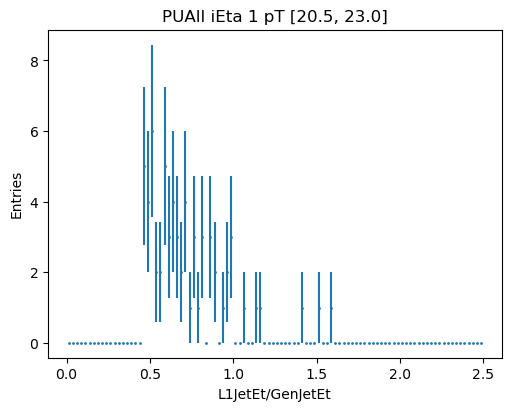

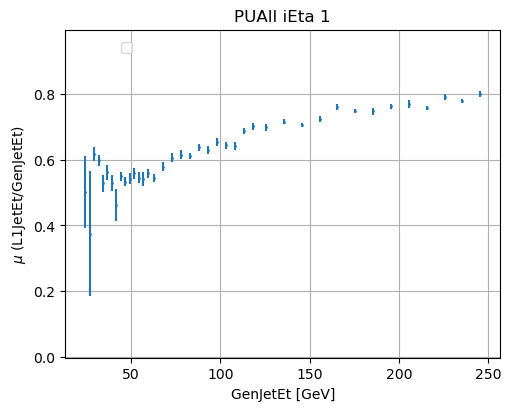

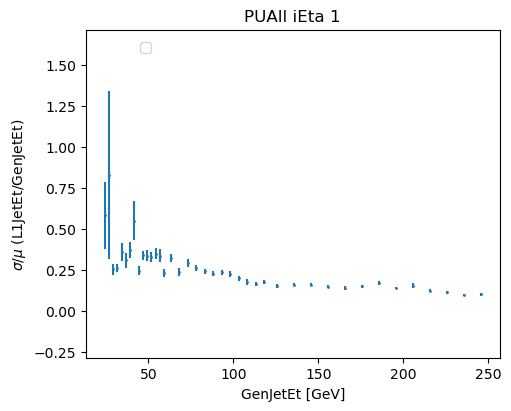

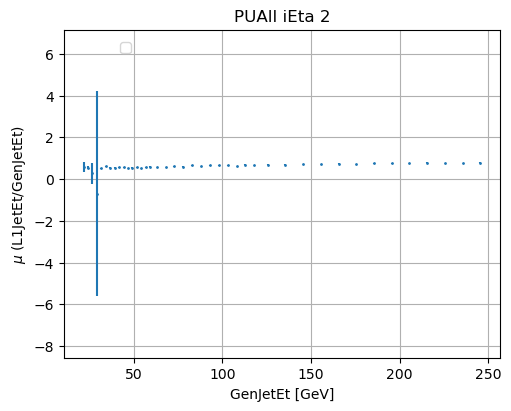

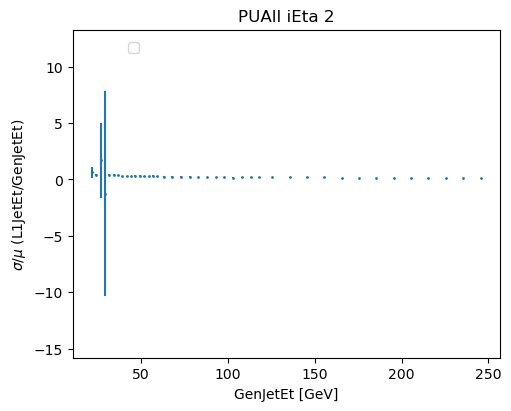

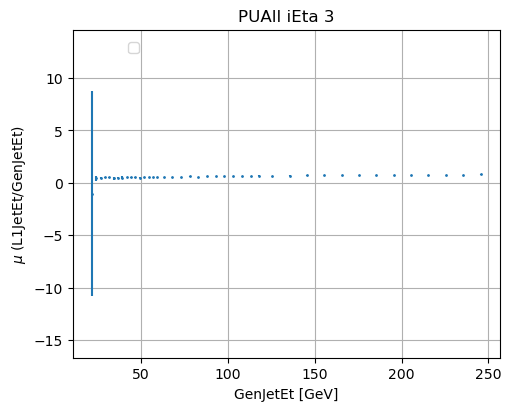

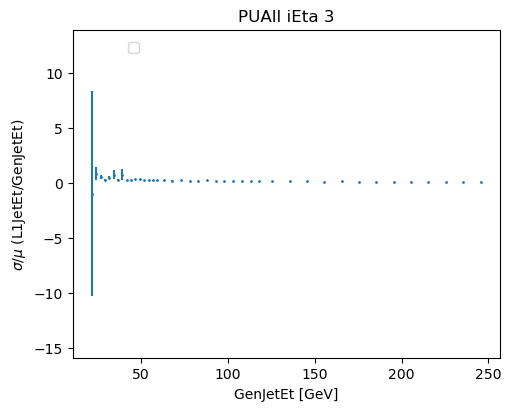

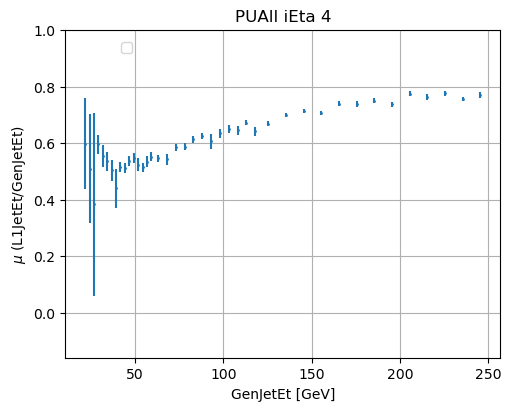

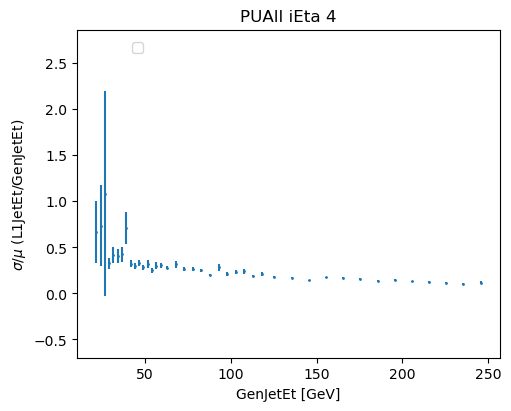

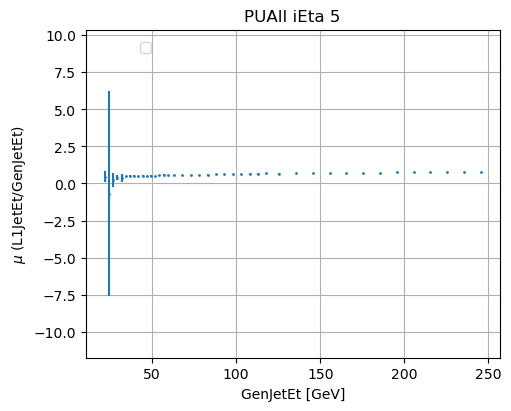

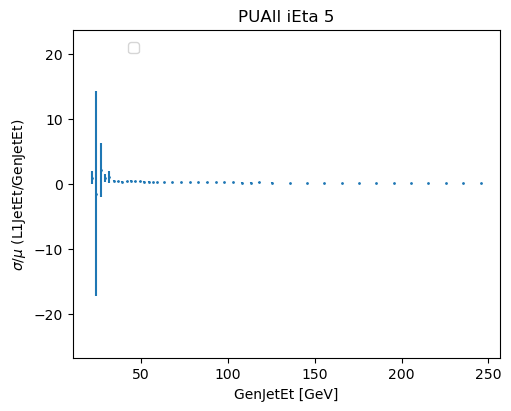

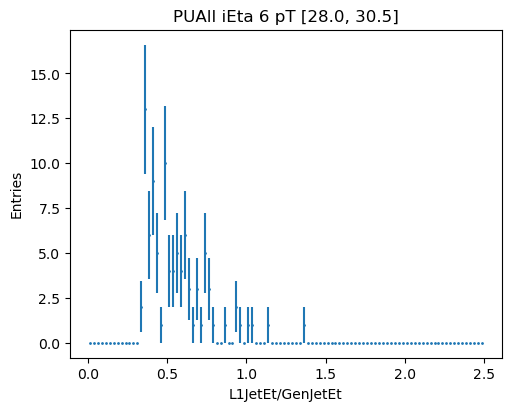

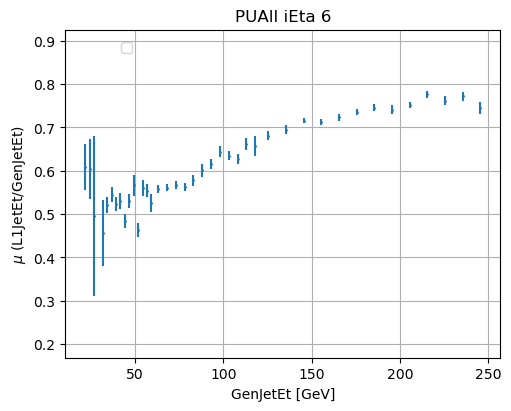

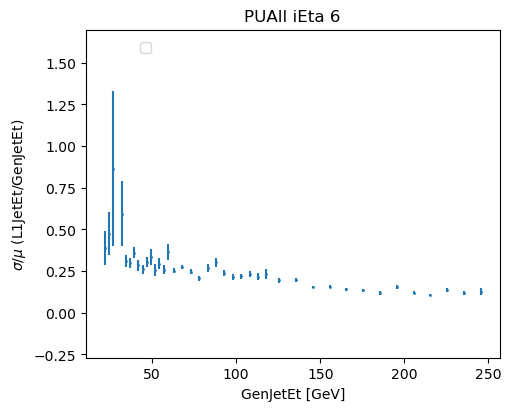

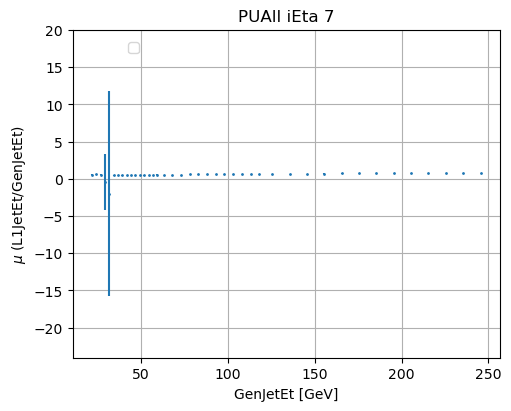

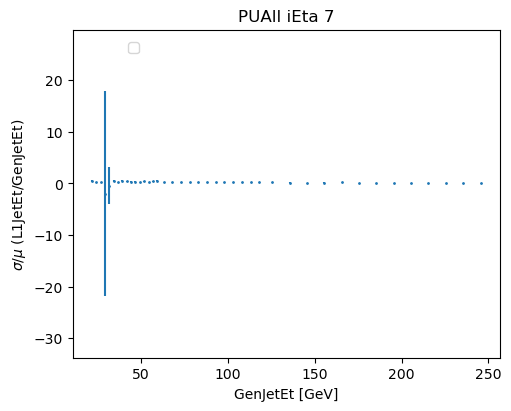

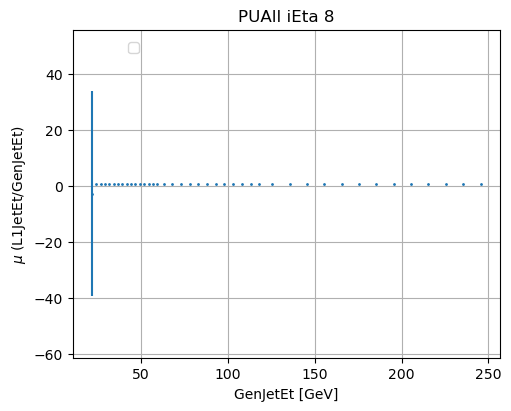

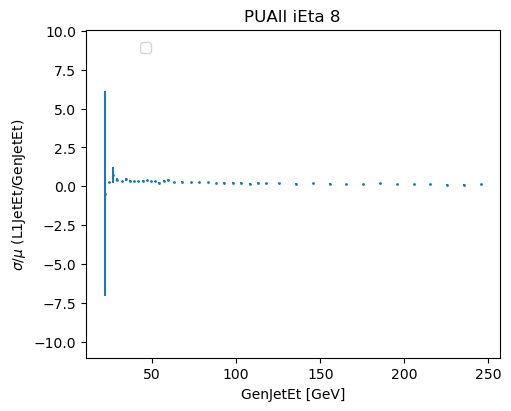

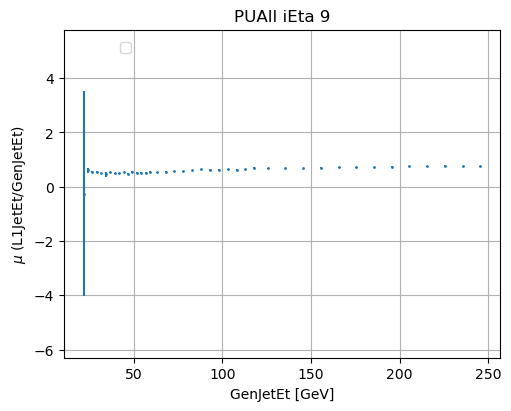

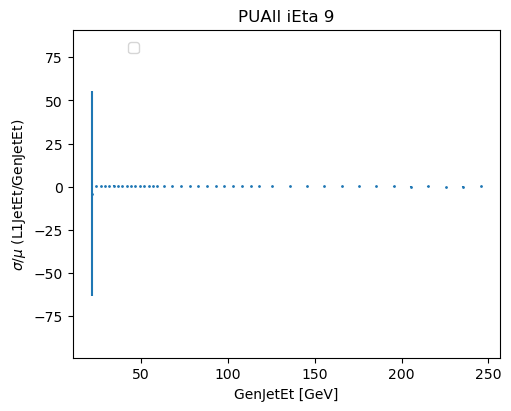

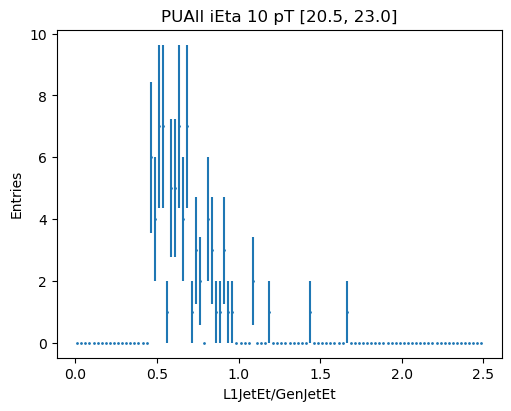

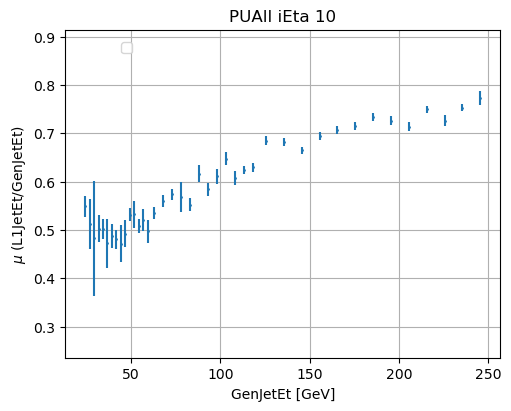

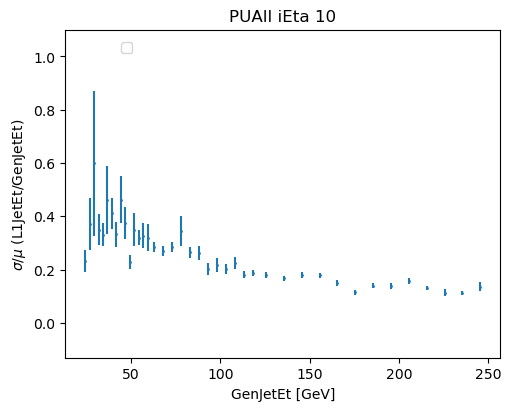

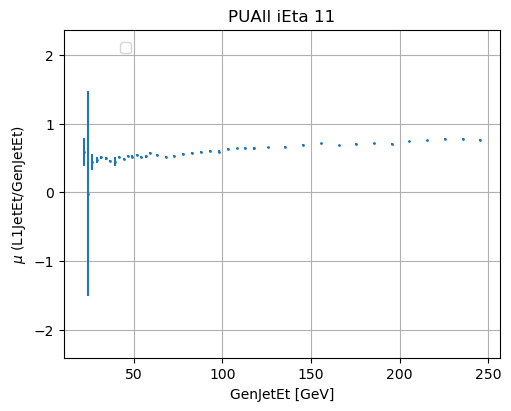

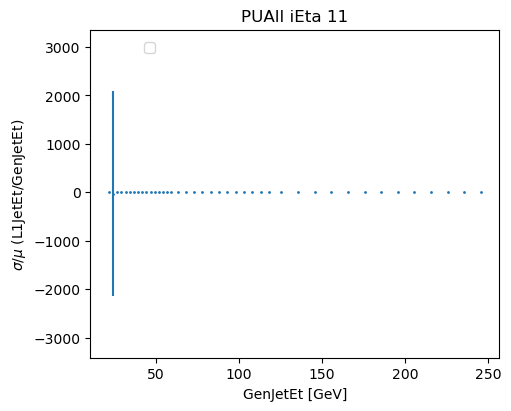

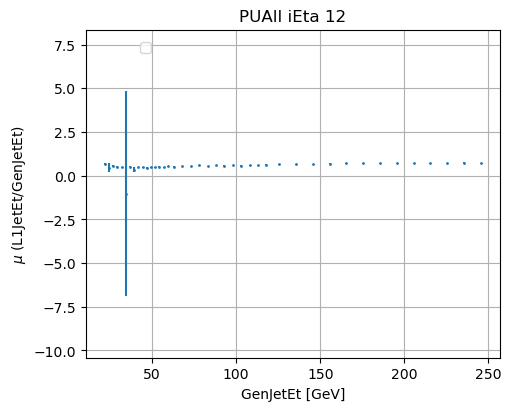

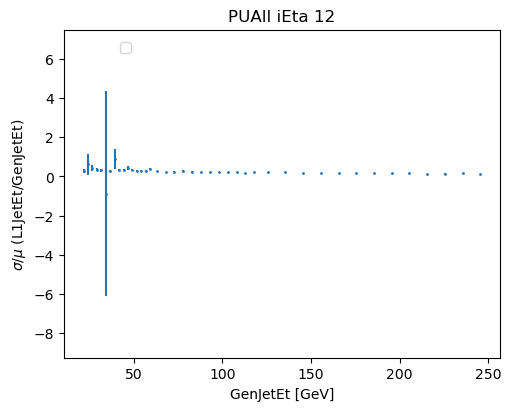

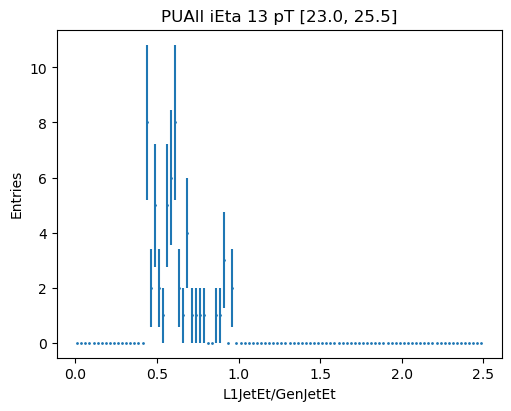

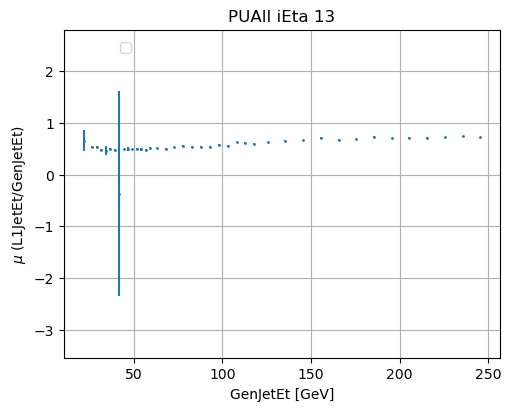

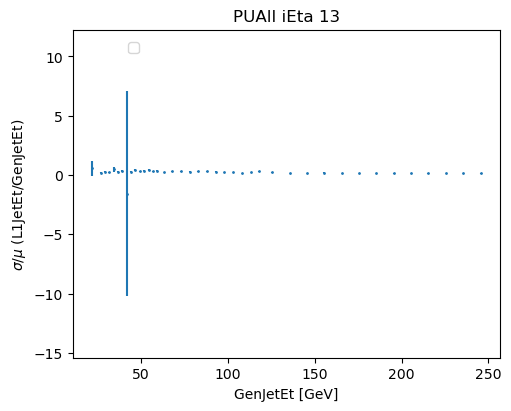

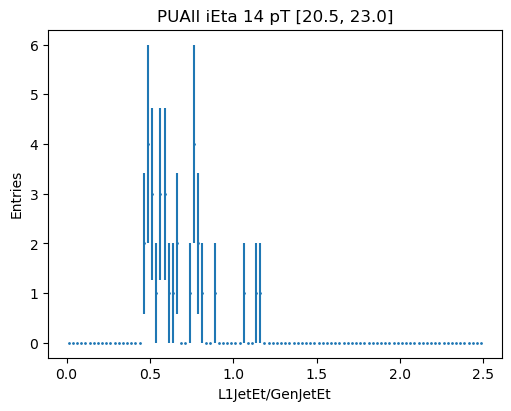

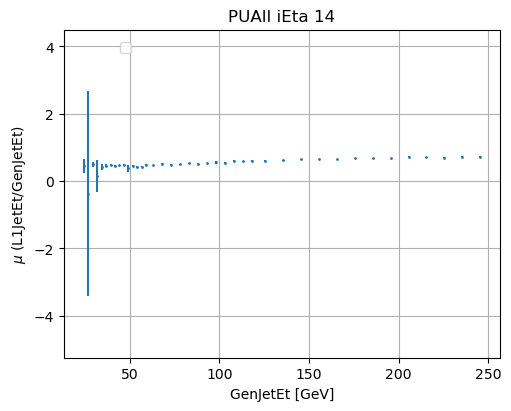

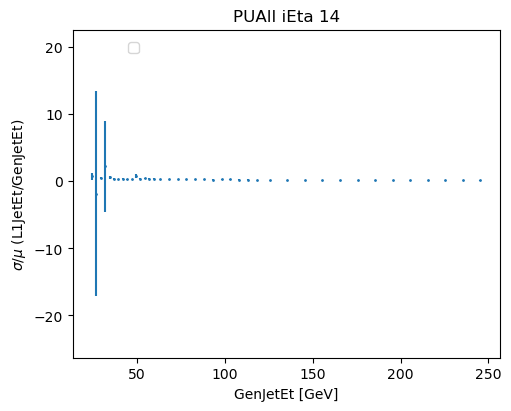

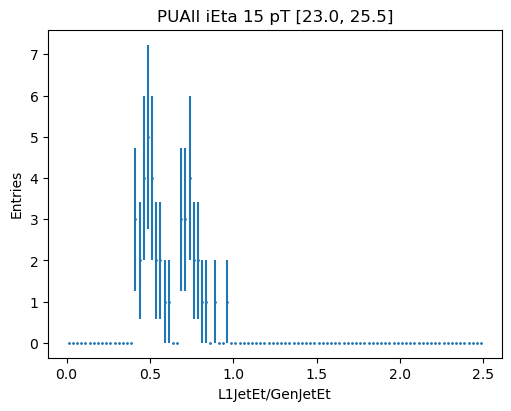

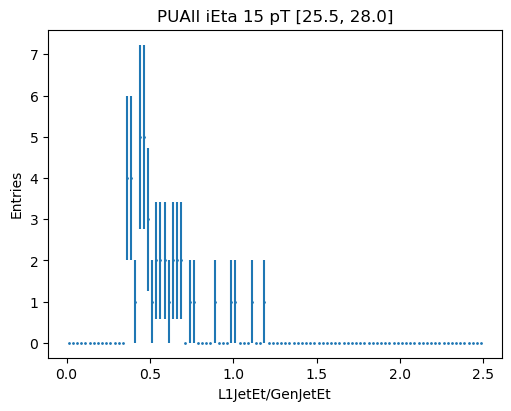

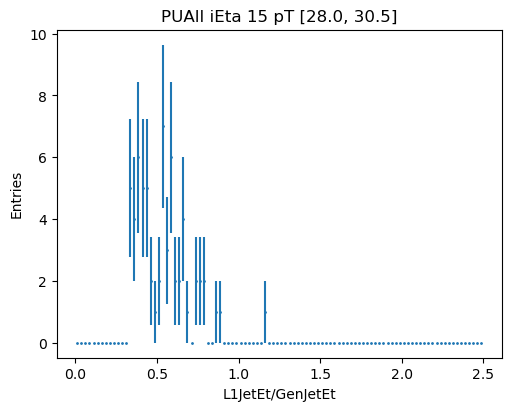

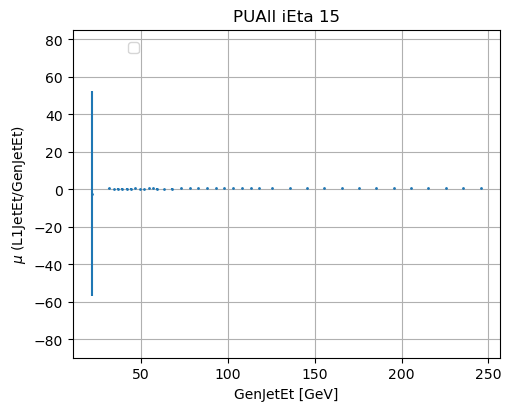

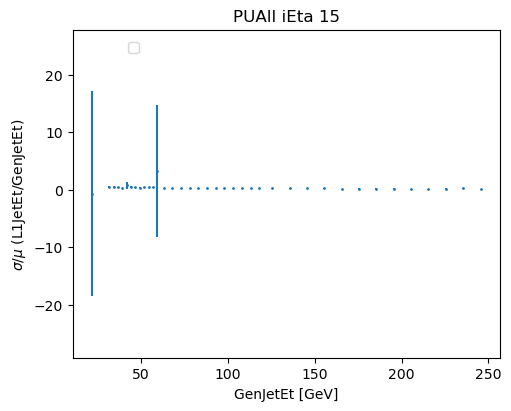

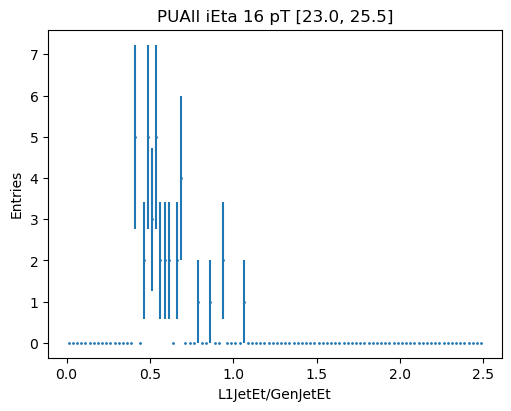

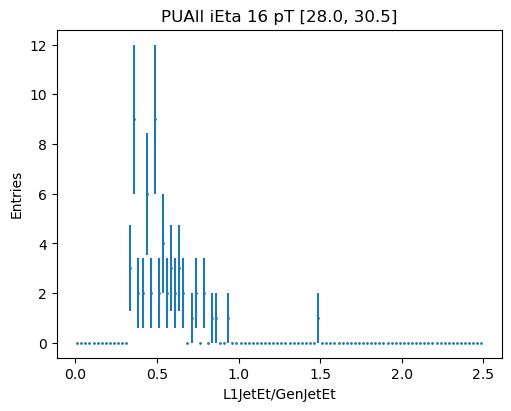

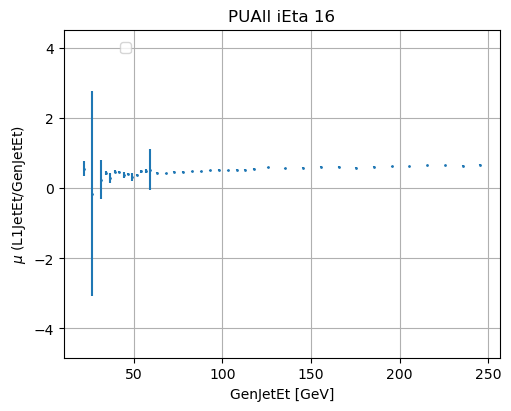

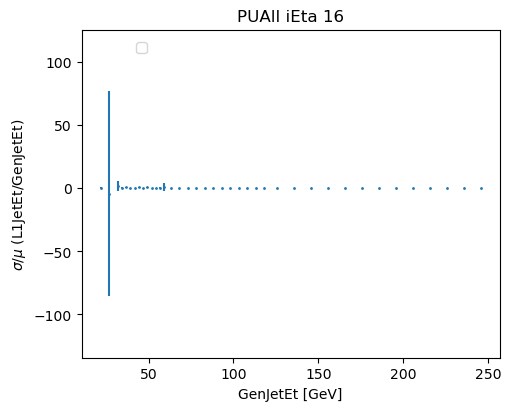

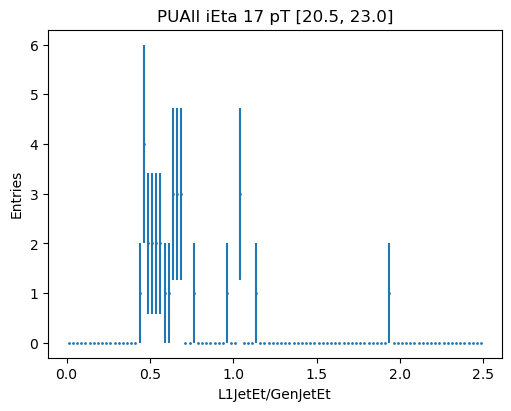

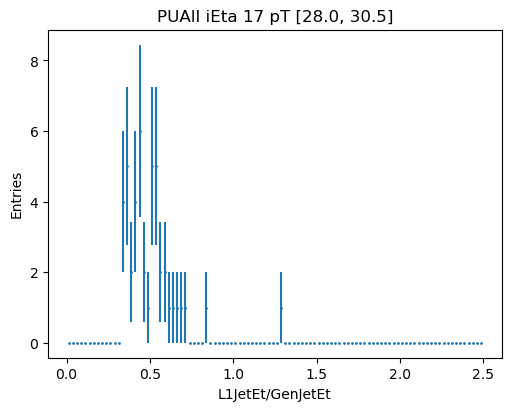

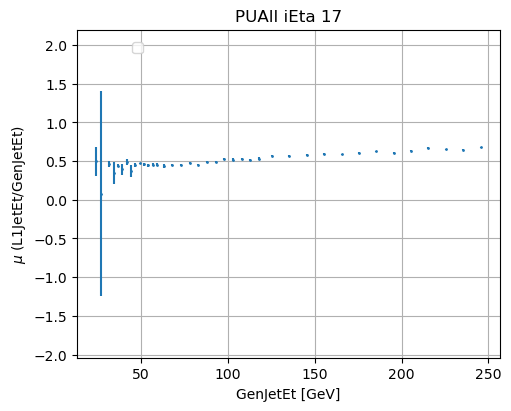

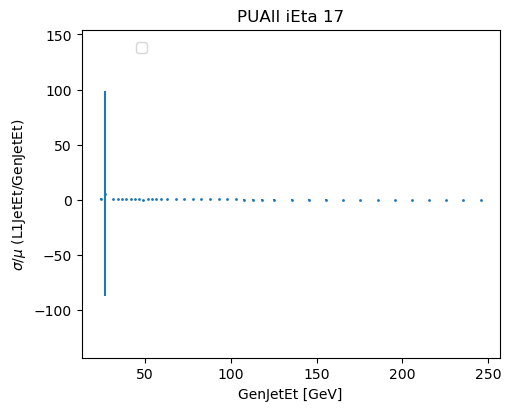

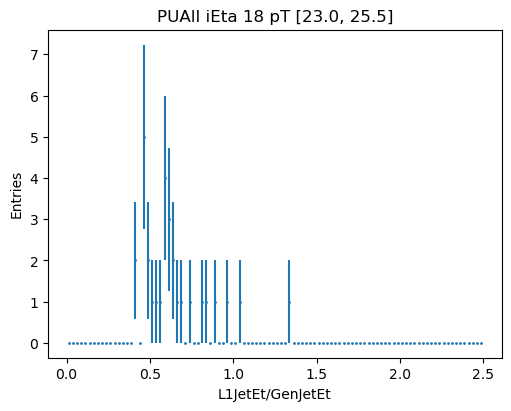

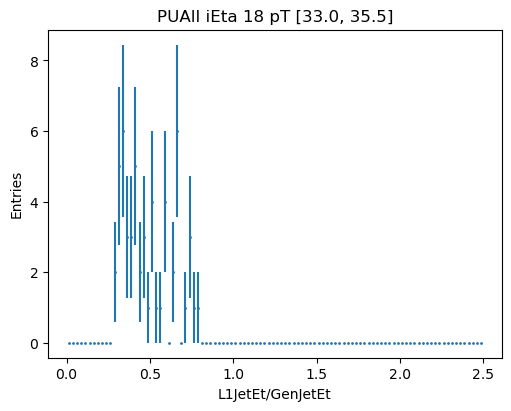

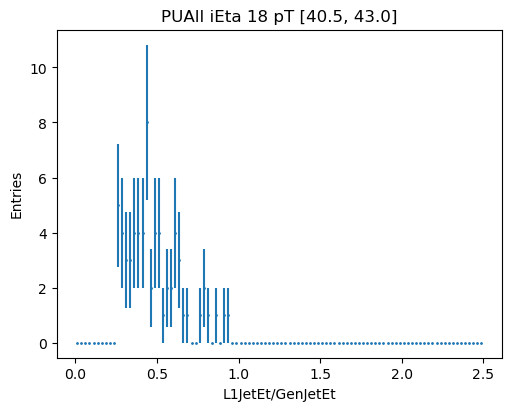

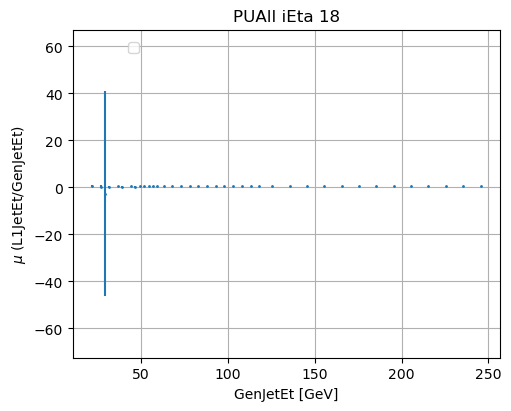

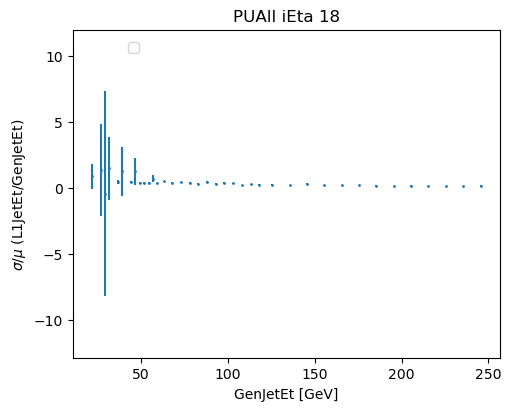

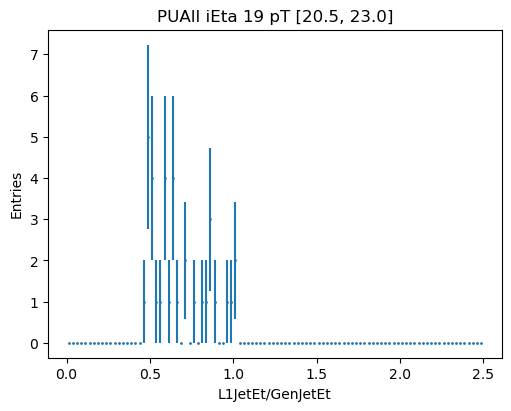

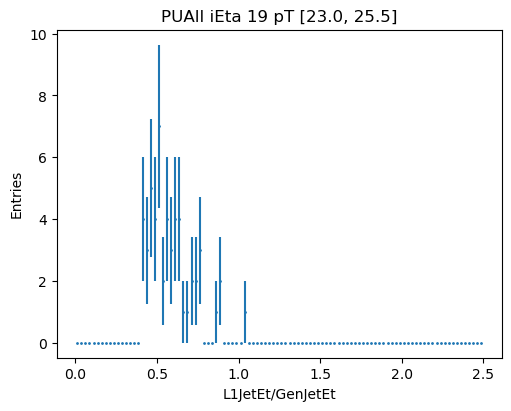

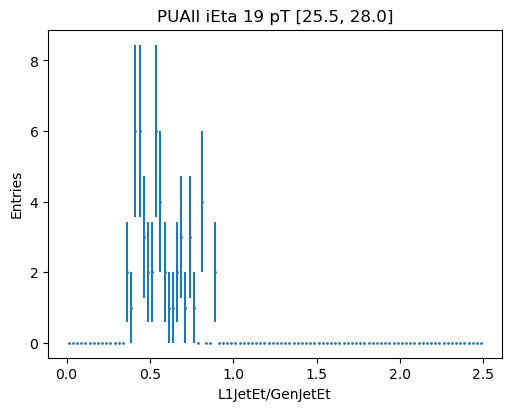

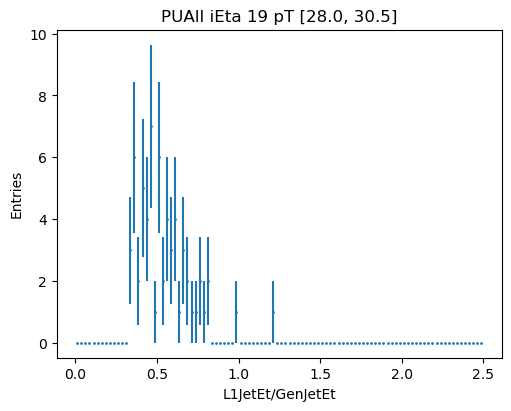

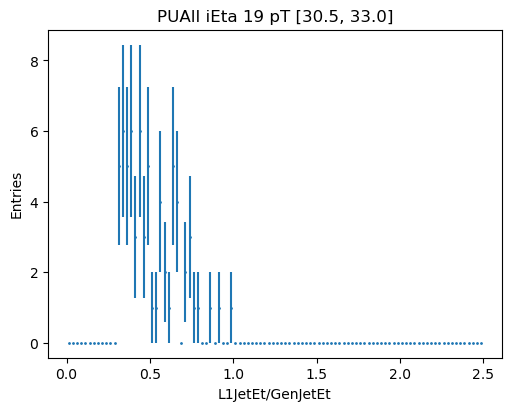

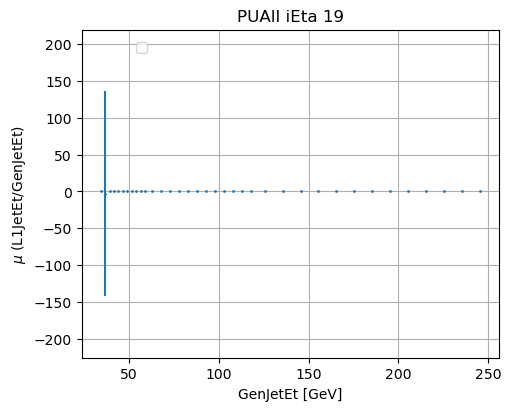

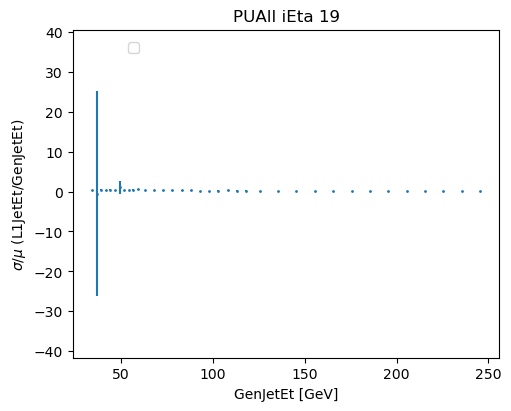

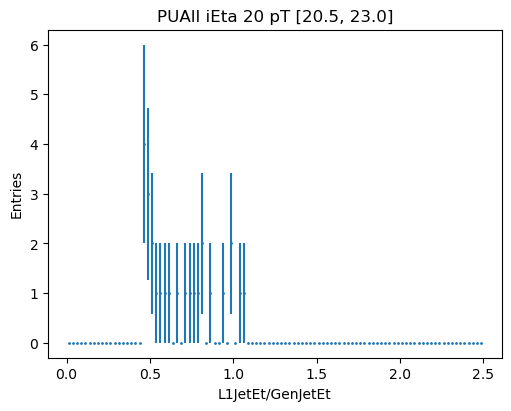

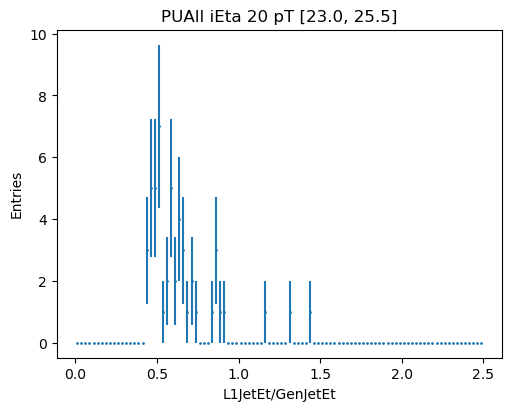

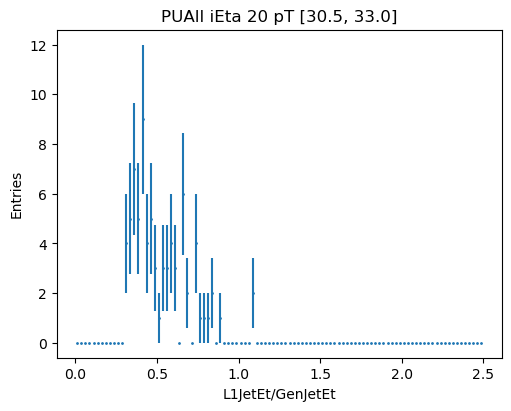

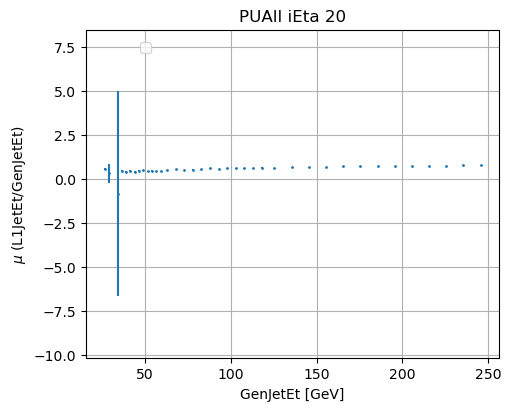

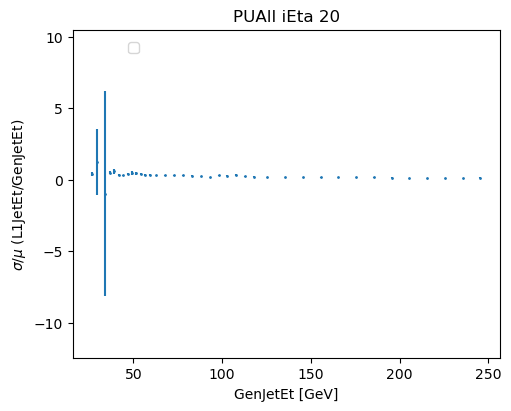

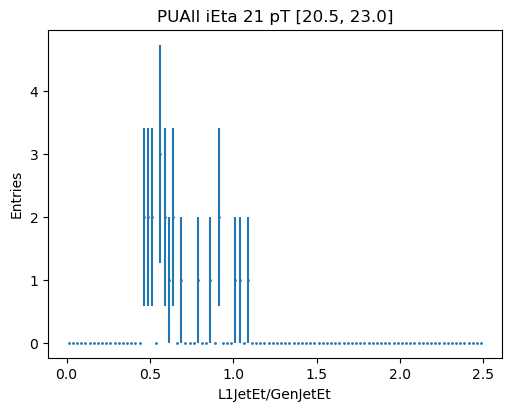

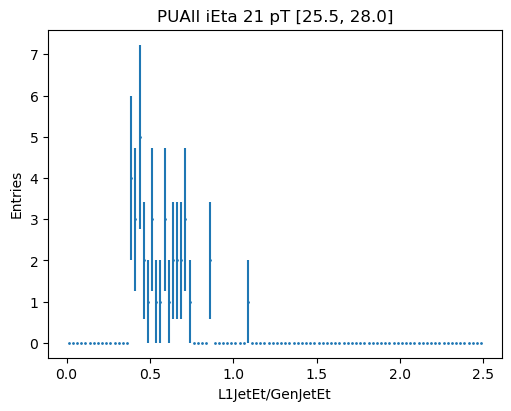

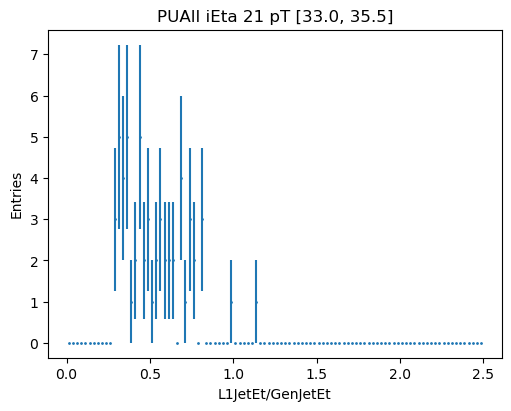

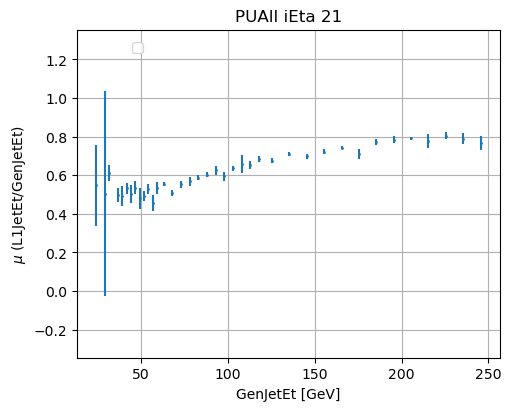

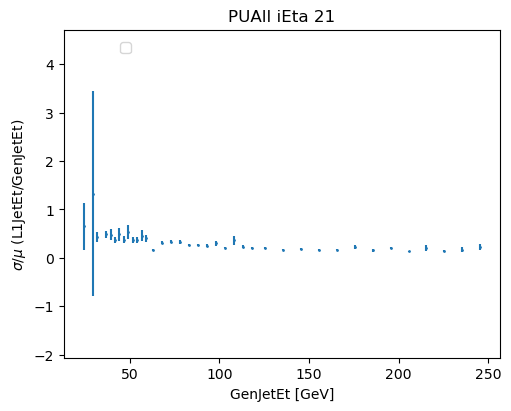

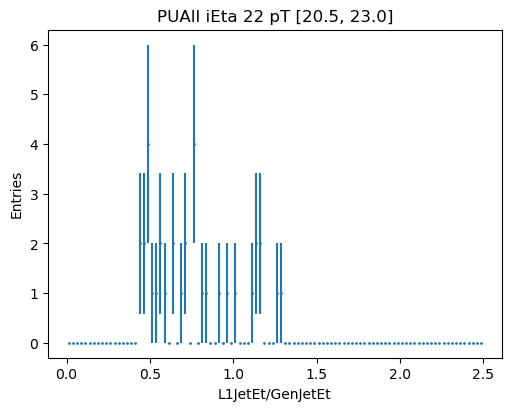

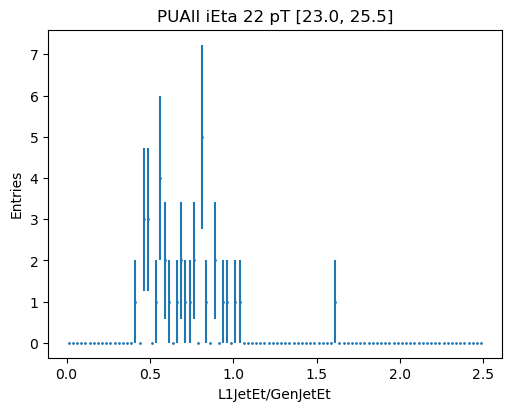

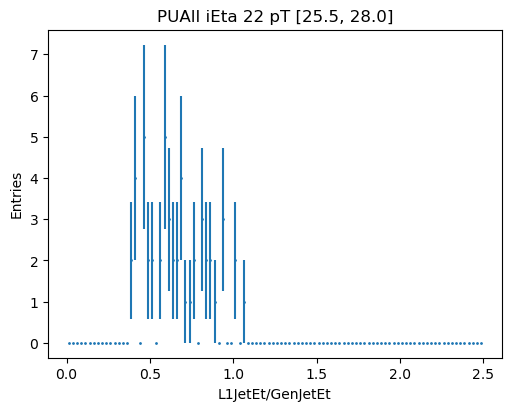

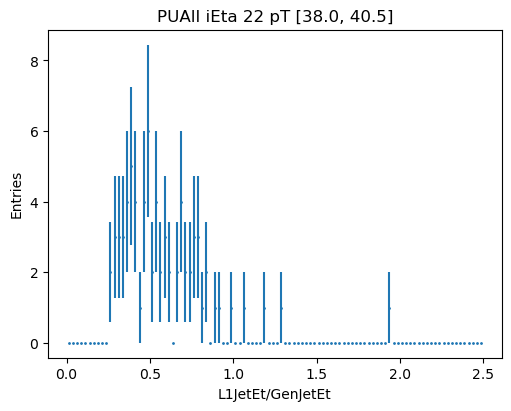

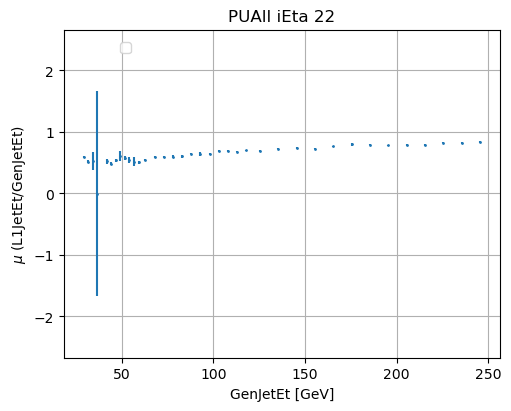

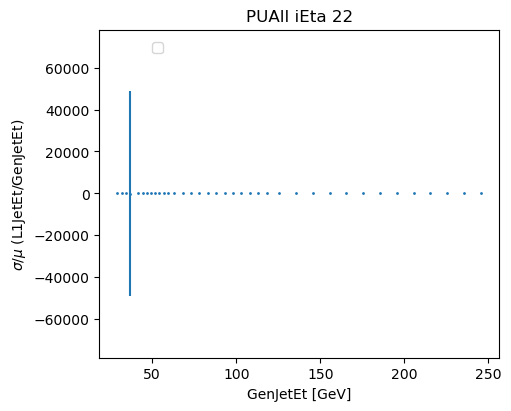

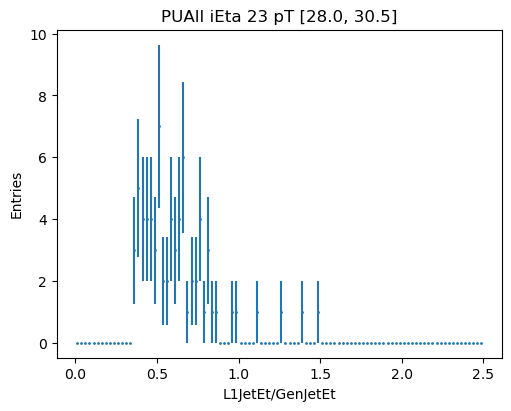

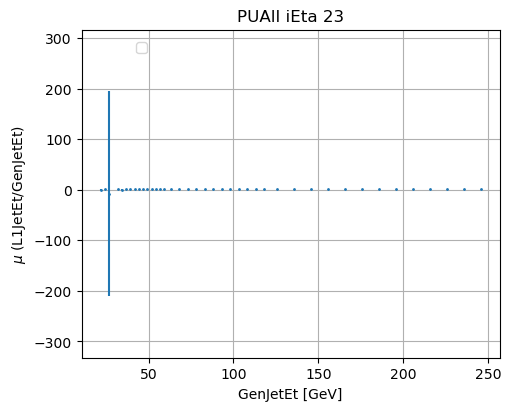

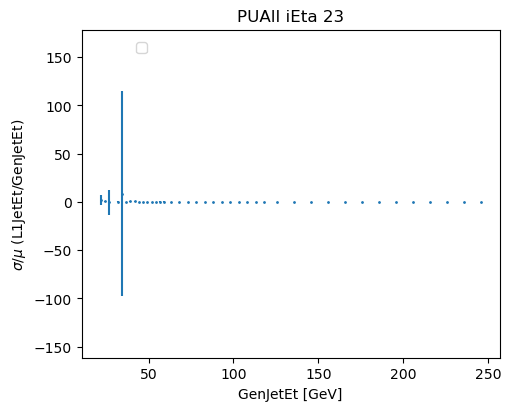

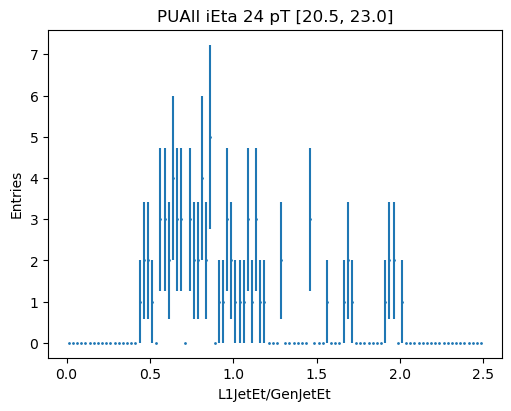

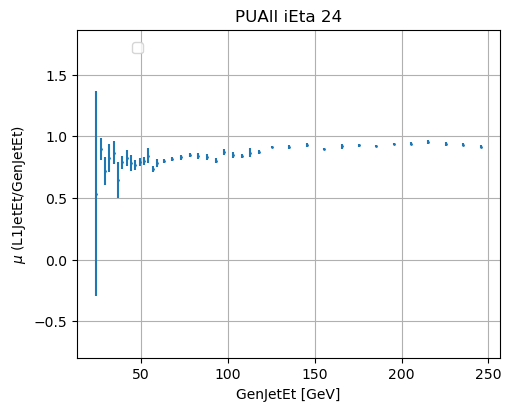

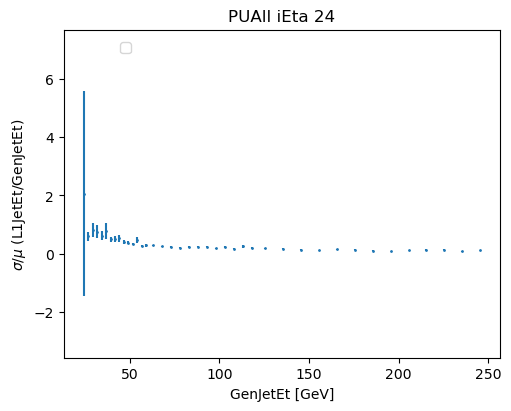

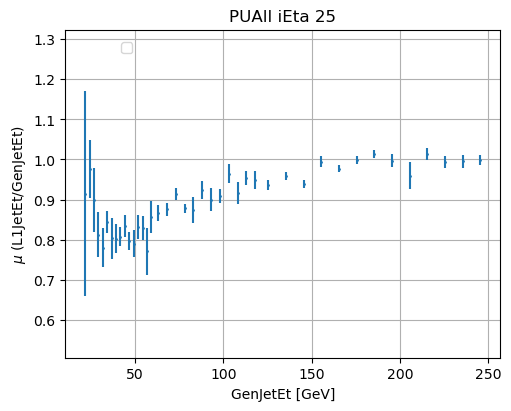

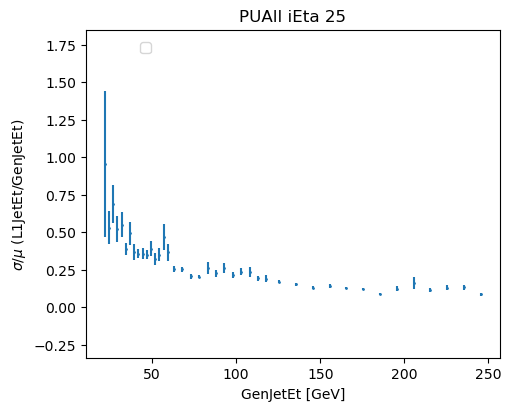

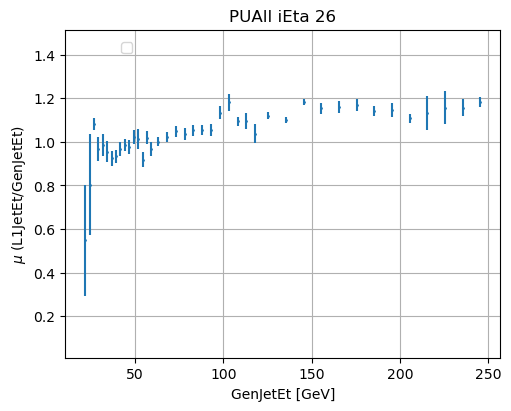

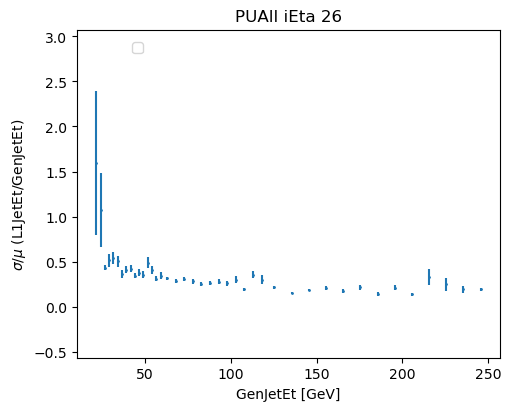

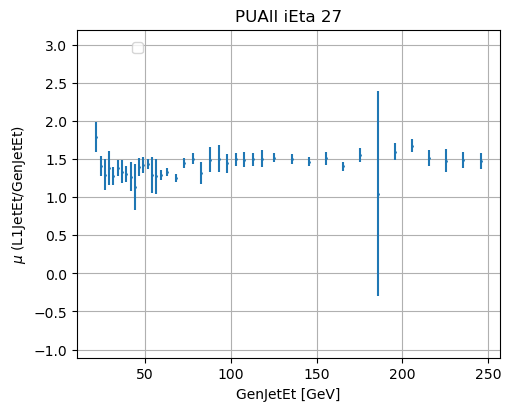

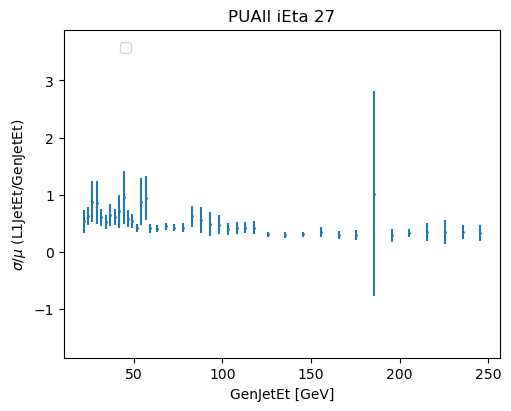

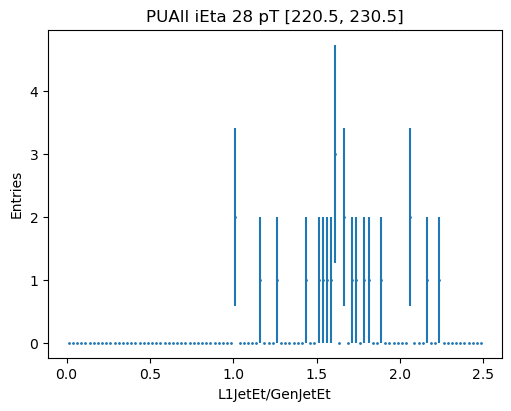

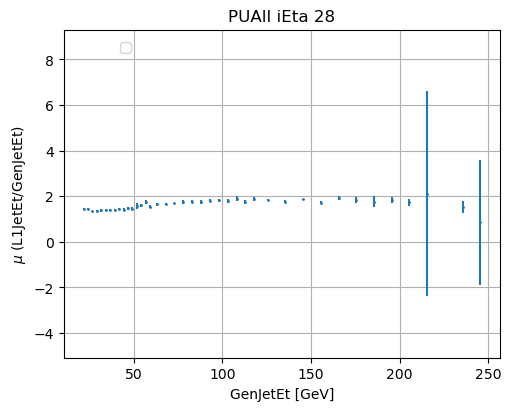

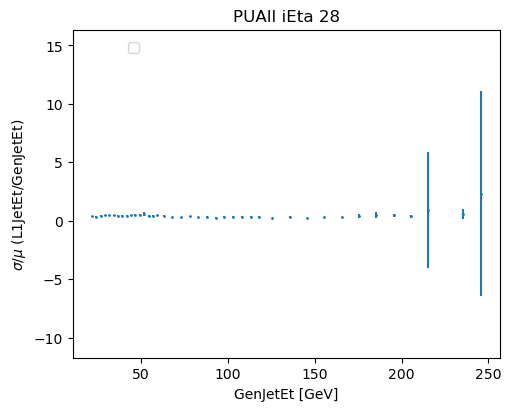

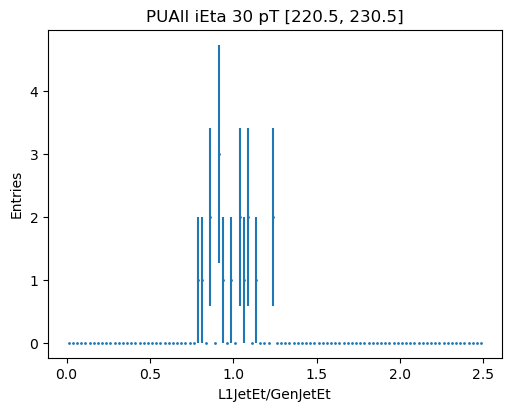

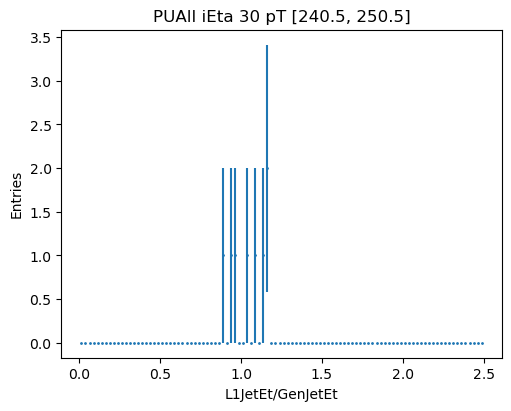

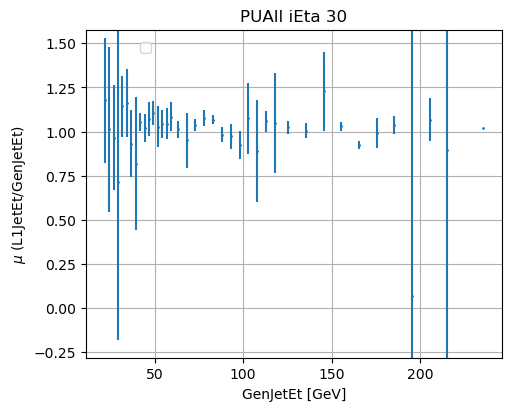

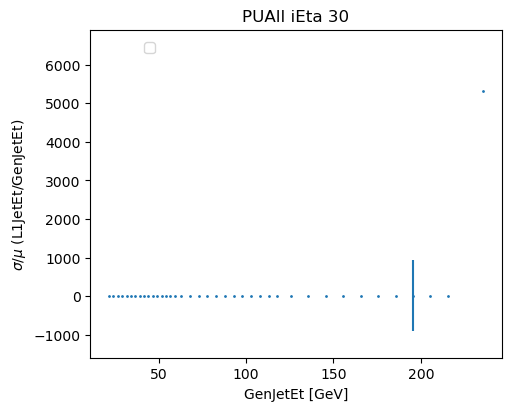

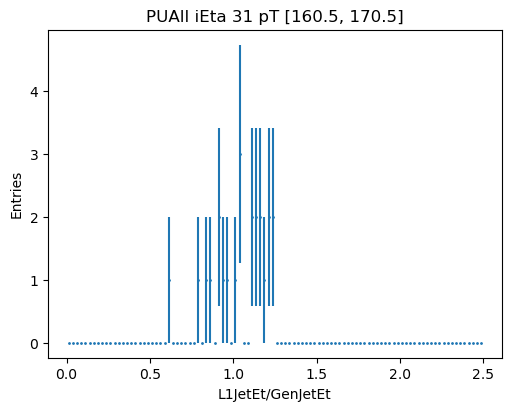

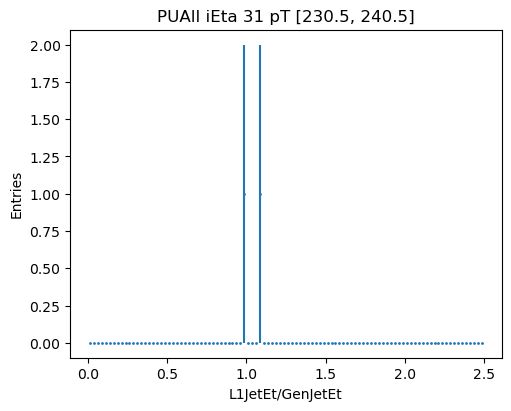

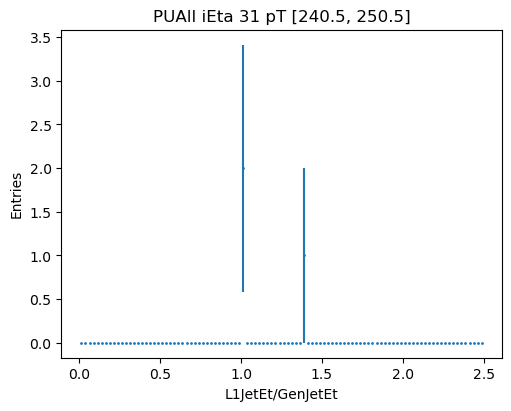

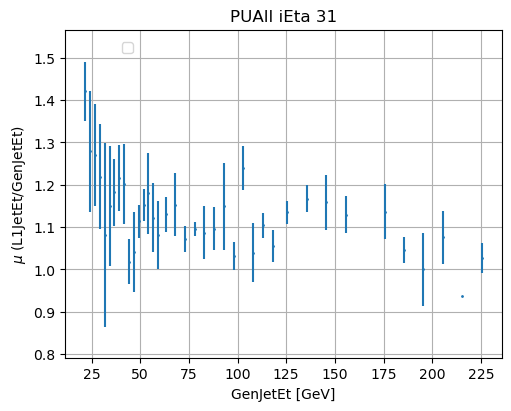

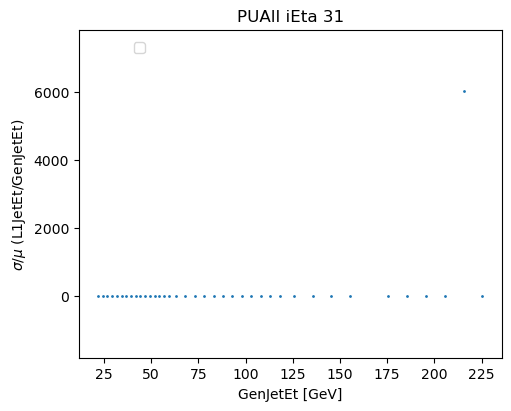

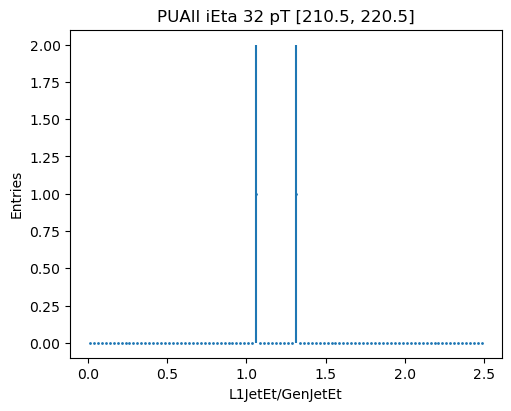

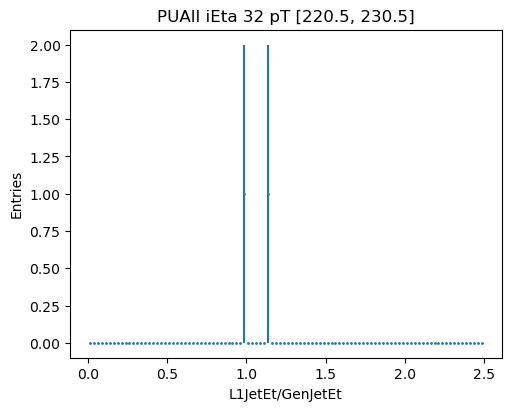

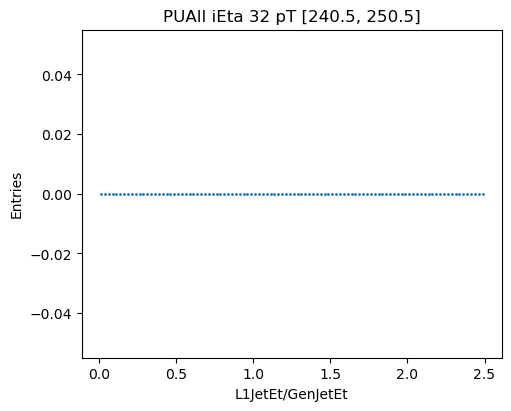

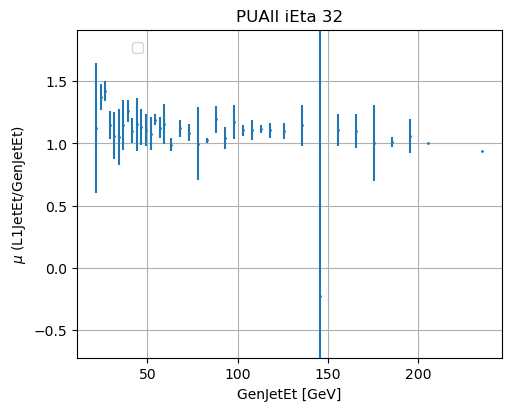

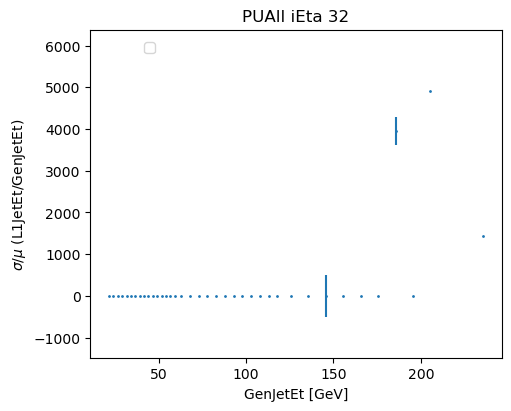

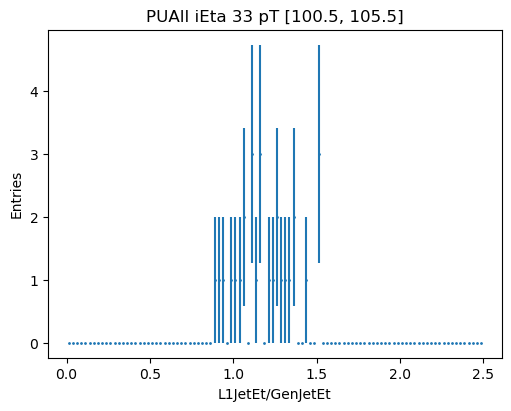

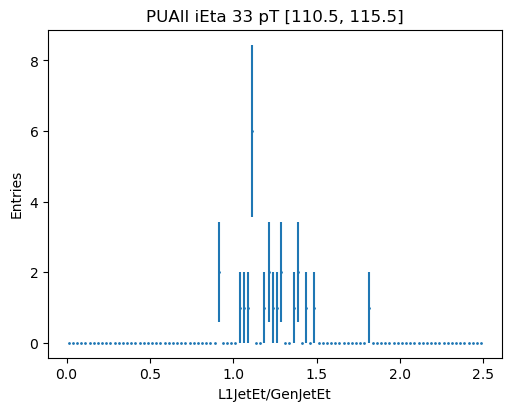

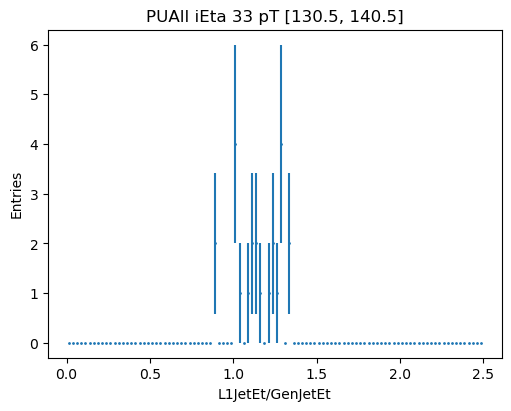

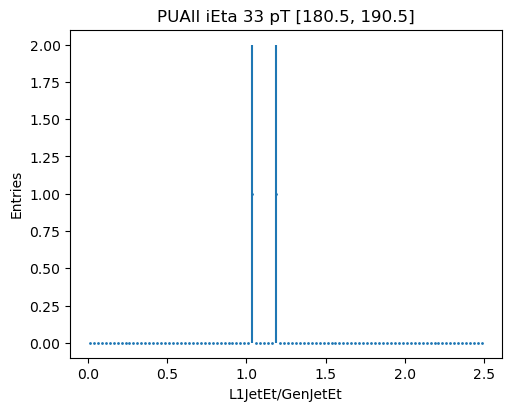

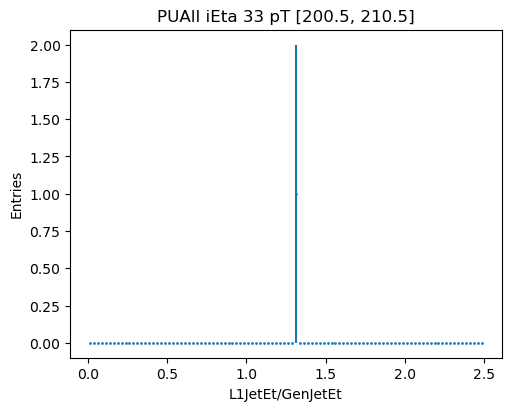

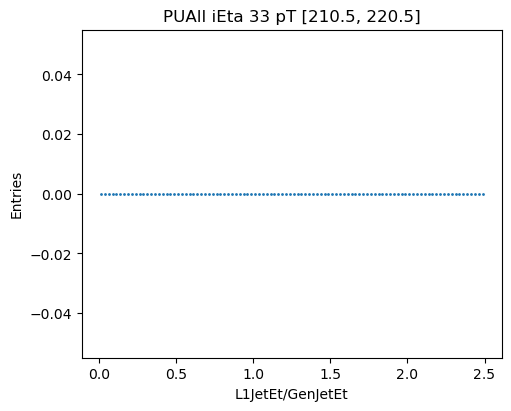

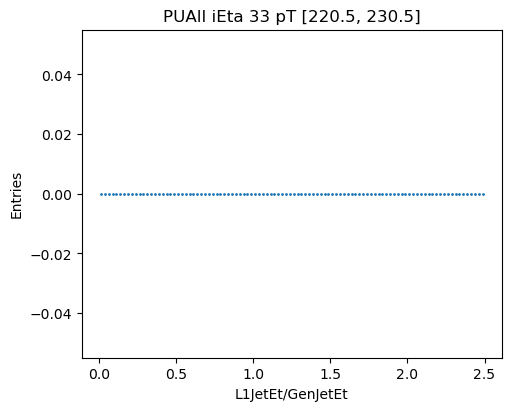

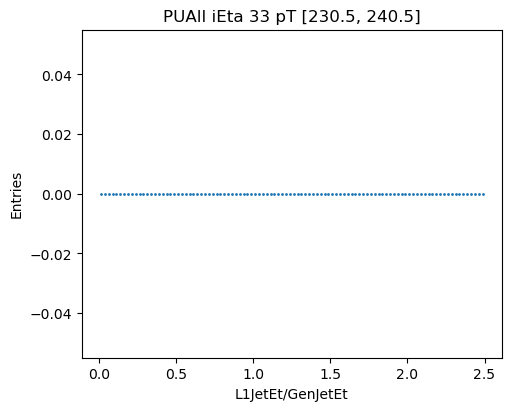

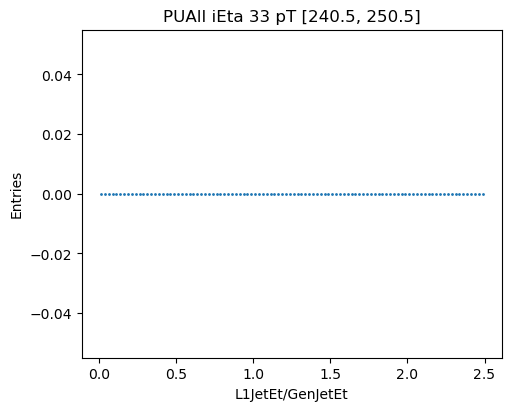

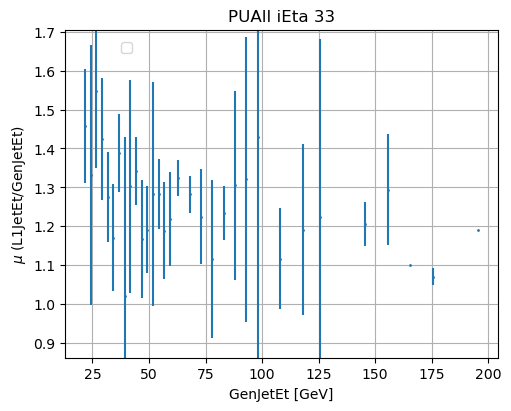

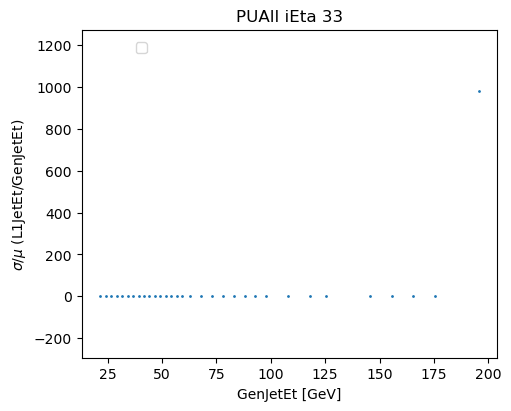

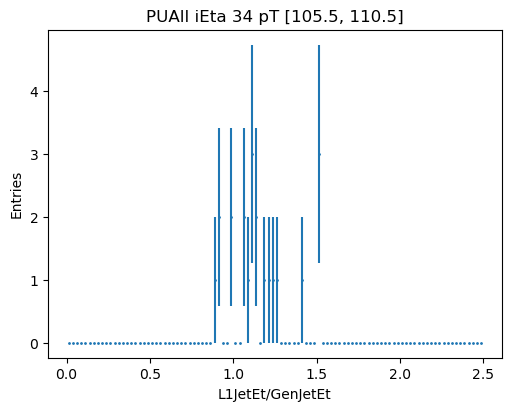

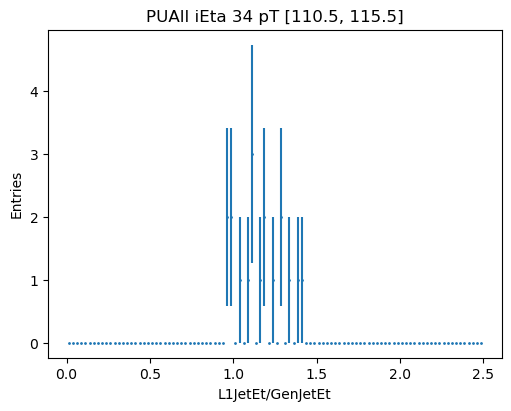

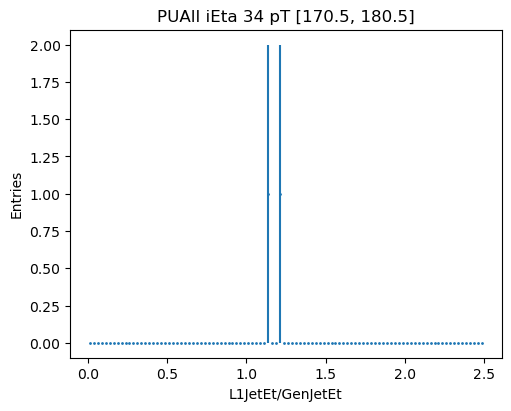

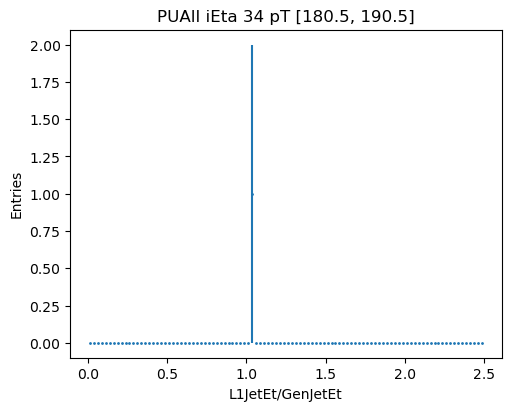

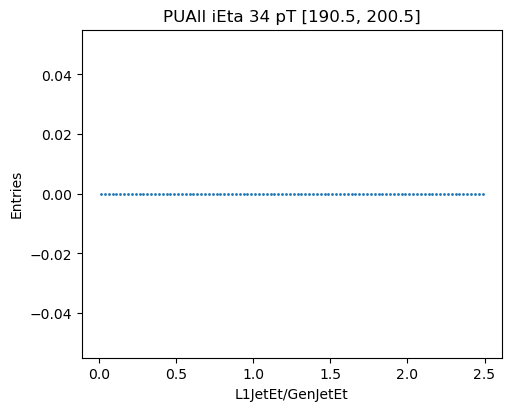

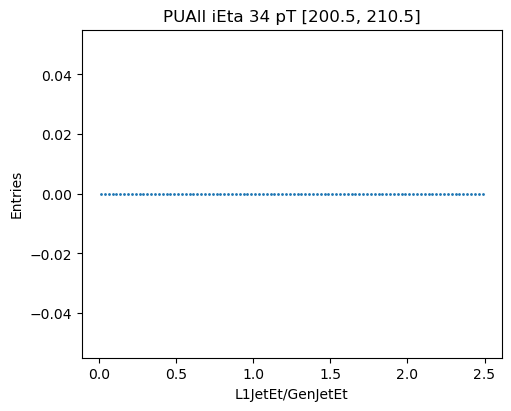

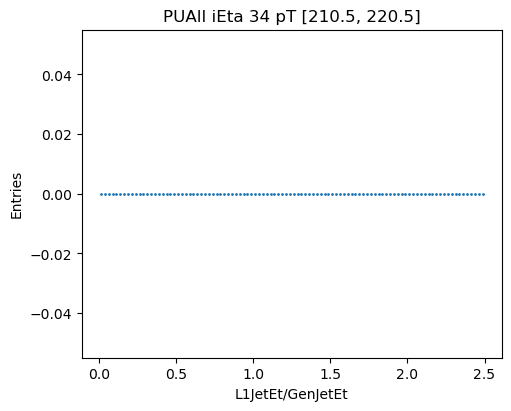

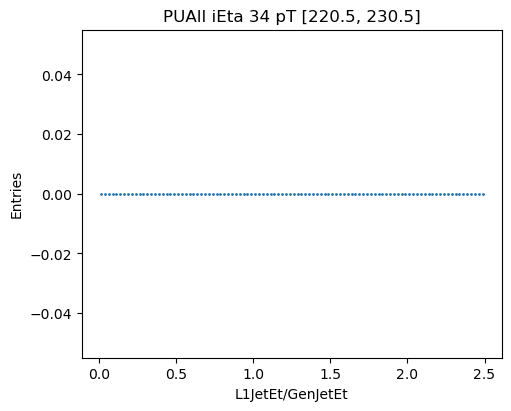

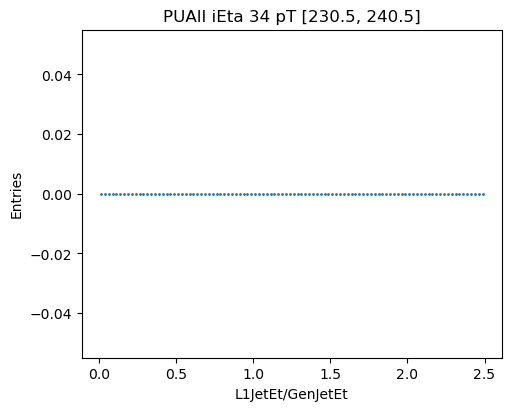

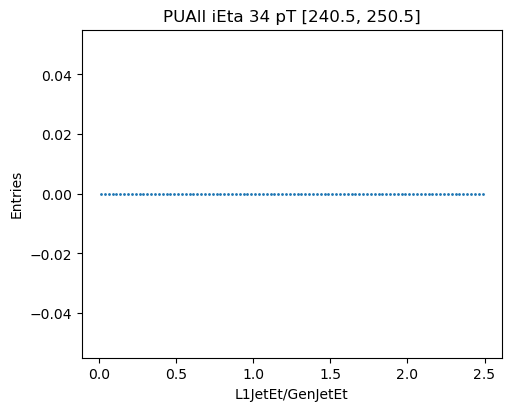

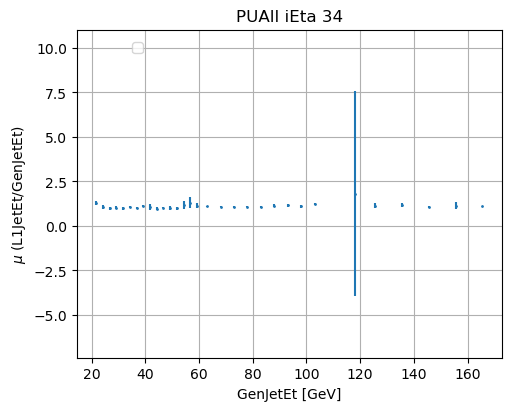

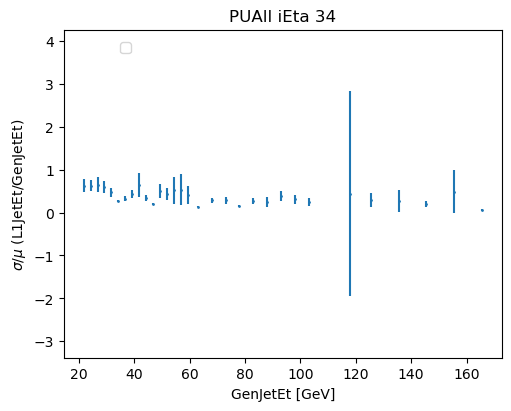

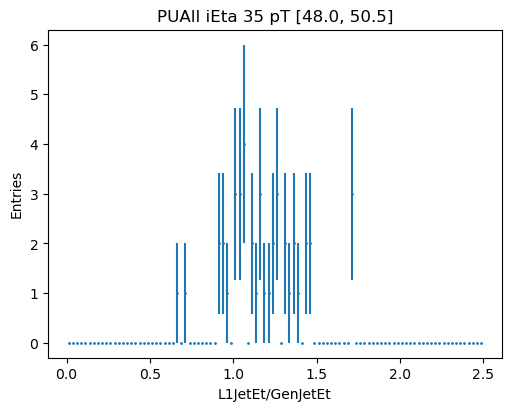

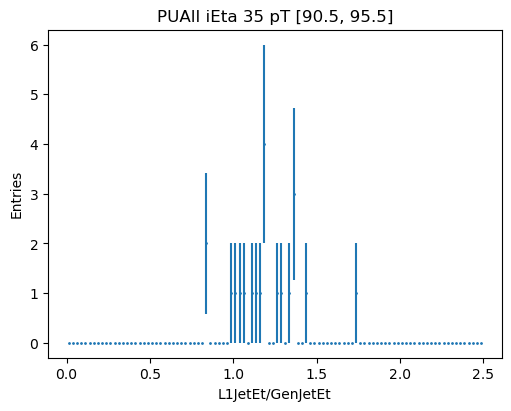

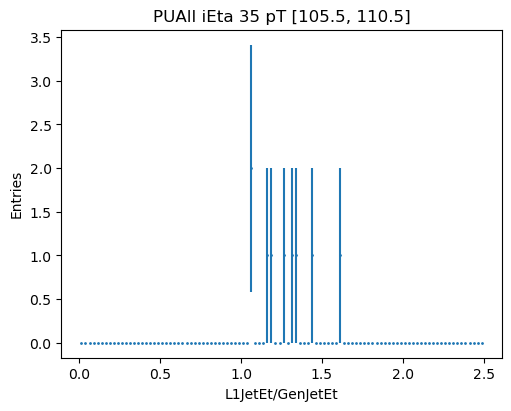

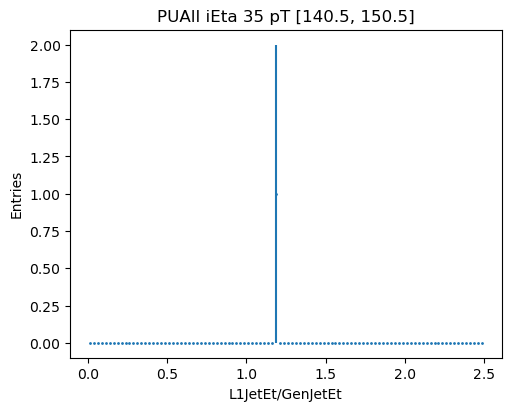

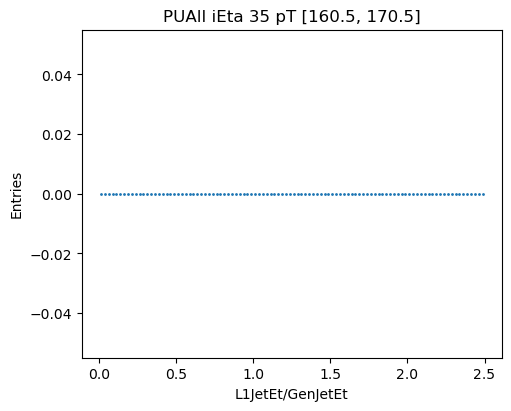

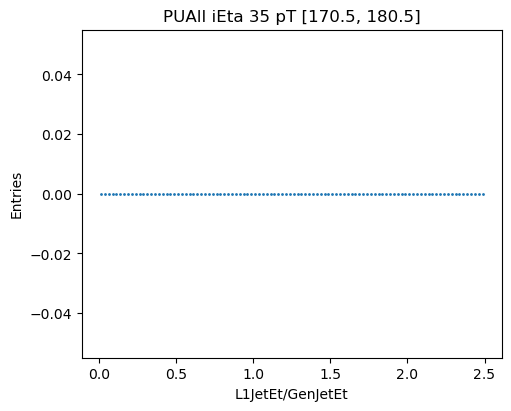

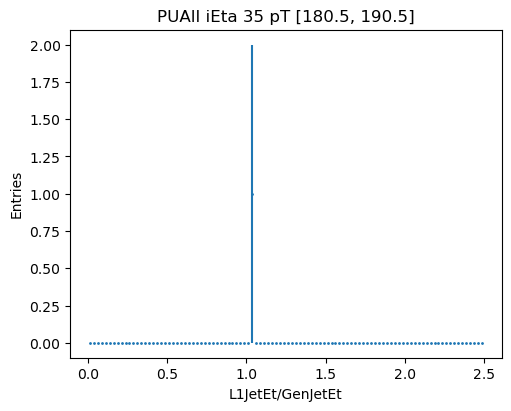

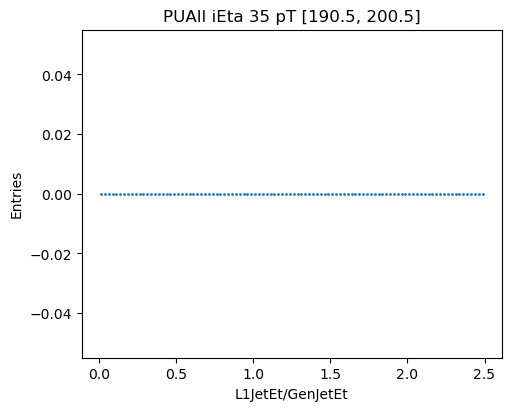

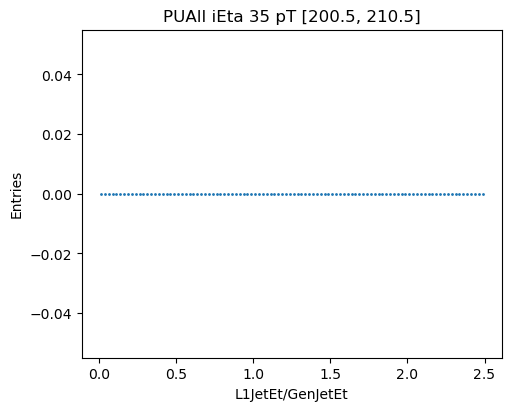

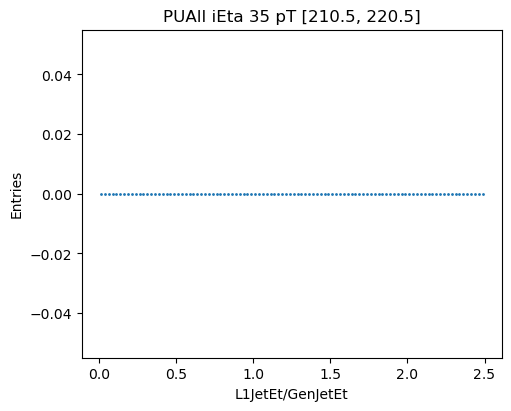

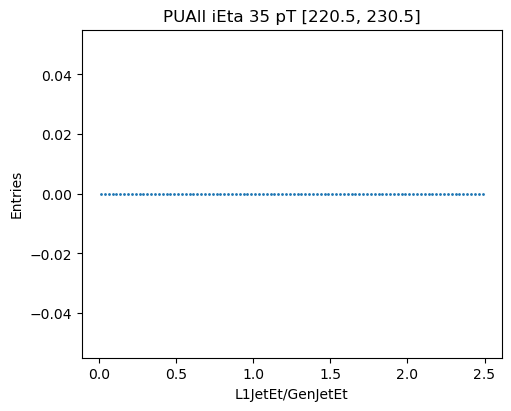

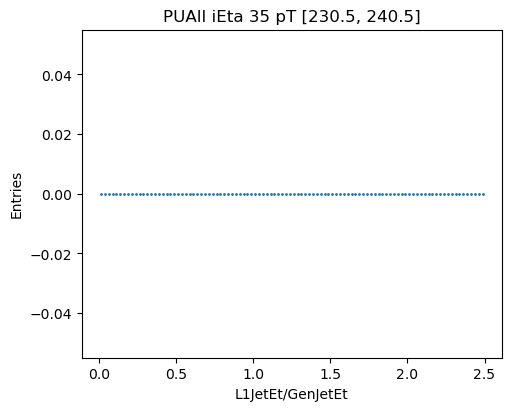

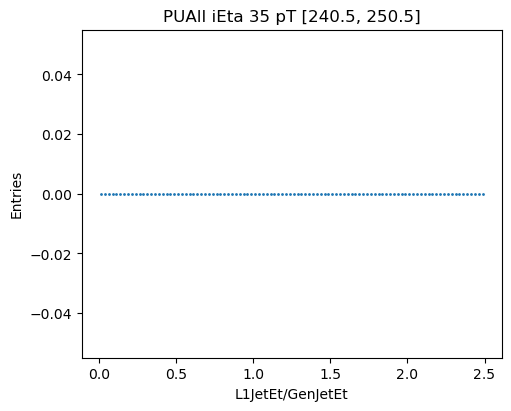

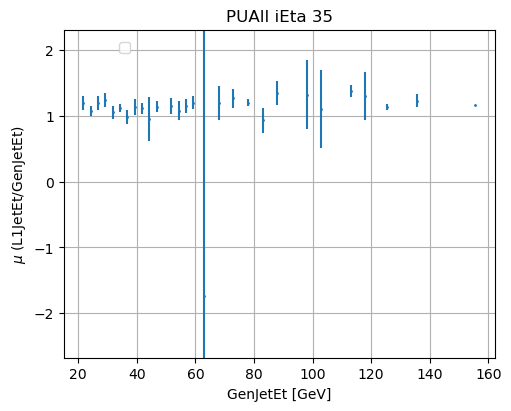

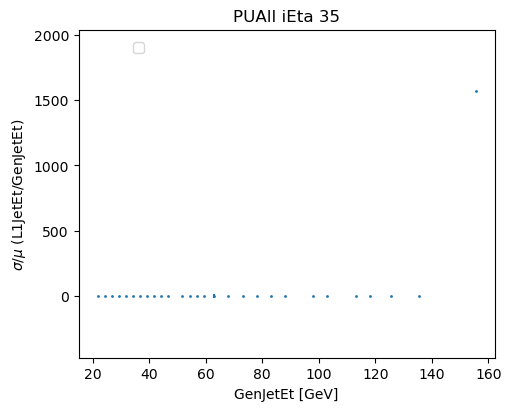

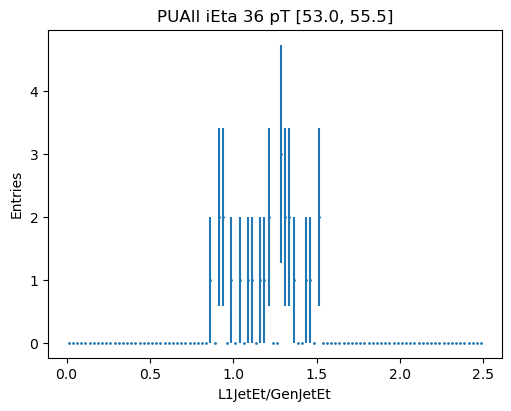

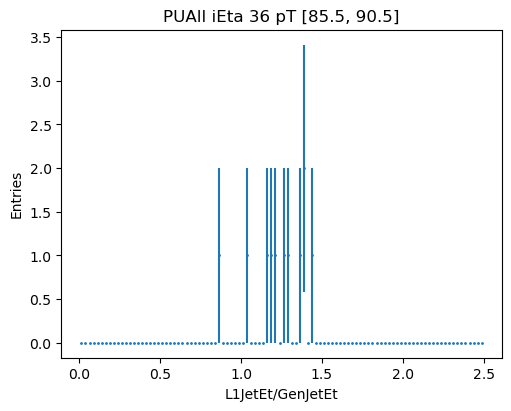

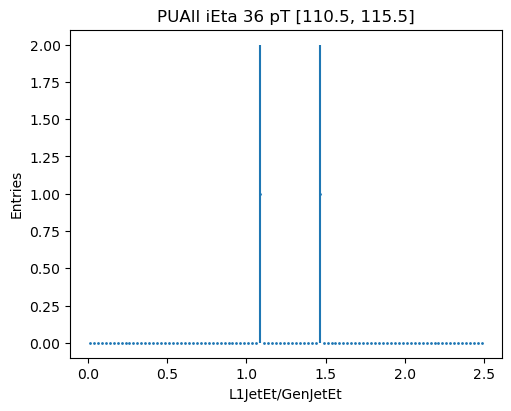

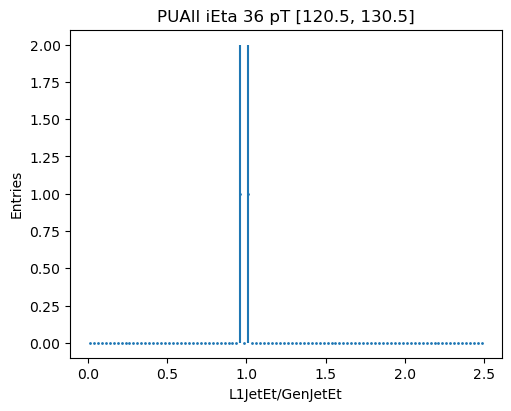

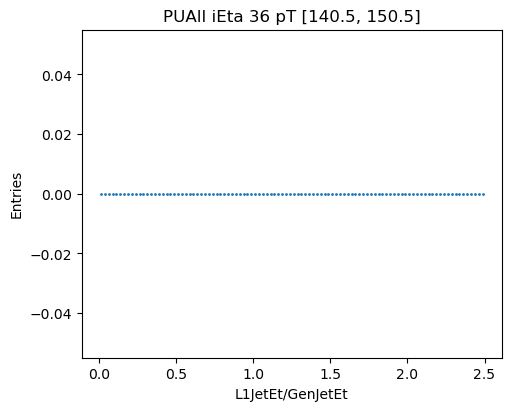

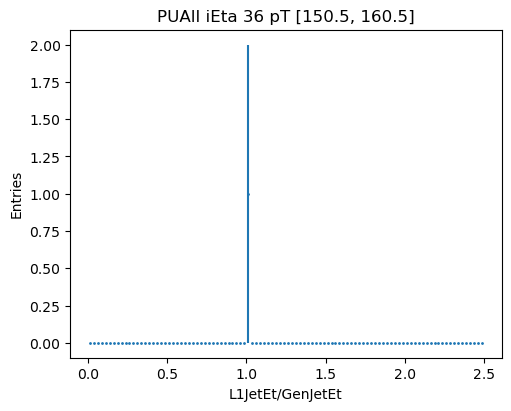

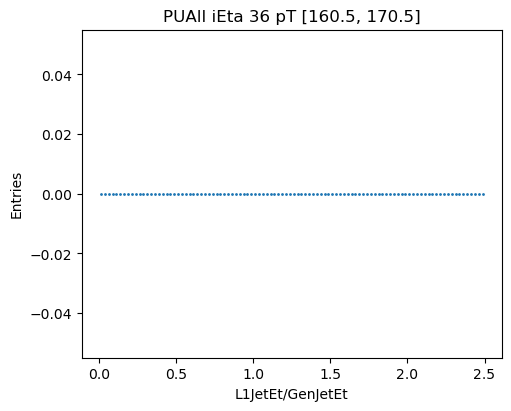

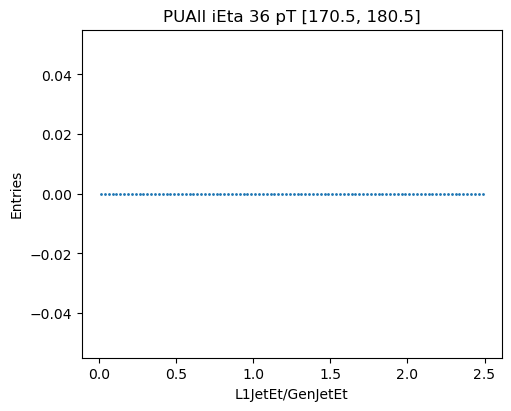

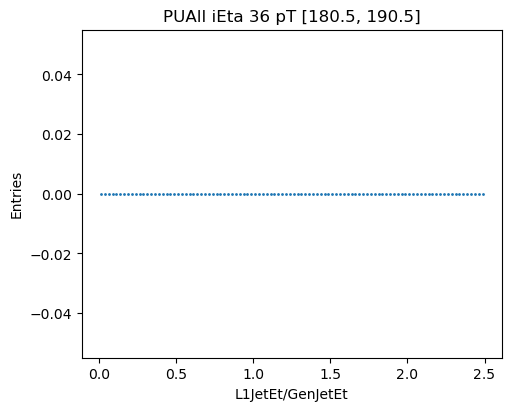

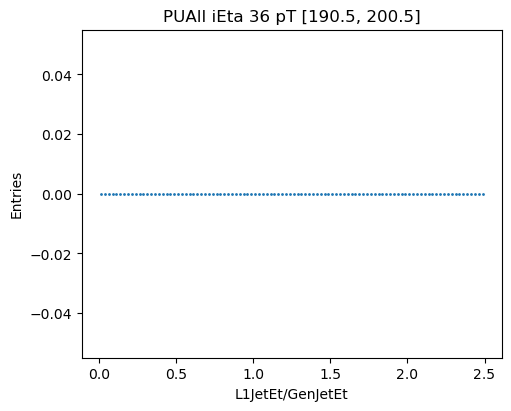

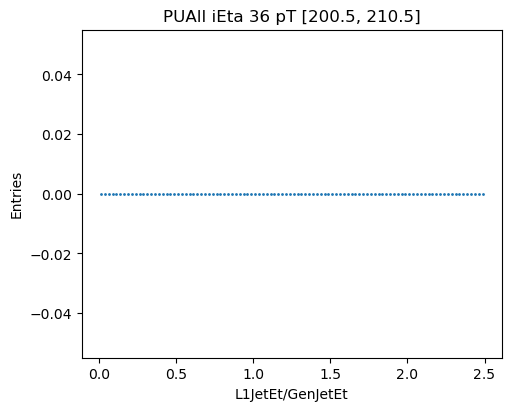

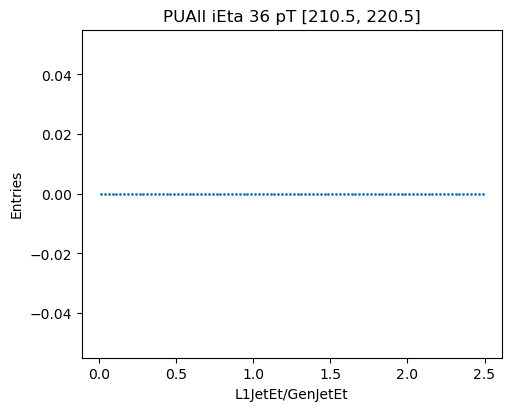

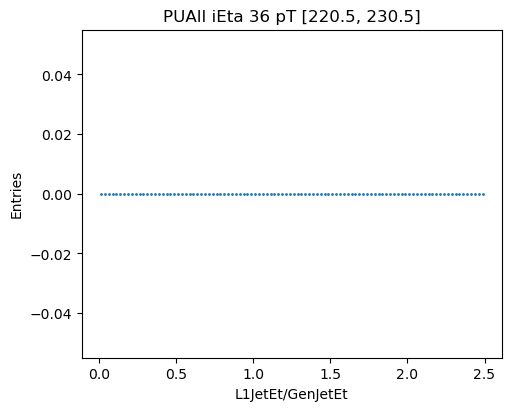

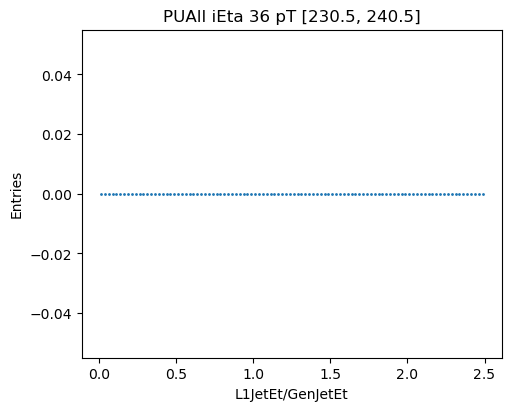

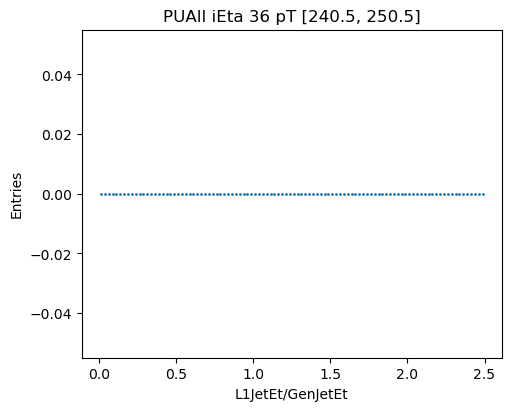

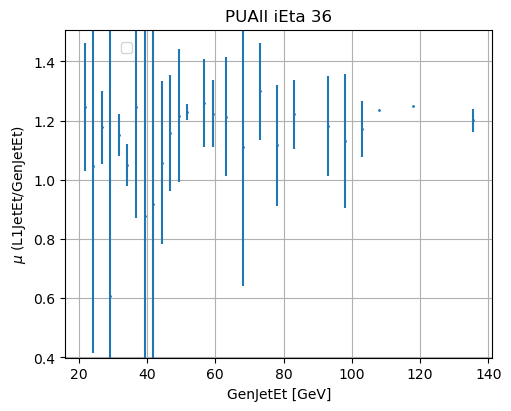

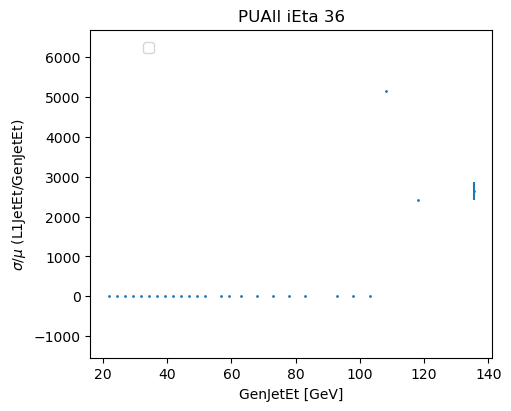

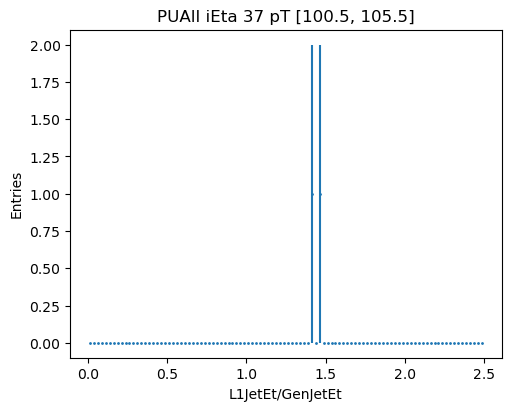

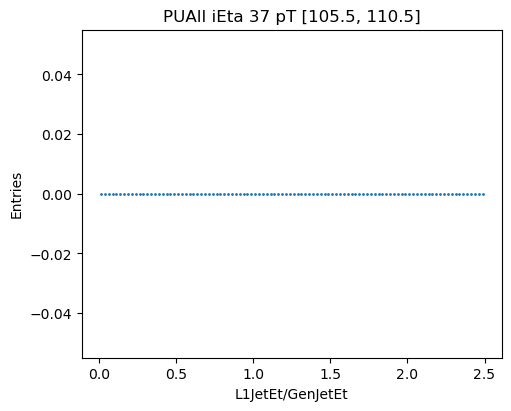

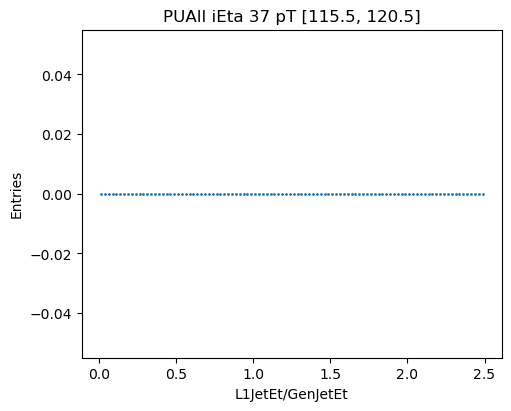

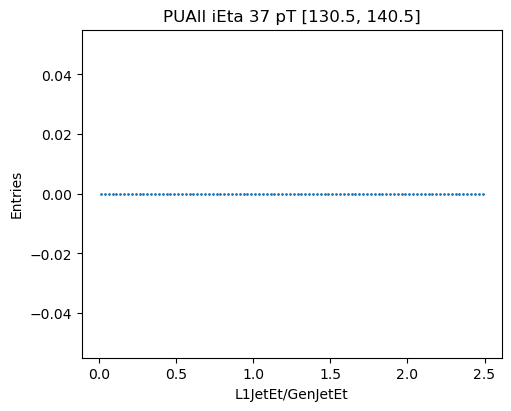

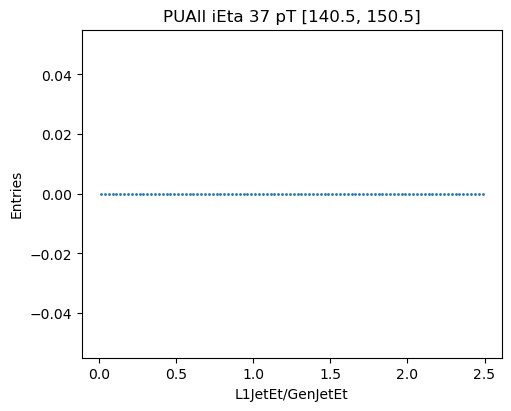

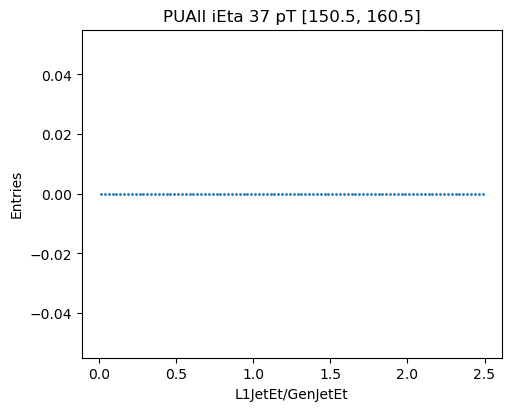

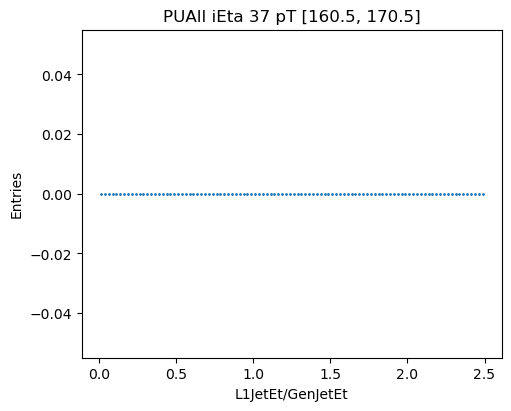

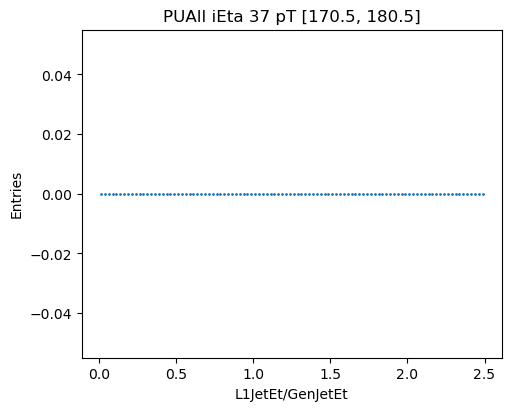

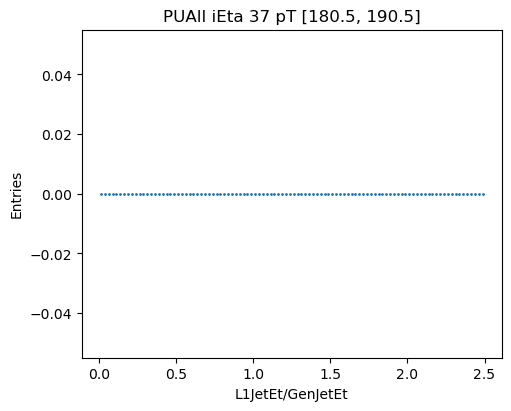

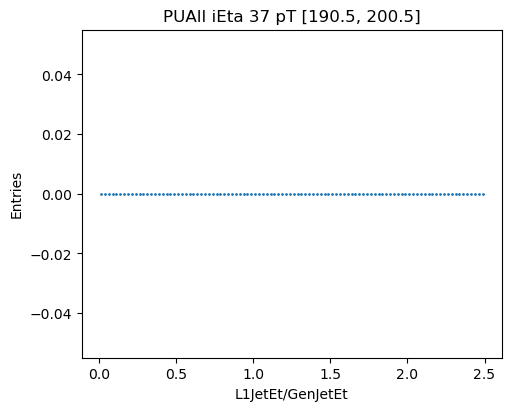

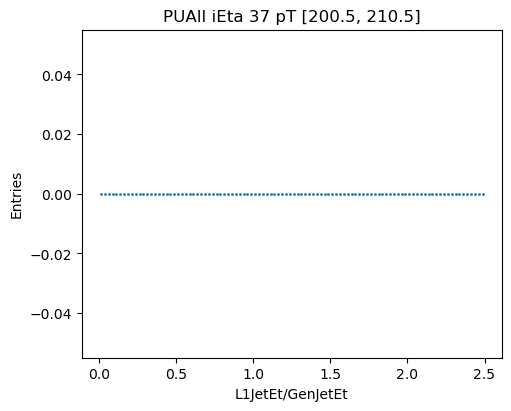

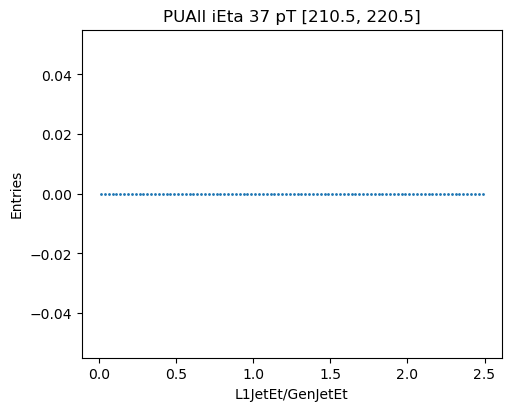

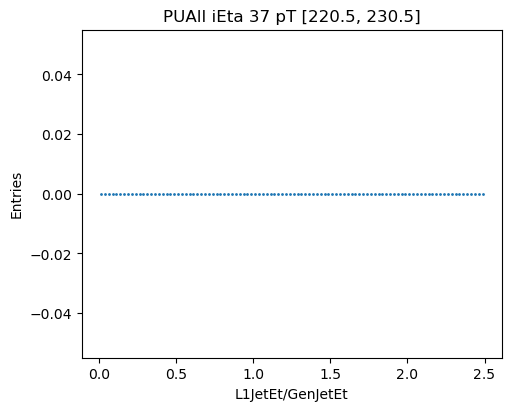

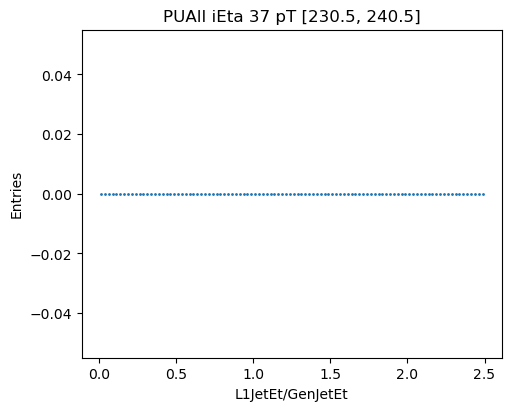

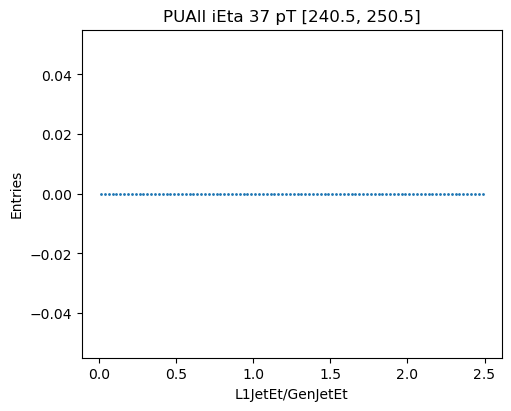

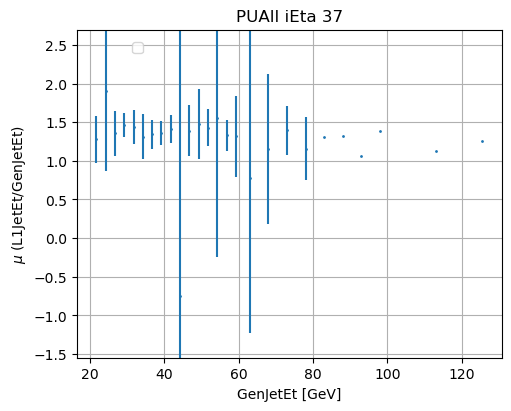

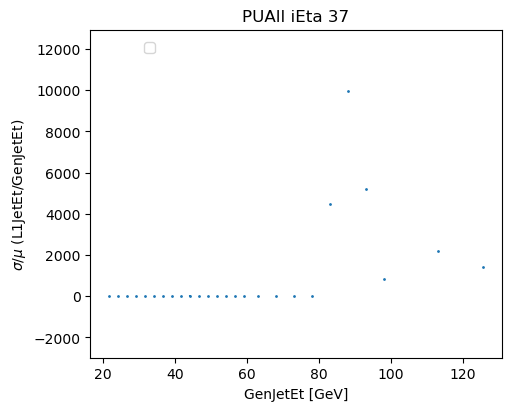

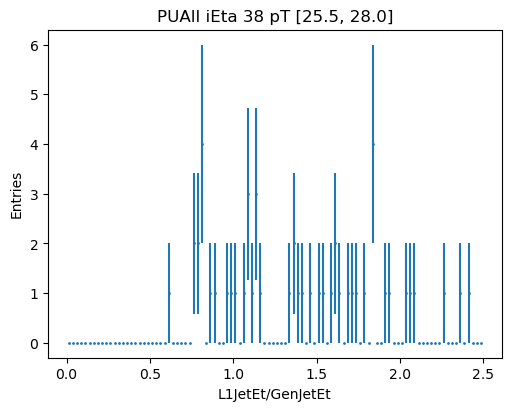

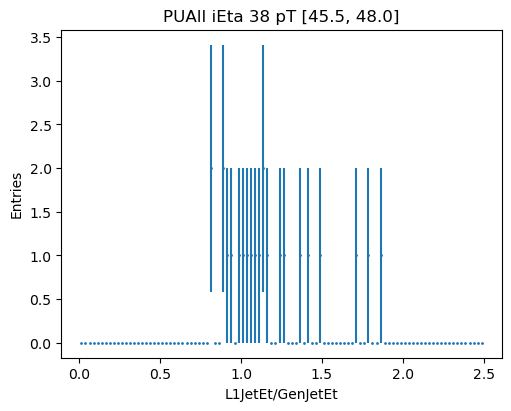

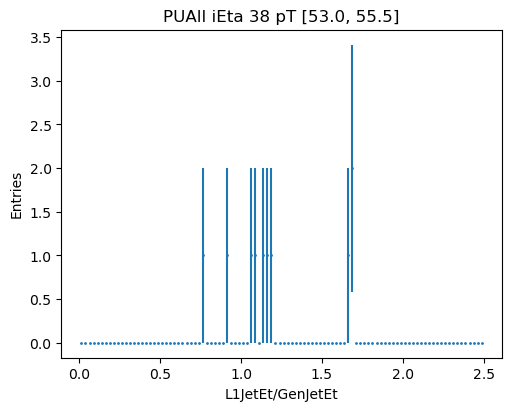

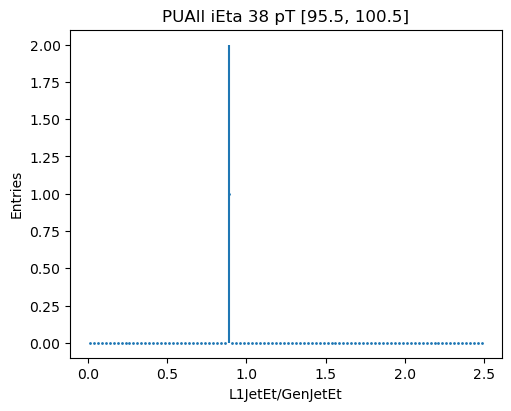

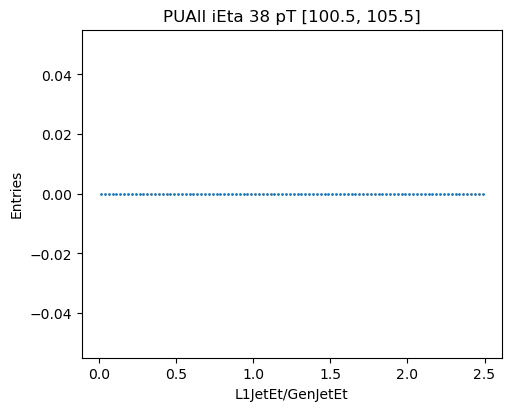

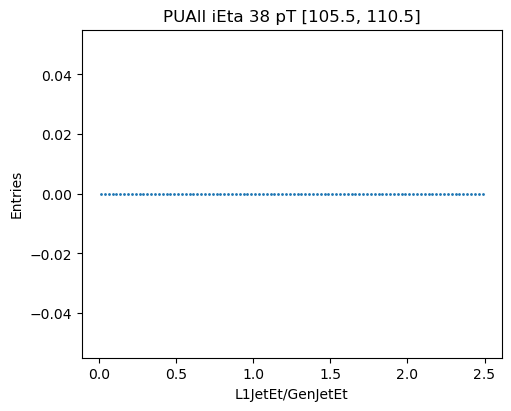

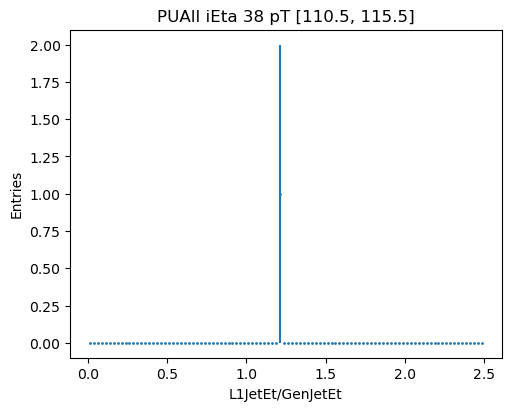

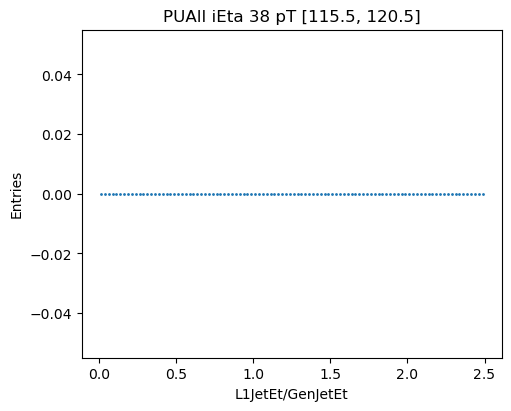

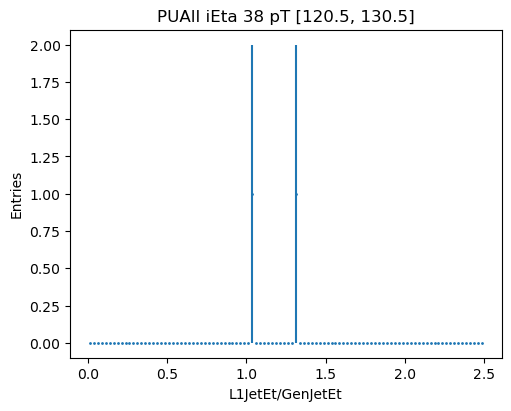

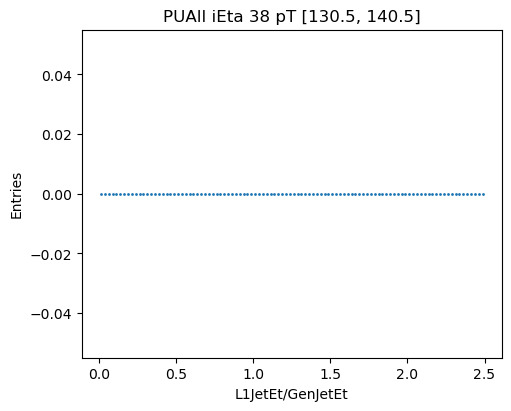

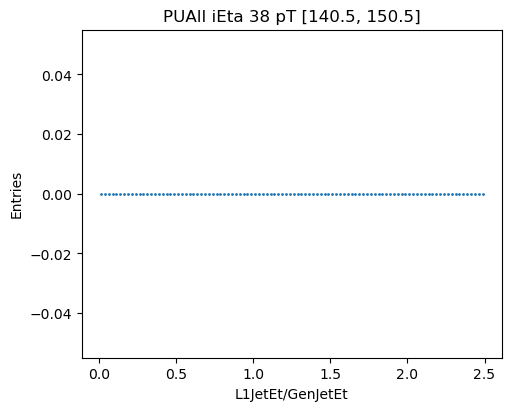

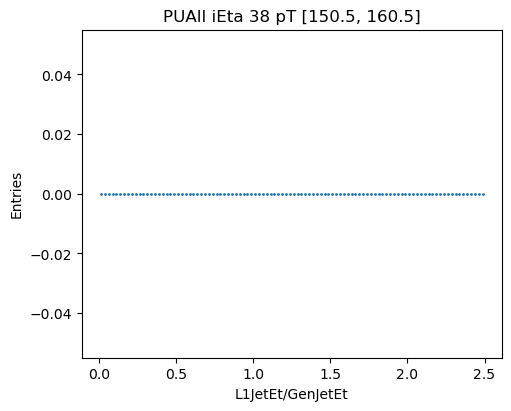

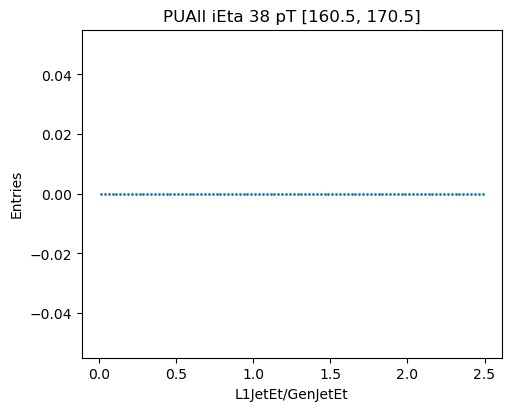

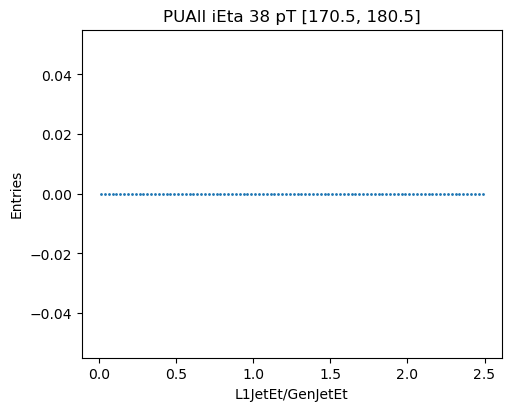

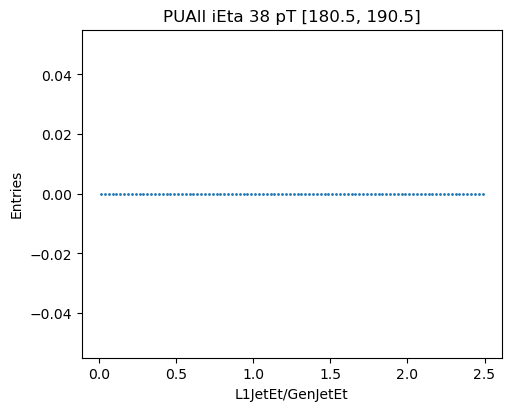

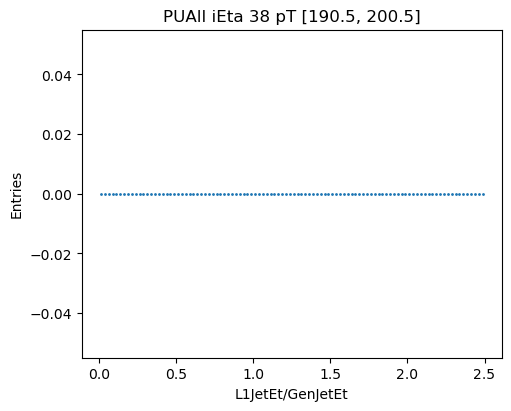

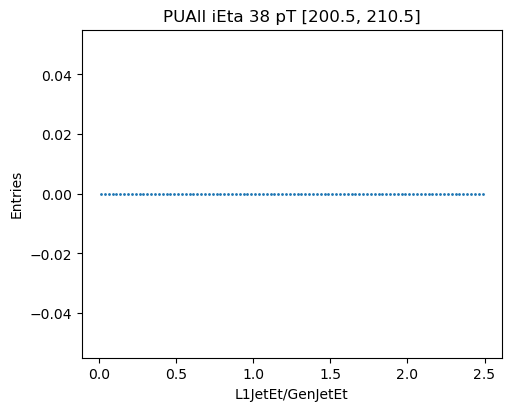

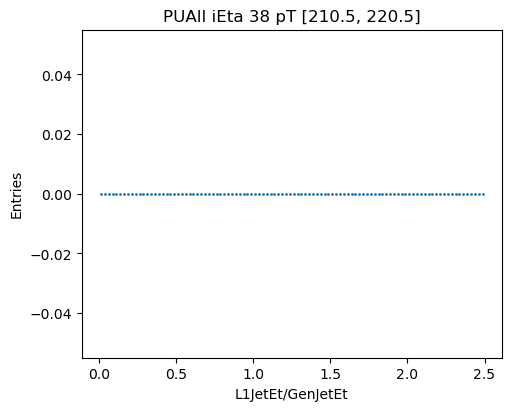

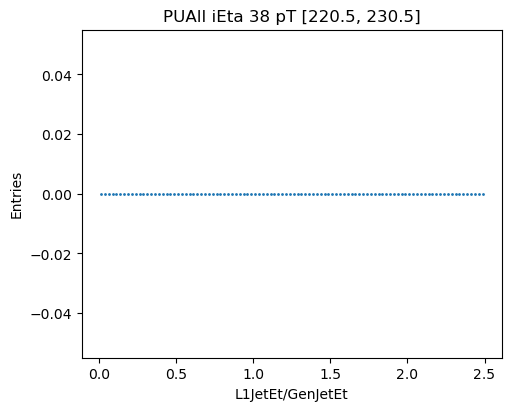

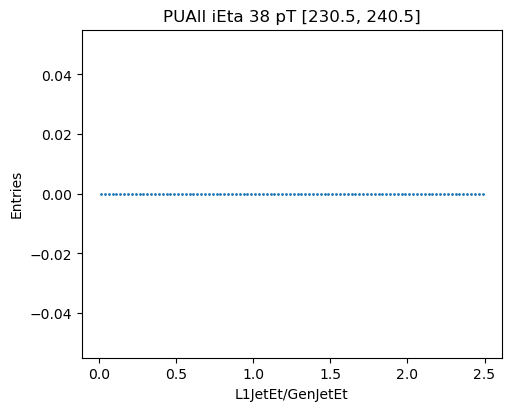

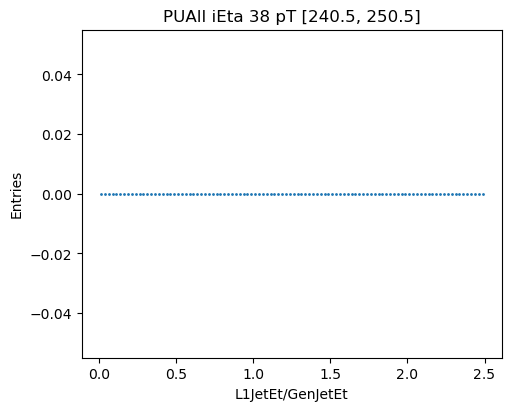

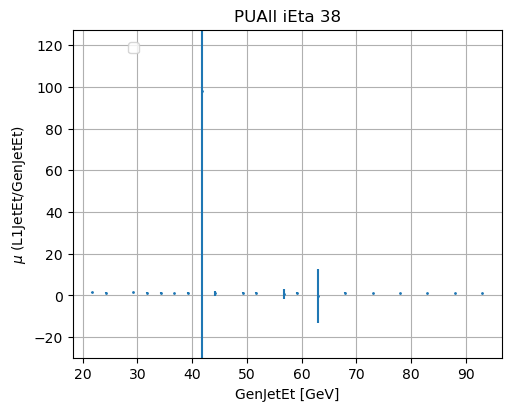

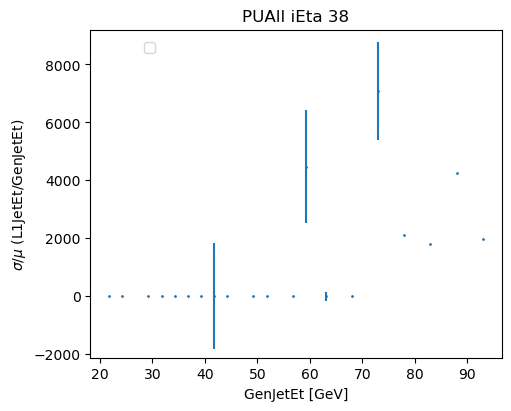

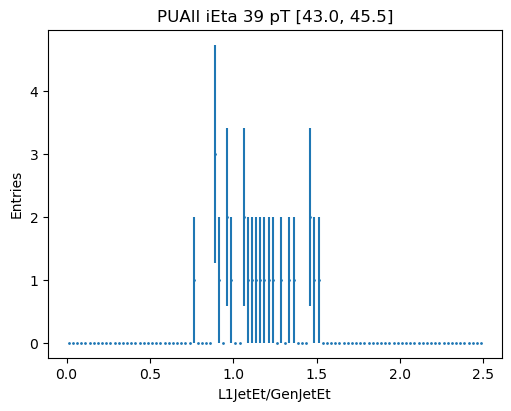

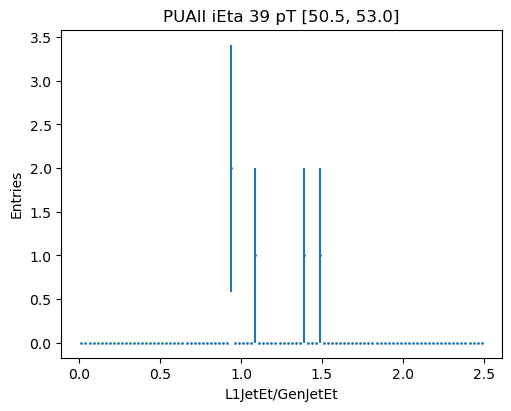

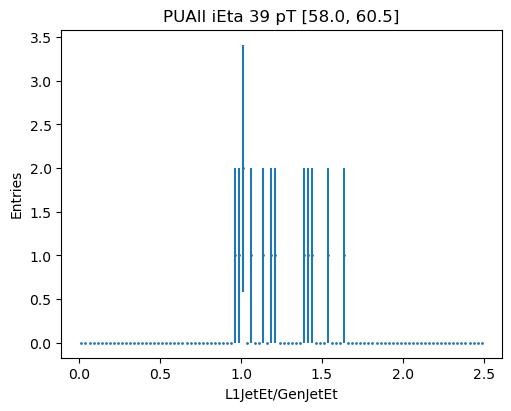

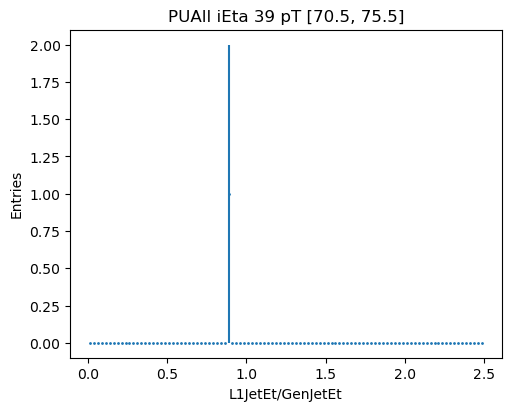

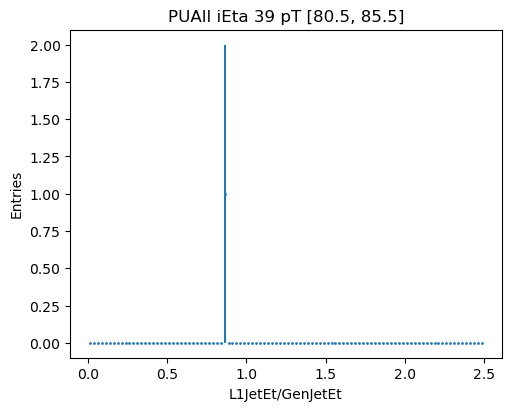

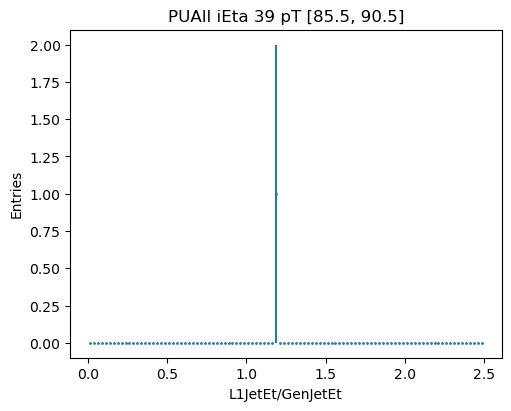

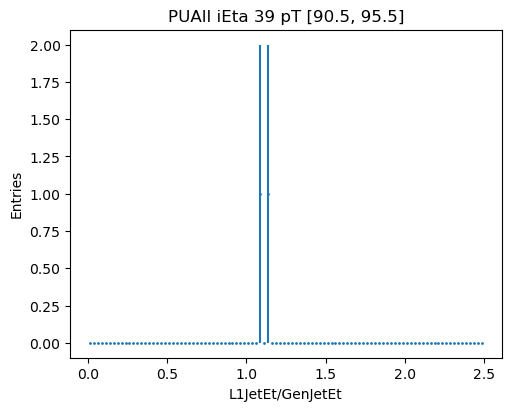

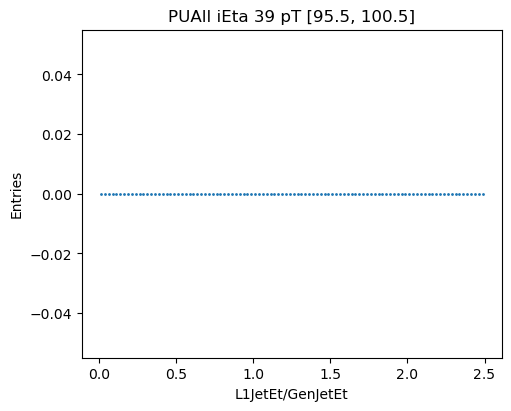

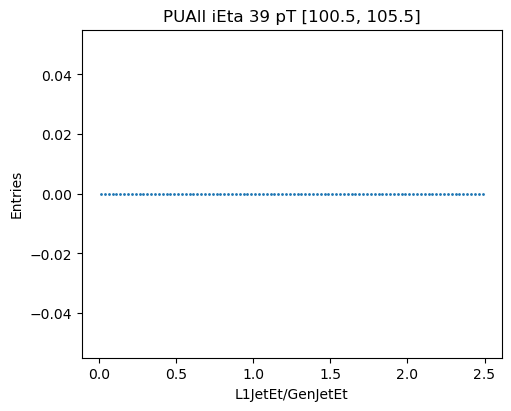

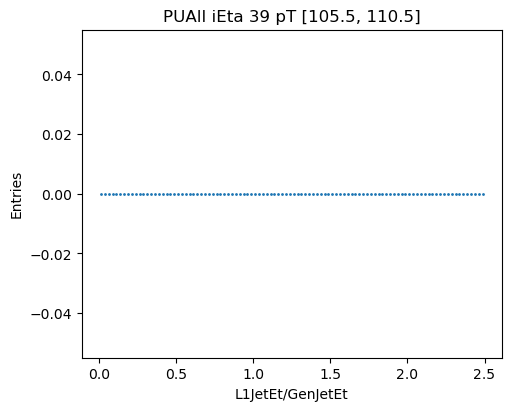

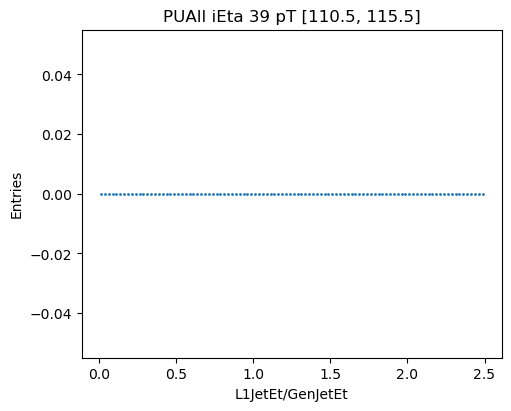

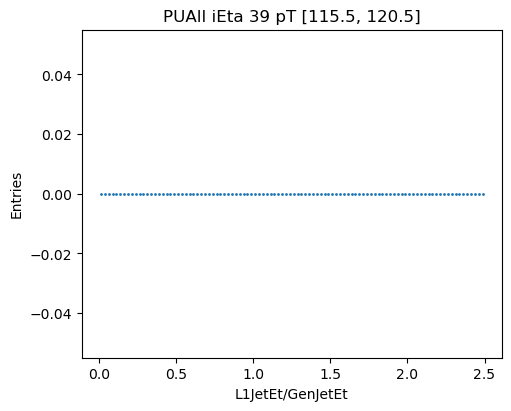

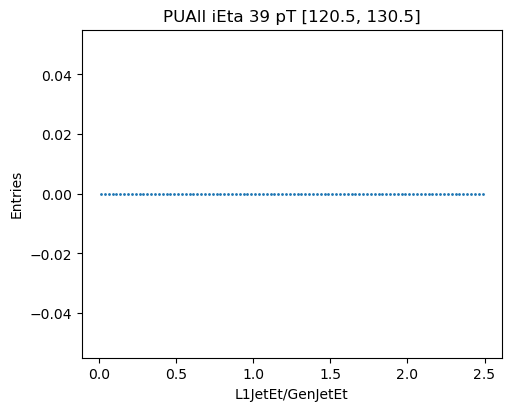

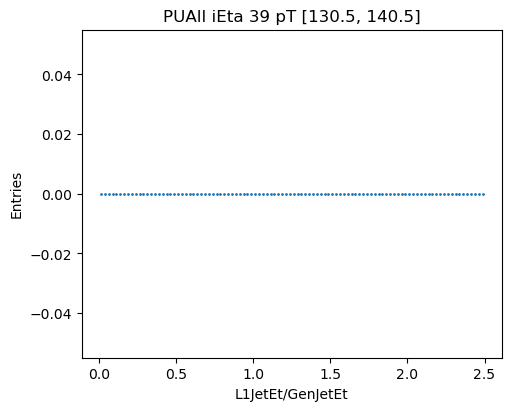

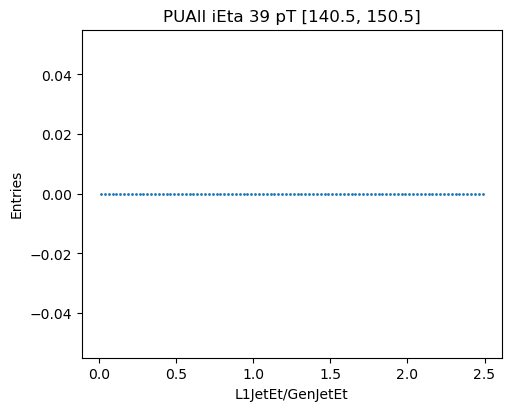

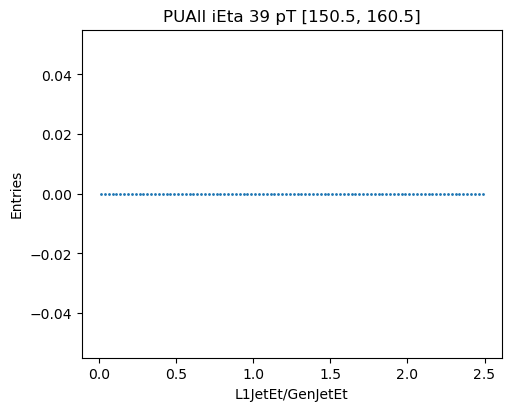

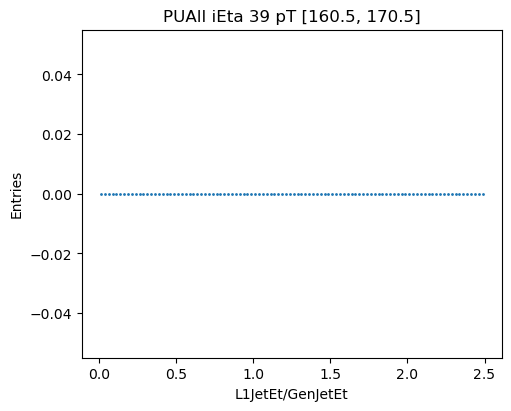

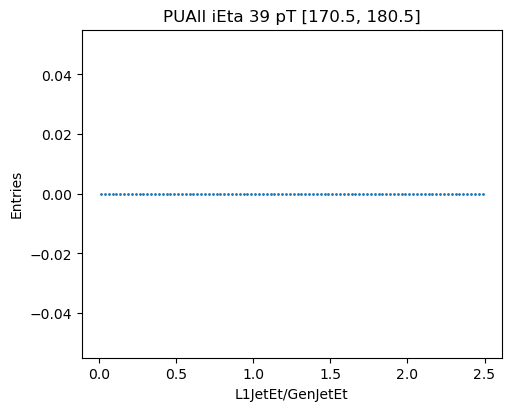

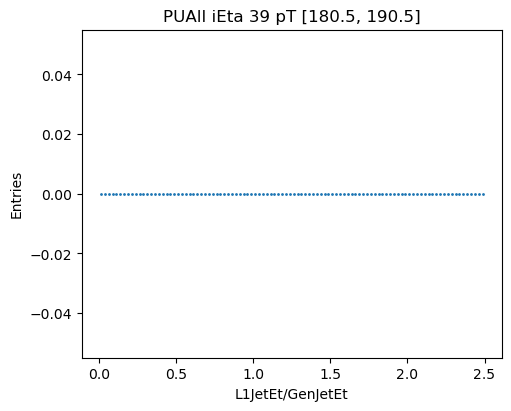

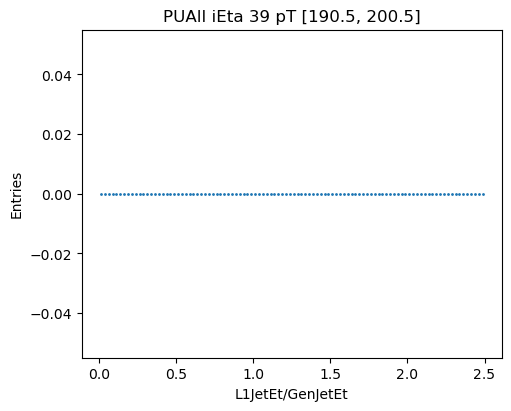

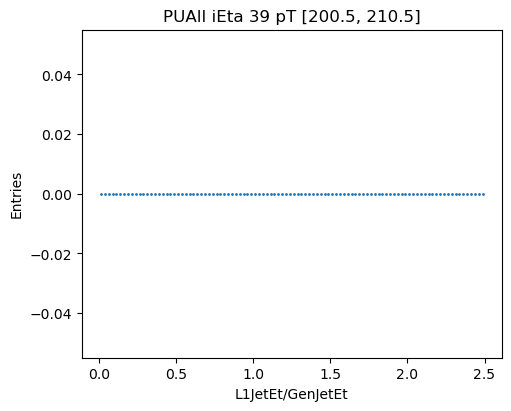

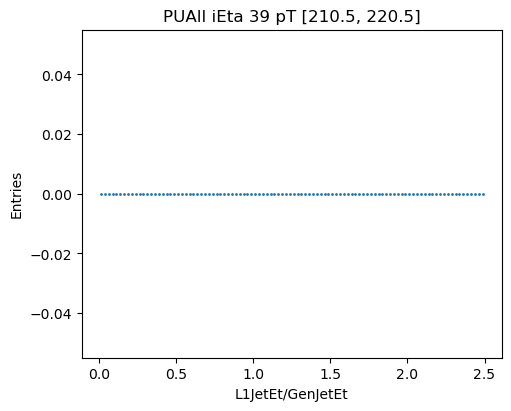

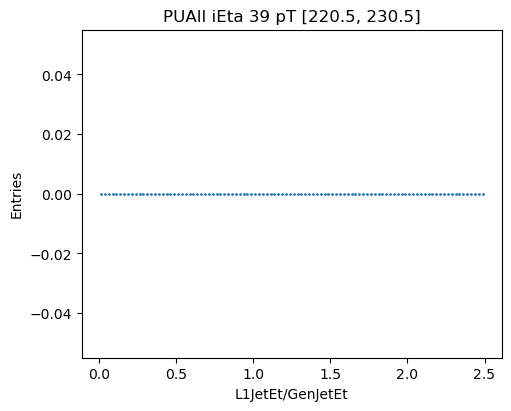

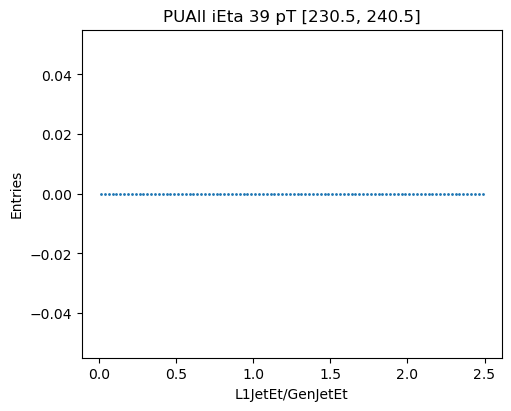

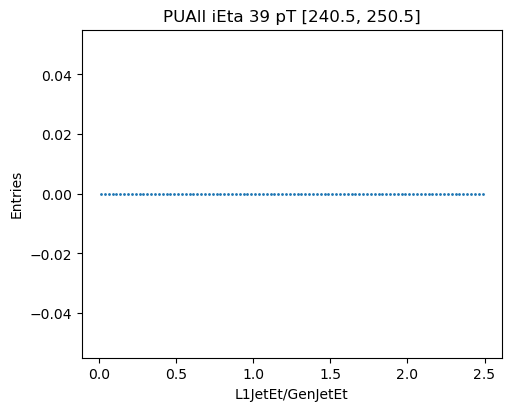

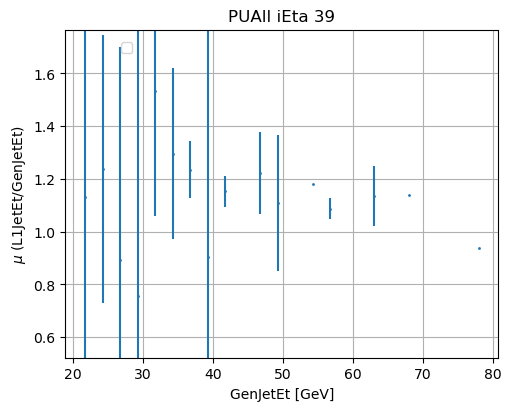

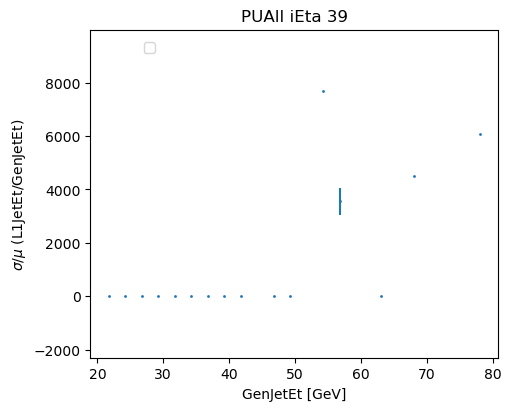

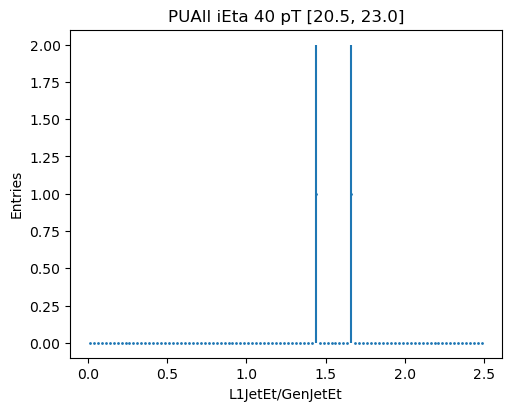

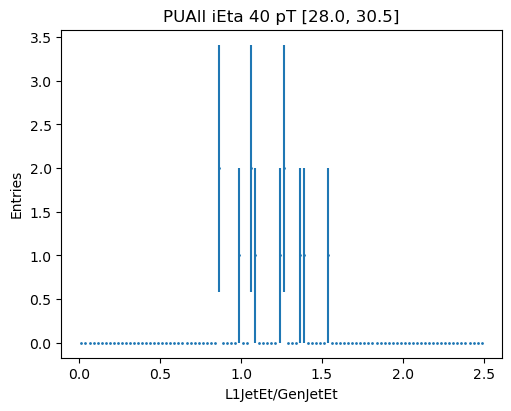

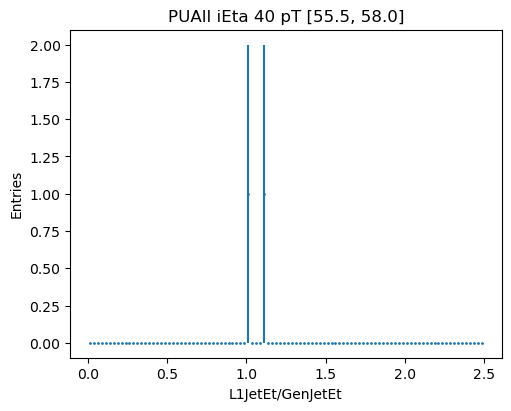

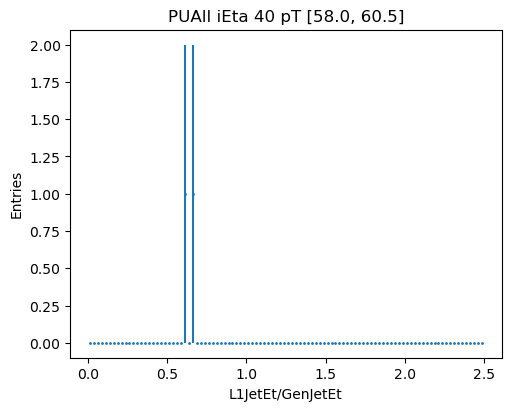

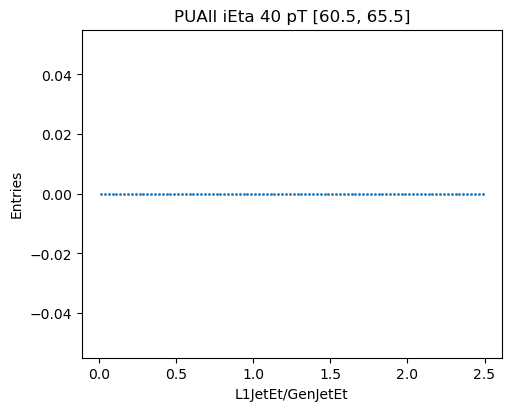

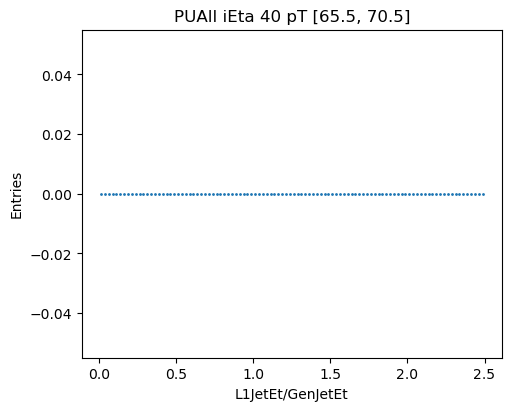

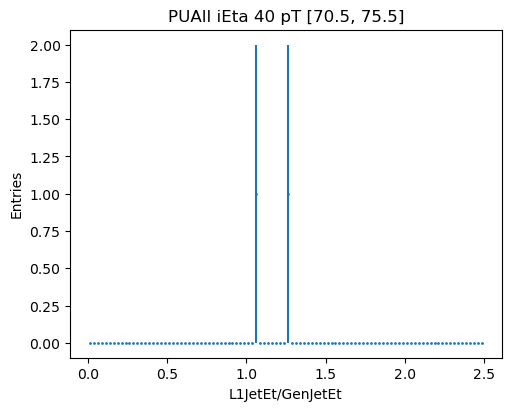

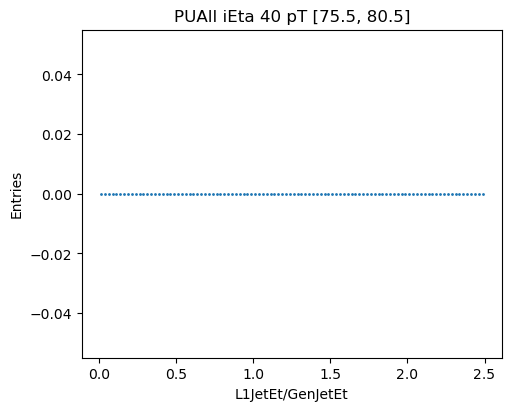

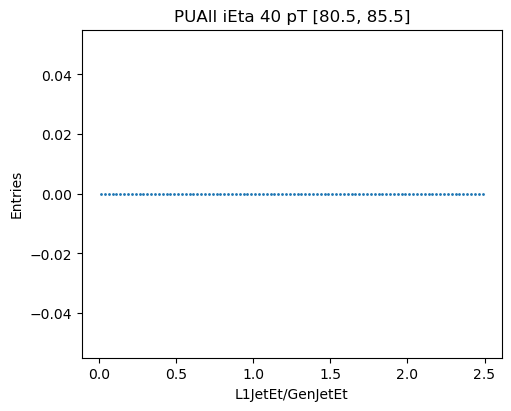

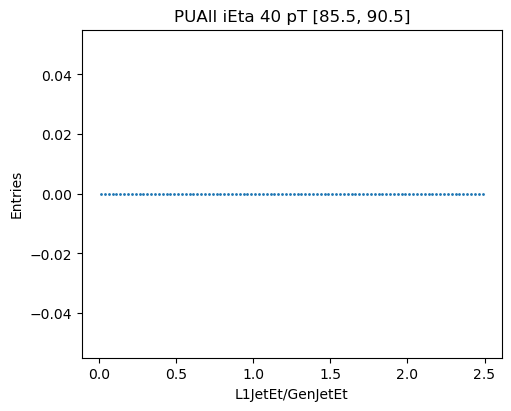

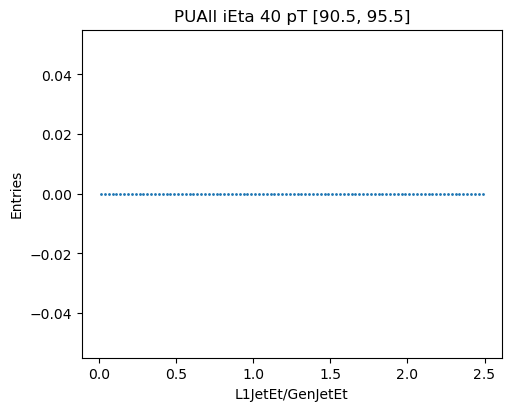

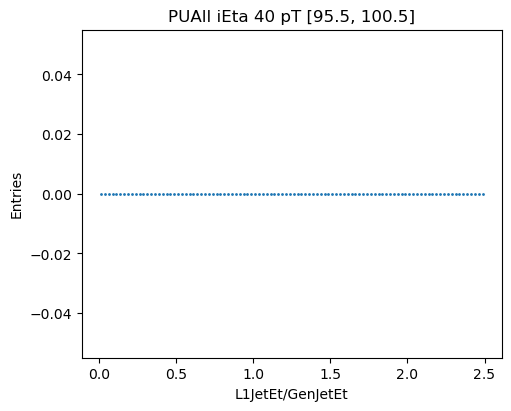

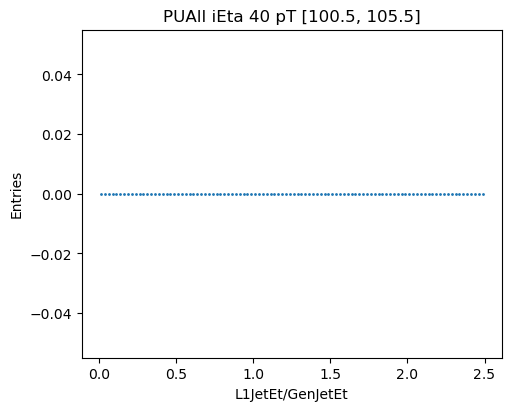

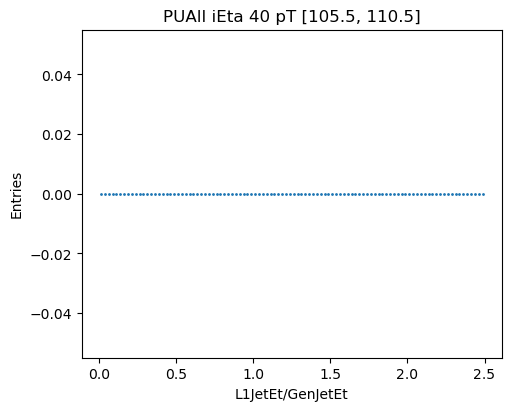

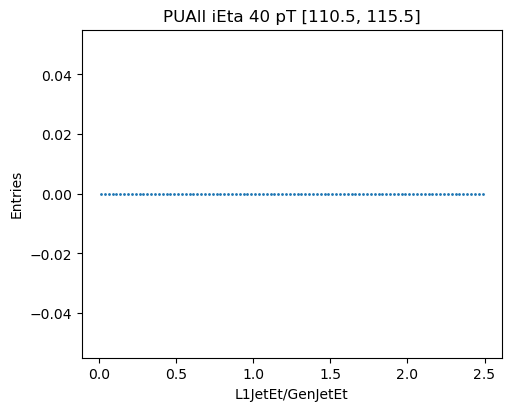

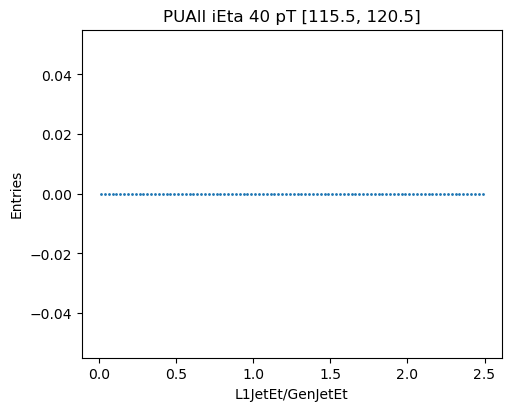

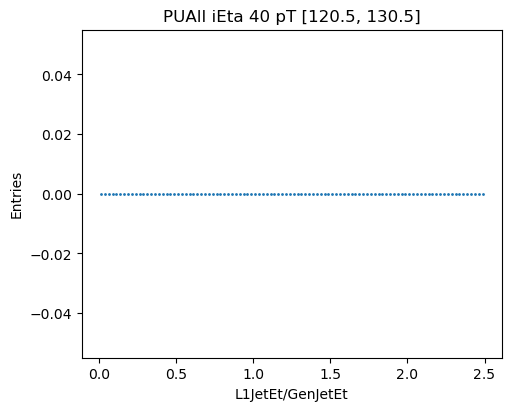

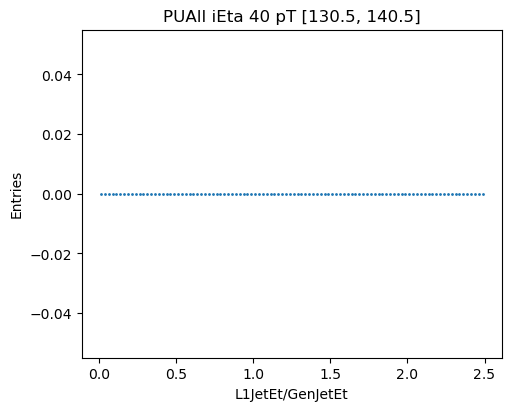

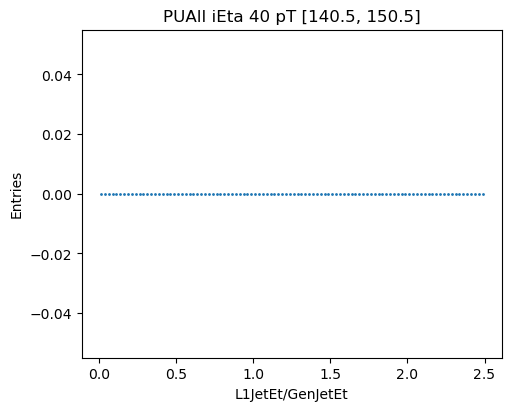

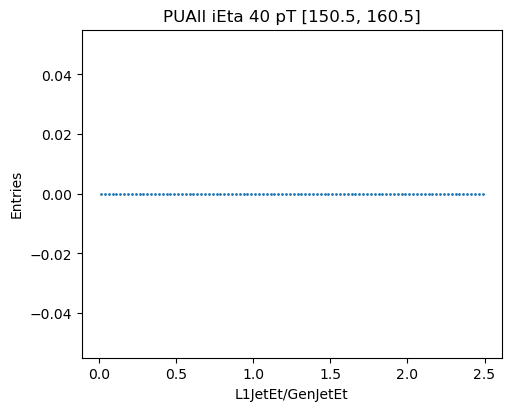

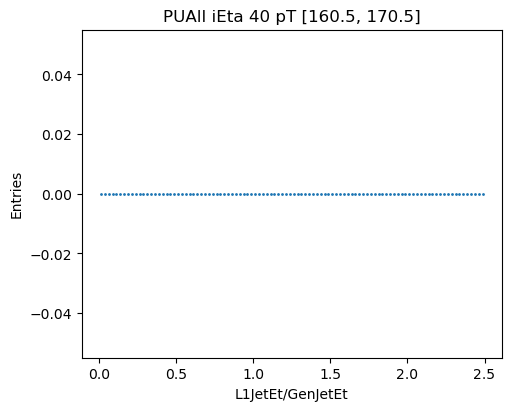

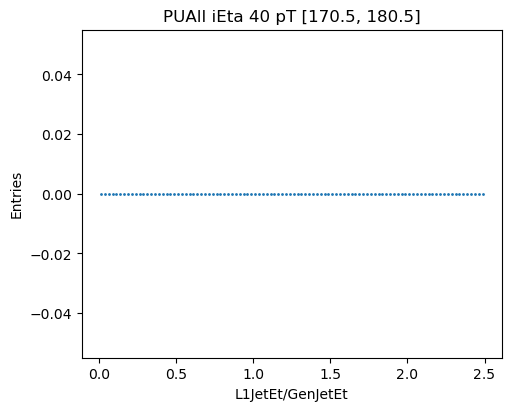

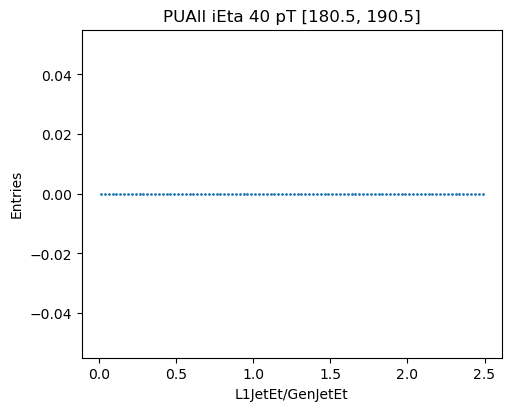

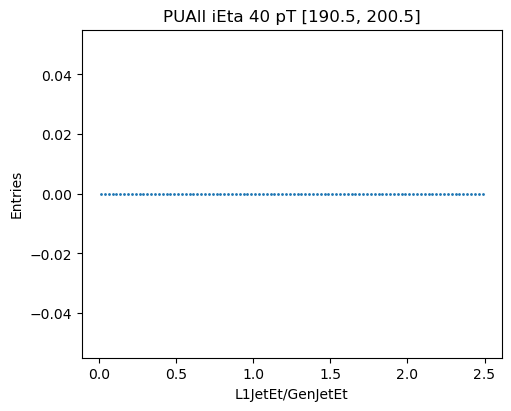

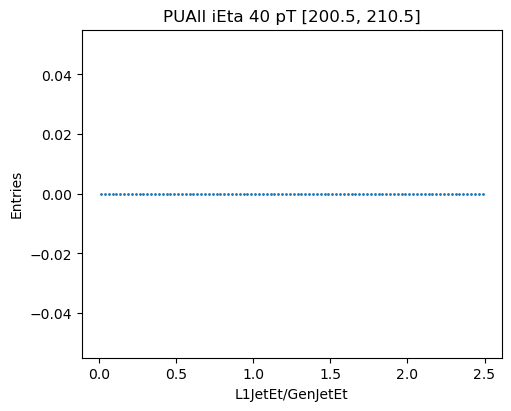

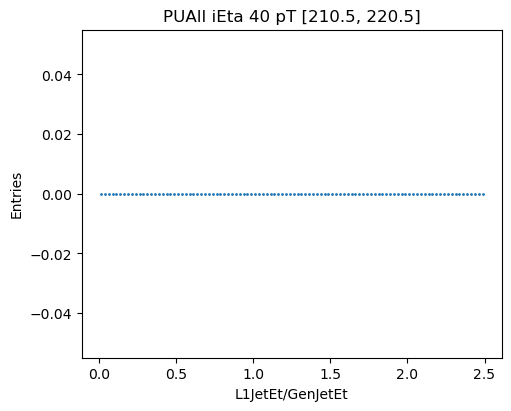

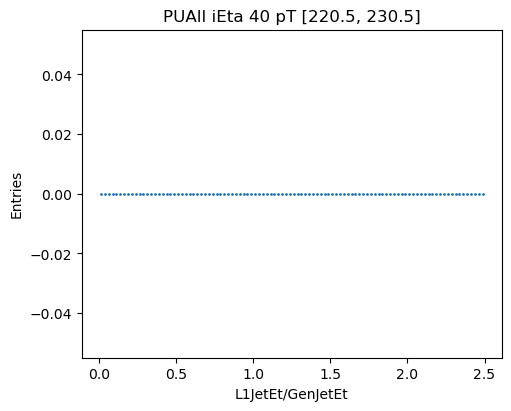

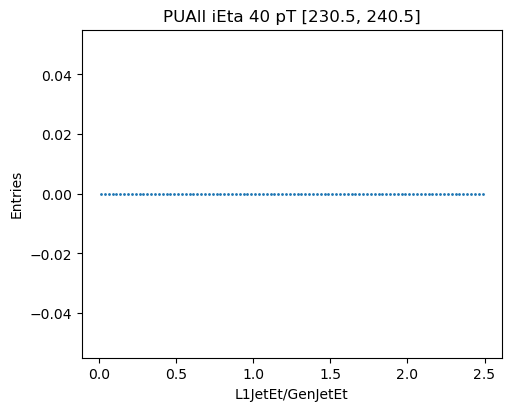

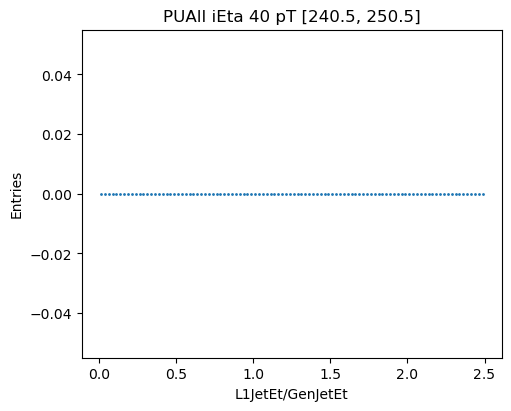

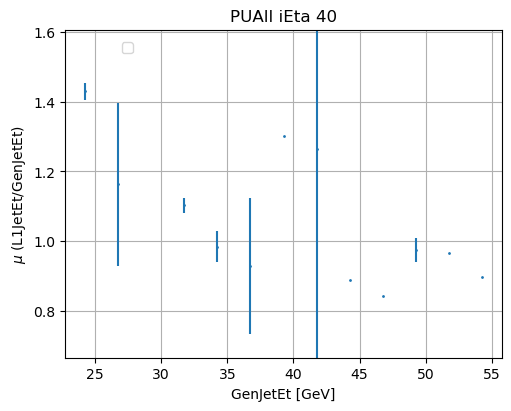

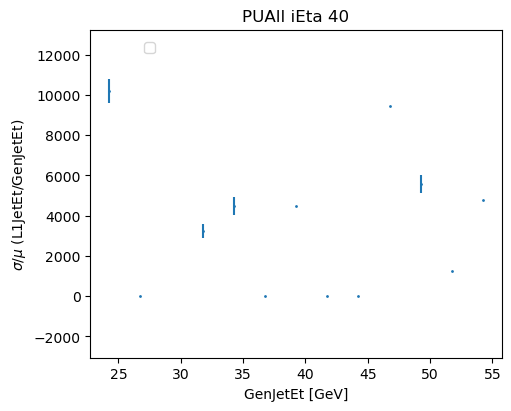

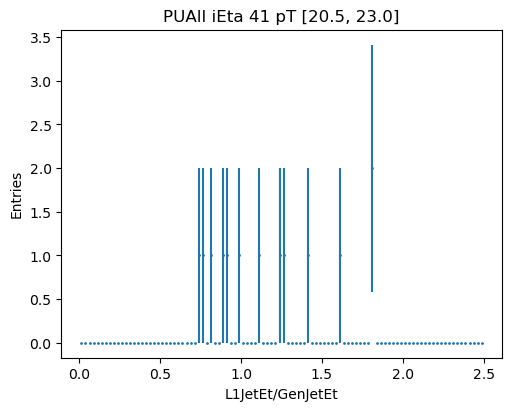

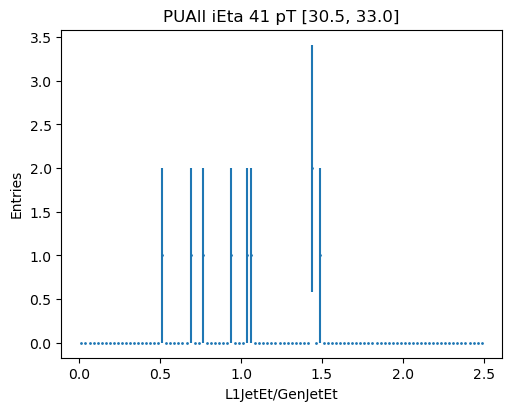

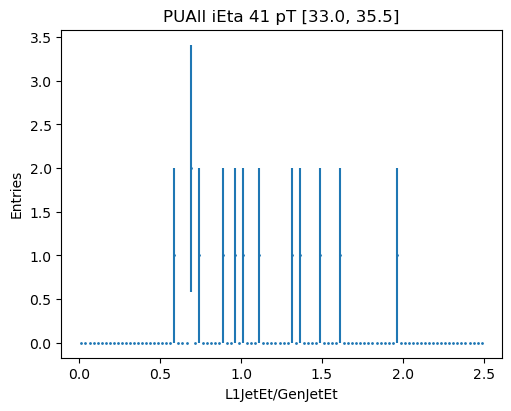

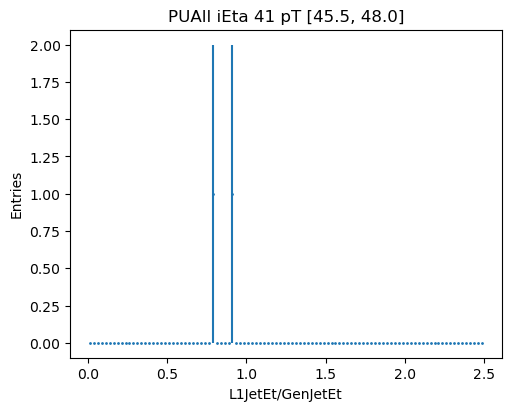

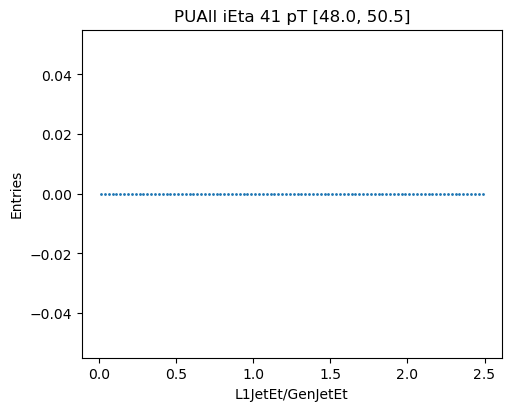

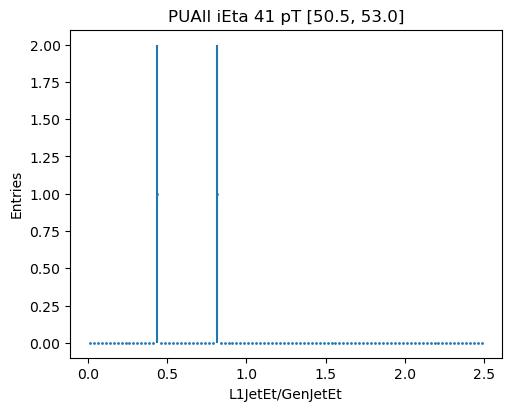

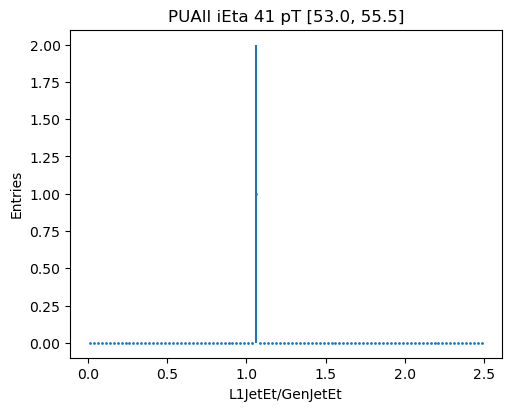

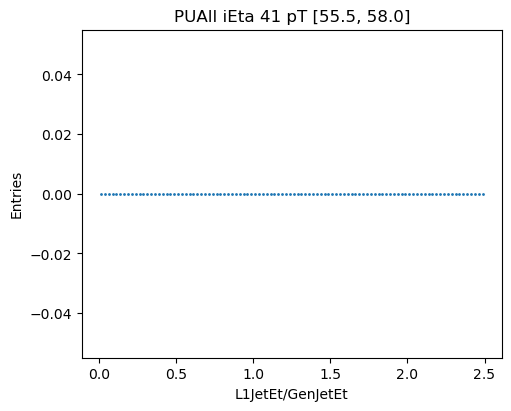

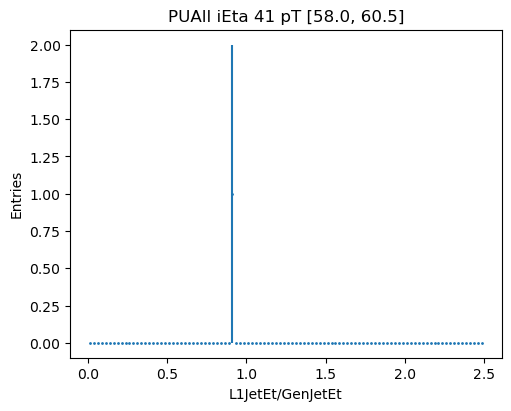

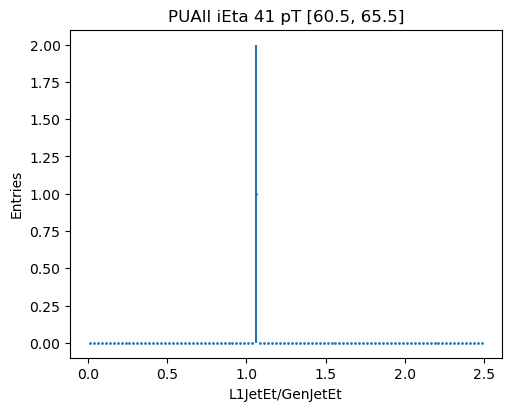

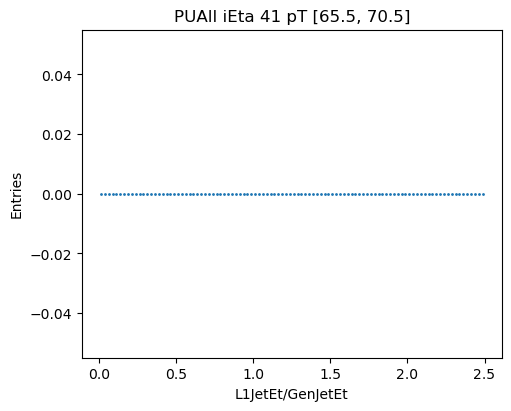

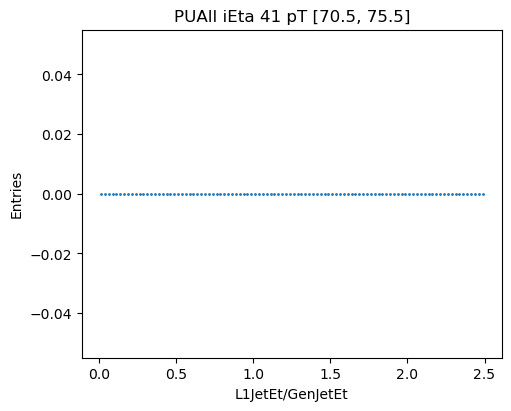

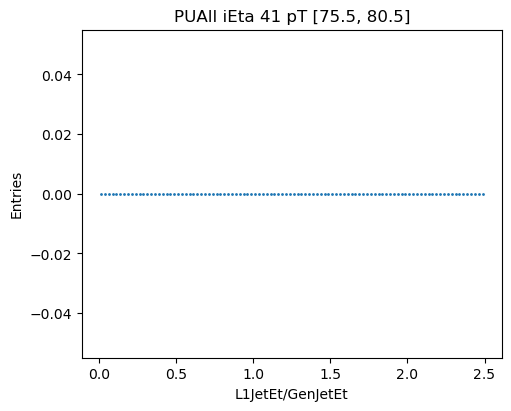

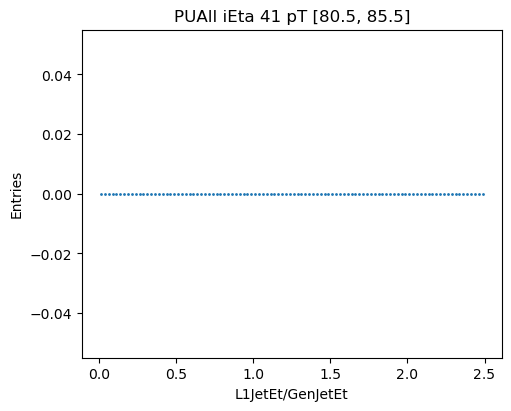

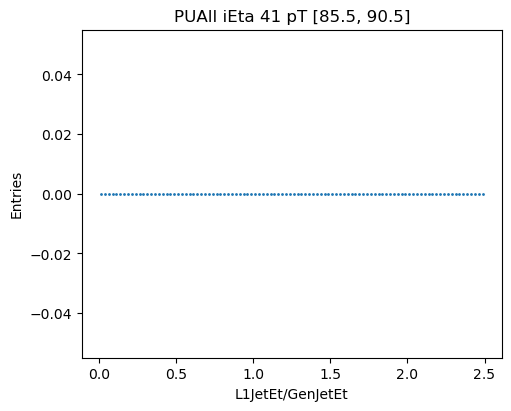

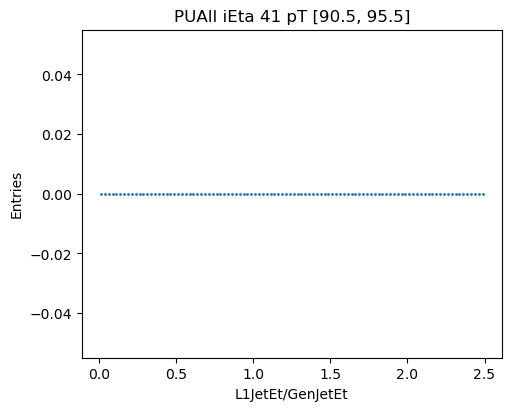

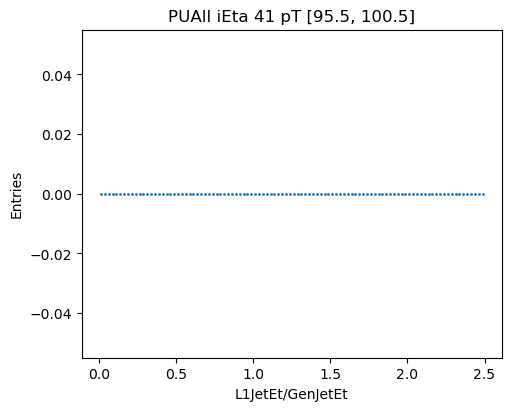

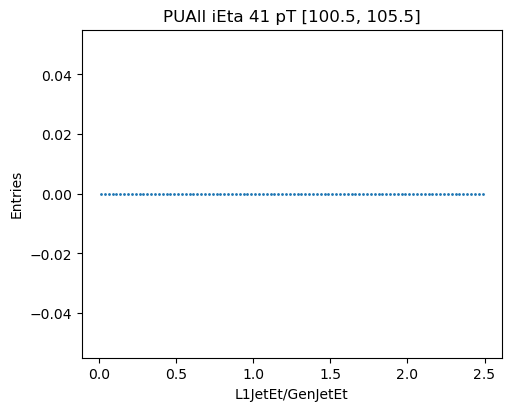

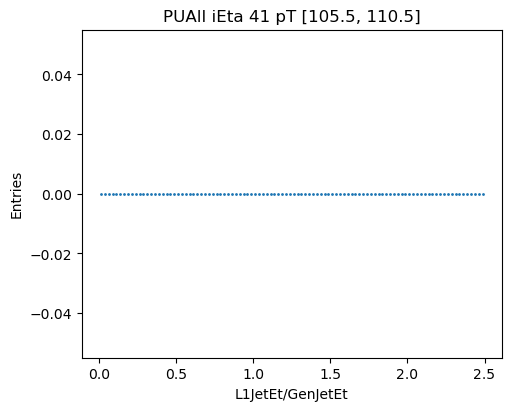

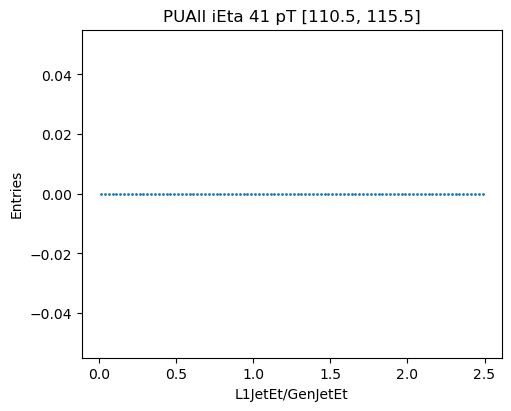

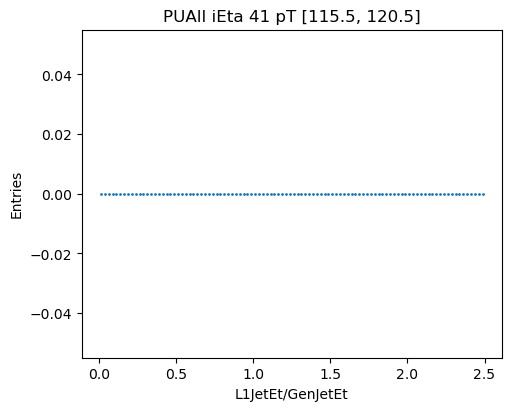

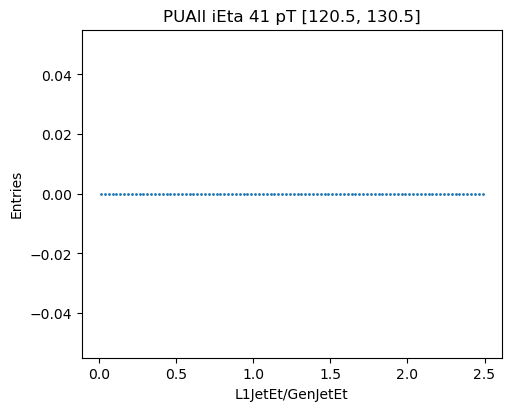

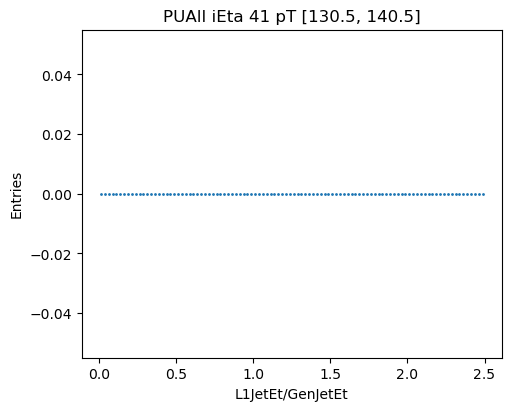

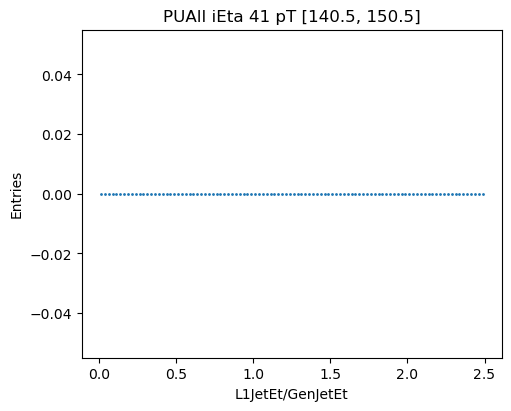

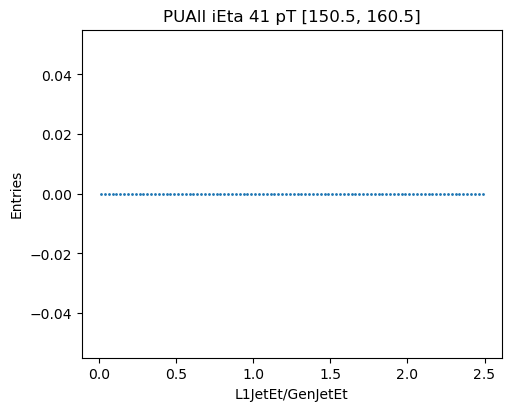

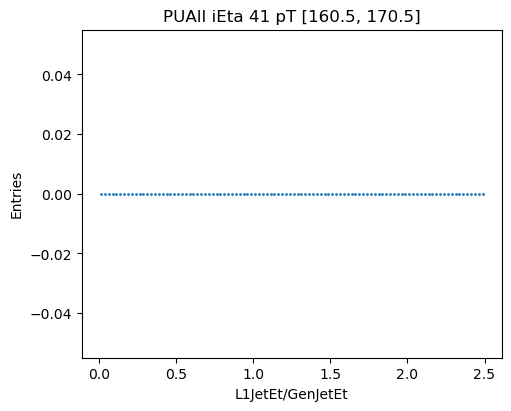

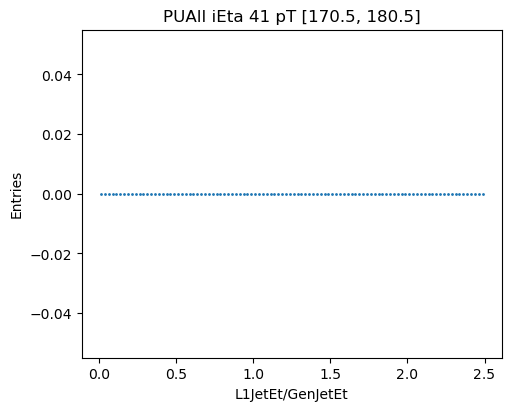

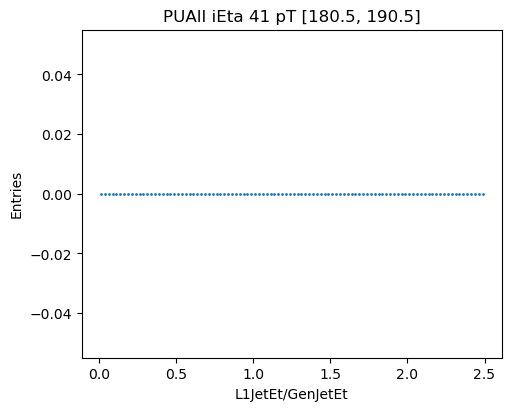

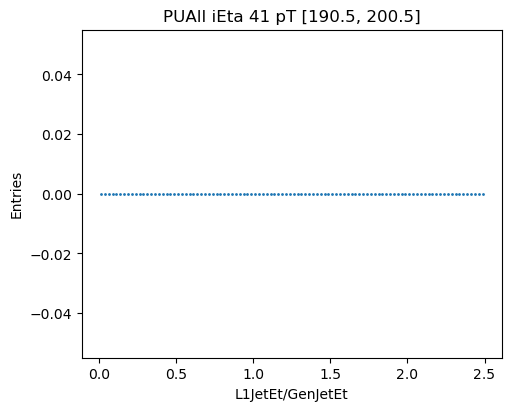

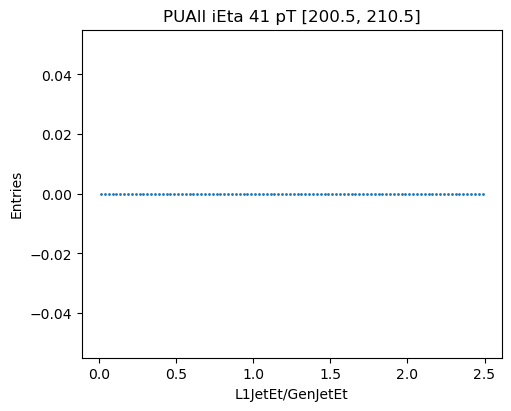

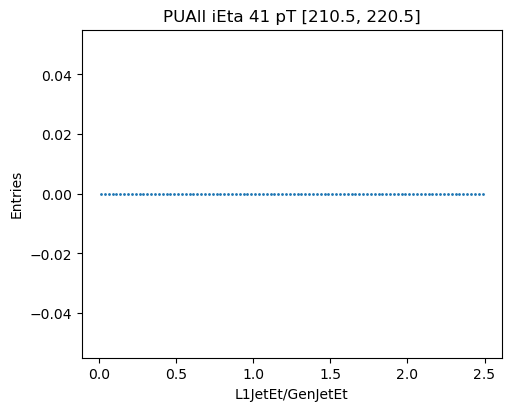

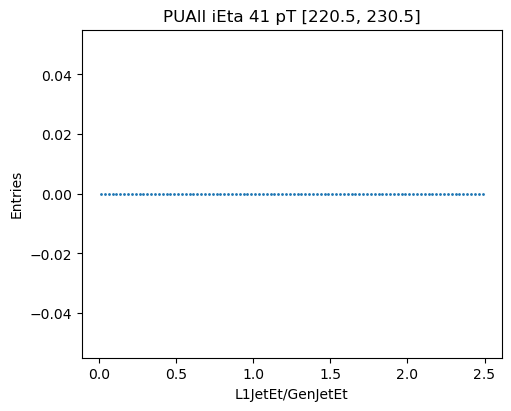

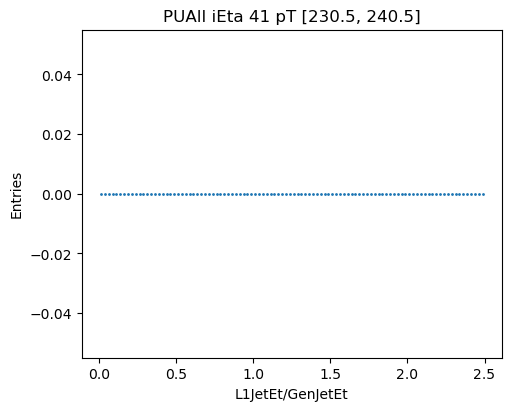

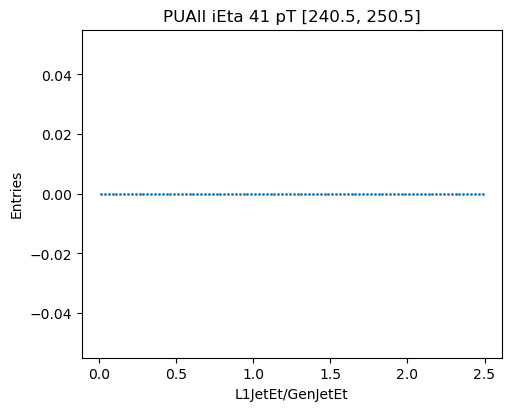

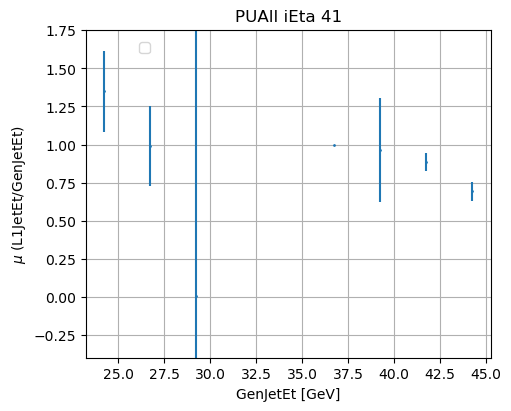

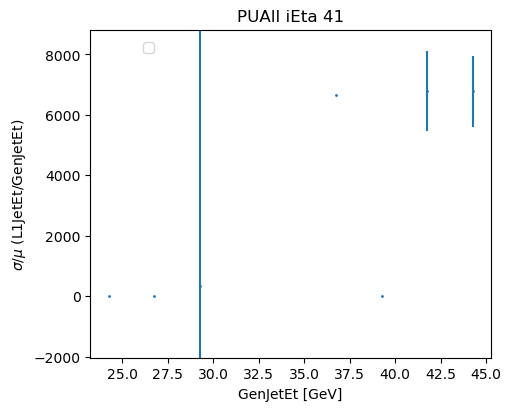

In [22]:
# L1Jet response vs RefJetPt before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat' % (sOutDirBeforeJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat/1D' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

    
RefJetPtBins_forResolutionPlots = [
    #*np.arange(  0.5,  20.5, 4),
    *np.arange( 20.5,  60.5, 2.5),
    *np.arange( 60.5, 120.5, 5),
    *np.arange(120.5, 255.5, 10),    
]
print(f"RefJetPtBins_forResolutionPlots: {RefJetPtBins_forResolutionPlots}")


for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]
    
    for iEtaBin in iEtaBins: # 1 to 41 iEtaBins
        
        JES = OD()
        JER = OD()
        for iPtBin in range(len(RefJetPtBins_forResolutionPlots) - 1):
            PtRangeMin = RefJetPtBins_forResolutionPlots[iPtBin]
            PtRangeMax = RefJetPtBins_forResolutionPlots[iPtBin + 1]
            PtMean = (PtRangeMin + PtRangeMax)/2
 
            data_toUse_ = data_all[
                (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_all[sRefJetEt]               >= PtRangeMin) &
                (data_all[sRefJetEt]               <  PtRangeMax) & 
                (data_all[snVtx]                   >= PURangeMin) &
                (data_all[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
        
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            #axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))

                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            if printLevel >= 5:
                print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }")
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            try:
                popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            except:
                print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }:  fit did not converge *** ")
                continue
                
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            #axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            #axs.set_xlabel(sL1JetResponse)
            #axs.set_ylabel('Entries')
            #axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[PtMean] = {'value': Mean_,          'error': errMean_}
            JER[PtMean] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_ieta_%d_Pt_%.1f.png' % (sOutDir1D_toUse, PU_category, iEtaBin, PtMean))
            plt.close(fig)
            
            
        # plot JES vs Pt
        JES_Ptwise    = [ JES[Pt]['value'] for Pt in JES.keys()]
        errJES_Ptwise = [ JES[Pt]['error'] for Pt in JES.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JES.keys()), JES_Ptwise, yerr=errJES_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Mean.png' % (sOutDir_toUse, PU_category, iEtaBin))  
        plt.close(fig)
        
        # plot JER vs iEta
        JER_Ptwise    = [ JER[Pt]['value'] for Pt in JER.keys()]
        errJER_Ptwise = [ JER[Pt]['error'] for Pt in JER.keys()]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JER.keys()), JER_Ptwise, yerr=errJER_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Resolution.png' % (sOutDir_toUse, PU_category, iEtaBin))
        plt.close(fig)       

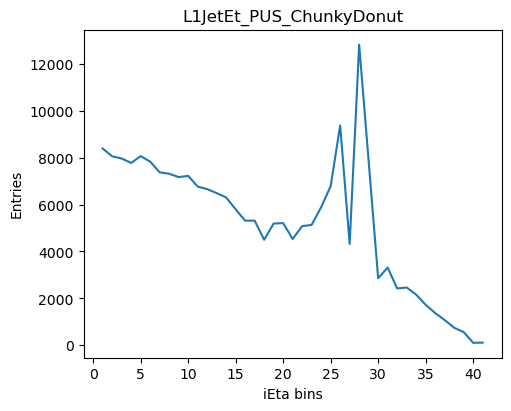

In [23]:
# nEntries per iEta bin 

sOutDir_toUse   = sOutDirBeforeJEC

nEntriesPerIEtaBin = [len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins]   
nEntriesPerIEtaBin_1 = { iEtaBin: len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins}   
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
axs.plot(iEtaBins, nEntriesPerIEtaBin)
axs.set_xlabel('iEta bins')
axs.set_ylabel('Entries')
axs.set_title('%s' % (sL1JetEt))
#axs.legend()
fig.savefig('%s/%s_nEntriesPerIEtaBin.png' % (sOutDir, sL1JetEt))
if printLevel >= 11:
    print("nEntriesPerIEtaBin: {}".format(nEntriesPerIEtaBin))
    print("nEntriesPerIEtaBin_1: {}".format(nEntriesPerIEtaBin_1))
    


In [28]:
#%%time


sL1JetEt_forML_predict = "%s_predict" % (sL1JetEt_forML)
sL1JetEt_predict       = "%s_predict" % (sL1JetEt)
sSF                    = "SF"

IEta_Cat_forML = OD()
#IEta_Cat_forML['HB'] = [ 1, 16]
#IEta_Cat_forML['HE12a'] = [17, 26]
#IEta_Cat_forML['HE2b'] = [27, 28]
#IEta_Cat_forML['HF30to32'] = [30, 32]
#IEta_Cat_forML['HF33to36'] = [33, 36]
#IEta_Cat_forML['HF37to41'] = [37, 41]
#IEta_Cat['HBEF'] = [ 1, 41]
IEta_Cat_forML['HBEF'] = [ 1, 41]

Pt_Cat_forML = OD()
#Pt_Cat_forML['Ptlt60'] = [ 0, 60]
#Pt_Cat_forML['Ptgt60'] = [60, L1JetPtMax]
#Pt_Cat_forML['Ptlt25']   = [ 0, 25]
#Pt_Cat_forML['Pt25to35'] = [25, 35]
#Pt_Cat_forML['Pt35to60'] = [35, 60]
#Pt_Cat_forML['Pt60to90'] = [60, 90]
#Pt_Cat_forML['Ptgt90']   = [90, L1JetPtMax]
Pt_Cat_forML['PtAll'] = [0, L1JetPtMax]

if printLevel >= 11:
    print("train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))
    
varsOfInterest = train_vars.copy()
varsOfInterest.extend([target_var, sL1JetEt, sRefJetEt])
if printLevel >= 0:
    print("Going for BDT training: varsOfInterest: {}\n".format(varsOfInterest))
    print("After train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))

# ML training ----------------------------------------------------------------------
def train_MLModel_wHyperopt(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
    
    hyperparameter_space = { 
        #'n_estimators': hp.choice('n_estimators', np.arange(500, 2001, 100, dtype=int)),
        'n_estimators': hp.choice('n_estimators', np.arange(700, 701, 100, dtype=int)),
        #'learning_rate':hp.quniform('learning_rate', 0.01, 0.2, 0.01),
        'learning_rate':hp.quniform('learning_rate', 0.05, 0.055, 0.01),
        'early_stopping_rounds': 10
    }    
    max_evals = 1 # 30
    
    def ML_score(params):
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False       
        )
        score = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
        if printLevel >= 3:
            print("score: valid {}, train {}. params: {}".format(
                score,
                mean_squared_error(y_train, model.predict(X_train), squared=False),
                params))
        return {'loss': score, 'status': STATUS_OK, 'ML_model': model}
            
    
    def getBestMLModel(trials):
        # https://stackoverflow.com/questions/54273199/how-to-save-the-best-hyperopt-optimized-keras-models-and-its-weights
        valid_trial_list = [trial for trial in trials  if STATUS_OK == trial['result']['status']]
        losses = [float(trial['result']['loss']) for trial in valid_trial_list]
        index_having_minimum_loss = np.argmin(losses)
        best_trial_obj = valid_trial_list[index_having_minimum_loss]
        return best_trial_obj['result']['ML_model']
        
        
        
    # ref: 
    # https://sites.google.com/view/raybellwaves/blog/using-xgboost-and-hyperopt-in-a-kaggle-comp
    # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
    trials = Trials()
    best_params = fmin(
        fn=ML_score,
        space=hyperparameter_space, 
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    print("best_params: {}".format(best_params))
    print("space_eval(hyperparameter_space, best_params): {}".format(space_eval(hyperparameter_space, best_params)))
    
    return getBestMLModel(trials)
# ----------------------------------------------------------------------------        
    
    
    
    
    
BDTModel_dict = OD([])
data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)

    BDTModel_dict[iEta_category] = OD([])
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        data_all_iEtaBins = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBinRange[0]) & 
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBinRange[-1]) &
            (data_all[sL1JetEt] >= PtRangeMin) &
            (data_all[sL1JetEt] <  PtRangeMax)
        ][varsOfInterest]
        if printLevel >= 10:
            print("\niEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))


        X = data_all_iEtaBins[train_vars]
        y = data_all_iEtaBins[target_var]

        xgb_rg = train_MLModel_wHyperopt(X, y)


        BDTModel_dict[iEta_category][Pt_category] = xgb_rg
        
        data_all_iEtaBins[sL1JetEt_forML_predict] = xgb_rg.predict(data_all_iEtaBins[train_vars])
        if   MLTarget == 'GenEt':
            data_all_iEtaBins[sL1JetEt_predict] = data_all_iEtaBins[sL1JetEt_forML_predict]
            
        elif MLTarget == 'logGenEt':
            data_all_iEtaBins[sL1JetEt_predict] = convert_logEt_to_Et( data_all_iEtaBins[sL1JetEt_forML_predict] )

        elif MLTarget == 'GenEtByL1Et':
            data_all_iEtaBins[sL1JetEt_predict] = convert_GenEtByL1Et_to_GenEt( data_all_iEtaBins[sL1JetEt_forML_predict], data_all_iEtaBins[sL1JetEt] )
            
        elif MLTarget == 'logGenEtByL1Et':
            data_all_iEtaBins[sL1JetEt_predict] = convert_logGenEtByL1Et_to_GenEt( data_all_iEtaBins[sL1JetEt_forML_predict], data_all_iEtaBins[sL1JetEt] )
                       
        if printLevel >= 0:
            print("\niEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))
            print(f"\n{data_all_iEtaBins = }")
            
            
            
            
        # save BDT model version
        #sTrain_vars_ = '_'.join()
        #sBDTModel_fileName = '../data/BDTModel_%s_vs_%s__%s_%s.pkl' % ('_'.join(train_vars), target_var, iEta_category, Pt_category)
        sBDTModel_fileName = '../data/BDTModel_%s_%s_%s.pkl' % (version, iEta_category, Pt_category)
        pickle.dump(BDTModel_dict[iEta_category][Pt_category], open(sBDTModel_fileName, "wb"))    


Going for BDT training: varsOfInterest: ['L1JetTowerIEtaAbs', 'logL1JetEt_PUS_ChunkyDonut', 'nVertexReco', 'logGenJetEt', 'L1JetEt_PUS_ChunkyDonut', 'GenJetEt']

After train_vars: ['L1JetTowerIEtaAbs', 'logL1JetEt_PUS_ChunkyDonut', 'nVertexReco'], 
target_var: logGenJetEt, 
sL1JetEt_forML_predict: logL1JetEt_PUS_ChunkyDonut_predict, 
sL1JetEt_predict: L1JetEt_PUS_ChunkyDonut_predict, 
sSF: SF
score: valid 0.2523767937113935, train 0.2475704422387146. params: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'n_estimators': 700}                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.15s/trial, best loss: 0.2523767937113935]
best_params: {'learning_rate': 0.05, 'n_estimators': 0}
sp

In [29]:
def prepareDataframeForSFs(iEtaBinRange, PtRangeMin=L1JetPtThrsh, PtRangeMax=L1JetPtMax, nVtx=48):
    dict_iEta_Et = OD([ (sL1JetTowerIEtaAbs, []), (sL1JetEt, []) ])
    if snVtx in train_vars:
        dict_iEta_Et[snVtx] = []
        
    for iEta in iEtaBinRange:
        list_pt      = np.arange(PtRangeMin, PtRangeMax+1.0)
        list_ietabin = [iEta] * len(list_pt)
        dict_iEta_Et[sL1JetTowerIEtaAbs].extend(list_ietabin) 
        dict_iEta_Et[sL1JetEt].extend(list_pt) 
        if snVtx in train_vars:
            list_nVtx = [nVtx] * len(list_pt)
            dict_iEta_Et[snVtx].extend(list_nVtx) 
            
          
    data_SFs = pd.DataFrame(dict_iEta_Et)
    
    if   MLTarget == 'GenEt':
        data_SFs[sL1JetEt_forML] = data_SFs[sL1JetEt]

    elif MLTarget == 'logGenEt':    
        data_SFs[sL1JetEt_forML] = convert_Et_to_logEt( data_SFs[sL1JetEt] )

    elif MLTarget == 'GenEtByL1Et':    
        data_SFs[sL1JetEt_forML] = data_SFs[sL1JetEt]

    elif MLTarget == 'logGenEtByL1Et':    
        data_SFs[sL1JetEt_forML] = convert_Et_to_logEt( data_SFs[sL1JetEt] )
            
    return data_SFs

In [30]:
# Change nVertex to evaluate SF here ----------------
nVtx_forSF = PUForSFComputation
# ---------------------------------------------------

data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)
    
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]

        xgb_rg = BDTModel_dict[iEta_category][Pt_category]
        
        if snVtx in train_vars:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax, nVtx=nVtx_forSF)
        else:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax)
            
        data_SFs_i[sL1JetEt_forML_predict] = xgb_rg.predict(data_SFs_i[train_vars])        
        
        if   MLTarget == 'GenEt':
            data_SFs_i[sL1JetEt_predict] = data_SFs_i[sL1JetEt_forML_predict]
            
        elif MLTarget == 'logGenEt':
            data_SFs_i[sL1JetEt_predict] = convert_logEt_to_Et( data_SFs_i[sL1JetEt_forML_predict] )

        elif MLTarget == 'GenEtByL1Et':
            data_SFs_i[sL1JetEt_predict] = convert_GenEtByL1Et_to_GenEt( data_SFs_i[sL1JetEt_forML_predict], data_SFs_i[sL1JetEt] )
            
        elif MLTarget == 'logGenEtByL1Et':
            data_SFs_i[sL1JetEt_predict] = convert_logGenEtByL1Et_to_GenEt( data_SFs_i[sL1JetEt_forML_predict], data_SFs_i[sL1JetEt] )
        
        data_SFs_i[sSF]                    = data_SFs_i[sL1JetEt_predict] / data_SFs_i[sL1JetEt]
        if printLevel >= 11:
            print("iEtaBins_i: {}".format(iEtaBins_i))
            print("data_SFs_i: {}".format(data_SFs_i.describe()))

        if data_SFs is None:
            data_SFs = data_SFs_i
        else:
            data_SFs = pd.concat([data_SFs, data_SFs_i])    

    
if snVtx in train_vars:
    sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_forPU%d.csv' %(nVtx_forSF))
    
#print("Hello1")    
#print("\n\ndata_SFs: \n{}".format(data_SFs.to_string()))
data_SFs.to_csv(sOpFileName_SFs, index=False)
print("Wrote {}".format(sOpFileName_SFs))                

Wrote ../data/L1T_Jet_SFs_2023_QCDPT-15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter23Digi-FlatPU0to80_126X_mcRun3_2023_forPU65_v1-v1_13_1_0_pre2_HBZS0p5_20230330_v0_L1JetEt_PUS_ChunkyDonut_forPU48.csv


/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
dataVars_forL1JetResponsePlots = [sL1JetTowerIEtaAbs, sL1JetEt, sGenJetEt]
if snVtx in train_vars: 
    dataVars_forL1JetResponsePlots.append(snVtx)

data_copy1     = data_all[dataVars_forL1JetResponsePlots].copy()
data_SFs_copy1 = data_SFs[[sL1JetTowerIEtaAbs, sL1JetEt, sSF]].copy()
data_SFs_copy1 = data_SFs_copy1.set_index([sL1JetTowerIEtaAbs, sL1JetEt])
SFs_dict       = data_SFs_copy1.to_dict()[sSF]

def calibrateJet(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    return Et_0 * sf

data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
#data_copy1[sL1JetEt_calib] = np.vectorize(calibrateJet)(data_copy1[sL1JetEt], data_copy1[sL1JetTowerIEtaAbs])
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

In [37]:
# SF vs Et plots ----

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/SF_vs_Et' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_SFs_iEtaBin = data_SFs[
            (data_SFs[sL1JetTowerIEtaAbs] == iEtaBin) & 
            (data_SFs[sL1JetEt] >=  calibSF_L1JetPtRange[0])
        ].copy()
        axs.plot(
            data_SFs_iEtaBin[sL1JetEt],
            data_SFs_iEtaBin[sSF],
            label='iEta %d' % (iEtaBin)
        )
    axs.set_xlabel('L1JetEt [GeV]')
    axs.set_ylabel('Scale factor')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
        
    fig.savefig('%s/SF_vs_Et_%s_ieta_%d_to_%d.png' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
    plt.close(fig)

In [38]:
# L1Jet response per iEta bin range after JEC

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEta' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s: after JEC' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d.png' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
    plt.close(fig)

In [39]:
# L1Jet response per iEta bin range per Pt cat after JEC

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEta_perPtCat' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.png' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))   
    plt.close(fig)

In [48]:
# L1JetResponse vs Eta after JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat' % (sOutDirAfterJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    


Pt_Cat_forResolutionPlots = OD()
#Pt_Cat_forResolutionPlots['Pt25to35'] = [25, 35]
Pt_Cat_forResolutionPlots['PtAll'] = [0, L1JetPtMax]

PU_Cat_forResolutionPlots = OD()
PU_Cat_forResolutionPlots['PUAll'] = [0, 99]

sL1JetEt_forResolutionPlots = sL1JetEt_calib
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)

for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]

    for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        JES = OD()
        JER = OD()
        for iEtaBin in iEtaBins:
            data_toUse_ = data_copy1[
                (data_copy1[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_copy1[sRefJetEt]               >= PtRangeMin) &
                (data_copy1[sRefJetEt]               <  PtRangeMax) & 
                (data_copy1[snVtx]                   >= PURangeMin) &
                (data_copy1[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
            print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")
            
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            try:
                popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            except:
                print(f"{PU_category = }, {Pt_category = }, {iEtaBin = }, {pInitial = }:  fit did not converge *** ")
                continue
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))            
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
            JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.png' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
            plt.close(fig)
            
                        
            
                    
            
        # plot JES vs iEta
        JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
        errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]
        
        yMin_ = np.min(np.array(JES_iEtawise) - np.array(errJES_iEtawise))
        yMax_ = np.max(np.array(JES_iEtawise) + np.array(errJES_iEtawise))
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JES_iEtawise)
        axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        if yMin_ < 0.5 or yMax_ > 1.3:
            axs.set_ylim(0.5, 1.3)
        else:
            axs.set_ylim(yMin_, yMax_)
        #axs.axhline(y=1, linestyle='--')
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.png' % (sOutDir_toUse, PU_category, Pt_category))
        plt.close(fig)
        
        
        # plot JER vs iEta
        JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
        errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]
        
        yMin_ = np.min(np.array(JER_iEtawise) - np.array(errJER_iEtawise))
        yMax_ = np.max(np.array(JER_iEtawise) + np.array(errJER_iEtawise))
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        #axs.plot(list(JES.keys()), JER_iEtawise)
        axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
        axs.set_xlabel('iEta')
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s %s' % (PU_category, Pt_category))
        if yMin_ < 0. or yMax_ > 1.:
            axs.set_ylim(0., 1.)
        else:
            axs.set_ylim(yMin_, yMax_)                
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.png' % (sOutDir_toUse, PU_category, Pt_category)) 
        plt.close(fig)

/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 1
popt: [3.45756833e+02 9.95973839e-01 1.83768398e-01], 
pcov: 
[[ 1.34275309e+02 -3.34738552e-04 -2.84900159e-02]
 [-3.34738552e-04  2.29693686e-05  1.45391007e-07]
 [-2.84900159e-02  1.45391007e-07  1.52136000e-05]],  
poptErr = array([1.15877223e+01, 4.79263692e-03, 3.90046151e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 2
popt: [3.23304950e+02 9.98489755e-01 1.86512652e-01], 
pcov: 
[[ 1.09786736e+02 -1.11046264e-03 -2.51629807e-02]
 [-1.11046264e-03  2.22204825e-05  6.08728584e-07]
 [-2.51629807e-02  6.08728584e-07  1.45846832e-05]],  
poptErr = array([1.04779166e+01, 4.71386068e-03, 3.81898982e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 3
popt: [3.18573259e+02 9.95119864e-01 1.85767317e-01], 
pcov: 
[[ 1.12698193e+02 -1.31970693e-03 -2.58323225e-02]
 [-1.31970693e-03  2.33930428e-05  7.54495494e-07]
 [-2.58323225e-02  7.54495494e-07  1.51011512e-05]],  
poptErr = array([1.06159405e+01, 4.83663548e-03, 3.88601998e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 4
popt: [3.21595724e+02 9.91732327e-01 1.81750831e-01], 
pcov: 
[[ 1.30746592e+02 -1.26787228e-03 -2.93485411e-02]
 [-1.26787228e-03  2.53318714e-05  6.95708372e-07]
 [-2.93485411e-02  6.95708372e-07  1.66371010e-05]],  
poptErr = array([1.14344476e+01, 5.03307773e-03, 4.07886026e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 5
popt: [3.23614294e+02 9.89721617e-01 1.88956688e-01], 
pcov: 
[[ 1.02439321e+02 -2.46258128e-03 -2.31967372e-02]
 [-2.46258128e-03  2.16349592e-05  1.42167401e-06]
 [-2.31967372e-02  1.42167401e-06  1.35843499e-05]],  
poptErr = array([1.01212312e+01, 4.65133950e-03, 3.68569531e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 6
popt: [3.13121712e+02 9.89533998e-01 1.85914899e-01], 
pcov: 
[[ 1.18096184e+02 -1.98794812e-03 -2.78290926e-02]
 [-1.98794812e-03  2.52913323e-05  1.16626458e-06]
 [-2.78290926e-02  1.16626458e-06  1.65622619e-05]],  
poptErr = array([1.08672068e+01, 5.02904885e-03, 4.06967589e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 7
popt: [2.95104479e+02 9.93280814e-01 1.86164135e-01], 
pcov: 
[[ 9.58809318e+01 -7.94538527e-04 -2.39500255e-02]
 [-7.94538527e-04  2.33189226e-05  4.50125303e-07]
 [-2.39500255e-02  4.50125303e-07  1.52097153e-05]],  
poptErr = array([9.79188091e+00, 4.82896703e-03, 3.89996350e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 8
popt: [2.94750331e+02 9.93856243e-01 1.86614939e-01], 
pcov: 
[[ 1.09619120e+02 -1.92354811e-03 -2.76178949e-02]
 [-1.92354811e-03  2.65980535e-05  1.20985124e-06]
 [-2.76178949e-02  1.20985124e-06  1.75086310e-05]],  
poptErr = array([1.04699150e+01, 5.15733008e-03, 4.18433161e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 9
popt: [2.97335973e+02 9.91385571e-01 1.80664939e-01], 
pcov: 
[[ 1.02668569e+02 -1.53028239e-03 -2.44311997e-02]
 [-1.53028239e-03  2.31735866e-05  9.21794765e-07]
 [-2.44311997e-02  9.21794765e-07  1.48663199e-05]],  
poptErr = array([1.01325500e+01, 4.81389515e-03, 3.85568670e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 10
popt: [2.93311686e+02 9.91078680e-01 1.88963326e-01], 
pcov: 
[[ 8.83505263e+01 -1.71417281e-03 -2.23282704e-02]
 [-1.71417281e-03  2.24548204e-05  1.09170643e-06]
 [-2.23282704e-02  1.09170643e-06  1.44182940e-05]],  
poptErr = array([9.39949607e+00, 4.73865175e-03, 3.79714287e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 11
popt: [2.78193709e+02 9.91531732e-01 1.85700145e-01], 
pcov: 
[[ 7.99203370e+01 -1.47921663e-03 -2.03106340e-02]
 [-1.47921663e-03  2.22160011e-05  9.72932336e-07]
 [-2.03106340e-02  9.72932336e-07  1.35925957e-05]],  
poptErr = array([8.93981750e+00, 4.71338531e-03, 3.68681376e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 12
popt: [2.71669736e+02 9.91054814e-01 1.84814680e-01], 
pcov: 
[[ 8.35454803e+01 -1.96655393e-03 -2.23735291e-02]
 [-1.96655393e-03  2.36678869e-05  1.32214578e-06]
 [-2.23735291e-02  1.32214578e-06  1.52627627e-05]],  
poptErr = array([9.14032167e+00, 4.86496525e-03, 3.90675859e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 13
popt: [2.55672127e+02 9.98731373e-01 1.94454914e-01], 
pcov: 
[[ 6.27795799e+01 -1.78758751e-03 -1.85103215e-02]
 [-1.78758751e-03  2.24979093e-05  1.33805457e-06]
 [-1.85103215e-02  1.33805457e-06  1.41291431e-05]],  
poptErr = array([7.92335660e+00, 4.74319611e-03, 3.75887525e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 14
popt: [2.44451673e+02 9.88474433e-01 1.96758253e-01], 
pcov: 
[[ 5.25336267e+01 -1.17872184e-03 -1.65186294e-02]
 [-1.17872184e-03  2.10768833e-05  9.01540076e-07]
 [-1.65186294e-02  9.01540076e-07  1.34027073e-05]],  
poptErr = array([7.24800846e+00, 4.59095669e-03, 3.66097082e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 15
popt: [2.29737345e+02 9.83624673e-01 1.96376796e-01], 
pcov: 
[[ 5.32253119e+01 -1.96937920e-03 -1.69557954e-02]
 [-1.96937920e-03  2.47848060e-05  1.65051374e-06]
 [-1.69557954e-02  1.65051374e-06  1.45668328e-05]],  
poptErr = array([7.29556796e+00, 4.97843410e-03, 3.81665204e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 16
popt: [196.4398704    0.98695687   0.20270157], 
pcov: 
[[ 4.80838029e+01 -3.96347810e-03 -1.86430700e-02]
 [-3.96347810e-03  3.30344831e-05  4.06541852e-06]
 [-1.86430700e-02  4.06541852e-06  1.93158724e-05]],  
poptErr = array([6.93424855e+00, 5.74756323e-03, 4.39498264e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 17
popt: [2.15962110e+02 9.78748870e-01 1.90829883e-01], 
pcov: 
[[ 4.41119776e+01 -2.31974471e-03 -1.42724451e-02]
 [-2.31974471e-03  2.22173972e-05  2.04315598e-06]
 [-1.42724451e-02  2.04315598e-06  1.26312287e-05]],  
poptErr = array([6.64168485e+00, 4.71353341e-03, 3.55404399e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 18
popt: [177.3324521    0.99091353   0.19895963], 
pcov: 
[[ 3.39696779e+01 -1.28246711e-03 -1.46903772e-02]
 [-1.28246711e-03  2.67129746e-05  1.39178643e-06]
 [-1.46903772e-02  1.39178643e-06  1.66022242e-05]],  
poptErr = array([5.82835122e+00, 5.16845960e-03, 4.07458270e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 19
popt: [2.02926869e+02 9.92127616e-01 1.98706607e-01], 
pcov: 
[[ 4.28160806e+01 -1.21016989e-03 -1.64678382e-02]
 [-1.21016989e-03  2.53054401e-05  1.13209867e-06]
 [-1.64678382e-02  1.13209867e-06  1.62405608e-05]],  
poptErr = array([6.54339977e+00, 5.03045129e-03, 4.02995791e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 20
popt: [2.14433811e+02 9.85798254e-01 1.90442227e-01], 
pcov: 
[[ 5.20968017e+01 -1.60827983e-03 -1.78769021e-02]
 [-1.60827983e-03  2.55507317e-05  1.39401916e-06]
 [-1.78769021e-02  1.39401916e-06  1.59579958e-05]],  
poptErr = array([7.21781142e+00, 5.05477316e-03, 3.99474603e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 21
popt: [1.92184189e+02 9.90831271e-01 1.86441669e-01], 
pcov: 
[[ 4.66296449e+01 -9.73807618e-04 -1.79120742e-02]
 [-9.73807618e-04  2.66630068e-05  9.28982033e-07]
 [-1.79120742e-02  9.28982033e-07  1.74181820e-05]],  
poptErr = array([6.82859026e+00, 5.16362342e-03, 4.17350956e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 22
popt: [2.12617504e+02 9.81118639e-01 1.91541248e-01], 
pcov: 
[[ 5.77488491e+01 -1.06297731e-03 -2.07255239e-02]
 [-1.06297731e-03  2.83214003e-05  9.46562968e-07]
 [-2.07255239e-02  9.46562968e-07  1.87013018e-05]],  
poptErr = array([7.59926635e+00, 5.32178544e-03, 4.32450017e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 23
popt: [2.26376449e+02 9.74498558e-01 1.87206566e-01], 
pcov: 
[[ 6.06806922e+01 -8.02339944e-04 -1.98468465e-02]
 [-8.02339944e-04  2.52173321e-05  6.46721088e-07]
 [-1.98468465e-02  6.46721088e-07  1.64543906e-05]],  
poptErr = array([7.78978127e+00, 5.02168618e-03, 4.05640119e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 24
popt: [2.47172487e+02 9.52410304e-01 1.98113177e-01], 
pcov: 
[[ 8.56408843e+01 -2.97298364e-03 -2.56783726e-02]
 [-2.97298364e-03  3.50032148e-05  2.33655471e-06]
 [-2.56783726e-02  2.33655471e-06  2.06919115e-05]],  
poptErr = array([9.25423602e+00, 5.91635147e-03, 4.54883628e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 25
popt: [2.79058438e+02 9.29439781e-01 2.04248612e-01], 
pcov: 
[[ 1.18070878e+02 -3.61431347e-03 -3.28710779e-02]
 [-3.61431347e-03  3.98384752e-05  2.58837057e-06]
 [-3.28710779e-02  2.58837057e-06  2.41962184e-05]],  
poptErr = array([1.08660424e+01, 6.31177275e-03, 4.91896517e-03])
PU: [0, 99], Pt: [0, 255.0], iEta: 26
popt: [3.24287888e+02 9.26181772e-01 2.47022181e-01], 
pcov: 
[[ 1.99374561e+02 -2.25806460e-02 -5.38994688e-02]
 [-2.25806460e-02  8.33349825e-05  1.70233349e-05]
 [-5.38994688e-02  1.70233349e-05  4.16152230e-05]],  
poptErr = array([1.41200057e+01, 9.12879962e-03, 6.45098620e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 27
popt: [163.02156183   0.9659789    0.23635023], 
pcov: 
[[ 3.77775857e+01 -6.05946753e-03 -1.97896711e-02]
 [-6.05946753e-03  5.51671331e-05  8.47867562e-06]
 [-1.97896711e-02  8.47867562e-06  2.93614649e-05]],  
poptErr = array([6.14634735e+00, 7.42745805e-03, 5.41862205e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 28
popt: [3.89994796e+02 9.83911206e-01 2.95066097e-01], 
pcov: 
[[ 2.80606514e+02 -3.34060296e-02 -7.79586788e-02]
 [-3.34060296e-02  1.18610184e-04  2.41048348e-05]
 [-7.79586788e-02  2.41048348e-05  6.14188049e-05]],  
poptErr = array([1.67513138e+01, 1.08908303e-02, 7.83701505e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 30
popt: [121.05531328   0.8975084    0.21245666], 
pcov: 
[[ 2.97142540e+01 -7.18743095e-03 -1.91397551e-02]
 [-7.18743095e-03  6.41904065e-05  1.24055438e-05]
 [-1.91397551e-02  1.24055438e-05  3.41768241e-05]],  
poptErr = array([5.45107824, 0.00801189, 0.00584609])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 31
popt: [138.8118209    0.90831672   0.20943653], 
pcov: 
[[ 4.96974623e+01 -1.06189790e-02 -2.65401014e-02]
 [-1.06189790e-02  8.16621769e-05  1.57089400e-05]
 [-2.65401014e-02  1.57089400e-05  4.08523947e-05]],  
poptErr = array([7.04964270e+00, 9.03671273e-03, 6.39158781e-03])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 32
popt: [93.70173864  0.88986224  0.22966749], 
pcov: 
[[ 2.36534074e+01 -5.63586705e-03 -2.35625258e-02]
 [-5.63586705e-03  9.55025324e-05  1.21213874e-05]
 [-2.35625258e-02  1.21213874e-05  6.11063938e-05]],  
poptErr = array([4.86347689, 0.00977254, 0.00781706])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 33
popt: [87.66175511  0.9211045   0.24729677], 
pcov: 
[[ 2.30655377e+01 -7.93967442e-03 -2.67916712e-02]
 [-7.93967442e-03  1.25431839e-04  2.02581376e-05]
 [-2.67916712e-02  2.02581376e-05  8.02919798e-05]],  
poptErr = array([4.80265944, 0.01119964, 0.00896058])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 34
popt: [98.15694429  0.92010493  0.19490714], 
pcov: 
[[ 2.71013868e+01 -7.49577201e-03 -2.01221621e-02]
 [-7.49577201e-03  7.40446161e-05  1.46826022e-05]
 [-2.01221621e-02  1.46826022e-05  4.05809515e-05]],  
poptErr = array([5.20589923, 0.00860492, 0.00637032])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 35
popt: [73.32460615  0.90399978  0.2017308 ], 
pcov: 
[[ 2.08939665e+01 -6.68050005e-03 -2.31710167e-02]
 [-6.68050005e-03  1.07879999e-04  1.65308801e-05]
 [-2.31710167e-02  1.65308801e-05  6.72591498e-05]],  
poptErr = array([4.57099185, 0.01038653, 0.00820117])
PU: [0, 99], Pt: [0, 255.0], iEta: 36
popt: [54.87042036  0.91799025  0.20483388], 
pcov: 
[[ 1.40203410e+01 -8.27165316e-03 -2.08420347e-02]
 [-8.27165316e-03  1.38532586e-04  2.93762926e-05]
 [-2.08420347e-02  2.93762926e-05  8.15039390e-05]],  
poptErr = array([3.74437458, 0.01176999, 0.00902795])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 37
popt: [32.6262645   0.9204586   0.26550894], 
pcov: 
[[ 6.82421354e+00 -1.21515303e-03 -2.70880101e-02]
 [-1.21515303e-03  3.16515761e-04 -2.05515149e-05]
 [-2.70880101e-02 -2.05515149e-05  2.62350857e-04]],  
poptErr = array([2.61231957, 0.01779089, 0.01619725])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 38
popt: [23.29503526  0.93264227  0.25944618], 
pcov: 
[[ 3.35895603e+00 -3.63243453e-03 -1.65785234e-02]
 [-3.63243453e-03  2.89803855e-04  2.61294185e-05]
 [-1.65785234e-02  2.61294185e-05  2.07711296e-04]],  
poptErr = array([1.83274549, 0.01702363, 0.01441219])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 39
popt: [20.79560796  0.92418591  0.21740989], 
pcov: 
[[ 3.18179125e+00 -4.75621631e-03 -1.45181108e-02]
 [-4.75621631e-03  2.32949693e-04  4.61715958e-05]
 [-1.45181108e-02  4.61715958e-05  1.61307671e-04]],  
poptErr = array([1.78375762, 0.01526269, 0.0127007 ])


/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/560144003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU: [0, 99], Pt: [0, 255.0], iEta: 40
popt: [4.1091021  0.86584341 0.20655653], 
pcov: 
[[ 3.64922020e-01 -3.35000142e-04 -1.09446205e-02]
 [-3.35000142e-04  6.73610806e-04  3.04031115e-05]
 [-1.09446205e-02  3.04031115e-05  7.29559235e-04]],  
poptErr = array([0.60408776, 0.02595401, 0.02701035])
PU: [0, 99], Pt: [0, 255.0], iEta: 41
popt: [2.41395214 1.00724631 0.47554805], 
pcov: 
[[ 0.11748462  0.00339365 -0.02493846]
 [ 0.00339365  0.00962709 -0.00600045]
 [-0.02493846 -0.00600045  0.01478836]],  
poptErr = array([0.3427603 , 0.09811775, 0.1216074 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [49]:
# L1Jet response vs RefJetPt before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat' % (sOutDirAfterJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.mkdir( sOutDir_toUse )
if not os.path.exists(sOutDir1D_toUse):           os.mkdir( sOutDir1D_toUse )    

    
RefJetPtBins_forResolutionPlots = [
    #*np.arange(  0.5,  20.5, 4),
    *np.arange( 20.5,  60.5, 2.5),
    *np.arange( 60.5, 120.5, 5),
    *np.arange(120.5, 255.5, 10),    
]
print(f"RefJetPtBins_forResolutionPlots: {RefJetPtBins_forResolutionPlots}")


for PU_category, PURange in PU_Cat_forResolutionPlots.items():
    PURangeMin = PURange[0]
    PURangeMax = PURange[1]
    
    for iEtaBin in iEtaBins: # 1 to 41 iEtaBins
        
        JES = OD()
        JER = OD()
        for iPtBin in range(len(RefJetPtBins_forResolutionPlots) - 1):
            PtRangeMin = RefJetPtBins_forResolutionPlots[iPtBin]
            PtRangeMax = RefJetPtBins_forResolutionPlots[iPtBin + 1]
            PtMean = (PtRangeMin + PtRangeMax)/2
 
            data_toUse_ = data_copy1[
                (data_copy1[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                (data_copy1[sRefJetEt]               >= PtRangeMin) &
                (data_copy1[sRefJetEt]               <  PtRangeMax) & 
                (data_copy1[snVtx]                   >= PURangeMin) &
                (data_copy1[snVtx]                   <  PURangeMax)
            ]#.copy()
            data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
        
            h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
            h.fill(data_toUse_[sL1JetResponse])
            
            x_    = h.axes[0].centers
            y_    = h.values()
            yErr_ = np.sqrt(h.variances())
                        
            # index of bins with y>0
            idx_NonZeroY = np.nonzero(y_)
            
            # Give initial parameters for Gaussian function fit
            #pInitial = [y_.max(), 1, 0.3]
            pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
            
            #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
            try:
                popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
            except:
                print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }:  fit did not converge *** ")
                continue
            poptErr    = np.sqrt(np.diag(pcov))
            print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")
            
            Mean_  = popt[1];    errMean_  = poptErr[1]
            Sigma_ = popt[2];    errSigma_ = poptErr[2]
            
            x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            
            
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
            axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
            axs.set_xlabel(sL1JetResponse)
            axs.set_ylabel('Entries')
            axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))
            axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
            axs.set_ylim(0, y_.max() * 1.4)
            axs.grid()
            
            errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
            JES[PtMean] = {'value': Mean_,          'error': errMean_}
            JER[PtMean] = {'value': Sigma_ / Mean_, 'error': errJER_}
                                   
            fig.savefig('%s/L1JetResponse_1D_%s_ieta_%d_Pt_%.1f.png' % (sOutDir1D_toUse, PU_category, iEtaBin, PtMean))
            plt.close(fig)
            
            
        # plot JES vs Pt
        JES_Ptwise    = [ JES[Pt]['value'] for Pt in JES.keys()]
        errJES_Ptwise = [ JES[Pt]['error'] for Pt in JES.keys()]
        
        yMin_ = np.min(np.array(JES_Ptwise) - np.array(errJES_Ptwise))
        yMax_ = np.max(np.array(JES_Ptwise) + np.array(errJES_Ptwise))
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JES.keys()), JES_Ptwise, yerr=errJES_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        if yMin_ < 0.5 or yMax_ > 1.3:
            axs.set_ylim(0.5, 1.3)
        else:
            axs.set_ylim(yMin_, yMax_)
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Mean.png' % (sOutDir_toUse, PU_category, iEtaBin))   
        plt.close(fig)
        
        # plot JER vs iEta
        JER_Ptwise    = [ JER[Pt]['value'] for Pt in JER.keys()]
        errJER_Ptwise = [ JER[Pt]['error'] for Pt in JER.keys()]

        yMin_ = np.min(np.array(JER_Ptwise) - np.array(errJER_Ptwise))
        yMax_ = np.max(np.array(JER_Ptwise) + np.array(errJER_Ptwise))        
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        axs.errorbar(list(JER.keys()), JER_Ptwise, yerr=errJER_Ptwise, fmt='o', markersize=1)
        axs.set_xlabel('%s [GeV]' % (sRefJetEt))
        axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
        axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
        if yMin_ < 0. or yMax_ > 1.:
            axs.set_ylim(0., 1.)
        else:
            axs.set_ylim(yMin_, yMax_)        
        axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
        axs.margins(y=0.3)
        axs.grid()
        fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Resolution.png' % (sOutDir_toUse, PU_category, iEtaBin))
        plt.close(fig)

RefJetPtBins_forResolutionPlots: [20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 65.5, 70.5, 75.5, 80.5, 85.5, 90.5, 95.5, 100.5, 105.5, 110.5, 115.5, 120.5, 130.5, 140.5, 150.5, 160.5, 170.5, 180.5, 190.5, 200.5, 210.5, 220.5, 230.5, 240.5, 250.5]
PU_category = 'PUAll', iEtaBin = 1, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [4.0, 1.3530983427840373, 0.32872626327819765]:  fit did not converge *** 
popt: [2.09706892 1.14461688 0.63148843], 
pcov: 
[[ 0.07828256  0.01070007 -0.04002864]
 [ 0.01070007  0.0482054  -0.04468752]
 [-0.04002864 -0.04468752  0.0820404 ]],  
poptErr = array([0.2797902 , 0.21955729, 0.28642696])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [2.89802259 0.78766863 0.64112666], 
pcov: 
[[ 0.38178356 -0.20360772  0.10449693]
 [-0.20360772  0.19475094 -0.12756309]
 [ 0.10449693 -0.12756309  0.09517666]],  
poptErr = array([0.61788637, 0.44130595, 0.30850715])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.77468292 1.09377442 0.33506686], 
pcov: 
[[ 0.16771393  0.00056063 -0.01791726]
 [ 0.00056063  0.00299227 -0.00105864]
 [-0.01791726 -0.00105864  0.00453232]],  
poptErr = array([0.40952891, 0.05470165, 0.06732247])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.97415535 1.12263572 0.35872892], 
pcov: 
[[ 0.14616971  0.00092297 -0.01404181]
 [ 0.00092297  0.00213432 -0.00023094]
 [-0.01404181 -0.00023094  0.0030369 ]],  
poptErr = array([0.38232148, 0.04619869, 0.05510809])
popt: [2.93737073 1.00216822 0.3944103 ], 
pcov: 
[[ 0.16905781  0.0031974  -0.02045024]
 [ 0.0031974   0.00429376 -0.00214333]
 [-0.02045024 -0.00214333  0.00604035]],  
poptErr = array([0.4111664 , 0.06552682, 0.07771968])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.5469238  1.12051373 0.31046089], 
pcov: 
[[ 2.41185503e-01  7.57857999e-05 -1.49737053e-02]
 [ 7.57857999e-05  1.67154760e-03  3.46494288e-04]
 [-1.49737053e-02  3.46494288e-04  2.11645495e-03]],  
poptErr = array([0.49110641, 0.04088456, 0.04600494])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.22007351 1.04059831 0.41544058], 
pcov: 
[[ 0.1533273   0.00163647 -0.0194148 ]
 [ 0.00163647  0.0035879  -0.00020807]
 [-0.0194148  -0.00020807  0.00596247]],  
poptErr = array([0.3915703 , 0.05989911, 0.07721701])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.67801256 0.96594739 0.45232315], 
pcov: 
[[ 0.13976664  0.00398826 -0.02782205]
 [ 0.00398826  0.00635304 -0.0031145 ]
 [-0.02782205 -0.0031145   0.01249999]],  
poptErr = array([0.37385377, 0.07970593, 0.11180334])
popt: [3.9111449  0.96480777 0.30118657], 
pcov: 
[[ 2.86590789e-01  1.29239014e-03 -1.69302182e-02]
 [ 1.29239014e-03  1.58169355e-03 -2.73196384e-04]
 [-1.69302182e-02 -2.73196384e-04  2.19765181e-03]],  
poptErr = array([0.53534175, 0.03977051, 0.04687912])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.60806625 0.93009827 0.30815996], 
pcov: 
[[ 0.17016627  0.00164421 -0.00837995]
 [ 0.00164421  0.00084914 -0.00038027]
 [-0.00837995 -0.00038027  0.00098306]],  
poptErr = array([0.41251214, 0.02914004, 0.03135383])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.84095196 0.96480195 0.31483104], 
pcov: 
[[ 0.188491    0.00205673 -0.01118072]
 [ 0.00205673  0.00121655 -0.00035281]
 [-0.01118072 -0.00035281  0.00149671]],  
poptErr = array([0.43415551, 0.03487911, 0.0386873 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.74708501 0.97481095 0.30490534], 
pcov: 
[[ 2.17637511e-01  6.96996216e-04 -1.12360990e-02]
 [ 6.96996216e-04  1.30616287e-03  9.20666819e-05]
 [-1.12360990e-02  9.20666819e-05  1.41245929e-03]],  
poptErr = array([0.46651636, 0.03614088, 0.0375827 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.28854054 0.97996369 0.3437238 ], 
pcov: 
[[ 0.15137876  0.00144226 -0.01319245]
 [ 0.00144226  0.00192678 -0.0003052 ]
 [-0.01319245 -0.0003052   0.00272847]],  
poptErr = array([0.38907424, 0.04389506, 0.05223473])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.67642921 0.98923018 0.29280543], 
pcov: 
[[ 1.98207834e-01  8.81713408e-05 -1.05029773e-02]
 [ 8.81713408e-05  8.50722099e-04 -1.45439860e-06]
 [-1.05029773e-02 -1.45439860e-06  1.27646885e-03]],  
poptErr = array([0.44520538, 0.02916714, 0.0357277 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.83063114 0.9716986  0.2439568 ], 
pcov: 
[[ 3.28005149e-01 -2.03099267e-05 -9.37494923e-03]
 [-2.03099267e-05  7.31764621e-04 -2.12310891e-05]
 [-9.37494923e-03 -2.12310891e-05  6.82134677e-04]],  
poptErr = array([0.57271734, 0.02705115, 0.02611771])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.63369428 0.95540084 0.24859001], 
pcov: 
[[ 4.60946466e-01 -8.43903090e-05 -6.96747899e-03]
 [-8.43903090e-05  2.69441573e-04  1.27353819e-05]
 [-6.96747899e-03  1.27353819e-05  2.46691171e-04]],  
poptErr = array([0.67893038, 0.01641468, 0.01570641])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.80193252 0.96137176 0.19387308], 
pcov: 
[[ 9.06876672e-01 -1.46793521e-03 -1.02827559e-02]
 [-1.46793521e-03  2.80052022e-04  3.31525778e-05]
 [-1.02827559e-02  3.31525778e-05  2.58315050e-04]],  
poptErr = array([0.95230073, 0.01673475, 0.01607218])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.07678864 0.98467674 0.22442344], 
pcov: 
[[ 4.94748871e-01 -3.86070884e-05 -8.15887239e-03]
 [-3.86070884e-05  3.52250070e-04 -8.13587329e-06]
 [-8.15887239e-03 -8.13587329e-06  3.17751959e-04]],  
poptErr = array([0.70338387, 0.01876833, 0.0178256 ])
popt: [7.88401836 0.99977393 0.2202286 ], 
pcov: 
[[ 4.12173206e-01  4.98455065e-04 -5.59880446e-03]
 [ 4.98455065e-04  2.43063168e-04 -1.56889588e-05]
 [-5.59880446e-03 -1.56889588e-05  1.93568740e-04]],  
poptErr = array([0.64200717, 0.01559048, 0.0139129 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.66929742 0.97716656 0.18194057], 
pcov: 
[[ 6.27837991e-01  3.99672112e-04 -5.64250602e-03]
 [ 3.99672112e-04  1.59499335e-04 -1.20268100e-05]
 [-5.64250602e-03 -1.20268100e-05  1.26480407e-04]],  
poptErr = array([0.79236229, 0.0126293 , 0.01124635])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.37620332 1.00184193 0.1806714 ], 
pcov: 
[[ 7.68408481e-01  8.18788808e-04 -8.39700208e-03]
 [ 8.18788808e-04  2.26950948e-04 -2.11966449e-05]
 [-8.39700208e-03 -2.11966449e-05  2.05687814e-04]],  
poptErr = array([0.87658912, 0.01506489, 0.01434182])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.50476251 0.9753925  0.17368305], 
pcov: 
[[ 6.04365262e-01  3.16961555e-04 -5.26232385e-03]
 [ 3.16961555e-04  1.38682920e-04 -1.05002672e-05]
 [-5.26232385e-03 -1.05002672e-05  1.11602823e-04]],  
poptErr = array([0.77740933, 0.01177637, 0.01056422])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.38083718 0.97509529 0.18775588], 
pcov: 
[[ 1.12985995e+00 -4.62089782e-03 -1.96245101e-02]
 [-4.62089782e-03  7.01656496e-04  1.56243397e-04]
 [-1.96245101e-02  1.56243397e-04  7.33359804e-04]],  
poptErr = array([1.0629487 , 0.0264888 , 0.02708062])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.8559957  0.95076043 0.13739805], 
pcov: 
[[ 1.65823914e+00 -8.15683147e-04 -1.50543598e-02]
 [-8.15683147e-04  3.21009168e-04 -5.42065784e-06]
 [-1.50543598e-02 -5.42065784e-06  3.03440857e-04]],  
poptErr = array([1.28772634, 0.01791673, 0.01741955])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.50660899 0.97816114 0.16022124], 
pcov: 
[[ 1.08855930e+00  5.68684836e-04 -8.99559463e-03]
 [ 5.68684836e-04  2.22356502e-04 -2.17535186e-05]
 [-8.99559463e-03 -2.17535186e-05  1.82687057e-04]],  
poptErr = array([1.04334045, 0.01491162, 0.01351618])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.24970385 0.99868981 0.17856524], 
pcov: 
[[ 9.03344903e-01 -1.12509656e-03 -1.42142677e-02]
 [-1.12509656e-03  6.25824583e-04  5.34894500e-05]
 [-1.42142677e-02  5.34894500e-05  5.65999917e-04]],  
poptErr = array([0.95044458, 0.02501649, 0.02379075])
popt: [6.77726371 1.00972169 0.1690889 ], 
pcov: 
[[ 6.80593408e-01 -8.92885753e-06 -8.76584191e-03]
 [-8.92885753e-06  3.24459147e-04 -6.99402460e-06]
 [-8.76584191e-03 -6.99402460e-06  2.80399598e-04]],  
poptErr = array([0.82498085, 0.01801275, 0.01674514])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [16.72844301  0.99978634  0.14106335], 
pcov: 
[[ 2.28226922e+00  5.50273672e-04 -8.67794206e-03]
 [ 5.50273672e-04  9.77631714e-05 -4.40019523e-06]
 [-8.67794206e-03 -4.40019523e-06  7.69509381e-05]],  
poptErr = array([1.51071811, 0.00988753, 0.00877217])
popt: [19.23169486  1.00652674  0.12551068], 
pcov: 
[[ 2.46799371e+00  1.11411682e-03 -6.75726778e-03]
 [ 1.11411682e-03  6.70765118e-05 -6.31649971e-06]
 [-6.75726778e-03 -6.31649971e-06  4.62041777e-05]],  
poptErr = array([1.57098495, 0.00819003, 0.00679737])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [17.47003824  0.98936766  0.123323  ], 
pcov: 
[[ 2.15088461e+00 -4.17181626e-04 -6.18219591e-03]
 [-4.17181626e-04  7.33452217e-05  3.79599601e-06]
 [-6.18219591e-03  3.79599601e-06  4.75286200e-05]],  
poptErr = array([1.46658945, 0.00856418, 0.0068941 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.57798082 0.98026389 0.13611509], 
pcov: 
[[ 2.02391651e+00  2.51901231e-03 -1.43778370e-02]
 [ 2.51901231e-03  2.93215300e-04 -4.46531846e-05]
 [-1.43778370e-02 -4.46531846e-05  2.44789747e-04]],  
poptErr = array([1.4226442 , 0.01712353, 0.01564576])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.6606301   1.0153431   0.11476301], 
pcov: 
[[ 3.01421323e+00  1.27742092e-03 -9.87741546e-03]
 [ 1.27742092e-03  1.10450299e-04 -5.50593220e-06]
 [-9.87741546e-03 -5.50593220e-06  8.14386347e-05]],  
poptErr = array([1.73614897, 0.01050953, 0.00902434])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.50989231  0.99962684  0.12313993], 
pcov: 
[[ 1.67812570e+00  2.04269450e-04 -6.75066789e-03]
 [ 2.04269450e-04  8.01297750e-05  9.23251880e-07]
 [-6.75066789e-03  9.23251880e-07  6.51508230e-05]],  
poptErr = array([1.29542491, 0.00895152, 0.00807161])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.46483243  0.97603175  0.13789051], 
pcov: 
[[ 2.07612673e+00 -1.20653151e-04 -1.20023993e-02]
 [-1.20653151e-04  2.00225869e-04  5.94736201e-06]
 [-1.20023993e-02  5.94736201e-06  1.65609792e-04]],  
poptErr = array([1.44087707, 0.01415012, 0.01286895])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.13858177  0.9949234   0.12146386], 
pcov: 
[[ 1.13734945e+00  4.22448642e-04 -4.04309478e-03]
 [ 4.22448642e-04  5.36419545e-05 -3.65503613e-06]
 [-4.04309478e-03 -3.65503613e-06  3.64099703e-05]],  
poptErr = array([1.06646587, 0.00732407, 0.00603407])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.05615571  0.99659674  0.1154896 ], 
pcov: 
[[ 2.24590784e+00 -3.39393469e-04 -1.05771127e-02]
 [-3.39393469e-04  1.12602169e-04  8.87595166e-06]
 [-1.05771127e-02  8.87595166e-06  1.09608895e-04]],  
poptErr = array([1.49863533, 0.01061142, 0.01046943])
popt: [11.99762932  0.97989439  0.11514624], 
pcov: 
[[ 1.40792390e+00  1.30467286e-04 -5.71345672e-03]
 [ 1.30467286e-04  8.16572695e-05 -1.47159527e-06]
 [-5.71345672e-03 -1.47159527e-06  5.76978282e-05]],  
poptErr = array([1.18655969, 0.00903644, 0.00759591])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.486063   1.00073513 0.11588355], 
pcov: 
[[ 1.54210003e+00  4.81602824e-04 -9.39273424e-03]
 [ 4.81602824e-04  1.58440713e-04 -3.55329163e-06]
 [-9.39273424e-03 -3.55329163e-06  1.36114230e-04]],  
poptErr = array([1.2418132 , 0.01258732, 0.0116668 ])
popt: [13.46700471  0.98924623  0.09276648], 
pcov: 
[[ 3.76259006e+00  1.25008261e-04 -1.28118597e-02]
 [ 1.25008261e-04  1.02745442e-04 -7.29267094e-08]
 [-1.28118597e-02 -7.29267094e-08  9.44110385e-05]],  
poptErr = array([1.93973969, 0.01013634, 0.00971653])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [11.12401695  1.01632549  0.10848572], 
pcov: 
[[ 1.51306422e+00 -2.03400128e-03 -7.20777983e-03]
 [-2.03400128e-03  1.23523397e-04  3.90965771e-05]
 [-7.20777983e-03  3.90965771e-05  8.92815708e-05]],  
poptErr = array([1.23006675, 0.01111411, 0.00944889])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.91082401 1.25196649 0.59698388], 
pcov: 
[[ 0.05285158  0.00717043 -0.03275584]
 [ 0.00717043  0.03269588 -0.03129498]
 [-0.03275584 -0.03129498  0.07157389]],  
poptErr = array([0.22989472, 0.18082001, 0.26753297])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.38652559 1.2637097  0.50722112], 
pcov: 
[[ 0.12830495  0.01041631 -0.03749503]
 [ 0.01041631  0.01309269 -0.00859579]
 [-0.03749503 -0.00859579  0.02567723]],  
poptErr = array([0.3581968 , 0.1144233 , 0.16024116])
popt: [1.86178422 1.04496421 0.72303972], 
pcov: 
[[ 0.05381065  0.00953503 -0.04775947]
 [ 0.00953503  0.07365181 -0.08709353]
 [-0.04775947 -0.08709353  0.17100373]],  
poptErr = array([0.23197123, 0.27138867, 0.41352597])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06911357 0.96459405 0.63145914], 
pcov: 
[[ 0.05280043  0.00414219 -0.0217963 ]
 [ 0.00414219  0.032984   -0.03023035]
 [-0.0217963  -0.03023035  0.04585029]],  
poptErr = array([0.22978344, 0.18161497, 0.2141268 ])
popt: [2.7044504  1.00167148 0.47260145], 
pcov: 
[[ 0.1353198   0.0070196  -0.02856016]
 [ 0.0070196   0.01081067 -0.00779279]
 [-0.02856016 -0.00779279  0.01677212]],  
poptErr = array([0.36785839, 0.10397436, 0.1295072 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.42840725 1.10007937 0.48871882], 
pcov: 
[[ 0.10166396  0.00147322 -0.02416385]
 [ 0.00147322  0.00654955 -0.00192074]
 [-0.02416385 -0.00192074  0.01333888]],  
poptErr = array([0.31884787, 0.08092927, 0.11549409])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03955792 1.04953006 0.37218796], 
pcov: 
[[ 0.12481139 -0.00112641 -0.01428958]
 [-0.00112641  0.0019807   0.00040384]
 [-0.01428958  0.00040384  0.00345837]],  
poptErr = array([0.35328656, 0.04450511, 0.05880791])
popt: [3.7852364  0.99098666 0.32984141], 
pcov: 
[[ 0.22587511  0.00127572 -0.01424129]
 [ 0.00127572  0.00175054 -0.0004061 ]
 [-0.01424129 -0.0004061   0.00213824]],  
poptErr = array([0.4752632 , 0.04183946, 0.04624114])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.67576922 0.97272753 0.29941773], 
pcov: 
[[ 0.22077733  0.00140585 -0.01308978]
 [ 0.00140585  0.00133235 -0.0003678 ]
 [-0.01308978 -0.0003678   0.00171721]],  
poptErr = array([0.46986948, 0.03650138, 0.04143924])
popt: [3.05534385 0.99690731 0.34613698], 
pcov: 
[[ 1.95859408e-01  1.43131724e-03 -2.07842115e-02]
 [ 1.43131724e-03  2.95584723e-03  3.84090995e-05]
 [-2.07842115e-02  3.84090995e-05  4.97694912e-03]],  
poptErr = array([0.44256006, 0.0543677 , 0.0705475 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.43311028 0.99290961 0.38897184], 
pcov: 
[[ 0.17488261  0.00098776 -0.01677788]
 [ 0.00098776  0.00264332 -0.00028272]
 [-0.01677788 -0.00028272  0.00383396]],  
poptErr = array([0.41818968, 0.05141319, 0.06191897])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.26152919 0.96547423 0.2977221 ], 
pcov: 
[[ 2.51624253e-01  1.49854696e-03 -1.21128578e-02]
 [ 1.49854696e-03  9.81347250e-04 -2.12879250e-04]
 [-1.21128578e-02 -2.12879250e-04  1.24118383e-03]],  
poptErr = array([0.50162162, 0.03132646, 0.03523044])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.96487311 1.00376452 0.23659351], 
pcov: 
[[ 2.34101197e-01 -6.67464362e-04 -8.93731987e-03]
 [-6.67464362e-04  6.04774495e-04  1.26545158e-04]
 [-8.93731987e-03  1.26545158e-04  7.22098521e-04]],  
poptErr = array([0.48384005, 0.02459216, 0.02687189])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.95407972 0.94155422 0.28039546], 
pcov: 
[[ 2.48654118e-01  5.24623809e-04 -1.30889376e-02]
 [ 5.24623809e-04  1.21232015e-03  5.49424918e-06]
 [-1.30889376e-02  5.49424918e-06  1.58909034e-03]],  
poptErr = array([0.4986523 , 0.03481839, 0.0398634 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.56113885 1.01202504 0.3007748 ], 
pcov: 
[[ 2.27757746e-01  7.04766502e-04 -1.38308742e-02]
 [ 7.04766502e-04  1.47810306e-03 -1.61613535e-05]
 [-1.38308742e-02 -1.61613535e-05  1.90209618e-03]],  
poptErr = array([0.47723972, 0.03844611, 0.04361303])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.67912548 0.97187233 0.26513768], 
pcov: 
[[ 2.17152145e-01 -3.03808301e-05 -1.04090858e-02]
 [-3.03808301e-05  9.20371401e-04 -6.87907590e-05]
 [-1.04090858e-02 -6.87907590e-05  1.11130389e-03]],  
poptErr = array([0.46599586, 0.03033762, 0.03333622])
popt: [7.25966988 0.96622385 0.24073731], 
pcov: 
[[ 6.74564600e-01 -1.04289789e-04 -1.05620146e-02]
 [-1.04289789e-04  5.21477571e-04 -4.53394384e-06]
 [-1.05620146e-02 -4.53394384e-06  4.11648545e-04]],  
poptErr = array([0.82131882, 0.02283588, 0.02028912])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.46175112 0.96177733 0.2278647 ], 
pcov: 
[[ 3.54003244e-01  3.91924615e-04 -4.61755188e-03]
 [ 3.91924615e-04  1.96208572e-04 -1.77252283e-05]
 [-4.61755188e-03 -1.77252283e-05  1.54544648e-04]],  
poptErr = array([0.59498172, 0.01400745, 0.0124316 ])
popt: [8.24270582 0.98770053 0.21431993], 
pcov: 
[[ 5.38974831e-01 -1.34724225e-03 -7.53780029e-03]
 [-1.34724225e-03  2.67868685e-04  5.22526143e-05]
 [-7.53780029e-03  5.22526143e-05  2.44487971e-04]],  
poptErr = array([0.73414905, 0.01636669, 0.01563611])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.19817061 0.98706995 0.19332885], 
pcov: 
[[ 6.51114469e-01  2.02898002e-04 -6.52424989e-03]
 [ 2.02898002e-04  1.89990311e-04 -6.40295713e-06]
 [-6.52424989e-03 -6.40295713e-06  1.55852145e-04]],  
poptErr = array([0.80691664, 0.0137837 , 0.01248408])
popt: [7.57610888 1.02188902 0.17033787], 
pcov: 
[[ 6.46519262e-01 -6.11962927e-04 -7.21881426e-03]
 [-6.11962927e-04  2.28237817e-04  2.81747102e-05]
 [-7.21881426e-03  2.81747102e-05  1.92757570e-04]],  
poptErr = array([0.80406422, 0.01510754, 0.01388372])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.4119049  0.9929038  0.19363387], 
pcov: 
[[ 9.74799542e-01 -5.57996498e-04 -1.31460344e-02]
 [-5.57996498e-04  4.40520188e-04  2.38601752e-05]
 [-1.31460344e-02  2.38601752e-05  4.04190983e-04]],  
poptErr = array([0.98731937, 0.02098857, 0.0201045 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.01304776 1.02223012 0.1600087 ], 
pcov: 
[[ 1.02845215e+00 -1.13972416e-03 -1.09402603e-02]
 [-1.13972416e-03  2.78042929e-04  4.26187978e-05]
 [-1.09402603e-02  4.26187978e-05  2.62121290e-04]],  
poptErr = array([1.0141263 , 0.01667462, 0.01619016])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.58158596 1.00655643 0.24540795], 
pcov: 
[[ 0.58844539 -0.00652897 -0.02431517]
 [-0.00652897  0.00181933  0.00081532]
 [-0.02431517  0.00081532  0.00223939]],  
poptErr = array([0.76710194, 0.04265363, 0.04732219])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.28624798 0.99997161 0.17385   ], 
pcov: 
[[ 1.03833397e+00 -9.90239682e-04 -1.26151610e-02]
 [-9.90239682e-04  4.05532592e-04  2.66288720e-05]
 [-1.26151610e-02  2.66288720e-05  3.58710914e-04]],  
poptErr = array([1.01898674, 0.02013784, 0.01893967])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.99438001 0.98191693 0.17768953], 
pcov: 
[[ 8.69141266e-01 -3.40068386e-03 -1.40978421e-02]
 [-3.40068386e-03  4.67760884e-04  1.32306527e-04]
 [-1.40978421e-02  1.32306527e-04  5.06968616e-04]],  
poptErr = array([0.93227746, 0.02162778, 0.02251596])
popt: [6.26565725 0.99125166 0.18712577], 
pcov: 
[[ 4.98942682e-01 -1.01815495e-03 -8.58259700e-03]
 [-1.01815495e-03  3.99267890e-04  5.34261307e-05]
 [-8.58259700e-03  5.34261307e-05  3.73949028e-04]],  
poptErr = array([0.70635875, 0.01998169, 0.01933776])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.1099708  0.99622222 0.16301201], 
pcov: 
[[ 4.87935109e-01  7.16802494e-04 -5.54955523e-03]
 [ 7.16802494e-04  1.62782575e-04 -1.79501632e-05]
 [-5.54955523e-03 -1.79501632e-05  1.53913836e-04]],  
poptErr = array([0.69852352, 0.01275863, 0.0124062 ])
popt: [15.43022987  1.01329459  0.14849968], 
pcov: 
[[ 2.25813713e+00 -1.35275246e-03 -9.62771595e-03]
 [-1.35275246e-03  1.37968547e-04  1.70780186e-05]
 [-9.62771595e-03  1.70780186e-05  1.01103695e-04]],  
poptErr = array([1.50270993, 0.011746  , 0.01005503])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.73792878  0.98818735  0.14671631], 
pcov: 
[[ 1.05042417e+00 -4.54167526e-05 -4.68691228e-03]
 [-4.54167526e-05  6.77101116e-05 -4.76035948e-07]
 [-4.68691228e-03 -4.76035948e-07  5.12622694e-05]],  
poptErr = array([1.02490203, 0.00822862, 0.00715977])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.35685064  1.00551462  0.14766297], 
pcov: 
[[ 2.06215055e+00  8.87960792e-04 -1.06912597e-02]
 [ 8.87960792e-04  1.98978710e-04 -7.86868099e-06]
 [-1.06912597e-02 -7.86868099e-06  1.41467800e-04]],  
poptErr = array([1.43601899, 0.01410598, 0.01189402])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.09734441  0.98946761  0.16037455], 
pcov: 
[[ 5.94399537e-01  7.83632959e-04 -4.58556835e-03]
 [ 7.83632959e-04  1.01863202e-04 -1.97663219e-05]
 [-4.58556835e-03 -1.97663219e-05  8.79489394e-05]],  
poptErr = array([0.77097311, 0.01009273, 0.00937811])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.11639235  0.9967158   0.12777553], 
pcov: 
[[ 1.86086959e+00 -7.05162282e-04 -7.85533654e-03]
 [-7.05162282e-04  1.06203376e-04  1.03417012e-05]
 [-7.85533654e-03  1.03417012e-05  8.22581527e-05]],  
poptErr = array([1.36413694, 0.0103055 , 0.00906963])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.24480111  0.9750121   0.12950364], 
pcov: 
[[ 8.59411733e-01  3.42493879e-04 -3.39577599e-03]
 [ 3.42493879e-04  5.30241416e-05 -3.68807771e-06]
 [-3.39577599e-03 -3.68807771e-06  3.46947774e-05]],  
poptErr = array([0.92704462, 0.00728177, 0.00589023])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.83448473  0.99923437  0.11336402], 
pcov: 
[[ 2.17751177e+00 -8.97375734e-04 -8.42111822e-03]
 [-8.97375734e-04  1.04758971e-04  9.71251525e-06]
 [-8.42111822e-03  9.71251525e-06  7.79795708e-05]],  
poptErr = array([1.47563944, 0.01023518, 0.0088306 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.09130522  0.96945434  0.10449009], 
pcov: 
[[ 2.11687891e+00  5.56563459e-04 -9.07986809e-03]
 [ 5.56563459e-04  1.14802497e-04 -5.76676611e-06]
 [-9.07986809e-03 -5.76676611e-06  9.10522497e-05]],  
poptErr = array([1.4549498 , 0.01071459, 0.00954213])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.18665284  0.99218975  0.10752901], 
pcov: 
[[ 1.82072611e+00 -1.72635373e-04 -7.89935588e-03]
 [-1.72635373e-04  8.70612436e-05  2.05150642e-06]
 [-7.89935588e-03  2.05150642e-06  7.70565336e-05]],  
poptErr = array([1.34934285, 0.00933066, 0.00877819])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.80657492  1.01385976  0.10767767], 
pcov: 
[[ 1.22717788e+00  6.07312561e-04 -5.31125684e-03]
 [ 6.07312561e-04  6.34145989e-05 -7.13471218e-06]
 [-5.31125684e-03 -7.13471218e-06  5.26930278e-05]],  
poptErr = array([1.10778061, 0.00796333, 0.007259  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.23264123  0.99455082  0.1036275 ], 
pcov: 
[[ 1.51629250e+00  2.97209217e-04 -5.64982330e-03]
 [ 2.97209217e-04  7.26749124e-05 -2.14291702e-06]
 [-5.64982330e-03 -2.14291702e-06  5.29661301e-05]],  
poptErr = array([1.23137829, 0.00852496, 0.00727778])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.45094498  1.0036093   0.11253823], 
pcov: 
[[ 1.46191321e+00 -9.39534476e-04 -1.00034263e-02]
 [-9.39534476e-04  1.36546333e-04  3.19002128e-05]
 [-1.00034263e-02  3.19002128e-05  1.53318198e-04]],  
poptErr = array([1.20909603, 0.0116853 , 0.01238217])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.93805305  0.9947789   0.09712606], 
pcov: 
[[ 2.96232121e+00 -2.04039627e-03 -1.38516897e-02]
 [-2.04039627e-03  1.42944308e-04  1.96507936e-05]
 [-1.38516897e-02  1.96507936e-05  1.38513058e-04]],  
poptErr = array([1.72113951, 0.01195593, 0.01176916])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.87975115 1.14919534 0.7390638 ], 
pcov: 
[[ 0.03800825 -0.0031168  -0.01587524]
 [-0.0031168   0.07507557 -0.07441109]
 [-0.01587524 -0.07441109  0.10191147]],  
poptErr = array([0.19495705, 0.27399922, 0.31923576])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58648375 1.18810902 0.43896007], 
pcov: 
[[ 0.05978091  0.0027379  -0.01228304]
 [ 0.0027379   0.00399889 -0.00303932]
 [-0.01228304 -0.00303932  0.00654547]],  
poptErr = array([0.24450136, 0.06323678, 0.08090407])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.74030742 1.12352666 0.41543572], 
pcov: 
[[ 0.05618295  0.00255248 -0.00928915]
 [ 0.00255248  0.00284879 -0.0018679 ]
 [-0.00928915 -0.0018679   0.00408321]],  
poptErr = array([0.23702943, 0.05337408, 0.06389998])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.38914564 1.04288619 0.40309492], 
pcov: 
[[ 0.13694056  0.00367119 -0.01575739]
 [ 0.00367119  0.00375475 -0.00211458]
 [-0.01575739 -0.00211458  0.00496932]],  
poptErr = array([0.37005481, 0.06127605, 0.07049343])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.64936625 1.04262236 0.56517149], 
pcov: 
[[ 0.1087841   0.00675147 -0.02757372]
 [ 0.00675147  0.01793695 -0.01396159]
 [-0.02757372 -0.01396159  0.02424167]],  
poptErr = array([0.32982434, 0.1339289 , 0.15569735])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.23873841 0.99984261 0.36774161], 
pcov: 
[[ 0.14219801  0.00235118 -0.0140184 ]
 [ 0.00235118  0.00224345 -0.00121167]
 [-0.0140184  -0.00121167  0.00315316]],  
poptErr = array([0.37709152, 0.04736505, 0.05615299])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.49967631 0.9905592  0.25436632], 
pcov: 
[[ 2.45212045e-01  3.85284521e-04 -9.60634604e-03]
 [ 3.85284521e-04  6.92869705e-04 -5.43312305e-05]
 [-9.60634604e-03 -5.43312305e-05  8.55016902e-04]],  
poptErr = array([0.4951889 , 0.02632242, 0.02924067])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.8563819  0.90967033 0.43227793], 
pcov: 
[[ 0.14005858  0.00371993 -0.02067831]
 [ 0.00371993  0.00644388 -0.00419708]
 [-0.02067831 -0.00419708  0.00860325]],  
poptErr = array([0.37424402, 0.08027381, 0.09275372])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.17009771 1.03784851 0.33259799], 
pcov: 
[[ 1.59812092e-01  2.16822111e-04 -1.25624789e-02]
 [ 2.16822111e-04  1.73260178e-03  3.13763495e-05]
 [-1.25624789e-02  3.13763495e-05  2.28608263e-03]],  
poptErr = array([0.39976505, 0.04162453, 0.047813  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.47474061 0.94615786 0.31186115], 
pcov: 
[[ 1.67982876e-01  4.69172169e-05 -1.13465977e-02]
 [ 4.69172169e-05  1.30437454e-03 -1.06263600e-04]
 [-1.13465977e-02 -1.06263600e-04  1.74780519e-03]],  
poptErr = array([0.40985714, 0.03611613, 0.04180676])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.98505658 1.03236137 0.43738604], 
pcov: 
[[ 0.18654669  0.00373727 -0.03071356]
 [ 0.00373727  0.0052706  -0.00053235]
 [-0.03071356 -0.00053235  0.01090665]],  
poptErr = array([0.43191052, 0.07259892, 0.10443492])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.80177599 0.87204594 0.36785193], 
pcov: 
[[ 0.19593863  0.00546619 -0.02863165]
 [ 0.00546619  0.00538511 -0.00316815]
 [-0.02863165 -0.00316815  0.00950426]],  
poptErr = array([0.44264956, 0.0733833 , 0.0974898 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.30719138 0.93227737 0.29582561], 
pcov: 
[[ 1.37689756e-01 -5.64307517e-05 -5.83163478e-03]
 [-5.64307517e-05  6.14796450e-04 -1.12986058e-04]
 [-5.83163478e-03 -1.12986058e-04  6.26786986e-04]],  
poptErr = array([0.3710657 , 0.02479509, 0.02503571])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.38094509 0.98900759 0.30206556], 
pcov: 
[[ 3.85511732e-01 -1.84866007e-03 -2.47964189e-02]
 [-1.84866007e-03  3.08371389e-03 -7.55121541e-05]
 [-2.47964189e-02 -7.55121541e-05  3.81933430e-03]],  
poptErr = array([0.62089591, 0.0555312 , 0.06180076])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.79441867 0.98804161 0.35099544], 
pcov: 
[[ 1.64162633e-01  9.77521829e-04 -1.70586017e-02]
 [ 9.77521829e-04  2.64852099e-03 -5.95712289e-05]
 [-1.70586017e-02 -5.95712289e-05  3.96116379e-03]],  
poptErr = array([0.40516988, 0.05146378, 0.06293778])
popt: [2.88169011 0.99233543 0.32154259], 
pcov: 
[[ 0.23487299 -0.00143273 -0.02256402]
 [-0.00143273  0.00289212  0.00056878]
 [-0.02256402  0.00056878  0.00462693]],  
poptErr = array([0.48463697, 0.05377845, 0.06802156])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.86571569 0.98754026 0.22009734], 
pcov: 
[[ 5.71317010e-01  4.76012878e-06 -8.04778003e-03]
 [ 4.76012878e-06  3.05911944e-04 -7.71351086e-06]
 [-8.04778003e-03 -7.71351086e-06  2.67357229e-04]],  
poptErr = array([0.75585515, 0.01749034, 0.01635106])
popt: [7.53062314 0.97095698 0.21501639], 
pcov: 
[[ 7.57745939e-01 -1.13995654e-03 -1.18122925e-02]
 [-1.13995654e-03  4.30316693e-04  4.00953136e-05]
 [-1.18122925e-02  4.00953136e-05  4.16981936e-04]],  
poptErr = array([0.87048604, 0.02074408, 0.02042014])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.69326934 0.95324524 0.22415745], 
pcov: 
[[ 6.45513656e-01  4.57584806e-04 -9.01311710e-03]
 [ 4.57584806e-04  2.85729930e-04 -1.23301274e-05]
 [-9.01311710e-03 -1.23301274e-05  2.80237964e-04]],  
poptErr = array([0.80343864, 0.01690355, 0.01674031])
popt: [7.86779527 0.98931352 0.19187262], 
pcov: 
[[ 4.75533586e-01 -5.05584609e-05 -6.26300981e-03]
 [-5.05584609e-05  2.09328951e-04  5.39277980e-06]
 [-6.26300981e-03  5.39277980e-06  1.95517164e-04]],  
poptErr = array([0.68958943, 0.0144682 , 0.01398275])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.43684934 0.99054986 0.17734104], 
pcov: 
[[ 1.00536797e+00 -7.60353412e-04 -8.66280209e-03]
 [-7.60353412e-04  2.39448322e-04  2.01706701e-05]
 [-8.66280209e-03  2.01706701e-05  1.83612629e-04]],  
poptErr = array([1.00268039, 0.01547412, 0.01355037])
popt: [7.1595204  1.00494511 0.19264706], 
pcov: 
[[ 9.03854318e-01  1.73785063e-03 -1.29278440e-02]
 [ 1.73785063e-03  4.47407995e-04 -5.11343569e-05]
 [-1.29278440e-02 -5.11343569e-05  4.19051208e-04]],  
poptErr = array([0.95071253, 0.02115202, 0.02047074])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.81902635  0.99416991  0.10812233], 
pcov: 
[[ 3.05171261e+00  1.15495666e-03 -1.02627552e-02]
 [ 1.15495666e-03  1.09449144e-04 -9.06125410e-06]
 [-1.02627552e-02 -9.06125410e-06  8.11138330e-05]],  
poptErr = array([1.74691517, 0.01046179, 0.00900632])
popt: [6.68744432 0.9734248  0.18188805], 
pcov: 
[[ 7.60666355e-01 -1.10149128e-03 -1.09522477e-02]
 [-1.10149128e-03  3.69899871e-04  4.01272774e-05]
 [-1.09522477e-02  4.01272774e-05  3.51384191e-04]],  
poptErr = array([0.87216189, 0.01923278, 0.01874524])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.06318259 0.99098542 0.19117301], 
pcov: 
[[ 6.22050490e-01  6.66999512e-04 -9.83174505e-03]
 [ 6.66999512e-04  4.25195928e-04 -3.27423491e-05]
 [-9.83174505e-03 -3.27423491e-05  3.67428261e-04]],  
poptErr = array([0.78870178, 0.02062028, 0.01916842])
popt: [4.91270079 1.02645631 0.1996985 ], 
pcov: 
[[ 6.01080509e-01 -1.39893467e-03 -1.44112240e-02]
 [-1.39893467e-03  8.62013505e-04  1.19168070e-04]
 [-1.44112240e-02  1.19168070e-04  8.47136710e-04]],  
poptErr = array([0.77529382, 0.02936007, 0.02910561])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.46399888 1.00762451 0.16544595], 
pcov: 
[[ 5.56772812e-01 -1.47157445e-03 -7.25341029e-03]
 [-1.47157445e-03  2.68742879e-04  6.63791198e-05]
 [-7.25341029e-03  6.63791198e-05  2.24423851e-04]],  
poptErr = array([0.74617211, 0.01639338, 0.01498078])
popt: [6.55940478 1.02509544 0.19999874], 
pcov: 
[[ 5.25222528e-01 -1.49134765e-03 -9.13174848e-03]
 [-1.49134765e-03  4.79611345e-04  1.34019838e-04]
 [-9.13174848e-03  1.34019838e-04  4.19782395e-04]],  
poptErr = array([0.72472238, 0.02190003, 0.02048859])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.81540792  1.00579098  0.15177417], 
pcov: 
[[ 2.05466982e+00  3.58488224e-04 -1.19493776e-02]
 [ 3.58488224e-04  1.74061366e-04  1.91410312e-06]
 [-1.19493776e-02  1.91410312e-06  1.54992561e-04]],  
poptErr = array([1.43341195, 0.01319323, 0.0124496 ])
popt: [13.37087435  0.98974311  0.15324493], 
pcov: 
[[ 1.40071571e+00  4.50636121e-04 -7.05806766e-03]
 [ 4.50636121e-04  1.32812998e-04 -6.34055703e-06]
 [-7.05806766e-03 -6.34055703e-06  9.37786240e-05]],  
poptErr = array([1.18351836, 0.01152445, 0.00968394])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.49158629  0.97885628  0.13913984], 
pcov: 
[[ 1.04911765e+00 -2.88271954e-04 -4.72370955e-03]
 [-2.88271954e-04  7.72305203e-05  7.05380516e-06]
 [-4.72370955e-03  7.05380516e-06  5.47980675e-05]],  
poptErr = array([1.02426444, 0.00878809, 0.00740257])
popt: [17.7609895   1.00709315  0.10963109], 
pcov: 
[[ 2.17418172e+00 -4.46783107e-06 -5.44424669e-03]
 [-4.46783107e-06  5.31233900e-05  2.87951710e-07]
 [-5.44424669e-03  2.87951710e-07  3.51826846e-05]],  
poptErr = array([1.47451067, 0.00728858, 0.0059315 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.40089574  1.00292258  0.11582703], 
pcov: 
[[ 1.77342133e+00 -6.21375918e-04 -6.65658127e-03]
 [-6.21375918e-04  8.48914979e-05  5.72020603e-06]
 [-6.65658127e-03  5.72020603e-06  6.16188089e-05]],  
poptErr = array([1.33169866, 0.00921366, 0.00784976])
popt: [12.24800668  0.99823308  0.1268433 ], 
pcov: 
[[ 1.10694632e+00 -1.94686846e-04 -5.03360661e-03]
 [-1.94686846e-04  8.19980426e-05  4.23889987e-06]
 [-5.03360661e-03  4.23889987e-06  5.88206468e-05]],  
poptErr = array([1.05211516, 0.00905528, 0.00766946])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.6121325   0.99101509  0.10150514], 
pcov: 
[[ 1.42197892e+00  2.76880306e-04 -3.75322619e-03]
 [ 2.76880306e-04  4.53736119e-05 -1.93198026e-06]
 [-3.75322619e-03 -1.93198026e-06  2.70920970e-05]],  
poptErr = array([1.19246758, 0.00673599, 0.00520501])
popt: [10.91222316  1.0023737   0.13515755], 
pcov: 
[[ 1.22371634e+00 -1.35688892e-03 -7.32130964e-03]
 [-1.35688892e-03  1.33532879e-04  2.60127567e-05]
 [-7.32130964e-03  2.60127567e-05  1.05973596e-04]],  
poptErr = array([1.10621713, 0.01155564, 0.01029435])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.54533329 0.96600941 0.12440826], 
pcov: 
[[ 1.14286110e+00  9.78470444e-06 -7.88423571e-03]
 [ 9.78470444e-06  1.35265644e-04 -6.60813615e-06]
 [-7.88423571e-03 -6.60813615e-06  1.25986650e-04]],  
poptErr = array([1.06904682, 0.01163038, 0.01122438])
popt: [10.91364735  0.99593722  0.1049346 ], 
pcov: 
[[ 2.28606239e+00 -1.17926827e-03 -9.80054614e-03]
 [-1.17926827e-03  1.49560731e-04  1.43176488e-05]
 [-9.80054614e-03  1.43176488e-05  1.07930756e-04]],  
poptErr = array([1.51197301, 0.0122295 , 0.01038897])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.16058831  0.96423357  0.07881917], 
pcov: 
[[ 5.38617821e+00  6.06877656e-03 -1.90147191e-02]
 [ 6.06877656e-03  2.17570781e-04 -5.41846334e-05]
 [-1.90147191e-02 -5.41846334e-05  1.58265876e-04]],  
poptErr = array([2.32081413, 0.01475028, 0.01258038])
popt: [9.90660444 0.99531229 0.12210835], 
pcov: 
[[ 8.36584898e-01 -1.93732247e-04 -4.84857965e-03]
 [-1.93732247e-04  9.95389433e-05  1.40617930e-05]
 [-4.84857965e-03  1.40617930e-05  7.46392062e-05]],  
poptErr = array([0.91465015, 0.00997692, 0.0086394 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [10.9433143   1.01377228  0.10062786], 
pcov: 
[[ 1.55531974e+00  1.24556712e-03 -6.40483298e-03]
 [ 1.24556712e-03  8.39108737e-05 -1.20093953e-05]
 [-6.40483298e-03 -1.20093953e-05  6.29057729e-05]],  
poptErr = array([1.24712459, 0.00916029, 0.00793132])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 4, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [7.0, 1.3922600671752425, 0.3299174614985472]:  fit did not converge *** 
popt: [1.56051078 1.00037243 1.04374447], 
pcov: 
[[ 0.03525187 -0.0411274   0.00655715]
 [-0.0411274   0.32749301 -0.3480253 ]
 [ 0.00655715 -0.3480253   0.51731689]],  
poptErr = array([0.18775482, 0.57227005, 0.71924745])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.9477503  1.18441564 0.66193957], 
pcov: 
[[ 0.06118508  0.01064196 -0.03870719]
 [ 0.01064196  0.02559217 -0.01391347]
 [-0.03870719 -0.01391347  0.06501363]],  
poptErr = array([0.24735618, 0.15997554, 0.25497771])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58956659 1.09838755 0.55744174], 
pcov: 
[[ 0.09590185  0.00572929 -0.02513083]
 [ 0.00572929  0.01384037 -0.01022559]
 [-0.02513083 -0.01022559  0.02059847]],  
poptErr = array([0.30968024, 0.11764511, 0.14352168])
popt: [1.9907798  1.04744803 0.57769402], 
pcov: 
[[ 0.06821537  0.00486048 -0.02758042]
 [ 0.00486048  0.0146719  -0.01091808]
 [-0.02758042 -0.01091808  0.02891602]],  
poptErr = array([0.26118073, 0.12112762, 0.17004711])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.52792127 1.00146532 0.41851297], 
pcov: 
[[ 0.0702335   0.00185374 -0.01120313]
 [ 0.00185374  0.00338308 -0.00191677]
 [-0.01120313 -0.00191677  0.00474122]],  
poptErr = array([0.26501603, 0.05816422, 0.06885651])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.33252705 1.06443068 0.4089725 ], 
pcov: 
[[ 0.2151881   0.00239667 -0.02996159]
 [ 0.00239667  0.00404079 -0.00046299]
 [-0.02996159 -0.00046299  0.00871494]],  
poptErr = array([0.46388371, 0.06356724, 0.09335385])
popt: [3.06498615 1.00690211 0.45983838], 
pcov: 
[[ 0.13023782  0.00350293 -0.01934875]
 [ 0.00350293  0.00387756 -0.00209889]
 [-0.01934875 -0.00209889  0.00633801]],  
poptErr = array([0.36088477, 0.06227006, 0.07961159])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.15160106 0.96631902 0.32609272], 
pcov: 
[[ 2.13945511e-01 -2.23989230e-05 -1.78726674e-02]
 [-2.23989230e-05  2.16167104e-03 -1.23942209e-04]
 [-1.78726674e-02 -1.23942209e-04  3.23857064e-03]],  
poptErr = array([0.46254244, 0.04649377, 0.05690844])
popt: [3.19737052 0.97956872 0.41541463], 
pcov: 
[[ 0.18449556  0.00424406 -0.02365775]
 [ 0.00424406  0.00499422 -0.00116982]
 [-0.02365775 -0.00116982  0.00775612]],  
poptErr = array([0.42952947, 0.07066979, 0.08806885])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.8819976  0.9312593  0.40492305], 
pcov: 
[[ 0.10686605  0.00241594 -0.01336186]
 [ 0.00241594  0.00318804 -0.00145369]
 [-0.01336186 -0.00145369  0.0042741 ]],  
poptErr = array([0.32690373, 0.05646273, 0.06537658])
popt: [4.34900246 0.98675241 0.26750561], 
pcov: 
[[ 2.47554039e-01 -7.23757746e-05 -1.04966141e-02]
 [-7.23757746e-05  7.94396067e-04  1.02925501e-05]
 [-1.04966141e-02  1.02925501e-05  9.92687132e-04]],  
poptErr = array([0.49754803, 0.02818503, 0.03150694])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.72479989 0.90500647 0.29951088], 
pcov: 
[[ 0.2579427  -0.00048502 -0.01607232]
 [-0.00048502  0.00182865 -0.00034049]
 [-0.01607232 -0.00034049  0.00242653]],  
poptErr = array([0.5078806 , 0.04276277, 0.04925981])
popt: [3.3054684  0.96052261 0.31443195], 
pcov: 
[[ 2.10826780e-01 -7.28948411e-04 -1.49157549e-02]
 [-7.28948411e-04  2.00607422e-03 -8.79967376e-05]
 [-1.49157549e-02 -8.79967376e-05  2.55061891e-03]],  
poptErr = array([0.45915877, 0.04478922, 0.05050365])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.6076533  0.94890206 0.25673593], 
pcov: 
[[ 2.95512671e-01  9.90396624e-05 -1.01236241e-02]
 [ 9.90396624e-05  7.97329856e-04 -3.63208787e-06]
 [-1.01236241e-02 -3.63208787e-06  8.37046127e-04]],  
poptErr = array([0.54361077, 0.02823703, 0.02893175])
popt: [4.81652898 0.99606735 0.23265269], 
pcov: 
[[ 3.58806744e-01 -1.23058304e-03 -1.21018535e-02]
 [-1.23058304e-03  7.06402527e-04  1.40290967e-04]
 [-1.21018535e-02  1.40290967e-04  8.91497320e-04]],  
poptErr = array([0.59900479, 0.02657823, 0.02985795])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.73003603 0.91999399 0.25044275], 
pcov: 
[[ 7.15463203e-01  1.05451098e-03 -1.44978195e-02]
 [ 1.05451098e-03  7.52353064e-04 -1.16137520e-04]
 [-1.44978195e-02 -1.16137520e-04  6.98887920e-04]],  
poptErr = array([0.84585058, 0.02742906, 0.02643649])
popt: [6.99658312 0.97085859 0.23555314], 
pcov: 
[[ 3.41385723e-01  5.11583589e-05 -5.57382845e-03]
 [ 5.11583589e-05  2.67200462e-04 -4.36640116e-06]
 [-5.57382845e-03 -4.36640116e-06  2.20568072e-04]],  
poptErr = array([0.58428223, 0.01634627, 0.01485153])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.52433442 1.02912715 0.25446591], 
pcov: 
[[ 4.89120847e-01 -1.07771049e-03 -1.12925320e-02]
 [-1.07771049e-03  6.83152981e-04  1.49100598e-04]
 [-1.12925320e-02  1.49100598e-04  6.56692286e-04]],  
poptErr = array([0.69937175, 0.0261372 , 0.02562601])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.08036995 1.01248075 0.21364571], 
pcov: 
[[ 5.11984350e-01 -5.39532679e-04 -7.56759976e-03]
 [-5.39532679e-04  2.83119243e-04  4.77019661e-05]
 [-7.56759976e-03  4.77019661e-05  2.68222926e-04]],  
poptErr = array([0.71553082, 0.01682615, 0.01637751])
popt: [6.52121355 0.98514184 0.22559842], 
pcov: 
[[ 5.22927733e-01 -6.53564242e-05 -9.02005177e-03]
 [-6.53564242e-05  4.94384111e-04  1.34612481e-05]
 [-9.02005177e-03  1.34612481e-05  4.02042732e-04]],  
poptErr = array([0.72313742, 0.02223475, 0.020051  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.84272834 0.99171008 0.14569579], 
pcov: 
[[ 1.55698150e+00  3.73931688e-03 -1.27230761e-02]
 [ 3.73931688e-03  2.53153080e-04 -6.36313748e-05]
 [-1.27230761e-02 -6.36313748e-05  2.20235850e-04]],  
poptErr = array([1.24779065, 0.01591079, 0.01484035])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.48538296 0.97726649 0.24154544], 
pcov: 
[[ 7.96276357e-01  3.09232253e-03 -3.29439067e-02]
 [ 3.09232253e-03  2.13258100e-03 -2.78430170e-04]
 [-3.29439067e-02 -2.78430170e-04  2.98152193e-03]],  
poptErr = array([0.89234318, 0.04617988, 0.05460331])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.70515149 0.99387608 0.162335  ], 
pcov: 
[[ 7.48204111e-01  7.55895274e-04 -6.20212421e-03]
 [ 7.55895274e-04  1.77265256e-04 -5.56356094e-06]
 [-6.20212421e-03 -5.56356094e-06  1.29904206e-04]],  
poptErr = array([0.86498793, 0.0133141 , 0.01139755])
popt: [6.00201534 0.99402955 0.18784699], 
pcov: 
[[ 7.89999055e-01 -1.86737509e-04 -1.45039050e-02]
 [-1.86737509e-04  5.48273579e-04  8.28777448e-06]
 [-1.45039050e-02  8.28777448e-06  5.87885389e-04]],  
poptErr = array([0.88881891, 0.02341524, 0.02424635])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.16607319 0.96462797 0.15954691], 
pcov: 
[[ 7.49368069e-01 -1.55438584e-03 -9.06738725e-03]
 [-1.55438584e-03  2.53603138e-04  5.52524694e-05]
 [-9.06738725e-03  5.52524694e-05  2.42389584e-04]],  
poptErr = array([0.86566048, 0.01592492, 0.01556887])
popt: [6.9259533  0.98983861 0.17326578], 
pcov: 
[[ 7.50185842e-01  7.15802164e-04 -9.18579745e-03]
 [ 7.15802164e-04  3.64766627e-04 -3.85980128e-05]
 [-9.18579745e-03 -3.85980128e-05  2.89550340e-04]],  
poptErr = array([0.86613269, 0.01909886, 0.01701618])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.36294841 1.02334825 0.22351782], 
pcov: 
[[ 5.66799908e-01  5.69788718e-04 -2.01261873e-02]
 [ 5.69788718e-04  1.54530427e-03  1.47728207e-04]
 [-2.01261873e-02  1.47728207e-04  1.78848434e-03]],  
poptErr = array([0.75286115, 0.03931036, 0.04229048])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.95049985  0.97517428  0.13538234], 
pcov: 
[[ 1.89089821e+00  1.10545726e-03 -8.28700499e-03]
 [ 1.10545726e-03  1.14087940e-04 -1.27951322e-05]
 [-8.28700499e-03 -1.27951322e-05  8.70668485e-05]],  
poptErr = array([1.37509935, 0.0106812 , 0.00933096])
popt: [14.04701655  0.98431599  0.13665114], 
pcov: 
[[ 1.90383016e+00  6.81964391e-04 -7.84150995e-03]
 [ 6.81964391e-04  1.22030881e-04 -9.32997269e-06]
 [-7.84150995e-03 -9.32997269e-06  8.36184393e-05]],  
poptErr = array([1.37979352, 0.01104676, 0.00914431])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [17.9859967   1.00689856  0.12329914], 
pcov: 
[[ 2.15597788e+00 -6.50250144e-04 -7.12235967e-03]
 [-6.50250144e-04  7.32889899e-05  9.91850943e-06]
 [-7.12235967e-03  9.91850943e-06  5.84092432e-05]],  
poptErr = array([1.46832485, 0.0085609 , 0.00764259])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [16.22542468  0.97967257  0.13168797], 
pcov: 
[[ 1.11945893e+00 -4.33644541e-04 -3.66261614e-03]
 [-4.33644541e-04  4.69690187e-05  3.83471982e-06]
 [-3.66261614e-03  3.83471982e-06  3.07340380e-05]],  
poptErr = array([1.05804486, 0.00685339, 0.00554383])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.05060955  0.99004255  0.12641301], 
pcov: 
[[ 2.17842256e+00  1.55867007e-03 -9.46525809e-03]
 [ 1.55867007e-03  1.32746470e-04 -1.18749696e-05]
 [-9.46525809e-03 -1.18749696e-05  1.04289083e-04]],  
poptErr = array([1.47594802, 0.01152157, 0.0102122 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.08454629  0.96695111  0.12991655], 
pcov: 
[[ 1.91587629e+00  1.73822498e-03 -1.23467986e-02]
 [ 1.73822498e-03  2.22618009e-04 -3.49574155e-05]
 [-1.23467986e-02 -3.49574155e-05  1.88460224e-04]],  
poptErr = array([1.38415183, 0.01492039, 0.01372808])
popt: [12.17669665  0.99194333  0.10865509], 
pcov: 
[[ 2.57657190e+00  8.45919934e-04 -9.76781779e-03]
 [ 8.45919934e-04  1.41314190e-04 -8.76618246e-06]
 [-9.76781779e-03 -8.76618246e-06  9.67438671e-05]],  
poptErr = array([1.60517036, 0.01188756, 0.00983585])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.49330684  0.98586107  0.11886739], 
pcov: 
[[ 1.53806516e+00 -9.43077476e-05 -5.92149801e-03]
 [-9.43077476e-05  7.34848215e-05  1.60428335e-06]
 [-5.92149801e-03  1.60428335e-06  5.49004595e-05]],  
poptErr = array([1.24018755, 0.00857233, 0.00740948])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.96856201  1.00950395  0.10784588], 
pcov: 
[[ 1.02673647e+00  1.14917956e-04 -3.49527899e-03]
 [ 1.14917956e-04  4.31526579e-05 -4.33512346e-07]
 [-3.49527899e-03 -4.33512346e-07  3.09200036e-05]],  
poptErr = array([1.01328005, 0.00656907, 0.00556058])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.78087388  0.99223523  0.10716819], 
pcov: 
[[ 1.99609427e+00  7.90243483e-04 -7.66905098e-03]
 [ 7.90243483e-04  1.21523579e-04 -1.05529404e-05]
 [-7.66905098e-03 -1.05529404e-05  8.03327883e-05]],  
poptErr = array([1.412832  , 0.01102377, 0.00896286])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.17071608  0.99978304  0.10783014], 
pcov: 
[[ 1.43010085e+00 -1.98634956e-05 -6.31466042e-03]
 [-1.98634956e-05  8.31156550e-05  2.30353643e-06]
 [-6.31466042e-03  2.30353643e-06  6.58966311e-05]],  
poptErr = array([1.19586824, 0.00911678, 0.00811767])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.30501178  0.96763728  0.09058812], 
pcov: 
[[ 3.50964264e+00  2.16983812e-03 -1.18843660e-02]
 [ 2.16983812e-03  1.11457260e-04 -1.64377525e-05]
 [-1.18843660e-02 -1.64377525e-05  9.01262682e-05]],  
poptErr = array([1.87340402, 0.01055733, 0.00949349])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.49942538  1.00050968  0.11709991], 
pcov: 
[[ 1.42747659e+00  1.35021289e-03 -7.58287501e-03]
 [ 1.35021289e-03  1.30360175e-04 -6.98338116e-06]
 [-7.58287501e-03 -6.98338116e-06  1.01781852e-04]],  
poptErr = array([1.19477052, 0.01141754, 0.0100887 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.60323118 1.32465299 0.78976625], 
pcov: 
[[ 0.03473084  0.0103109  -0.04527142]
 [ 0.0103109   0.0465475  -0.05028874]
 [-0.04527142 -0.05028874  0.15190082]],  
poptErr = array([0.18636212, 0.21574869, 0.38974456])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.13419696 1.26285317 0.58248574], 
pcov: 
[[ 0.0859647   0.00818651 -0.03983398]
 [ 0.00818651  0.01723609 -0.00797743]
 [-0.03983398 -0.00797743  0.04494129]],  
poptErr = array([0.29319738, 0.13128631, 0.2119936 ])
popt: [1.80806924 0.78784056 1.18217823], 
pcov: 
[[ 0.2235126  -0.57716637  0.4550474 ]
 [-0.57716637  2.22033369 -2.09149224]
 [ 0.4550474  -2.09149224  2.27341557]],  
poptErr = array([0.47277119, 1.49007842, 1.50778499])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.59925986 1.05776483 0.46874008], 
pcov: 
[[ 0.12194256  0.0041652  -0.02487278]
 [ 0.0041652   0.00994739 -0.00628924]
 [-0.02487278 -0.00628924  0.01513409]],  
poptErr = array([0.34920275, 0.09973662, 0.12302068])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.92989108 1.04051586 0.60098219], 
pcov: 
[[ 0.07418481  0.00815365 -0.03649445]
 [ 0.00815365  0.02636624 -0.02226625]
 [-0.03649445 -0.02226625  0.05174881]],  
poptErr = array([0.27236888, 0.16237685, 0.22748365])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69275305 0.97945059 0.44463837], 
pcov: 
[[ 0.13492531  0.00484104 -0.02574955]
 [ 0.00484104  0.00732091 -0.00448856]
 [-0.02574955 -0.00448856  0.01240105]],  
poptErr = array([0.36732181, 0.08556231, 0.11135998])
popt: [3.08569151 0.99127669 0.47268714], 
pcov: 
[[ 0.12445914  0.00320078 -0.02200073]
 [ 0.00320078  0.00612181 -0.00329206]
 [-0.02200073 -0.00329206  0.0104006 ]],  
poptErr = array([0.35278767, 0.078242  , 0.10198332])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.09988417 0.99201971 0.41755497], 
pcov: 
[[ 0.14700469  0.00263194 -0.019561  ]
 [ 0.00263194  0.00389397 -0.00164471]
 [-0.019561   -0.00164471  0.00623107]],  
poptErr = array([0.3834119 , 0.06240165, 0.07893712])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.53836438 0.92536744 0.43998226], 
pcov: 
[[ 0.15461081  0.00373397 -0.0198324 ]
 [ 0.00373397  0.00410732 -0.00219776]
 [-0.0198324  -0.00219776  0.00635465]],  
poptErr = array([0.39320581, 0.06408834, 0.07971604])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.36701618 0.786905   0.68081981], 
pcov: 
[[ 0.12052505 -0.01429972 -0.01098238]
 [-0.01429972  0.04109902 -0.03296487]
 [-0.01098238 -0.03296487  0.03886808]],  
poptErr = array([0.34716718, 0.20272894, 0.1971499 ])
popt: [2.96290244 0.91030548 0.39847323], 
pcov: 
[[ 0.22360777 -0.00170855 -0.02546338]
 [-0.00170855  0.00491863 -0.00102   ]
 [-0.02546338 -0.00102     0.00712286]],  
poptErr = array([0.47287183, 0.07013292, 0.08439704])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.11475489 0.94191963 0.38402543], 
pcov: 
[[ 2.06309544e-01 -6.59081902e-06 -2.23220806e-02]
 [-6.59081902e-06  3.36314927e-03 -5.05647046e-04]
 [-2.23220806e-02 -5.05647046e-04  5.36708053e-03]],  
poptErr = array([0.4542131 , 0.05799267, 0.07326036])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.11844745 0.90972396 0.28928824], 
pcov: 
[[ 0.16376435  0.00194842 -0.0102841 ]
 [ 0.00194842  0.00097262 -0.00046798]
 [-0.0102841  -0.00046798  0.00143613]],  
poptErr = array([0.40467809, 0.03118688, 0.03789629])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.77485793 0.97903871 0.30212865], 
pcov: 
[[ 1.66648218e-01  5.60095984e-05 -8.43978982e-03]
 [ 5.60095984e-05  9.40559626e-04  1.34629059e-05]
 [-8.43978982e-03  1.34629059e-05  1.02264060e-03]],  
poptErr = array([0.40822569, 0.03066854, 0.03197875])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.64127104 1.02350667 0.32682065], 
pcov: 
[[ 1.60041850e-01  1.06428225e-03 -1.05898806e-02]
 [ 1.06428225e-03  1.55187247e-03 -1.00499188e-04]
 [-1.05898806e-02 -1.00499188e-04  1.83747147e-03]],  
poptErr = array([0.40005231, 0.03939381, 0.04286574])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.84070317 0.92216834 0.38414457], 
pcov: 
[[ 0.21524961  0.00142064 -0.03144517]
 [ 0.00142064  0.00589871 -0.0026426 ]
 [-0.03144517 -0.0026426   0.01083762]],  
poptErr = array([0.46395001, 0.07680305, 0.10410389])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.09064377 0.95076819 0.23660011], 
pcov: 
[[ 4.71606830e-01  7.41690303e-06 -6.30462299e-03]
 [ 7.41690303e-06  2.16584229e-04 -6.19246755e-06]
 [-6.30462299e-03 -6.19246755e-06  1.95527032e-04]],  
poptErr = array([0.68673636, 0.0147168 , 0.0139831 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07595101 0.95557195 0.22328717], 
pcov: 
[[ 5.09144653e-01  1.97731957e-04 -6.03558015e-03]
 [ 1.97731957e-04  2.04401142e-04 -1.02429846e-05]
 [-6.03558015e-03 -1.02429846e-05  1.69870134e-04]],  
poptErr = array([0.71354373, 0.01429689, 0.01303342])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.50459073 1.00330701 0.19591366], 
pcov: 
[[ 1.23546860e+00  1.11139987e-03 -1.41649821e-02]
 [ 1.11139987e-03  3.29670150e-04 -3.72463844e-05]
 [-1.41649821e-02 -3.72463844e-05  3.44132750e-04]],  
poptErr = array([1.11151635, 0.01815682, 0.01855082])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.09837019 0.97584549 0.20238581], 
pcov: 
[[ 1.18250316e+00 -6.54173638e-03 -2.34026590e-02]
 [-6.54173638e-03  9.64297315e-04  3.13786899e-04]
 [-2.34026590e-02  3.13786899e-04  9.85945351e-04]],  
poptErr = array([1.08742961, 0.03105314, 0.03139977])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.06991798 0.99501695 0.21378564], 
pcov: 
[[ 5.65254751e-01  2.48121841e-05 -8.93693999e-03]
 [ 2.48121841e-05  4.20855797e-04  2.52563085e-05]
 [-8.93693999e-03  2.52563085e-05  3.61385010e-04]],  
poptErr = array([0.75183426, 0.02051477, 0.01901013])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.58936521 1.00349572 0.16166631], 
pcov: 
[[ 1.14530801e+00  3.02427485e-05 -9.38264896e-03]
 [ 3.02427485e-05  2.22779656e-04  1.58569780e-05]
 [-9.38264896e-03  1.58569780e-05  1.85139775e-04]],  
poptErr = array([1.07019064, 0.01492581, 0.01360661])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.3588396  0.98114137 0.16596783], 
pcov: 
[[ 1.01941158e+00 -2.86068341e-04 -8.10350921e-03]
 [-2.86068341e-04  2.18487646e-04  6.76403163e-06]
 [-8.10350921e-03  6.76403163e-06  1.62241757e-04]],  
poptErr = array([1.00965914, 0.01478133, 0.01273742])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.7399497  0.94467818 0.19052815], 
pcov: 
[[ 7.42384168e-01 -7.59800357e-04 -1.34781921e-02]
 [-7.59800357e-04  5.48967581e-04  1.58316183e-05]
 [-1.34781921e-02  1.58316183e-05  5.44487882e-04]],  
poptErr = array([0.86161718, 0.02343006, 0.02333426])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.457212   1.01323728 0.21455264], 
pcov: 
[[ 7.96534796e-01  2.14100352e-03 -1.90904874e-02]
 [ 2.14100352e-03  9.52884325e-04 -7.02482076e-05]
 [-1.90904874e-02 -7.02482076e-05  1.03368076e-03]],  
poptErr = array([0.89248798, 0.03086882, 0.03215091])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.7523383  1.01425912 0.15911696], 
pcov: 
[[ 7.27503731e-01 -7.92090603e-04 -8.35365971e-03]
 [-7.92090603e-04  2.77007156e-04  2.97259258e-05]
 [-8.35365971e-03  2.97259258e-05  2.29526217e-04]],  
poptErr = array([0.85293829, 0.01664353, 0.01515012])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.54756864 0.99282669 0.16113024], 
pcov: 
[[ 1.06038381e+00  1.47186905e-03 -1.44789599e-02]
 [ 1.47186905e-03  4.73858076e-04 -5.61316635e-05]
 [-1.44789599e-02 -5.61316635e-05  4.57429521e-04]],  
poptErr = array([1.02974939, 0.02176828, 0.0213876 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.34777242 0.97836527 0.18154641], 
pcov: 
[[ 6.38824367e-01 -1.21891141e-03 -1.19890336e-02]
 [-1.21891141e-03  5.07214899e-04  4.97055104e-05]
 [-1.19890336e-02  4.97055104e-05  5.02618793e-04]],  
poptErr = array([0.79926489, 0.02252143, 0.02241916])
popt: [16.29004648  0.97496597  0.15634273], 
pcov: 
[[ 1.05827691e+00  4.89156766e-04 -4.35196664e-03]
 [ 4.89156766e-04  6.84826364e-05 -5.73253848e-06]
 [-4.35196664e-03 -5.73253848e-06  4.69633539e-05]],  
poptErr = array([1.02872587, 0.00827542, 0.00685298])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.3766299   0.98384256  0.14013046], 
pcov: 
[[ 1.33881812e+00  1.24476460e-03 -5.48100168e-03]
 [ 1.24476460e-03  7.45332281e-05 -1.34321787e-05]
 [-5.48100168e-03 -1.34321787e-05  5.45500407e-05]],  
poptErr = array([1.15707308, 0.00863326, 0.0073858 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.46031061  0.98960795  0.12617941], 
pcov: 
[[ 2.14014502e+00  4.62028383e-04 -9.06748152e-03]
 [ 4.62028383e-04  1.22771464e-04  1.07587397e-06]
 [-9.06748152e-03  1.07587397e-06  9.39299369e-05]],  
poptErr = array([1.46292345, 0.01108023, 0.00969175])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.66936819  0.96260437  0.14008969], 
pcov: 
[[ 1.77024436e+00  5.59517343e-04 -8.28537093e-03]
 [ 5.59517343e-04  1.07163186e-04 -1.14244819e-05]
 [-8.28537093e-03 -1.14244819e-05  9.09183885e-05]],  
poptErr = array([1.3305053 , 0.01035197, 0.00953511])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.92788687  0.99886447  0.12867566], 
pcov: 
[[ 1.38255928e+00 -1.14611440e-03 -6.19427326e-03]
 [-1.14611440e-03  9.25197335e-05  1.92227114e-05]
 [-6.19427326e-03  1.92227114e-05  7.08931366e-05]],  
poptErr = array([1.17582281, 0.00961872, 0.00841981])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [16.17550487  0.97770839  0.10511927], 
pcov: 
[[ 2.42800041e+00 -9.09422493e-05 -6.71352579e-03]
 [-9.09422493e-05  6.67968584e-05 -3.12700566e-07]
 [-6.71352579e-03 -3.12700566e-07  4.69844066e-05]],  
poptErr = array([1.55820423, 0.00817293, 0.00685452])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.38039834  0.97651955  0.11662918], 
pcov: 
[[ 1.40210450e+00 -8.19988675e-04 -6.44671497e-03]
 [-8.19988675e-04  8.31840316e-05  1.26111041e-05]
 [-6.44671497e-03  1.26111041e-05  6.94569938e-05]],  
poptErr = array([1.18410494, 0.00912053, 0.00833409])
popt: [11.79298579  0.98474138  0.12684528], 
pcov: 
[[ 1.24669656e+00  2.49601617e-04 -5.83200256e-03]
 [ 2.49601617e-04  9.91543106e-05 -4.25211057e-06]
 [-5.83200256e-03 -4.25211057e-06  7.03291899e-05]],  
poptErr = array([1.11655567, 0.00995763, 0.00838625])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.80787094  0.99012651  0.12001023], 
pcov: 
[[ 1.42804601e+00 -1.11713811e-04 -6.34230883e-03]
 [-1.11713811e-04  9.81331624e-05  2.18623100e-06]
 [-6.34230883e-03  2.18623100e-06  7.10324572e-05]],  
poptErr = array([1.19500879, 0.00990622, 0.00842808])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.78911984 0.99512329 0.16124154], 
pcov: 
[[ 8.57287872e-01 -1.10221127e-03 -1.16691252e-02]
 [-1.10221127e-03  4.04604062e-04  6.20197295e-05]
 [-1.16691252e-02  6.20197295e-05  3.87369963e-04]],  
poptErr = array([0.92589841, 0.02011477, 0.01968172])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.14211568 0.99325452 0.13322486], 
pcov: 
[[ 1.11020331e+00 -5.99344459e-04 -9.18364290e-03]
 [-5.99344459e-04  1.90885629e-04  1.75448970e-05]
 [-9.18364290e-03  1.75448970e-05  1.71885034e-04]],  
poptErr = array([1.05366186, 0.01381614, 0.01311049])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.94563341  0.99718707  0.11144311], 
pcov: 
[[ 1.11723984e+00  7.22671422e-04 -5.67931687e-03]
 [ 7.22671422e-04  8.25759634e-05 -8.42378183e-06]
 [-5.67931687e-03 -8.42378183e-06  6.95612721e-05]],  
poptErr = array([1.05699566, 0.00908713, 0.00834034])
popt: [9.29208614 0.95987231 0.11027374], 
pcov: 
[[ 1.95495332e+00 -9.88786719e-04 -1.17053286e-02]
 [-9.88786719e-04  2.02678458e-04  7.30687116e-06]
 [-1.17053286e-02  7.30687116e-06  1.72027440e-04]],  
poptErr = array([1.39819645, 0.01423652, 0.01311592])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.84653973 1.32334034 0.73057549], 
pcov: 
[[ 0.04282203  0.00903186 -0.03182249]
 [ 0.00903186  0.0362429  -0.0335488 ]
 [-0.03182249 -0.0335488   0.07384117]],  
poptErr = array([0.20693485, 0.19037568, 0.27173732])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.27586087 0.46048118 1.26162169], 
pcov: 
[[ 1.88835228 -2.95542883  1.84449929]
 [-2.95542883  4.89518868 -3.17636566]
 [ 1.84449929 -3.17636566  2.14401762]],  
poptErr = array([1.37417331, 2.21250733, 1.46424643])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82063755 1.03370837 0.76085919], 
pcov: 
[[ 0.03664821 -0.00235458 -0.01795042]
 [-0.00235458  0.06080166 -0.05879721]
 [-0.01795042 -0.05879721  0.08910604]],  
poptErr = array([0.19143721, 0.24657992, 0.29850634])
popt: [ 7.60843657 -2.5492698   2.20857982], 
pcov: 
[[ 7031.29498171 -2368.24801079   680.09049496]
 [-2368.24801079   800.05340394  -230.46315549]
 [  680.09049496  -230.46315549    66.60639849]],  
poptErr = array([83.85281737, 28.28521529,  8.16127432])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.0699634  1.00138596 0.54236017], 
pcov: 
[[ 0.09282062  0.00950302 -0.03938824]
 [ 0.00950302  0.02628865 -0.02437941]
 [-0.03938824 -0.02437941  0.0497718 ]],  
poptErr = array([0.30466477, 0.16213775, 0.22309595])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.31785671 0.92396687 0.41272744], 
pcov: 
[[ 0.2074421   0.00608547 -0.02400058]
 [ 0.00608547  0.0083945  -0.00582749]
 [-0.02400058 -0.00582749  0.00921076]],  
poptErr = array([0.45545813, 0.09162153, 0.09597269])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19629461 1.05659537 0.31768895], 
pcov: 
[[ 1.77569543e-01 -5.85510703e-05 -1.33279798e-02]
 [-5.85510703e-05  1.72744630e-03  1.89211763e-04]
 [-1.33279798e-02  1.89211763e-04  2.30427721e-03]],  
poptErr = array([0.42139001, 0.04156256, 0.04800289])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.42377674 0.96653255 0.35664737], 
pcov: 
[[ 0.14251017  0.00358661 -0.01248907]
 [ 0.00358661  0.00200066 -0.00113541]
 [-0.01248907 -0.00113541  0.00250353]],  
poptErr = array([0.37750519, 0.04472878, 0.05003531])
popt: [3.01510635 1.02439767 0.3466384 ], 
pcov: 
[[ 1.80542759e-01  5.66813979e-04 -1.81670071e-02]
 [ 5.66813979e-04  2.36908217e-03  2.94130288e-05]
 [-1.81670071e-02  2.94130288e-05  3.90267569e-03]],  
poptErr = array([0.42490324, 0.04867322, 0.0624714 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.21812274 0.98051228 0.31515141], 
pcov: 
[[ 2.42087290e-01 -9.77908674e-04 -1.66700717e-02]
 [-9.77908674e-04  1.96987396e-03  1.94359432e-04]
 [-1.66700717e-02  1.94359432e-04  2.52516914e-03]],  
poptErr = array([0.49202367, 0.04438326, 0.05025106])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.32616981 1.01627109 0.34893635], 
pcov: 
[[ 0.21608605  0.00237928 -0.02005213]
 [ 0.00237928  0.0026084  -0.00056931]
 [-0.02005213 -0.00056931  0.00410865]],  
poptErr = array([0.46485057, 0.0510725 , 0.06409872])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.74770006 1.03445436 0.27341317], 
pcov: 
[[ 2.43237368e-01 -6.83867006e-04 -1.28076950e-02]
 [-6.83867006e-04  1.00493923e-03  1.60705841e-04]
 [-1.28076950e-02  1.60705841e-04  1.39360673e-03]],  
poptErr = array([0.49319101, 0.03170078, 0.03733104])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.28589321 0.89754039 0.27926114], 
pcov: 
[[ 2.08771242e-01 -9.55342359e-04 -1.20512370e-02]
 [-9.55342359e-04  1.06844247e-03 -4.05733489e-05]
 [-1.20512370e-02 -4.05733489e-05  1.42361246e-03]],  
poptErr = array([0.45691492, 0.03268704, 0.03773079])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.79543243 0.99543551 0.39813681], 
pcov: 
[[ 0.14808521 -0.00098527 -0.01752755]
 [-0.00098527  0.00332913  0.00016188]
 [-0.01752755  0.00016188  0.00483414]],  
poptErr = array([0.38481841, 0.05769865, 0.06952801])
popt: [4.28621053 1.00338826 0.24458681], 
pcov: 
[[ 2.05725051e-01  8.59284975e-04 -7.18414401e-03]
 [ 8.59284975e-04  5.27488333e-04 -4.61411927e-05]
 [-7.18414401e-03 -4.61411927e-05  5.70277739e-04]],  
poptErr = array([0.45356924, 0.02296711, 0.02388049])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.17319997 1.0296038  0.36683132], 
pcov: 
[[ 0.11337014 -0.00031138 -0.01131389]
 [-0.00031138  0.00206392  0.00078443]
 [-0.01131389  0.00078443  0.0028924 ]],  
poptErr = array([0.33670483, 0.0454304 , 0.05378103])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.65875036 0.95943608 0.21134669], 
pcov: 
[[ 8.05426295e-01 -1.79620767e-04 -8.24928119e-03]
 [-1.79620767e-04  2.68718006e-04  3.70855727e-07]
 [-8.24928119e-03  3.70855727e-07  2.10263518e-04]],  
poptErr = array([0.89745546, 0.01639262, 0.01450047])
popt: [9.01068277 0.96353385 0.22693445], 
pcov: 
[[ 5.15780433e-01 -8.34840145e-04 -6.34114864e-03]
 [-8.34840145e-04  2.29080199e-04  2.59487839e-05]
 [-6.34114864e-03  2.59487839e-05  1.88123418e-04]],  
poptErr = array([0.71817855, 0.0151354 , 0.01371581])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.74682754 0.97726873 0.18550194], 
pcov: 
[[ 6.69249876e-01 -6.01279119e-04 -6.13960839e-03]
 [-6.01279119e-04  1.50357763e-04  1.41625363e-05]
 [-6.13960839e-03  1.41625363e-05  1.28128508e-04]],  
poptErr = array([0.81807694, 0.01226205, 0.01131939])
popt: [7.14146477 0.9361826  0.18058356], 
pcov: 
[[ 7.97770662e-01  5.06957964e-04 -1.05420646e-02]
 [ 5.06957964e-04  3.25881168e-04 -3.33419779e-05]
 [-1.05420646e-02 -3.33419779e-05  3.08753534e-04]],  
poptErr = array([0.89318008, 0.01805218, 0.01757138])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.92020801 0.9663052  0.2120393 ], 
pcov: 
[[ 7.07354943e-01 -6.87472137e-05 -1.17823940e-02]
 [-6.87472137e-05  5.13153813e-04  4.68399476e-05]
 [-1.17823940e-02  4.68399476e-05  4.75088482e-04]],  
poptErr = array([0.84104396, 0.0226529 , 0.02179652])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.9398055  1.01131854 0.20958788], 
pcov: 
[[ 4.02837780e-01 -8.19455455e-04 -9.02655889e-03]
 [-8.19455455e-04  3.94762496e-04  6.05039371e-05]
 [-9.02655889e-03  6.05039371e-05  4.49485403e-04]],  
poptErr = array([0.63469503, 0.01986863, 0.02120107])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.62994004 1.01181171 0.18424174], 
pcov: 
[[ 7.03710271e-01  1.61790549e-03 -8.82080788e-03]
 [ 1.61790549e-03  2.73871099e-04 -3.72655404e-05]
 [-8.82080788e-03 -3.72655404e-05  2.49178885e-04]],  
poptErr = array([0.83887441, 0.01654905, 0.0157854 ])
popt: [7.70767242 1.00104646 0.17238173], 
pcov: 
[[ 8.46540116e-01 -8.35737779e-05 -9.78006966e-03]
 [-8.35737779e-05  2.69528654e-04  1.26980919e-05]
 [-9.78006966e-03  1.26980919e-05  2.52152146e-04]],  
poptErr = array([0.92007615, 0.01641733, 0.0158793 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.856233   0.99997442 0.18920281], 
pcov: 
[[ 6.48483437e-01 -1.22463171e-03 -9.38692245e-03]
 [-1.22463171e-03  2.70590910e-04  5.31366298e-05]
 [-9.38692245e-03  5.31366298e-05  2.94355198e-04]],  
poptErr = array([0.80528469, 0.01644965, 0.01715678])
popt: [7.05400773 0.97816133 0.19207403], 
pcov: 
[[ 5.56024315e-01 -7.55163824e-04 -8.65781462e-03]
 [-7.55163824e-04  3.61808140e-04  2.04912797e-05]
 [-8.65781462e-03  2.04912797e-05  3.40701567e-04]],  
poptErr = array([0.74567038, 0.01902125, 0.0184581 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.86615635 0.97236848 0.2327084 ], 
pcov: 
[[ 7.96162980e-01  1.06657880e-04 -2.55211608e-02]
 [ 1.06657880e-04  1.88666262e-03  2.06603560e-05]
 [-2.55211608e-02  2.06603560e-05  2.08274776e-03]],  
poptErr = array([0.89227965, 0.04343573, 0.04563713])
popt: [6.79794288 1.01052403 0.16850092], 
pcov: 
[[ 6.99413974e-01  4.89374998e-04 -8.96251452e-03]
 [ 4.89374998e-04  3.29985951e-04  6.74694866e-06]
 [-8.96251452e-03  6.74694866e-06  2.85637338e-04]],  
poptErr = array([0.83630974, 0.01816552, 0.01690081])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.74484246  1.00133886  0.14665511], 
pcov: 
[[ 1.92575194e+00  1.74373234e-04 -8.95964539e-03]
 [ 1.74373234e-04  1.44154816e-04 -5.97811148e-07]
 [-8.95964539e-03 -5.97811148e-07  1.04536943e-04]],  
poptErr = array([1.38771465, 0.01200645, 0.01022433])
popt: [13.52107401  0.99665361  0.15446592], 
pcov: 
[[ 1.10597055e+00  3.11858663e-05 -5.65827676e-03]
 [ 3.11858663e-05  9.40590839e-05  1.51208421e-06]
 [-5.65827676e-03  1.51208421e-06  7.10733868e-05]],  
poptErr = array([1.05165134, 0.00969841, 0.0084305 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.85661041  0.98785457  0.12165344], 
pcov: 
[[ 1.54705221e+00  1.08726429e-03 -5.80880179e-03]
 [ 1.08726429e-03  7.60975534e-05 -1.24841771e-05]
 [-5.80880179e-03 -1.24841771e-05  5.56317120e-05]],  
poptErr = array([1.24380553, 0.00872339, 0.00745867])
popt: [15.1937778   0.98825157  0.12969156], 
pcov: 
[[ 2.04584376e+00  7.46734730e-04 -7.43714484e-03]
 [ 7.46734730e-04  1.00653780e-04 -9.38652170e-06]
 [-7.43714484e-03 -9.38652170e-06  6.95005680e-05]],  
poptErr = array([1.43032995, 0.01003264, 0.0083367 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.64118746  1.02049646  0.1306322 ], 
pcov: 
[[ 2.03697363e+00 -2.46247413e-03 -1.39320689e-02]
 [-2.46247413e-03  2.68347812e-04  8.49565370e-05]
 [-1.39320689e-02  8.49565370e-05  2.36424961e-04]],  
poptErr = array([1.42722585, 0.01638133, 0.01537612])
popt: [15.44909881  0.98674494  0.11757407], 
pcov: 
[[ 1.33937218e+00  2.96359336e-04 -4.46104245e-03]
 [ 2.96359336e-04  5.42581754e-05 -3.72338046e-06]
 [-4.46104245e-03 -3.72338046e-06  3.84959877e-05]],  
poptErr = array([1.15731248, 0.00736601, 0.00620451])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.62706856  0.99283553  0.10814554], 
pcov: 
[[ 2.56599838e+00  2.69961722e-04 -9.24210196e-03]
 [ 2.69961722e-04  1.06306517e-04 -8.09560292e-06]
 [-9.24210196e-03 -8.09560292e-06  8.14251969e-05]],  
poptErr = array([1.6018734 , 0.01031051, 0.00902359])
popt: [12.17239169  0.98365355  0.11924192], 
pcov: 
[[ 1.67644382e+00 -4.45906084e-04 -6.90530177e-03]
 [-4.45906084e-04  1.05650434e-04  6.20409306e-06]
 [-6.90530177e-03  6.20409306e-06  7.26968514e-05]],  
poptErr = array([1.29477559, 0.01027864, 0.00852624])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.44316517  0.99532853  0.11287181], 
pcov: 
[[ 2.23031588e+00 -1.50920375e-03 -1.06391380e-02]
 [-1.50920375e-03  1.49913641e-04  2.29947527e-05]
 [-1.06391380e-02  2.29947527e-05  1.21668809e-04]],  
poptErr = array([1.49342421, 0.01224392, 0.01103036])
popt: [10.01652218  1.01810889  0.09475923], 
pcov: 
[[ 2.91879203e+00  1.18263951e-03 -1.23726146e-02]
 [ 1.18263951e-03  1.67912956e-04 -1.50938776e-05]
 [-1.23726146e-02 -1.50938776e-05  1.27034914e-04]],  
poptErr = array([1.70844726, 0.01295812, 0.01127098])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.97394139 0.97916408 0.12534894], 
pcov: 
[[ 1.07706087e+00 -1.49118122e-03 -7.37858350e-03]
 [-1.49118122e-03  1.80155632e-04  2.07615030e-05]
 [-7.37858350e-03  2.07615030e-05  1.36849703e-04]],  
poptErr = array([1.03781543, 0.01342221, 0.01169828])
popt: [10.18481606  1.0000376   0.09504123], 
pcov: 
[[ 2.27654353e+00  1.57919587e-03 -1.05959091e-02]
 [ 1.57919587e-03  1.23189980e-04 -1.37038467e-05]
 [-1.05959091e-02 -1.37038467e-05  1.09738666e-04]],  
poptErr = array([1.5088219 , 0.0110991 , 0.01047562])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [6.97969782 0.9637646  0.10509743], 
pcov: 
[[ 1.11430520e+00  1.08468121e-03 -8.75942649e-03]
 [ 1.08468121e-03  1.61962714e-04 -1.79795743e-05]
 [-8.75942649e-03 -1.79795743e-05  1.52244404e-04]],  
poptErr = array([1.05560656, 0.01272646, 0.01233874])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.74430327 0.78664319 1.08176976], 
pcov: 
[[ 0.46363052 -0.94426473  0.65168356]
 [-0.94426473  2.29586352 -1.73061014]
 [ 0.65168356 -1.73061014  1.39597616]],  
poptErr = array([0.68090419, 1.51521072, 1.18151435])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25528107 1.24546193 0.39531716], 
pcov: 
[[ 0.09750614  0.00566478 -0.02238497]
 [ 0.00566478  0.00551808 -0.00386845]
 [-0.02238497 -0.00386845  0.01108443]],  
poptErr = array([0.31225973, 0.07428378, 0.10528261])
popt: [2.06006207 1.23088234 0.47171369], 
pcov: 
[[ 0.11410958  0.00533981 -0.03851474]
 [ 0.00533981  0.00973721 -0.00229599]
 [-0.03851474 -0.00229599  0.02688521]],  
poptErr = array([0.3378011 , 0.09867731, 0.16396709])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.37087729 0.78174639 0.83644849], 
pcov: 
[[ 0.15774216 -0.15504636  0.09010112]
 [-0.15504636  0.29157361 -0.21894505]
 [ 0.09010112 -0.21894505  0.18940098]],  
poptErr = array([0.39716767, 0.53997557, 0.43520223])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.23473803 0.85366815 0.66114159], 
pcov: 
[[ 0.09581748 -0.02091076 -0.00977401]
 [-0.02091076  0.1003651  -0.08676164]
 [-0.00977401 -0.08676164  0.09963053]],  
poptErr = array([0.30954398, 0.31680452, 0.31564303])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.41580432 0.97188971 0.48356032], 
pcov: 
[[ 0.09473036  0.00733036 -0.02353437]
 [ 0.00733036  0.00990901 -0.00813726]
 [-0.02353437 -0.00813726  0.01500128]],  
poptErr = array([0.30778297, 0.09954403, 0.12247972])
popt: [2.58521294 1.03728374 0.37133741], 
pcov: 
[[ 0.18028451 -0.002444   -0.0236806 ]
 [-0.002444    0.00438783  0.00046056]
 [-0.0236806   0.00046056  0.00708003]],  
poptErr = array([0.42459923, 0.06624071, 0.0841429 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.35776584 0.95203919 0.29489196], 
pcov: 
[[ 1.95559205e-01 -3.66631592e-04 -1.28893337e-02]
 [-3.66631592e-04  1.23604953e-03 -1.45855520e-04]
 [-1.28893337e-02 -1.45855520e-04  1.78019689e-03]],  
poptErr = array([0.44222077, 0.0351575 , 0.04219238])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.67620698 0.83074029 0.49213405], 
pcov: 
[[ 0.12965795  0.00241371 -0.02534326]
 [ 0.00241371  0.02275337 -0.01935913]
 [-0.02534326 -0.01935913  0.02718392]],  
poptErr = array([0.36008048, 0.15084219, 0.16487545])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.65810572 1.02615562 0.37118458], 
pcov: 
[[ 0.14509449 -0.0007258  -0.01944052]
 [-0.0007258   0.0034797   0.00061433]
 [-0.01944052  0.00061433  0.00592181]],  
poptErr = array([0.38091271, 0.05898902, 0.07695332])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.83684536 0.96213371 0.32061812], 
pcov: 
[[ 2.02870509e-01  2.67450523e-04 -1.32820482e-02]
 [ 2.67450523e-04  1.26404166e-03 -5.78315190e-05]
 [-1.32820482e-02 -5.78315190e-05  1.85908631e-03]],  
poptErr = array([0.45041149, 0.03555336, 0.04311712])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.54107086 0.97916275 0.26452096], 
pcov: 
[[ 2.23434593e-01  8.36029128e-04 -1.12155649e-02]
 [ 8.36029128e-04  8.81667636e-04 -1.08871851e-04]
 [-1.12155649e-02 -1.08871851e-04  1.15002161e-03]],  
poptErr = array([0.47268869, 0.02969289, 0.03391197])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.13138239 0.86119125 0.26948859], 
pcov: 
[[ 0.18146452  0.00032052 -0.00766351]
 [ 0.00032052  0.00079756 -0.00027148]
 [-0.00766351 -0.00027148  0.00083262]],  
poptErr = array([0.42598653, 0.02824106, 0.02885507])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.15739729 0.98473888 0.23604576], 
pcov: 
[[ 3.18837465e-01 -2.06664450e-04 -1.22557678e-02]
 [-2.06664450e-04  8.04928755e-04  5.53777441e-06]
 [-1.22557678e-02  5.53777441e-06  1.01603574e-03]],  
poptErr = array([0.56465694, 0.02837127, 0.03187532])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.51472647 0.975414   0.29524484], 
pcov: 
[[ 2.01673888e-01 -4.29614136e-04 -1.21391313e-02]
 [-4.29614136e-04  1.10929980e-03  9.54131890e-05]
 [-1.21391313e-02  9.54131890e-05  1.52316294e-03]],  
poptErr = array([0.44908116, 0.03330615, 0.03902772])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.68719131 1.01723344 0.43423145], 
pcov: 
[[ 0.1004401  -0.00028813 -0.01898896]
 [-0.00028813  0.00406999  0.00056536]
 [-0.01898896  0.00056536  0.0083418 ]],  
poptErr = array([0.31692287, 0.0637965 , 0.09133345])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.97593547 0.96782015 0.24163847], 
pcov: 
[[ 3.52063920e-01  9.18252107e-05 -5.96876882e-03]
 [ 9.18252107e-05  2.43656250e-04  2.08118003e-06]
 [-5.96876882e-03  2.08118003e-06  2.37564734e-04]],  
poptErr = array([0.59334975, 0.01560949, 0.01541314])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.1925812  0.99510848 0.21147854], 
pcov: 
[[ 5.88568320e-01 -1.35182402e-03 -8.01563807e-03]
 [-1.35182402e-03  2.75786174e-04  5.25930621e-05]
 [-8.01563807e-03  5.25930621e-05  2.49996047e-04]],  
poptErr = array([0.76718206, 0.01660681, 0.01581126])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.04975612 0.9599094  0.25236882], 
pcov: 
[[ 3.53067420e-01  8.51237213e-04 -6.63847967e-03]
 [ 8.51237213e-04  3.57798826e-04 -4.65351223e-05]
 [-6.63847967e-03 -4.65351223e-05  3.09624137e-04]],  
poptErr = array([0.59419477, 0.01891557, 0.01759614])
popt: [7.05044339 0.97118002 0.22485564], 
pcov: 
[[ 5.16573709e-01 -1.38869119e-03 -9.71759234e-03]
 [-1.38869119e-03  3.98631648e-04  6.57606030e-05]
 [-9.71759234e-03  6.57606030e-05  4.12399724e-04]],  
poptErr = array([0.71873062, 0.01996576, 0.02030763])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.31562322 0.94717599 0.22609526], 
pcov: 
[[ 6.60503396e-01  1.77995982e-03 -1.24974837e-02]
 [ 1.77995982e-03  6.20270525e-04 -1.87682645e-04]
 [-1.24974837e-02 -1.87682645e-04  5.99850291e-04]],  
poptErr = array([0.8127136 , 0.02490523, 0.02449184])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.15844575 0.9943098  0.18202358], 
pcov: 
[[ 8.60214545e-01  5.25797767e-04 -1.07389868e-02]
 [ 5.25797767e-04  4.05482668e-04 -2.27984754e-05]
 [-1.07389868e-02 -2.27984754e-05  3.32593483e-04]],  
poptErr = array([0.92747752, 0.0201366 , 0.01823715])
popt: [4.64626496 0.97102039 0.21232195], 
pcov: 
[[ 1.11706043e+00  1.01720107e-03 -3.56998737e-02]
 [ 1.01720107e-03  2.31537733e-03 -2.51172775e-04]
 [-3.56998737e-02 -2.51172775e-04  2.75534120e-03]],  
poptErr = array([1.0569108 , 0.04811837, 0.05249134])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44890154 0.9667366  0.18310231], 
pcov: 
[[ 5.68705180e-01  8.92468005e-04 -8.03781269e-03]
 [ 8.92468005e-04  2.69932707e-04 -6.77030965e-05]
 [-8.03781269e-03 -6.77030965e-05  2.64494576e-04]],  
poptErr = array([0.75412544, 0.01642963, 0.01626329])
popt: [3.8739028  1.00966121 0.22111106], 
pcov: 
[[ 5.30797978e-01 -6.10373541e-04 -1.92382769e-02]
 [-6.10373541e-04  1.29411634e-03  1.12358322e-04]
 [-1.92382769e-02  1.12358322e-04  1.51687029e-03]],  
poptErr = array([0.72855884, 0.03597383, 0.03894702])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.84927768 0.99763628 0.19917389], 
pcov: 
[[ 4.07476657e-01  4.83053737e-07 -6.97639900e-03]
 [ 4.83053737e-07  3.61467326e-04 -9.74789828e-06]
 [-6.97639900e-03 -9.74789828e-06  3.01194034e-04]],  
poptErr = array([0.63833898, 0.01901229, 0.01735494])
popt: [4.63813324 1.04697374 0.20514902], 
pcov: 
[[ 4.34707438e-01  1.63052986e-04 -1.18627630e-02]
 [ 1.63052986e-04  6.96099285e-04  7.11453603e-05]
 [-1.18627630e-02  7.11453603e-05  7.53819818e-04]],  
poptErr = array([0.65932347, 0.02638369, 0.02745578])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.8650359  0.98178137 0.16043456], 
pcov: 
[[ 9.16175575e-01  5.95296109e-04 -1.57761987e-02]
 [ 5.95296109e-04  6.89993945e-04 -2.75500803e-05]
 [-1.57761987e-02 -2.75500803e-05  6.31440355e-04]],  
poptErr = array([0.95717061, 0.02626774, 0.02512848])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.41671373  0.97265643  0.15729996], 
pcov: 
[[ 1.13396214e+00  4.95347871e-04 -6.03024899e-03]
 [ 4.95347871e-04  1.06050314e-04 -8.16777019e-06]
 [-6.03024899e-03 -8.16777019e-06  7.98642778e-05]],  
poptErr = array([1.06487659, 0.01029807, 0.00893668])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [17.25059441  0.9836677   0.14590982], 
pcov: 
[[ 1.56237494e+00  5.36694865e-04 -5.98277323e-03]
 [ 5.36694865e-04  7.30885046e-05 -6.13233255e-06]
 [-5.98277323e-03 -6.13233255e-06  5.57481288e-05]],  
poptErr = array([1.24994997, 0.00854918, 0.00746647])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.90390877  0.98045163  0.12140134], 
pcov: 
[[ 3.61211619e+00  2.69008794e-03 -1.67837005e-02]
 [ 2.69008794e-03  1.65728133e-04 -3.85824754e-05]
 [-1.67837005e-02 -3.85824754e-05  1.68988409e-04]],  
poptErr = array([1.90055681, 0.01287354, 0.01299955])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.23681284  1.0008498   0.12620786], 
pcov: 
[[ 1.49279901e+00 -1.94306677e-06 -7.03516948e-03]
 [-1.94306677e-06  1.10171787e-04  5.35147153e-06]
 [-7.03516948e-03  5.35147153e-06  8.34946414e-05]],  
poptErr = array([1.22180154, 0.01049627, 0.00913754])
popt: [10.00032911  0.99585813  0.15484319], 
pcov: 
[[ 5.60783465e-01  4.49133450e-04 -4.38865887e-03]
 [ 4.49133450e-04  1.00826683e-04 -7.52822892e-06]
 [-4.38865887e-03 -7.52822892e-06  8.49156348e-05]],  
poptErr = array([0.74885477, 0.01004125, 0.00921497])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.57701106  0.98991763  0.13279685], 
pcov: 
[[ 1.15173228e+00 -3.52921692e-04 -6.90091348e-03]
 [-3.52921692e-04  9.93981678e-05  1.14980298e-05]
 [-6.90091348e-03  1.14980298e-05  9.29597638e-05]],  
poptErr = array([1.0731879 , 0.00996986, 0.00964156])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.38718886  0.98850454  0.11426046], 
pcov: 
[[ 2.07008125e+00 -6.56562010e-05 -9.65109576e-03]
 [-6.56562010e-05  1.20541180e-04  8.45843982e-07]
 [-9.65109576e-03  8.45843982e-07  1.05916681e-04]],  
poptErr = array([1.43877769, 0.01097912, 0.01029158])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.11739635  0.99769132  0.09906868], 
pcov: 
[[ 2.56362550e+00 -1.52570947e-03 -8.94083814e-03]
 [-1.52570947e-03  1.05634633e-04  1.34876874e-05]
 [-8.94083814e-03  1.34876874e-05  7.52584308e-05]],  
poptErr = array([1.60113257, 0.01027787, 0.00867516])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.03912291  0.99732183  0.10986028], 
pcov: 
[[ 1.64198052e+00 -2.06211289e-04 -6.52887299e-03]
 [-2.06211289e-04  1.07039079e-04  2.53438116e-06]
 [-6.52887299e-03  2.53438116e-06  6.86947302e-05]],  
poptErr = array([1.28139788, 0.01034597, 0.00828823])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.93090191 0.98773011 0.1433982 ], 
pcov: 
[[ 1.11571305e+00  3.44113281e-04 -1.05767290e-02]
 [ 3.44113281e-04  2.84321791e-04 -5.69760516e-06]
 [-1.05767290e-02 -5.69760516e-06  2.49237701e-04]],  
poptErr = array([1.05627319, 0.01686184, 0.01578726])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.1151371   0.97426167  0.09982717], 
pcov: 
[[ 1.89157594e+00  3.72972664e-04 -7.59444849e-03]
 [ 3.72972664e-04  1.02267598e-04 -7.24320007e-06]
 [-7.59444849e-03 -7.24320007e-06  7.60465148e-05]],  
poptErr = array([1.37534575, 0.01011274, 0.00872047])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.15772646 0.97249    0.11499037], 
pcov: 
[[ 7.82855859e-01  4.41916086e-04 -6.12570007e-03]
 [ 4.41916086e-04  1.50319344e-04 -1.37908762e-05]
 [-6.12570007e-03 -1.37908762e-05  1.20664710e-04]],  
poptErr = array([0.88479142, 0.01226048, 0.01098475])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.03016674  0.97598076  0.10351392], 
pcov: 
[[ 6.73033138e-01  2.73715091e-04 -3.08344659e-03]
 [ 2.73715091e-04  4.16941038e-05 -3.68584380e-06]
 [-3.08344659e-03 -3.68584380e-06  3.43214778e-05]],  
poptErr = array([0.82038597, 0.0064571 , 0.00585845])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

popt: [1.7909679  1.1584815  1.03233651], 
pcov: 
[[ 0.04607551 -0.03513332 -0.00225934]
 [-0.03513332  0.40491762 -0.44074287]
 [-0.00225934 -0.44074287  0.61740543]],  
poptErr = array([0.21465206, 0.63633137, 0.78575151])
popt: [2.25085854 1.30535928 0.43943933], 
pcov: 
[[ 0.11682644  0.00264941 -0.03140713]
 [ 0.00264941  0.00744918  0.00076956]
 [-0.03140713  0.00076956  0.01879087]],  
poptErr = array([0.34179883, 0.08630861, 0.13707979])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.9863525  1.24030687 0.59469306], 
pcov: 
[[ 0.0635736   0.00530733 -0.03225691]
 [ 0.00530733  0.0135147  -0.00183866]
 [-0.03225691 -0.00183866  0.03876265]],  
poptErr = array([0.25213805, 0.11625273, 0.19688233])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.69808107 1.26238086 0.688779  ], 
pcov: 
[[ 0.04611702  0.00574743 -0.03211766]
 [ 0.00574743  0.01832359 -0.00862373]
 [-0.03211766 -0.00862373  0.05118566]],  
poptErr = array([0.21474873, 0.13536467, 0.22624249])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.61690463 1.01647514 0.48617166], 
pcov: 
[[ 0.0892891   0.00613635 -0.0218488 ]
 [ 0.00613635  0.00985755 -0.00755083]
 [-0.0218488  -0.00755083  0.01553862]],  
poptErr = array([0.29881282, 0.09928518, 0.124654  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.49905609 1.07863908 0.3666319 ], 
pcov: 
[[ 0.11905104  0.00207317 -0.01619033]
 [ 0.00207317  0.00267986 -0.0005008 ]
 [-0.01619033 -0.0005008   0.00462673]],  
poptErr = array([0.34503774, 0.05176739, 0.06802006])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.17625809 1.05398371 0.36847261], 
pcov: 
[[ 1.49871265e-01  1.23180472e-03 -1.54500633e-02]
 [ 1.23180472e-03  2.26096531e-03 -6.55948715e-05]
 [-1.54500633e-02 -6.55948715e-05  3.59742489e-03]],  
poptErr = array([0.3871321 , 0.04754961, 0.05997854])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.16584671 0.98697785 0.35410068], 
pcov: 
[[ 0.11711365  0.00124403 -0.00986463]
 [ 0.00124403  0.0014928  -0.0005249 ]
 [-0.00986463 -0.0005249   0.00190531]],  
poptErr = array([0.34221872, 0.03863682, 0.04364987])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.32302648 0.97072179 0.2770883 ], 
pcov: 
[[ 1.74803524e-01 -2.75678080e-04 -1.03067407e-02]
 [-2.75678080e-04  9.33852178e-04 -5.71789184e-05]
 [-1.03067407e-02 -5.71789184e-05  1.26918329e-03]],  
poptErr = array([0.41809511, 0.030559  , 0.0356256 ])
popt: [2.95684785 0.89292645 0.37336568], 
pcov: 
[[ 0.15427506  0.00211762 -0.01842842]
 [ 0.00211762  0.00345283 -0.00140379]
 [-0.01842842 -0.00140379  0.00531537]],  
poptErr = array([0.39277864, 0.05876077, 0.07290657])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.20753518 1.00318166 0.35136749], 
pcov: 
[[ 1.95957321e-01  2.17587376e-04 -1.34321387e-02]
 [ 2.17587376e-04  1.51939640e-03  1.16620131e-04]
 [-1.34321387e-02  1.16620131e-04  2.16953485e-03]],  
poptErr = array([0.44267067, 0.03897944, 0.04657827])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.58653329 0.96548748 0.30918922], 
pcov: 
[[ 1.75619931e-01 -1.18564381e-03 -1.10510357e-02]
 [-1.18564381e-03  1.19647369e-03  5.25500639e-05]
 [-1.10510357e-02  5.25500639e-05  1.56468987e-03]],  
poptErr = array([0.41907032, 0.03459008, 0.03955616])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.97379087 0.94180293 0.31158806], 
pcov: 
[[ 1.23107113e-01  3.14836177e-04 -9.47366044e-03]
 [ 3.14836177e-04  1.20468924e-03 -8.45311212e-05]
 [-9.47366044e-03 -8.45311212e-05  1.61181399e-03]],  
poptErr = array([0.35086623, 0.03470863, 0.0401474 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.57075367 0.994746   0.23222007], 
pcov: 
[[ 4.16023826e-01 -2.20281826e-04 -1.28606608e-02]
 [-2.20281826e-04  7.85061463e-04  6.55931874e-05]
 [-1.28606608e-02  6.55931874e-05  8.74606169e-04]],  
poptErr = array([0.64499909, 0.02801895, 0.02957374])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.88155613 0.93848648 0.36438956], 
pcov: 
[[ 0.18527475  0.00211062 -0.01964693]
 [ 0.00211062  0.00499985 -0.00236667]
 [-0.01964693 -0.00236667  0.0060632 ]],  
poptErr = array([0.43043554, 0.07070959, 0.07786656])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.56236911 0.97516402 0.39717838], 
pcov: 
[[ 0.14739929  0.00019781 -0.02603409]
 [ 0.00019781  0.00560671  0.00050901]
 [-0.02603409  0.00050901  0.01099209]],  
poptErr = array([0.38392616, 0.07487799, 0.10484319])
popt: [8.0553745  0.97931895 0.21888843], 
pcov: 
[[ 6.01119835e-01  2.28406421e-04 -8.12301006e-03]
 [ 2.28406421e-04  3.19993103e-04  1.48821280e-05]
 [-8.12301006e-03  1.48821280e-05  2.69101935e-04]],  
poptErr = array([0.77531918, 0.01788835, 0.01640433])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.57776295 0.97585878 0.2894835 ], 
pcov: 
[[ 3.46597377e-01  3.13902910e-04 -1.16926009e-02]
 [ 3.13902910e-04  8.70501645e-04 -3.04182534e-05]
 [-1.16926009e-02 -3.04182534e-05  9.59805717e-04]],  
poptErr = array([0.58872521, 0.02950426, 0.03098073])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.33787013 1.01477002 0.26625255], 
pcov: 
[[ 3.75932267e-01 -1.37111341e-03 -9.54760161e-03]
 [-1.37111341e-03  6.05817135e-04  1.67252400e-04]
 [-9.54760161e-03  1.67252400e-04  5.94229491e-04]],  
poptErr = array([0.61313316, 0.02461335, 0.02437682])
popt: [7.43646404 1.03226141 0.21013156], 
pcov: 
[[ 7.89470243e-01  2.95582550e-04 -1.19689480e-02]
 [ 2.95582550e-04  5.00128514e-04  8.88672017e-05]
 [-1.19689480e-02  8.88672017e-05  4.50949763e-04]],  
poptErr = array([0.88852138, 0.02236355, 0.02123558])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25240542 0.98769245 0.25986057], 
pcov: 
[[ 5.24806828e-01  2.09351998e-03 -1.37917148e-02]
 [ 2.09351998e-03  9.22523812e-04 -1.32399659e-04]
 [-1.37917148e-02 -1.32399659e-04  9.33050201e-04]],  
poptErr = array([0.72443552, 0.03037308, 0.03054587])
popt: [7.02729911 1.01169313 0.19627696], 
pcov: 
[[ 6.94603918e-01 -9.55063426e-04 -1.12379337e-02]
 [-9.55063426e-04  4.70568635e-04  1.16173972e-04]
 [-1.12379337e-02  1.16173972e-04  4.48662866e-04]],  
poptErr = array([0.83342901, 0.02169259, 0.02118166])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.39414745 1.02450585 0.15881754], 
pcov: 
[[ 1.11247880e+00 -1.33495818e-03 -1.09530984e-02]
 [-1.33495818e-03  2.55919698e-04  2.51547634e-05]
 [-1.09530984e-02  2.51547634e-05  2.39414496e-04]],  
poptErr = array([1.05474111, 0.01599749, 0.01547302])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.26135649 1.00366882 0.21145285], 
pcov: 
[[ 4.68782202e-01 -1.60250891e-04 -1.17508808e-02]
 [-1.60250891e-04  6.51488432e-04 -4.51318262e-05]
 [-1.17508808e-02 -4.51318262e-05  7.01317413e-04]],  
poptErr = array([0.68467671, 0.02552427, 0.0264824 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.73236914 0.98762808 0.19667969], 
pcov: 
[[ 3.66083921e-01 -3.42413177e-04 -6.91480708e-03]
 [-3.42413177e-04  3.17494408e-04  2.66675306e-06]
 [-6.91480708e-03  2.66675306e-06  3.05339853e-04]],  
poptErr = array([0.60504869, 0.01781837, 0.01747398])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.34528669 0.98105198 0.14477883], 
pcov: 
[[ 1.44956147e+00 -1.46813575e-03 -1.17323722e-02]
 [-1.46813575e-03  3.23725107e-04  3.25940227e-05]
 [-1.17323722e-02  3.25940227e-05  2.44081460e-04]],  
poptErr = array([1.20397735, 0.01799236, 0.01562311])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.77708078 1.00414798 0.25564079], 
pcov: 
[[ 3.25093719e-01 -7.62348736e-04 -1.57706256e-02]
 [-7.62348736e-04  1.53210182e-03  1.80432994e-04]
 [-1.57706256e-02  1.80432994e-04  1.85702276e-03]],  
poptErr = array([0.5701699 , 0.03914207, 0.04309319])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.34532505 0.97048942 0.16648917], 
pcov: 
[[ 5.81816158e-01 -8.27167166e-04 -8.80293487e-03]
 [-8.27167166e-04  2.94337665e-04  3.06631279e-05]
 [-8.80293487e-03  3.06631279e-05  3.01248568e-04]],  
poptErr = array([0.76276874, 0.01715627, 0.01735651])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [16.44900134  0.98620613  0.13205651], 
pcov: 
[[ 2.75514800e+00  9.32476766e-04 -9.02283433e-03]
 [ 9.32476766e-04  1.12339638e-04 -8.21338973e-06]
 [-9.02283433e-03 -8.21338973e-06  7.50263145e-05]],  
poptErr = array([1.65986385, 0.01059904, 0.00866177])
popt: [13.78377241  0.99811462  0.13530924], 
pcov: 
[[ 1.68641811e+00 -7.55821098e-04 -7.76790503e-03]
 [-7.55821098e-04  1.04744505e-04  1.12847699e-05]
 [-7.76790503e-03  1.12847699e-05  8.44122846e-05]],  
poptErr = array([1.29862162, 0.01023448, 0.00918762])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.66035891  0.97759879  0.13908912], 
pcov: 
[[ 1.17394864e+00  1.65920497e-05 -5.23823812e-03]
 [ 1.65920497e-05  7.89980780e-05  1.10482630e-06]
 [-5.23823812e-03  1.10482630e-06  5.79925272e-05]],  
poptErr = array([1.0834891 , 0.00888809, 0.00761528])
popt: [12.14292249  0.98663698  0.12932735], 
pcov: 
[[ 1.73740829e+00  9.69533896e-04 -9.62863967e-03]
 [ 9.69533896e-04  1.31179258e-04 -1.63029073e-05]
 [-9.62863967e-03 -1.63029073e-05  1.20762434e-04]],  
poptErr = array([1.31810784, 0.01145335, 0.0109892 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.73867372  0.98668682  0.11970949], 
pcov: 
[[ 2.28064471e+00  5.15926320e-04 -9.25036451e-03]
 [ 5.15926320e-04  1.40417447e-04 -2.73383274e-06]
 [-9.25036451e-03 -2.73383274e-06  9.80583826e-05]],  
poptErr = array([1.51018036, 0.01184979, 0.00990244])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.60512791  1.00518066  0.12257254], 
pcov: 
[[ 1.61488002e+00 -3.46402535e-04 -8.30513869e-03]
 [-3.46402535e-04  1.29860940e-04  8.87401686e-06]
 [-8.30513869e-03  8.87401686e-06  1.05762762e-04]],  
poptErr = array([1.2707793 , 0.01139565, 0.0102841 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.60741428  0.9821648   0.13219961], 
pcov: 
[[ 1.01022257e+00 -1.57240105e-04 -4.57421496e-03]
 [-1.57240105e-04  7.13119222e-05  3.33047978e-06]
 [-4.57421496e-03  3.33047978e-06  5.14540437e-05]],  
poptErr = array([1.00509829, 0.00844464, 0.00717315])
popt: [13.00647154  1.00108763  0.10474818], 
pcov: 
[[ 1.39314653e+00  1.25495216e-05 -4.71360019e-03]
 [ 1.25495216e-05  6.19144517e-05  2.36115868e-06]
 [-4.71360019e-03  2.36115868e-06  4.19615990e-05]],  
poptErr = array([1.18031629, 0.00786857, 0.00647778])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.54391409  0.95277839  0.10499365], 
pcov: 
[[ 1.75425831e+00 -1.22732954e-03 -8.34562879e-03]
 [-1.22732954e-03  1.01995149e-04  1.23764587e-05]
 [-8.34562879e-03  1.23764587e-05  8.75584396e-05]],  
poptErr = array([1.32448417, 0.01009926, 0.00935727])
popt: [12.41627252  0.98435841  0.09734885], 
pcov: 
[[ 2.20092686e+00  6.83383600e-04 -6.79560241e-03]
 [ 6.83383600e-04  8.88206060e-05 -5.21266071e-06]
 [-6.79560241e-03 -5.21266071e-06  5.57532581e-05]],  
poptErr = array([1.48355211, 0.00942447, 0.00746681])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.98962749 0.9801887  0.09497962], 
pcov: 
[[ 1.21820636e+00  7.60593828e-04 -5.13335126e-03]
 [ 7.60593828e-04  7.00163662e-05 -7.32552489e-06]
 [-5.13335126e-03 -7.32552489e-06  5.21802294e-05]],  
poptErr = array([1.10372386, 0.00836758, 0.00722359])
popt: [8.98729438 0.97281697 0.10244873], 
pcov: 
[[ 1.91128582e+00  8.99376416e-04 -1.15348365e-02]
 [ 8.99376416e-04  1.49979670e-04 -1.61687939e-05]
 [-1.15348365e-02 -1.61687939e-05  1.48347189e-04]],  
poptErr = array([1.38249261, 0.01224662, 0.01217979])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [8.9697293  0.98739364 0.10596967], 
pcov: 
[[ 1.53675530e+00  1.67733824e-04 -8.34897220e-03]
 [ 1.67733824e-04  1.32595789e-04 -1.05018469e-06]
 [-8.34897220e-03 -1.05018469e-06  1.06321358e-04]],  
poptErr = array([1.23965935, 0.01151502, 0.01031122])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 9, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [3.0, 1.4366616992743997, 0.37287466139038855]:  fit did not converge *** 
popt: [1.71401189 1.14971675 0.7015969 ], 
pcov: 
[[ 0.03172365  0.00250794 -0.01961074]
 [ 0.00250794  0.04600184 -0.04573198]
 [-0.01961074 -0.04573198  0.07277083]],  
poptErr = array([0.17811135, 0.21448039, 0.2697607 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.03390815 1.06169939 0.68492721], 
pcov: 
[[ 0.05396755 -0.00260647 -0.02036824]
 [-0.00260647  0.06458876 -0.06233878]
 [-0.02036824 -0.06233878  0.08902739]],  
poptErr = array([0.23230917, 0.25414319, 0.29837458])
popt: [2.08441583 0.97383706 0.61600213], 
pcov: 
[[ 0.06239375  0.00049175 -0.02037241]
 [ 0.00049175  0.04417436 -0.04003666]
 [-0.02037241 -0.04003666  0.05439911]],  
poptErr = array([0.24978741, 0.21017698, 0.23323617])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.21148723 0.89744583 0.40471559], 
pcov: 
[[ 0.17178901  0.00545338 -0.02195096]
 [ 0.00545338  0.01550609 -0.01270933]
 [-0.02195096 -0.01270933  0.01532724]],  
poptErr = array([0.41447437, 0.12452346, 0.12380325])
popt: [2.07090796 0.96800195 0.56250076], 
pcov: 
[[ 0.0506134   0.00557388 -0.02699262]
 [ 0.00557388  0.01377142 -0.01330191]
 [-0.02699262 -0.01330191  0.03604588]],  
poptErr = array([0.22497422, 0.11735168, 0.18985753])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.37576455 1.04291898 0.31839964], 
pcov: 
[[ 1.37526876e-01 -4.39609778e-04 -1.02849846e-02]
 [-4.39609778e-04  1.35520490e-03 -1.89788770e-06]
 [-1.02849846e-02 -1.89788770e-06  1.84383300e-03]],  
poptErr = array([0.37084616, 0.03681311, 0.04293988])
popt: [2.50982916 0.99775534 0.43048046], 
pcov: 
[[ 0.09293626  0.00128206 -0.01475322]
 [ 0.00128206  0.00358572 -0.00136202]
 [-0.01475322 -0.00136202  0.00555142]],  
poptErr = array([0.30485449, 0.05988089, 0.07450788])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.06327443 0.9840744  0.37225515], 
pcov: 
[[ 1.13746167e-01 -3.73530587e-05 -1.22111123e-02]
 [-3.73530587e-05  2.22609204e-03  2.32500488e-05]
 [-1.22111123e-02  2.32500488e-05  3.27754099e-03]],  
poptErr = array([0.33726276, 0.04718148, 0.05724981])
popt: [2.88893756 1.02389866 0.39152133], 
pcov: 
[[ 1.33065843e-01 -7.02313112e-04 -1.57979591e-02]
 [-7.02313112e-04  2.75872971e-03  4.94172881e-05]
 [-1.57979591e-02  4.94172881e-05  4.29056199e-03]],  
poptErr = array([0.36478191, 0.05252361, 0.06550238])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.83921475 0.92964824 0.24299273], 
pcov: 
[[ 3.04956094e-01 -2.46127444e-04 -9.50133187e-03]
 [-2.46127444e-04  6.32953586e-04 -7.40413640e-05]
 [-9.50133187e-03 -7.40413640e-05  6.89918223e-04]],  
poptErr = array([0.5522283 , 0.02515857, 0.02626629])
popt: [2.19910935 0.97979545 0.39765805], 
pcov: 
[[ 0.14591417  0.00260701 -0.02812722]
 [ 0.00260701  0.00597961 -0.00220775]
 [-0.02812722 -0.00220775  0.01157953]],  
poptErr = array([0.38198713, 0.07732796, 0.1076082 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.50490165 1.00142144 0.29093435], 
pcov: 
[[ 2.35477179e-01 -1.05294006e-03 -1.53525391e-02]
 [-1.05294006e-03  1.36553944e-03  2.24646304e-04]
 [-1.53525391e-02  2.24646304e-04  2.06151157e-03]],  
poptErr = array([0.48525991, 0.03695321, 0.04540387])
popt: [2.85322363 0.98015391 0.3533053 ], 
pcov: 
[[ 0.20042889 -0.0004614  -0.02473838]
 [-0.0004614   0.00376678  0.00039467]
 [-0.02473838  0.00039467  0.00680077]],  
poptErr = array([0.44769285, 0.06137407, 0.08246679])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.02086929 0.91574216 0.31580505], 
pcov: 
[[ 0.10713726  0.00052463 -0.00827477]
 [ 0.00052463  0.00115234 -0.00032849]
 [-0.00827477 -0.00032849  0.00147511]],  
poptErr = array([0.32731828, 0.03394607, 0.03840718])
popt: [4.33178305 1.01310626 0.23089515], 
pcov: 
[[ 2.42176308e-01 -7.55730759e-05 -7.75506872e-03]
 [-7.55730759e-05  4.63492578e-04  9.43214187e-06]
 [-7.75506872e-03  9.43214187e-06  5.26714080e-04]],  
poptErr = array([0.49211412, 0.02152888, 0.02295025])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.61208203 0.95026454 0.24099863], 
pcov: 
[[ 4.99262616e-01  2.26329625e-04 -8.99836031e-03]
 [ 2.26329625e-04  3.64128684e-04 -1.92985633e-06]
 [-8.99836031e-03 -1.92985633e-06  3.69451727e-04]],  
poptErr = array([0.70658518, 0.01908216, 0.01922113])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.12537424 0.98790649 0.22251912], 
pcov: 
[[ 6.06305858e-01  3.14290762e-04 -8.79872915e-03]
 [ 3.14290762e-04  3.60152285e-04  1.13179586e-05]
 [-8.79872915e-03  1.13179586e-05  3.18743609e-04]],  
poptErr = array([0.77865644, 0.01897768, 0.01785339])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.66861769 0.99597637 0.24407702], 
pcov: 
[[ 4.12665921e-01 -6.42912638e-04 -8.57150022e-03]
 [-6.42912638e-04  4.32700358e-04  6.64427178e-05]
 [-8.57150022e-03  6.64427178e-05  4.20778734e-04]],  
poptErr = array([0.64239079, 0.02080145, 0.02051289])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.42259357 0.95325299 0.20998934], 
pcov: 
[[ 4.77465396e-01  2.72901944e-04 -8.44962822e-03]
 [ 2.72901944e-04  3.45538484e-04 -2.19860659e-05]
 [-8.44962822e-03 -2.19860659e-05  3.36167980e-04]],  
poptErr = array([0.69098871, 0.01858867, 0.01833488])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.0465289  0.9995701  0.18632848], 
pcov: 
[[ 4.96484731e-01 -5.87238814e-04 -6.82639511e-03]
 [-5.87238814e-04  2.78063515e-04  3.14623562e-05]
 [-6.82639511e-03  3.14623562e-05  2.37036883e-04]],  
poptErr = array([0.70461673, 0.01667524, 0.015396  ])
popt: [9.72788482 1.02297425 0.14540677], 
pcov: 
[[ 1.04843276e+00 -4.96108002e-04 -6.90037027e-03]
 [-4.96108002e-04  1.64777865e-04  1.31659057e-05]
 [-6.90037027e-03  1.31659057e-05  1.17550799e-04]],  
poptErr = array([1.02393005, 0.01283658, 0.01084208])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25892901 1.01389137 0.1809355 ], 
pcov: 
[[ 1.13204638e+00  1.55092462e-04 -1.82668489e-02]
 [ 1.55092462e-04  6.59848531e-04  3.73094187e-05]
 [-1.82668489e-02  3.73094187e-05  6.63224770e-04]],  
poptErr = array([1.06397668, 0.02568752, 0.02575315])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.5908369  1.03042934 0.179168  ], 
pcov: 
[[ 7.84690706e-01 -9.01057883e-04 -9.06589069e-03]
 [-9.01057883e-04  3.79582286e-04  1.00817811e-04]
 [-9.06589069e-03  1.00817811e-04  2.85626677e-04]],  
poptErr = array([0.8858277 , 0.01948287, 0.01690049])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.81878889 1.01764807 0.16351026], 
pcov: 
[[ 9.09342293e-01 -4.50055458e-04 -1.13102832e-02]
 [-4.50055458e-04  3.18149631e-04  2.82181240e-05]
 [-1.13102832e-02  2.82181240e-05  3.05121326e-04]],  
poptErr = array([0.95359441, 0.01783675, 0.01746772])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.72351982 0.99243926 0.20504571], 
pcov: 
[[ 4.71529612e-01 -3.43677744e-04 -9.67696676e-03]
 [-3.43677744e-04  4.79085368e-04  7.45934933e-05]
 [-9.67696676e-03  7.45934933e-05  4.71548839e-04]],  
poptErr = array([0.68668014, 0.02188802, 0.02171518])
popt: [6.40127522 0.99123429 0.1610917 ], 
pcov: 
[[ 1.18757702e+00 -1.58963336e-03 -1.45830304e-02]
 [-1.58963336e-03  5.40160175e-04  5.99036080e-05]
 [-1.45830304e-02  5.99036080e-05  4.39465503e-04]],  
poptErr = array([1.08976007, 0.02324135, 0.02096343])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.67751681 1.04381525 0.1713812 ], 
pcov: 
[[ 7.21094774e-01 -5.07197621e-04 -1.06802676e-02]
 [-5.07197621e-04  4.21737068e-04  5.79721411e-05]
 [-1.06802676e-02  5.79721411e-05  3.99981101e-04]],  
poptErr = array([0.84917299, 0.02053624, 0.01999953])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.82831742  1.01715526  0.13209618], 
pcov: 
[[ 2.92077299e+00  1.27478683e-03 -1.26330930e-02]
 [ 1.27478683e-03  1.58094795e-04 -1.02462331e-05]
 [-1.26330930e-02 -1.02462331e-05  1.25752804e-04]],  
poptErr = array([1.70902691, 0.01257358, 0.01121396])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.22205425  0.9996895   0.15620136], 
pcov: 
[[ 9.58624175e-01  3.21364998e-04 -5.69075707e-03]
 [ 3.21364998e-04  1.06842135e-04  2.51445534e-07]
 [-5.69075707e-03  2.51445534e-07  8.34158493e-05]],  
poptErr = array([0.97909355, 0.01033645, 0.00913323])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.51191414  0.9630048   0.13073989], 
pcov: 
[[ 1.01203968e+00  1.30808340e-04 -3.44820333e-03]
 [ 1.30808340e-04  5.06376481e-05 -2.91380368e-06]
 [-3.44820333e-03 -2.91380368e-06  3.21742094e-05]],  
poptErr = array([1.00600183, 0.00711601, 0.00567223])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.71189313  0.97446747  0.13329397], 
pcov: 
[[ 1.62862039e+00 -1.71293485e-04 -7.00511747e-03]
 [-1.71293485e-04  1.22399345e-04  2.14779730e-06]
 [-7.00511747e-03  2.14779730e-06  8.03175681e-05]],  
poptErr = array([1.27617412, 0.01106342, 0.00896201])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.46366213  0.98966918  0.1068774 ], 
pcov: 
[[ 1.12042765e+00  1.00510178e-04 -3.54402009e-03]
 [ 1.00510178e-04  4.59355535e-05 -1.42887251e-06]
 [-3.54402009e-03 -1.42887251e-06  2.94973748e-05]],  
poptErr = array([1.05850255, 0.00677758, 0.00543115])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.8736197   1.00164064  0.11706331], 
pcov: 
[[ 2.12595029e+00  1.16622823e-03 -9.77984896e-03]
 [ 1.16622823e-03  1.33780192e-04 -8.52641908e-06]
 [-9.77984896e-03 -8.52641908e-06  1.06933330e-04]],  
poptErr = array([1.45806388, 0.01156634, 0.01034086])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.34963663  0.97082808  0.11709929], 
pcov: 
[[ 1.88946563e+00  5.76298122e-04 -7.42760336e-03]
 [ 5.76298122e-04  1.16842576e-04 -9.13790039e-06]
 [-7.42760336e-03 -9.13790039e-06  7.73435189e-05]],  
poptErr = array([1.37457835, 0.01080937, 0.00879452])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.04000859 0.98857863 0.13123993], 
pcov: 
[[ 2.18919318e+00 -1.18499513e-03 -1.56863135e-02]
 [-1.18499513e-03  2.97683928e-04  1.75840073e-05]
 [-1.56863135e-02  1.75840073e-05  2.58661462e-04]],  
poptErr = array([1.47959224, 0.01725352, 0.01608296])
popt: [11.05891057  0.99720535  0.11625895], 
pcov: 
[[ 9.69402375e-01 -3.53061578e-04 -4.58199096e-03]
 [-3.53061578e-04  8.50906034e-05  1.16177211e-05]
 [-4.58199096e-03  1.16177211e-05  5.95108463e-05]],  
poptErr = array([0.98458234, 0.00922446, 0.00771433])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.20470694 0.97338708 0.11396126], 
pcov: 
[[ 1.20316142e+00  1.27765486e-03 -7.64926307e-03]
 [ 1.27765486e-03  1.43227384e-04 -2.57380635e-05]
 [-7.64926307e-03 -2.57380635e-05  1.19974343e-04]],  
poptErr = array([1.09688715, 0.01196776, 0.01095328])
popt: [9.556071   1.00307445 0.11192448], 
pcov: 
[[ 1.68458670e+00  1.54838654e-03 -1.01266458e-02]
 [ 1.54838654e-03  1.59175807e-04 -2.77544301e-05]
 [-1.01266458e-02 -2.77544301e-05  1.40388983e-04]],  
poptErr = array([1.29791629, 0.01261649, 0.01184859])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.34903315 0.986506   0.10980656], 
pcov: 
[[ 8.52256514e-01  4.39326403e-04 -4.56721799e-03]
 [ 4.39326403e-04  8.22974411e-05 -9.05294614e-06]
 [-4.56721799e-03 -9.05294614e-06  6.16284006e-05]],  
poptErr = array([0.9231774 , 0.00907179, 0.00785038])
popt: [8.00613444 0.99470883 0.1079494 ], 
pcov: 
[[ 1.46512170e+00 -2.12160534e-03 -1.17520379e-02]
 [-2.12160534e-03  1.81012138e-04  3.74286339e-05]
 [-1.17520379e-02  3.74286339e-05  1.97923482e-04]],  
poptErr = array([1.21042212, 0.01345408, 0.01406853])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.7934036  0.33945324 1.13735028], 
pcov: 
[[ 7.19401769 -6.2717431   3.08793375]
 [-6.2717431   5.6474019  -2.84979591]
 [ 3.08793375 -2.84979591  1.47374399]],  
poptErr = array([2.6821666 , 2.37642629, 1.21397858])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.05926253 0.7573759  0.89769161], 
pcov: 
[[ 0.26540721 -0.34292844  0.20834863]
 [-0.34292844  0.63523728 -0.45448528]
 [ 0.20834863 -0.45448528  0.36676673]],  
poptErr = array([0.51517688, 0.79701774, 0.60561269])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69127472 0.96966682 0.48817433], 
pcov: 
[[ 0.05258761 -0.00437905 -0.0044232 ]
 [-0.00437905  0.01717134 -0.01375954]
 [-0.0044232  -0.01375954  0.0146521 ]],  
poptErr = array([0.2293199 , 0.13103947, 0.12104584])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 10, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [7.0, 1.1460517483918893, 0.3110420587673625]:  fit did not converge *** 
popt: [2.47773892 1.05445138 0.40921895], 
pcov: 
[[ 0.13476388  0.00230154 -0.02860843]
 [ 0.00230154  0.00588696 -0.00220627]
 [-0.02860843 -0.00220627  0.01341215]],  
poptErr = array([0.367102  , 0.07672651, 0.11581085])
popt: [2.79614637 0.99190212 0.47511276], 
pcov: 
[[ 0.13980046  0.00626174 -0.02980112]
 [ 0.00626174  0.00875301 -0.00628658]
 [-0.02980112 -0.00628658  0.01567764]],  
poptErr = array([0.37389899, 0.09355753, 0.12521038])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.43522232 1.00497509 0.53758905], 
pcov: 
[[ 0.09440376  0.00884142 -0.03873884]
 [ 0.00884142  0.01368309 -0.0112155 ]
 [-0.03873884 -0.0112155   0.03657524]],  
poptErr = array([0.30725195, 0.11697475, 0.19124655])
popt: [3.02197611 1.00631569 0.43339524], 
pcov: 
[[ 0.11853998  0.00240305 -0.01861715]
 [ 0.00240305  0.00344213 -0.00119384]
 [-0.01861715 -0.00119384  0.00652522]],  
poptErr = array([0.34429636, 0.05866969, 0.08077881])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.57490194 0.96914552 0.51229789], 
pcov: 
[[ 0.1513157   0.00943715 -0.03918447]
 [ 0.00943715  0.01446208 -0.00920081]
 [-0.03918447 -0.00920081  0.02608776]],  
poptErr = array([0.38899319, 0.1202584 , 0.16151706])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.09246684 1.01737635 0.36562127], 
pcov: 
[[ 0.19768392  0.00360203 -0.02372656]
 [ 0.00360203  0.00337991 -0.00120559]
 [-0.02372656 -0.00120559  0.00609325]],  
poptErr = array([0.4446166 , 0.05813696, 0.07805925])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.86018277 0.94498867 0.37467974], 
pcov: 
[[ 0.22578514  0.00300508 -0.02802021]
 [ 0.00300508  0.00443598 -0.00119347]
 [-0.02802021 -0.00119347  0.00755868]],  
poptErr = array([0.47516854, 0.06660313, 0.08694068])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.57077203 0.98889235 0.30588238], 
pcov: 
[[ 2.45765712e-01  1.09559471e-03 -1.54428098e-02]
 [ 1.09559471e-03  1.45726676e-03 -2.20829108e-04]
 [-1.54428098e-02 -2.20829108e-04  2.02788172e-03]],  
poptErr = array([0.49574763, 0.03817416, 0.04503201])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.62824552 0.91943609 0.40898049], 
pcov: 
[[ 0.1497148   0.0014941  -0.02237055]
 [ 0.0014941   0.00529355 -0.00244105]
 [-0.02237055 -0.00244105  0.0082697 ]],  
poptErr = array([0.38692997, 0.0727568 , 0.09093791])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.36917192 0.98155604 0.29693714], 
pcov: 
[[ 0.19694338  0.00128605 -0.01272179]
 [ 0.00128605  0.00132091 -0.00024284]
 [-0.01272179 -0.00024284  0.00177206]],  
poptErr = array([0.44378303, 0.03634431, 0.0420958 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.62880061 0.97945942 0.33723377], 
pcov: 
[[ 0.16152518 -0.00127739 -0.01683313]
 [-0.00127739  0.00271735  0.00034288]
 [-0.01683313  0.00034288  0.00394072]],  
poptErr = array([0.40190196, 0.05212816, 0.06277514])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.32308032 0.93106647 0.27788275], 
pcov: 
[[ 2.88481164e-01  1.21099125e-03 -1.74822261e-02]
 [ 1.21099125e-03  1.62062894e-03 -2.26983781e-04]
 [-1.74822261e-02 -2.26983781e-04  2.22262850e-03]],  
poptErr = array([0.53710443, 0.04025704, 0.04714476])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.96256372 0.99333569 0.22652879], 
pcov: 
[[ 7.74459010e-01  3.48792029e-04 -9.15011311e-03]
 [ 3.48792029e-04  3.16119999e-04 -6.50679850e-06]
 [-9.15011311e-03 -6.50679850e-06  2.55754037e-04]],  
poptErr = array([0.88003353, 0.01777976, 0.01599231])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.44209503 1.01187095 0.21923038], 
pcov: 
[[ 5.56180986e-01 -1.42522652e-03 -7.64395765e-03]
 [-1.42522652e-03  2.87763443e-04  6.22236243e-05]
 [-7.64395765e-03  6.22236243e-05  2.51217439e-04]],  
poptErr = array([0.74577543, 0.01696359, 0.01584984])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.772417   1.00746568 0.24256123], 
pcov: 
[[ 4.66564580e-01  5.83138408e-06 -1.11598677e-02]
 [ 5.83138408e-06  6.62577012e-04  7.30634310e-05]
 [-1.11598677e-02  7.30634310e-05  6.44092557e-04]],  
poptErr = array([0.68305533, 0.02574057, 0.02537898])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.04724009 0.94774697 0.27324014], 
pcov: 
[[ 3.30560322e-01 -8.86385053e-04 -1.19406140e-02]
 [-8.86385053e-04  8.37394566e-04  8.57041680e-05]
 [-1.19406140e-02  8.57041680e-05  9.85831893e-04]],  
poptErr = array([0.57494376, 0.02893777, 0.03139796])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.21995308 0.9624946  0.22861991], 
pcov: 
[[ 3.62708068e-01 -3.17544809e-04 -5.73529047e-03]
 [-3.17544809e-04  2.69030699e-04  9.38769684e-06]
 [-5.73529047e-03  9.38769684e-06  2.24782271e-04]],  
poptErr = array([0.60225249, 0.01640216, 0.01499274])
popt: [6.50022402 1.01216359 0.22586193], 
pcov: 
[[ 5.54410393e-01 -3.18433123e-04 -1.00722885e-02]
 [-3.18433123e-04  6.35591500e-04  9.18628820e-05]
 [-1.00722885e-02  9.18628820e-05  5.13799946e-04]],  
poptErr = array([0.7445874 , 0.02521094, 0.02266716])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.20076923 0.95763237 0.17378798], 
pcov: 
[[ 1.34319281e+00  1.93491731e-03 -1.86393297e-02]
 [ 1.93491731e-03  5.44569667e-04 -2.61360736e-05]
 [-1.86393297e-02 -2.61360736e-05  5.70246406e-04]],  
poptErr = array([1.15896195, 0.02333602, 0.02387983])
popt: [5.33322422 0.9762817  0.17562873], 
pcov: 
[[ 1.00311870e+00  1.00159099e-03 -2.12236211e-02]
 [ 1.00159099e-03  7.18685067e-04 -9.02919308e-06]
 [-2.12236211e-02 -9.02919308e-06  9.10576681e-04]],  
poptErr = array([1.00155814, 0.0268083 , 0.03017576])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.55741935 1.00747063 0.20685277], 
pcov: 
[[ 6.73171774e-01 -2.09082871e-04 -1.41623840e-02]
 [-2.09082871e-04  7.59670755e-04  4.16151343e-05]
 [-1.41623840e-02  4.16151343e-05  7.27013091e-04]],  
poptErr = array([0.82047046, 0.02756213, 0.02696318])
popt: [4.51240415 0.93157516 0.24391999], 
pcov: 
[[ 4.11627437e-01  1.18993191e-03 -1.80150964e-02]
 [ 1.18993191e-03  1.24588103e-03 -2.05154862e-04]
 [-1.80150964e-02 -2.05154862e-04  1.78627696e-03]],  
poptErr = array([0.64158198, 0.03529704, 0.04226437])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.31457388 0.95975876 0.15790885], 
pcov: 
[[ 6.56165012e-01  1.69691673e-05 -8.16439644e-03]
 [ 1.69691673e-05  2.53413416e-04 -8.81716022e-06]
 [-8.16439644e-03 -8.81716022e-06  2.27660111e-04]],  
poptErr = array([0.81004013, 0.01591896, 0.01508841])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.32937872 0.97368989 0.21274024], 
pcov: 
[[ 5.45814125e-01 -2.80287646e-04 -1.63755830e-02]
 [-2.80287646e-04  1.16625060e-03  5.77894711e-05]
 [-1.63755830e-02  5.77894711e-05  1.20279969e-03]],  
poptErr = array([0.73879234, 0.03415041, 0.0346814 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.66822221  1.02404533  0.16619424], 
pcov: 
[[ 7.46295481e-01  1.38243584e-04 -5.39360223e-03]
 [ 1.38243584e-04  1.06998643e-04 -3.36303710e-06]
 [-5.39360223e-03 -3.36303710e-06  9.32301396e-05]],  
poptErr = array([0.86388395, 0.01034401, 0.00965558])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.32952682  1.00525164  0.13655981], 
pcov: 
[[ 1.79021637e+00 -8.16764606e-04 -7.41253722e-03]
 [-8.16764606e-04  1.01414771e-04  8.36779274e-06]
 [-7.41253722e-03  8.36779274e-06  7.43516664e-05]],  
poptErr = array([1.33798968, 0.01007049, 0.00862274])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.29066321  0.97729235  0.13660148], 
pcov: 
[[ 2.27996705e+00  1.27350952e-05 -1.11194916e-02]
 [ 1.27350952e-05  1.49550136e-04  3.14517138e-06]
 [-1.11194916e-02  3.14517138e-06  1.25189887e-04]],  
poptErr = array([1.50995598, 0.01222907, 0.01118883])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.04190914  0.98596226  0.11674486], 
pcov: 
[[ 1.87659171e+00  1.65733847e-04 -6.11942878e-03]
 [ 1.65733847e-04  7.28195883e-05 -2.56311570e-06]
 [-6.11942878e-03 -2.56311570e-06  5.05198914e-05]],  
poptErr = array([1.36988748, 0.00853344, 0.00710773])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.05070056  0.99637845  0.11546931], 
pcov: 
[[ 1.91401546e+00 -2.21093322e-04 -6.98354645e-03]
 [-2.21093322e-04  8.13741371e-05  1.61055306e-06]
 [-6.98354645e-03  1.61055306e-06  6.15842156e-05]],  
poptErr = array([1.38347948, 0.00902076, 0.00784756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.45703947  0.9909745   0.09335705], 
pcov: 
[[ 3.50922732e+00 -3.19755638e-07 -1.00679465e-02]
 [-3.19755638e-07  1.02469054e-04 -1.30858356e-07]
 [-1.00679465e-02 -1.30858356e-07  7.12590204e-05]],  
poptErr = array([1.87329317, 0.0101227 , 0.00844151])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.70480294  0.987183    0.1232235 ], 
pcov: 
[[ 1.61396551e+00  3.96148993e-04 -7.63841944e-03]
 [ 3.96148993e-04  1.31168321e-04 -1.19667393e-05]
 [-7.63841944e-03 -1.19667393e-05  9.48374864e-05]],  
poptErr = array([1.27041942, 0.01145287, 0.00973845])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.97145951  0.98528411  0.11544434], 
pcov: 
[[ 1.57546345e+00 -2.30541549e-05 -7.81472581e-03]
 [-2.30541549e-05  1.27577196e-04  1.65028298e-06]
 [-7.81472581e-03  1.65028298e-06  9.89035155e-05]],  
poptErr = array([1.25517467, 0.01129501, 0.00994502])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.77887831 0.96040877 0.13506597], 
pcov: 
[[ 9.51008521e-01  3.78647164e-04 -6.18092498e-03]
 [ 3.78647164e-04  1.32123703e-04 -1.26442906e-05]
 [-6.18092498e-03 -1.26442906e-05  1.01980454e-04]],  
poptErr = array([0.97519666, 0.01149451, 0.01009854])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.29050369  0.99435228  0.10846325], 
pcov: 
[[ 1.31613603e+00 -1.85557465e-04 -5.91766500e-03]
 [-1.85557465e-04  8.30476362e-05  5.67270904e-06]
 [-5.91766500e-03  5.67270904e-06  6.53922515e-05]],  
poptErr = array([1.14722972, 0.00911305, 0.00808655])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.97713948  0.97069946  0.08772932], 
pcov: 
[[ 2.20301485e+00  1.06598414e-03 -7.35684900e-03]
 [ 1.06598414e-03  7.36646254e-05 -8.28974864e-06]
 [-7.35684900e-03 -8.28974864e-06  5.76026771e-05]],  
poptErr = array([1.48425566, 0.00858281, 0.00758964])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.91067493  1.01101462  0.07029232], 
pcov: 
[[ 6.25574373e+00 -1.13432850e-03 -1.43447898e-02]
 [-1.13432850e-03  1.01619757e-04  1.03939635e-05]
 [-1.43447898e-02  1.03939635e-05  7.86319465e-05]],  
poptErr = array([2.50114848, 0.01008066, 0.00886747])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [4.24840458 1.0112093  0.13688679], 
pcov: 
[[ 1.01471245e+00  2.37796209e-03 -1.86763758e-02]
 [ 2.37796209e-03  7.08600019e-04 -7.24435525e-05]
 [-1.86763758e-02 -7.24435525e-05  7.43305170e-04]],  
poptErr = array([1.00732937, 0.02661954, 0.02726362])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.4843986  1.22440208 1.16601042], 
pcov: 
[[ 0.03917991  0.00327223 -0.11319828]
 [ 0.00327223  0.63930792 -1.05135209]
 [-0.11319828 -1.05135209  2.56725867]],  
poptErr = array([0.19793915, 0.79956733, 1.60226673])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64955566 1.0725772  0.86914051], 
pcov: 
[[ 0.03627504 -0.02791264  0.0022095 ]
 [-0.02791264  0.18559074 -0.18175646]
 [ 0.0022095  -0.18175646  0.24414497]],  
poptErr = array([0.19046007, 0.43080244, 0.49411028])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.40882209 0.92807571 0.64873944], 
pcov: 
[[ 0.06609514 -0.03013651  0.01055245]
 [-0.03013651  0.07370076 -0.06267273]
 [ 0.01055245 -0.06267273  0.06410008]],  
poptErr = array([0.25708974, 0.27147884, 0.25317995])
popt: [2.95806236 1.03339789 0.45227597], 
pcov: 
[[ 0.09944834  0.00604951 -0.01933001]
 [ 0.00604951  0.00813965 -0.00630426]
 [-0.01933001 -0.00630426  0.01159765]],  
poptErr = array([0.31535431, 0.09022003, 0.10769237])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.18240294 0.87649012 0.83643812], 
pcov: 
[[ 0.13922705 -0.11910701  0.05757024]
 [-0.11910701  0.45776462 -0.42079747]
 [ 0.05757024 -0.42079747  0.4692883 ]],  
poptErr = array([0.37313141, 0.67658305, 0.68504621])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.89567267 0.98287095 0.52661132], 
pcov: 
[[ 0.10323884  0.00626702 -0.02387521]
 [ 0.00626702  0.01426399 -0.01151425]
 [-0.02387521 -0.01151425  0.01981789]],  
poptErr = array([0.32130802, 0.11943193, 0.14077602])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.88295041 0.94342153 0.38382981], 
pcov: 
[[ 0.13175147  0.00326027 -0.01641195]
 [ 0.00326027  0.00427209 -0.00252533]
 [-0.01641195 -0.00252533  0.00557241]],  
poptErr = array([0.36297585, 0.06536124, 0.0746486 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.63759324 0.94498696 0.43653225], 
pcov: 
[[ 0.13544178  0.00456112 -0.02930885]
 [ 0.00456112  0.00681505 -0.00404242]
 [-0.02930885 -0.00404242  0.01443133]],  
poptErr = array([0.36802415, 0.08255334, 0.12013048])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25327581 1.00898079 0.42074174], 
pcov: 
[[ 0.10490224  0.00323898 -0.02205522]
 [ 0.00323898  0.00494917 -0.00221094]
 [-0.02205522 -0.00221094  0.00984436]],  
poptErr = array([0.32388615, 0.07035032, 0.09921877])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.03639186 0.93640523 0.29698238], 
pcov: 
[[ 1.89195104e-01 -7.08009218e-05 -1.11755165e-02]
 [-7.08009218e-05  1.09529045e-03 -1.41625514e-04]
 [-1.11755165e-02 -1.41625514e-04  1.54021122e-03]],  
poptErr = array([0.43496563, 0.03309517, 0.03924552])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.78981794 1.0522114  0.38830869], 
pcov: 
[[ 1.02725185e-01  3.34343284e-04 -1.18283741e-02]
 [ 3.34343284e-04  2.02953387e-03 -7.15196560e-05]
 [-1.18283741e-02 -7.15196560e-05  3.03934161e-03]],  
poptErr = array([0.3205077 , 0.04505035, 0.05513022])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.04224676 0.99376448 0.35999506], 
pcov: 
[[ 0.13278744  0.00076944 -0.01262295]
 [ 0.00076944  0.00189052 -0.00052508]
 [-0.01262295 -0.00052508  0.00269306]],  
poptErr = array([0.36440011, 0.04348009, 0.0518947 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.02460307 1.01585633 0.26259344], 
pcov: 
[[ 2.19741779e-01 -2.18022984e-04 -9.40075734e-03]
 [-2.18022984e-04  7.34142089e-04  7.91188572e-05]
 [-9.40075734e-03  7.91188572e-05  8.82365180e-04]],  
poptErr = array([0.46876623, 0.02709506, 0.02970463])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19432948 0.95259769 0.29523392], 
pcov: 
[[ 2.17734630e-01 -9.23909956e-05 -1.73975826e-02]
 [-9.23909956e-05  2.08205243e-03  7.31521214e-05]
 [-1.73975826e-02  7.31521214e-05  3.18986946e-03]],  
poptErr = array([0.46662043, 0.04562951, 0.05647893])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.73775005 0.98840141 0.34376876], 
pcov: 
[[ 1.15207852e-01  6.33933683e-05 -1.18693633e-02]
 [ 6.33933683e-05  1.90563229e-03  6.31276866e-05]
 [-1.18693633e-02  6.31276866e-05  2.78676882e-03]],  
poptErr = array([0.33942282, 0.04365355, 0.05278986])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.53060675 0.98247577 0.24370711], 
pcov: 
[[ 1.55471795e-01  1.23223095e-04 -6.94887496e-03]
 [ 1.23223095e-04  6.22788210e-04 -5.59305886e-05]
 [-6.94887496e-03 -5.59305886e-05  7.13224718e-04]],  
poptErr = array([0.39429912, 0.02495572, 0.02670627])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.18446824 0.9574484  0.20506266], 
pcov: 
[[ 8.38129955e-01 -1.16838058e-04 -1.07152679e-02]
 [-1.16838058e-04  3.48145659e-04 -1.87491598e-06]
 [-1.07152679e-02 -1.87491598e-06  3.14632586e-04]],  
poptErr = array([0.91549438, 0.01865866, 0.01773789])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.68145831 0.94169837 0.22266446], 
pcov: 
[[ 5.33215441e-01 -1.23257272e-04 -9.47374015e-03]
 [-1.23257272e-04  4.20655196e-04 -2.18122149e-05]
 [-9.47374015e-03 -2.18122149e-05  3.92731689e-04]],  
poptErr = array([0.73021602, 0.02050988, 0.01981746])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.23029391 0.92558862 0.21902027], 
pcov: 
[[ 5.26065860e-01  6.57733031e-05 -8.59180048e-03]
 [ 6.57733031e-05  3.55019172e-04 -1.98933358e-05]
 [-8.59180048e-03 -1.98933358e-05  3.31641572e-04]],  
poptErr = array([0.72530398, 0.01884195, 0.01821103])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.36590089 0.96162119 0.23535057], 
pcov: 
[[ 6.91194749e-01  1.52458895e-03 -1.47913020e-02]
 [ 1.52458895e-03  8.05773346e-04 -1.31088746e-04]
 [-1.47913020e-02 -1.31088746e-04  7.75136478e-04]],  
poptErr = array([0.83138123, 0.02838615, 0.02784127])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.93477146 0.97251688 0.24920523], 
pcov: 
[[ 5.38034297e-01  4.27801230e-04 -1.78304924e-02]
 [ 4.27801230e-04  1.19510209e-03 -7.28967340e-05]
 [-1.78304924e-02 -7.28967340e-05  1.37407881e-03]],  
poptErr = array([0.73350821, 0.03457025, 0.03706857])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.0719987  0.99450014 0.18776063], 
pcov: 
[[ 9.68418060e-01 -9.38180128e-04 -2.13895717e-02]
 [-9.38180128e-04  9.24425685e-04  1.36602023e-04]
 [-2.13895717e-02  1.36602023e-04  1.02033838e-03]],  
poptErr = array([0.98408234, 0.03040437, 0.03194274])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.80273925 0.96602932 0.17927954], 
pcov: 
[[ 5.17456282e-01  2.58039688e-04 -8.12873522e-03]
 [ 2.58039688e-04  2.47664603e-04 -1.52023206e-05]
 [-8.12873522e-03 -1.52023206e-05  2.75045328e-04]],  
poptErr = array([0.71934434, 0.01573736, 0.01658449])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.5234218  0.97844384 0.17573601], 
pcov: 
[[ 6.75745256e-01  1.18709987e-03 -9.49527721e-03]
 [ 1.18709987e-03  3.35311808e-04 -2.84164625e-05]
 [-9.49527721e-03 -2.84164625e-05  3.06462199e-04]],  
poptErr = array([0.82203726, 0.01831152, 0.01750606])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.33019798 1.00213688 0.20414376], 
pcov: 
[[ 4.83544740e-01 -1.91576685e-03 -1.18487916e-02]
 [-1.91576685e-03  6.01339061e-04  1.53224097e-04]
 [-1.18487916e-02  1.53224097e-04  6.59260090e-04]],  
poptErr = array([0.69537381, 0.02452222, 0.02567606])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.51000554 0.98780058 0.17246297], 
pcov: 
[[ 5.71061626e-01  7.35455113e-05 -7.72608134e-03]
 [ 7.35455113e-05  3.48979737e-04  6.06247592e-06]
 [-7.72608134e-03  6.06247592e-06  2.82795813e-04]],  
poptErr = array([0.7556862 , 0.018681  , 0.01681653])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.79866894 0.98768925 0.17932325], 
pcov: 
[[ 6.37843283e-01 -3.65444223e-04 -1.15686464e-02]
 [-3.65444223e-04  4.47403172e-04  3.30838648e-05]
 [-1.15686464e-02  3.30838648e-05  4.71625227e-04]],  
poptErr = array([0.79865091, 0.02115191, 0.02171693])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.6935316  0.99334443 0.19597381], 
pcov: 
[[ 3.86527389e-01 -1.37173577e-03 -9.97828247e-03]
 [-1.37173577e-03  4.04786271e-04  8.54002250e-05]
 [-9.97828247e-03  8.54002250e-05  5.00586406e-04]],  
poptErr = array([0.62171327, 0.0201193 , 0.02237379])
popt: [11.57140044  1.00929547  0.14893132], 
pcov: 
[[ 1.55074737e+00 -8.92363241e-04 -9.58887209e-03]
 [-8.92363241e-04  1.67727953e-04  1.47270226e-05]
 [-9.58887209e-03  1.47270226e-05  1.39212390e-04]],  
poptErr = array([1.24529008, 0.01295098, 0.01179883])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.94470979  0.98480757  0.14833541], 
pcov: 
[[ 8.55031561e-01  4.83853384e-04 -4.58196708e-03]
 [ 4.83853384e-04  8.86742667e-05 -5.55606785e-06]
 [-4.58196708e-03 -5.55606785e-06  6.25641173e-05]],  
poptErr = array([0.92467917, 0.0094167 , 0.00790975])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.61045137  1.00222137  0.12133836], 
pcov: 
[[ 2.26994311e+00 -7.37834514e-04 -8.49565201e-03]
 [-7.37834514e-04  1.22776012e-04  1.17036411e-05]
 [-8.49565201e-03  1.17036411e-05  8.29106529e-05]],  
poptErr = array([1.50663304, 0.01108043, 0.00910553])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.3548685   1.01618171  0.11282809], 
pcov: 
[[ 1.47745537e+00 -1.50004408e-04 -5.63579653e-03]
 [-1.50004408e-04  7.29972419e-05  4.61127280e-06]
 [-5.63579653e-03  4.61127280e-06  5.44007892e-05]],  
poptErr = array([1.21550622, 0.00854384, 0.00737569])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.07788675  0.96855547  0.12128922], 
pcov: 
[[ 1.03239790e+00  8.53606752e-04 -5.57213379e-03]
 [ 8.53606752e-04  1.02688592e-04 -1.53495329e-05]
 [-5.57213379e-03 -1.53495329e-05  7.50696161e-05]],  
poptErr = array([1.01606983, 0.01013354, 0.00866427])
popt: [10.58472319  0.95845271  0.12410485], 
pcov: 
[[ 1.54246428e+00  2.63105422e-05 -8.40166085e-03]
 [ 2.63105422e-05  1.57197431e-04 -1.46668588e-05]
 [-8.40166085e-03 -1.46668588e-05  1.18767892e-04]],  
poptErr = array([1.24195985, 0.01253784, 0.01089807])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.8664235  0.98581134 0.15468905], 
pcov: 
[[ 6.67531862e-01 -5.72859791e-04 -6.94547269e-03]
 [-5.72859791e-04  2.06359084e-04  1.86295457e-05]
 [-6.94547269e-03  1.86295457e-05  1.80640807e-04]],  
poptErr = array([0.81702623, 0.0143652 , 0.01344027])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.9668835  0.97757919 0.13408542], 
pcov: 
[[ 1.27102683e+00 -2.20337383e-03 -9.12745534e-03]
 [-2.20337383e-03  1.95324049e-04  4.42673113e-05]
 [-9.12745534e-03  4.42673113e-05  1.54207972e-04]],  
poptErr = array([1.12739826, 0.01397584, 0.01241805])
popt: [11.69706854  1.00037408  0.1044714 ], 
pcov: 
[[ 1.58268368e+00  5.09765053e-04 -5.91482513e-03]
 [ 5.09765053e-04  8.26155466e-05 -3.23645798e-06]
 [-5.91482513e-03 -3.23645798e-06  5.65568790e-05]],  
poptErr = array([1.25804757, 0.00908931, 0.00752043])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.72623601  1.00237734  0.06843011], 
pcov: 
[[ 7.69083199e+00  2.39658970e-03 -1.89083532e-02]
 [ 2.39658970e-03  1.53951669e-04 -1.39497097e-05]
 [-1.89083532e-02 -1.39497097e-05  1.10598178e-04]],  
poptErr = array([2.77323493, 0.01240773, 0.01051657])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.41315081 1.02895211 0.11299473], 
pcov: 
[[ 1.20764149e+00 -1.01386955e-03 -8.05560935e-03]
 [-1.01386955e-03  1.89393966e-04  5.13334611e-05]
 [-8.05560935e-03  5.13334611e-05  1.44587828e-04]],  
poptErr = array([1.09892742, 0.01376205, 0.01202447])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.04768841  0.99698302  0.08071646], 
pcov: 
[[ 2.74519010e+00  7.49454821e-04 -8.58746024e-03]
 [ 7.49454821e-04  8.67378471e-05 -5.66869636e-06]
 [-8.58746024e-03 -5.66869636e-06  6.37857196e-05]],  
poptErr = array([1.65686152, 0.00931332, 0.0079866 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.04958179 0.99430121 0.12896516], 
pcov: 
[[ 7.63324847e-01 -1.91874220e-04 -7.31667956e-03]
 [-1.91874220e-04  1.99350355e-04  2.37229518e-05]
 [-7.31667956e-03  2.37229518e-05  1.74254902e-04]],  
poptErr = array([0.87368464, 0.01411915, 0.01320056])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.6006909  1.43279181 0.55291264], 
pcov: 
[[ 0.04100876  0.00112434 -0.02659933]
 [ 0.00112434  0.01446482 -0.01007814]
 [-0.02659933 -0.01007814  0.04361582]],  
poptErr = array([0.20250619, 0.1202698 , 0.208844  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.73750266 1.31345363 0.54910686], 
pcov: 
[[ 0.07906749  0.00320742 -0.05093244]
 [ 0.00320742  0.02111936 -0.00302117]
 [-0.05093244 -0.00302117  0.07546117]],  
poptErr = array([0.28118942, 0.14532503, 0.27470197])
popt: [1.49924514 1.13226415 0.78373483], 
pcov: 
[[ 0.02943115  0.00404898 -0.03998229]
 [ 0.00404898  0.08460493 -0.10334965]
 [-0.03998229 -0.10334965  0.24706323]],  
poptErr = array([0.17155509, 0.29086926, 0.49705456])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82000802 1.02735832 0.85930272], 
pcov: 
[[ 0.04733209 -0.01120661 -0.02475782]
 [-0.01120661  0.17543281 -0.19070456]
 [-0.02475782 -0.19070456  0.30292529]],  
poptErr = array([0.2175594 , 0.418847  , 0.55038649])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.196114   1.06026691 0.40142416], 
pcov: 
[[ 0.07744267  0.00337891 -0.01759726]
 [ 0.00337891  0.00445839 -0.00290103]
 [-0.01759726 -0.00290103  0.00884896]],  
poptErr = array([0.27828523, 0.06677118, 0.0940689 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.31072829 1.06250472 0.49067086], 
pcov: 
[[ 0.08315142  0.00340777 -0.02423228]
 [ 0.00340777  0.0086861  -0.00511087]
 [-0.02423228 -0.00511087  0.01799798]],  
poptErr = array([0.28835987, 0.09319923, 0.13415656])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.29796075 1.1101483  0.33026936], 
pcov: 
[[ 0.16372269  0.00106484 -0.01230304]
 [ 0.00106484  0.00163601 -0.00018163]
 [-0.01230304 -0.00018163  0.00214044]],  
poptErr = array([0.40462661, 0.04044759, 0.04626493])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.74187787 1.05829942 0.38288694], 
pcov: 
[[ 0.10192765  0.00189493 -0.01396807]
 [ 0.00189493  0.00221655 -0.00053997]
 [-0.01396807 -0.00053997  0.00401763]],  
poptErr = array([0.31926109, 0.04708021, 0.06338477])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03181271 1.06355498 0.36997862], 
pcov: 
[[ 0.13158172  0.00075954 -0.01276614]
 [ 0.00075954  0.00268291  0.00025778]
 [-0.01276614  0.00025778  0.00338354]],  
poptErr = array([0.36274195, 0.05179679, 0.05816818])
popt: [3.2793375  1.01771027 0.30692034], 
pcov: 
[[ 1.71822500e-01  1.61986558e-04 -1.16257659e-02]
 [ 1.61986558e-04  1.31339949e-03 -1.84385048e-06]
 [-1.16257659e-02 -1.84385048e-06  1.73619464e-03]],  
poptErr = array([0.41451478, 0.03624085, 0.04166767])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.61889237 0.97026925 0.3235876 ], 
pcov: 
[[ 0.1990739   0.00079187 -0.01351466]
 [ 0.00079187  0.00178587  0.0002871 ]
 [-0.01351466  0.0002871   0.00228617]],  
poptErr = array([0.44617698, 0.04225956, 0.04781388])
popt: [3.13376886 0.99544548 0.30235197], 
pcov: 
[[ 1.42449025e-01 -1.97261451e-04 -1.00057624e-02]
 [-1.97261451e-04  1.16329797e-03  1.34680330e-04]
 [-1.00057624e-02  1.34680330e-04  1.54784761e-03]],  
poptErr = array([0.3774242 , 0.03410715, 0.03934269])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.87202942 0.95946699 0.35390503], 
pcov: 
[[ 0.1531125   0.00099243 -0.01775112]
 [ 0.00099243  0.00306843 -0.00078875]
 [-0.01775112 -0.00078875  0.00490356]],  
poptErr = array([0.39129592, 0.05539338, 0.07002544])
popt: [4.86090687 0.96089406 0.24890094], 
pcov: 
[[ 2.58460304e-01 -1.87184972e-05 -9.29290038e-03]
 [-1.87184972e-05  6.09708102e-04 -3.83014797e-05]
 [-9.29290038e-03 -3.83014797e-05  7.62318453e-04]],  
poptErr = array([0.50838991, 0.02469227, 0.02761012])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.01369779 0.93682785 0.18978459], 
pcov: 
[[ 4.31077072e-01  8.52782003e-04 -9.27314711e-03]
 [ 8.52782003e-04  4.52056865e-04 -6.97813347e-05]
 [-9.27314711e-03 -6.97813347e-05  4.52714126e-04]],  
poptErr = array([0.6565646 , 0.02126163, 0.02127708])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.5902917  0.98714437 0.38696671], 
pcov: 
[[ 1.13012322e-01 -1.90297397e-03 -1.68130439e-02]
 [-1.90297397e-03  3.53381091e-03 -9.26978915e-05]
 [-1.68130439e-02 -9.26978915e-05  6.03129536e-03]],  
poptErr = array([0.33617305, 0.05944587, 0.07766141])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.22769585 0.95370548 0.23812112], 
pcov: 
[[ 3.85555241e-01 -1.89845696e-04 -6.85962061e-03]
 [-1.89845696e-04  3.37032067e-04 -1.34680970e-05]
 [-6.85962061e-03 -1.34680970e-05  3.04248383e-04]],  
poptErr = array([0.62093095, 0.01835843, 0.01744272])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.31050289 0.96440707 0.22702527], 
pcov: 
[[ 5.67520365e-01 -7.44276157e-05 -9.90835522e-03]
 [-7.44276157e-05  5.61351733e-04  1.33815117e-05]
 [-9.90835522e-03  1.33815117e-05  4.45375015e-04]],  
poptErr = array([0.75333948, 0.02369286, 0.02110391])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.78583323 0.98052864 0.19314677], 
pcov: 
[[ 6.76103834e-01  7.89562711e-04 -8.07103224e-03]
 [ 7.89562711e-04  2.54945902e-04 -2.34180215e-05]
 [-8.07103224e-03 -2.34180215e-05  2.17921584e-04]],  
poptErr = array([0.82225533, 0.01596703, 0.01476217])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.3186871  1.00192942 0.2530617 ], 
pcov: 
[[ 3.42678888e-01 -1.29033094e-05 -9.88142635e-03]
 [-1.29033094e-05  5.59878787e-04  4.77101022e-05]
 [-9.88142635e-03  4.77101022e-05  6.24249102e-04]],  
poptErr = array([0.58538781, 0.02366176, 0.02498498])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.54989382 0.9569222  0.21024692], 
pcov: 
[[ 5.38611798e-01  1.40218752e-04 -8.40629825e-03]
 [ 1.40218752e-04  4.04853306e-04  4.15747435e-06]
 [-8.40629825e-03  4.15747435e-06  3.28094615e-04]],  
poptErr = array([0.73390176, 0.02012097, 0.01811338])
popt: [5.31524056 1.01997418 0.20976145], 
pcov: 
[[ 6.62774878e-01  8.17640060e-04 -1.41098455e-02]
 [ 8.17640060e-04  8.17617584e-04 -2.69223549e-05]
 [-1.41098455e-02 -2.69223549e-05  7.40623157e-04]],  
poptErr = array([0.81410987, 0.02859401, 0.02721439])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.31397056 0.96239123 0.19650355], 
pcov: 
[[ 3.72800873e-01 -1.06011799e-04 -7.12614313e-03]
 [-1.06011799e-04  3.65799899e-04  6.81462333e-07]
 [-7.12614313e-03  6.81462333e-07  3.25314459e-04]],  
poptErr = array([0.61057422, 0.0191259 , 0.01803648])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.39458271 1.00965047 0.20418422], 
pcov: 
[[ 4.49347583e-01  1.65979075e-03 -7.97332002e-03]
 [ 1.65979075e-03  3.64615530e-04 -4.75288450e-05]
 [-7.97332002e-03 -4.75288450e-05  3.38612680e-04]],  
poptErr = array([0.67033393, 0.01909491, 0.01840143])
popt: [6.34399121 0.95755005 0.15822673], 
pcov: 
[[ 7.40712071e-01  1.63999484e-03 -1.06868334e-02]
 [ 1.63999484e-03  3.04762551e-04 -5.84193258e-05]
 [-1.06868334e-02 -5.84193258e-05  3.25285609e-04]],  
poptErr = array([0.86064631, 0.01745745, 0.01803568])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.20751652 0.95661353 0.18633898], 
pcov: 
[[ 4.40634886e-01  9.29061853e-05 -9.10378709e-03]
 [ 9.29061853e-05  4.12389577e-04 -5.25145224e-06]
 [-9.10378709e-03 -5.25145224e-06  4.26178336e-04]],  
poptErr = array([0.66380335, 0.02030738, 0.02064409])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.5843882  0.99866834 0.12832723], 
pcov: 
[[ 5.65384056e-01 -6.20991280e-04 -5.28736200e-03]
 [-6.20991280e-04  1.35077379e-04  1.57442306e-05]
 [-5.28736200e-03  1.57442306e-05  1.13369332e-04]],  
poptErr = array([0.75192025, 0.01162228, 0.0106475 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.61545584 0.99353012 0.18327774], 
pcov: 
[[ 4.72459892e-01  4.59175764e-04 -7.13492400e-03]
 [ 4.59175764e-04  3.17467751e-04 -8.22820044e-06]
 [-7.13492400e-03 -8.22820044e-06  2.80511171e-04]],  
poptErr = array([0.68735718, 0.01781762, 0.01674847])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.50087443  1.00058332  0.14932075], 
pcov: 
[[ 1.42479632e+00  7.70527106e-04 -7.88738275e-03]
 [ 7.70527106e-04  1.44194473e-04 -1.10616557e-05]
 [-7.88738275e-03 -1.10616557e-05  1.09984300e-04]],  
poptErr = array([1.19364832, 0.0120081 , 0.01048734])
popt: [12.41949381  0.9744673   0.15501418], 
pcov: 
[[ 1.39638644e+00 -1.17077016e-03 -7.89677237e-03]
 [-1.17077016e-03  1.43133992e-04  1.71268472e-05]
 [-7.89677237e-03  1.71268472e-05  1.08360765e-04]],  
poptErr = array([1.18168796, 0.01196386, 0.01040965])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.02205742  0.98801073  0.13470903], 
pcov: 
[[ 1.82062595e+00 -1.45713142e-04 -1.01234521e-02]
 [-1.45713142e-04  1.44970714e-04  7.35455205e-06]
 [-1.01234521e-02  7.35455205e-06  1.28173872e-04]],  
poptErr = array([1.34930573, 0.01204038, 0.01132139])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [14.87736416  0.99635758  0.12495179], 
pcov: 
[[ 1.32735381e+00 -6.31985533e-05 -4.53745723e-03]
 [-6.31985533e-05  6.23631040e-05  2.70913161e-07]
 [-4.53745723e-03  2.70913161e-07  4.08913199e-05]],  
poptErr = array([1.15210842, 0.00789703, 0.00639463])
popt: [8.46966091 0.98894002 0.12503585], 
pcov: 
[[ 1.97862723e+00  9.73261925e-04 -1.51169730e-02]
 [ 9.73261925e-04  2.62517992e-04 -1.21034433e-05]
 [-1.51169730e-02 -1.21034433e-05  2.50941923e-04]],  
poptErr = array([1.40663685, 0.01620241, 0.01584115])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.19059455 1.00379806 0.15198877], 
pcov: 
[[ 1.54048420e+00 -1.49078025e-03 -1.71480436e-02]
 [-1.49078025e-03  3.85525906e-04  6.52246844e-05]
 [-1.71480436e-02  6.52246844e-05  4.18763358e-04]],  
poptErr = array([1.24116244, 0.01963481, 0.02046371])
popt: [9.94001281 1.00177395 0.14394217], 
pcov: 
[[ 9.56193757e-01 -5.32495324e-04 -6.57582930e-03]
 [-5.32495324e-04  1.59978945e-04  2.26688314e-05]
 [-6.57582930e-03  2.26688314e-05  1.20324738e-04]],  
poptErr = array([0.9778516 , 0.01264828, 0.01096926])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.01160568  0.98022277  0.10995586], 
pcov: 
[[ 1.07630075e+00  4.52424783e-04 -4.93540233e-03]
 [ 4.52424783e-04  8.71143007e-05 -5.27768373e-06]
 [-4.93540233e-03 -5.27768373e-06  5.88006904e-05]],  
poptErr = array([1.03744916, 0.0093335 , 0.00766816])
popt: [6.93855363 0.95575407 0.14825716], 
pcov: 
[[ 9.69532079e-01 -2.92989639e-04 -1.19389814e-02]
 [-2.92989639e-04  3.46165694e-04 -4.63606267e-05]
 [-1.19389814e-02 -4.63606267e-05  3.47164381e-04]],  
poptErr = array([0.9846482 , 0.01860553, 0.01863235])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.44184976 0.97076428 0.0963972 ], 
pcov: 
[[ 2.37381012e+00  5.67736804e-04 -1.05999841e-02]
 [ 5.67736804e-04  1.57525807e-04 -8.77655160e-06]
 [-1.05999841e-02 -8.77655160e-06  1.16022403e-04]],  
poptErr = array([1.54071741, 0.01255093, 0.01077137])
popt: [7.26385179 0.99018819 0.12990481], 
pcov: 
[[ 6.59170691e-01  2.57996820e-05 -5.80625576e-03]
 [ 2.57996820e-05  1.58289258e-04 -1.25828891e-05]
 [-5.80625576e-03 -1.25828891e-05  1.29078591e-04]],  
poptErr = array([0.81189328, 0.01258131, 0.01136128])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.58087161 1.02699665 0.13873629], 
pcov: 
[[ 9.07917638e-01 -9.94718261e-04 -1.22288018e-02]
 [-9.94718261e-04  5.36746260e-04  1.65917143e-04]
 [-1.22288018e-02  1.65917143e-04  4.48190583e-04]],  
poptErr = array([0.95284712, 0.02316778, 0.02117051])
popt: [11.59179375  0.99057898  0.09384995], 
pcov: 
[[ 2.32188513e+00 -2.78729162e-04 -8.72202604e-03]
 [-2.78729162e-04  1.05972712e-04  9.67969872e-06]
 [-8.72202604e-03  9.67969872e-06  8.17876321e-05]],  
poptErr = array([1.52377332, 0.0102943 , 0.00904365])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.70389142 1.14755957 0.76109882], 
pcov: 
[[ 0.07104461 -0.08134626  0.04539168]
 [-0.08134626  0.30840371 -0.28664404]
 [ 0.04539168 -0.28664404  0.32270568]],  
poptErr = array([0.26654194, 0.55534108, 0.56807189])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 13, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [4.0, 1.3664921748645693, 0.2980586650040021]:  fit did not converge *** 
popt: [1.73011534 1.19742892 0.71499584], 
pcov: 
[[ 0.05947008  0.0031705  -0.03499107]
 [ 0.0031705   0.08179723 -0.07296332]
 [-0.03499107 -0.07296332  0.12764463]],  
poptErr = array([0.24386487, 0.28600215, 0.35727389])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82450984 1.15615453 0.53455446], 
pcov: 
[[ 0.03412949  0.00217988 -0.01424213]
 [ 0.00217988  0.00793335 -0.00615615]
 [-0.01424213 -0.00615615  0.01590151]],  
poptErr = array([0.18474169, 0.08906938, 0.1261012 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.84888764 1.09339064 0.28730966], 
pcov: 
[[ 0.22494998  0.00268651 -0.01964737]
 [ 0.00268651  0.00210775 -0.00049537]
 [-0.01964737 -0.00049537  0.00348296]],  
poptErr = array([0.47428892, 0.04591028, 0.05901665])
popt: [2.01521747 1.04379066 0.74895101], 
pcov: 
[[ 0.06962723  0.00812375 -0.03914806]
 [ 0.00812375  0.06903609 -0.06121591]
 [-0.03914806 -0.06121591  0.10725791]],  
poptErr = array([0.26386971, 0.2627472 , 0.32750253])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.12149408 1.07744661 0.39533709], 
pcov: 
[[ 0.08823299  0.00122635 -0.01817466]
 [ 0.00122635  0.00370185 -0.00074936]
 [-0.01817466 -0.00074936  0.00778013]],  
poptErr = array([0.29704039, 0.06084279, 0.08820502])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.36503786 1.02207274 0.53652143], 
pcov: 
[[ 0.11642786  0.00543579 -0.04001325]
 [ 0.00543579  0.01663776 -0.01041867]
 [-0.04001325 -0.01041867  0.03681436]],  
poptErr = array([0.34121527, 0.12898743, 0.19187069])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.1534594  0.88782931 0.66644242], 
pcov: 
[[ 0.06687802  0.00121313 -0.03024285]
 [ 0.00121313  0.05443042 -0.05291445]
 [-0.03024285 -0.05291445  0.09011207]],  
poptErr = array([0.25860785, 0.23330327, 0.30018673])
popt: [2.6718702  1.04392376 0.39742828], 
pcov: 
[[ 0.12365272  0.00149228 -0.01803899]
 [ 0.00149228  0.00377932 -0.00100657]
 [-0.01803899 -0.00100657  0.00625673]],  
poptErr = array([0.35164289, 0.06147616, 0.07909949])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.49190101 1.01953945 0.3767583 ], 
pcov: 
[[ 0.10950482 -0.00132194 -0.01513913]
 [-0.00132194  0.0027497   0.00037961]
 [-0.01513913  0.00037961  0.00457726]],  
poptErr = array([0.33091512, 0.05243763, 0.06765548])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.59217714 1.01501476 0.27554019], 
pcov: 
[[ 1.38746535e-01  1.26121033e-04 -6.55403043e-03]
 [ 1.26121033e-04  5.75162584e-04 -3.09905082e-05]
 [-6.55403043e-03 -3.09905082e-05  6.63449570e-04]],  
poptErr = array([0.37248696, 0.02398255, 0.02575751])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.52700057 1.02582675 0.33645409], 
pcov: 
[[ 0.13092505  0.00221656 -0.0160926 ]
 [ 0.00221656  0.00243084 -0.0006639 ]
 [-0.0160926  -0.0006639   0.00413788]],  
poptErr = array([0.36183566, 0.04930356, 0.06432639])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.43517425 0.90530166 0.44990297], 
pcov: 
[[ 0.10456817  0.0015863  -0.02520792]
 [ 0.0015863   0.00607082 -0.00344265]
 [-0.02520792 -0.00344265  0.01371598]],  
poptErr = array([0.32337002, 0.07791547, 0.11711525])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.35949966 0.97027059 0.35408932], 
pcov: 
[[ 0.21643099  0.00362144 -0.03238322]
 [ 0.00362144  0.00581701 -0.00244479]
 [-0.03238322 -0.00244479  0.01037311]],  
poptErr = array([0.46522144, 0.07626931, 0.10184848])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25811626 1.04161583 0.36988169], 
pcov: 
[[ 0.08253959 -0.00031172 -0.0132525 ]
 [-0.00031172  0.00269962  0.00047639]
 [-0.0132525   0.00047639  0.00476308]],  
poptErr = array([0.28729703, 0.05195789, 0.06901511])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.5102788  0.98051208 0.24608608], 
pcov: 
[[ 5.51532701e-01 -5.32944294e-04 -1.33670561e-02]
 [-5.32944294e-04  7.53965881e-04 -3.75184286e-05]
 [-1.33670561e-02 -3.75184286e-05  7.33925168e-04]],  
poptErr = array([0.74265248, 0.02745844, 0.02709105])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.85966069 0.96785775 0.22883574], 
pcov: 
[[ 4.25632510e-01  4.43312172e-04 -8.03913892e-03]
 [ 4.43312172e-04  3.45107599e-04 -1.49260831e-05]
 [-8.03913892e-03 -1.49260831e-05  3.46776953e-04]],  
poptErr = array([0.65240517, 0.01857707, 0.01862195])
popt: [5.07667706 0.99682742 0.28088991], 
pcov: 
[[ 3.10192304e-01 -3.16260559e-04 -1.10278076e-02]
 [-3.16260559e-04  8.12184234e-04  4.00573139e-06]
 [-1.10278076e-02  4.00573139e-06  9.13886008e-04]],  
poptErr = array([0.5569491 , 0.02849885, 0.03023055])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.12782624 0.96446011 0.26858077], 
pcov: 
[[ 5.56666018e-01  5.78654850e-05 -2.12831955e-02]
 [ 5.78654850e-05  1.21121706e-03 -6.91366945e-05]
 [-2.12831955e-02 -6.91366945e-05  1.69777783e-03]],  
poptErr = array([0.74610054, 0.03480254, 0.0412041 ])
popt: [5.16044371 0.99866553 0.25812511], 
pcov: 
[[ 5.94713259e-01 -6.90368196e-04 -1.84244496e-02]
 [-6.90368196e-04  1.33160889e-03  2.67558408e-04]
 [-1.84244496e-02  2.67558408e-04  1.38941151e-03]],  
poptErr = array([0.77117654, 0.03649122, 0.03727481])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.66634327 0.97925055 0.22708418], 
pcov: 
[[ 3.55594998e-01 -1.09312780e-04 -6.02972660e-03]
 [-1.09312780e-04  2.99934503e-04  2.54291607e-05]
 [-6.02972660e-03  2.54291607e-05  2.51309806e-04]],  
poptErr = array([0.59631787, 0.01731862, 0.01585275])
popt: [6.2809094  0.94683916 0.19196949], 
pcov: 
[[ 6.28257746e-01  9.83931644e-05 -9.65658640e-03]
 [ 9.83931644e-05  4.12060004e-04 -3.16851052e-05]
 [-9.65658640e-03 -3.16851052e-05  3.55478143e-04]],  
poptErr = array([0.79262712, 0.02029926, 0.01885413])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.1038721  0.98110571 0.25765839], 
pcov: 
[[ 3.69218175e-01 -1.61412107e-05 -1.54698962e-02]
 [-1.61412107e-05  1.30577308e-03 -6.79018036e-05]
 [-1.54698962e-02 -6.79018036e-05  1.51969061e-03]],  
poptErr = array([0.60763326, 0.03613548, 0.03898321])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.72550643 0.97984818 0.18414714], 
pcov: 
[[ 4.43410378e-01 -6.94189493e-04 -4.52495990e-03]
 [-6.94189493e-04  1.61448172e-04  3.89220648e-05]
 [-4.52495990e-03  3.89220648e-05  1.21358680e-04]],  
poptErr = array([0.66589066, 0.01270623, 0.01101629])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.61203056 0.98931774 0.14311028], 
pcov: 
[[ 1.03462303e+00  6.53187238e-05 -1.24165079e-02]
 [ 6.53187238e-05  2.79615164e-04 -2.63832914e-06]
 [-1.24165079e-02 -2.63832914e-06  3.04027822e-04]],  
poptErr = array([1.01716421, 0.0167217 , 0.01743639])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.81591565 0.9981918  0.17739538], 
pcov: 
[[ 4.62839720e-01 -3.24402690e-04 -7.47613232e-03]
 [-3.24402690e-04  2.91760187e-04  2.50285540e-05]
 [-7.47613232e-03  2.50285540e-05  2.74678659e-04]],  
poptErr = array([0.68032325, 0.01708099, 0.01657343])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.86345217 0.96201434 0.23965215], 
pcov: 
[[ 3.41628581e-01 -4.29976788e-04 -1.55663477e-02]
 [-4.29976788e-04  1.27962684e-03 -3.57542794e-05]
 [-1.55663477e-02 -3.57542794e-05  1.64999241e-03]],  
poptErr = array([0.58449002, 0.03577187, 0.0406201 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.02050552  0.9794416   0.15673869], 
pcov: 
[[ 1.59519943e+00  1.56373134e-03 -1.18152191e-02]
 [ 1.56373134e-03  2.55546990e-04 -3.60458822e-05]
 [-1.18152191e-02 -3.60458822e-05  2.06257183e-04]],  
poptErr = array([1.26301205, 0.01598584, 0.01436166])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.29967337  1.01325422  0.14663695], 
pcov: 
[[ 1.27632945e+00  7.71041017e-04 -7.41139189e-03]
 [ 7.71041017e-04  1.22081244e-04 -1.09564205e-05]
 [-7.41139189e-03 -1.09564205e-05  1.01939538e-04]],  
poptErr = array([1.12974752, 0.01104904, 0.01009651])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.43923072  1.001079    0.12840654], 
pcov: 
[[ 1.31561464e+00  6.47748890e-04 -5.43223175e-03]
 [ 6.47748890e-04  7.56718621e-05 -6.58307696e-06]
 [-5.43223175e-03 -6.58307696e-06  5.47913123e-05]],  
poptErr = array([1.14700246, 0.00869896, 0.00740212])
popt: [10.04156195  1.02176605  0.1443162 ], 
pcov: 
[[ 1.22105088e+00 -8.34810434e-04 -9.94245462e-03]
 [-8.34810434e-04  1.73643919e-04  3.16270772e-05]
 [-9.94245462e-03  3.16270772e-05  1.77827723e-04]],  
poptErr = array([1.10501171, 0.0131774 , 0.01333521])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.11236381  0.96194195  0.13871181], 
pcov: 
[[ 1.81866742e+00  9.36540712e-04 -1.07335689e-02]
 [ 9.36540712e-04  1.88583270e-04 -1.76784801e-05]
 [-1.07335689e-02 -1.76784801e-05  1.51775410e-04]],  
poptErr = array([1.34857978, 0.01373256, 0.01231972])
popt: [10.6076591   0.98071639  0.11637245], 
pcov: 
[[ 1.38523847e+00 -6.07377813e-04 -7.04237548e-03]
 [-6.07377813e-04  1.10052259e-04  7.71030097e-06]
 [-7.04237548e-03  7.71030097e-06  8.64926686e-05]],  
poptErr = array([1.17696154, 0.01049058, 0.00930014])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.23863182  1.01208075  0.10979643], 
pcov: 
[[ 2.14812385e+00  1.68062327e-04 -9.32434402e-03]
 [ 1.68062327e-04  1.29278853e-04  2.78840473e-06]
 [-9.32434402e-03  2.78840473e-06  9.79335986e-05]],  
poptErr = array([1.46564793, 0.01137009, 0.00989614])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.03112218  0.98017493  0.12095501], 
pcov: 
[[ 9.38704547e-01  4.86749140e-04 -4.40891683e-03]
 [ 4.86749140e-04  7.81823951e-05 -1.53398677e-06]
 [-4.40891683e-03 -1.53398677e-06  5.41235513e-05]],  
poptErr = array([0.96886766, 0.00884208, 0.00735687])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.76733099 0.96569577 0.11743826], 
pcov: 
[[ 1.25205314e+00 -6.79573382e-04 -9.32498800e-03]
 [-6.79573382e-04  1.83292821e-04  1.30862488e-05]
 [-9.32498800e-03  1.30862488e-05  1.59265435e-04]],  
poptErr = array([1.1189518 , 0.01353857, 0.01262004])
popt: [9.18477403 0.97960532 0.12813938], 
pcov: 
[[ 1.19347405e+00 -7.01686167e-04 -8.15897342e-03]
 [-7.01686167e-04  1.53305458e-04  1.89165114e-05]
 [-8.15897342e-03  1.89165114e-05  1.30098818e-04]],  
poptErr = array([1.09246238, 0.01238166, 0.01140609])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [6.75191513 0.96102182 0.14547192], 
pcov: 
[[ 9.57611421e-01  2.01420925e-03 -1.16851485e-02]
 [ 2.01420925e-03  3.42430286e-04 -7.06738568e-05]
 [-1.16851485e-02 -7.06738568e-05  3.29641435e-04]],  
poptErr = array([0.97857622, 0.01850487, 0.01815603])
popt: [6.2547706  0.98160569 0.12115118], 
pcov: 
[[ 9.23056264e-01 -1.41546447e-03 -8.44052015e-03]
 [-1.41546447e-03  2.63874065e-04  2.40787905e-05]
 [-8.44052015e-03  2.40787905e-05  1.99842702e-04]],  
poptErr = array([0.96075817, 0.0162442 , 0.01413657])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [8.89646315 0.97420334 0.10724103], 
pcov: 
[[ 1.14051489e+00 -1.65184115e-03 -7.34082144e-03]
 [-1.65184115e-03  1.22041683e-04  3.28232550e-05]
 [-7.34082144e-03  3.28232550e-05  1.08466532e-04]],  
poptErr = array([1.06794892, 0.01104725, 0.01041473])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 14, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [3.0, 1.5071328771076105, 0.3744674965811833]:  fit did not converge *** 
popt: [1.37946277 1.27300779 0.93464172], 
pcov: 
[[ 0.01722148  0.00962466 -0.03541442]
 [ 0.00962466  0.0915856  -0.1079317 ]
 [-0.03541442 -0.1079317   0.26178661]],  
poptErr = array([0.13123063, 0.30263112, 0.51165086])
popt: [1.73596273 0.03546391 2.03465336], 
pcov: 
[[  3.99001836 -13.72081609   9.38213787]
 [-13.72081609  48.39699317 -33.79411881]
 [  9.38213787 -33.79411881  24.11597862]],  
poptErr = array([1.99750303, 6.95679475, 4.91080224])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56600495 0.94454242 0.88233375], 
pcov: 
[[ 0.05192637 -0.06269296  0.02733903]
 [-0.06269296  0.34591589 -0.36065722]
 [ 0.02733903 -0.36065722  0.46409515]],  
poptErr = array([0.22787358, 0.58814615, 0.68124529])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.29892212 0.96262893 0.57188178], 
pcov: 
[[ 0.05783822 -0.00210276 -0.01165603]
 [-0.00210276  0.02839367 -0.02366525]
 [-0.01165603 -0.02366525  0.02881209]],  
poptErr = array([0.24049578, 0.16850421, 0.16974124])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.89753555 1.26989546 0.67806792], 
pcov: 
[[ 0.05260683  0.00419113 -0.03251555]
 [ 0.00419113  0.02177922  0.0093414 ]
 [-0.03251555  0.0093414   0.05985356]],  
poptErr = array([0.22936178, 0.14757785, 0.24464988])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.54806111 0.82963743 0.51660196], 
pcov: 
[[ 0.11285149 -0.01165509 -0.01620041]
 [-0.01165509  0.05664045 -0.05474308]
 [-0.01620041 -0.05474308  0.07032406]],  
poptErr = array([0.33593375, 0.23799253, 0.26518685])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.49348016 1.07997482 0.37178531], 
pcov: 
[[ 0.07092077  0.00098163 -0.00960348]
 [ 0.00098163  0.00162066 -0.00031507]
 [-0.00960348 -0.00031507  0.0027431 ]],  
poptErr = array([0.26630954, 0.04025743, 0.05237464])
popt: [2.52099298 1.02963326 0.45088801], 
pcov: 
[[ 0.08205454  0.00285198 -0.01625829]
 [ 0.00285198  0.00415555 -0.00157421]
 [-0.01625829 -0.00157421  0.00751946]],  
poptErr = array([0.28645163, 0.06446352, 0.08671482])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.20226837 1.02917644 0.35689092], 
pcov: 
[[ 0.11165218  0.0006997  -0.01863304]
 [ 0.0006997   0.00354995 -0.00030948]
 [-0.01863304 -0.00030948  0.00675347]],  
poptErr = array([0.33414395, 0.05958149, 0.08217951])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.75895924 1.04968633 0.35737518], 
pcov: 
[[ 0.13970318 -0.00208547 -0.01454813]
 [-0.00208547  0.00353575  0.00060011]
 [-0.01454813  0.00060011  0.00428846]],  
poptErr = array([0.37376888, 0.05946214, 0.06548636])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.0706066  1.03260883 0.43350467], 
pcov: 
[[ 0.11909853  0.00370659 -0.02853634]
 [ 0.00370659  0.00665375 -0.00118473]
 [-0.02853634 -0.00118473  0.01427777]],  
poptErr = array([0.34510655, 0.0815705 , 0.11948961])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.54771494 0.94627957 0.39924082], 
pcov: 
[[ 0.11355374  0.00232415 -0.01887362]
 [ 0.00232415  0.00457115 -0.00253884]
 [-0.01887362 -0.00253884  0.00765401]],  
poptErr = array([0.33697736, 0.0676103 , 0.08748718])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.89543993 0.96434182 0.33979552], 
pcov: 
[[ 1.70796643e-01  1.65097396e-03 -1.56482639e-02]
 [ 1.65097396e-03  2.41928929e-03 -8.19624628e-05]
 [-1.56482639e-02 -8.19624628e-05  3.31584841e-03]],  
poptErr = array([0.41327551, 0.04918627, 0.0575834 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.66198941 1.00269258 0.35748631], 
pcov: 
[[ 0.10361801 -0.00030684 -0.01134985]
 [-0.00030684  0.00183177  0.00045864]
 [-0.01134985  0.00045864  0.00272736]],  
poptErr = array([0.32189751, 0.04279915, 0.0522241 ])
popt: [2.81191299 1.0273895  0.3913786 ], 
pcov: 
[[ 0.13097306 -0.00096184 -0.01929297]
 [-0.00096184  0.0038153   0.00111836]
 [-0.01929297  0.00111836  0.00682124]],  
poptErr = array([0.361902  , 0.06176811, 0.0825908 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.45970512 0.99963059 0.27121171], 
pcov: 
[[ 3.50955155e-01 -8.88483424e-04 -8.04928525e-03]
 [-8.88483424e-04  5.09357963e-04  8.81877479e-05]
 [-8.04928525e-03  8.81877479e-05  4.57551188e-04]],  
poptErr = array([0.59241468, 0.02256896, 0.02139045])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.52694516 1.02128121 0.24436608], 
pcov: 
[[ 4.61301556e-01 -4.56208202e-04 -9.14498819e-03]
 [-4.56208202e-04  5.39397663e-04  7.38880393e-05]
 [-9.14498819e-03  7.38880393e-05  4.64947899e-04]],  
poptErr = array([0.67919184, 0.02322494, 0.02156265])
popt: [5.70695397 0.97104887 0.28177787], 
pcov: 
[[ 2.51181189e-01  2.66919445e-04 -8.17387083e-03]
 [ 2.66919445e-04  4.99200211e-04 -1.72497447e-05]
 [-8.17387083e-03 -1.72497447e-05  5.94636630e-04]],  
poptErr = array([0.5011798 , 0.02234279, 0.02438517])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.00177085 0.94828842 0.26911828], 
pcov: 
[[ 3.13556209e-01  8.81321331e-04 -9.93703256e-03]
 [ 8.81321331e-04  7.36262496e-04 -3.21876778e-05]
 [-9.93703256e-03 -3.21876778e-05  7.46931260e-04]],  
poptErr = array([0.5599609 , 0.02713416, 0.02733004])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.19789753 0.97970342 0.27281336], 
pcov: 
[[ 0.45357451  0.00469746 -0.02283553]
 [ 0.00469746  0.00172571 -0.00048247]
 [-0.02283553 -0.00048247  0.00240981]],  
poptErr = array([0.6734794 , 0.04154162, 0.04908977])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.65051331 0.97929477 0.27668099], 
pcov: 
[[ 3.66152533e-01  1.26538647e-03 -1.95091683e-02]
 [ 1.26538647e-03  1.94414219e-03 -7.76141099e-05]
 [-1.95091683e-02 -7.76141099e-05  2.40284893e-03]],  
poptErr = array([0.60510539, 0.04409243, 0.04901886])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.00652745 0.94890354 0.20265253], 
pcov: 
[[ 4.72567183e-01  2.08483114e-04 -8.98524077e-03]
 [ 2.08483114e-04  4.27428165e-04 -4.66237221e-06]
 [-8.98524077e-03 -4.66237221e-06  4.11668328e-04]],  
poptErr = array([0.68743522, 0.02067434, 0.02028961])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.08123959 0.99525002 0.2303733 ], 
pcov: 
[[ 3.54672483e-01  1.12829681e-03 -1.23266137e-02]
 [ 1.12829681e-03  8.94135010e-04 -3.99897038e-05]
 [-1.23266137e-02 -3.99897038e-05  9.76741539e-04]],  
poptErr = array([0.59554385, 0.02990209, 0.03125286])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.63742665 0.97618888 0.21575244], 
pcov: 
[[ 6.07717770e-01  6.92496846e-04 -1.94242880e-02]
 [ 6.92496846e-04  1.03054747e-03 -1.29767118e-04]
 [-1.94242880e-02 -1.29767118e-04  1.32574767e-03]],  
poptErr = array([0.77956255, 0.03210214, 0.03641082])
popt: [6.48928564 1.01710214 0.18665466], 
pcov: 
[[ 5.53286019e-01 -4.16214388e-04 -9.32762779e-03]
 [-4.16214388e-04  3.25423234e-04  2.53744205e-05]
 [-9.32762779e-03  2.53744205e-05  3.47330464e-04]],  
poptErr = array([0.74383198, 0.01803949, 0.0186368 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.62564593 1.00282461 0.15836024], 
pcov: 
[[ 7.19372329e-01  8.80743122e-04 -1.12112337e-02]
 [ 8.80743122e-04  3.39300316e-04 -1.98433953e-05]
 [-1.12112337e-02 -1.98433953e-05  3.61695297e-04]],  
poptErr = array([0.8481582 , 0.01842011, 0.01901829])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.67199163 0.98431998 0.22353279], 
pcov: 
[[ 3.31519505e-01 -3.29883895e-04 -1.15306258e-02]
 [-3.29883895e-04  9.66650824e-04  2.10292335e-04]
 [-1.15306258e-02  2.10292335e-04  1.09941193e-03]],  
poptErr = array([0.57577731, 0.03109101, 0.03315738])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.83538084  0.982203    0.16893059], 
pcov: 
[[ 8.78552124e-01  4.15146977e-04 -5.00158413e-03]
 [ 4.15146977e-04  1.09670904e-04 -4.24825996e-06]
 [-5.00158413e-03 -4.24825996e-06  7.57604525e-05]],  
poptErr = array([0.93731111, 0.01047239, 0.00870405])
popt: [9.92811288 0.97671949 0.16059294], 
pcov: 
[[ 9.73276599e-01  5.41524463e-04 -7.30724748e-03]
 [ 5.41524463e-04  1.69082317e-04 -1.07669992e-05]
 [-7.30724748e-03 -1.07669992e-05  1.32965229e-04]],  
poptErr = array([0.98654782, 0.01300317, 0.01153106])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.36009551  1.00140222  0.13103882], 
pcov: 
[[ 1.82329761e+00  1.39425830e-05 -8.86158731e-03]
 [ 1.39425830e-05  1.55486900e-04  2.09623810e-08]
 [-8.86158731e-03  2.09623810e-08  1.08580622e-04]],  
poptErr = array([1.35029538, 0.01246944, 0.0104202 ])
popt: [9.44213047 0.97181546 0.15970207], 
pcov: 
[[ 1.22621903e+00  1.32259127e-03 -1.03953092e-02]
 [ 1.32259127e-03  2.47122132e-04 -3.88996288e-05]
 [-1.03953092e-02 -3.88996288e-05  2.09506151e-04]],  
poptErr = array([1.10734775, 0.01572012, 0.01447433])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.93943367 0.97672245 0.16188258], 
pcov: 
[[ 9.23798385e-01  8.29640840e-04 -9.89302037e-03]
 [ 8.29640840e-04  2.82558097e-04 -3.00396820e-06]
 [-9.89302037e-03 -3.00396820e-06  2.54228190e-04]],  
poptErr = array([0.96114431, 0.01680946, 0.01594453])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.86482401  0.9991643   0.12038329], 
pcov: 
[[ 2.02296155e+00  4.43011063e-04 -1.05404132e-02]
 [ 4.43011063e-04  1.44526295e-04 -4.80237374e-06]
 [-1.05404132e-02 -4.80237374e-06  1.22783430e-04]],  
poptErr = array([1.42230853, 0.01202191, 0.01108077])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.49922013 0.99199366 0.13820493], 
pcov: 
[[ 2.15629518e+00  5.40929010e-03 -2.76936362e-02]
 [ 5.40929010e-03  5.69648325e-04 -1.19094760e-04]
 [-2.76936362e-02 -1.19094760e-04  6.85621725e-04]],  
poptErr = array([1.4684329 , 0.02386731, 0.02618438])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.9415737  0.97373954 0.10922126], 
pcov: 
[[ 1.85099032e+00  6.09819940e-04 -9.74409697e-03]
 [ 6.09819940e-04  1.49694865e-04 -1.20121041e-05]
 [-9.74409697e-03 -1.20121041e-05  1.22661683e-04]],  
poptErr = array([1.36051105, 0.01223499, 0.01107527])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.85720944 0.98845865 0.14295027], 
pcov: 
[[ 1.20919576e+00 -1.08696588e-03 -1.62155400e-02]
 [-1.08696588e-03  5.37342644e-04  3.89960055e-05]
 [-1.62155400e-02  3.89960055e-05  5.11279837e-04]],  
poptErr = array([1.09963437, 0.02318065, 0.0226115 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.36554509  0.97388428  0.09750999], 
pcov: 
[[ 2.36878780e+00 -1.02507159e-03 -8.06585409e-03]
 [-1.02507159e-03  9.24461102e-05  6.52598877e-06]
 [-8.06585409e-03  6.52598877e-06  6.70239025e-05]],  
poptErr = array([1.53908668, 0.00961489, 0.00818681])
popt: [6.07170682 0.93131939 0.15264521], 
pcov: 
[[ 1.16901374e+00  6.43868759e-03 -2.25108264e-02]
 [ 6.43868759e-03  7.71779517e-04 -3.88097532e-04]
 [-2.25108264e-02 -3.88097532e-04  9.39637692e-04]],  
poptErr = array([1.08120939, 0.02778092, 0.03065351])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.6268978  1.005971   0.12741555], 
pcov: 
[[ 6.44630518e-01 -1.07620992e-03 -6.72472587e-03]
 [-1.07620992e-03  1.58790647e-04  2.71577949e-05]
 [-6.72472587e-03  2.71577949e-05  1.53943529e-04]],  
poptErr = array([0.80288886, 0.01260122, 0.0124074 ])
popt: [6.33529921 0.9617627  0.12508248], 
pcov: 
[[ 9.23262421e-01  1.60567112e-04 -1.00187309e-02]
 [ 1.60567112e-04  2.52027122e-04  6.17265372e-06]
 [-1.00187309e-02  6.17265372e-06  2.47282161e-04]],  
poptErr = array([0.96086545, 0.01587536, 0.01572521])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 2.23572538 -2.15212916  3.52802804], 
pcov: 
[[  350.72397895 -1025.53061326   469.31373052]
 [-1025.53061326  3006.47169043 -1379.51688243]
 [  469.31373052 -1379.51688243   634.79176435]],  
poptErr = array([18.72762609, 54.8313021 , 25.19507421])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.63754617 1.36271395 0.59165521], 
pcov: 
[[ 0.03000572  0.00449224 -0.02027172]
 [ 0.00449224  0.00925118 -0.00901281]
 [-0.02027172 -0.00901281  0.02726026]],  
poptErr = array([0.17322159, 0.09618308, 0.16510682])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [3.0, 1.3060430471946038, 0.3826742803860375]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 15, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [4.0, 1.2377385029257089, 0.31655362446336516]:  fit did not converge *** 
popt: [1.73099432 1.19258033 0.57786137], 
pcov: 
[[ 0.03586886  0.00477009 -0.0217685 ]
 [ 0.00477009  0.01233345 -0.0107571 ]
 [-0.0217685  -0.0107571   0.03134899]],  
poptErr = array([0.18939077, 0.11105606, 0.17705646])
popt: [1.96900873 1.0043385  0.55685162], 
pcov: 
[[ 0.0401072   0.00288297 -0.0149688 ]
 [ 0.00288297  0.01443093 -0.01254579]
 [-0.0149688  -0.01254579  0.02144392]],  
poptErr = array([0.20026782, 0.1201288 , 0.14643741])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.84736383 0.9869166  0.73718916], 
pcov: 
[[ 0.04947533  0.00385687 -0.03728903]
 [ 0.00385687  0.05835314 -0.05802089]
 [-0.03728903 -0.05802089  0.12700984]],  
poptErr = array([0.22243051, 0.24156395, 0.3563844 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.70406536 1.10206391 0.32659037], 
pcov: 
[[ 1.41494446e-01  1.32069748e-03 -1.37826351e-02]
 [ 1.32069748e-03  2.49714806e-03 -1.11270417e-05]
 [-1.37826351e-02 -1.11270417e-05  3.35572604e-03]],  
poptErr = array([0.37615747, 0.04997147, 0.05792863])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.5540844  1.08628813 0.35615018], 
pcov: 
[[ 1.24787489e-01  1.06403683e-03 -1.46824384e-02]
 [ 1.06403683e-03  2.73357844e-03  2.83703624e-05]
 [-1.46824384e-02  2.83703624e-05  4.03610635e-03]],  
poptErr = array([0.35325273, 0.05228363, 0.06353036])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.4298214  1.01381867 0.3822636 ], 
pcov: 
[[ 0.06124746  0.00061861 -0.00939935]
 [ 0.00061861  0.00201502 -0.00061582]
 [-0.00939935 -0.00061582  0.00336876]],  
poptErr = array([0.24748224, 0.044889  , 0.05804102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.59250539 1.06936881 0.4177317 ], 
pcov: 
[[ 0.11732676  0.00217352 -0.01847594]
 [ 0.00217352  0.00400244 -0.00018182]
 [-0.01847594 -0.00018182  0.00680061]],  
poptErr = array([0.34252994, 0.0632648 , 0.08246579])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2619146  0.991312   0.45793046], 
pcov: 
[[ 0.10971641  0.00120452 -0.02831098]
 [ 0.00120452  0.00876551 -0.00250226]
 [-0.02831098 -0.00250226  0.01834407]],  
poptErr = array([0.33123468, 0.09362432, 0.13544027])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.44412116 1.00603891 0.41883278], 
pcov: 
[[ 0.13620311  0.00235855 -0.02567618]
 [ 0.00235855  0.00558287 -0.00068428]
 [-0.02567618 -0.00068428  0.01091407]],  
poptErr = array([0.36905705, 0.07471858, 0.10447045])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.90197425 1.01358372 0.29884045], 
pcov: 
[[ 1.43005848e-01 -8.36208383e-04 -1.16770976e-02]
 [-8.36208383e-04  1.35022356e-03  4.84978001e-05]
 [-1.16770976e-02  4.84978001e-05  2.02144655e-03]],  
poptErr = array([0.37816114, 0.03674539, 0.0449605 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25154934 0.98252144 0.34480664], 
pcov: 
[[ 0.15411115 -0.00067    -0.02375296]
 [-0.00067     0.00373486 -0.00022269]
 [-0.02375296 -0.00022269  0.00742673]],  
poptErr = array([0.39256993, 0.06111349, 0.08617846])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.76729212 0.94043234 0.35817691], 
pcov: 
[[ 0.12509477  0.00239559 -0.01546588]
 [ 0.00239559  0.00234497 -0.00093228]
 [-0.01546588 -0.00093228  0.00401433]],  
poptErr = array([0.35368739, 0.04842493, 0.06335873])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.14243113 0.92205069 0.17379714], 
pcov: 
[[ 1.13732175e+00 -1.07215165e-03 -1.17754483e-02]
 [-1.07215165e-03  3.10185697e-04  5.49480578e-06]
 [-1.17754483e-02  5.49480578e-06  2.72130454e-04]],  
poptErr = array([1.06645288, 0.01761209, 0.01649638])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.42500222 0.90605156 0.22123021], 
pcov: 
[[ 5.66487220e-01 -4.48504619e-04 -9.00571515e-03]
 [-4.48504619e-04  3.54112600e-04  6.39186704e-06]
 [-9.00571515e-03  6.39186704e-06  3.31920954e-04]],  
poptErr = array([0.75265345, 0.01881788, 0.0182187 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.11326643 0.95442174 0.23825737], 
pcov: 
[[ 3.55736828e-01 -5.44850681e-04 -7.31621039e-03]
 [-5.44850681e-04  3.59395056e-04  1.69700492e-05]
 [-7.31621039e-03  1.69700492e-05  3.39460867e-04]],  
poptErr = array([0.59643678, 0.01895772, 0.01842446])
popt: [6.22189686 0.96923937 0.22972468], 
pcov: 
[[ 2.91321430e-01  1.65821564e-04 -5.76366062e-03]
 [ 1.65821564e-04  3.09220154e-04  3.29408794e-07]
 [-5.76366062e-03  3.29408794e-07  2.79742550e-04]],  
poptErr = array([0.539742  , 0.01758466, 0.01672551])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.41046489 0.93513921 0.22490312], 
pcov: 
[[ 4.47809534e-01  5.14042836e-04 -1.18191399e-02]
 [ 5.14042836e-04  5.29605754e-04 -5.76152658e-05]
 [-1.18191399e-02 -5.76152658e-05  6.46583413e-04]],  
poptErr = array([0.66918572, 0.02301316, 0.025428  ])
popt: [6.05872948 0.99429336 0.24777998], 
pcov: 
[[ 2.99014377e-01  3.87339227e-06 -7.20127466e-03]
 [ 3.87339227e-06  3.84249754e-04  1.55569514e-05]
 [-7.20127466e-03  1.55569514e-05  3.99723185e-04]],  
poptErr = array([0.54682207, 0.01960229, 0.01999308])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.5102097  0.99068157 0.21996446], 
pcov: 
[[ 5.11372052e-01 -2.05671894e-03 -1.64335404e-02]
 [-2.05671894e-03  9.47330318e-04  2.30896164e-04]
 [-1.64335404e-02  2.30896164e-04  1.13336290e-03]],  
poptErr = array([0.71510283, 0.03077873, 0.03366546])
popt: [3.69586401 0.96521671 0.28943642], 
pcov: 
[[ 0.20111825 -0.00114106 -0.01096518]
 [-0.00114106  0.00126363  0.0003086 ]
 [-0.01096518  0.0003086   0.00145525]],  
poptErr = array([0.44846209, 0.03554758, 0.03814772])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.03047105 0.93151337 0.28275754], 
pcov: 
[[ 1.92912948e-01 -9.61011286e-04 -9.42554251e-03]
 [-9.61011286e-04  1.05298476e-03 -1.16889004e-04]
 [-9.42554251e-03 -1.16889004e-04  1.20221965e-03]],  
poptErr = array([0.43921857, 0.03244973, 0.03467304])
popt: [4.0950595  0.99707442 0.22566056], 
pcov: 
[[ 3.70070018e-01  3.93756233e-04 -1.31749222e-02]
 [ 3.93756233e-04  9.22442651e-04  1.10112954e-04]
 [-1.31749222e-02  1.10112954e-04  1.06717019e-03]],  
poptErr = array([0.6083338 , 0.03037174, 0.03266757])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.51920752 0.95876325 0.18895731], 
pcov: 
[[ 4.07696035e-01  8.48202304e-04 -1.06299052e-02]
 [ 8.48202304e-04  5.44963225e-04 -6.14672876e-06]
 [-1.06299052e-02 -6.14672876e-06  6.16695091e-04]],  
poptErr = array([0.6385108 , 0.02334445, 0.02483335])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.43391035 1.00558796 0.2198852 ], 
pcov: 
[[ 3.09769832e-01 -1.54865193e-03 -9.59588968e-03]
 [-1.54865193e-03  7.20792190e-04  1.89893096e-04]
 [-9.59588968e-03  1.89893096e-04  7.28370118e-04]],  
poptErr = array([0.5565697 , 0.02684757, 0.02698833])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.09215115  0.96976895  0.15334563], 
pcov: 
[[ 1.60533540e+00  1.29030851e-03 -8.69882890e-03]
 [ 1.29030851e-03  1.68262256e-04 -1.90969333e-05]
 [-8.69882890e-03 -1.90969333e-05  1.17820132e-04]],  
poptErr = array([1.26701831, 0.01297159, 0.0108545 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.85823209 0.99400905 0.16756557], 
pcov: 
[[ 1.57810306e+00  3.43434018e-04 -1.61769118e-02]
 [ 3.43434018e-04  3.03378133e-04 -1.75233121e-05]
 [-1.61769118e-02 -1.75233121e-05  3.48578951e-04]],  
poptErr = array([1.25622572, 0.01741775, 0.01867027])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.99753246 0.97846945 0.19177366], 
pcov: 
[[ 4.02769251e-01 -1.50113948e-04 -5.10577159e-03]
 [-1.50113948e-04  1.89137337e-04  1.00589263e-05]
 [-5.10577159e-03  1.00589263e-05  1.64558919e-04]],  
poptErr = array([0.63464104, 0.01375272, 0.01282805])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.28679721 0.98711176 0.15274591], 
pcov: 
[[ 1.19644317e+00  4.34188666e-04 -8.97547180e-03]
 [ 4.34188666e-04  2.11045338e-04 -6.84253295e-06]
 [-8.97547180e-03 -6.84253295e-06  1.63432657e-04]],  
poptErr = array([1.09382044, 0.0145274 , 0.01278408])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.10235551  0.98639436  0.13837126], 
pcov: 
[[ 5.49865139e-01  1.02883166e-04 -3.11934499e-03]
 [ 1.02883166e-04  5.93231173e-05 -1.28422738e-07]
 [-3.11934499e-03 -1.28422738e-07  4.46953563e-05]],  
poptErr = array([0.74152892, 0.00770215, 0.00668546])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.26070395  0.94459689  0.13574428], 
pcov: 
[[ 8.99736982e-01 -7.74739787e-04 -6.38127393e-03]
 [-7.74739787e-04  1.13829245e-04  1.64949099e-05]
 [-6.38127393e-03  1.64949099e-05  1.05206585e-04]],  
poptErr = array([0.94854467, 0.01066908, 0.01025703])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.5577974  0.95774238 0.16518745], 
pcov: 
[[ 5.55756386e-01  8.50026073e-04 -8.26957707e-03]
 [ 8.50026073e-04  2.56639227e-04 -2.75869843e-05]
 [-8.26957707e-03 -2.75869843e-05  2.72986146e-04]],  
poptErr = array([0.7454907 , 0.01601996, 0.01652229])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.25464393 0.98978985 0.13410844], 
pcov: 
[[ 5.95623981e-01 -4.14285480e-04 -4.63849313e-03]
 [-4.14285480e-04  1.14017012e-04  6.60384682e-06]
 [-4.63849313e-03  6.60384682e-06  9.04928523e-05]],  
poptErr = array([0.77176679, 0.01067787, 0.00951277])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.84480649 0.9558185  0.10658537], 
pcov: 
[[ 1.28194215e+00  3.50908784e-04 -7.01617779e-03]
 [ 3.50908784e-04  1.15801736e-04 -5.27567286e-06]
 [-7.01617779e-03 -5.27567286e-06  9.08701672e-05]],  
poptErr = array([1.13222884, 0.01076112, 0.00953258])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.10974924 0.96847023 0.13339131], 
pcov: 
[[ 9.78764168e-01  6.17998785e-04 -1.13428805e-02]
 [ 6.17998785e-04  3.07657843e-04 -1.76532871e-05]
 [-1.13428805e-02 -1.76532871e-05  2.94257278e-04]],  
poptErr = array([0.98932511, 0.01754018, 0.01715393])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.78420429 0.93071895 0.15754013], 
pcov: 
[[ 1.24561914e+00  3.27108852e-04 -2.58768874e-02]
 [ 3.27108852e-04  9.22333893e-04 -1.71874876e-04]
 [-2.58768874e-02 -1.71874876e-04  1.11801091e-03]],  
poptErr = array([1.11607309, 0.03036995, 0.03343667])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.72126726 0.96230312 0.16130677], 
pcov: 
[[ 8.12486148e-01 -6.13790649e-03 -2.32838147e-02]
 [-6.13790649e-03  9.47923249e-04  3.91949658e-04]
 [-2.32838147e-02  3.91949658e-04  1.37574876e-03]],  
poptErr = array([0.90138013, 0.03078836, 0.03709109])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [3.85760328 0.93289517 0.17972119], 
pcov: 
[[ 3.76410174e-01 -2.00546953e-04 -1.11614177e-02]
 [-2.00546953e-04  7.87768962e-04 -2.30232302e-05]
 [-1.11614177e-02 -2.30232302e-05  8.32622526e-04]],  
poptErr = array([0.61352276, 0.02806722, 0.0288552 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [  26.58211957 -243.55965143   97.72479673], 
pcov: 
[[ 1.78832641e+12 -5.26268337e+12  1.04953223e+12]
 [-5.26268337e+12  1.54870211e+13 -3.08856413e+12]
 [ 1.04953223e+12 -3.08856413e+12  6.15950135e+11]],  
poptErr = array([1337283.21946166, 3935355.26441621,  784824.90725367])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.5635922  1.36433372 0.8488419 ], 
pcov: 
[[ 0.03991317  0.02606024 -0.06105486]
 [ 0.02606024  0.11157322 -0.13173084]
 [-0.06105486 -0.13173084  0.24935302]],  
poptErr = array([0.1997828 , 0.33402577, 0.4993526 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.40233929 1.24844296 1.26303807], 
pcov: 
[[ 0.02515941  0.02475427 -0.15869353]
 [ 0.02475427  0.32504985 -0.65562539]
 [-0.15869353 -0.65562539  2.56126935]],  
poptErr = array([0.15861719, 0.57013143, 1.60039662])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39613116 0.94052939 1.42264182], 
pcov: 
[[ 0.05341716 -0.25193024  0.25219778]
 [-0.25193024  3.26766391 -4.82157513]
 [ 0.25219778 -4.82157513  8.36698274]],  
poptErr = array([0.23112152, 1.80766809, 2.89257372])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.55306655 1.18578489 0.83212905], 
pcov: 
[[ 0.04245713  0.00164211 -0.11636452]
 [ 0.00164211  0.04960216 -0.0081154 ]
 [-0.11636452 -0.0081154   0.57209758]],  
poptErr = array([0.20605127, 0.22271543, 0.75637132])
popt: [1.52067337 1.32511608 0.83302656], 
pcov: 
[[ 0.02999845  0.00907694 -0.03827165]
 [ 0.00907694  0.04971967  0.03367183]
 [-0.03827165  0.03367183  0.18321992]],  
poptErr = array([0.1732006 , 0.22297907, 0.42804196])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.58191535 1.15857869 0.61319678], 
pcov: 
[[ 0.0596235   0.00425756 -0.04812973]
 [ 0.00425756  0.0244011  -0.00324743]
 [-0.04812973 -0.00324743  0.08906858]],  
poptErr = array([0.24417924, 0.1562085 , 0.2984436 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2991161  1.07975193 0.40960237], 
pcov: 
[[ 0.07251703  0.00135124 -0.01269462]
 [ 0.00135124  0.00315997 -0.00148583]
 [-0.01269462 -0.00148583  0.00517206]],  
poptErr = array([0.26928986, 0.05621358, 0.07191705])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.91562944 1.06328151 0.7580764 ], 
pcov: 
[[ 0.05740239  0.00951557 -0.05762659]
 [ 0.00951557  0.05007391 -0.04006128]
 [-0.05762659 -0.04006128  0.16810553]],  
poptErr = array([0.23958796, 0.22377201, 0.41000674])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82602887 1.08673703 0.57066418], 
pcov: 
[[ 0.05668135  0.00439878 -0.02911463]
 [ 0.00439878  0.01582144 -0.00301026]
 [-0.02911463 -0.00301026  0.04021315]],  
poptErr = array([0.23807845, 0.12578331, 0.20053217])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.32512951 1.06408115 0.42455604], 
pcov: 
[[ 0.08675965  0.00208611 -0.01706458]
 [ 0.00208611  0.00403445 -0.00074094]
 [-0.01706458 -0.00074094  0.00760519]],  
poptErr = array([0.29454991, 0.06351734, 0.08720775])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.99655123 1.04589369 0.60615249], 
pcov: 
[[ 0.07618518  0.00553444 -0.04520988]
 [ 0.00553444  0.01939148 -0.00626306]
 [-0.04520988 -0.00626306  0.06323767]],  
poptErr = array([0.27601663, 0.1392533 , 0.25147101])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.01627074 0.93177869 0.51064997], 
pcov: 
[[ 0.09527569  0.01051971 -0.04548132]
 [ 0.01051971  0.0184711  -0.015198  ]
 [-0.04548132 -0.015198    0.04990875]],  
poptErr = array([0.30866761, 0.13590844, 0.22340267])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.87376113 0.99518064 0.51029639], 
pcov: 
[[ 0.09023303  0.00625881 -0.03449904]
 [ 0.00625881  0.01677578 -0.00924447]
 [-0.03449904 -0.00924447  0.03439206]],  
poptErr = array([0.30038814, 0.12952135, 0.18545095])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2075737  0.98763018 0.48103037], 
pcov: 
[[ 0.10148604 -0.00119633 -0.03422226]
 [-0.00119633  0.009959   -0.00105813]
 [-0.03422226 -0.00105813  0.02701113]],  
poptErr = array([0.31856874, 0.09979479, 0.16435064])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.85407577 1.05768259 0.65317461], 
pcov: 
[[ 0.06697603 -0.01300194 -0.06734969]
 [-0.01300194  0.07663642  0.10046783]
 [-0.06734969  0.10046783  0.23113958]],  
poptErr = array([0.25879728, 0.27683284, 0.48076978])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.00612938 0.94201172 0.27067035], 
pcov: 
[[ 3.35935993e-01  1.09783476e-04 -1.22275530e-02]
 [ 1.09783476e-04  7.77349843e-04 -5.64235875e-05]
 [-1.22275530e-02 -5.64235875e-05  9.68059594e-04]],  
poptErr = array([0.57959986, 0.02788099, 0.03111366])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.47237354 0.90656595 0.30151878], 
pcov: 
[[ 3.04089414e-01 -9.37349706e-04 -1.96739460e-02]
 [-9.37349706e-04  2.23383932e-03  1.11951969e-04]
 [-1.96739460e-02  1.11951969e-04  2.93339656e-03]],  
poptErr = array([0.55144303, 0.04726351, 0.05416084])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.31485384 0.94638317 0.26790446], 
pcov: 
[[ 3.06715814e-01 -1.23976790e-03 -1.27036711e-02]
 [-1.23976790e-03  9.15078771e-04  6.28373691e-05]
 [-1.27036711e-02  6.28373691e-05  1.13255852e-03]],  
poptErr = array([0.5538193 , 0.03025027, 0.03365351])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.55071342 0.93003717 0.28741974], 
pcov: 
[[ 3.05534880e-01  8.69811630e-04 -1.33968478e-02]
 [ 8.69811630e-04  1.09143016e-03 -1.61927634e-04]
 [-1.33968478e-02 -1.61927634e-04  1.33787423e-03]],  
poptErr = array([0.5527521 , 0.0330368 , 0.03657696])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.7616502  0.96816727 0.26038877], 
pcov: 
[[ 3.66215299e-01 -4.79482539e-05 -1.20206060e-02]
 [-4.79482539e-05  8.35533566e-04  2.32429847e-06]
 [-1.20206060e-02  2.32429847e-06  8.96099787e-04]],  
poptErr = array([0.60515725, 0.0289056 , 0.02993493])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66579114 0.96485744 0.22838882], 
pcov: 
[[ 4.55928654e-01 -5.66729560e-04 -1.35549203e-02]
 [-5.66729560e-04  7.59972593e-04  5.13194524e-05]
 [-1.35549203e-02  5.13194524e-05  8.63301325e-04]],  
poptErr = array([0.67522489, 0.0275676 , 0.02938199])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.7962004  0.95628528 0.26150616], 
pcov: 
[[ 2.56946791e-01 -5.52732662e-04 -1.17526867e-02]
 [-5.52732662e-04  1.00381087e-03  2.06935650e-05]
 [-1.17526867e-02  2.06935650e-05  1.20349153e-03]],  
poptErr = array([0.50689919, 0.03168297, 0.03469138])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.50933045 1.01085062 0.26434325], 
pcov: 
[[ 3.18122088e-01  4.94186253e-04 -1.76973118e-02]
 [ 4.94186253e-04  1.70325544e-03 -9.68586990e-05]
 [-1.76973118e-02 -9.68586990e-05  2.24053304e-03]],  
poptErr = array([0.56402313, 0.04127052, 0.04733427])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.58280671 0.93384842 0.22035671], 
pcov: 
[[ 2.66791643e-01 -2.37315967e-04 -1.04594374e-02]
 [-2.37315967e-04  7.59495409e-04  5.61268593e-05]
 [-1.04594374e-02  5.61268593e-05  8.93437952e-04]],  
poptErr = array([0.51651877, 0.02755894, 0.02989043])
popt: [3.94347621 0.92656145 0.25920313], 
pcov: 
[[ 3.71957853e-01 -8.13402729e-04 -1.72265294e-02]
 [-8.13402729e-04  1.35987924e-03 -5.37515598e-05]
 [-1.72265294e-02 -5.37515598e-05  1.75790849e-03]],  
poptErr = array([0.60988347, 0.03687654, 0.04192742])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.51317295 0.91563566 0.24002232], 
pcov: 
[[ 2.77341762e-01  2.05344743e-04 -1.24715068e-02]
 [ 2.05344743e-04  1.28628718e-03 -2.39345794e-04]
 [-1.24715068e-02 -2.39345794e-04  1.40489766e-03]],  
poptErr = array([0.52663247, 0.03586485, 0.03748196])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.9411545  0.98241706 0.22396353], 
pcov: 
[[ 3.22370399e-01 -4.51284975e-04 -1.26016292e-02]
 [-4.51284975e-04  9.41413986e-04  2.38527335e-05]
 [-1.26016292e-02  2.38527335e-05  1.13967300e-03]],  
poptErr = array([0.56777672, 0.03068247, 0.03375904])
popt: [8.03407633 1.01407853 0.20585419], 
pcov: 
[[ 6.43610930e-01 -2.26307450e-03 -9.01761344e-03]
 [-2.26307450e-03  3.98148804e-04  9.41490691e-05]
 [-9.01761344e-03  9.41490691e-05  3.31150912e-04]],  
poptErr = array([0.80225366, 0.01995367, 0.01819755])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.76694065 0.94210167 0.14597464], 
pcov: 
[[ 1.00561320e+00  6.01712126e-04 -7.65030748e-03]
 [ 6.01712126e-04  1.42918778e-04 -1.08403114e-05]
 [-7.65030748e-03 -1.08403114e-05  1.30508976e-04]],  
poptErr = array([1.00280267, 0.01195486, 0.01142405])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.85107805 0.98308007 0.18530582], 
pcov: 
[[ 7.75434695e-01  7.70659825e-06 -1.04665328e-02]
 [ 7.70659825e-06  3.26775748e-04 -4.66570650e-06]
 [-1.04665328e-02 -4.66570650e-06  3.28153528e-04]],  
poptErr = array([0.8805877 , 0.01807694, 0.01811501])
popt: [9.53165339 0.96547695 0.13041272], 
pcov: 
[[ 1.71378573e+00  2.89519438e-04 -1.18946113e-02]
 [ 2.89519438e-04  2.24204035e-04 -1.92735387e-05]
 [-1.18946113e-02 -1.92735387e-05  1.96039535e-04]],  
poptErr = array([1.30911639, 0.01497344, 0.01400141])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.49989823 0.96721541 0.14978375], 
pcov: 
[[ 9.48131239e-01  1.85110088e-03 -1.16658563e-02]
 [ 1.85110088e-03  2.81177316e-04 -5.81458844e-05]
 [-1.16658563e-02 -5.81458844e-05  3.11088734e-04]],  
poptErr = array([0.97372031, 0.01676834, 0.01763771])
popt: [7.69212466 0.93688022 0.1413864 ], 
pcov: 
[[ 5.25653435e-01  5.18144940e-04 -4.52553238e-03]
 [ 5.18144940e-04  1.18842814e-04 -1.37690358e-05]
 [-4.52553238e-03 -1.37690358e-05  9.38848638e-05]],  
poptErr = array([0.72501961, 0.01090151, 0.00968942])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.42692894 0.94124563 0.14863632], 
pcov: 
[[ 1.08345973e+00 -9.30859142e-04 -1.43114641e-02]
 [-9.30859142e-04  4.33854025e-04 -1.54682853e-05]
 [-1.43114641e-02 -1.54682853e-05  4.37395316e-04]],  
poptErr = array([1.04089372, 0.02082916, 0.020914  ])
popt: [5.10877662 0.98823768 0.16902429], 
pcov: 
[[ 1.01743839e+00  2.50175177e-03 -2.30853473e-02]
 [ 2.50175177e-03  7.88180547e-04 -1.13284787e-04]
 [-2.30853473e-02 -1.13284787e-04  1.05586383e-03]],  
poptErr = array([1.00868151, 0.02807455, 0.03249406])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.26054679 0.96318179 0.12581449], 
pcov: 
[[ 8.26179551e-01  2.39885595e-04 -8.18171800e-03]
 [ 2.39885595e-04  2.28059791e-04 -6.59244664e-06]
 [-8.18171800e-03 -6.59244664e-06  1.93302633e-04]],  
poptErr = array([0.9089442 , 0.01510165, 0.01390333])
popt: [6.19529287 0.98962044 0.16531321], 
pcov: 
[[ 3.30612584e-01 -1.78366520e-04 -4.68133210e-03]
 [-1.78366520e-04  2.29807977e-04  1.37573245e-05]
 [-4.68133210e-03  1.37573245e-05  1.87956259e-04]],  
poptErr = array([0.5749892 , 0.01515942, 0.01370971])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.57660185 0.99195427 0.15163709], 
pcov: 
[[ 5.47717876e-01 -1.60574235e-04 -8.64448070e-03]
 [-1.60574235e-04  3.18128575e-04 -9.06382238e-06]
 [-8.64448070e-03 -9.06382238e-06  3.21183454e-04]],  
poptErr = array([0.74007964, 0.01783616, 0.01792159])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.54313883 0.96257148 0.14525249], 
pcov: 
[[ 4.44618019e-01 -1.49243687e-03 -7.56251166e-03]
 [-1.49243687e-03  2.96689053e-04  6.53992385e-05]
 [-7.56251166e-03  6.53992385e-05  3.12845066e-04]],  
poptErr = array([0.66679683, 0.01722466, 0.01768743])
popt: [4.03383743 1.04369433 0.18955507], 
pcov: 
[[ 3.66160037e-01 -7.66173742e-04 -1.15294929e-02]
 [-7.66173742e-04  1.02054089e-03  3.27967985e-04]
 [-1.15294929e-02  3.27967985e-04  1.03230201e-03]],  
poptErr = array([0.60511159, 0.03194591, 0.03212946])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.52012809 0.89393249 1.5088401 ], 
pcov: 
[[ 0.33699789 -1.37822441  1.13457943]
 [-1.37822441  6.38349708 -5.57717388]
 [ 1.13457943 -5.57717388  5.14692752]],  
poptErr = array([0.58051519, 2.52655835, 2.26868409])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 17, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [2.0, 1.317387493991474, 0.26305193624041817]:  fit did not converge *** 
popt: [1.52249148 1.29961333 0.59364194], 
pcov: 
[[ 0.03344502  0.00680215 -0.02801647]
 [ 0.00680215  0.01467651 -0.01053354]
 [-0.02801647 -0.01053354  0.04950656]],  
poptErr = array([0.1828798 , 0.12114664, 0.2225007 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46355099 1.19128989 0.75647973], 
pcov: 
[[ 0.06500795  0.03337908 -0.14134654]
 [ 0.03337908  0.11183527 -0.14290223]
 [-0.14134654 -0.14290223  0.63585393]],  
poptErr = array([0.25496656, 0.3344178 , 0.7974045 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.78102916 1.24999188 0.54085818], 
pcov: 
[[ 0.05855989  0.00556432 -0.02621313]
 [ 0.00556432  0.01296841 -0.00203726]
 [-0.02621313 -0.00203726  0.03021406]],  
poptErr = array([0.24199152, 0.11387891, 0.17382191])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75922339 1.10026845 0.4762385 ], 
pcov: 
[[ 0.05591474  0.00386034 -0.02693692]
 [ 0.00386034  0.01005768 -0.00711767]
 [-0.02693692 -0.00711767  0.02906168]],  
poptErr = array([0.23646297, 0.100288  , 0.17047488])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.80152178 1.05329479 0.30288688], 
pcov: 
[[ 0.15121067  0.00161365 -0.01456644]
 [ 0.00161365  0.00183727 -0.00066462]
 [-0.01456644 -0.00066462  0.00297488]],  
poptErr = array([0.38885817, 0.04286337, 0.05454242])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.17162154 1.09583756 0.43189673], 
pcov: 
[[ 0.08366381  0.00301656 -0.01839365]
 [ 0.00301656  0.00483506 -0.00167215]
 [-0.01839365 -0.00167215  0.00908621]],  
poptErr = array([0.28924697, 0.06953462, 0.0953216 ])
popt: [1.56218463 1.11733446 0.62105363], 
pcov: 
[[ 0.04727716  0.00210499 -0.04483798]
 [ 0.00210499  0.01928366  0.00227595]
 [-0.04483798  0.00227595  0.08878529]],  
poptErr = array([0.21743311, 0.13886561, 0.29796861])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.16490479 1.04606301 0.47066111], 
pcov: 
[[ 0.09664644  0.00683619 -0.02903997]
 [ 0.00683619  0.00911592 -0.00488694]
 [-0.02903997 -0.00488694  0.01973731]],  
poptErr = array([0.31088011, 0.09547733, 0.14048952])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.46574961 1.02318763 0.28245045], 
pcov: 
[[ 2.27001092e-01  5.29464670e-04 -1.61415476e-02]
 [ 5.29464670e-04  1.70284270e-03 -2.38667031e-05]
 [-1.61415476e-02 -2.38667031e-05  2.63297413e-03]],  
poptErr = array([0.47644632, 0.04126551, 0.05131251])
popt: [2.82485921 1.06327356 0.30205534], 
pcov: 
[[ 1.24956911e-01  8.10104074e-05 -9.37631243e-03]
 [ 8.10104074e-05  1.63460283e-03  1.14016566e-04]
 [-9.37631243e-03  1.14016566e-04  1.85139767e-03]],  
poptErr = array([0.35349245, 0.04043022, 0.04302787])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.83817622 1.00031272 0.32626026], 
pcov: 
[[ 0.11981984  0.00061405 -0.01233098]
 [ 0.00061405  0.00205399 -0.00033698]
 [-0.01233098 -0.00033698  0.00309299]],  
poptErr = array([0.34615003, 0.04532097, 0.05561467])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.31674031 0.99745648 0.41096326], 
pcov: 
[[ 0.11287038  0.0008596  -0.02321068]
 [ 0.0008596   0.00561729 -0.00051297]
 [-0.02321068 -0.00051297  0.01126329]],  
poptErr = array([0.33596188, 0.07494858, 0.10612867])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.55919309 0.98281971 0.34539775], 
pcov: 
[[ 0.0955282   0.00022647 -0.01079387]
 [ 0.00022647  0.00195466 -0.00016773]
 [-0.01079387 -0.00016773  0.00285315]],  
poptErr = array([0.30907637, 0.04421159, 0.05341491])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.23378248 0.98551254 0.36962565], 
pcov: 
[[ 7.82990765e-02  5.02729203e-05 -1.27850262e-02]
 [ 5.02729203e-05  2.52588163e-03  1.73216642e-04]
 [-1.27850262e-02  1.73216642e-04  4.58103775e-03]],  
poptErr = array([0.27981972, 0.05025815, 0.06768336])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.80739298 0.98317531 0.24909315], 
pcov: 
[[ 5.17883960e-01 -1.02263738e-03 -1.28184485e-02]
 [-1.02263738e-03  6.99083887e-04  1.03955988e-04]
 [-1.28184485e-02  1.03955988e-04  7.15919666e-04]],  
poptErr = array([0.71964155, 0.02644019, 0.02675668])
popt: [4.92153897 0.92504984 0.28558849], 
pcov: 
[[ 3.72617873e-01  1.82157196e-03 -1.33482440e-02]
 [ 1.82157196e-03  1.18101957e-03 -2.61744866e-04]
 [-1.33482440e-02 -2.61744866e-04  1.18524272e-03]],  
poptErr = array([0.61042434, 0.03436597, 0.03442735])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.58889495 0.97401278 0.28177578], 
pcov: 
[[ 4.08027999e-01  1.54635095e-04 -1.63656143e-02]
 [ 1.54635095e-04  1.62917820e-03  1.18466908e-04]
 [-1.63656143e-02  1.18466908e-04  1.72134999e-03]],  
poptErr = array([0.63877069, 0.04036308, 0.04148916])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.80573102 0.92940628 0.23206507], 
pcov: 
[[ 5.64446564e-01 -1.03605226e-03 -1.39265935e-02]
 [-1.03605226e-03  6.57815603e-04  4.79512811e-05]
 [-1.39265935e-02  4.79512811e-05  7.47484351e-04]],  
poptErr = array([0.75129659, 0.02564792, 0.02734016])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.53930226 0.88715089 0.26954486], 
pcov: 
[[ 3.76303722e-01  6.52808831e-04 -1.58344904e-02]
 [ 6.52808831e-04  1.05770312e-03 -2.32075027e-04]
 [-1.58344904e-02 -2.32075027e-04  1.40895625e-03]],  
poptErr = array([0.613436  , 0.03252235, 0.03753607])
popt: [4.62649765 0.9803673  0.26227767], 
pcov: 
[[ 2.03161771e-01 -3.41491267e-04 -7.32063592e-03]
 [-3.41491267e-04  5.69961881e-04  9.14147139e-05]
 [-7.32063592e-03  9.14147139e-05  6.23390521e-04]],  
poptErr = array([0.4507347 , 0.02387387, 0.02496779])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.51936319 0.96130982 0.23932514], 
pcov: 
[[ 2.69106525e-01  3.95456110e-04 -9.43766372e-03]
 [ 3.95456110e-04  6.24954583e-04 -3.18075767e-05]
 [-9.43766372e-03 -3.18075767e-05  7.43995883e-04]],  
poptErr = array([0.51875478, 0.02499909, 0.02727629])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.47529507 0.9904349  0.25597008], 
pcov: 
[[ 2.84615561e-01  1.31321470e-04 -1.43743225e-02]
 [ 1.31321470e-04  1.23451471e-03  7.35145507e-05]
 [-1.43743225e-02  7.35145507e-05  1.57298125e-03]],  
poptErr = array([0.53349373, 0.03513566, 0.03966083])
popt: [3.79535706 0.96772106 0.26299307], 
pcov: 
[[ 3.75961114e-01  4.29614130e-04 -1.93247160e-02]
 [ 4.29614130e-04  2.00792093e-03 -7.35035020e-05]
 [-1.93247160e-02 -7.35035020e-05  2.48161716e-03]],  
poptErr = array([0.61315668, 0.04480983, 0.04981583])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.64581075 0.95027477 0.19074446], 
pcov: 
[[ 4.91208417e-01 -3.18184402e-03 -1.40993572e-02]
 [-3.18184402e-03  7.48428021e-04  2.49232800e-04]
 [-1.40993572e-02  2.49232800e-04  8.88653054e-04]],  
poptErr = array([0.70086262, 0.02735741, 0.02981028])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.03247749 0.93848118 0.19184745], 
pcov: 
[[ 3.82148471e-01  1.22877391e-03 -8.72460769e-03]
 [ 1.22877391e-03  4.47320372e-04 -1.07273034e-04]
 [-8.72460769e-03 -1.07273034e-04  4.58053602e-04]],  
poptErr = array([0.61818158, 0.02114995, 0.02140219])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.78139075 0.95565929 0.16952961], 
pcov: 
[[ 5.55083943e-01 -1.98021275e-03 -1.18131730e-02]
 [-1.98021275e-03  4.67073920e-04  9.01708554e-05]
 [-1.18131730e-02  9.01708554e-05  5.22665709e-04]],  
poptErr = array([0.74503956, 0.02161189, 0.02286188])
popt: [8.62996675 0.98465352 0.16533611], 
pcov: 
[[ 8.39636158e-01  2.50279583e-04 -7.46935257e-03]
 [ 2.50279583e-04  1.95346722e-04 -7.68487018e-06]
 [-7.46935257e-03 -7.68487018e-06  1.57029304e-04]],  
poptErr = array([0.91631663, 0.01397665, 0.01253113])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.28911343  0.98056853  0.14848549], 
pcov: 
[[ 9.91793914e-01  1.06046629e-04 -5.83607923e-03]
 [ 1.06046629e-04  1.07541594e-04  4.07717276e-07]
 [-5.83607923e-03  4.07717276e-07  8.24557146e-05]],  
poptErr = array([0.9958885 , 0.01037023, 0.00908051])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.39420403 0.96794345 0.15029993], 
pcov: 
[[ 1.06848050e+00 -6.22189712e-05 -7.63947858e-03]
 [-6.22189712e-05  1.65431713e-04  2.40034133e-06]
 [-7.63947858e-03  2.40034133e-06  1.28539408e-04]],  
poptErr = array([1.0336733 , 0.01286203, 0.01133752])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.42956713 0.95330017 0.15711252], 
pcov: 
[[ 8.18432311e-01  7.56593285e-04 -8.99404507e-03]
 [ 7.56593285e-04  2.47014882e-04 -1.81538913e-05]
 [-8.99404507e-03 -1.81538913e-05  2.26405215e-04]],  
poptErr = array([0.90467249, 0.01571671, 0.01504677])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.12776056 0.95601176 0.10775532], 
pcov: 
[[ 1.56258166e+00  5.69925359e-04 -8.41303253e-03]
 [ 5.69925359e-04  1.28626714e-04 -7.86601823e-06]
 [-8.41303253e-03 -7.86601823e-06  1.03713293e-04]],  
poptErr = array([1.25003266, 0.01134137, 0.01018397])
popt: [7.59123572 0.95843145 0.13807141], 
pcov: 
[[ 7.45765724e-01 -3.72595204e-04 -6.85331847e-03]
 [-3.72595204e-04  1.67781374e-04  8.09540803e-06]
 [-6.85331847e-03  8.09540803e-06  1.47523272e-04]],  
poptErr = array([0.86357728, 0.01295304, 0.01214592])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.11951996 0.97734812 0.13044659], 
pcov: 
[[ 1.25558487e+00  1.29828836e-04 -1.00072170e-02]
 [ 1.29828836e-04  2.20774748e-04  1.05843352e-06]
 [-1.00072170e-02  1.05843352e-06  1.89286939e-04]],  
poptErr = array([1.12052884, 0.01485849, 0.01375816])
popt: [6.2513606  0.90883444 0.11629511], 
pcov: 
[[ 1.73360905e+00 -2.27909600e-03 -1.71642997e-02]
 [-2.27909600e-03  3.50048596e-04  3.45610790e-05]
 [-1.71642997e-02  3.45610790e-05  3.53781542e-04]],  
poptErr = array([1.31666589, 0.01870959, 0.01880908])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.52123458 0.9600427  0.14395772], 
pcov: 
[[ 4.98043613e-01 -6.26471424e-04 -6.67686079e-03]
 [-6.26471424e-04  2.26891051e-04  2.30344096e-05]
 [-6.67686079e-03  2.30344096e-05  2.05063670e-04]],  
poptErr = array([0.70572205, 0.0150629 , 0.01432004])
popt: [3.80821347 1.01418299 0.20407173], 
pcov: 
[[ 0.49033661 -0.00262103 -0.02012456]
 [-0.00262103  0.00196862  0.00086915]
 [-0.02012456  0.00086915  0.00224725]],  
poptErr = array([0.70024039, 0.04436916, 0.04740518])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.77406305 0.96503097 0.13811884], 
pcov: 
[[ 7.52568517e-01 -1.09116933e-03 -1.03754970e-02]
 [-1.09116933e-03  2.77904764e-04  4.32445594e-05]
 [-1.03754970e-02  4.32445594e-05  3.27890787e-04]],  
poptErr = array([0.86750707, 0.01667048, 0.01810775])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.47404814 0.96807615 0.12883137], 
pcov: 
[[ 1.00021134e+00  1.25107378e-03 -1.24113497e-02]
 [ 1.25107378e-03  4.19524076e-04 -3.86099679e-05]
 [-1.24113497e-02 -3.86099679e-05  3.73144014e-04]],  
poptErr = array([1.00010567, 0.02048229, 0.01931694])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.26471539 1.01639701 0.13853694], 
pcov: 
[[ 6.45171613e-01  7.96526766e-04 -8.86932837e-03]
 [ 7.96526766e-04  5.16548640e-04  1.43260916e-04]
 [-8.86932837e-03  1.43260916e-04  3.98497574e-04]],  
poptErr = array([0.80322575, 0.02272771, 0.0199624 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43890168 1.01924719 1.04208992], 
pcov: 
[[ 0.10937378 -0.3247851   0.27866652]
 [-0.3247851   1.32635444 -1.30563831]
 [ 0.27866652 -1.30563831  1.39742257]],  
poptErr = array([0.33071707, 1.15167462, 1.18212629])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.60241558 0.50692383 1.57804789], 
pcov: 
[[  2.26764042  -7.4122256    5.45686586]
 [ -7.4122256   25.0044602  -18.81112507]
 [  5.45686586 -18.81112507  14.46896863]],  
poptErr = array([1.50586866, 5.000446  , 3.80380975])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43987561 0.82045903 0.98887673], 
pcov: 
[[ 0.07641188 -0.22525667  0.20192425]
 [-0.22525667  1.02244528 -1.0960877 ]
 [ 0.20192425 -1.0960877   1.30442675]],  
poptErr = array([0.27642698, 1.01116036, 1.14211504])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 22.8999871  -51.17865952  22.11634634], 
pcov: 
[[ 6.40041451e+09 -5.24352290e+09  1.10679181e+09]
 [-5.24352290e+09  4.29578537e+09 -9.06754439e+08]
 [ 1.10679181e+09 -9.06754439e+08  1.91399662e+08]],  
poptErr = array([80002.59066541, 65542.24111476, 13834.72668557])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 30.5, PtRangeMax = 33.0, pInitial = [4.0, 1.117426594649697, 0.29597070374448203]:  fit did not converge *** 
popt: [1.37018691 0.92476971 1.04314408], 
pcov: 
[[ 0.02782108  0.01296918 -0.10992672]
 [ 0.01296918  0.32512885 -0.59663552]
 [-0.10992672 -0.59663552  1.75671555]],  
poptErr = array([0.16679653, 0.57020071, 1.32541146])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.97494381 0.63513454 0.92970965], 
pcov: 
[[ 0.50706684 -0.85951935  0.64912524]
 [-0.85951935  1.79897302 -1.50263643]
 [ 0.64912524 -1.50263643  1.34965356]],  
poptErr = array([0.71208626, 1.341258  , 1.16174591])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 2.65035086 -2.70344839  3.78107481], 
pcov: 
[[ 1702.30455929 -4768.86508029  2324.48055702]
 [-4768.86508029 13385.94789544 -6537.87816104]
 [ 2324.48055702 -6537.87816104  3199.94546962]],  
poptErr = array([ 41.25899368, 115.69765726,  56.56806051])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 18, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [5.0, 1.032361947482035, 0.28608422886765006]:  fit did not converge *** 
popt: [2.53237776 1.04370912 0.35664427], 
pcov: 
[[ 1.01486188e-01 -1.04188648e-03 -1.14304796e-02]
 [-1.04188648e-03  2.18842516e-03 -2.58327326e-05]
 [-1.14304796e-02 -2.58327326e-05  3.03951193e-03]],  
poptErr = array([0.31856897, 0.04678061, 0.05513177])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82273002 0.9992031  0.56800373], 
pcov: 
[[ 0.05276289  0.00517989 -0.02407659]
 [ 0.00517989  0.0112498  -0.00672664]
 [-0.02407659 -0.00672664  0.02534359]],  
poptErr = array([0.22970175, 0.10606507, 0.15919669])
popt: [2.55151318 0.97522446 0.31977355], 
pcov: 
[[ 0.10140918 -0.00031084 -0.01007348]
 [-0.00031084  0.00163476 -0.00016616]
 [-0.01007348 -0.00016616  0.00230059]],  
poptErr = array([0.31844809, 0.04043217, 0.04796444])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.59442671 0.99744023 0.31592325], 
pcov: 
[[ 0.13808469  0.00045844 -0.01554241]
 [ 0.00045844  0.00183053 -0.00018026]
 [-0.01554241 -0.00018026  0.00343671]],  
poptErr = array([0.37159748, 0.04278471, 0.05862347])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.29271317 1.04609609 0.39903877], 
pcov: 
[[ 0.08563283 -0.00110534 -0.01568642]
 [-0.00110534  0.00486221  0.00230822]
 [-0.01568642  0.00230822  0.0078203 ]],  
poptErr = array([0.29263088, 0.06972955, 0.08843246])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.44544758 0.97468582 0.38001043], 
pcov: 
[[ 0.11750349 -0.00298651 -0.0192805 ]
 [-0.00298651  0.00394414  0.00061754]
 [-0.0192805   0.00061754  0.00722769]],  
poptErr = array([0.34278782, 0.06280242, 0.08501579])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.18571466 0.96552922 0.4959283 ], 
pcov: 
[[ 0.09171467  0.00350306 -0.02719619]
 [ 0.00350306  0.01255358 -0.00663524]
 [-0.02719619 -0.00663524  0.0233559 ]],  
poptErr = array([0.30284429, 0.11204274, 0.15282636])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.12221908 0.98430885 0.36391584], 
pcov: 
[[ 0.14166468 -0.00016248 -0.01294048]
 [-0.00016248  0.00199136  0.000147  ]
 [-0.01294048  0.000147    0.00274148]],  
poptErr = array([0.37638369, 0.04462466, 0.05235913])
popt: [4.39985554 0.92037173 0.32524852], 
pcov: 
[[ 0.19356671  0.00036428 -0.01115529]
 [ 0.00036428  0.00147611 -0.00051071]
 [-0.01115529 -0.00051071  0.00178069]],  
poptErr = array([0.43996217, 0.03842018, 0.04219821])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.06956074 0.98369371 0.38403018], 
pcov: 
[[ 2.57741151e-01  7.02134880e-04 -3.56288664e-02]
 [ 7.02134880e-04  5.35746135e-03 -3.41103509e-05]
 [-3.56288664e-02 -3.41103509e-05  1.08443530e-02]],  
poptErr = array([0.50768214, 0.07319468, 0.10413622])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.69599019 0.95198189 0.28092597], 
pcov: 
[[ 0.25640362  0.00136437 -0.01378354]
 [ 0.00136437  0.00125671 -0.0003222 ]
 [-0.01378354 -0.0003222   0.0016073 ]],  
poptErr = array([0.50636313, 0.03545006, 0.04009116])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.31619301 0.90262563 0.21936012], 
pcov: 
[[ 4.23360917e-01  1.18774084e-03 -1.05469120e-02]
 [ 1.18774084e-03  5.87113821e-04 -1.00843892e-04]
 [-1.05469120e-02 -1.00843892e-04  6.10375247e-04]],  
poptErr = array([0.65066191, 0.02423043, 0.02470577])
popt: [2.44188907 0.92466162 0.38507169], 
pcov: 
[[ 0.11391006 -0.00042067 -0.01825604]
 [-0.00042067  0.00442237 -0.00102402]
 [-0.01825604 -0.00102402  0.00744436]],  
poptErr = array([0.33750565, 0.06650093, 0.08628069])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.51698993 1.00294662 0.27268782], 
pcov: 
[[ 2.46747885e-01 -1.17852484e-04 -1.25819499e-02]
 [-1.17852484e-04  1.55812187e-03  1.62809974e-05]
 [-1.25819499e-02  1.62809974e-05  1.66619981e-03]],  
poptErr = array([0.49673724, 0.03947305, 0.04081911])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.22566986 0.97801578 0.22677667], 
pcov: 
[[ 2.39493706e-01  5.61733326e-04 -1.27696936e-02]
 [ 5.61733326e-04  1.10482792e-03 -6.80895762e-05]
 [-1.27696936e-02 -6.80895762e-05  1.51662862e-03]],  
poptErr = array([0.48938094, 0.03323895, 0.03894392])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19257952 0.93618684 0.23135255], 
pcov: 
[[ 2.33433902e-01 -7.92310668e-04 -1.24946758e-02]
 [-7.92310668e-04  9.72789753e-04  9.25378236e-05]
 [-1.24946758e-02  9.25378236e-05  1.38303063e-03]],  
poptErr = array([0.48314998, 0.03118958, 0.03718912])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.85611437 0.97124522 0.17834706], 
pcov: 
[[ 2.28371148e-01  2.05350735e-04 -6.55130095e-03]
 [ 2.05350735e-04  3.44377728e-04 -2.63888055e-05]
 [-6.55130095e-03 -2.63888055e-05  4.01048218e-04]],  
poptErr = array([0.47788194, 0.01855742, 0.02002619])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.09548584 1.00351283 0.28457821], 
pcov: 
[[ 0.20277921 -0.00305337 -0.01751559]
 [-0.00305337  0.00257625  0.00135518]
 [-0.01751559  0.00135518  0.00371176]],  
poptErr = array([0.45031013, 0.05075676, 0.06092424])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.22216037 1.01956341 0.17899969], 
pcov: 
[[ 4.28036025e-01 -1.94416630e-04 -1.21290856e-02]
 [-1.94416630e-04  6.12284923e-04  2.85392403e-05]
 [-1.21290856e-02  2.85392403e-05  7.52605063e-04]],  
poptErr = array([0.65424462, 0.02474439, 0.02743365])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.19805784 0.97338093 0.18470411], 
pcov: 
[[ 7.05436788e-01  1.19680714e-03 -8.67131709e-03]
 [ 1.19680714e-03  3.48889928e-04 -3.48114041e-05]
 [-8.67131709e-03 -3.48114041e-05  2.71427750e-04]],  
poptErr = array([0.83990284, 0.0186786 , 0.01647506])
popt: [8.09632958 0.9905318  0.15651841], 
pcov: 
[[ 6.28154411e-01 -2.55619987e-04 -5.86895385e-03]
 [-2.55619987e-04  1.48486373e-04  4.06765295e-06]
 [-5.86895385e-03  4.06765295e-06  1.26510577e-04]],  
poptErr = array([0.79256193, 0.0121855 , 0.01124769])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.86419267 0.9619958  0.21935518], 
pcov: 
[[ 5.93964731e-01 -2.33976893e-03 -2.08373331e-02]
 [-2.33976893e-03  1.22419794e-03  2.66350146e-04]
 [-2.08373331e-02  2.66350146e-04  1.66020808e-03]],  
poptErr = array([0.77069107, 0.03498854, 0.04074565])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.69652321 0.99474212 0.16894254], 
pcov: 
[[ 4.90425920e-01 -1.34409185e-04 -6.45489777e-03]
 [-1.34409185e-04  2.28475867e-04 -1.69539639e-06]
 [-6.45489777e-03 -1.69539639e-06  2.04179915e-04]],  
poptErr = array([0.70030416, 0.01511542, 0.01428915])
popt: [4.59915487 1.01451985 0.16948551], 
pcov: 
[[ 6.93831237e-01 -4.46547840e-04 -1.72132690e-02]
 [-4.46547840e-04  6.36818401e-04  5.37671257e-06]
 [-1.72132690e-02  5.37671257e-06  8.55713133e-04]],  
poptErr = array([0.83296533, 0.02523526, 0.02925257])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.19090387 1.0101002  0.15638812], 
pcov: 
[[ 7.06643701e-01  3.38596579e-03 -1.35912297e-02]
 [ 3.38596579e-03  5.06651528e-04 -1.58024851e-04]
 [-1.35912297e-02 -1.58024851e-04  5.59750215e-04]],  
poptErr = array([0.84062102, 0.02250892, 0.02365904])
popt: [6.83357267 1.01130708 0.13073999], 
pcov: 
[[ 4.64372816e-01 -1.98937149e-04 -4.31079899e-03]
 [-1.98937149e-04  1.31175643e-04  1.97508196e-05]
 [-4.31079899e-03  1.97508196e-05  1.03225158e-04]],  
poptErr = array([0.68144906, 0.01145319, 0.01015998])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.44846958 0.9862775  0.12695474], 
pcov: 
[[ 7.11508809e-01 -9.42635942e-05 -6.04596046e-03]
 [-9.42635942e-05  1.39954172e-04  6.31649914e-06]
 [-6.04596046e-03  6.31649914e-06  1.21095388e-04]],  
poptErr = array([0.84350982, 0.01183022, 0.01100433])
popt: [5.06501007 0.96626112 0.13643222], 
pcov: 
[[ 8.03734521e-01  1.26291287e-03 -1.27973240e-02]
 [ 1.26291287e-03  4.66963623e-04 -9.25936774e-05]
 [-1.27973240e-02 -9.25936774e-05  4.74373441e-04]],  
poptErr = array([0.89651242, 0.02160934, 0.02178012])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.73629104 1.02652814 0.10141889], 
pcov: 
[[ 1.35487733e+00 -1.95660162e-03 -1.15983064e-02]
 [-1.95660162e-03  2.56870837e-04  7.54893476e-05]
 [-1.15983064e-02  7.54893476e-05  2.38093587e-04]],  
poptErr = array([1.16399198, 0.01602719, 0.01543028])
popt: [6.57655039 0.98773089 0.09838039], 
pcov: 
[[ 1.00517230e+00  9.31742560e-05 -7.67478354e-03]
 [ 9.31742560e-05  1.41061060e-04 -3.24029306e-06]
 [-7.67478354e-03 -3.24029306e-06  1.30574096e-04]],  
poptErr = array([1.00258281, 0.01187691, 0.0114269 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.58429261 1.01042066 0.12464724], 
pcov: 
[[ 5.00048375e-01  1.43222086e-04 -5.48150045e-03]
 [ 1.43222086e-04  1.98026741e-04  1.06486981e-05]
 [-5.48150045e-03  1.06486981e-05  1.57472682e-04]],  
poptErr = array([0.70714099, 0.0140722 , 0.01254881])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.53994149 0.99082969 0.13109884], 
pcov: 
[[ 9.47100056e-01 -1.93319686e-04 -1.72804340e-02]
 [-1.93319686e-04  6.43901449e-04  6.78808187e-05]
 [-1.72804340e-02  6.78808187e-05  7.21695877e-04]],  
poptErr = array([0.97319066, 0.02537521, 0.0268644 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 19, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [5.0, 1.4937110878641833, 0.3274193423014804]:  fit did not converge *** 
popt: [1.80648176 0.9162248  0.92047645], 
pcov: 
[[ 0.20224624 -0.36763039  0.26821831]
 [-0.36763039  0.90232461 -0.75565856]
 [ 0.26821831 -0.75565856  0.70291877]],  
poptErr = array([0.44971795, 0.94990769, 0.83840251])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.31711381 1.21821423 1.74144247], 
pcov: 
[[ 2.52379407e-02  4.14796774e-02 -5.89048099e-01]
 [ 4.14796774e-02  1.53482893e+00 -4.05940308e+00]
 [-5.89048099e-01 -4.05940308e+00  3.57625155e+01]],  
poptErr = array([0.15886454, 1.23888213, 5.98017688])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.51286328 0.96881079 1.25154651], 
pcov: 
[[ 0.03714779 -0.07045106  0.02211941]
 [-0.07045106  0.91219184 -1.13988255]
 [ 0.02211941 -1.13988255  1.97002463]],  
poptErr = array([0.19273763, 0.95508735, 1.40357566])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.96566498 1.0156712  0.64298037], 
pcov: 
[[ 0.06742019  0.0089659  -0.04036378]
 [ 0.0089659   0.04715366 -0.04760048]
 [-0.04036378 -0.04760048  0.09111892]],  
poptErr = array([0.25965399, 0.21714894, 0.3018591 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.92699776 1.1515923  0.55122983], 
pcov: 
[[ 0.06839354  0.00643323 -0.02758741]
 [ 0.00643323  0.01370449 -0.00468091]
 [-0.02758741 -0.00468091  0.02891373]],  
poptErr = array([0.26152158, 0.11706617, 0.17004038])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69516194 0.46275752 0.96798701], 
pcov: 
[[ 1.92798264 -2.28043577  1.61845242]
 [-2.28043577  2.93519655 -2.18106322]
 [ 1.61845242 -2.18106322  1.68111237]],  
poptErr = array([1.38851815, 1.71324153, 1.29657717])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.46792207 0.9378237  0.54099177], 
pcov: 
[[ 0.06895766  0.0057809  -0.02223099]
 [ 0.0057809   0.01897605 -0.01703611]
 [-0.02223099 -0.01703611  0.02856231]],  
poptErr = array([0.26259791, 0.1377536 , 0.16900387])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.02820171 0.90355879 0.34988758], 
pcov: 
[[ 0.14390156  0.00230255 -0.01464438]
 [ 0.00230255  0.00404117 -0.00273574]
 [-0.01464438 -0.00273574  0.00467122]],  
poptErr = array([0.3793436 , 0.06357022, 0.0683463 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.16179339 1.18667496 0.63173335], 
pcov: 
[[ 0.10938657  0.00250934 -0.05207971]
 [ 0.00250934  0.0412634   0.03543998]
 [-0.05207971  0.03543998  0.0948272 ]],  
poptErr = array([0.33073641, 0.20313394, 0.30794025])
popt: [2.33847815 1.00224639 0.43294937], 
pcov: 
[[ 0.09168207  0.00333263 -0.01915624]
 [ 0.00333263  0.00628784 -0.00336003]
 [-0.01915624 -0.00336003  0.01043894]],  
poptErr = array([0.30279047, 0.07929589, 0.10217112])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.61524924 1.01667014 0.45458975], 
pcov: 
[[ 0.12351516 -0.00141007 -0.03382418]
 [-0.00141007  0.0066631   0.00227321]
 [-0.03382418  0.00227321  0.01961153]],  
poptErr = array([0.35144723, 0.0816278 , 0.14004119])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.4082561  0.95067856 0.32733636], 
pcov: 
[[ 7.46498521e-02 -3.38041517e-04 -9.07107580e-03]
 [-3.38041517e-04  1.48130101e-03 -6.71251384e-05]
 [-9.07107580e-03 -6.71251384e-05  2.42881917e-03]],  
poptErr = array([0.27322125, 0.03848767, 0.04928305])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03511569 0.99138761 0.36042853], 
pcov: 
[[ 0.12016576  0.00061774 -0.01274281]
 [ 0.00061774  0.00210972 -0.00067656]
 [-0.01274281 -0.00067656  0.00320608]],  
poptErr = array([0.34664934, 0.04593165, 0.05662228])
popt: [2.4198395  0.9961719  0.37046195], 
pcov: 
[[ 0.12925781 -0.00169002 -0.0220972 ]
 [-0.00169002  0.00362414  0.00082833]
 [-0.0220972   0.00082833  0.00775451]],  
poptErr = array([0.35952442, 0.06020084, 0.08805967])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.90144885 0.92075501 0.31184393], 
pcov: 
[[ 0.11160547  0.00090937 -0.00905495]
 [ 0.00090937  0.00136829 -0.00035479]
 [-0.00905495 -0.00035479  0.00174077]],  
poptErr = array([0.33407404, 0.03699045, 0.04172253])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.93153577 1.01147171 0.25693005], 
pcov: 
[[ 4.27311102e-01 -2.12534526e-03 -1.51058217e-02]
 [-2.12534526e-03  8.70146742e-04  2.64569178e-04]
 [-1.51058217e-02  2.64569178e-04  1.09923519e-03]],  
poptErr = array([0.65369037, 0.02949825, 0.03315472])
popt: [4.79074773 0.92717194 0.2767134 ], 
pcov: 
[[ 3.41713399e-01 -2.80927721e-04 -1.30191336e-02]
 [-2.80927721e-04  1.01349100e-03 -1.22377006e-04]
 [-1.30191336e-02 -1.22377006e-04  1.16631138e-03]],  
poptErr = array([0.58456257, 0.03183537, 0.0341513 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.3022243  0.94318348 0.20975052], 
pcov: 
[[ 7.20338279e-01 -3.24878138e-04 -1.31881867e-02]
 [-3.24878138e-04  5.18052922e-04 -1.41610200e-05]
 [-1.31881867e-02 -1.41610200e-05  5.26591829e-04]],  
poptErr = array([0.84872745, 0.02276078, 0.02294759])
popt: [3.96857504 0.9571881  0.28497663], 
pcov: 
[[ 2.99353530e-01  2.10568836e-04 -1.38763678e-02]
 [ 2.10568836e-04  1.31918286e-03  1.65492707e-05]
 [-1.38763678e-02  1.65492707e-05  1.49503583e-03]],  
poptErr = array([0.5471321 , 0.03632056, 0.03866569])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.76583933 0.93865559 0.27569704], 
pcov: 
[[ 2.28670201e-01  5.02253717e-04 -1.24530081e-02]
 [ 5.02253717e-04  1.19525540e-03 -1.94777767e-04]
 [-1.24530081e-02 -1.94777767e-04  1.56153470e-03]],  
poptErr = array([0.47819473, 0.03457247, 0.03951626])
popt: [3.75955942 0.98925027 0.27787353], 
pcov: 
[[ 0.23825159 -0.00096576 -0.0128265 ]
 [-0.00096576  0.00155975  0.00047314]
 [-0.0128265   0.00047314  0.00180072]],  
poptErr = array([0.48811023, 0.03949367, 0.04243491])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.07191018 0.93969184 0.18859075], 
pcov: 
[[ 2.94769775e-01 -5.30588273e-04 -6.08778416e-03]
 [-5.30588273e-04  3.45185739e-04  2.79285780e-05]
 [-6.08778416e-03  2.79285780e-05  3.16108995e-04]],  
poptErr = array([0.54292704, 0.01857917, 0.01777945])
popt: [4.17958946 0.98401478 0.20679487], 
pcov: 
[[ 3.30621364e-01  1.12845879e-03 -1.03904373e-02]
 [ 1.12845879e-03  6.50046786e-04 -1.22549801e-04]
 [-1.03904373e-02 -1.22549801e-04  7.31015050e-04]],  
poptErr = array([0.57499684, 0.02549602, 0.02703729])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.57855778 1.02681115 0.24011432], 
pcov: 
[[ 0.33217576 -0.00350807 -0.01298908]
 [-0.00350807  0.00123868  0.00059887]
 [-0.01298908  0.00059887  0.00131097]],  
poptErr = array([0.57634691, 0.0351949 , 0.03620726])
popt: [2.74862936 1.03942336 0.30100447], 
pcov: 
[[ 0.23951748 -0.00672773 -0.02791719]
 [-0.00672773  0.00564985  0.00353809]
 [-0.02791719  0.00353809  0.00836035]],  
poptErr = array([0.48940523, 0.07516548, 0.09143492])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.82793529 0.97097394 0.2003307 ], 
pcov: 
[[ 4.68608165e-01  1.98748376e-03 -1.75229073e-02]
 [ 1.98748376e-03  1.16409954e-03 -2.23843678e-04]
 [-1.75229073e-02 -2.23843678e-04  1.46892502e-03]],  
poptErr = array([0.68454961, 0.0341189 , 0.03832656])
popt: [4.84344918 1.00316366 0.19502892], 
pcov: 
[[ 3.78147825e-01 -1.24824943e-03 -1.02440170e-02]
 [-1.24824943e-03  5.74003810e-04  1.57718308e-04]
 [-1.02440170e-02  1.57718308e-04  6.50781286e-04]],  
poptErr = array([0.61493725, 0.02395838, 0.02551042])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.34926411 1.00105181 0.17881905], 
pcov: 
[[ 6.45434804e-01 -2.06667314e-07 -8.49874727e-03]
 [-2.06667314e-07  2.78996587e-04  1.21961585e-05]
 [-8.49874727e-03  1.21961585e-05  2.62900814e-04]],  
poptErr = array([0.80338957, 0.01670319, 0.01621422])
popt: [10.66326727  1.00917631  0.14274929], 
pcov: 
[[ 8.86729828e-01  5.73178867e-04 -5.45132150e-03]
 [ 5.73178867e-04  1.03623705e-04 -5.35806823e-06]
 [-5.45132150e-03 -5.35806823e-06  8.08397430e-05]],  
poptErr = array([0.94166333, 0.01017957, 0.00899109])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.07437235 0.99284227 0.14871078], 
pcov: 
[[ 1.15260049e+00 -1.03305872e-03 -9.86749829e-03]
 [-1.03305872e-03  2.54255190e-04  2.28490446e-05]
 [-9.86749829e-03  2.28490446e-05  2.01540534e-04]],  
poptErr = array([1.07359233, 0.01594538, 0.0141965 ])
popt: [9.25352199 0.98130899 0.12545597], 
pcov: 
[[ 1.04674807e+00  1.13873027e-03 -6.84430015e-03]
 [ 1.13873027e-03  1.39406491e-04 -2.49608639e-05]
 [-6.84430015e-03 -2.49608639e-05  1.09981496e-04]],  
poptErr = array([1.02310707, 0.01180705, 0.01048721])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.91650489 0.97486276 0.11731856], 
pcov: 
[[ 9.47583457e-01  2.93716482e-05 -5.52922154e-03]
 [ 2.93716482e-05  9.11162342e-05 -7.06835680e-08]
 [-5.52922154e-03 -7.06835680e-08  7.72010773e-05]],  
poptErr = array([0.97343898, 0.00954548, 0.00878641])
popt: [9.05555284 1.02837203 0.10869036], 
pcov: 
[[ 1.35465905e+00  1.68317743e-03 -7.29179338e-03]
 [ 1.68317743e-03  1.39865066e-04 -1.23541189e-05]
 [-7.29179338e-03 -1.23541189e-05  1.00693102e-04]],  
poptErr = array([1.16389821, 0.01182646, 0.0100346 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.24521419 1.02608732 0.12792802], 
pcov: 
[[ 1.05606967e+00 -1.52385197e-03 -8.03102017e-03]
 [-1.52385197e-03  1.93208125e-04  4.65487542e-05]
 [-8.03102017e-03  4.65487542e-05  1.51433945e-04]],  
poptErr = array([1.02765251, 0.01389993, 0.01230585])
popt: [8.0472849  1.00413761 0.13006191], 
pcov: 
[[ 8.35822558e-01  4.62615765e-04 -7.51135632e-03]
 [ 4.62615765e-04  1.81892953e-04 -1.38069527e-06]
 [-7.51135632e-03 -1.38069527e-06  1.68589040e-04]],  
poptErr = array([0.91423332, 0.01348677, 0.01298418])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.45121198 0.97663352 0.12286557], 
pcov: 
[[ 5.49144422e-01  3.86155802e-05 -6.00361584e-03]
 [ 3.86155802e-05  1.47633338e-04 -3.07724297e-06]
 [-6.00361584e-03 -3.07724297e-06  1.50366901e-04]],  
poptErr = array([0.74104279, 0.01215045, 0.01226242])
popt: [8.13153622 0.96069112 0.0870556 ], 
pcov: 
[[ 1.58265165e+00  7.85902867e-04 -8.09542823e-03]
 [ 7.85902867e-04  1.15765606e-04 -1.36948497e-05]
 [-8.09542823e-03 -1.36948497e-05  9.60807338e-05]],  
poptErr = array([1.25803484, 0.01075944, 0.00980208])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.54213324 0.96700074 0.17169332], 
pcov: 
[[ 4.47288155e-01 -7.79338784e-04 -1.60261829e-02]
 [-7.79338784e-04  8.55897976e-04  7.37033789e-05]
 [-1.60261829e-02  7.37033789e-05  1.20427322e-03]],  
poptErr = array([0.66879605, 0.02925573, 0.03470264])
popt: [4.02744927 0.98950165 0.16150427], 
pcov: 
[[ 4.51484283e-01  1.85746187e-05 -1.09037514e-02]
 [ 1.85746187e-05  5.45975183e-04 -1.34765405e-05]
 [-1.09037514e-02 -1.34765405e-05  5.92168435e-04]],  
poptErr = array([0.6719258 , 0.02336611, 0.02433451])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [3.63480829 1.01040137 0.16415172], 
pcov: 
[[ 3.82293710e-01 -1.92449874e-03 -1.27745663e-02]
 [-1.92449874e-03  8.54963144e-04  3.25710150e-04]
 [-1.27745663e-02  3.25710150e-04  1.02309250e-03]],  
poptErr = array([0.61829905, 0.02923975, 0.03198582])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [2.0, 1.505846706944852, 0.372186995297065]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [4.0, 1.3779502585273393, 0.31557783354751145]:  fit did not converge *** 
popt: [1.58655767 1.30765055 0.53578635], 
pcov: 
[[ 0.0374703   0.00367102 -0.02419515]
 [ 0.00367102  0.00897705 -0.00405152]
 [-0.02419515 -0.00405152  0.03161432]],  
poptErr = array([0.19357246, 0.09474729, 0.17780417])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.98769966 0.7122489  0.96808817], 
pcov: 
[[ 0.31622455 -0.5359518   0.38854901]
 [-0.5359518   1.15446282 -0.93604021]
 [ 0.38854901 -0.93604021  0.82224528]],  
poptErr = array([0.56233847, 1.07445932, 0.90677742])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.8593667  0.60617955 1.17693817], 
pcov: 
[[ 0.38316734 -0.90903215  0.707211  ]
 [-0.90903215  2.59902548 -2.2234456 ]
 [ 0.707211   -2.2234456   2.06023551]],  
poptErr = array([0.61900512, 1.61214933, 1.43535205])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 20, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 1.0597570222527, 0.2874306564859653]:  fit did not converge *** 
popt: [2.0403084  0.9624454  0.66930272], 
pcov: 
[[ 0.06667807 -0.001278   -0.0245407 ]
 [-0.001278    0.06934568 -0.06450191]
 [-0.0245407  -0.06450191  0.09061622]],  
poptErr = array([0.25822097, 0.26333567, 0.30102529])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.62610552 0.91082912 0.50492165], 
pcov: 
[[ 0.12617602  0.00583382 -0.02810388]
 [ 0.00583382  0.02973061 -0.02538264]
 [-0.02810388 -0.02538264  0.03460351]],  
poptErr = array([0.35521265, 0.17242567, 0.1860202 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19261169 1.07349976 0.28827527], 
pcov: 
[[ 1.54504011e-01 -7.40894380e-04 -9.77318072e-03]
 [-7.40894380e-04  1.05151023e-03  1.30708184e-04]
 [-9.77318072e-03  1.30708184e-04  1.34794051e-03]],  
poptErr = array([0.39306998, 0.032427  , 0.03671431])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.81475414 0.95693404 0.33554136], 
pcov: 
[[ 0.18902874  0.00216442 -0.0216584 ]
 [ 0.00216442  0.00330708 -0.00105648]
 [-0.0216584  -0.00105648  0.00555904]],  
poptErr = array([0.43477435, 0.05750718, 0.07455898])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.21563793 1.01915964 0.35546656], 
pcov: 
[[ 0.15783058 -0.00051092 -0.01476015]
 [-0.00051092  0.00269605 -0.00017422]
 [-0.01476015 -0.00017422  0.00366643]],  
poptErr = array([0.39727897, 0.0519235 , 0.06055102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2158071  1.01474212 0.41722597], 
pcov: 
[[ 0.12503961  0.00450794 -0.03172859]
 [ 0.00450794  0.00808855 -0.00443745]
 [-0.03172859 -0.00443745  0.01810279]],  
poptErr = array([0.3536094 , 0.08993639, 0.13454663])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25011037 0.96956557 0.50190753], 
pcov: 
[[ 0.08691306  0.00224538 -0.02306923]
 [ 0.00224538  0.00763251 -0.00242343]
 [-0.02306923 -0.00242343  0.01492535]],  
poptErr = array([0.29481021, 0.08736426, 0.12216935])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.88948641 0.85093284 0.43293666], 
pcov: 
[[ 0.1614929  -0.00190722 -0.01983749]
 [-0.00190722  0.01203461 -0.00826246]
 [-0.01983749 -0.00826246  0.01295407]],  
poptErr = array([0.40186179, 0.10970239, 0.11381595])
popt: [2.93875667 0.91632771 0.35101272], 
pcov: 
[[ 0.21480015  0.00478825 -0.02224381]
 [ 0.00478825  0.00453416 -0.00168421]
 [-0.02224381 -0.00168421  0.00592065]],  
poptErr = array([0.46346537, 0.06733618, 0.07694577])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.3762178  0.88323845 0.33190019], 
pcov: 
[[ 0.10681585  0.00248769 -0.01562512]
 [ 0.00248769  0.00365657 -0.00108415]
 [-0.01562512 -0.00108415  0.0059346 ]],  
poptErr = array([0.32682695, 0.06046961, 0.07703633])
popt: [6.37881019 0.99143959 0.24404043], 
pcov: 
[[ 3.91265717e-01 -8.32313104e-04 -8.27250341e-03]
 [-8.32313104e-04  4.41040694e-04  6.11964344e-05]
 [-8.27250341e-03  6.11964344e-05  4.15247826e-04]],  
poptErr = array([0.62551236, 0.02100097, 0.02037763])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.79108605 1.00703961 0.31268503], 
pcov: 
[[ 2.00026365e-01  1.04540869e-03 -8.16206697e-03]
 [ 1.04540869e-03  8.56268316e-04 -4.27393398e-05]
 [-8.16206697e-03 -4.27393398e-05  8.65020247e-04]],  
poptErr = array([0.44724307, 0.02926206, 0.02941123])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.34195207 0.92688969 0.26672339], 
pcov: 
[[ 2.43915885e-01  2.24326155e-04 -9.84150141e-03]
 [ 2.24326155e-04  7.52250084e-04 -6.57316506e-05]
 [-9.84150141e-03 -6.57316506e-05  8.90214758e-04]],  
poptErr = array([0.49387841, 0.02742718, 0.02983647])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.16137119 0.99173008 0.28027801], 
pcov: 
[[ 0.30612906 -0.00158271 -0.01348205]
 [-0.00158271  0.00161721  0.00049993]
 [-0.01348205  0.00049993  0.00161287]],  
poptErr = array([0.55328931, 0.04021456, 0.04016058])
popt: [4.89754413 0.99765252 0.23094838], 
pcov: 
[[ 4.89139022e-01 -1.43286887e-03 -1.41413816e-02]
 [-1.43286887e-03  1.06824248e-03  2.09892898e-04]
 [-1.41413816e-02  2.09892898e-04  1.05073025e-03]],  
poptErr = array([0.69938475, 0.03268398, 0.03241497])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.65662892 0.97100853 0.22110161], 
pcov: 
[[ 4.95475079e-01  5.46745644e-04 -1.12359240e-02]
 [ 5.46745644e-04  7.41296381e-04 -8.65309463e-05]
 [-1.12359240e-02 -8.65309463e-05  6.82443931e-04]],  
poptErr = array([0.70389991, 0.02722676, 0.02612363])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.79854596 0.95989358 0.14624573], 
pcov: 
[[ 7.01470017e-01  6.71028951e-04 -7.30958695e-03]
 [ 6.71028951e-04  2.25169573e-04 -6.54660109e-06]
 [-7.30958695e-03 -6.54660109e-06  1.84945825e-04]],  
poptErr = array([0.83753807, 0.01500565, 0.01359948])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.20250273 0.96908827 0.28481301], 
pcov: 
[[ 0.27541037 -0.00240928 -0.02098282]
 [-0.00240928  0.00213679  0.00055765]
 [-0.02098282  0.00055765  0.00337447]],  
poptErr = array([0.52479555, 0.0462254 , 0.05809016])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.65886509 0.97402935 0.21149113], 
pcov: 
[[ 5.36866558e-01 -1.64708572e-03 -1.51161175e-02]
 [-1.64708572e-03  9.48639829e-04  1.29413409e-04]
 [-1.51161175e-02  1.29413409e-04  1.00528071e-03]],  
poptErr = array([0.73271178, 0.0308    , 0.03170616])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.36051905 0.95790698 0.20075678], 
pcov: 
[[ 3.99725982e-01 -4.51565307e-04 -1.20674849e-02]
 [-4.51565307e-04  5.33380684e-04  5.47197734e-05]
 [-1.20674849e-02  5.47197734e-05  7.12735858e-04]],  
poptErr = array([0.63223886, 0.02309504, 0.02669711])
popt: [2.94540446 0.9766166  0.25727354], 
pcov: 
[[ 0.28912856 -0.00148043 -0.02251223]
 [-0.00148043  0.00301178  0.00054263]
 [-0.02251223  0.00054263  0.0044058 ]],  
poptErr = array([0.53770676, 0.05487971, 0.06637624])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.51677875 0.97316542 0.18372709], 
pcov: 
[[ 2.87985001e-01 -3.16988818e-04 -7.32878607e-03]
 [-3.16988818e-04  4.00009290e-04  6.39782843e-05]
 [-7.32878607e-03  6.39782843e-05  4.35042338e-04]],  
poptErr = array([0.53664234, 0.02000023, 0.02085767])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.71938589 0.95008613 0.15289819], 
pcov: 
[[ 1.53448056e+00  1.91331744e-03 -1.20652205e-02]
 [ 1.91331744e-03  2.87529667e-04 -4.82167656e-05]
 [-1.20652205e-02 -4.82167656e-05  2.34762694e-04]],  
poptErr = array([1.23874152, 0.0169567 , 0.01532197])
popt: [7.72473175 0.98120795 0.17183468], 
pcov: 
[[ 5.08194121e-01 -1.05985775e-04 -5.93305100e-03]
 [-1.05985775e-04  2.37097717e-04 -1.26424657e-05]
 [-5.93305100e-03 -1.26424657e-05  1.93823796e-04]],  
poptErr = array([0.71287735, 0.01539798, 0.01392206])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.27423563 1.00981017 0.1737664 ], 
pcov: 
[[ 8.00764570e-01 -2.76121314e-04 -9.90460019e-03]
 [-2.76121314e-04  2.81144874e-04  3.00939119e-05]
 [-9.90460019e-03  3.00939119e-05  2.87594718e-04]],  
poptErr = array([0.8948545 , 0.01676738, 0.01695862])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.59272088 0.99026491 0.14192029], 
pcov: 
[[ 8.88520280e-01  1.97861680e-04 -7.34356303e-03]
 [ 1.97861680e-04  1.56181738e-04  4.48433864e-06]
 [-7.34356303e-03  4.48433864e-06  1.38904948e-04]],  
poptErr = array([0.94261354, 0.01249727, 0.01178579])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.92053035 1.03065937 0.13997434], 
pcov: 
[[ 1.12903667e+00  4.62007460e-04 -1.22543742e-02]
 [ 4.62007460e-04  2.96315543e-04  1.12962534e-05]
 [-1.22543742e-02  1.12962534e-05  2.92231453e-04]],  
poptErr = array([1.06256137, 0.01721382, 0.01709478])
popt: [6.9317162  1.00606523 0.16429412], 
pcov: 
[[ 5.76317321e-01 -7.80855042e-04 -9.28018123e-03]
 [-7.80855042e-04  2.99253658e-04  7.24837958e-05]
 [-9.28018123e-03  7.24837958e-05  3.48614776e-04]],  
poptErr = array([0.75915566, 0.01729895, 0.01867123])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.85895065 0.96824228 0.1000662 ], 
pcov: 
[[ 2.07091971e+00 -5.09200662e-04 -9.92990384e-03]
 [-5.09200662e-04  1.32156738e-04  8.24338011e-06]
 [-9.92990384e-03  8.24338011e-06  1.09844387e-04]],  
poptErr = array([1.43906904, 0.01149594, 0.01048067])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.76989502 1.00207944 0.13391781], 
pcov: 
[[ 1.17649583e+00 -4.23784318e-04 -1.29666784e-02]
 [-4.23784318e-04  3.03645013e-04  1.40488755e-05]
 [-1.29666784e-02  1.40488755e-05  3.11822980e-04]],  
poptErr = array([1.08466392, 0.01742541, 0.01765851])
popt: [7.93173759 1.00537991 0.10191017], 
pcov: 
[[ 1.58945981e+00 -2.35236235e-03 -1.05930446e-02]
 [-2.35236235e-03  1.87336189e-04  4.77902457e-05]
 [-1.05930446e-02  4.77902457e-05  1.62258909e-04]],  
poptErr = array([1.2607378 , 0.01368708, 0.01273809])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.17442032 0.9620422  0.13352428], 
pcov: 
[[ 5.29552153e-01 -5.62487780e-04 -6.62154178e-03]
 [-5.62487780e-04  1.83647218e-04  5.94292481e-06]
 [-6.62154178e-03  5.94292481e-06  1.88697341e-04]],  
poptErr = array([0.72770334, 0.01355165, 0.01373672])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.19795123 0.96751795 0.12996485], 
pcov: 
[[ 8.71140273e-01 -7.54271185e-04 -1.69208833e-02]
 [-7.54271185e-04  7.03260978e-04  5.42569106e-05]
 [-1.69208833e-02  5.42569106e-05  7.68325452e-04]],  
poptErr = array([0.93334896, 0.02651907, 0.02771868])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.21402078 0.98891949 0.13659166], 
pcov: 
[[ 8.37619677e-01 -2.24497858e-03 -1.77453402e-02]
 [-2.24497858e-03  6.19246149e-04  1.03581269e-04]
 [-1.77453402e-02  1.03581269e-04  7.72079695e-04]],  
poptErr = array([0.91521565, 0.02488466, 0.02778632])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.03633992 1.01661247 0.12674767], 
pcov: 
[[ 6.98940969e-01 -6.48387251e-04 -7.19675990e-03]
 [-6.48387251e-04  2.26016659e-04  7.48579549e-05]
 [-7.19675990e-03  7.48579549e-05  1.99443779e-04]],  
poptErr = array([0.8360269 , 0.01503385, 0.01412246])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [2.0, 1.4577345567549214, 0.34937020967539306]:  fit did not converge *** 
popt: [1.33531586 1.03279517 0.97108904], 
pcov: 
[[ 0.10378629 -0.27799861  0.22186709]
 [-0.27799861  1.2889921  -1.33687644]
 [ 0.22186709 -1.33687644  1.60939513]],  
poptErr = array([0.3221588 , 1.13533788, 1.26861938])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 21, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 1.2140225833242417, 0.2720853781360621]:  fit did not converge *** 
popt: [1.47966223 0.85733076 2.10634549], 
pcov: 
[[  0.05200355  -0.48478943   0.69410707]
 [ -0.48478943   8.50537704 -16.32894368]
 [  0.69410707 -16.32894368  36.44377184]],  
poptErr = array([0.22804286, 2.91639796, 6.03686772])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.48428451 1.19925335 0.78764682], 
pcov: 
[[ 0.02424737  0.00527208 -0.02891037]
 [ 0.00527208  0.03228874 -0.0286097 ]
 [-0.02891037 -0.0286097   0.09529975]],  
poptErr = array([0.15571568, 0.17969069, 0.30870657])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.77491644 0.9846704  0.82946267], 
pcov: 
[[ 0.03529825  0.00684153 -0.03959403]
 [ 0.00684153  0.07141378 -0.07653295]
 [-0.03959403 -0.07653295  0.18411924]],  
poptErr = array([0.18787829, 0.26723357, 0.42909117])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.21246453 1.11837771 0.40562124], 
pcov: 
[[ 0.08809517  0.00314743 -0.01688671]
 [ 0.00314743  0.00452753 -0.00188611]
 [-0.01688671 -0.00188611  0.00760341]],  
poptErr = array([0.29680831, 0.06728694, 0.08719756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.16522096 1.0382291  0.43206918], 
pcov: 
[[ 0.06942154  0.00422747 -0.01830449]
 [ 0.00422747  0.00671281 -0.00557328]
 [-0.01830449 -0.00557328  0.01199644]],  
poptErr = array([0.26347967, 0.08193171, 0.10952824])
popt: [2.24733062 1.07792287 0.45264302], 
pcov: 
[[ 0.05333206  0.00131004 -0.00987831]
 [ 0.00131004  0.00397767 -0.00094949]
 [-0.00987831 -0.00094949  0.00537213]],  
poptErr = array([0.23093735, 0.06306878, 0.0732948 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.07264336 1.06800488 0.44845291], 
pcov: 
[[ 0.05415898  0.00076813 -0.01611142]
 [ 0.00076813  0.00474958 -0.00061687]
 [-0.01611142 -0.00061687  0.01128322]],  
poptErr = array([0.23272081, 0.06891718, 0.10622251])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.92756    0.95845648 0.37328773], 
pcov: 
[[ 0.10846524  0.00042455 -0.02318585]
 [ 0.00042455  0.00562755 -0.00141272]
 [-0.02318585 -0.00141272  0.01114032]],  
poptErr = array([0.32934061, 0.07501697, 0.1055477 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25161847 1.02695286 0.33982745], 
pcov: 
[[ 0.08866988  0.00231792 -0.01493362]
 [ 0.00231792  0.00237764 -0.00089755]
 [-0.01493362 -0.00089755  0.0050132 ]],  
poptErr = array([0.29777487, 0.04876101, 0.07080399])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.14590162 0.88431709 0.41360616], 
pcov: 
[[ 0.07604725  0.00105103 -0.01718527]
 [ 0.00105103  0.00751318 -0.00486812]
 [-0.01718527 -0.00486812  0.01234369]],  
poptErr = array([0.27576665, 0.08667861, 0.11110216])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.95487729 0.99082303 0.3967    ], 
pcov: 
[[ 1.00411504e-01 -3.53216856e-04 -2.57646317e-02]
 [-3.53216856e-04  5.30854571e-03 -9.35500811e-05]
 [-2.57646317e-02 -9.35500811e-05  1.33262841e-02]],  
poptErr = array([0.31687774, 0.07285977, 0.11543953])
popt: [1.92203098 1.01516997 0.42948599], 
pcov: 
[[ 0.09337912  0.0041714  -0.02403206]
 [ 0.0041714   0.00679802 -0.00202912]
 [-0.02403206 -0.00202912  0.01360967]],  
poptErr = array([0.30557998, 0.08245013, 0.11666048])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.02420308 0.95834011 0.2857776 ], 
pcov: 
[[ 2.37664704e-01  1.14049004e-03 -1.85138220e-02]
 [ 1.14049004e-03  1.70973584e-03 -2.33034834e-05]
 [-1.85138220e-02 -2.33034834e-05  2.85059152e-03]],  
poptErr = array([0.48750867, 0.04134895, 0.05339093])
popt: [5.73946265 0.97459676 0.2378213 ], 
pcov: 
[[ 4.01325947e-01  8.74216882e-04 -9.43829410e-03]
 [ 8.74216882e-04  5.05246048e-04 -4.44269968e-05]
 [-9.43829410e-03 -4.44269968e-05  5.06405318e-04]],  
poptErr = array([0.63350292, 0.02247768, 0.02250345])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.21176133 0.89804809 0.26901785], 
pcov: 
[[ 3.29091183e-01  6.15045738e-04 -1.12019469e-02]
 [ 6.15045738e-04  8.23594499e-04 -1.52046003e-04]
 [-1.12019469e-02 -1.52046003e-04  9.18929153e-04]],  
poptErr = array([0.5736647 , 0.02869834, 0.03031384])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.42273963 0.97243288 0.26448315], 
pcov: 
[[ 3.30223157e-01  3.50705503e-04 -1.17126524e-02]
 [ 3.50705503e-04  9.17733343e-04 -1.64532077e-05]
 [-1.17126524e-02 -1.64532077e-05  9.59478934e-04]],  
poptErr = array([0.57465047, 0.03029411, 0.03097546])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.62149271 0.91725142 0.26345021], 
pcov: 
[[ 3.04896378e-01 -1.83879471e-03 -1.59674616e-02]
 [-1.83879471e-03  1.52974781e-03  6.27090136e-05]
 [-1.59674616e-02  6.27090136e-05  1.93235227e-03]],  
poptErr = array([0.55217423, 0.03911199, 0.04395853])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.71141532 0.9427582  0.22120577], 
pcov: 
[[ 3.27824736e-01  1.33336161e-03 -9.20441381e-03]
 [ 1.33336161e-03  6.03970908e-04 -1.42742292e-04]
 [-9.20441381e-03 -1.42742292e-04  6.07272324e-04]],  
poptErr = array([0.57255981, 0.02457582, 0.0246429 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.51876193 0.97151642 0.21289726], 
pcov: 
[[ 2.52371491e-01 -4.70123465e-04 -5.25388904e-03]
 [-4.70123465e-04  2.79674471e-04  4.07965168e-05]
 [-5.25388904e-03  4.07965168e-05  2.58338196e-04]],  
poptErr = array([0.50236589, 0.01672347, 0.0160729 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.19554941 0.97028942 0.21238122], 
pcov: 
[[ 4.29224722e-01  5.73825936e-04 -1.48901332e-02]
 [ 5.73825936e-04  9.84433183e-04 -2.39652266e-06]
 [-1.48901332e-02 -2.39652266e-06  1.19118291e-03]],  
poptErr = array([0.65515244, 0.03137568, 0.03451352])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.05918021 0.97534553 0.2262633 ], 
pcov: 
[[ 2.22810920e-01  1.35592368e-03 -8.55492676e-03]
 [ 1.35592368e-03  6.36698619e-04 -1.60704230e-04]
 [-8.55492676e-03 -1.60704230e-04  7.49538985e-04]],  
poptErr = array([0.47202852, 0.02523289, 0.02737771])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.24324795 0.96458421 0.17319417], 
pcov: 
[[ 3.28774827e-01 -4.21951857e-06 -5.34322874e-03]
 [-4.21951857e-06  2.82539037e-04 -3.23055085e-05]
 [-5.34322874e-03 -3.23055085e-05  2.25871321e-04]],  
poptErr = array([0.5733889 , 0.0168089 , 0.01502902])
popt: [2.88980093 0.97819199 0.27191101], 
pcov: 
[[ 0.19343791 -0.00147516 -0.01507967]
 [-0.00147516  0.00190852  0.00031477]
 [-0.01507967  0.00031477  0.00273144]],  
poptErr = array([0.43981577, 0.04368663, 0.05226319])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.88259911 0.9663439  0.27969189], 
pcov: 
[[ 1.75563117e-01 -7.79845198e-04 -1.56104523e-02]
 [-7.79845198e-04  2.61164454e-03 -4.17625164e-05]
 [-1.56104523e-02 -4.17625164e-05  3.78360166e-03]],  
poptErr = array([0.41900253, 0.05110425, 0.06151099])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.22063622 0.98978771 0.19757759], 
pcov: 
[[ 4.56952934e-01  4.93433672e-04 -1.85215296e-02]
 [ 4.93433672e-04  1.50956337e-03 -1.50992463e-04]
 [-1.85215296e-02 -1.50992463e-04  1.74549415e-03]],  
poptErr = array([0.67598294, 0.0388531 , 0.04177911])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.56437878 0.98195495 0.16936244], 
pcov: 
[[ 9.44472863e-01  7.26787380e-04 -1.01370100e-02]
 [ 7.26787380e-04  2.52815030e-04 -2.00334672e-05]
 [-1.01370100e-02 -2.00334672e-05  2.45245504e-04]],  
poptErr = array([0.97183994, 0.01590016, 0.01566032])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.36760076 1.00200468 0.14141712], 
pcov: 
[[ 1.15514303e+00 -1.91585344e-04 -8.16224689e-03]
 [-1.91585344e-04  1.86487230e-04  1.79245809e-05]
 [-8.16224689e-03  1.79245809e-05  1.44760459e-04]],  
poptErr = array([1.07477581, 0.01365603, 0.01203164])
popt: [7.48628642 0.98354631 0.16059481], 
pcov: 
[[ 7.29100126e-01 -7.48792993e-04 -8.62838395e-03]
 [-7.48792993e-04  2.69546569e-04  1.80523251e-05]
 [-8.62838395e-03  1.80523251e-05  2.49950644e-04]],  
poptErr = array([0.8538736 , 0.01641787, 0.01580983])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.97499507 0.98102758 0.13000399], 
pcov: 
[[ 1.23562731e+00  1.30184377e-03 -8.29306646e-03]
 [ 1.30184377e-03  2.01178116e-04 -2.78649435e-05]
 [-8.29306646e-03 -2.78649435e-05  1.46855265e-04]],  
poptErr = array([1.11158774, 0.01418373, 0.01211839])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.87328014 1.00252174 0.13044932], 
pcov: 
[[ 6.30632781e-01  1.00713318e-03 -5.92543955e-03]
 [ 1.00713318e-03  1.57287624e-04 -1.61703942e-05]
 [-5.92543955e-03 -1.61703942e-05  1.32180561e-04]],  
poptErr = array([0.79412391, 0.01254144, 0.01149698])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.69197463 0.9621893  0.179525  ], 
pcov: 
[[ 6.30347120e-01  1.32760401e-04 -1.46258840e-02]
 [ 1.32760401e-04  6.57731469e-04 -4.45406996e-05]
 [-1.46258840e-02 -4.45406996e-05  7.38024810e-04]],  
poptErr = array([0.79394403, 0.02564628, 0.02716661])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.60890485 1.02752775 0.11583758], 
pcov: 
[[ 1.39728805e+00  5.81076415e-04 -1.04984397e-02]
 [ 5.81076415e-04  1.85890088e-04  1.08017242e-05]
 [-1.04984397e-02  1.08017242e-05  1.83008460e-04]],  
poptErr = array([1.18206939, 0.01363415, 0.01352806])
popt: [5.01929567 1.00381641 0.16495667], 
pcov: 
[[ 6.25419907e-01 -4.18125069e-03 -1.48598880e-02]
 [-4.18125069e-03  7.62444974e-04  3.58867462e-04]
 [-1.48598880e-02  3.58867462e-04  8.31302691e-04]],  
poptErr = array([0.79083494, 0.02761241, 0.02883232])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.44886372 1.0086771  0.11301934], 
pcov: 
[[ 3.52087721e-01  2.08154829e-04 -2.57872188e-03]
 [ 2.08154829e-04  5.05900359e-05 -5.72557026e-06]
 [-2.57872188e-03 -5.72557026e-06  4.63333003e-05]],  
poptErr = array([0.5933698 , 0.00711267, 0.00680686])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.23739944 1.00283072 0.10557434], 
pcov: 
[[ 9.57418393e-01  1.00769494e-03 -8.35397450e-03]
 [ 1.00769494e-03  1.72158417e-04 -1.97734550e-05]
 [-8.35397450e-03 -1.97734550e-05  1.60405314e-04]],  
poptErr = array([0.97847759, 0.01312092, 0.01266512])
popt: [6.6878017  0.98822508 0.09829748], 
pcov: 
[[ 6.73513797e-01 -3.48493033e-04 -5.30817054e-03]
 [-3.48493033e-04  1.02151834e-04  1.15440217e-05]
 [-5.30817054e-03  1.15440217e-05  9.62032265e-05]],  
poptErr = array([0.82067886, 0.01010702, 0.00980832])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.41130336 0.9972289  0.12118736], 
pcov: 
[[ 6.93875213e-01 -9.91529850e-04 -8.95068180e-03]
 [-9.91529850e-04  2.62428177e-04  3.35127407e-05]
 [-8.95068180e-03  3.35127407e-05  2.64466676e-04]],  
poptErr = array([0.83299172, 0.01619964, 0.01626243])
popt: [4.65629809 0.97982193 0.14827515], 
pcov: 
[[ 5.24452384e-01 -1.14689279e-03 -1.04711043e-02]
 [-1.14689279e-03  4.34252358e-04  5.78126929e-05]
 [-1.04711043e-02  5.78126929e-05  4.77369267e-04]],  
poptErr = array([0.72419085, 0.02083872, 0.02184878])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.17277065 1.05411792 2.41250588], 
pcov: 
[[ 1.89669165e-02 -2.84950178e-01  4.37178618e-01]
 [-2.84950178e-01  9.42531908e+00 -1.87685892e+01]
 [ 4.37178618e-01 -1.87685892e+01  4.15447727e+01]],  
poptErr = array([0.13772043, 3.07006825, 6.44552346])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.38371323 1.32042296 0.80533619], 
pcov: 
[[ 0.03489323  0.00513086 -0.08093988]
 [ 0.00513086  0.06795982 -0.07042253]
 [-0.08093988 -0.07042253  0.44085436]],  
poptErr = array([0.1867973 , 0.26069104, 0.66396864])
popt: [1.66794751 1.31206006 0.5789129 ], 
pcov: 
[[ 0.04916601  0.00458941 -0.03564448]
 [ 0.00458941  0.01434401 -0.00500451]
 [-0.03564448 -0.00500451  0.05446363]],  
poptErr = array([0.22173411, 0.11976647, 0.23337445])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.15926824 1.14770311 0.40883471], 
pcov: 
[[ 0.07297894  0.00047939 -0.01632393]
 [ 0.00047939  0.00479217 -0.00204533]
 [-0.01632393 -0.00204533  0.00924252]],  
poptErr = array([0.27014614, 0.06922551, 0.09613804])
popt: [2.3559794  1.10304634 0.32095683], 
pcov: 
[[ 0.1332559  -0.00058883 -0.01684986]
 [-0.00058883  0.00240501  0.00026649]
 [-0.01684986  0.00026649  0.00435455]],  
poptErr = array([0.36504233, 0.04904095, 0.06598904])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.33728829 1.12297796 0.43482527], 
pcov: 
[[ 0.10885542  0.00020476 -0.02339547]
 [ 0.00020476  0.0048182  -0.00021922]
 [-0.02339547 -0.00021922  0.0105929 ]],  
poptErr = array([0.32993244, 0.06941328, 0.10292184])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59475407 0.96377659 0.68393209], 
pcov: 
[[ 0.04045575  0.00631589 -0.03954337]
 [ 0.00631589  0.04558657 -0.04605026]
 [-0.03954337 -0.04605026  0.12581267]],  
poptErr = array([0.20113615, 0.21351011, 0.35470082])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.81321079 1.00069804 0.5635874 ], 
pcov: 
[[ 0.06476959  0.00836121 -0.03213237]
 [ 0.00836121  0.0156834  -0.01303587]
 [-0.03213237 -0.01303587  0.0355616 ]],  
poptErr = array([0.25449869, 0.12523337, 0.18857783])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69431419 1.02911263 0.34073663], 
pcov: 
[[ 1.37306052e-01  3.78532373e-04 -1.52328932e-02]
 [ 3.78532373e-04  2.06137005e-03 -1.15270153e-04]
 [-1.52328932e-02 -1.15270153e-04  3.49587287e-03]],  
poptErr = array([0.37054831, 0.04540231, 0.05912591])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58487101 0.9864756  0.38803394], 
pcov: 
[[ 0.09184203  0.00196298 -0.01248779]
 [ 0.00196298  0.00248365 -0.00084977]
 [-0.01248779 -0.00084977  0.00382684]],  
poptErr = array([0.3030545 , 0.0498362 , 0.06186142])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.62123998 1.01207955 0.33536078], 
pcov: 
[[ 1.23686799e-01  5.31220770e-04 -1.34648015e-02]
 [ 5.31220770e-04  2.22250793e-03 -2.61187041e-05]
 [-1.34648015e-02 -2.61187041e-05  3.35634661e-03]],  
poptErr = array([0.35169134, 0.04714348, 0.05793398])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.78942052 1.12100708 0.53601951], 
pcov: 
[[ 0.05724551 -0.00297333 -0.02933763]
 [-0.00297333  0.01304176  0.01017325]
 [-0.02933763  0.01017325  0.03558868]],  
poptErr = array([0.23926034, 0.11420051, 0.18864961])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.59038885 0.97254749 0.35753084], 
pcov: 
[[ 0.10644044  0.0012656  -0.01417754]
 [ 0.0012656   0.00257839 -0.0003603 ]
 [-0.01417754 -0.0003603   0.00434598]],  
poptErr = array([0.32625211, 0.05077783, 0.06592402])
popt: [2.52891538 0.97445365 0.39504199], 
pcov: 
[[ 0.10803622  0.00031827 -0.01477748]
 [ 0.00031827  0.00402974 -0.000468  ]
 [-0.01477748 -0.000468    0.00554114]],  
poptErr = array([0.32868863, 0.06348026, 0.07443881])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.3666385  0.93850776 0.37119541], 
pcov: 
[[ 0.09854653  0.00187094 -0.02062785]
 [ 0.00187094  0.00395399 -0.00194463]
 [-0.02062785 -0.00194463  0.00935992]],  
poptErr = array([0.31392121, 0.06288079, 0.09674667])
popt: [2.3367749  0.91689219 0.40984594], 
pcov: 
[[ 8.57746106e-02  7.90613127e-05 -1.57232572e-02]
 [ 7.90613127e-05  4.64198933e-03 -6.07960023e-04]
 [-1.57232572e-02 -6.07960023e-04  7.73094441e-03]],  
poptErr = array([0.29287303, 0.06813215, 0.08792579])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.10279111 0.90511956 0.25150306], 
pcov: 
[[ 4.89627838e-01 -2.13258555e-04 -1.12578604e-02]
 [-2.13258555e-04  6.03660207e-04 -1.68818567e-05]
 [-1.12578604e-02 -1.68818567e-05  5.95805827e-04]],  
poptErr = array([0.69973412, 0.0245695 , 0.02440913])
popt: [6.61688213 0.95835361 0.22317722], 
pcov: 
[[ 3.94619576e-01 -3.68905701e-04 -6.65431009e-03]
 [-3.68905701e-04  2.99231619e-04  2.90512806e-05]
 [-6.65431009e-03  2.90512806e-05  2.61009240e-04]],  
poptErr = array([0.62818753, 0.01729831, 0.01615578])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.92567848 0.94558585 0.21229734], 
pcov: 
[[ 4.73685527e-01 -5.68313371e-04 -8.88115804e-03]
 [-5.68313371e-04  3.80290377e-04  3.36232346e-05]
 [-8.88115804e-03  3.36232346e-05  3.64392388e-04]],  
poptErr = array([0.68824816, 0.01950104, 0.01908906])
popt: [3.19032199 0.97859095 0.32517316], 
pcov: 
[[ 0.31341454 -0.00188819 -0.02667077]
 [-0.00188819  0.00380103  0.00126707]
 [-0.02667077  0.00126707  0.00536848]],  
poptErr = array([0.55983439, 0.06165251, 0.07326993])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.7507453  0.95878637 0.23079034], 
pcov: 
[[ 3.42182571e-01 -1.23599680e-03 -1.00768304e-02]
 [-1.23599680e-03  6.39254270e-04  1.33196265e-04]
 [-1.00768304e-02  1.33196265e-04  6.74374989e-04]],  
poptErr = array([0.58496373, 0.02528348, 0.02596873])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.25592438 0.93797321 0.21457295], 
pcov: 
[[ 3.81748937e-01  8.50642226e-05 -6.81946097e-03]
 [ 8.50642226e-05  4.02686598e-04 -3.13028138e-05]
 [-6.81946097e-03 -3.13028138e-05  3.31349308e-04]],  
poptErr = array([0.61785835, 0.02006705, 0.018203  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.91944569 1.01104504 0.27246421], 
pcov: 
[[ 0.27902251 -0.00111265 -0.01509447]
 [-0.00111265  0.00163488  0.00050441]
 [-0.01509447  0.00050441  0.00205995]],  
poptErr = array([0.52822581, 0.04043362, 0.04538665])
popt: [4.98344841 0.96776023 0.23574295], 
pcov: 
[[ 3.75990725e-01  1.15419145e-03 -1.01944575e-02]
 [ 1.15419145e-03  7.37392237e-04 -2.20108610e-05]
 [-1.01944575e-02 -2.20108610e-05  6.97666838e-04]],  
poptErr = array([0.61318083, 0.02715497, 0.02641338])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.90822169 0.9729669  0.16937175], 
pcov: 
[[ 5.80590605e-01  1.08671018e-04 -1.11332627e-02]
 [ 1.08671018e-04  4.46154183e-04 -1.02799218e-05]
 [-1.11332627e-02 -1.02799218e-05  4.61377617e-04]],  
poptErr = array([0.76196496, 0.02112236, 0.0214797 ])
popt: [4.37104598 1.01068177 0.20136727], 
pcov: 
[[ 5.23697791e-01  3.23975958e-03 -1.51963033e-02]
 [ 3.23975958e-03  1.04007697e-03 -1.03644102e-04]
 [-1.51963033e-02 -1.03644102e-04  1.08208469e-03]],  
poptErr = array([0.72366967, 0.03225022, 0.03289506])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.29778154 0.95414637 0.19600844], 
pcov: 
[[ 4.09112954e-01 -6.13157243e-06 -9.04827097e-03]
 [-6.13157243e-06  4.92815899e-04  1.22340256e-05]
 [-9.04827097e-03  1.22340256e-05  4.94706077e-04]],  
poptErr = array([0.63961938, 0.02219946, 0.02224199])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.81045004 0.95815754 0.22471168], 
pcov: 
[[ 4.48295570e-01 -1.10066957e-03 -3.07126870e-02]
 [-1.10066957e-03  3.12889376e-03  2.32271127e-04]
 [-3.07126870e-02  2.32271127e-04  4.77828234e-03]],  
poptErr = array([0.66954878, 0.05593652, 0.06912512])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.76190832 0.96459471 0.14617868], 
pcov: 
[[ 1.94010435e+00 -2.88662457e-03 -1.44041089e-02]
 [-2.88662457e-03  2.62605545e-04  4.50013445e-05]
 [-1.44041089e-02  4.50013445e-05  2.32659197e-04]],  
poptErr = array([1.39287629, 0.01620511, 0.01525317])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.36600026 0.99469133 0.15273689], 
pcov: 
[[ 1.33230291e+00  1.72893075e-04 -1.06297074e-02]
 [ 1.72893075e-04  2.42991736e-04  1.97654605e-05]
 [-1.06297074e-02  1.97654605e-05  2.03840488e-04]],  
poptErr = array([1.15425427, 0.01558819, 0.01427727])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.63600469 1.00231224 0.1749983 ], 
pcov: 
[[ 7.07566423e-01  1.18771817e-03 -1.01680267e-02]
 [ 1.18771817e-03  3.71476748e-04 -1.42736273e-05]
 [-1.01680267e-02 -1.42736273e-05  3.47635281e-04]],  
poptErr = array([0.84116968, 0.01927373, 0.01864498])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.59043449 0.97147205 0.15623539], 
pcov: 
[[ 5.24625108e-01  9.60864205e-05 -5.53502543e-03]
 [ 9.60864205e-05  1.62678002e-04 -1.14888146e-05]
 [-5.53502543e-03 -1.14888146e-05  1.41674688e-04]],  
poptErr = array([0.72431009, 0.01275453, 0.01190272])
popt: [8.39825892 1.01065135 0.1241993 ], 
pcov: 
[[ 1.29067969e+00  1.17661302e-03 -9.71581625e-03]
 [ 1.17661302e-03  1.89876570e-04 -3.78895743e-06]
 [-9.71581625e-03 -3.78895743e-06  1.69546973e-04]],  
poptErr = array([1.13608085, 0.01377957, 0.01302102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.83945141 1.02002616 0.1228889 ], 
pcov: 
[[ 1.31890187e+00  2.26811203e-03 -1.23466934e-02]
 [ 2.26811203e-03  2.86838041e-04 -2.76600107e-05]
 [-1.23466934e-02 -2.76600107e-05  2.62370691e-04]],  
poptErr = array([1.14843453, 0.01693629, 0.01619786])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.73247587  1.01517561  0.10311874], 
pcov: 
[[ 1.27351246e+00 -1.04367630e-03 -5.24558495e-03]
 [-1.04367630e-03  8.46660272e-05  2.07737409e-05]
 [-5.24558495e-03  2.07737409e-05  5.93474866e-05]],  
poptErr = array([1.12850009, 0.00920141, 0.00770373])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.09550687 0.99386607 0.11767214], 
pcov: 
[[ 7.11707234e-01 -8.22743294e-04 -5.97761498e-03]
 [-8.22743294e-04  1.45011454e-04  3.01359576e-05]
 [-5.97761498e-03  3.01359576e-05  1.21540903e-04]],  
poptErr = array([0.84362743, 0.01204207, 0.01102456])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.73282937 1.01291183 0.14113802], 
pcov: 
[[ 7.57390923e-01  5.09028543e-04 -9.31429010e-03]
 [ 5.09028543e-04  4.02432804e-04  5.59191152e-05]
 [-9.31429010e-03  5.59191152e-05  3.17100111e-04]],  
poptErr = array([0.87028209, 0.02006073, 0.0178073 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.88277267 0.97485585 0.08392668], 
pcov: 
[[ 1.81468944e+00 -6.49627962e-04 -7.62954245e-03]
 [-6.49627962e-04  1.00044984e-04  7.77778245e-06]
 [-7.62954245e-03  7.77778245e-06  7.62978097e-05]],  
poptErr = array([1.34710409, 0.01000225, 0.00873486])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.61549792 0.99395667 0.09251621], 
pcov: 
[[ 1.60813326e+00 -2.89817801e-04 -9.74728127e-03]
 [-2.89817801e-04  1.69992463e-04  1.18842476e-05]
 [-9.74728127e-03  1.18842476e-05  1.43716591e-04]],  
poptErr = array([1.26812194, 0.01303812, 0.01198819])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.87043175 0.9641879  0.1225554 ], 
pcov: 
[[ 5.23017181e-01  6.48329863e-04 -6.45089318e-03]
 [ 6.48329863e-04  1.76888366e-04 -3.10087714e-05]
 [-6.45089318e-03 -3.10087714e-05  1.82228199e-04]],  
poptErr = array([0.72319927, 0.01329994, 0.01349919])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.15603403 0.93718884 0.21473673], 
pcov: 
[[ 0.2946102  -0.00250675 -0.01226937]
 [-0.00250675  0.00233127 -0.00096452]
 [-0.01226937 -0.00096452  0.00254903]],  
poptErr = array([0.54278007, 0.04828324, 0.05048793])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.29665731 1.2510984  1.29514221], 
pcov: 
[[ 0.01891428  0.00449008 -0.05889942]
 [ 0.00449008  0.56360305 -0.82803595]
 [-0.05889942 -0.82803595  1.7440959 ]],  
poptErr = array([0.13752918, 0.75073501, 1.32064223])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.72041548 1.56808206 0.59252139], 
pcov: 
[[ 0.07114848  0.00741788 -0.02629126]
 [ 0.00741788  0.0768929   0.07649576]
 [-0.02629126  0.07649576  0.1153855 ]],  
poptErr = array([0.26673673, 0.2772957 , 0.33968441])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46437541 1.47816529 1.24459926], 
pcov: 
[[ 0.03790126  0.02673677 -0.1049883 ]
 [ 0.02673677  0.14581267  0.00906594]
 [-0.1049883   0.00906594  0.77359608]],  
poptErr = array([0.19468245, 0.38185426, 0.87954311])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.22652652 0.50908905 1.10788361], 
pcov: 
[[ 1.76886169 -2.49233294  1.48450289]
 [-2.49233294  3.87013961 -2.45268631]
 [ 1.48450289 -2.45268631  1.6637586 ]],  
poptErr = array([1.3299856 , 1.96726704, 1.28986767])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.36711923 1.10901787 0.36269184], 
pcov: 
[[ 1.44500649e-01  8.48697246e-05 -2.33420710e-02]
 [ 8.48697246e-05  4.12095905e-03 -8.10390225e-04]
 [-2.33420710e-02 -8.10390225e-04  8.11280900e-03]],  
poptErr = array([0.38013241, 0.0641947 , 0.09007113])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.57997582 0.30751324 1.05324219], 
pcov: 
[[ 3.9696204  -4.20890434  2.36735067]
 [-4.20890434  4.80808797 -2.83347254]
 [ 2.36735067 -2.83347254  1.74717594]],  
poptErr = array([1.99239062, 2.19273527, 1.32180783])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.69071966 1.0529217  0.22760954], 
pcov: 
[[ 3.73008602e-01  2.44006049e-03 -1.34582763e-02]
 [ 2.44006049e-03  9.98339126e-04 -7.82200737e-05]
 [-1.34582763e-02 -7.82200737e-05  1.06131676e-03]],  
poptErr = array([0.6107443 , 0.0315965 , 0.03257786])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.38526618 1.06965099 0.2818173 ], 
pcov: 
[[ 1.99427107e-01  8.51414458e-04 -1.18575674e-02]
 [ 8.51414458e-04  1.12359297e-03  9.96100129e-05]
 [-1.18575674e-02  9.96100129e-05  1.51272309e-03]],  
poptErr = array([0.44657262, 0.03352004, 0.03889374])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.24948708 1.00083975 0.43949931], 
pcov: 
[[ 0.15288089  0.00347981 -0.04904155]
 [ 0.00347981  0.00965198 -0.00393136]
 [-0.04904155 -0.00393136  0.03112363]],  
poptErr = array([0.39099986, 0.09824447, 0.17641892])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.88983383 0.96815222 0.32454541], 
pcov: 
[[ 0.23320718  0.00094374 -0.02149698]
 [ 0.00094374  0.00308762 -0.0003375 ]
 [-0.02149698 -0.0003375   0.00450409]],  
poptErr = array([0.4829153 , 0.05556632, 0.06711253])
popt: [2.72881652 0.99621455 0.3400044 ], 
pcov: 
[[ 0.20870945 -0.00158543 -0.02299711]
 [-0.00158543  0.0039165   0.00057158]
 [-0.02299711  0.00057158  0.00596304]],  
poptErr = array([0.45684729, 0.06258195, 0.07722069])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58010422 0.98098616 0.3253876 ], 
pcov: 
[[ 0.1434451   0.00101553 -0.01570592]
 [ 0.00101553  0.0024106  -0.00034178]
 [-0.01570592 -0.00034178  0.00379343]],  
poptErr = array([0.37874146, 0.04909783, 0.06159079])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.04497605 1.04578238 0.4028606 ], 
pcov: 
[[ 0.24682795 -0.00341398 -0.03629758]
 [-0.00341398  0.01556065  0.01105446]
 [-0.03629758  0.01105446  0.02148205]],  
poptErr = array([0.49681782, 0.12474235, 0.14656756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.23777662 0.91171707 0.26443981], 
pcov: 
[[ 2.72784457e-01 -7.82396827e-04 -1.11627708e-02]
 [-7.82396827e-04  9.50071783e-04 -1.35438800e-04]
 [-1.11627708e-02 -1.35438800e-04  1.08609282e-03]],  
poptErr = array([0.52228771, 0.03082323, 0.03295592])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.85384708 0.99731356 0.34761831], 
pcov: 
[[ 0.18415879  0.00281442 -0.01793756]
 [ 0.00281442  0.00304602  0.00024356]
 [-0.01793756  0.00024356  0.00421358]],  
poptErr = array([0.42913726, 0.0551908 , 0.06491209])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.1294358  0.88249762 0.39838262], 
pcov: 
[[ 0.11030681  0.00040072 -0.02137387]
 [ 0.00040072  0.00586981 -0.00078907]
 [-0.02137387 -0.00078907  0.0102058 ]],  
poptErr = array([0.33212469, 0.07661466, 0.10102376])
popt: [6.51895014 0.93843642 0.21689138], 
pcov: 
[[ 4.55598968e-01  5.96483170e-04 -8.26818551e-03]
 [ 5.96483170e-04  3.20722086e-04 -2.40215512e-05]
 [-8.26818551e-03 -2.40215512e-05  3.24057974e-04]],  
poptErr = array([0.67498072, 0.01790872, 0.01800161])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.23943101 0.9381615  0.19612738], 
pcov: 
[[ 6.63668656e-01  2.43617073e-04 -9.63480048e-03]
 [ 2.43617073e-04  3.01016740e-04 -1.10177553e-05]
 [-9.63480048e-03 -1.10177553e-05  3.01021823e-04]],  
poptErr = array([0.81465861, 0.01734983, 0.01734998])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.4903596  0.92015775 0.22104157], 
pcov: 
[[ 3.75715633e-01  1.67603782e-05 -6.73666303e-03]
 [ 1.67603782e-05  3.45976969e-04 -9.38686587e-06]
 [-6.73666303e-03 -9.38686587e-06  3.02934019e-04]],  
poptErr = array([0.61295647, 0.01860046, 0.017405  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66313155 0.92066322 0.26269009], 
pcov: 
[[ 2.54370341e-01  6.94336905e-04 -8.21527420e-03]
 [ 6.94336905e-04  6.36786070e-04 -8.83083340e-05]
 [-8.21527420e-03 -8.83083340e-05  6.26135601e-04]],  
poptErr = array([0.50435141, 0.02523462, 0.0250227 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.32523866 0.94886228 0.1902709 ], 
pcov: 
[[ 4.32226448e-01 -3.96142071e-04 -6.15824223e-03]
 [-3.96142071e-04  2.68814168e-04  3.60380096e-05]
 [-6.15824223e-03  3.60380096e-05  2.13960362e-04]],  
poptErr = array([0.65743931, 0.01639555, 0.01462738])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.29968934 0.96513582 0.25259555], 
pcov: 
[[ 2.64482504e-01 -1.72921488e-03 -1.08365875e-02]
 [-1.72921488e-03  7.62416143e-04  1.79313675e-04]
 [-1.08365875e-02  1.79313675e-04  9.55828181e-04]],  
poptErr = array([0.51427862, 0.02761188, 0.03091647])
popt: [4.19304433 0.92815954 0.25910134], 
pcov: 
[[ 3.07201899e-01 -1.84740466e-03 -1.29323876e-02]
 [-1.84740466e-03  9.43433063e-04  1.76554585e-04]
 [-1.29323876e-02  1.76554585e-04  1.17002531e-03]],  
poptErr = array([0.55425797, 0.03071536, 0.03420563])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03393679 0.99019917 0.27994067], 
pcov: 
[[ 0.36234159 -0.00242934 -0.0282943 ]
 [-0.00242934  0.00353156  0.00088372]
 [-0.0282943   0.00088372  0.00513433]],  
poptErr = array([0.60194816, 0.05942693, 0.07165425])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.81032104 0.99028509 0.22765872], 
pcov: 
[[ 2.61697696e-01  4.24368484e-04 -1.16829981e-02]
 [ 4.24368484e-04  9.02123290e-04  2.99468323e-05]
 [-1.16829981e-02  2.99468323e-05  1.19652906e-03]],  
poptErr = array([0.51156397, 0.03003537, 0.03459088])
popt: [4.66288962 0.99315785 0.19261733], 
pcov: 
[[ 4.63539330e-01  1.61353071e-04 -1.16783953e-02]
 [ 1.61353071e-04  5.68149018e-04  2.24468079e-05]
 [-1.16783953e-02  2.24468079e-05  6.40959041e-04]],  
poptErr = array([0.68083723, 0.02383588, 0.02531717])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.39181998 0.96964248 0.20323899], 
pcov: 
[[ 4.78831296e-01 -1.24463725e-03 -1.57811574e-02]
 [-1.24463725e-03  9.21950751e-04  1.03237374e-04]
 [-1.57811574e-02  1.03237374e-04  1.17095650e-03]],  
poptErr = array([0.69197637, 0.03036364, 0.03421924])
popt: [5.6088911  1.02040772 0.13686202], 
pcov: 
[[ 8.62759049e-01  7.66273134e-04 -1.20155070e-02]
 [ 7.66273134e-04  3.07701121e-04 -1.06813214e-05]
 [-1.20155070e-02 -1.06813214e-05  3.42551405e-04]],  
poptErr = array([0.92884824, 0.01754141, 0.01850814])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.11439353 0.9897885  0.1515444 ], 
pcov: 
[[ 1.34324259e+00  4.07982681e-04 -1.24324963e-02]
 [ 4.07982681e-04  2.47124727e-04 -1.08553660e-05]
 [-1.24324963e-02 -1.08553660e-05  2.52449892e-04]],  
poptErr = array([1.15898343, 0.0157202 , 0.01588867])
popt: [10.27825775  0.96845844  0.12587547], 
pcov: 
[[ 1.30981977e+00 -5.56529120e-04 -6.95934051e-03]
 [-5.56529120e-04  1.42163856e-04  5.55818913e-06]
 [-6.95934051e-03  5.55818913e-06  9.84601952e-05]],  
poptErr = array([1.14447358, 0.01192325, 0.00992271])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.43693647 0.97778723 0.14841667], 
pcov: 
[[ 8.60982766e-01  3.01840270e-04 -8.39140901e-03]
 [ 3.01840270e-04  2.55357810e-04 -1.28288170e-05]
 [-8.39140901e-03 -1.28288170e-05  2.06277328e-04]],  
poptErr = array([0.92789157, 0.01597992, 0.01436236])
popt: [8.26396761 0.94592272 0.12031995], 
pcov: 
[[ 2.13715977e+00  3.76029056e-04 -1.62449003e-02]
 [ 3.76029056e-04  2.57735347e-04 -1.09451800e-05]
 [-1.62449003e-02 -1.09451800e-05  2.57893303e-04]],  
poptErr = array([1.46190279, 0.01605414, 0.01605906])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.07671135 0.97711499 0.12882523], 
pcov: 
[[ 1.22145936e+00  1.63391817e-03 -8.14114397e-03]
 [ 1.63391817e-03  1.68478606e-04 -2.54524439e-05]
 [-8.14114397e-03 -2.54524439e-05  1.30983346e-04]],  
poptErr = array([1.10519652, 0.01297993, 0.0114448 ])
popt: [6.84049763 1.00930183 0.13266151], 
pcov: 
[[ 1.49329536e+00  1.49575321e-03 -1.48235860e-02]
 [ 1.49575321e-03  4.40165352e-04 -5.32397520e-05]
 [-1.48235860e-02 -5.32397520e-05  3.69715444e-04]],  
poptErr = array([1.22200465, 0.02098012, 0.01922799])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.27670037 0.99315331 0.17638938], 
pcov: 
[[ 9.28685825e-01  1.47254023e-03 -3.64364480e-02]
 [ 1.47254023e-03  2.62953804e-03 -2.46704728e-05]
 [-3.64364480e-02 -2.46704728e-05  3.34571734e-03]],  
poptErr = array([0.96368347, 0.05127902, 0.05784218])
popt: [9.04371916 1.01166185 0.09430663], 
pcov: 
[[ 2.92112308e+00 -3.12747076e-03 -1.46825122e-02]
 [-3.12747076e-03  2.25614201e-04  5.03576777e-05]
 [-1.46825122e-02  5.03576777e-05  1.77370020e-04]],  
poptErr = array([1.70912933, 0.01502046, 0.01331803])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.7146622  0.97691088 0.0932912 ], 
pcov: 
[[ 2.05104888e+00 -9.39156605e-04 -9.49850100e-03]
 [-9.39156605e-04  1.22096416e-04  1.32895711e-05]
 [-9.49850100e-03  1.32895711e-05  1.02231509e-04]],  
poptErr = array([1.43214834, 0.01104972, 0.01011096])
popt: [6.02234297 0.98044244 0.10842407], 
pcov: 
[[ 1.63739045e+00  7.01750070e-04 -1.46165816e-02]
 [ 7.01750070e-04  3.34246983e-04 -2.24545987e-05]
 [-1.46165816e-02 -2.24545987e-05  2.95681527e-04]],  
poptErr = array([1.27960558, 0.01828242, 0.01719539])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.42898169 0.96258464 0.11253795], 
pcov: 
[[ 9.36146921e-01 -1.21283610e-03 -8.05027146e-03]
 [-1.21283610e-03  1.59601131e-04  1.85177947e-05]
 [-8.05027146e-03  1.85177947e-05  1.58248770e-04]],  
poptErr = array([0.96754686, 0.01263333, 0.0125797 ])
popt: [7.46735837 0.95800433 0.06518441], 
pcov: 
[[ 2.80525282e+00 -7.00997924e-04 -1.09302433e-02]
 [-7.00997924e-04  1.22895683e-04  6.43143838e-06]
 [-1.09302433e-02  6.43143838e-06  9.72545236e-05]],  
poptErr = array([1.6748889 , 0.01108583, 0.00986177])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [5.63721896 0.99677502 0.12866833], 
pcov: 
[[ 9.83165035e-01 -3.63278180e-03 -1.38864406e-02]
 [-3.63278180e-03  7.47042422e-04  2.98804217e-04]
 [-1.38864406e-02  2.98804217e-04  6.10071776e-04]],  
poptErr = array([0.99154679, 0.02733208, 0.02469963])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.17262628 1.25793338 0.72867953], 
pcov: 
[[ 0.09456693  0.02044362 -0.04802061]
 [ 0.02044362  0.02537028 -0.02102016]
 [-0.04802061 -0.02102016  0.0492486 ]],  
poptErr = array([0.30751736, 0.15928052, 0.22192026])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.03346453 1.08158709 0.58830655], 
pcov: 
[[ 0.11264233  0.01386377 -0.04577482]
 [ 0.01386377  0.03760621 -0.03354391]
 [-0.04577482 -0.03354391  0.05716225]],  
poptErr = array([0.3356223 , 0.19392321, 0.23908629])
popt: [1.63384907 1.03225421 0.94633631], 
pcov: 
[[ 0.06987731  0.00419243 -0.07691047]
 [ 0.00419243  0.21408155 -0.24090642]
 [-0.07691047 -0.24090642  0.46659196]],  
poptErr = array([0.26434316, 0.46268948, 0.68307537])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.97536815 1.03301301 0.61532381], 
pcov: 
[[ 0.14124859  0.01453977 -0.06430688]
 [ 0.01453977  0.02868913 -0.02197762]
 [-0.06430688 -0.02197762  0.06394767]],  
poptErr = array([0.37583053, 0.16937865, 0.25287877])
popt: [2.08865286 1.06008272 0.6781159 ], 
pcov: 
[[ 0.0947381   0.00468261 -0.04396018]
 [ 0.00468261  0.02249208 -0.01258379]
 [-0.04396018 -0.01258379  0.05062971]],  
poptErr = array([0.30779555, 0.14997359, 0.22501047])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.25013844 0.82627776 0.82693539], 
pcov: 
[[ 0.13462861 -0.07959866  0.02104774]
 [-0.07959866  0.33547241 -0.30545165]
 [ 0.02104774 -0.30545165  0.35206493]],  
poptErr = array([0.36691771, 0.5791998 , 0.59335059])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 24, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [17.0, 0.972632815826621, 0.30756561169434277]:  fit did not converge *** 
popt: [2.64623064 0.75844816 0.66344597], 
pcov: 
[[ 0.15827759 -0.02019188 -0.017615  ]
 [-0.02019188  0.07741894 -0.06009331]
 [-0.017615   -0.06009331  0.06691126]],  
poptErr = array([0.39784116, 0.27824258, 0.25867212])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.21992228 0.93445426 0.5425845 ], 
pcov: 
[[ 0.15289393  0.00700863 -0.04954392]
 [ 0.00700863  0.01954623 -0.01186441]
 [-0.04954392 -0.01186441  0.03974809]],  
poptErr = array([0.39101653, 0.13980782, 0.19936922])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.45094983 0.956946   0.53664125], 
pcov: 
[[ 0.12075385  0.00945747 -0.03739946]
 [ 0.00945747  0.0151706  -0.01095843]
 [-0.03739946 -0.01095843  0.02912446]],  
poptErr = array([0.34749655, 0.12316899, 0.1706589 ])
popt: [3.05803192 0.65331694 0.83736135], 
pcov: 
[[ 0.24950049 -0.13993429  0.05676742]
 [-0.13993429  0.24484099 -0.17427805]
 [ 0.05676742 -0.17427805  0.1664729 ]],  
poptErr = array([0.49950024, 0.49481409, 0.40801091])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.19532659 0.92520719 0.32798972], 
pcov: 
[[ 0.16569845  0.00113864 -0.01521459]
 [ 0.00113864  0.00157631 -0.00025986]
 [-0.01521459 -0.00025986  0.00278977]],  
poptErr = array([0.40706074, 0.03970277, 0.05281824])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.97112852 0.92302568 0.28488817], 
pcov: 
[[ 2.99554593e-01 -6.74242200e-04 -1.31696633e-02]
 [-6.74242200e-04  1.21744489e-03 -9.96189457e-06]
 [-1.31696633e-02 -9.96189457e-06  1.32542450e-03]],  
poptErr = array([0.54731581, 0.0348919 , 0.03640638])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.16490168 0.92519309 0.31705495], 
pcov: 
[[ 2.35329667e-01  1.30420290e-04 -1.91417975e-02]
 [ 1.30420290e-04  2.20493257e-03 -7.40177275e-05]
 [-1.91417975e-02 -7.40177275e-05  3.34700158e-03]],  
poptErr = array([0.48510789, 0.04695671, 0.05785328])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.58185663 0.88906631 0.16371927], 
pcov: 
[[ 7.96961282e-01 -9.79595127e-04 -1.27877329e-02]
 [-9.79595127e-04  4.17572562e-04  4.07804419e-05]
 [-1.27877329e-02  4.07804419e-05  4.31892124e-04]],  
poptErr = array([0.89272688, 0.02043459, 0.02078201])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.539298   0.87508717 0.32360436], 
pcov: 
[[ 0.17020533  0.00094053 -0.01370642]
 [ 0.00094053  0.00180712 -0.00055376]
 [-0.01370642 -0.00055376  0.00266208]],  
poptErr = array([0.41255948, 0.04251024, 0.05159538])
popt: [6.1282401  0.89834877 0.23904014], 
pcov: 
[[ 6.21503873e-01 -9.52054263e-04 -1.37278010e-02]
 [-9.52054263e-04  6.31238714e-04  5.65917253e-05]
 [-1.37278010e-02  5.65917253e-05  6.58408716e-04]],  
poptErr = array([0.78835517, 0.02512446, 0.02565948])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.09574413 0.88084326 0.26524934], 
pcov: 
[[ 5.85954386e-01  1.59560440e-03 -1.96553147e-02]
 [ 1.59560440e-03  1.48956824e-03 -4.65780824e-04]
 [-1.96553147e-02 -4.65780824e-04  1.59491972e-03]],  
poptErr = array([0.76547657, 0.03859493, 0.03993645])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.74804359 0.90409645 0.22405976], 
pcov: 
[[ 8.29573134e-01  2.81204926e-03 -1.62324748e-02]
 [ 2.81204926e-03  6.74316141e-04 -1.63565822e-04]
 [-1.62324748e-02 -1.63565822e-04  6.98348149e-04]],  
poptErr = array([0.91080905, 0.0259676 , 0.02642628])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.75350709 0.90361203 0.29077781], 
pcov: 
[[ 0.54253172  0.00415908 -0.02253746]
 [ 0.00415908  0.00249947 -0.00105714]
 [-0.02253746 -0.00105714  0.00250125]],  
poptErr = array([0.73656753, 0.04999472, 0.0500125 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.33655599 0.97585778 0.22528707], 
pcov: 
[[ 5.03517381e-01 -2.31624707e-03 -1.43027354e-02]
 [-2.31624707e-03  7.69982178e-04  2.32345355e-04]
 [-1.43027354e-02  2.32345355e-04  8.99102187e-04]],  
poptErr = array([0.70958959, 0.02774855, 0.02998503])
popt: [5.19072392 0.98710438 0.27314462], 
pcov: 
[[ 4.05516618e-01  1.90355815e-03 -1.29632340e-02]
 [ 1.90355815e-03  1.17643897e-03 -1.91529993e-05]
 [-1.29632340e-02 -1.91529993e-05  1.12737740e-03]],  
poptErr = array([0.63680187, 0.03429926, 0.03357644])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.77623388 0.8918885  0.21179813], 
pcov: 
[[ 5.38852620e-01  3.79111412e-04 -1.19880449e-02]
 [ 3.79111412e-04  6.44155154e-04 -1.02753861e-04]
 [-1.19880449e-02 -1.02753861e-04  6.55553194e-04]],  
poptErr = array([0.73406581, 0.02538021, 0.02560377])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.52238819 0.93454754 0.20762928], 
pcov: 
[[ 6.53589961e-01  3.36538758e-03 -1.95117837e-02]
 [ 3.36538758e-03  9.83964957e-04 -2.46441328e-04]
 [-1.95117837e-02 -2.46441328e-04  1.19475165e-03]],  
poptErr = array([0.80844911, 0.03136822, 0.03456518])
popt: [4.31953246 0.99118358 0.19664578], 
pcov: 
[[ 6.00167355e-01  6.20185761e-05 -1.78979176e-02]
 [ 6.20185761e-05  9.57229742e-04  8.64754117e-05]
 [-1.78979176e-02  8.64754117e-05  1.16102016e-03]],  
poptErr = array([0.77470469, 0.03093913, 0.03407375])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.79954834 0.92879425 0.17417378], 
pcov: 
[[ 5.65822201e-01 -1.88079988e-03 -1.01858956e-02]
 [-1.88079988e-03  4.57234703e-04  6.71684126e-05]
 [-1.01858956e-02  6.71684126e-05  4.50013629e-04]],  
poptErr = array([0.75221154, 0.02138305, 0.02121352])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.65692885 0.96359719 0.15682949], 
pcov: 
[[ 7.75041254e-01 -5.60858750e-04 -1.08543110e-02]
 [-5.60858750e-04  3.57273558e-04  3.32786346e-05]
 [-1.08543110e-02  3.32786346e-05  3.31617009e-04]],  
poptErr = array([0.88036427, 0.01890168, 0.01821035])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.69096857 0.96931456 0.16469759], 
pcov: 
[[ 6.35893610e-01  3.47301096e-04 -9.80458425e-03]
 [ 3.47301096e-04  4.33782847e-04  1.76852189e-05]
 [-9.80458425e-03  1.76852189e-05  3.82627900e-04]],  
poptErr = array([0.79742938, 0.02082745, 0.01956088])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.43940946 1.00034985 0.20679606], 
pcov: 
[[ 1.19039733e+00 -8.18356062e-04 -2.43111705e-02]
 [-8.18356062e-04  1.07721621e-03  1.27395830e-04]
 [-2.43111705e-02  1.27395830e-04  1.17889759e-03]],  
poptErr = array([1.09105331, 0.03282097, 0.03433508])
popt: [8.21384654 0.95160669 0.14954879], 
pcov: 
[[ 1.83384642e+00 -2.96064607e-03 -1.65118962e-02]
 [-2.96064607e-03  3.94093012e-04  6.61287072e-05]
 [-1.65118962e-02  6.61287072e-05  3.37688502e-04]],  
poptErr = array([1.35419586, 0.01985178, 0.0183763 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.51910476 0.97791048 0.11697877], 
pcov: 
[[ 1.84206965e+00 -1.81627752e-03 -9.73694412e-03]
 [-1.81627752e-03  1.97323515e-04  3.34637751e-05]
 [-9.73694412e-03  3.34637751e-05  1.33655512e-04]],  
poptErr = array([1.35722866, 0.01404719, 0.01156095])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.9842929   0.96775692  0.11281295], 
pcov: 
[[ 9.74826104e-01 -2.43469719e-04 -4.40435780e-03]
 [-2.43469719e-04  6.66386439e-05  1.36200332e-06]
 [-4.40435780e-03  1.36200332e-06  4.91801881e-05]],  
poptErr = array([0.98733282, 0.00816325, 0.00701286])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.27149979 1.01562613 0.1314419 ], 
pcov: 
[[ 2.02201723e+00 -2.22421426e-03 -3.02176919e-02]
 [-2.22421426e-03  5.82282338e-04  1.36211841e-04]
 [-3.02176919e-02  1.36211841e-04  8.59576399e-04]],  
poptErr = array([1.42197652, 0.02413053, 0.02931853])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.73480966 0.98294706 0.15148831], 
pcov: 
[[ 1.20565817e+00 -1.16475582e-03 -1.71848844e-02]
 [-1.16475582e-03  4.93795935e-04  3.75719318e-05]
 [-1.71848844e-02  3.75719318e-05  5.56220984e-04]],  
poptErr = array([1.09802467, 0.02222152, 0.02358434])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.15482956  0.9593064   0.10028922], 
pcov: 
[[ 1.17321808e+00  7.73768811e-04 -4.76575235e-03]
 [ 7.73768811e-04  6.32189015e-05 -9.89007247e-06]
 [-4.76575235e-03 -9.89007247e-06  4.71961098e-05]],  
poptErr = array([1.08315192, 0.00795103, 0.00686994])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.69678626 0.96781297 0.09597991], 
pcov: 
[[ 1.38509706e+00  4.23692477e-04 -5.66671243e-03]
 [ 4.23692477e-04  8.61564889e-05 -4.14875680e-06]
 [-5.66671243e-03 -4.14875680e-06  5.86641295e-05]],  
poptErr = array([1.17690146, 0.00928205, 0.00765925])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.23253276 0.97038525 0.09637286], 
pcov: 
[[ 2.23619808e+00 -1.04228699e-03 -1.26178151e-02]
 [-1.04228699e-03  1.88911712e-04  2.42150770e-05]
 [-1.26178151e-02  2.42150770e-05  1.61282384e-04]],  
poptErr = array([1.49539228, 0.01374452, 0.0126997 ])
popt: [4.65445845 0.96675888 0.14228941], 
pcov: 
[[ 5.03527161e-01  7.17369105e-04 -9.28746217e-03]
 [ 7.17369105e-04  3.46213062e-04 -4.09132103e-05]
 [-9.28746217e-03 -4.09132103e-05  3.78304882e-04]],  
poptErr = array([0.70959648, 0.0186068 , 0.01945006])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.74590043 0.94030484 0.16396026], 
pcov: 
[[ 8.69470249e-01 -3.58050720e-03 -1.93761452e-02]
 [-3.58050720e-03  1.00459957e-03  4.13703425e-05]
 [-1.93761452e-02  4.13703425e-05  1.07490507e-03]],  
poptErr = array([0.93245389, 0.03169542, 0.03278574])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.85813138 0.97282348 0.10288639], 
pcov: 
[[ 7.58720084e-01  5.40010067e-06 -6.52938684e-03]
 [ 5.40010067e-06  1.68458015e-04  7.40530304e-06]
 [-6.52938684e-03  7.40530304e-06  1.38737113e-04]],  
poptErr = array([0.8710454 , 0.01297914, 0.01177867])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [6.46986896 0.97417304 0.10447415], 
pcov: 
[[ 9.12057237e-01  2.58149909e-04 -7.57988637e-03]
 [ 2.58149909e-04  1.57940961e-04 -1.77434446e-06]
 [-7.57988637e-03 -1.77434446e-06  1.44246545e-04]],  
poptErr = array([0.95501688, 0.01256746, 0.01201027])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.57189159 1.00555569 0.17201632], 
pcov: 
[[ 4.35511433e-01 -1.20521744e-03 -6.91799778e-03]
 [-1.20521744e-03  3.40064012e-04  4.57503163e-05]
 [-6.91799778e-03  4.57503163e-05  2.80751326e-04]],  
poptErr = array([0.6599329 , 0.01844082, 0.01675564])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.99269883 0.95028244 0.49867405], 
pcov: 
[[ 0.15541911  0.00213782 -0.02294505]
 [ 0.00213782  0.01034336 -0.00681279]
 [-0.02294505 -0.00681279  0.01199034]],  
poptErr = array([0.3942323 , 0.10170229, 0.10950042])
popt: [2.54429323 0.9960557  0.81112442], 
pcov: 
[[ 0.1036691   0.00745936 -0.04131358]
 [ 0.00745936  0.04994476 -0.03797471]
 [-0.04131358 -0.03797471  0.07032942]],  
poptErr = array([0.32197686, 0.22348325, 0.26519695])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.89223774 0.90906408 0.47507877], 
pcov: 
[[ 0.24831835  0.00706931 -0.04013868]
 [ 0.00706931  0.01088219 -0.00633925]
 [-0.04013868 -0.00633925  0.01609956]],  
poptErr = array([0.49831551, 0.10431775, 0.12688405])
popt: [3.11753521 0.78283639 0.53687156], 
pcov: 
[[ 0.24490866  0.00265639 -0.0419123 ]
 [ 0.00265639  0.03141543 -0.02544572]
 [-0.0419123  -0.02544572  0.03679408]],  
poptErr = array([0.49488247, 0.177244  , 0.19181782])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.95188248 0.91077879 0.37251495], 
pcov: 
[[ 0.33667847  0.00309572 -0.02532779]
 [ 0.00309572  0.00382893 -0.00058196]
 [-0.02532779 -0.00058196  0.00490445]],  
poptErr = array([0.58024001, 0.06187836, 0.07003175])
popt: [3.62929224 0.8114267  0.43946534], 
pcov: 
[[ 0.26562829  0.00414638 -0.02540656]
 [ 0.00414638  0.0079469  -0.00422652]
 [-0.02540656 -0.00422652  0.00816292]],  
poptErr = array([0.51539139, 0.0891454 , 0.09034887])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.71754963 0.88355227 0.28508306], 
pcov: 
[[ 0.66478978  0.00421031 -0.02729523]
 [ 0.00421031  0.00231755 -0.00069002]
 [-0.02729523 -0.00069002  0.00262309]],  
poptErr = array([0.81534642, 0.04814091, 0.05121612])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.26591353 0.8527162  0.34152939], 
pcov: 
[[ 0.31090455  0.00467302 -0.02525658]
 [ 0.00467302  0.00372541 -0.00167639]
 [-0.02525658 -0.00167639  0.00470524]],  
poptErr = array([0.55758816, 0.06103612, 0.06859477])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03086364 0.7856914  0.45528018], 
pcov: 
[[ 0.22029582  0.00922481 -0.03647721]
 [ 0.00922481  0.01372596 -0.01042959]
 [-0.03647721 -0.01042959  0.01826508]],  
poptErr = array([0.46935681, 0.11715784, 0.13514837])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.73793331 0.83506541 0.30244253], 
pcov: 
[[ 3.18874508e-01  5.51504497e-04 -2.05388357e-02]
 [ 5.51504497e-04  1.72305602e-03 -2.59674236e-04]
 [-2.05388357e-02 -2.59674236e-04  2.68881431e-03]],  
poptErr = array([0.56468974, 0.04150971, 0.05185378])
popt: [3.67989668 0.89637498 0.29355751], 
pcov: 
[[ 0.38243397  0.0031443  -0.02257001]
 [ 0.0031443   0.00181427 -0.00043764]
 [-0.02257001 -0.00043764  0.0026293 ]],  
poptErr = array([0.61841246, 0.0425943 , 0.05127671])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.14714534 0.84499438 0.38664177], 
pcov: 
[[ 0.26508798  0.00527441 -0.02997275]
 [ 0.00527441  0.00529916 -0.00139358]
 [-0.02997275 -0.00139358  0.00804107]],  
poptErr = array([0.51486695, 0.07279531, 0.08967201])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.03734236 0.82660579 0.40006152], 
pcov: 
[[ 0.15549993  0.00251991 -0.01907094]
 [ 0.00251991  0.00440523 -0.00197744]
 [-0.01907094 -0.00197744  0.0061977 ]],  
poptErr = array([0.3943348 , 0.06637188, 0.07872547])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.73506692 0.80101429 0.460915  ], 
pcov: 
[[ 0.27177681  0.00557801 -0.04304361]
 [ 0.00557801  0.01681962 -0.01092526]
 [-0.04304361 -0.01092526  0.02129573]],  
poptErr = array([0.52132217, 0.12969048, 0.14593057])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.09212235 0.87728494 0.30772259], 
pcov: 
[[ 2.82995801e-01  3.19864024e-04 -2.14614940e-02]
 [ 3.19864024e-04  2.39966349e-03 -5.76569138e-05]
 [-2.14614940e-02 -5.76569138e-05  3.45581711e-03]],  
poptErr = array([0.5319735 , 0.04898636, 0.0587862 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.57291265 0.83266579 0.18187506], 
pcov: 
[[ 1.46589819e+00 -2.77488198e-04 -1.41241224e-02]
 [-2.77488198e-04  3.21456321e-04 -8.98348890e-06]
 [-1.41241224e-02 -8.98348890e-06  2.99185032e-04]],  
poptErr = array([1.21074283, 0.0179292 , 0.01729697])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.92257025 0.91123422 0.2745722 ], 
pcov: 
[[ 5.13353118e-01 -7.02434777e-04 -1.65184912e-02]
 [-7.02434777e-04  1.05366826e-03 -2.49055162e-05]
 [-1.65184912e-02 -2.49055162e-05  1.13989931e-03]],  
poptErr = array([0.71648665, 0.03246026, 0.03376239])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.28338264 0.91017761 0.2515348 ], 
pcov: 
[[ 3.91853935e-01 -4.83609916e-06 -7.52015399e-03]
 [-4.83609916e-06  5.02394905e-04 -5.18489769e-05]
 [-7.52015399e-03 -5.18489769e-05  3.85177553e-04]],  
poptErr = array([0.62598238, 0.02241417, 0.01962594])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66611926 0.94909744 0.27756893], 
pcov: 
[[ 5.86065064e-01  1.26941234e-03 -2.30961177e-02]
 [ 1.26941234e-03  2.05882548e-03 -4.54831228e-05]
 [-2.30961177e-02 -4.54831228e-05  2.27262934e-03]],  
poptErr = array([0.76554886, 0.04537428, 0.0476721 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.66321852 0.92135049 0.24707214], 
pcov: 
[[ 4.84374952e-01 -1.47368817e-03 -1.53188024e-02]
 [-1.47368817e-03  1.23515039e-03  7.12196186e-05]
 [-1.53188024e-02  7.12196186e-05  1.21769818e-03]],  
poptErr = array([0.69597051, 0.03514471, 0.03489553])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.82291238 0.98231231 0.25065537], 
pcov: 
[[ 5.12616869e-01 -2.35904418e-03 -2.45099776e-02]
 [-2.35904418e-03  1.89207908e-03  3.30240319e-04]
 [-2.45099776e-02  3.30240319e-04  2.52866020e-03]],  
poptErr = array([0.71597267, 0.04349804, 0.05028579])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.06983288 0.9774781  0.24777639], 
pcov: 
[[ 4.87283185e-01  6.07319121e-04 -2.07092132e-02]
 [ 6.07319121e-04  1.39456083e-03 -9.03233628e-05]
 [-2.07092132e-02 -9.03233628e-05  1.85188485e-03]],  
poptErr = array([0.69805672, 0.03734382, 0.04303353])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.10654757 0.95846277 0.19169584], 
pcov: 
[[ 9.79312158e-01  2.69220748e-03 -1.89437781e-02]
 [ 2.69220748e-03  8.18220064e-04 -1.08883638e-04]
 [-1.89437781e-02 -1.08883638e-04  8.61166363e-04]],  
poptErr = array([0.98960202, 0.02860455, 0.02934564])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.33609509 0.97451421 0.18920595], 
pcov: 
[[ 6.83760626e-01 -2.96098706e-04 -1.12258348e-02]
 [-2.96098706e-04  5.42375552e-04  4.86444164e-05]
 [-1.12258348e-02  4.86444164e-05  4.81809690e-04]],  
poptErr = array([0.8268982 , 0.02328896, 0.02195016])
popt: [6.20359086 0.95091676 0.17174999], 
pcov: 
[[ 9.08625107e-01 -5.57917332e-04 -1.38555191e-02]
 [-5.57917332e-04  4.81123570e-04  4.48450443e-05]
 [-1.38555191e-02  4.48450443e-05  4.75265311e-04]],  
poptErr = array([0.95321829, 0.02193453, 0.02180058])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.42170744 0.96036466 0.17370377], 
pcov: 
[[ 7.51069019e-01  8.11155493e-05 -1.37607294e-02]
 [ 8.11155493e-05  6.29459497e-04  4.66932662e-05]
 [-1.37607294e-02  4.66932662e-05  6.12260710e-04]],  
poptErr = array([0.86664238, 0.02508903, 0.0247439 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.14637956 0.93658398 0.13637611], 
pcov: 
[[ 9.82189570e-01 -5.79059226e-04 -9.71797958e-03]
 [-5.79059226e-04  2.64454617e-04 -1.63002597e-08]
 [-9.71797958e-03 -1.63002597e-08  2.33257486e-04]],  
poptErr = array([0.99105478, 0.01626206, 0.01527277])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.27051978  0.93929741  0.13724006], 
pcov: 
[[ 1.53576873e+00  1.33828275e-03 -7.29989013e-03]
 [ 1.33828275e-03  1.09846714e-04 -1.80162149e-05]
 [-7.29989013e-03 -1.80162149e-05  8.36666615e-05]],  
poptErr = array([1.23926136, 0.01048078, 0.00914695])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.63226484  0.94766091  0.13315119], 
pcov: 
[[ 2.35457162e+00 -2.90341440e-04 -9.98566485e-03]
 [-2.90341440e-04  1.42867248e-04  2.13074301e-06]
 [-9.98566485e-03  2.13074301e-06  1.04353337e-04]],  
poptErr = array([1.53446134, 0.01195271, 0.01021535])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.46468831  0.94684368  0.12786665], 
pcov: 
[[ 2.19184311e+00 -1.27181408e-03 -1.16732642e-02]
 [-1.27181408e-03  2.48387705e-04  1.85550998e-05]
 [-1.16732642e-02  1.85550998e-05  1.69549230e-04]],  
poptErr = array([1.48048746, 0.01576032, 0.01302111])
popt: [10.20377546  0.9553543   0.11944548], 
pcov: 
[[ 1.75930802e+00 -1.12484386e-04 -9.03174755e-03]
 [-1.12484386e-04  1.63822548e-04  1.06419544e-05]
 [-9.03174755e-03  1.06419544e-05  1.18150240e-04]],  
poptErr = array([1.32638909, 0.01279932, 0.01086969])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.85964716  0.94575565  0.08999246], 
pcov: 
[[ 3.27412376e+00  1.81101071e-04 -1.07599010e-02]
 [ 1.81101071e-04  1.08142274e-04 -1.55520654e-06]
 [-1.07599010e-02 -1.55520654e-06  8.21804097e-05]],  
poptErr = array([1.809454  , 0.01039915, 0.00906534])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.64091159 0.95037976 0.12393607], 
pcov: 
[[ 2.19778252e+00 -2.48971539e-03 -1.56223233e-02]
 [-2.48971539e-03  3.06167114e-04  2.23296948e-05]
 [-1.56223233e-02  2.23296948e-05  2.61027514e-04]],  
poptErr = array([1.482492  , 0.01749763, 0.01615635])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.5618241  0.97758672 0.09098469], 
pcov: 
[[ 2.59632155e+00 -1.74917063e-03 -1.01728203e-02]
 [-1.74917063e-03  1.50881664e-04  1.52709398e-05]
 [-1.01728203e-02  1.52709398e-05  1.00904195e-04]],  
poptErr = array([1.61131051, 0.01228339, 0.01004511])
popt: [7.29887452 0.9745398  0.11230459], 
pcov: 
[[ 1.19276267e+00  8.49427198e-04 -9.22439223e-03]
 [ 8.49427198e-04  2.11089797e-04 -1.82325806e-05]
 [-9.22439223e-03 -1.82325806e-05  1.76588957e-04]],  
poptErr = array([1.09213674, 0.01452893, 0.01328868])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.26892419 0.94825342 0.13678633], 
pcov: 
[[ 9.93949848e-01  3.74143591e-03 -1.51803335e-02]
 [ 3.74143591e-03  6.01210300e-04 -2.66498639e-04]
 [-1.51803335e-02 -2.66498639e-04  6.06720787e-04]],  
poptErr = array([0.99697033, 0.02451959, 0.0246317 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.86056761 0.9915778  0.08814142], 
pcov: 
[[ 3.44780979e+00 -3.95014128e-04 -1.95355386e-02]
 [-3.95014128e-04  2.38398088e-04  6.62761167e-06]
 [-1.95355386e-02  6.62761167e-06  2.31074223e-04]],  
poptErr = array([1.85682788, 0.01544015, 0.01520113])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.06269211 0.95357733 0.11615233], 
pcov: 
[[ 8.44782301e-01  2.36491950e-04 -1.05865563e-02]
 [ 2.36491950e-04  3.41547267e-04 -2.45770958e-05]
 [-1.05865563e-02 -2.45770958e-05  3.18932205e-04]],  
poptErr = array([0.9191204 , 0.018481  , 0.01785867])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.55767883 0.96331135 0.14760439], 
pcov: 
[[ 9.76995798e-01  2.72346529e-03 -4.19991068e-02]
 [ 2.72346529e-03  1.85667690e-03 -4.90023617e-04]
 [-4.19991068e-02 -4.90023617e-04  3.69657776e-03]],  
poptErr = array([0.98843098, 0.04308917, 0.06079949])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.46053378 0.95390059 0.05728298], 
pcov: 
[[ 4.57197014e+00 -1.64022120e-03 -1.50837424e-02]
 [-1.64022120e-03  1.15282648e-04  1.03660353e-05]
 [-1.50837424e-02  1.03660353e-05  1.05385033e-04]],  
poptErr = array([2.13821658, 0.01073698, 0.01026572])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [24.55340523 -2.60101919  1.84835895], 
pcov: 
[[ 2.43987972e+04 -1.80403169e+03  4.35728461e+02]
 [-1.80403169e+03  1.33972829e+02 -3.24981660e+01]
 [ 4.35728461e+02 -3.24981660e+01  7.91845140e+00]],  
poptErr = array([156.20114334,  11.57466322,   2.81397431])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.11313176 0.79122143 0.83945559], 
pcov: 
[[ 0.24193033 -0.02683159 -0.04462103]
 [-0.02683159  0.14752683 -0.12540721]
 [-0.04462103 -0.12540721  0.1607514 ]],  
poptErr = array([0.49186414, 0.38409221, 0.40093815])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.23630262 0.87912275 0.29792003], 
pcov: 
[[ 1.23477023e+00 -3.11751203e-03 -3.18087456e-02]
 [-3.11751203e-03  1.45242033e-03 -6.33460855e-05]
 [-3.18087456e-02 -6.33460855e-05  1.73198118e-03]],  
poptErr = array([1.11120215, 0.03811063, 0.04161708])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.35296395 0.83576514 0.40071564], 
pcov: 
[[ 0.52995894  0.00578717 -0.02884449]
 [ 0.00578717  0.0035447  -0.00155787]
 [-0.02884449 -0.00155787  0.00392018]],  
poptErr = array([0.72798279, 0.05953739, 0.06261136])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.12115451 0.97513575 0.39781789], 
pcov: 
[[ 4.73453304e-01  2.99509721e-03 -2.27550351e-02]
 [ 2.99509721e-03  2.40603148e-03 -3.89828514e-04]
 [-2.27550351e-02 -3.89828514e-04  2.55066180e-03]],  
poptErr = array([0.68807943, 0.04905131, 0.05050408])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.72024847 0.78933774 0.33741295], 
pcov: 
[[ 5.64660048e-01  2.19354184e-03 -1.78970816e-02]
 [ 2.19354184e-03  1.53690896e-03 -5.34289149e-04]
 [-1.78970816e-02 -5.34289149e-04  1.49607616e-03]],  
poptErr = array([0.75143865, 0.03920343, 0.03867914])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.32407745 0.72075729 0.56650207], 
pcov: 
[[ 0.39178413  0.00098471 -0.05730299]
 [ 0.00098471  0.03746741 -0.02691458]
 [-0.05730299 -0.02691458  0.04014608]],  
poptErr = array([0.62592661, 0.19356499, 0.20036487])
popt: [6.83300752 0.75385586 0.29097094], 
pcov: 
[[ 7.21718628e-01  3.64981361e-03 -1.99200843e-02]
 [ 3.64981361e-03  1.35375835e-03 -5.74558612e-04]
 [-1.99200843e-02 -5.74558612e-04  1.35894270e-03]],  
poptErr = array([0.84954025, 0.03679346, 0.03686384])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.86260825 0.86492744 0.40682538], 
pcov: 
[[ 0.45917377  0.00558995 -0.0270363 ]
 [ 0.00558995  0.00355532 -0.00090486]
 [-0.0270363  -0.00090486  0.00396244]],  
poptErr = array([0.67762362, 0.05962646, 0.06294795])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.90825635 0.865322   0.33329968], 
pcov: 
[[ 5.38333885e-01  2.18860115e-03 -1.80129285e-02]
 [ 2.18860115e-03  1.42346559e-03 -1.62009606e-04]
 [-1.80129285e-02 -1.62009606e-04  1.43545978e-03]],  
poptErr = array([0.7337124 , 0.03772884, 0.03788746])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.04569068 0.80264468 0.30840777], 
pcov: 
[[ 6.83641044e-01 -1.76158138e-03 -2.85949635e-02]
 [-1.76158138e-03  1.92345664e-03  4.58261741e-05]
 [-2.85949635e-02  4.58261741e-05  2.51019147e-03]],  
poptErr = array([0.82682588, 0.04385723, 0.05010181])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.5736234 0.7991146 0.4391847], 
pcov: 
[[ 0.42280731  0.00940867 -0.05394215]
 [ 0.00940867  0.01106308 -0.0054823 ]
 [-0.05394215 -0.0054823   0.01737479]],  
poptErr = array([0.65023635, 0.10518119, 0.13181347])
popt: [4.44135854 0.84612312 0.31817025], 
pcov: 
[[ 3.63382144e-01  4.43629154e-04 -1.78295278e-02]
 [ 4.43629154e-04  1.23627602e-03  2.08186177e-06]
 [-1.78295278e-02  2.08186177e-06  1.72164538e-03]],  
poptErr = array([0.60281186, 0.03516072, 0.04149271])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.13386814 0.71210134 0.44432542], 
pcov: 
[[ 0.28320408  0.00929879 -0.03810071]
 [ 0.00929879  0.01206898 -0.00850958]
 [-0.03810071 -0.00850958  0.0146093 ]],  
poptErr = array([0.53216922, 0.10985889, 0.12086893])
popt: [4.35124099 0.86021488 0.31300316], 
pcov: 
[[ 4.44945897e-01 -1.03796119e-05 -2.21872847e-02]
 [-1.03796119e-05  1.76652662e-03  9.05012147e-05]
 [-2.21872847e-02  9.05012147e-05  2.33099421e-03]],  
poptErr = array([0.66704265, 0.04203007, 0.04828037])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.40973291 0.80919455 0.2851356 ], 
pcov: 
[[ 4.33040545e-01 -8.16469804e-04 -1.81505883e-02]
 [-8.16469804e-04  1.21384710e-03 -6.98397255e-05]
 [-1.81505883e-02 -6.98397255e-05  1.54953980e-03]],  
poptErr = array([0.65805816, 0.03484031, 0.03936419])
popt: [5.83023048 0.84106731 0.31397515], 
pcov: 
[[ 8.29629749e-01 -3.07109313e-03 -2.76408869e-02]
 [-3.07109313e-03  1.70649228e-03  1.19356424e-05]
 [-2.76408869e-02  1.19356424e-05  1.97574310e-03]],  
poptErr = array([0.91084013, 0.04130971, 0.04444933])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.68487857 0.87838406 0.26491653], 
pcov: 
[[ 6.29786496e-01 -1.59604460e-03 -1.12815676e-02]
 [-1.59604460e-03  5.31490510e-04  4.54755452e-05]
 [-1.12815676e-02  4.54755452e-05  4.74945453e-04]],  
poptErr = array([0.79359089, 0.02305408, 0.02179324])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.13111682 0.90516184 0.32259716], 
pcov: 
[[ 5.15030188e-01  6.83978733e-05 -1.43067633e-02]
 [ 6.83978733e-05  1.24670557e-03 -1.28063160e-04]
 [-1.43067633e-02 -1.28063160e-04  1.05534293e-03]],  
poptErr = array([0.71765604, 0.03530872, 0.03248604])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.79212533 0.85170339 0.25322932], 
pcov: 
[[ 9.57044425e-01 -3.21512817e-03 -1.91065666e-02]
 [-3.21512817e-03  9.64258126e-04  3.33392623e-05]
 [-1.91065666e-02  3.33392623e-05  8.94728726e-04]],  
poptErr = array([0.97828647, 0.03105251, 0.02991202])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.08980821 0.93397061 0.25537033], 
pcov: 
[[ 5.61371408e-01  2.59816293e-03 -1.63623999e-02]
 [ 2.59816293e-03  1.04509847e-03 -2.04415031e-04]
 [-1.63623999e-02 -2.04415031e-04  1.06512654e-03]],  
poptErr = array([0.74924723, 0.03232798, 0.03263628])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.61236527 0.87026727 0.29876629], 
pcov: 
[[ 0.55378092  0.00216408 -0.02297311]
 [ 0.00216408  0.00241625 -0.00074626]
 [-0.02297311 -0.00074626  0.0024557 ]],  
poptErr = array([0.74416458, 0.04915534, 0.04955504])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.54093834 0.93271525 0.25206098], 
pcov: 
[[ 4.62540411e-01  2.17798292e-04 -1.18491927e-02]
 [ 2.17798292e-04  7.04274034e-04 -4.95367191e-05]
 [-1.18491927e-02 -4.95367191e-05  6.99658657e-04]],  
poptErr = array([0.68010324, 0.02653816, 0.02645106])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.90583396 1.01124894 0.30744672], 
pcov: 
[[ 4.17269906e-01 -1.11716968e-03 -1.84388998e-02]
 [-1.11716968e-03  1.65179015e-03  2.79049388e-04]
 [-1.84388998e-02  2.79049388e-04  1.96762726e-03]],  
poptErr = array([0.64596432, 0.04064222, 0.04435794])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.69059617 1.01397    0.28967675], 
pcov: 
[[ 5.28573193e-01  3.97265943e-04 -2.22359968e-02]
 [ 3.97265943e-04  1.80531657e-03  1.03702937e-04]
 [-2.22359968e-02  1.03702937e-04  2.16662804e-03]],  
poptErr = array([0.72703039, 0.04248902, 0.04654705])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.91676376 0.90653823 0.23602916], 
pcov: 
[[ 7.38171153e-01 -1.33629459e-03 -2.15820688e-02]
 [-1.33629459e-03  1.40243536e-03 -7.46702327e-05]
 [-2.15820688e-02 -7.46702327e-05  1.48787345e-03]],  
poptErr = array([0.85916887, 0.0374491 , 0.03857296])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.49378252 0.94242945 0.33658303], 
pcov: 
[[ 1.80917289e-01 -5.92942893e-04 -1.21909904e-02]
 [-5.92942893e-04  1.71225718e-03  7.98278599e-05]
 [-1.21909904e-02  7.98278599e-05  2.01650055e-03]],  
poptErr = array([0.42534373, 0.04137943, 0.04490546])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.4719979  0.91995758 0.21066967], 
pcov: 
[[ 5.25237833e-01 -4.01847084e-04 -1.50858409e-02]
 [-4.01847084e-04  9.50853593e-04 -8.37687027e-05]
 [-1.50858409e-02 -8.37687027e-05  1.01433399e-03]],  
poptErr = array([0.72473294, 0.03083591, 0.03184861])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.20612344  0.92447948  0.17809597], 
pcov: 
[[ 1.46358038e+00  1.07231228e-03 -1.10473502e-02]
 [ 1.07231228e-03  2.14333432e-04 -2.98615462e-05]
 [-1.10473502e-02 -2.98615462e-05  1.92762630e-04]],  
poptErr = array([1.20978526, 0.01464013, 0.0138839 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.08907167  0.90971953  0.13311822], 
pcov: 
[[ 1.91177047e+00 -9.60517617e-04 -9.78622278e-03]
 [-9.60517617e-04  1.39937018e-04  6.98406850e-06]
 [-9.78622278e-03  6.98406850e-06  1.14824078e-04]],  
poptErr = array([1.38266788, 0.0118295 , 0.0107156 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.54029611 0.98326207 0.1693508 ], 
pcov: 
[[ 1.34063957e+00 -2.03210793e-03 -1.11815877e-02]
 [-2.03210793e-03  3.19525311e-04  4.22035104e-05]
 [-1.11815877e-02  4.22035104e-05  2.39789872e-04]],  
poptErr = array([1.15785991, 0.01787527, 0.01548515])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.72457084  0.89256893  0.10524046], 
pcov: 
[[ 3.39964470e+00 -2.56911642e-03 -1.65037762e-02]
 [-2.56911642e-03  1.95321273e-04  2.03327532e-05]
 [-1.65037762e-02  2.03327532e-05  1.75170985e-04]],  
poptErr = array([1.84381254, 0.01397574, 0.01323522])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [10.04910896  0.92255962  0.13838677], 
pcov: 
[[ 1.17011989e+00 -2.31804694e-04 -7.28548859e-03]
 [-2.31804694e-04  1.50785611e-04 -2.50539205e-06]
 [-7.28548859e-03 -2.50539205e-06  1.13568116e-04]],  
poptErr = array([1.0817208 , 0.01227948, 0.01065683])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.49048477 0.94189063 0.17152607], 
pcov: 
[[ 6.95741529e-01  3.71940091e-04 -8.89629201e-03]
 [ 3.71940091e-04  2.95645713e-04 -8.69339547e-06]
 [-8.89629201e-03 -8.69339547e-06  2.78646071e-04]],  
poptErr = array([0.83411122, 0.01719435, 0.0166927 ])
popt: [8.62826162 0.90955348 0.10421526], 
pcov: 
[[ 2.01025209e+00  1.40178566e-03 -1.16993914e-02]
 [ 1.40178566e-03  1.76585130e-04 -2.27926027e-05]
 [-1.16993914e-02 -2.27926027e-05  1.51851573e-04]],  
poptErr = array([1.41783359, 0.01328853, 0.01232281])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.97316066 0.96683075 0.26019451], 
pcov: 
[[ 0.52518849  0.00118858 -0.03712126]
 [ 0.00118858  0.00570533 -0.00108362]
 [-0.03712126 -0.00108362  0.00720415]],  
poptErr = array([0.7246989 , 0.07553362, 0.08487725])
popt: [14.45196774  0.87009584  0.0438846 ], 
pcov: 
[[ 1.21214644e+01 -2.76560952e-03 -1.61697203e-02]
 [-2.76560952e-03  6.41941924e-05  8.39172574e-06]
 [-1.61697203e-02  8.39172574e-06  4.91366500e-05]],  
poptErr = array([3.48158934, 0.00801213, 0.00700975])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [4.24633436 0.90239135 0.1743122 ], 
pcov: 
[[ 5.42734392e-01  5.96599009e-04 -1.46104512e-02]
 [ 5.96599009e-04  6.58381308e-04 -1.42149043e-04]
 [-1.46104512e-02 -1.42149043e-04  8.21226985e-04]],  
poptErr = array([0.73670509, 0.02565894, 0.02865706])
PU_category = 'PUAll', iEtaBin = 26, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [12.0, 0.9241662828360984, 0.15857687115074875]:  fit did not converge *** 
popt: [4.69735692 0.89091723 0.12097592], 
pcov: 
[[ 6.21716139e-01 -8.10796746e-05 -9.38391511e-03]
 [-8.10796746e-05  2.71633837e-04 -2.71229218e-05]
 [-9.38391511e-03 -2.71229218e-05  3.00957365e-04]],  
poptErr = array([0.78848978, 0.01648132, 0.01734812])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [4.34540287 0.92890618 0.18193058], 
pcov: 
[[ 3.26659613e-01  2.98506136e-03 -9.54297734e-03]
 [ 2.98506136e-03  5.80047474e-04 -1.34892322e-04]
 [-9.54297734e-03 -1.34892322e-04  6.54093768e-04]],  
poptErr = array([0.57154144, 0.02408417, 0.02557526])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.80035863 1.15363757 0.65683861], 
pcov: 
[[ 0.06755025  0.00500475 -0.03848813]
 [ 0.00500475  0.03181166 -0.02261223]
 [-0.03848813 -0.02261223  0.0670269 ]],  
poptErr = array([0.25990432, 0.17835822, 0.25889553])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.11906532 1.05480354 0.65638768], 
pcov: 
[[ 0.07528946  0.00493441 -0.02999875]
 [ 0.00493441  0.02431382 -0.01669826]
 [-0.02999875 -0.01669826  0.03970074]],  
poptErr = array([0.27438925, 0.15592891, 0.19925044])
popt: [2.55043625 0.56127599 0.73134206], 
pcov: 
[[ 0.36944532 -0.27925485  0.15528625]
 [-0.27925485  0.28802732 -0.18400825]
 [ 0.15528625 -0.18400825  0.12812804]],  
poptErr = array([0.60782014, 0.53668177, 0.35794977])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 5.23972887 -1.86243975  2.02039509], 
pcov: 
[[ 764.16121889 -392.44876846  128.73874843]
 [-392.44876846  202.62136568  -66.82608453]
 [ 128.73874843  -66.82608453   22.16588239]],  
poptErr = array([27.64346612, 14.23451319,  4.70806567])
popt: [3.12017674 0.82751718 0.46925025], 
pcov: 
[[ 0.21694056 -0.0006576  -0.02747294]
 [-0.0006576   0.01124377 -0.00732644]
 [-0.02747294 -0.00732644  0.01309608]],  
poptErr = array([0.46576878, 0.10603665, 0.11443813])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.96754521 0.94511915 0.42493947], 
pcov: 
[[ 0.13974892  0.00246845 -0.01984014]
 [ 0.00246845  0.00570163 -0.00266256]
 [-0.01984014 -0.00266256  0.00814172]],  
poptErr = array([0.37383007, 0.07550913, 0.09023148])
popt: [2.69064107 0.90880574 0.41991672], 
pcov: 
[[ 0.17276719  0.00621871 -0.02690642]
 [ 0.00621871  0.00819251 -0.00540405]
 [-0.02690642 -0.00540405  0.0111197 ]],  
poptErr = array([0.41565272, 0.09051246, 0.10544998])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.56844598 0.8829408  0.39571162], 
pcov: 
[[ 0.16966065  0.00303429 -0.01561372]
 [ 0.00303429  0.00251348 -0.00104744]
 [-0.01561372 -0.00104744  0.00335404]],  
poptErr = array([0.41189884, 0.05013462, 0.05791404])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.23999285 0.85714336 0.32862868], 
pcov: 
[[ 0.13869996  0.00281464 -0.01328016]
 [ 0.00281464  0.0017703  -0.00087675]
 [-0.01328016 -0.00087675  0.00276739]],  
poptErr = array([0.37242444, 0.04207488, 0.05260595])
popt: [2.87801324 0.78651149 0.55465909], 
pcov: 
[[ 0.11685756  0.0031356  -0.02692515]
 [ 0.0031356   0.01878292 -0.01565403]
 [-0.02692515 -0.01565403  0.0264834 ]],  
poptErr = array([0.34184435, 0.13705078, 0.1627372 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.60201579 0.83674764 0.41843367], 
pcov: 
[[ 0.14295167  0.00348233 -0.02391458]
 [ 0.00348233  0.00526598 -0.00258104]
 [-0.02391458 -0.00258104  0.00908821]],  
poptErr = array([0.3780895 , 0.07256706, 0.09533213])
popt: [2.32687693 0.90433074 0.45305566], 
pcov: 
[[ 0.11330539 -0.00081395 -0.02527946]
 [-0.00081395  0.00664503  0.00027058]
 [-0.02527946  0.00027058  0.01324556]],  
poptErr = array([0.33660865, 0.08151707, 0.11508937])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.18753647 1.01303243 0.55722463], 
pcov: 
[[ 0.11511366  0.00669246 -0.0394195 ]
 [ 0.00669246  0.01190724 -0.00445175]
 [-0.0394195  -0.00445175  0.02849218]],  
poptErr = array([0.33928405, 0.1091203 , 0.16879627])
popt: [2.66642493 0.97601089 0.4097692 ], 
pcov: 
[[ 0.09132981  0.0010969  -0.01264935]
 [ 0.0010969   0.0026141  -0.00031296]
 [-0.01264935 -0.00031296  0.00408374]],  
poptErr = array([0.30220822, 0.05112827, 0.06390417])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.07388953 0.79864123 0.58487393], 
pcov: 
[[ 0.08410413  0.00096076 -0.03098487]
 [ 0.00096076  0.02039498 -0.01433657]
 [-0.03098487 -0.01433657  0.03747797]],  
poptErr = array([0.29000712, 0.142811  , 0.19359228])
popt: [2.25187382 0.8958234  0.43294059], 
pcov: 
[[ 0.10728209  0.00335439 -0.02331265]
 [ 0.00335439  0.00601518 -0.00178345]
 [-0.02331265 -0.00178345  0.01157518]],  
poptErr = array([0.32753945, 0.07755756, 0.107588  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.28904604 0.90974356 0.37925191], 
pcov: 
[[ 0.26787763  0.00438685 -0.02697035]
 [ 0.00438685  0.00435614 -0.00119665]
 [-0.02697035 -0.00119665  0.00634965]],  
poptErr = array([0.51756896, 0.06600104, 0.07968471])
popt: [4.53184833 0.84354172 0.27124202], 
pcov: 
[[ 3.53806312e-01  1.09744101e-03 -1.38389868e-02]
 [ 1.09744101e-03  1.02075458e-03 -2.20498272e-04]
 [-1.38389868e-02 -2.20498272e-04  1.19688142e-03]],  
poptErr = array([0.5948162 , 0.03194925, 0.03459597])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.58501167 0.96655775 0.32081103], 
pcov: 
[[ 1.66041570e-01 -1.53210557e-04 -8.07071495e-03]
 [-1.53210557e-04  7.99686704e-04  9.31750347e-05]
 [-8.07071495e-03  9.31750347e-05  9.46617943e-04]],  
poptErr = array([0.40748199, 0.02827873, 0.03076716])
popt: [4.13620887 1.03258234 0.27273836], 
pcov: 
[[ 2.97328257e-01  2.46160939e-03 -1.32489936e-02]
 [ 2.46160939e-03  1.13977341e-03 -1.01865344e-04]
 [-1.32489936e-02 -1.01865344e-04  1.34788000e-03]],  
poptErr = array([0.54527815, 0.03376053, 0.03671349])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.29186956 0.93344625 0.27867182], 
pcov: 
[[ 2.55752380e-01  8.37259528e-04 -1.69514222e-02]
 [ 8.37259528e-04  1.51186422e-03 -1.96377363e-04]
 [-1.69514222e-02 -1.96377363e-04  2.29984669e-03]],  
poptErr = array([0.50571967, 0.0388827 , 0.04795672])
popt: [2.71298594 0.92140882 0.41603291], 
pcov: 
[[ 0.20727266  0.00753792 -0.03673103]
 [ 0.00753792  0.0112146  -0.00727322]
 [-0.03673103 -0.00727322  0.01774616]],  
poptErr = array([0.45527207, 0.105899  , 0.13321472])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.11045065 0.97033153 0.21957299], 
pcov: 
[[ 3.85410141e-01  1.70344077e-03 -1.35309823e-02]
 [ 1.70344077e-03  7.83782452e-04 -1.27278293e-04]
 [-1.35309823e-02 -1.27278293e-04  9.79691970e-04]],  
poptErr = array([0.62081409, 0.02799611, 0.03130003])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.37212243 0.84480068 0.2299591 ], 
pcov: 
[[ 4.85561000e-01 -1.67298119e-03 -1.88694093e-02]
 [-1.67298119e-03  1.24061695e-03 -2.73401763e-05]
 [-1.88694093e-02 -2.73401763e-05  1.65160093e-03]],  
poptErr = array([0.69682207, 0.03522239, 0.04063989])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.96460567 0.95929476 0.31669767], 
pcov: 
[[ 0.17156049  0.00154229 -0.01657485]
 [ 0.00154229  0.00267625 -0.00050247]
 [-0.01657485 -0.00050247  0.00397975]],  
poptErr = array([0.41419861, 0.05173246, 0.06308523])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.84037965 0.90505056 0.31104295], 
pcov: 
[[ 0.22269314  0.00127839 -0.02228137]
 [ 0.00127839  0.0040162  -0.00163074]
 [-0.02228137 -0.00163074  0.00581357]],  
poptErr = array([0.47190374, 0.06337353, 0.07624679])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.83308249 0.98962456 0.51931704], 
pcov: 
[[ 0.12246751  0.01384749 -0.05543225]
 [ 0.01384749  0.02470689 -0.01158191]
 [-0.05543225 -0.01158191  0.05994232]],  
poptErr = array([0.34995359, 0.15718426, 0.2448312 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.28115436 0.98385628 0.42031578], 
pcov: 
[[ 0.17142857  0.00297511 -0.03929978]
 [ 0.00297511  0.01286692 -0.00244996]
 [-0.03929978 -0.00244996  0.02478947]],  
poptErr = array([0.41403934, 0.11343246, 0.15744672])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.14043444 0.97179671 0.20136923], 
pcov: 
[[ 5.95942539e-01  8.78010886e-04 -1.19545334e-02]
 [ 8.78010886e-04  6.05835274e-04 -2.23177513e-05]
 [-1.19545334e-02 -2.23177513e-05  5.49166004e-04]],  
poptErr = array([0.77197315, 0.02461372, 0.02343429])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.64245858 0.91502806 0.20134291], 
pcov: 
[[ 6.49050400e-01  1.31440244e-03 -1.85701327e-02]
 [ 1.31440244e-03  1.14791543e-03 -1.90347893e-04]
 [-1.85701327e-02 -1.90347893e-04  1.27978041e-03]],  
poptErr = array([0.80563664, 0.0338809 , 0.03577402])
popt: [2.47817687 0.93004461 0.31892715], 
pcov: 
[[ 0.22058882  0.00133706 -0.02393647]
 [ 0.00133706  0.00428436 -0.00131933]
 [-0.02393647 -0.00131933  0.00614838]],  
poptErr = array([0.46966884, 0.06545503, 0.07841164])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.91078206 0.92231924 0.4010499 ], 
pcov: 
[[ 0.19197821  0.00565779 -0.03007931]
 [ 0.00565779  0.01037573 -0.00674294]
 [-0.03007931 -0.00674294  0.01507076]],  
poptErr = array([0.43815318, 0.10186133, 0.12276304])
popt: [2.19296259 0.85537023 0.4583921 ], 
pcov: 
[[ 0.16074168  0.00880444 -0.06064343]
 [ 0.00880444  0.0432314  -0.04311635]
 [-0.06064343 -0.04311635  0.08963183]],  
poptErr = array([0.40092602, 0.20792162, 0.29938575])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.24574932 0.96513717 0.21081595], 
pcov: 
[[ 2.79355958e-01  1.29830830e-03 -1.40014911e-02]
 [ 1.29830830e-03  1.00492348e-03 -2.69274434e-04]
 [-1.40014911e-02 -2.69274434e-04  1.45801774e-03]],  
poptErr = array([0.52854135, 0.03170053, 0.038184  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.46631168 0.97008203 0.25619504], 
pcov: 
[[ 0.2277755   0.0007801  -0.02308447]
 [ 0.0007801   0.00246172 -0.00048262]
 [-0.02308447 -0.00048262  0.00472581]],  
poptErr = array([0.47725831, 0.04961576, 0.06874451])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.23309895 0.9393629  0.24751978], 
pcov: 
[[ 1.81621239e-01 -1.22195982e-04 -1.71432109e-02]
 [-1.22195982e-04  3.17109642e-03 -4.13539801e-04]
 [-1.71432109e-02 -4.13539801e-04  4.32141519e-03]],  
poptErr = array([0.42617043, 0.05631249, 0.06573747])
popt: [2.52459942 0.98648644 0.34162186], 
pcov: 
[[ 0.06829698  0.00147715 -0.0122926 ]
 [ 0.00147715  0.00292846 -0.00080997]
 [-0.0122926  -0.00080997  0.0059784 ]],  
poptErr = array([0.2613369 , 0.05411529, 0.0773201 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.60472907 0.95252877 0.46482834], 
pcov: 
[[ 0.10215456 -0.01004766 -0.10253729]
 [-0.01004766  0.03572062  0.02133055]
 [-0.10253729  0.02133055  0.21946489]],  
poptErr = array([0.31961628, 0.18899899, 0.4684708 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.702182   1.47471938 0.76142322], 
pcov: 
[[11.76795152  8.83267621  5.52444993]
 [ 8.83267621  6.86912812  4.42378866]
 [ 5.52444993  4.42378866  2.9329631 ]],  
poptErr = array([3.4304448 , 2.62090216, 1.71258959])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.18468622 0.7199917  0.37512354], 
pcov: 
[[ 0.19232235 -0.05336831  0.01781524]
 [-0.05336831  0.04278947 -0.03089525]
 [ 0.01781524 -0.03089525  0.02849496]],  
poptErr = array([0.43854573, 0.20685616, 0.16880451])
popt: [1.87718228 0.94279794 0.24444431], 
pcov: 
[[ 0.12781475  0.00047055 -0.02256559]
 [ 0.00047055  0.00363902 -0.00041121]
 [-0.02256559 -0.00041121  0.00890614]],  
poptErr = array([0.35751188, 0.06032428, 0.09437233])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [15.78896379  0.94409033  0.21752388], 
pcov: 
[[ 4.92433520e+00 -1.13104827e-02 -2.92215910e-02]
 [-1.13104827e-02  6.36932487e-04  1.49408303e-04]
 [-2.92215910e-02  1.49408303e-04  4.22812476e-04]],  
poptErr = array([2.21908432, 0.02523752, 0.0205624 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [13.23960269  0.86808796  0.26423628], 
pcov: 
[[ 3.54103663e+00 -5.53599909e-03 -3.89894909e-02]
 [-5.53599909e-03  1.17055193e-03 -1.58045480e-04]
 [-3.89894909e-02 -1.58045480e-04  1.08740017e-03]],  
poptErr = array([1.88176423, 0.03421333, 0.03297575])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [12.19060601  0.83829504  0.25408601], 
pcov: 
[[ 2.63250212e+00 -4.46654016e-03 -2.92681553e-02]
 [-4.46654016e-03  8.04038959e-04  7.64487667e-06]
 [-2.92681553e-02  7.64487667e-06  7.53631680e-04]],  
poptErr = array([1.62249873, 0.02835558, 0.02745235])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [9.88264094 0.66258961 0.44772659], 
pcov: 
[[ 1.42410791 -0.01979854 -0.0228479 ]
 [-0.01979854  0.01182389 -0.00722178]
 [-0.0228479  -0.00722178  0.00676915]],  
poptErr = array([1.19335992, 0.1087377 , 0.08227485])
popt: [10.2246828   0.75924274  0.35010553], 
pcov: 
[[ 1.52323170e+00  7.34390813e-03 -3.22915430e-02]
 [ 7.34390813e-03  2.70051994e-03 -1.41916135e-03]
 [-3.22915430e-02 -1.41916135e-03  2.15658078e-03]],  
poptErr = array([1.23419273, 0.05196653, 0.046439  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.1271832  0.75022913 0.48746299], 
pcov: 
[[ 0.764297    0.00490072 -0.03729135]
 [ 0.00490072  0.00888454 -0.00561387]
 [-0.03729135 -0.00561387  0.00763098]],  
poptErr = array([0.87424081, 0.09425784, 0.08735548])
popt: [5.38125778 0.71604168 0.55875973], 
pcov: 
[[ 6.50817668e-01  9.25960855e-05 -4.95457367e-02]
 [ 9.25960855e-05  2.34503983e-02 -1.56754468e-02]
 [-4.95457367e-02 -1.56754468e-02  2.09443644e-02]],  
poptErr = array([0.80673271, 0.15313523, 0.14472168])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.18895856 0.83912253 0.3460986 ], 
pcov: 
[[ 7.74646530e-01 -2.22760358e-04 -1.78397399e-02]
 [-2.22760358e-04  1.15469434e-03 -1.44258008e-04]
 [-1.78397399e-02 -1.44258008e-04  1.04096760e-03]],  
poptErr = array([0.88014006, 0.03398079, 0.03226403])
popt: [6.0618388  0.80597777 0.42035146], 
pcov: 
[[ 0.7173924   0.00275961 -0.0388401 ]
 [ 0.00275961  0.00426464 -0.0014617 ]
 [-0.0388401  -0.0014617   0.00535161]],  
poptErr = array([0.8469902 , 0.06530417, 0.07315472])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.54516514 0.71131358 0.6403637 ], 
pcov: 
[[ 0.43887342 -0.00078999 -0.04821886]
 [-0.00078999  0.07291996 -0.0563773 ]
 [-0.04821886 -0.0563773   0.06288968]],  
poptErr = array([0.66247522, 0.27003697, 0.25077815])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.16174513 0.84783373 0.35225955], 
pcov: 
[[ 0.57683823  0.00627829 -0.02334508]
 [ 0.00627829  0.0018247  -0.000768  ]
 [-0.02334508 -0.000768    0.00209041]],  
poptErr = array([0.75949867, 0.04271656, 0.04572102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.3160912  0.87217118 0.43946342], 
pcov: 
[[ 0.4848327   0.00561635 -0.04224188]
 [ 0.00561635  0.00548129 -0.00166135]
 [-0.04224188 -0.00166135  0.00818215]],  
poptErr = array([0.69629929, 0.07403577, 0.09045523])
popt: [3.68248962 0.76437509 0.55718498], 
pcov: 
[[ 0.30976489  0.0054668  -0.04494052]
 [ 0.0054668   0.02597241 -0.018819  ]
 [-0.04494052 -0.018819    0.02923348]],  
poptErr = array([0.55656526, 0.16115956, 0.17097802])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.41193714 0.88805706 0.35531968], 
pcov: 
[[ 0.46122761  0.0040678  -0.02209584]
 [ 0.0040678   0.00161994 -0.0004812 ]
 [-0.02209584 -0.0004812   0.00217602]],  
poptErr = array([0.6791374 , 0.04024846, 0.04664784])
popt: [5.28765985 0.91073844 0.28700707], 
pcov: 
[[ 5.58076159e-01 -6.07689542e-04 -1.70800330e-02]
 [-6.07689542e-04  1.05600036e-03 -2.82317784e-05]
 [-1.70800330e-02 -2.82317784e-05  1.11866258e-03]],  
poptErr = array([0.74704495, 0.03249616, 0.03344641])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.42652774 0.92831409 0.34488744], 
pcov: 
[[ 3.54295888e-01  1.26171221e-03 -1.33424183e-02]
 [ 1.26171221e-03  1.17553300e-03 -1.35492047e-04]
 [-1.33424183e-02 -1.35492047e-04  1.19147973e-03]],  
poptErr = array([0.59522759, 0.03428605, 0.03451782])
popt: [10.32690419  0.90862817  0.29695331], 
pcov: 
[[ 1.17268397e+00 -6.08695265e-04 -1.77205175e-02]
 [-6.08695265e-04  7.70179557e-04  2.11480332e-05]
 [-1.77205175e-02  2.11480332e-05  6.72100975e-04]],  
poptErr = array([1.08290534, 0.02775211, 0.02592491])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [11.58649395  0.9022338   0.22359496], 
pcov: 
[[ 1.46960224e+00  6.03326507e-05 -1.35630557e-02]
 [ 6.03326507e-05  3.40651614e-04 -7.33909280e-06]
 [-1.35630557e-02 -7.33909280e-06  2.88060903e-04]],  
poptErr = array([1.21227152, 0.01845675, 0.01697236])
popt: [10.61690702  0.92290965  0.23933741], 
pcov: 
[[ 9.18882187e-01 -6.76070003e-05 -9.75562929e-03]
 [-6.76070003e-05  3.08265743e-04 -3.54048520e-08]
 [-9.75562929e-03 -3.54048520e-08  2.48747129e-04]],  
poptErr = array([0.95858343, 0.0175575 , 0.01577172])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.77109572 0.90620641 0.23773375], 
pcov: 
[[ 1.08784145e+00 -2.74243101e-04 -1.65416079e-02]
 [-2.74243101e-04  5.39370177e-04  6.02786359e-06]
 [-1.65416079e-02  6.02786359e-06  5.54094958e-04]],  
poptErr = array([1.04299638, 0.02322434, 0.02353922])
popt: [9.46423598 0.91433202 0.22811234], 
pcov: 
[[ 8.19236300e-01  2.00787898e-04 -9.31617644e-03]
 [ 2.00787898e-04  3.25339751e-04 -8.24963573e-06]
 [-9.31617644e-03 -8.24963573e-06  2.59359421e-04]],  
poptErr = array([0.90511673, 0.01803718, 0.01610464])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [7.60030811 0.92303377 0.22245418], 
pcov: 
[[ 7.80122453e-01 -5.12272774e-05 -1.11952814e-02]
 [-5.12272774e-05  4.80841767e-04 -1.47783267e-05]
 [-1.11952814e-02 -1.47783267e-05  3.96440903e-04]],  
poptErr = array([0.88324541, 0.0219281 , 0.01991082])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.48032023 0.93373943 0.18466008], 
pcov: 
[[ 1.25345641e+00 -1.52023818e-03 -1.31003847e-02]
 [-1.52023818e-03  3.77515341e-04  3.96977869e-05]
 [-1.31003847e-02  3.96977869e-05  3.15895037e-04]],  
poptErr = array([1.11957868, 0.01942975, 0.01777344])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.3102575  0.89963967 0.20251271], 
pcov: 
[[ 7.29473344e-01  1.09997735e-03 -1.60959970e-02]
 [ 1.09997735e-03  7.02206649e-04 -3.19100755e-05]
 [-1.60959970e-02 -3.19100755e-05  7.60148886e-04]],  
poptErr = array([0.85409212, 0.02649918, 0.0275708 ])
popt: [4.82703391 0.94402755 0.25415295], 
pcov: 
[[ 4.92733701e-01 -9.14434899e-04 -1.61243016e-02]
 [-9.14434899e-04  1.30028848e-03  2.35445014e-04]
 [-1.61243016e-02  2.35445014e-04  1.32752665e-03]],  
poptErr = array([0.70194993, 0.03605951, 0.03643524])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.84849827 0.90003685 0.20797969], 
pcov: 
[[ 8.05731499e-01 -1.14086881e-05 -1.33389830e-02]
 [-1.14086881e-05  4.53100549e-04 -2.32286876e-07]
 [-1.33389830e-02 -2.32286876e-07  4.67801855e-04]],  
poptErr = array([0.89762548, 0.02128616, 0.02162873])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.49921269 0.87980828 0.24965   ], 
pcov: 
[[ 5.33933676e-01  8.59357478e-04 -1.76627841e-02]
 [ 8.59357478e-04  1.36179726e-03 -1.76274730e-04]
 [-1.76627841e-02 -1.76274730e-04  1.39111233e-03]],  
poptErr = array([0.73070765, 0.03690254, 0.03729762])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.24633915 0.94888701 0.21952195], 
pcov: 
[[ 4.04640392e-01  1.04224721e-03 -1.28908716e-02]
 [ 1.04224721e-03  7.20541079e-04 -1.85111453e-05]
 [-1.28908716e-02 -1.85111453e-05  8.53818547e-04]],  
poptErr = array([0.63611351, 0.0268429 , 0.02922017])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [8.79390982 0.94658985 0.22360682], 
pcov: 
[[ 8.92295697e-01 -5.12031345e-04 -1.08491801e-02]
 [-5.12031345e-04  4.28764814e-04  1.48121178e-05]
 [-1.08491801e-02  1.48121178e-05  3.36605909e-04]],  
poptErr = array([0.94461405, 0.02070664, 0.01834682])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [6.59384554 0.90723436 0.26520587], 
pcov: 
[[ 4.05324163e-01  1.22664135e-03 -1.09038446e-02]
 [ 1.22664135e-03  6.31786068e-04 -6.56847256e-05]
 [-1.09038446e-02 -6.56847256e-05  7.10964892e-04]],  
poptErr = array([0.63665074, 0.02513535, 0.02666392])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.57136056 0.95500373 0.23328182], 
pcov: 
[[ 4.85091990e-01  1.37698320e-03 -1.72019078e-02]
 [ 1.37698320e-03  9.82619688e-04 -8.64477932e-05]
 [-1.72019078e-02 -8.64477932e-05  1.28806625e-03]],  
poptErr = array([0.69648546, 0.03134677, 0.03588964])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.25136027 0.92552831 0.20658984], 
pcov: 
[[ 3.75075392e-01  2.95877983e-05 -8.96402913e-03]
 [ 2.95877983e-05  4.30394133e-04 -1.01205244e-06]
 [-8.96402913e-03 -1.01205244e-06  4.75691580e-04]],  
poptErr = array([0.61243399, 0.02074594, 0.02181035])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.89363344 0.94962327 0.18288541], 
pcov: 
[[ 5.32083542e-01 -1.60424679e-03 -8.77371810e-03]
 [-1.60424679e-03  4.37702450e-04  8.25097603e-05]
 [-8.77371810e-03  8.25097603e-05  3.69225398e-04]],  
poptErr = array([0.72944057, 0.02092134, 0.01921524])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.7347276  0.95853673 0.24623417], 
pcov: 
[[ 1.62027673e-01  3.52565851e-04 -1.47011400e-02]
 [ 3.52565851e-04  1.32661219e-03  2.53972733e-05]
 [-1.47011400e-02  2.53972733e-05  2.67144904e-03]],  
poptErr = array([0.40252661, 0.03642269, 0.05168606])
popt: [2.13753847 0.81470852 0.37031717], 
pcov: 
[[ 0.09785793  0.00147407 -0.02361797]
 [ 0.00147407  0.0075954  -0.00452514]
 [-0.02361797 -0.00452514  0.0158877 ]],  
poptErr = array([0.31282252, 0.08715161, 0.1260464 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75750298 0.89620861 0.29251999], 
pcov: 
[[ 0.05555652 -0.0006214  -0.01109051]
 [-0.0006214   0.00228011  0.00041573]
 [-0.01109051  0.00041573  0.00492085]],  
poptErr = array([0.23570432, 0.04775045, 0.07014881])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.63103352 0.87951871 0.35349704], 
pcov: 
[[ 0.07238271 -0.0013199  -0.02643947]
 [-0.0013199   0.00925166 -0.00019963]
 [-0.02643947 -0.00019963  0.02526751]],  
poptErr = array([0.26904035, 0.09618555, 0.15895756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.859705   0.98158928 0.33400374], 
pcov: 
[[ 0.10069349  0.00442335 -0.01874361]
 [ 0.00442335  0.01171171  0.00673198]
 [-0.01874361  0.00673198  0.01727376]],  
poptErr = array([0.31732237, 0.10822066, 0.13142967])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.43058433 0.80357647 0.4788849 ], 
pcov: 
[[ 0.04429799  0.00303671 -0.04851932]
 [ 0.00303671  0.02967177 -0.03053047]
 [-0.04851932 -0.03053047  0.14399553]],  
poptErr = array([0.21047087, 0.17225496, 0.37946743])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.41658949 0.83977186 0.48497979], 
pcov: 
[[ 0.02704124  0.00242094 -0.01820792]
 [ 0.00242094  0.01472227 -0.00577014]
 [-0.01820792 -0.00577014  0.03970822]],  
poptErr = array([0.16444221, 0.12133537, 0.19926922])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


popt: [1.41476822 0.75650044 0.43496934], 
pcov: 
[[ 0.0582744  -0.00317842 -0.03754425]
 [-0.00317842  0.02649632 -0.0141682 ]
 [-0.03754425 -0.0141682   0.08221248]],  
poptErr = array([0.24140091, 0.16277691, 0.28672719])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.89777023 0.97443151 0.67294752], 
pcov: 
[[ 0.06414273  0.00383004 -0.03054332]
 [ 0.00383004  0.03443129 -0.02904635]
 [-0.03054332 -0.02904635  0.05589536]],  
poptErr = array([0.25326415, 0.18555672, 0.236422  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71734823 0.86900152 0.8159391 ], 
pcov: 
[[ 0.06316816 -0.02166802 -0.02005212]
 [-0.02166802  0.18457967 -0.17598178]
 [-0.02005212 -0.17598178  0.25676616]],  
poptErr = array([0.25133276, 0.42962736, 0.50672099])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.29003662 0.75131949 0.68144563], 
pcov: 
[[ 0.11383466 -0.04887164  0.01186579]
 [-0.04887164  0.1274292  -0.10040377]
 [ 0.01186579 -0.10040377  0.10147324]],  
poptErr = array([0.33739393, 0.35697227, 0.31854865])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 28.0, PtRangeMax = 30.5, pInitial = [6.0, 1.010620563694961, 0.34285164927326983]:  fit did not converge *** 
popt: [2.81697256 0.54446807 0.88202861], 
pcov: 
[[ 0.40256348 -0.3772193   0.23206689]
 [-0.3772193   0.51827751 -0.378141  ]
 [ 0.23206689 -0.378141    0.3112733 ]],  
poptErr = array([0.63447891, 0.71991493, 0.55791872])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.82098948 0.66024215 0.87517948], 
pcov: 
[[ 0.07664119 -0.07368818  0.03019339]
 [-0.07368818  0.28505599 -0.25463111]
 [ 0.03019339 -0.25463111  0.28765735]],  
poptErr = array([0.27684145, 0.53390635, 0.53633697])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.98452044 0.46275819 0.92870476], 
pcov: 
[[ 0.22094281 -0.27158644  0.15931639]
 [-0.27158644  0.64966504 -0.52521138]
 [ 0.15931639 -0.52521138  0.4934723 ]],  
poptErr = array([0.47004554, 0.80601802, 0.70247584])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.14293951 0.73096056 0.54939118], 
pcov: 
[[ 0.14964933  0.01610673 -0.06306235]
 [ 0.01610673  0.06718837 -0.06767661]
 [-0.06306235 -0.06767661  0.10860979]],  
poptErr = array([0.38684536, 0.25920719, 0.32955999])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71320723 0.59294541 0.81247184], 
pcov: 
[[ 0.14689944 -0.28289264  0.24046181]
 [-0.28289264  1.18224866 -1.30412329]
 [ 0.24046181 -1.30412329  1.60890876]],  
poptErr = array([0.38327463, 1.08731259, 1.26842767])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.28510017 0.9053949  0.79148937], 
pcov: 
[[ 0.12707854  0.02630186 -0.08965418]
 [ 0.02630186  0.09006745 -0.03273661]
 [-0.08965418 -0.03273661  0.22716848]],  
poptErr = array([0.35648077, 0.3001124 , 0.47662195])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.20820315 0.90003784 0.48417549], 
pcov: 
[[ 0.11704793  0.00185773 -0.03029353]
 [ 0.00185773  0.00943204 -0.00417436]
 [-0.03029353 -0.00417436  0.01867257]],  
poptErr = array([0.34212269, 0.09711871, 0.1366476 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.50189505 0.91556124 0.33630986], 
pcov: 
[[ 0.15131848  0.00063204 -0.01860716]
 [ 0.00063204  0.0028067   0.00016004]
 [-0.01860716  0.00016004  0.00486068]],  
poptErr = array([0.38899676, 0.05297834, 0.06971856])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.19876244 0.86888045 0.39310269], 
pcov: 
[[ 0.14502819  0.00383431 -0.02896801]
 [ 0.00383431  0.00698751 -0.00172018]
 [-0.02896801 -0.00172018  0.01333924]],  
poptErr = array([0.38082567, 0.08359135, 0.11549562])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.72922215 0.89084858 0.87672592], 
pcov: 
[[ 0.12809814 -0.00896078 -0.38253945]
 [-0.00896078  0.15853388  0.01859422]
 [-0.38253945  0.01859422  2.07375681]],  
poptErr = array([0.357908  , 0.39816314, 1.44005445])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.05612814 0.8039423  0.4554463 ], 
pcov: 
[[ 0.11374814  0.00198521 -0.04214159]
 [ 0.00198521  0.02249787 -0.01966583]
 [-0.04214159 -0.01966583  0.05168078]],  
poptErr = array([0.33726568, 0.14999289, 0.22733408])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.71200646 0.92006201 0.31510951], 
pcov: 
[[ 1.55604844e-01 -1.87758161e-04 -1.46280938e-02]
 [-1.87758161e-04  1.66381457e-03  8.47358228e-05]
 [-1.46280938e-02  8.47358228e-05  2.72057886e-03]],  
poptErr = array([0.3944678 , 0.04078988, 0.05215917])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.48593006 0.82246468 0.36214418], 
pcov: 
[[ 0.16599402  0.00188786 -0.01514892]
 [ 0.00188786  0.00262405 -0.00112509]
 [-0.01514892 -0.00112509  0.00356472]],  
poptErr = array([0.40742363, 0.05122545, 0.05970524])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.66054623 0.85863108 0.38930142], 
pcov: 
[[ 0.14984767  0.00050782 -0.02451994]
 [ 0.00050782  0.00431709 -0.00028478]
 [-0.02451994 -0.00028478  0.00883367]],  
poptErr = array([0.38710163, 0.06570456, 0.09398759])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.94845874 0.82212864 0.26320926], 
pcov: 
[[ 0.2828566   0.00042977 -0.01865275]
 [ 0.00042977  0.00210812 -0.00030527]
 [-0.01865275 -0.00030527  0.00278233]],  
poptErr = array([0.53184264, 0.04591431, 0.05274776])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.51765722 0.86376963 0.32093464], 
pcov: 
[[ 0.18204136  0.00137929 -0.02356433]
 [ 0.00137929  0.00391017 -0.0014901 ]
 [-0.02356433 -0.0014901   0.0069328 ]],  
poptErr = array([0.42666306, 0.06253135, 0.08326345])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.46318879 0.90290426 0.21604628], 
pcov: 
[[ 0.40233389 -0.00411333 -0.02067367]
 [-0.00411333  0.00174729  0.00065526]
 [-0.02067367  0.00065526  0.00239426]],  
poptErr = array([0.63429795, 0.04180056, 0.04893121])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.77461752 0.80357613 0.44859705], 
pcov: 
[[ 0.1780414   0.00564825 -0.03548314]
 [ 0.00564825  0.03767461 -0.03110393]
 [-0.03548314 -0.03110393  0.04741706]],  
poptErr = array([0.42194952, 0.19409948, 0.2177546 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.09778435 0.88088199 0.31142027], 
pcov: 
[[ 0.13306509  0.00050862 -0.01932815]
 [ 0.00050862  0.00397849  0.00034296]
 [-0.01932815  0.00034296  0.0067095 ]],  
poptErr = array([0.36478087, 0.06307525, 0.08191154])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06255089 0.79035667 0.45595193], 
pcov: 
[[ 0.13690322 -0.00724623 -0.03202036]
 [-0.00724623  0.02585651 -0.0177783 ]
 [-0.03202036 -0.0177783   0.03910505]],  
poptErr = array([0.37000435, 0.1607996 , 0.19774997])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.43307078 0.88763624 0.3024792 ], 
pcov: 
[[ 0.14633269  0.00451195 -0.0167326 ]
 [ 0.00451195  0.00212173 -0.00081226]
 [-0.0167326  -0.00081226  0.00366351]],  
poptErr = array([0.38253456, 0.04606229, 0.06052692])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75514765 0.86368551 0.40711919], 
pcov: 
[[ 0.11107636  0.00456559 -0.03685189]
 [ 0.00456559  0.02507999 -0.02039315]
 [-0.03685189 -0.02039315  0.0444885 ]],  
poptErr = array([0.3332812 , 0.15836662, 0.21092297])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.12457497 0.88620032 0.33462288], 
pcov: 
[[ 0.08724368 -0.00244883 -0.01408865]
 [-0.00244883  0.00340135 -0.00036297]
 [-0.01408865 -0.00036297  0.00582774]],  
poptErr = array([0.29537042, 0.05832108, 0.07633964])
popt: [2.34277443 0.71929259 0.46504307], 
pcov: 
[[ 0.12415097 -0.01233174 -0.01338911]
 [-0.01233174  0.01314607 -0.00669366]
 [-0.01338911 -0.00669366  0.01193583]],  
poptErr = array([0.35235063, 0.11465633, 0.10925121])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.35973002 0.8881883  0.2378469 ], 
pcov: 
[[ 0.33287392  0.00126902 -0.01897385]
 [ 0.00126902  0.00202604 -0.00061241]
 [-0.01897385 -0.00061241  0.0026799 ]],  
poptErr = array([0.57695227, 0.04501157, 0.05176774])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.08339314 0.96779018 0.21303832], 
pcov: 
[[ 2.52296454e-01  9.24347597e-05 -1.61621200e-02]
 [ 9.24347597e-05  1.49791866e-03  5.23882977e-04]
 [-1.61621200e-02  5.23882977e-04  2.42701987e-03]],  
poptErr = array([0.5022912 , 0.03870295, 0.04926479])
popt: [2.26095436 0.89519587 0.29776132], 
pcov: 
[[ 1.17944915e-01 -8.23237745e-04 -1.75430218e-02]
 [-8.23237745e-04  2.70432335e-03 -7.10814464e-05]
 [-1.75430218e-02 -7.10814464e-05  5.66756815e-03]],  
poptErr = array([0.34343109, 0.05200311, 0.07528325])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.14012303 0.93525883 0.19775211], 
pcov: 
[[ 0.13874911 -0.00077536 -0.00664867]
 [-0.00077536  0.00072693  0.00023546]
 [-0.00664867  0.00023546  0.00085087]],  
poptErr = array([0.37249042, 0.02696163, 0.02916961])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.35494914 0.86166361 0.17338282], 
pcov: 
[[ 2.11586196e-01 -9.41935934e-05 -1.43310028e-02]
 [-9.41935934e-05  1.67310494e-03 -6.16823834e-04]
 [-1.43310028e-02 -6.16823834e-04  2.51368733e-03]],  
poptErr = array([0.459985  , 0.04090361, 0.05013669])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.99564891 0.96282276 0.33565828], 
pcov: 
[[ 0.12734442  0.00634642 -0.02097706]
 [ 0.00634642  0.01208903  0.0044827 ]
 [-0.02097706  0.0044827   0.01662436]],  
poptErr = array([0.3568535 , 0.10995011, 0.1289355 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.03117036 0.89865581 0.15894728], 
pcov: 
[[ 0.27195772 -0.00161734 -0.02156185]
 [-0.00161734  0.00200379  0.00040666]
 [-0.02156185  0.00040666  0.00370893]],  
poptErr = array([0.52149566, 0.04476367, 0.06090102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.85196069 0.8483864  0.17639442], 
pcov: 
[[ 0.18787642  0.00294142 -0.02577215]
 [ 0.00294142  0.00523432 -0.0032173 ]
 [-0.02577215 -0.0032173   0.01054522]],  
poptErr = array([0.43344713, 0.0723486 , 0.10268995])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.77215163 1.00280442 0.17050362], 
pcov: 
[[ 1.17218283e+00  2.67467022e-02 -3.86945031e-02]
 [ 2.67467022e-02  3.32382343e-03  3.68268846e-04]
 [-3.86945031e-02  3.68268846e-04  3.19776992e-03]],  
poptErr = array([1.08267393, 0.05765261, 0.05654883])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [2.0, 0.865687632921835, 0.1281067892505005]:  fit did not converge *** 
popt: [1.83367743 0.81430568 0.44520369], 
pcov: 
[[ 0.22067302  0.08221714 -0.33860948]
 [ 0.08221714  0.58404666 -1.08673034]
 [-0.33860948 -1.08673034  2.54454917]],  
poptErr = array([0.46975847, 0.76422946, 1.59516431])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no arg

popt: [2.35396104 0.90855314 0.13715219], 
pcov: 
[[ 2.99442301e+00  2.45529540e-02 -1.12420934e-01]
 [ 2.45529540e-02  9.78171844e-04 -6.72790974e-04]
 [-1.12420934e-01 -6.72790974e-04  4.75632831e-03]],  
poptErr = array([1.73044012, 0.03127574, 0.06896614])
PU_category = 'PUAll', iEtaBin = 30, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 0.9341493872022875, 0.10615836886854312]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.97197408 1.07437994 0.33583254], 
pcov: 
[[ 0.17850031  0.00126332 -0.01154122]
 [ 0.00126332  0.00141924 -0.00039969]
 [-0.01154122 -0.00039969  0.00179801]],  
poptErr = array([0.42249297, 0.03767284, 0.04240297])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [2.60689564 0.89245528 0.53455987], 
pcov: 
[[ 0.1540603  -0.00313218 -0.02863968]
 [-0.00313218  0.02777815 -0.0213316 ]
 [-0.02863968 -0.0213316   0.03262613]],  
poptErr = array([0.39250516, 0.16666778, 0.18062706])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [12.0, 1.0176027963862218, 0.29478184269421076]:  fit did not converge *** 
popt: [2.99989614 0.62782055 0.56631893], 
pcov: 
[[ 0.23053028 -0.05662146  0.01364173]
 [-0.05662146  0.05901291 -0.0384692 ]
 [ 0.01364173 -0.0384692   0.03236388]],  
poptErr = array([0.48013569, 0.24292573, 0.17989965])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.0351143  0.44801585 0.75627738], 
pcov: 
[[ 1.439002   -0.96259888  0.54682866]
 [-0.96259888  0.77332607 -0.48165162]
 [ 0.54682866 -0.48165162  0.3214981 ]],  
poptErr = array([1.1995841 , 0.8793896 , 0.56700803])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.75545428 0.72982848 0.44332651], 
pcov: 
[[ 0.1627858  -0.00080039 -0.0108185 ]
 [-0.00080039  0.01539941 -0.01052704]
 [-0.0108185  -0.01052704  0.00982757]],  
poptErr = array([0.40346722, 0.12409436, 0.0991341 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.38065518 0.7686928  0.63306959], 
pcov: 
[[ 0.07337122 -0.00064762 -0.01881865]
 [-0.00064762  0.02796575 -0.0219839 ]
 [-0.01881865 -0.0219839   0.03253151]],  
poptErr = array([0.27087123, 0.16722965, 0.18036493])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.7535408  0.86030494 0.35830206], 
pcov: 
[[ 0.22901958  0.00324645 -0.01578197]
 [ 0.00324645  0.0022942  -0.00079817]
 [-0.01578197 -0.00079817  0.00262533]],  
poptErr = array([0.4785599 , 0.04789785, 0.05123797])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.57873053 0.83207044 0.52484521], 
pcov: 
[[ 0.12987201  0.00573862 -0.03003535]
 [ 0.00573862  0.02211794 -0.0175402 ]
 [-0.03003535 -0.0175402   0.02826962]],  
poptErr = array([0.36037759, 0.148721  , 0.16813572])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.37415804 0.73780271 0.50076125], 
pcov: 
[[ 0.17125154  0.01009065 -0.05679334]
 [ 0.01009065  0.0319197  -0.02595656]
 [-0.05679334 -0.02595656  0.06177785]],  
poptErr = array([0.41382549, 0.17866084, 0.2485515 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.95142557 0.67968138 0.71355906], 
pcov: 
[[ 0.11826522 -0.00834607 -0.06066226]
 [-0.00834607  0.17105697 -0.1737367 ]
 [-0.06066226 -0.1737367   0.30462977]],  
poptErr = array([0.3438971 , 0.41359034, 0.55193276])
popt: [2.80939295 0.788271   0.32635432], 
pcov: 
[[ 0.13820908  0.00103176 -0.01430206]
 [ 0.00103176  0.00225627 -0.00092214]
 [-0.01430206 -0.00092214  0.00343088]],  
poptErr = array([0.37176481, 0.0475002 , 0.0585737 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.99989469 0.82041481 0.37304798], 
pcov: 
[[ 0.20769506  0.00519575 -0.02976323]
 [ 0.00519575  0.00536951 -0.00281504]
 [-0.02976323 -0.00281504  0.00988761]],  
poptErr = array([0.45573573, 0.07327697, 0.09943646])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.0041811  0.67553291 0.67727292], 
pcov: 
[[ 0.08574803 -0.01386458 -0.02200826]
 [-0.01386458  0.13618682 -0.12316304]
 [-0.02200826 -0.12316304  0.16804438]],  
poptErr = array([0.29282765, 0.36903499, 0.40993217])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.01713093 0.59458441 0.71433929], 
pcov: 
[[ 0.1584772  -0.0769582  -0.00684832]
 [-0.0769582   0.25745999 -0.25687815]
 [-0.00684832 -0.25687815  0.38404153]],  
poptErr = array([0.39809194, 0.50740516, 0.61971084])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.70450011 0.47240673 0.59188203], 
pcov: 
[[ 0.46717452 -0.29816494  0.180172  ]
 [-0.29816494  0.28699908 -0.2049277 ]
 [ 0.180172   -0.2049277   0.16135889]],  
poptErr = array([0.68350166, 0.53572295, 0.40169502])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.92452989 0.82941477 0.29094272], 
pcov: 
[[ 0.2320695   0.00159879 -0.01255622]
 [ 0.00159879  0.00135658 -0.00050565]
 [-0.01255622 -0.00050565  0.00162251]],  
poptErr = array([0.48173592, 0.03683174, 0.04028041])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.52959592 0.88251688 0.35436364], 
pcov: 
[[ 0.16756785  0.00167066 -0.0244464 ]
 [ 0.00167066  0.00463042 -0.00097842]
 [-0.0244464  -0.00097842  0.00831962]],  
poptErr = array([0.40935052, 0.0680472 , 0.09121198])
popt: [3.6357042  0.86428368 0.27006222], 
pcov: 
[[ 2.80140571e-01  7.19483973e-05 -1.50213202e-02]
 [ 7.19483973e-05  1.34075430e-03 -6.89211261e-05]
 [-1.50213202e-02 -6.89211261e-05  1.77311263e-03]],  
poptErr = array([0.52928307, 0.03661631, 0.04210834])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.04323994 0.91143427 0.27548031], 
pcov: 
[[ 3.01640554e-01  1.76310991e-03 -2.25095248e-02]
 [ 1.76310991e-03  2.54294337e-03 -1.87306881e-04]
 [-2.25095248e-02 -1.87306881e-04  3.76422341e-03]],  
poptErr = array([0.54921813, 0.05042761, 0.06135327])
popt: [3.43775476 0.85861735 0.20995997], 
pcov: 
[[ 4.12048004e-01  2.43674252e-03 -1.76794314e-02]
 [ 2.43674252e-03  1.03787628e-03 -2.52634562e-04]
 [-1.76794314e-02 -2.52634562e-04  1.46332223e-03]],  
poptErr = array([0.64190965, 0.03221609, 0.0382534 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2216624  0.88391889 0.35515006], 
pcov: 
[[ 1.67304447e-01 -9.07366904e-05 -3.01815928e-02]
 [-9.07366904e-05  7.08189587e-03 -1.72658400e-03]
 [-3.01815928e-02 -1.72658400e-03  1.34438939e-02]],  
poptErr = array([0.40902866, 0.084154  , 0.11594781])
popt: [1.97178678 0.84842709 0.38636373], 
pcov: 
[[ 0.08327242 -0.00076833 -0.01680806]
 [-0.00076833  0.00478935 -0.00165462]
 [-0.01680806 -0.00165462  0.00840454]],  
poptErr = array([0.28856961, 0.06920512, 0.09167628])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.41253972 0.86587716 0.17976566], 
pcov: 
[[ 4.14861446e-01  1.90694955e-03 -1.73513288e-02]
 [ 1.90694955e-03  9.47498892e-04 -3.19596123e-04]
 [-1.73513288e-02 -3.19596123e-04  1.45002660e-03]],  
poptErr = array([0.64409739, 0.03078147, 0.03807921])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.58116817 0.90049964 0.30769592], 
pcov: 
[[ 0.09383267  0.00020369 -0.01050735]
 [ 0.00020369  0.00174154 -0.0005098 ]
 [-0.01050735 -0.0005098   0.00280341]],  
poptErr = array([0.30632118, 0.04173181, 0.05294728])
popt: [1.72214618 0.84940825 0.41919595], 
pcov: 
[[ 0.11974766  0.0008536  -0.05685748]
 [ 0.0008536   0.02580324 -0.01386229]
 [-0.05685748 -0.01386229  0.07693462]],  
poptErr = array([0.34604575, 0.16063385, 0.27737091])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.47835077 0.97603132 0.26334606], 
pcov: 
[[ 0.1943921   0.000924   -0.02392111]
 [ 0.000924    0.00408066  0.00137981]
 [-0.02392111  0.00137981  0.00773084]],  
poptErr = array([0.44089919, 0.06388006, 0.08792519])
popt: [2.14377059 0.94939062 0.3549327 ], 
pcov: 
[[ 0.1931618  -0.0107952  -0.08639153]
 [-0.0107952   0.01946484  0.01838993]
 [-0.08639153  0.01838993  0.08502093]],  
poptErr = array([0.43950176, 0.13951646, 0.29158349])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.74538621 0.92014574 0.20327814], 
pcov: 
[[ 2.97990835e-01  1.74303691e-03 -1.27718929e-02]
 [ 1.74303691e-03  8.99338749e-04 -2.11346339e-04]
 [-1.27718929e-02 -2.11346339e-04  1.23486848e-03]],  
poptErr = array([0.54588537, 0.02998898, 0.0351407 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.18055089 0.98956584 0.19199941], 
pcov: 
[[ 0.31605584 -0.00075858 -0.01300601]
 [-0.00075858  0.00118346  0.00041833]
 [-0.01300601  0.00041833  0.00132537]],  
poptErr = array([0.56218844, 0.03440148, 0.03640563])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.64041659 0.91601702 0.14657845], 
pcov: 
[[ 3.07032635e-01 -6.27404464e-04 -7.34654119e-03]
 [-6.27404464e-04  3.70247020e-04 -2.09499415e-05]
 [-7.34654119e-03 -2.09499415e-05  3.96886239e-04]],  
poptErr = array([0.55410526, 0.0192418 , 0.019922  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [6.0, 0.9334280691897567, 0.11793571668583229]:  fit did not converge *** 
popt: [12.66787331  2.94691081  1.04865026], 
pcov: 
[[7.87312506e+04 6.46101343e+03 1.59167146e+03]
 [6.46101343e+03 5.30901490e+02 1.30961472e+02]
 [1.59167146e+03 1.30961472e+02 3.23502223e+01]],  
poptErr = array([280.59089548,  23.04129965,   5.68772558])
popt: [1.67810221 0.9378313  0.15194243], 
pcov: 
[[ 0.06592245 -0.00049693 -0.00702876]
 [-0.00049693  0.00083977  0.00043224]
 [-0.00702876  0.00043224  0.00170236]],  
poptErr = array([0.25675368, 0.02897871, 0.04125969])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.04313831 0.8873094  0.13736274], 
pcov: 
[[ 0.35417202 -0.00416218 -0.02642649]
 [-0.00416218  0.00147057  0.00050038]
 [-0.02642649  0.00050038  0.00351644]],  
poptErr = array([0.59512353, 0.03834802, 0.05929958])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.71276478 0.83437309 0.13155135], 
pcov: 
[[ 0.30691641 -0.00694046 -0.03050951]
 [-0.00694046  0.00280257  0.0018508 ]
 [-0.03050951  0.0018508   0.00611544]],  
poptErr = array([0.55400037, 0.05293934, 0.0782013 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.41630953 0.914481   0.1923853 ], 
pcov: 
[[ 0.22978171  0.01575133 -0.06175656]
 [ 0.01575133  0.01465647 -0.01277208]
 [-0.06175656 -0.01277208  0.03915255]],  
poptErr = array([0.47935552, 0.12106389, 0.19787004])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00000000e+00 7.75754633e-01 3.01408761e+03], 
pcov: 
[[ 9.41835512e-20 -1.08959931e-12 -2.96344138e-08]
 [-1.08959931e-12  6.80694627e-04 -4.84869929e+00]
 [-2.96344138e-08 -4.84869929e+00  1.40435825e+05]],  
poptErr = array([3.06893387e-10, 2.60901251e-02, 3.74747682e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


popt: [1.00000000e+00 9.04514759e-01 3.15764591e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [1.0, 0.8670764842710761, 0.0655024485583317]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 31, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [2.0, 0.9667667810187223, 0.15095707777972017]:  fit did not converge *** 


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no arg

popt: [1.79393049 0.89476379 0.96781405], 
pcov: 
[[ 0.05354307 -0.0355071   0.00229368]
 [-0.0355071   0.20787886 -0.18009422]
 [ 0.00229368 -0.18009422  0.20499133]],  
poptErr = array([0.23139375, 0.45593734, 0.45275968])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69697583 0.80388708 0.50240253], 
pcov: 
[[ 0.16125746 -0.01563192 -0.01440106]
 [-0.01563192  0.03294986 -0.02548804]
 [-0.01440106 -0.02548804  0.03034979]],  
poptErr = array([0.40156875, 0.18152095, 0.17421191])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.5988963  0.16315642 1.19702476], 
pcov: 
[[ 2.9013892  -3.3095887   1.83107323]
 [-3.3095887   4.06032508 -2.36347045]
 [ 1.83107323 -2.36347045  1.44553071]],  
poptErr = array([1.70334647, 2.01502483, 1.20230225])
popt: [2.18942607 0.72758818 0.58331346], 
pcov: 
[[ 0.13414653 -0.01974949 -0.02110732]
 [-0.01974949  0.0595071  -0.04705552]
 [-0.02110732 -0.04705552  0.06447449]],  
poptErr = array([0.3662602 , 0.24394077, 0.25391828])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.68006608 0.30193324 1.10430872], 
pcov: 
[[ 1.71276003 -1.98770191  1.16000512]
 [-1.98770191  2.60438541 -1.62815908]
 [ 1.16000512 -1.62815908  1.09060103]],  
poptErr = array([1.30872458, 1.61381084, 1.04431845])
popt: [10.28532053 -3.11226197  2.19991481], 
pcov: 
[[23706.97663198 -5412.70541149  1426.89141812]
 [-5412.70541149  1238.98816189  -327.4896056 ]
 [ 1426.89141812  -327.4896056     86.80631396]],  
poptErr = array([153.97070056,  35.19926366,   9.31699061])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.44290987 0.80078135 0.44020517], 
pcov: 
[[ 0.17477624  0.01120542 -0.03763826]
 [ 0.01120542  0.01539059 -0.01241622]
 [-0.03763826 -0.01241622  0.02208421]],  
poptErr = array([0.41806248, 0.12405881, 0.14860756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.27568966 0.83405645 0.45931084], 
pcov: 
[[ 0.17460628  0.0121705  -0.03986211]
 [ 0.0121705   0.01438151 -0.00985658]
 [-0.03986211 -0.00985658  0.0219655 ]],  
poptErr = array([0.41785916, 0.11992292, 0.14820761])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.33574978 0.81244943 0.43299758], 
pcov: 
[[ 0.1491799   0.00966741 -0.0322771 ]
 [ 0.00966741  0.00955453 -0.00681131]
 [-0.0322771  -0.00681131  0.01575549]],  
poptErr = array([0.38623814, 0.09774727, 0.12552086])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59419093 0.37972961 1.89361871], 
pcov: 
[[  0.35911357  -2.30376879   2.49655075]
 [ -2.30376879  19.15319942 -23.93522892]
 [  2.49655075 -23.93522892  34.53002247]],  
poptErr = array([0.59926085, 4.37643684, 5.87622519])
popt: [1.94921611 0.82820603 0.63589817], 
pcov: 
[[ 0.08404568  0.00918744 -0.04652443]
 [ 0.00918744  0.03495699 -0.02530591]
 [-0.04652443 -0.02530591  0.07659916]],  
poptErr = array([0.28990632, 0.18696789, 0.27676553])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.98425566 0.61489437 0.62087058], 
pcov: 
[[ 0.11421362 -0.02924875 -0.01508145]
 [-0.02924875  0.12231098 -0.1120945 ]
 [-0.01508145 -0.1120945   0.14538196]],  
poptErr = array([0.33795506, 0.34972986, 0.38128986])
popt: [1.77778343 0.7952776  0.72897272], 
pcov: 
[[ 0.09681281  0.01111352 -0.140112  ]
 [ 0.01111352  0.10380494 -0.10713854]
 [-0.140112   -0.10713854  0.53918271]],  
poptErr = array([0.31114756, 0.32218774, 0.73429062])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06539092 0.90196769 0.43905607], 
pcov: 
[[ 0.09390697  0.00208515 -0.03045015]
 [ 0.00208515  0.00939389 -0.00203916]
 [-0.03045015 -0.00203916  0.02398954]],  
poptErr = array([0.30644244, 0.09692207, 0.15488557])
popt: [1.55083216 0.83223333 0.57778652], 
pcov: 
[[ 0.03401244  0.00363932 -0.02673815]
 [ 0.00363932  0.01447093 -0.00549802]
 [-0.02673815 -0.00549802  0.04997566]],  
poptErr = array([0.18442463, 0.12029517, 0.22355235])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75741345 0.92892546 0.53193834], 
pcov: 
[[ 0.05054023  0.00263265 -0.02084001]
 [ 0.00263265  0.01044387  0.00106324]
 [-0.02084001  0.00106324  0.02300539]],  
poptErr = array([0.22481153, 0.10219527, 0.15167529])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.66465687 0.72468579 0.44095805], 
pcov: 
[[ 0.14868514  0.00469005 -0.02438073]
 [ 0.00469005  0.01274932 -0.00953746]
 [-0.02438073 -0.00953746  0.01481454]],  
poptErr = array([0.38559712, 0.11291289, 0.12171501])
popt: [2.32772972 0.80260698 0.44855945], 
pcov: 
[[ 0.10333507  0.00440128 -0.02519512]
 [ 0.00440128  0.01091684 -0.00772433]
 [-0.02519512 -0.00772433  0.01824777]],  
poptErr = array([0.32145772, 0.10448371, 0.13508429])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.34165817 0.79074967 0.34916279], 
pcov: 
[[ 0.12040862  0.00045668 -0.01805113]
 [ 0.00045668  0.00526148 -0.002109  ]
 [-0.01805113 -0.002109    0.00794322]],  
poptErr = array([0.34699945, 0.07253607, 0.08912475])
popt: [2.10550825 0.812279   0.44685166], 
pcov: 
[[ 0.08121095  0.00434554 -0.02933834]
 [ 0.00434554  0.01919028 -0.01530941]
 [-0.02933834 -0.01530941  0.03940306]],  
poptErr = array([0.28497536, 0.13852898, 0.19850203])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.99511846 0.81727825 0.2223702 ], 
pcov: 
[[ 0.17831977  0.00268017 -0.01127482]
 [ 0.00268017  0.00098425 -0.00038675]
 [-0.01127482 -0.00038675  0.00147284]],  
poptErr = array([0.42227925, 0.03137282, 0.03837758])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.0098521  0.89733462 0.35952503], 
pcov: 
[[ 0.07920489  0.00082845 -0.01997888]
 [ 0.00082845  0.00439152 -0.00163099]
 [-0.01997888 -0.00163099  0.01113691]],  
poptErr = array([0.28143363, 0.06626858, 0.10553156])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.70189084 0.92974174 0.49435   ], 
pcov: 
[[ 0.05646596 -0.00059982 -0.03511594]
 [-0.00059982  0.01715104  0.01146359]
 [-0.03511594  0.01146359  0.05814187]],  
poptErr = array([0.23762567, 0.13096197, 0.24112626])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.42176651 0.86058821 0.54713614], 
pcov: 
[[ 0.0465362   0.00414032 -0.03952441]
 [ 0.00414032  0.02574236 -0.01387957]
 [-0.03952441 -0.01387957  0.08717592]],  
poptErr = array([0.2157225 , 0.16044426, 0.29525569])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.03035295 0.89628426 0.26846366], 
pcov: 
[[ 8.88006905e-02  1.72078107e-04 -1.13420704e-02]
 [ 1.72078107e-04  2.25150292e-03  8.03021222e-05]
 [-1.13420704e-02  8.03021222e-05  3.62495678e-03]],  
poptErr = array([0.29799445, 0.04745   , 0.06020761])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.58397622 0.56448807 0.80160755], 
pcov: 
[[  1.37917339  -3.42023126   3.5142739 ]
 [ -3.42023126   9.49008909 -10.28711371]
 [  3.5142739  -10.28711371  11.58270626]],  
poptErr = array([1.17438213, 3.08059882, 3.40333752])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.32696901 0.91847787 0.19763941], 
pcov: 
[[ 0.20335807 -0.00227853 -0.02896292]
 [-0.00227853  0.00232184  0.00021853]
 [-0.02896292  0.00021853  0.00798976]],  
poptErr = array([0.4509524 , 0.04818548, 0.08938544])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.74677084 0.90518661 0.24552859], 
pcov: 
[[ 0.23021817  0.02595787 -0.0899382 ]
 [ 0.02595787  0.02604752 -0.0353243 ]
 [-0.0899382  -0.0353243   0.07920021]],  
poptErr = array([0.47981056, 0.16139245, 0.28142533])
popt: [1.85783895 0.86808762 0.31214856], 
pcov: 
[[ 0.08202137  0.00335659 -0.02109442]
 [ 0.00335659  0.00938227 -0.00824178]
 [-0.02109442 -0.00824178  0.01778019]],  
poptErr = array([0.28639373, 0.09686211, 0.13334239])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.79467902 0.95569017 0.31498232], 
pcov: 
[[ 0.24786527  0.00294945 -0.05590393]
 [ 0.00294945  0.01468961  0.00254986]
 [-0.05590393  0.00254986  0.03166197]],  
poptErr = array([0.49786069, 0.12120072, 0.1779381 ])
popt: [1.9561232  0.94809802 0.21638284], 
pcov: 
[[ 0.08840026  0.00021854 -0.01089686]
 [ 0.00021854  0.00125765 -0.00017618]
 [-0.01089686 -0.00017618  0.00274087]],  
poptErr = array([0.29732182, 0.03546332, 0.05235337])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.96562262 0.9487179  0.17677085], 
pcov: 
[[ 0.19134643  0.00304292 -0.03050036]
 [ 0.00304292  0.00279036 -0.00100937]
 [-0.03050036 -0.00100937  0.00962935]],  
poptErr = array([0.43743163, 0.05282383, 0.09812923])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.37130866 0.90602153 0.28122292], 
pcov: 
[[ 0.04630895  0.00246051 -0.02020645]
 [ 0.00246051  0.00913824 -0.00729188]
 [-0.02020645 -0.00729188  0.02637213]],  
poptErr = array([0.21519515, 0.09559412, 0.16239497])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35283977 0.86967054 0.31972905], 
pcov: 
[[ 0.13811576  0.02668407 -0.11275842]
 [ 0.02668407  0.04502639 -0.05727593]
 [-0.11275842 -0.05727593  0.20078891]],  
poptErr = array([0.37163929, 0.21219423, 0.44809476])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00000000e+00 8.59640084e-01 3.29253318e+03], 
pcov: 
[[ 9.05456782e-20 -6.26777578e-12 -6.40217806e-08]
 [-6.26777578e-12  1.68727051e-03  9.23277475e+00]
 [-6.40217806e-08  9.23277475e+00  1.55607485e+05]],  
poptErr = array([3.00908089e-10, 4.10763985e-02, 3.94471146e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15072451 0.91462671 0.36595201], 
pcov: 
[[ 0.05616791  0.00043461 -0.06450639]
 [ 0.00043461  0.04059054 -0.00554109]
 [-0.06450639 -0.00554109  0.22054779]],  
poptErr = array([0.23699769, 0.20147094, 0.46962516])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00000000e+00 8.60377929e-01 2.50817293e+03], 
pcov: 
[[ 1.02769855e-18  3.95588474e-11 -6.91931490e-07]
 [ 3.95588474e-11  6.09090059e-03 -6.65857036e+01]
 [-6.91931490e-07 -6.65857036e+01  1.16466348e+06]],  
poptErr = array([1.01375468e-09, 7.80442220e-02, 1.07919576e+03])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [1.0, 0.9897731842437398, 0.12493570899503581]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [1.0, 0.8893284073628777, 0.08451009403339427]:  fit did not converge *** 
popt: [1.00000000e+00 7.70925625e-01 1.33613664e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 32, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [5.25643121 0.97422518 0.20299899], 
pcov: 
[[ 3.66883517e-01  1.50183594e-03 -8.56144746e-03]
 [ 1.50183594e-03  5.04622023e-04 -1.65010464e-04]
 [-8.56144746e-03 -1.65010464e-04  4.87190109e-04]],  
poptErr = array([0.6057091 , 0.02246379, 0.02207238])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.44876305 0.85563953 0.54008316], 
pcov: 
[[ 0.10122108 -0.00379588 -0.01578969]
 [-0.00379588  0.02702344 -0.02029376]
 [-0.01578969 -0.02029376  0.02502985]],  
poptErr = array([0.31815261, 0.16438809, 0.15820826])
popt: [2.23560302 0.73753701 0.77039226], 
pcov: 
[[ 0.12107556 -0.0634569   0.0165271 ]
 [-0.0634569   0.19697061 -0.16723282]
 [ 0.0165271  -0.16723282  0.1786053 ]],  
poptErr = array([0.34795914, 0.44381371, 0.4226172 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.32452133 0.50373425 0.7142424 ], 
pcov: 
[[ 0.84752687 -0.45935196  0.2406264 ]
 [-0.45935196  0.34142191 -0.2062034 ]
 [ 0.2406264  -0.2062034   0.13733249]],  
poptErr = array([0.92061222, 0.58431319, 0.37058399])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [ 7.57490156 -0.6076112   1.08930584], 
pcov: 
[[237.61448095 -47.32130179  15.65830685]
 [-47.32130179   9.5379342   -3.19159295]
 [ 15.65830685  -3.19159295   1.08111595]],  
poptErr = array([15.41474881,  3.08835461,  1.03976726])
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [12.0, 0.828998425854081, 0.24037165018119053]:  fit did not converge *** 
popt: [2.02751723 0.77417019 0.63118783], 
pcov: 
[[ 0.10707359  0.01464571 -0.05556425]
 [ 0.01464571  0.06514028 -0.06389437]
 [-0.05556425 -0.06389437  0.10935748]],  
poptErr = array([0.32722101, 0.25522594, 0.33069242])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 38.0, PtRangeMax = 40.5, pInitial = [12.0, 0.8602518644135281, 0.2769713854494055]:  fit did not converge *** 
popt: [1.62329793 0.13308906 1.67169519], 
pcov: 
[[ 0.72230368 -2.73350118  2.20695688]
 [-2.73350118 11.46060901 -9.90296435]
 [ 2.20695688 -9.90296435  9.13211202]],  
poptErr = array([0.84988451, 3.38535212, 3.02193845])
popt: [2.13381927 0.84930572 0.40410849], 
pcov: 
[[ 0.10388672  0.00519536 -0.02089196]
 [ 0.00519536  0.00554493 -0.00321604]
 [-0.02089196 -0.00321604  0.00924093]],  
poptErr = array([0.32231463, 0.07446426, 0.09612976])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [8.0, 0.8494086208205897, 0.2554946486662725]:  fit did not converge *** 
popt: [2.04936173 0.70663147 0.58217251], 
pcov: 
[[ 0.10648319 -0.01428779 -0.01998527]
 [-0.01428779  0.11342141 -0.10077721]
 [-0.01998527 -0.10077721  0.12629326]],  
poptErr = array([0.32631762, 0.33678095, 0.35537763])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49366057 0.70554458 1.07111914], 
pcov: 
[[ 0.04998492  0.0166616  -0.13772486]
 [ 0.0166616   0.83780418 -1.31083799]
 [-0.13772486 -1.31083799  2.98950776]],  
poptErr = array([0.22357308, 0.91531644, 1.72901931])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75039912 0.7316858  0.62037271], 
pcov: 
[[ 0.06946247  0.00829441 -0.04654942]
 [ 0.00829441  0.04278608 -0.04224292]
 [-0.04654942 -0.04224292  0.09788205]],  
poptErr = array([0.26355733, 0.20684797, 0.31286107])
popt: [1.97092469 0.81904219 0.47321077], 
pcov: 
[[ 0.10660218  0.01012481 -0.04237123]
 [ 0.01012481  0.02531658 -0.0190383 ]
 [-0.04237123 -0.0190383   0.05122399]],  
poptErr = array([0.32649989, 0.15911185, 0.22632718])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.24451881 0.88009978 0.34542013], 
pcov: 
[[ 0.12175921  0.00190426 -0.0224144 ]
 [ 0.00190426  0.00419265 -0.00091959]
 [-0.0224144  -0.00091959  0.00904835]],  
poptErr = array([0.34894013, 0.0647507 , 0.09512282])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.4815048  0.90801329 0.38533501], 
pcov: 
[[ 0.09372482  0.00097761 -0.01460358]
 [ 0.00097761  0.00308396 -0.00085346]
 [-0.01460358 -0.00085346  0.0053128 ]],  
poptErr = array([0.30614509, 0.05553337, 0.07288895])
popt: [2.86722393 0.90528191 0.30895424], 
pcov: 
[[ 0.14611287  0.00122658 -0.01171386]
 [ 0.00122658  0.00153899 -0.00021049]
 [-0.01171386 -0.00021049  0.00206779]],  
poptErr = array([0.38224713, 0.03923001, 0.045473  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.14397065 0.92592648 0.38076732], 
pcov: 
[[ 0.06036726 -0.00094464 -0.01245658]
 [-0.00094464  0.00341228  0.00145738]
 [-0.01245658  0.00145738  0.00640673]],  
poptErr = array([0.2456975 , 0.05841476, 0.08004206])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.23584076 0.90415746 0.3478328 ], 
pcov: 
[[ 0.16164509  0.00368701 -0.02614999]
 [ 0.00368701  0.00826528 -0.00361035]
 [-0.02614999 -0.00361035  0.01229617]],  
poptErr = array([0.4020511 , 0.0909136 , 0.11088808])
popt: [2.46749702 0.81509006 0.31245676], 
pcov: 
[[ 0.18249487 -0.00541197 -0.01914804]
 [-0.00541197  0.00741327 -0.00415299]
 [-0.01914804 -0.00415299  0.00912391]],  
poptErr = array([0.42719418, 0.08610033, 0.09551917])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.56944529 0.85327305 0.43333784], 
pcov: 
[[ 0.06862885 -0.0050578  -0.03265523]
 [-0.0050578   0.01051497  0.0020314 ]
 [-0.03265523  0.0020314   0.03311743]],  
poptErr = array([0.26197108, 0.10254253, 0.18198194])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.68730926 0.93520238 0.40085112], 
pcov: 
[[ 0.13137292  0.0022015  -0.04527045]
 [ 0.0022015   0.01336594  0.00261521]
 [-0.04527045  0.00261521  0.03517231]],  
poptErr = array([0.36245402, 0.11561115, 0.18754281])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.65984189 0.99835587 0.31834986], 
pcov: 
[[ 8.07535855e-02  1.79904681e-03 -2.32184186e-02]
 [ 1.79904681e-03  4.38565887e-03 -6.31739823e-05]
 [-2.32184186e-02 -6.31739823e-05  1.32438065e-02]],  
poptErr = array([0.28417175, 0.06622431, 0.11508174])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.38431569 0.96014051 0.53975609], 
pcov: 
[[ 0.06056151 -0.02295682 -0.16406039]
 [-0.02295682  0.15457433  0.31612097]
 [-0.16406039  0.31612097  1.21117834]],  
poptErr = array([0.24609248, 0.39315942, 1.10053548])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.6002058  0.88209578 0.20143635], 
pcov: 
[[ 2.63814703e-01 -2.25162632e-04 -1.63985030e-02]
 [-2.25162632e-04  1.29847265e-03 -2.43780084e-04]
 [-1.63985030e-02 -2.43780084e-04  2.06392346e-03]],  
poptErr = array([0.51362895, 0.03603433, 0.04543042])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.55409332 0.7330687  0.59594234], 
pcov: 
[[ 0.28061816 -0.39841084  0.30117349]
 [-0.39841084  0.96600499 -0.93518819]
 [ 0.30117349 -0.93518819  1.08235919]],  
poptErr = array([0.52973404, 0.98285553, 1.04036493])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.34843122 0.94912127 0.35726616], 
pcov: 
[[ 0.07580518  0.0084793  -0.0373827 ]
 [ 0.0084793   0.01596283  0.0012282 ]
 [-0.0373827   0.0012282   0.04866607]],  
poptErr = array([0.2753274 , 0.12634409, 0.22060388])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [1.56414367 1.03654894 0.5072726 ], 
pcov: 
[[ 0.11405312  0.02613362 -0.05301942]
 [ 0.02613362  0.0395141   0.0072209 ]
 [-0.05301942  0.0072209   0.08639103]],  
poptErr = array([0.33771752, 0.19878153, 0.2939235 ])
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [4.0, 0.8676563043307854, 0.10062717113267036]:  fit did not converge *** 
popt: [1.72225741 0.89300844 0.22638612], 
pcov: 
[[ 0.0883578   0.00024876 -0.01626408]
 [ 0.00024876  0.00366817 -0.00151072]
 [-0.01626408 -0.00151072  0.00809816]],  
poptErr = array([0.29725039, 0.06056538, 0.08998979])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

popt: [2.02768205 0.93070299 0.1189351 ], 
pcov: 
[[ 4.31464012e-02 -5.93632049e-04 -2.22430900e-03]
 [-5.93632049e-04  1.68735570e-04  6.56924676e-05]
 [-2.22430900e-03  6.56924676e-05  2.47564735e-04]],  
poptErr = array([0.20771712, 0.01298983, 0.01573419])
popt: [5.78072323 0.825      0.06005612], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.82120241 0.81662638 0.05621582], 
pcov: 
[[ 5.88160424e-01  2.56455845e-04 -5.90110658e-03]
 [ 2.56455845e-04  1.16520653e-04 -2.51748670e-05]
 [-5.90110658e-03 -2.51748670e-05  1.17323813e-04]],  
poptErr = array([0.76691618, 0.01079447, 0.01083161])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 0.8287024171514228, 0.048605611806872895]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [2.0, 0.8363396204641647, 0.01461630038792571]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [1.0, 0.9766661409795373, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 33, PtRangeMin = 240.5, PtRangeMax = 250.5, pInitial = [0.0, nan, nan]:  fit did not converge ***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.72535032 0.98247392 0.42155534], 
pcov: 
[[ 0.19365446  0.0034951  -0.02618652]
 [ 0.0034951   0.00982738 -0.00604473]
 [-0.02618652 -0.00604473  0.01142823]],  
poptErr = array([0.44006188, 0.09913315, 0.1069029 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.86000869 0.8779009  0.42756789], 
pcov: 
[[ 0.26305197  0.00183007 -0.03149515]
 [ 0.00183007  0.01687948 -0.01152254]
 [-0.03149515 -0.01152254  0.01675498]],  
poptErr = array([0.51288592, 0.12992106, 0.12944102])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.57352317 0.87352503 0.32360357], 
pcov: 
[[ 0.31321658  0.0028392  -0.04620419]
 [ 0.0028392   0.00804461 -0.00299471]
 [-0.04620419 -0.00299471  0.01603895]],  
poptErr = array([0.55965756, 0.08969174, 0.12664496])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.6874508  0.85127411 0.26652701], 
pcov: 
[[ 3.20739614e-01  2.14448889e-04 -1.77204288e-02]
 [ 2.14448889e-04  1.42460756e-03 -2.99447375e-04]
 [-1.77204288e-02 -2.99447375e-04  2.06530396e-03]],  
poptErr = array([0.56633878, 0.03774397, 0.04544562])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [31.62002414 -1.82686029  1.22488421], 
pcov: 
[[ 1.57508790e+05 -5.39146797e+03  1.18026100e+03]
 [-5.39146797e+03  1.85014622e+02 -4.06068780e+01]
 [ 1.18026100e+03 -4.06068780e+01  8.93658068e+00]],  
poptErr = array([396.87377072,  13.602008  ,   2.98941143])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.49302723 0.8410839  0.21014245], 
pcov: 
[[ 4.34410752e-01  3.60364689e-03 -1.90937476e-02]
 [ 3.60364689e-03  1.48662368e-03 -3.09541005e-04]
 [-1.90937476e-02 -3.09541005e-04  1.88275512e-03]],  
poptErr = array([0.65909844, 0.03855676, 0.04339073])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.54739632 0.783662   0.17967644], 
pcov: 
[[ 6.38045106e-01  1.07006107e-03 -1.62181822e-02]
 [ 1.07006107e-03  8.47703443e-04 -8.34904445e-05]
 [-1.62181822e-02 -8.34904445e-05  9.54012993e-04]],  
poptErr = array([0.79877726, 0.02911535, 0.0308871 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.13574306 0.76546812 0.42504518], 
pcov: 
[[ 0.11772246  0.01318401 -0.03350105]
 [ 0.01318401  0.0232611  -0.0209759 ]
 [-0.03350105 -0.0209759   0.03099626]],  
poptErr = array([0.34310707, 0.1525159 , 0.17605756])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.53267732 0.88279084 0.30748175], 
pcov: 
[[ 0.19251681  0.00247718 -0.02221119]
 [ 0.00247718  0.00333349 -0.00036388]
 [-0.02221119 -0.00036388  0.00569218]],  
poptErr = array([0.43876737, 0.05773643, 0.07544652])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.95213687 0.92607186 0.49844031], 
pcov: 
[[ 0.13208086  0.0076432  -0.04664563]
 [ 0.0076432   0.0222296  -0.00361288]
 [-0.04664563 -0.00361288  0.0464061 ]],  
poptErr = array([0.36342931, 0.14909595, 0.21542076])
popt: [2.44488982 0.83544651 0.30268698], 
pcov: 
[[ 0.27352401 -0.00273091 -0.03587642]
 [-0.00273091  0.00576517  0.00133181]
 [-0.03587642  0.00133181  0.01070716]],  
poptErr = array([0.52299523, 0.0759287 , 0.1034754 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.76046421 0.87688814 0.34454193], 
pcov: 
[[ 0.21998661  0.00462069 -0.02621866]
 [ 0.00462069  0.00617131  0.00078977]
 [-0.02621866  0.00078977  0.00915089]],  
poptErr = array([0.46902731, 0.07855768, 0.09566031])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69516825 0.86905927 0.2974808 ], 
pcov: 
[[ 0.30810239 -0.00877414 -0.02997483]
 [-0.00877414  0.0043842   0.00187791]
 [-0.02997483  0.00187791  0.00629633]],  
poptErr = array([0.55506972, 0.06621327, 0.07934943])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.1425775  0.90432157 0.46329946], 
pcov: 
[[ 0.14174696  0.01591852 -0.05033395]
 [ 0.01591852  0.03033448 -0.00830054]
 [-0.05033395 -0.00830054  0.06337415]],  
poptErr = array([0.37649297, 0.17416795, 0.25174223])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 1.82093668 16.55069999 19.32517029], 
pcov: 
[[8.61033196e+05 2.28350815e+07 1.43473093e+07]
 [2.28350815e+07 6.05634500e+08 3.80543053e+08]
 [1.43473093e+07 3.80543053e+08 2.39123485e+08]],  
poptErr = array([  927.91874453, 24609.64242918, 15463.61811037])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.88627462 0.86937599 0.33660806], 
pcov: 
[[ 0.06004491  0.000354   -0.01719415]
 [ 0.000354    0.00439307 -0.00177734]
 [-0.01719415 -0.00177734  0.01191441]],  
poptErr = array([0.24504062, 0.06628021, 0.10915315])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.43136973 0.92318345 0.18553183], 
pcov: 
[[ 4.47219017e-01  4.21561789e-04 -1.11810000e-02]
 [ 4.21561789e-04  6.15116150e-04  3.64753363e-05]
 [-1.11810000e-02  3.64753363e-05  6.47634118e-04]],  
poptErr = array([0.66874436, 0.02480154, 0.02544866])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.84247086 0.91169911 0.24541324], 
pcov: 
[[ 1.27464932e-01  4.65480193e-04 -8.58836110e-03]
 [ 4.65480193e-04  1.09776550e-03  8.24648239e-05]
 [-8.58836110e-03  8.24648239e-05  1.43887080e-03]],  
poptErr = array([0.35702231, 0.03313254, 0.03793245])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.80729103 0.90523355 0.22540928], 
pcov: 
[[ 0.15949841  0.0025988  -0.01191292]
 [ 0.0025988   0.00158585 -0.00069153]
 [-0.01191292 -0.00069153  0.0022247 ]],  
poptErr = array([0.39937252, 0.03982272, 0.04716674])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.68161416 0.87970304 0.1200429 ], 
pcov: 
[[ 6.51576557e-01 -8.79623330e-04 -1.14671489e-02]
 [-8.79623330e-04  4.75108138e-04 -6.33927761e-05]
 [-1.14671489e-02 -6.33927761e-05  4.60846313e-04]],  
poptErr = array([0.80720292, 0.02179698, 0.02146733])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.52252657 0.87188604 0.21619932], 
pcov: 
[[ 0.26959821 -0.00497433 -0.02115866]
 [-0.00497433  0.00303546  0.00112675]
 [-0.02115866  0.00112675  0.00419784]],  
poptErr = array([0.51922847, 0.05509504, 0.06479072])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.90150987 0.94975905 0.19797267], 
pcov: 
[[ 0.17500581  0.004425   -0.02114493]
 [ 0.004425    0.00281553 -0.0012756 ]
 [-0.02114493 -0.0012756   0.00551264]],  
poptErr = array([0.41833696, 0.05306161, 0.07424715])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.86100336 0.98893979 0.25325596], 
pcov: 
[[ 0.06354777  0.00122254 -0.00858982]
 [ 0.00122254  0.0016491  -0.0005141 ]
 [-0.00858982 -0.0005141   0.00272657]],  
poptErr = array([0.25208683, 0.04060915, 0.05221654])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.42560674 0.84951104 0.29065579], 
pcov: 
[[ 0.18860951 -0.00727832 -0.01952633]
 [-0.00727832  0.00754537 -0.0020653 ]
 [-0.01952633 -0.0020653   0.00920641]],  
poptErr = array([0.43429196, 0.08686411, 0.09595002])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.38009295 0.9453376  0.31771653], 
pcov: 
[[ 0.07825851  0.00865418 -0.04504035]
 [ 0.00865418  0.02107177 -0.0226834 ]
 [-0.04504035 -0.0226834   0.06770685]],  
poptErr = array([0.27974723, 0.14516119, 0.2602054 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [4.0, 0.946353126096102, 0.1444295693476467]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [3.0, 0.94779624166111, 0.10842419363139146]:  fit did not converge *** 
popt: [1.39383561 0.96791522 0.37801058], 
pcov: 
[[ 0.09844568 -0.03227424 -0.13653887]
 [-0.03227424  0.0907848   0.14853441]
 [-0.13653887  0.14853441  0.47411487]],  
poptErr = array([0.31376054, 0.30130515, 0.68856   ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.65257224 0.9382205  0.07389445], 
pcov: 
[[ 6.60710208e-01  2.24113583e-04 -9.57084344e-03]
 [ 2.24113583e-04  2.49237870e-04  3.78035300e-07]
 [-9.57084344e-03  3.78035300e-07  3.17093837e-04]],  
poptErr = array([0.81284083, 0.01578727, 0.01780713])
popt: [ 2.41180921 -1.43533633  2.18717673], 
pcov: 
[[ 60729.29910067 -99764.43822258  45125.9388446 ]
 [-99764.43822258 163950.45044194 -74186.08706781]
 [ 45125.9388446  -74186.08706781  33580.9371967 ]],  
poptErr = array([246.43315341, 404.90795305, 183.25102236])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33736492 0.86052152 0.2185315 ], 
pcov: 
[[ 0.31001594  0.01700324 -0.10442397]
 [ 0.01700324  0.02681091 -0.02335686]
 [-0.10442397 -0.02335686  0.08260203]],  
poptErr = array([0.55679075, 0.16374037, 0.28740568])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.00188814 0.91017216 0.12979438], 
pcov: 
[[ 5.55534601e-01 -5.15988891e-03 -2.77233228e-02]
 [-5.15988891e-03  2.18790246e-03 -5.02827434e-04]
 [-2.77233228e-02 -5.02827434e-04  3.13951500e-03]],  
poptErr = array([0.74534194, 0.04677502, 0.05603138])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.62793743 0.8816861  0.04714689], 
pcov: 
[[ 2.96509777e-01 -1.10930579e-03 -8.96639769e-03]
 [-1.10930579e-03  1.95990483e-04 -1.83098189e-05]
 [-8.96639769e-03 -1.83098189e-05  4.78136343e-04]],  
poptErr = array([0.54452711, 0.01399966, 0.02186633])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT

PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [1.0, 0.9259451316324279, 0.030607860331474723]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 0.8465016709718092, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 34, PtRangeMin = 230.5, PtRangeMax = 240.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.47798627 0.83694594 0.35508313], 
pcov: 
[[ 2.72304076e-01  1.34516971e-04 -2.25415075e-02]
 [ 1.34516971e-04  7.01522709e-03 -4.88927203e-03]
 [-2.25415075e-02 -4.88927203e-03  7.52965024e-03]],  
poptErr = array([0.52182763, 0.08375695, 0.08677356])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.28228242 0.93163136 0.20792153], 
pcov: 
[[ 6.18480934e-01  6.44307292e-05 -1.93108384e-02]
 [ 6.44307292e-05  1.28423796e-03 -2.30652142e-04]
 [-1.93108384e-02 -2.30652142e-04  1.42834740e-03]],  
poptErr = array([0.78643559, 0.03583627, 0.03779348])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.0548795  0.94147585 0.26378721], 
pcov: 
[[ 2.72845988e-01 -9.64110477e-04 -1.26890115e-02]
 [-9.64110477e-04  1.16541044e-03  1.49842171e-04]
 [-1.26890115e-02  1.49842171e-04  1.41518798e-03]],  
poptErr = array([0.52234662, 0.03413811, 0.03761898])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.46038338 0.83628796 0.27722426], 
pcov: 
[[ 0.22709157 -0.00027015 -0.01606338]
 [-0.00027015  0.00187888 -0.00052792]
 [-0.01606338 -0.00052792  0.00280286]],  
poptErr = array([0.47654125, 0.04334609, 0.052942  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.22702157 0.8272714  0.29657664], 
pcov: 
[[ 0.28883379  0.00591103 -0.02345287]
 [ 0.00591103  0.00407322 -0.0020887 ]
 [-0.02345287 -0.0020887   0.0050383 ]],  
poptErr = array([0.53743259, 0.06382181, 0.07098101])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.68230967 0.77911802 0.1622313 ], 
pcov: 
[[ 4.87993426e-01  2.70055404e-04 -1.13399035e-02]
 [ 2.70055404e-04  4.77851567e-04 -3.00217704e-05]
 [-1.13399035e-02 -3.00217704e-05  5.83499712e-04]],  
poptErr = array([0.69856526, 0.02185982, 0.02415574])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.22660388 0.75655674 0.31584217], 
pcov: 
[[ 0.20858994  0.00625721 -0.03480984]
 [ 0.00625721  0.00876859 -0.00567085]
 [-0.03480984 -0.00567085  0.01492751]],  
poptErr = array([0.45671647, 0.09364075, 0.12217819])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.82649574 0.82178142 0.23129348], 
pcov: 
[[ 0.34588664 -0.00086305 -0.02291293]
 [-0.00086305  0.00217237  0.00049004]
 [-0.02291293  0.00049004  0.00326169]],  
poptErr = array([0.58812128, 0.04660866, 0.05711123])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.34880403 0.77876294 0.14279589], 
pcov: 
[[ 4.59479418e-01  1.00903749e-03 -8.48646341e-03]
 [ 1.00903749e-03  3.50494948e-04 -8.14609638e-05]
 [-8.48646341e-03 -8.14609638e-05  3.48427975e-04]],  
poptErr = array([0.67784911, 0.01872151, 0.01866623])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.06624881 0.63773057 0.50539751], 
pcov: 
[[ 0.17490863 -0.0530382   0.00056945]
 [-0.0530382   0.10683999 -0.09429318]
 [ 0.00056945 -0.09429318  0.11550645]],  
poptErr = array([0.41822079, 0.32686387, 0.3398624 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.26697969 0.87203346 0.28054707], 
pcov: 
[[ 0.23567124  0.00388328 -0.03283459]
 [ 0.00388328  0.00463893 -0.00033565]
 [-0.03283459 -0.00033565  0.00975291]],  
poptErr = array([0.48545982, 0.06810972, 0.09875683])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.96942897 0.86788009 0.36325629], 
pcov: 
[[ 0.14972632 -0.00258559 -0.03651276]
 [-0.00258559  0.00997636  0.00046864]
 [-0.03651276  0.00046864  0.02205257]],  
poptErr = array([0.38694486, 0.09988172, 0.14850108])
popt: [1.48583438 0.87852961 0.36254689], 
pcov: 
[[ 0.0547242   0.00209407 -0.0206969 ]
 [ 0.00209407  0.00539547  0.00122394]
 [-0.0206969   0.00122394  0.01638341]],  
poptErr = array([0.23393205, 0.07345388, 0.1279977 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.97323034 0.82773094 0.2886037 ], 
pcov: 
[[ 0.31302494  0.01697653 -0.04795297]
 [ 0.01697653  0.00854043 -0.00373539]
 [-0.04795297 -0.00373539  0.01490645]],  
poptErr = array([0.55948632, 0.09241442, 0.12209198])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [44.94317114 49.40710645 18.23930091], 
pcov: 
[[9.44222598e+11 2.89250973e+11 5.43488007e+10]
 [2.89250973e+11 8.86086126e+10 1.66491376e+10]
 [5.43488007e+10 1.66491376e+10 3.12829873e+09]],  
poptErr = array([971711.17003486, 297671.98835099,  55931.19642572])
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [4.0, 0.846850095456117, 0.14111087568280595]:  fit did not converge *** 
popt: [2.20582383 0.62489272 0.64131674], 
pcov: 
[[ 0.83628159 -0.81308352  0.5504946 ]
 [-0.81308352  0.94941216 -0.70571288]
 [ 0.5504946  -0.70571288  0.57283104]],  
poptErr = array([0.91448433, 0.97437783, 0.75685602])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.91446974 0.80238268 0.26984017], 
pcov: 
[[ 0.12310228 -0.00228221 -0.02132172]
 [-0.00228221  0.00508469 -0.00176832]
 [-0.02132172 -0.00176832  0.01017432]],  
poptErr = array([0.35085934, 0.07130701, 0.10086783])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.53948619 0.88459255 0.48679986], 
pcov: 
[[ 0.06339307 -0.0099403  -0.05420659]
 [-0.0099403   0.02916911  0.01841435]
 [-0.05420659  0.01841435  0.11610268]],  
poptErr = array([0.2517798 , 0.17078966, 0.34073844])
popt: [2.28834115 0.88008516 0.27741192], 
pcov: 
[[ 0.22732532  0.00341999 -0.0352796 ]
 [ 0.00341999  0.01132152 -0.00693705]
 [-0.0352796  -0.00693705  0.01910934]],  
poptErr = array([0.47678646, 0.10640265, 0.13823654])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46099266 0.86479213 0.49851854], 
pcov: 
[[ 4.76941048e-02 -2.91876350e-05 -2.66011848e-02]
 [-2.91876350e-05  2.11732875e-02 -6.45670503e-03]
 [-2.66011848e-02 -6.45670503e-03  4.94624022e-02]],  
poptErr = array([0.2183898 , 0.14551044, 0.22240144])
popt: [1.43898582 1.02236177 0.37983784], 
pcov: 
[[ 0.05687479  0.00284655 -0.029171  ]
 [ 0.00284655  0.01338578  0.00894773]
 [-0.029171    0.00894773  0.04266894]],  
poptErr = array([0.23848435, 0.11569694, 0.20656461])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35851933 0.88626913 0.38677998], 
pcov: 
[[ 0.063139   -0.00085395 -0.03831593]
 [-0.00085395  0.01913544 -0.01065725]
 [-0.03831593 -0.01065725  0.06454846]],  
poptErr = array([0.25127475, 0.1383309 , 0.2540639 ])
popt: [1.19191448 0.9425555  0.66323845], 
pcov: 
[[ 0.02382175  0.01619308 -0.06303525]
 [ 0.01619308  0.07522264 -0.07753275]
 [-0.06303525 -0.07753275  0.4298267 ]],  
poptErr = array([0.15434297, 0.27426747, 0.6556117 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [4.0, 0.9032468300766175, 0.13328935909181014]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [2.0, 0.9756616303323978, 0.11979890441487039]:  fit did not converge *** 
popt: [1.6909609  1.00577459 0.23011272], 
pcov: 
[[ 0.48943657  0.04432956 -0.1162524 ]
 [ 0.04432956  0.02147569 -0.01299679]
 [-0.1162524  -0.01299679  0.05645231]],  
poptErr = array([0.69959743, 0.14654588, 0.23759695])
popt: [1.5374617  1.00888893 0.15868459], 
pcov: 
[[ 1.96425371  0.10799999 -0.29566349]
 [ 0.10799999  0.03424881 -0.02142383]
 [-0.29566349 -0.02142383  0.08303605]],  
poptErr = array([1.40151836, 0.18506435, 0.28815976])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.05925998 0.91880004 0.05833104], 
pcov: 
[[ 1.18434186e-01  1.06974344e-04 -2.71937595e-03]
 [ 1.06974344e-04  6.13356933e-05  1.40541817e-05]
 [-2.71937595e-03  1.40541817e-05  1.12605973e-04]],  
poptErr = array([0.34414268, 0.00783171, 0.0106116 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19334435 0.91633112 0.21163481], 
pcov: 
[[ 0.05296116  0.00048169 -0.02715448]
 [ 0.00048169  0.00602197 -0.0018808 ]
 [-0.02715448 -0.0018808   0.03123706]],  
poptErr = array([0.23013292, 0.07760137, 0.1767401 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [1.0, 0.8726332528091018, 0.0]:  fit did not converge *** 
popt: [  1.           0.88461583 875.98013822], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [1.0, 0.7696723466138313, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 220.5, PtRangeMax = 230.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 35, PtRangeMin = 230.5, PtRa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.71983102 0.93986349 0.46611875], 
pcov: 
[[ 0.14606914 -0.00429428 -0.0171532 ]
 [-0.00429428  0.02610145 -0.01903576]
 [-0.0171532  -0.01903576  0.02316762]],  
poptErr = array([0.38218993, 0.16155944, 0.15220914])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.27834667 0.83040615 0.58214545], 
pcov: 
[[ 0.15169835 -0.02817053 -0.01651241]
 [-0.02817053  0.09489549 -0.08123567]
 [-0.01651241 -0.08123567  0.10128631]],  
poptErr = array([0.38948472, 0.30805112, 0.31825511])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.24491465 0.80874732 0.28547061], 
pcov: 
[[ 0.25156955  0.00078886 -0.01691652]
 [ 0.00078886  0.0033473  -0.00171821]
 [-0.01691652 -0.00171821  0.00363454]],  
poptErr = array([0.50156709, 0.05785589, 0.06028713])
popt: [3.20850488 0.87165702 0.25707919], 
pcov: 
[[ 0.173064    0.0019261  -0.01164053]
 [ 0.0019261   0.0014399  -0.00056569]
 [-0.01164053 -0.00056569  0.001913  ]],  
poptErr = array([0.41600962, 0.03794601, 0.04373788])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.98987652 0.82168226 0.23640238], 
pcov: 
[[ 0.45237638  0.00869669 -0.03603643]
 [ 0.00869669  0.00426429 -0.00249102]
 [-0.03603643 -0.00249102  0.00656174]],  
poptErr = array([0.67258931, 0.06530155, 0.08100456])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [4.39514801 0.77115001 0.18047694], 
pcov: 
[[ 3.66089615e-01  7.63144083e-05 -9.94399093e-03]
 [ 7.63144083e-05  6.40740765e-04 -9.39569507e-05]
 [-9.94399093e-03 -9.39569507e-05  6.93455034e-04]],  
poptErr = array([0.6050534 , 0.02531286, 0.02633353])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 35.5, PtRangeMax = 38.0, pInitial = [6.0, 0.8973196490772009, 0.26902641350116224]:  fit did not converge *** 
popt: [2.13698692 0.77421324 0.32404432], 
pcov: 
[[ 0.17976339  0.00863321 -0.03435481]
 [ 0.00863321  0.01122674 -0.00812644]
 [-0.03435481 -0.00812644  0.01814328]],  
poptErr = array([0.42398513, 0.10595631, 0.134697  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.74355643 0.71122845 0.62566783], 
pcov: 
[[ 0.07713445 -0.00575015 -0.04139912]
 [-0.00575015  0.09502216 -0.10060109]
 [-0.04139912 -0.10060109  0.18527714]],  
poptErr = array([0.27773089, 0.30825665, 0.43043831])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [3.37350761 0.73589251 0.23046918], 
pcov: 
[[ 0.4510289   0.00190002 -0.02595856]
 [ 0.00190002  0.00278592 -0.00126312]
 [-0.02595856 -0.00126312  0.00376296]],  
poptErr = array([0.67158685, 0.05278183, 0.06134298])
popt: [1.77724041 0.72675214 0.29635081], 
pcov: 
[[ 0.18807394  0.00454071 -0.03859522]
 [ 0.00454071  0.00767465 -0.00255681]
 [-0.03859522 -0.00255681  0.0169959 ]],  
poptErr = array([0.43367493, 0.0876051 , 0.13036834])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [10.0, 0.8155025051315913, 0.20214080549778146]:  fit did not converge *** 
popt: [1.2470363  0.86408804 0.80435819], 
pcov: 
[[ 3.34383821e-02 -1.33893255e-03 -2.26194445e-01]
 [-1.33893255e-03  1.17586880e-01  5.11621829e-03]
 [-2.26194445e-01  5.11621829e-03  2.76292723e+00]],  
poptErr = array([0.18286165, 0.34290943, 1.66220553])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [3.0, 0.8530958044498191, 0.1616859895832943]:  fit did not converge *** 
popt: [1.54914855 0.78523705 0.35854235], 
pcov: 
[[ 0.08651909  0.00063907 -0.03555714]
 [ 0.00063907  0.01159323 -0.00598538]
 [-0.03555714 -0.00598538  0.03501174]],  
poptErr = array([0.29414127, 0.10767185, 0.18711424])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.12945349 0.75581499 1.14798307], 
pcov: 
[[ 0.01257035  0.00722488 -0.09405743]
 [ 0.00722488  0.45648386 -0.97131587]
 [-0.09405743 -0.97131587  3.51505547]],  
poptErr = array([0.11211756, 0.67563589, 1.87484812])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59514062 0.84640578 0.31814197], 
pcov: 
[[ 0.06325605  0.00022416 -0.01793536]
 [ 0.00022416  0.00374461 -0.00039404]
 [-0.01793536 -0.00039404  0.01040248]],  
poptErr = array([0.25150756, 0.06119323, 0.10199256])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46444185 0.85275896 0.36762616], 
pcov: 
[[ 0.06343072  0.00409572 -0.04274184]
 [ 0.00409572  0.01100565 -0.00656611]
 [-0.04274184 -0.00656611  0.05666007]],  
poptErr = array([0.25185456, 0.1049078 , 0.23803377])
popt: [1.62077015 1.00754723 0.32775484], 
pcov: 
[[ 0.06127272  0.00310251 -0.0119069 ]
 [ 0.00310251  0.00765214  0.00560673]
 [-0.0119069   0.00560673  0.01107031]],  
poptErr = array([0.24753327, 0.0874765 , 0.10521554])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.4187694  0.92570145 0.39061053], 
pcov: 
[[ 0.04553041 -0.00090996 -0.02425041]
 [-0.00090996  0.01878237  0.0083443 ]
 [-0.02425041  0.0083443   0.04864841]],  
poptErr = array([0.21337857, 0.13704878, 0.22056384])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.35961207 0.91032705 0.29083969], 
pcov: 
[[ 0.05969126  0.00258083 -0.02420509]
 [ 0.00258083  0.00673932  0.0013057 ]
 [-0.02420509  0.0013057   0.02285561]],  
poptErr = array([0.24431795, 0.08209335, 0.15118071])
popt: [1.15580943 1.01436344 0.70384812], 
pcov: 
[[ 0.02567835  0.02994904 -0.0168194 ]
 [ 0.02994904  1.00742758  1.99649153]
 [-0.0168194   1.99649153  4.9188959 ]],  
poptErr = array([0.16024465, 1.00370692, 2.2178584 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [16.30414509 -0.12944033  0.49345022], 
pcov: 
[[ 4.54777361e+05 -1.28214173e+04  2.97180939e+03]
 [-1.28214173e+04  3.61848839e+02 -8.39607467e+01]
 [ 2.97180939e+03 -8.39607467e+01  1.95033139e+01]],  
poptErr = array([674.37182702,  19.02232477,   4.41625564])
popt: [1.19012529 0.8508706  0.40973656], 
pcov: 
[[ 0.05302151  0.00567991 -0.06127948]
 [ 0.00567991  0.06130937 -0.08879617]
 [-0.06127948 -0.08879617  0.24901518]],  
poptErr = array([0.23026401, 0.24760729, 0.49901421])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [2.0, 0.8661403303470577, 0.05631530072539338]:  fit did not converge *** 
popt: [1.00000000e+00 9.43375521e-01 5.50430799e+03], 
pcov: 
[[ 1.86337106e-19  1.38831963e-26 -1.37661327e-07]
 [ 1.38831963e-26  1.19494608e-02 -3.48607268e+01]
 [-1.37661327e-07 -3.48607268e+01  3.05102536e+05]],  
poptErr = array([4.31667819e-10, 1.09313589e-01, 5.52360875e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [1.0, 0.9725584099730982, 0.11930778251007196]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [2.0, 0.9568150989837597, 0.0420321415866713]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [1.0, 0.766305228524294, 0.020927466486794832]:  fit did not converge *** 
popt: [1.37171066 0.88716059 0.13207002], 
pcov: 
[[ 0.30792105  0.01240895 -0.05960465]
 [ 0.01240895  0.00582375 -0.0056871 ]
 [-0.05960465 -0.0056871   0.02086615]],  
poptErr = array([0.55490634, 0.07631351, 0.1444512 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [1.0, 0.7688664999693338, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 36, PtRangeMin = 210.5, PtRa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.72716627 0.2119584  1.13691396], 
pcov: 
[[ 5.56237687 -5.30888459  2.72546524]
 [-5.30888459  5.23108855 -2.74832908]
 [ 2.72546524 -2.74832908  1.47923533]],  
poptErr = array([2.35846918, 2.28715731, 1.21623819])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.03882112 1.0965925  0.57592464], 
pcov: 
[[ 0.05874391  0.00563973 -0.02341609]
 [ 0.00563973  0.01042357 -0.00667233]
 [-0.02341609 -0.00667233  0.02177593]],  
poptErr = array([0.24237144, 0.10209588, 0.14756669])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 3.81961941 -1.99918107  2.30219653], 
pcov: 
[[ 589.29415651 -515.64192532  184.59390142]
 [-515.64192532  453.46136591 -163.15912356]
 [ 184.59390142 -163.15912356   59.02089666]],  
poptErr = array([24.2753817 , 21.29463233,  7.68250588])
popt: [2.56155465 0.50462721 0.75998968], 
pcov: 
[[ 0.68655111 -0.54218249  0.30510172]
 [-0.54218249  0.59920519 -0.3992211 ]
 [ 0.30510172 -0.3992211   0.30071764]],  
poptErr = array([0.8285838 , 0.77408345, 0.54837727])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.26014739 0.85112118 0.46783292], 
pcov: 
[[ 0.10376839  0.00942988 -0.02742619]
 [ 0.00942988  0.01748582 -0.01338568]
 [-0.02742619 -0.01338568  0.02369993]],  
poptErr = array([0.32213101, 0.13223394, 0.15394781])
popt: [2.04790568 0.23719058 1.06094735], 
pcov: 
[[ 2.63507569 -3.83666465  2.35211008]
 [-3.83666465  6.00110382 -3.85422625]
 [ 2.35211008 -3.85422625  2.59194312]],  
poptErr = array([1.62329162, 2.44971505, 1.60995128])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.2447734  0.78565999 0.33236624], 
pcov: 
[[ 0.09409028  0.00531523 -0.01718957]
 [ 0.00531523  0.00519166 -0.00406098]
 [-0.01718957 -0.00406098  0.00799716]],  
poptErr = array([0.30674139, 0.07205321, 0.08942687])
popt: [1.776804   0.78069639 0.38107568], 
pcov: 
[[ 0.0485565   0.00285645 -0.01482326]
 [ 0.00285645  0.00599249 -0.00443389]
 [-0.01482326 -0.00443389  0.01183937]],  
poptErr = array([0.2203554 , 0.07741117, 0.10880886])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [1.53553679 0.7454845  0.75559072], 
pcov: 
[[ 0.05241538 -0.00242352 -0.04659971]
 [-0.00242352  0.17789027 -0.17853811]
 [-0.04659971 -0.17853811  0.379681  ]],  
poptErr = array([0.22894406, 0.42177039, 0.6161826 ])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [6.0, 0.8152039070826579, 0.1916467458912067]:  fit did not converge *** 
popt: [1.61805327 0.74274256 0.6170228 ], 
pcov: 
[[ 0.04567964  0.00540663 -0.02906815]
 [ 0.00540663  0.06012736 -0.06042865]
 [-0.02906815 -0.06042865  0.10008204]],  
poptErr = array([0.21372797, 0.24520881, 0.31635745])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 1.65837143 -0.11576416  1.48288094], 
pcov: 
[[ 13.29283961 -34.96925049  24.51066722]
 [-34.96925049  94.02168018 -67.15175266]
 [ 24.51066722 -67.15175266  48.8745303 ]],  
poptErr = array([3.64593467, 9.69647772, 6.99103213])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.13707782 0.4646548  1.68291832], 
pcov: 
[[  0.11402792  -1.08235936   1.42121685]
 [ -1.08235936  13.32633159 -19.87300535]
 [  1.42121685 -19.87300535  32.93794194]],  
poptErr = array([0.3376802 , 3.65052484, 5.73915864])
popt: [1.90182387 0.80789977 0.31427924], 
pcov: 
[[ 0.03598033  0.00113097 -0.00555377]
 [ 0.00113097  0.00122772 -0.00078858]
 [-0.00555377 -0.00078858  0.001854  ]],  
poptErr = array([0.18968483, 0.03503883, 0.04305813])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.75549433 0.33903334 0.75588397], 
pcov: 
[[ 0.74424848 -0.99864616  0.66451446]
 [-0.99864616  1.52266938 -1.08256112]
 [ 0.66451446 -1.08256112  0.80943257]],  
poptErr = array([0.86269837, 1.2339649 , 0.89968471])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.39446845 0.7504617  0.51088154], 
pcov: 
[[ 0.07334381  0.01861714 -0.08414429]
 [ 0.01861714  0.07790601 -0.09591314]
 [-0.08414429 -0.09591314  0.27404972]],  
poptErr = array([0.27082062, 0.27911649, 0.52349759])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.26225146 0.84105106 0.60257452], 
pcov: 
[[ 0.02912935  0.00738923 -0.05138187]
 [ 0.00738923  0.02129161 -0.01673057]
 [-0.05138187 -0.01673057  0.16041786]],  
poptErr = array([0.17067323, 0.14591645, 0.40052198])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.35369833 0.8336483  0.11239566], 
pcov: 
[[ 4.57015586e-01  7.95765851e-04 -1.72307829e-02]
 [ 7.95765851e-04  5.55102774e-04 -2.91596786e-05]
 [-1.72307829e-02 -2.91596786e-05  1.08682029e-03]],  
poptErr = array([0.67602928, 0.02356062, 0.03296696])
popt: [1.10270497 0.83762699 0.96479372], 
pcov: 
[[ 0.02887498  0.01508588 -0.15441965]
 [ 0.01508588  0.24104376 -0.3867221 ]
 [-0.15441965 -0.3867221   2.06829756]],  
poptErr = array([0.16992641, 0.49096207, 1.4381577 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15634215 0.82392678 0.46595376], 
pcov: 
[[ 0.0169773  -0.00032271 -0.02379864]
 [-0.00032271  0.00546657 -0.00045049]
 [-0.02379864 -0.00045049  0.05239998]],  
poptErr = array([0.13029698, 0.07393624, 0.22891042])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00000000e+00 9.43993760e-01 5.71764462e+03], 
pcov: 
[[ 4.22956923e-20 -1.78629791e-12 -2.16387375e-08]
 [-1.78629791e-12  6.26746679e-04  1.58171719e+00]
 [-2.16387375e-08  1.58171719e+00  4.34304693e+04]],  
poptErr = array([2.05659165e-10, 2.50349092e-02, 2.08399782e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.00000000e+00 8.87466467e-01 8.54692596e+03], 
pcov: 
[[ 1.39896280e-19 -1.66635680e-11 -1.60481874e-07]
 [-1.66635680e-11  9.92429900e-03  1.91155950e+01]
 [-1.60481874e-07  1.91155950e+01  9.20483099e+05]],  
poptErr = array([3.74027112e-10, 9.96207759e-02, 9.59418105e+02])
popt: [1.00000000e+00 7.57989120e-01 3.35803403e+03], 
pcov: 
[[ 1.36075414e-18  3.43812277e-19 -6.13302363e-07]
 [ 3.43812270e-19  6.25954628e-03 -1.38654824e+01]
 [-6.13302363e-07 -1.38654824e+01  5.83553536e+05]],  
poptErr = array([1.16651367e-09, 7.91172944e-02, 7.63906759e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [2.0, 0.9981635969036206, 0.05502264790151699]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [1.0, 1.0649056154294385, 0.01271417323460311]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
popt: [1.00000000e+00 8.13764740e-01 2.08481535e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
popt: [1.00000000e+00 8.99991216e-01 1.19943303e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 130.5, PtRangeMax = 140.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 140.5, PtRangeMax = 150.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 37, PtRangeMin = 200.5, PtRangeMax = 210.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.13854707 0.99120328 0.36800312], 
pcov: 
[[ 0.12905785  0.00973178 -0.03024852]
 [ 0.00973178  0.01002873 -0.00848594]
 [-0.03024852 -0.00848594  0.01703106]],  
poptErr = array([0.35924623, 0.10014354, 0.13050311])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.07701242 0.8350983  0.64566934], 
pcov: 
[[ 0.12175772 -0.03996863 -0.01088928]
 [-0.03996863  0.15977172 -0.14707004]
 [-0.01088928 -0.14707004  0.2023024 ]],  
poptErr = array([0.34893799, 0.39971454, 0.4497804 ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 25.5, PtRangeMax = 28.0, pInitial = [4.0, 0.9496948271524166, 0.2571086237191222]:  fit did not converge *** 
popt: [1.9321828  0.51163077 0.77915849], 
pcov: 
[[ 0.48035032 -0.61841472  0.41382023]
 [-0.61841472  1.00739352 -0.75447262]
 [ 0.41382023 -0.75447262  0.61313672]],  
poptErr = array([0.6930731 , 1.00368995, 0.78303047])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.49582826 0.71945122 0.75781515], 
pcov: 
[[ 0.03818255 -0.01563646 -0.01938702]
 [-0.01563646  0.30609197 -0.39161543]
 [-0.01938702 -0.39161543  0.63324781]],  
poptErr = array([0.19540355, 0.55325579, 0.79576869])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [5.0, 0.8268485431320971, 0.21662305810089044]:  fit did not converge *** 
popt: [1.65848549 0.79733393 0.44008148], 
pcov: 
[[ 0.09951833  0.01425638 -0.0583554 ]
 [ 0.01425638  0.02293598 -0.01886239]
 [-0.0583554  -0.01886239  0.07471527]],  
poptErr = array([0.31546526, 0.1514463 , 0.27334094])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.64622374 1.03876566 0.51847537], 
pcov: 
[[ 0.22586812  0.05158458 -0.08579632]
 [ 0.05158458  0.04698739  0.00620588]
 [-0.08579632  0.00620588  0.09374816]],  
poptErr = array([0.47525584, 0.21676574, 0.30618321])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 40.5, PtRangeMax = 43.0, pInitial = [3.0, 0.795998270114994, 0.18471248989984007]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 43.0, PtRangeMax = 45.5, pInitial = [3.0, 0.791202657632449, 0.23728585366158447]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [4.0, 0.7606667814689507, 0.21732395983248629]:  fit did not converge *** 
popt: [1.48189991 0.76736992 0.32866977], 
pcov: 
[[ 0.0706127   0.00043038 -0.0258038 ]
 [ 0.00043038  0.00860464 -0.00071647]
 [-0.0258038  -0.00071647  0.02358785]],  
poptErr = array([0.2657305 , 0.09276121, 0.15358337])
popt: [1.29466723 0.59740253 0.71262764], 
pcov: 
[[ 0.25286341 -0.74443301  0.75214235]
 [-0.74443301  3.60970342 -4.38623929]
 [ 0.75214235 -4.38623929  6.19085559]],  
poptErr = array([0.50285525, 1.89992195, 2.488143  ])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.59745306 0.8524317  0.33289287], 
pcov: 
[[ 0.08030651  0.00426386 -0.02014338]
 [ 0.00426386  0.00235965 -0.00136234]
 [-0.02014338 -0.00136234  0.0075458 ]],  
poptErr = array([0.28338403, 0.04857623, 0.08686657])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [3.0, 0.7007253616817961, 0.11855968817247264]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [2.0, 0.6839106802989192, 0.18077637364068594]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [3.0, 0.7899868031877955, 0.2160369265127601]:  fit did not converge *** 
popt: [1.22720271 0.88524137 0.40490312], 
pcov: 
[[ 0.03010218  0.00353235 -0.02625922]
 [ 0.00353235  0.01029676 -0.00034679]
 [-0.02625922 -0.00034679  0.05000824]],  
poptErr = array([0.1734998 , 0.10147295, 0.22362523])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

popt: [1.00000000e+00 7.65987719e-01 5.83946130e+03], 
pcov: 
[[ 2.07603520e-19  1.28039482e-11 -2.60337879e-07]
 [ 1.28039482e-11  2.19356550e-03 -2.67605669e+01]
 [-2.60337879e-07 -2.67605669e+01  8.16168861e+05]],  
poptErr = array([4.55635293e-10, 4.68355153e-02, 9.03420644e+02])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [2.0, 0.8429397744546575, 0.2177077348246338]:  fit did not converge *** 
popt: [1.00000000e+00 9.63528620e-01 2.11856053e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


popt: [1.00000000e+00 7.17797380e-01 4.23201907e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

popt: [1.00000000e+00 8.71521007e-01 3.61989751e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [1.0, 0.6281518876073287, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [1.0, 0.950561181000157, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 115.5, PtRangeMax = 120.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 120.5, PtRangeMax = 130.5, pInitial = [1.0, 0.8785961012295953, 0.07180257739702872]:  fit did not converge *** 
PU_ca

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 150.5, PtRangeMax = 160.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 160.5, PtRangeMax = 170.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 170.5, PtRangeMax = 180.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 180.5, PtRangeMax = 190.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 190.5, PtRangeMax = 200.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 200.5, PtRangeMax = 210.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 210.5, PtRangeMax = 220.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 38, PtRangeMin = 220.5, PtRangeMax = 230.5,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 5.34368065 -1.09560243  1.44472705], 
pcov: 
[[ 3889.80953749 -1364.59855954   438.40503526]
 [-1364.59855954   479.83825032  -154.51471943]
 [  438.40503526  -154.51471943    49.87405273]],  
poptErr = array([62.36833762, 21.90521057,  7.06215638])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.54316115 0.37209422 1.49305221], 
pcov: 
[[ 0.31736503 -1.24314127  1.07245451]
 [-1.24314127  5.53960376 -5.16541762]
 [ 1.07245451 -5.16541762  5.18854892]],  
poptErr = array([0.56335161, 2.35363628, 2.27783865])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.68684285 0.34355194 1.00369172], 
pcov: 
[[ 0.91370938 -1.67806082  1.15731469]
 [-1.67806082  3.27834491 -2.36664273]
 [ 1.15731469 -2.36664273  1.79200023]],  
poptErr = array([0.95588147, 1.81062003, 1.33865613])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.08384406 0.88701679 0.46817247], 
pcov: 
[[ 0.06402215  0.00731081 -0.0198229 ]
 [ 0.00731081  0.01853644 -0.01458291]
 [-0.0198229  -0.01458291  0.02427272]],  
poptErr = array([0.25302598, 0.1361486 , 0.15579706])
popt: [1.69494956 0.9100597  0.36667707], 
pcov: 
[[ 0.06839413  0.00198188 -0.02552862]
 [ 0.00198188  0.0072854  -0.00080851]
 [-0.02552862 -0.00080851  0.02199174]],  
poptErr = array([0.26152272, 0.08535454, 0.14829614])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.14652769 0.77604954 1.34627052], 
pcov: 
[[ 1.05751188e-02 -1.54955382e-03 -5.04083171e-02]
 [-1.54955382e-03  6.21103301e-01 -1.07601506e+00]
 [-5.04083171e-02 -1.07601506e+00  2.89709424e+00]],  
poptErr = array([0.1028354 , 0.78810107, 1.70208526])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.40414492 0.82373286 0.48119155], 
pcov: 
[[ 0.07026154  0.0127857  -0.05199074]
 [ 0.0127857   0.02837717 -0.03011085]
 [-0.05199074 -0.03011085  0.0837577 ]],  
poptErr = array([0.26506894, 0.16845524, 0.28940923])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [ 1.66834218 -0.01061254  1.13722392], 
pcov: 
[[ 14.30495159 -25.48832273  15.72720505]
 [-25.48832273  46.13167809 -28.89277585]
 [ 15.72720505 -28.89277585  18.40914739]],  
poptErr = array([3.78218873, 6.79203048, 4.29058823])
popt: [1.82239457 0.75239783 0.26590845], 
pcov: 
[[ 0.10891439  0.00341358 -0.02085704]
 [ 0.00341358  0.00493887 -0.00308925]
 [-0.02085704 -0.00308925  0.00981292]],  
poptErr = array([0.3300218 , 0.07027708, 0.09906018])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.46631325 0.5449575  0.55374552], 
pcov: 
[[ 0.23917237 -0.33827005  0.26732547]
 [-0.33827005  0.64182529 -0.57451956]
 [ 0.26732547 -0.57451956  0.55086145]],  
poptErr = array([0.48905252, 0.80114   , 0.74220041])
popt: [1.18283165 0.89339634 0.509925  ], 
pcov: 
[[ 0.02473299  0.00248772 -0.03428955]
 [ 0.00248772  0.01505097  0.0032001 ]
 [-0.03428955  0.0032001   0.0966893 ]],  
poptErr = array([0.15726726, 0.12268238, 0.31094903])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.48448745 0.7700186  0.29474696], 
pcov: 
[[ 0.15536447 -0.00590115 -0.05343125]
 [-0.00590115  0.00853651  0.00482506]
 [-0.05343125  0.00482506  0.03224147]],  
poptErr = array([0.394163  , 0.09239323, 0.1795591 ])
popt: [1.00000000e+00 8.93519487e-01 3.80239604e+03], 
pcov: 
[[ 4.95146281e-19  1.48452474e-11 -3.79046082e-07]
 [ 1.48452474e-11  1.78033345e-03 -2.27287696e+01]
 [-3.79046082e-07 -2.27287696e+01  7.73783090e+05]],  
poptErr = array([7.03666314e-10, 4.21939977e-02, 8.79649413e+02])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.19683976 0.87469307 0.55637498], 
pcov: 
[[ 0.02380871  0.0023275  -0.03210509]
 [ 0.0023275   0.02569525  0.00132915]
 [-0.03210509  0.00132915  0.11811426]],  
poptErr = array([0.1543007 , 0.16029738, 0.34367755])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


popt: [1.00000000e+00 7.66425568e-01 4.12301190e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.40660202 0.88585305 0.30908748], 
pcov: 
[[ 0.15277841  0.02345318 -0.09746854]
 [ 0.02345318  0.0180117  -0.0258541 ]
 [-0.09746854 -0.0258541   0.09641535]],  
poptErr = array([0.39086879, 0.13420769, 0.31050821])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.33138045 0.81940717 0.31268567], 
pcov: 
[[ 0.08003635  0.00038618 -0.03403493]
 [ 0.00038618  0.0052203  -0.00188464]
 [-0.03403493 -0.00188464  0.02388673]],  
poptErr = array([0.28290696, 0.07225161, 0.15455331])
popt: [1.00000000e+00 8.25021570e-01 4.48146852e+03], 
pcov: 
[[ 6.27557637e-19  6.94910385e-11 -1.13241367e-06]
 [ 6.94910385e-11  2.30847536e-02 -2.92588381e+02]
 [-1.13241367e-06 -2.92588381e+02  4.31387625e+06]],  
poptErr = array([7.92185355e-10, 1.51936676e-01, 2.07698730e+03])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [1.0, 0.6399966483275366, 0.0]:  fit did not converge *** 
popt: [1.00000000e+00 6.78058657e-01 5.11459161e+03], 
pcov: 
[[ 4.75579885e-19 -4.32813327e-11 -6.52941567e-07]
 [-4.32813327e-11  1.18167767e-02  1.18845149e+02]
 [-6.52941567e-07  1.18845149e+02  1.79289622e+06]],  
poptErr = array([6.89623002e-10, 1.08704998e-01, 1.33899075e+03])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/Work/CMS/L1_Trigger_Work/L1T_ServiceTask/hcalPUsub/myAna/hcalPUsub_v6_20230213/run_2/l1JetShapesStudies/l1JetLayer2Calibration_usingBDT/CommonTools.py:90: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(x-x0)**2/(2*sigma**2))
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [1.0, 0.6288824120277914, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 85.5, PtRangeMax = 90.5, pInitial = [1.0, 0.8804840216807699, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 90.5, PtRangeMax = 95.5, pInitial = [1.0, 0.8274471585977077, 0.008958604295517925]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 95.5, PtRangeMax = 100.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 100.5, PtRangeMax = 105.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 105.5, PtRangeMax = 110.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 39, PtRangeMin = 110.5, PtRangeMax = 115.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRef

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 20.5, PtRangeMax = 23.0, pInitial = [1.0, 1.2585924895233287, 0.09710170097531179]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 23.0, PtRangeMax = 25.5, pInitial = [2.0, 1.1275932527978845, 0.21943471764247688]:  fit did not converge *** 
popt: [1.92146376 0.94815282 0.16454339], 
pcov: 
[[ 0.08866552  0.00204253 -0.00758835]
 [ 0.00204253  0.00081277 -0.00033863]
 [-0.00758835 -0.00033863  0.00137065]],  
poptErr = array([0.29776755, 0.02850908, 0.03702231])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.54436262 0.97593248 0.21593316], 
pcov: 
[[ 0.19061962 -0.00260975 -0.04762768]
 [-0.00260975  0.00468617  0.00187156]
 [-0.04762768  0.00187156  0.02009111]],  
poptErr = array([0.43660007, 0.06845558, 0.14174312])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [  1.33333045   0.93379469 161.17848426], 
pcov: 
[[4.91707195e+02 5.23410778e+07 1.03172250e+10]
 [5.23410778e+07 5.58126296e+12 1.10129729e+15]
 [1.03172250e+10 1.10129729e+15 2.17491440e+17]],  
poptErr = array([2.21744717e+01, 2.36246967e+06, 4.66359775e+08])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [2.0, 0.8458070352029542, 0.10459413784902666]:  fit did not converge *** 
popt: [1.17820383 0.75067512 0.24522897], 
pcov: 
[[ 0.050618    0.00232761 -0.03359196]
 [ 0.00232761  0.0096597  -0.00410945]
 [-0.03359196 -0.00410945  0.05218573]],  
poptErr = array([0.22498444, 0.09828375, 0.22844195])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.83468349 1.01611003 0.17479651], 
pcov: 
[[ 0.2283924  -0.00345705 -0.01956303]
 [-0.00345705  0.00060717  0.00031444]
 [-0.01956303  0.00031444  0.00217162]],  
poptErr = array([0.47790417, 0.0246408 , 0.04660066])
popt: [1.36285399 0.84120769 0.19464195], 
pcov: 
[[ 0.11466325  0.00118566 -0.0381595 ]
 [ 0.00118566  0.00313554 -0.00106958]
 [-0.0381595  -0.00106958  0.01992851]],  
poptErr = array([0.33861963, 0.05599594, 0.14116838])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

popt: [4.11720895 0.7        0.05201013], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
popt: [1.00000000e+00 6.23640955e-01 2.80282427e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

popt: [1.00000000e+00 7.89310581e-01 2.84865240e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [2.0, 0.6993105661622406, 0.04756888941766064]:  fit did not converge *** 
popt: [1.00000000e+00 6.99498666e-01 4.33213874e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [2.0, 0.8121626433082965, 0.011994691439160876]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [1.0, 0.520638118516473, 0.0266540886268104]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 65.5, PtRangeMax = 70.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 70.5, PtRangeMax = 75.5, pInitial = [1.0, 0.9031753981973578, 0.05206962610135535]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 75.5, PtRangeMax = 80.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 40, PtRangeMin = 80.5, PtRangeMax = 85.5, pInitial = [0.0, nan, nan]:  fit did not converge ***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.15591228 1.24403201 0.53840574], 
pcov: 
[[ 0.01853573  0.00100799 -0.0374199 ]
 [ 0.00100799  0.13250237 -0.23986541]
 [-0.0374199  -0.23986541  0.62179966]],  
poptErr = array([0.13614598, 0.36400875, 0.78854274])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.20328838 1.23262494 0.11725419], 
pcov: 
[[ 1.25765203e+00  1.47415117e-02 -5.72725401e-02]
 [ 1.47415117e-02  1.55497566e-03 -9.75801231e-04]
 [-5.72725401e-02 -9.75801231e-04  3.72394754e-03]],  
poptErr = array([1.12145086, 0.03943318, 0.06102416])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.69523642 0.82584404 0.29720435], 
pcov: 
[[ 52.14300074 -12.51029572   6.35899513]
 [-12.51029572   3.04413627  -1.56316039]
 [  6.35899513  -1.56316039   0.80992255]],  
poptErr = array([7.22101106, 1.74474533, 0.89995697])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [1.41119362 1.02927759 0.20544653], 
pcov: 
[[ 0.07674232  0.00476461 -0.01989793]
 [ 0.00476461  0.003672   -0.00178352]
 [-0.01989793 -0.00178352  0.01093879]],  
poptErr = array([0.27702404, 0.060597  , 0.10458867])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]


popt: [2.19499889 0.97535163 0.16649693], 
pcov: 
[[ 7.86552385e-01  4.16355040e-03 -5.87903956e-02]
 [ 4.16355040e-03  3.45795296e-03 -5.20808648e-04]
 [-5.87903956e-02 -5.20808648e-04  7.76551926e-03]],  
poptErr = array([0.88687789, 0.05880436, 0.08812218])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 33.0, PtRangeMax = 35.5, pInitial = [3.0, 0.9907045178056431, 0.19031493117781187]:  fit did not converge *** 
popt: [5.57817607 0.90672119 0.05655452], 
pcov: 
[[ 1.65427392e+01 -6.45682616e-03 -7.04116208e-02]
 [-6.45682616e-03  1.02091828e-04  5.73940022e-05]
 [-7.04116208e-02  5.73940022e-05  3.40345128e-04]],  
poptErr = array([4.06727663, 0.01010405, 0.01844845])
popt: [1.10409317 0.86154541 0.3994707 ], 
pcov: 
[[ 0.01686447  0.00430383 -0.03751228]
 [ 0.00430383  0.02408093 -0.03813727]
 [-0.03751228 -0.03813727  0.20460964]],  
poptErr = array([0.12986328, 0.15518031, 0.45233797])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/home/siddhesh/anaconda3/envs/ana_htoaa/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters 

popt: [2.16744835 0.82940764 0.09193052], 
pcov: 
[[ 6.84784146e-02 -3.66511960e-04 -2.22891151e-03]
 [-3.66511960e-04  9.59412925e-05  4.66071546e-06]
 [-2.22891151e-03  4.66071546e-06  1.45588310e-04]],  
poptErr = array([0.26168381, 0.00979496, 0.012066  ])
popt: [1.00000000e+00 7.25014459e-01 1.54646421e+03], 
pcov: 
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]],  
poptErr = array([inf, inf, inf])


/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
/tmp/ipykernel_41566/3991077394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 45.5, PtRangeMax = 48.0, pInitial = [1.0, 0.7466304981762002, 0.01189777201855946]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 48.0, PtRangeMax = 50.5, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 50.5, PtRangeMax = 53.0, pInitial = [1.0, 0.6380026399781633, 0.051804641817704444]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 53.0, PtRangeMax = 55.5, pInitial = [1.0, 0.8190948130054946, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 55.5, PtRangeMax = 58.0, pInitial = [0.0, nan, nan]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 58.0, PtRangeMax = 60.5, pInitial = [1.0, 0.7039254193407222, 0.0]:  fit did not converge *** 
PU_category = 'PUAll', iEtaBin = 41, PtRangeMin = 60.5, PtRangeMax = 65.5, pInitial = [1.0, 0.8093341974854404, 0.0]:  fit did 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
